## Chromosome Reconstruction

### Package preparation

In [ ]:
# mount to google drive for data loading
from google.colab import drive
drive.mount('/content/drive')
HiC_path = '/content/drive/MyDrive/STATS507/HiC_dataset'
# Use GPU
torch_type = 'GPU'

Mounted at /content/drive


In [ ]:
if torch_type == 'GPU':
    # gpu resource
    !pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
elif torch_type == 'CPU':
    # cpu resource
    !pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

# File processing
import glob
import os

# Data processing
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

# Data display
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.legend_handler import HandlerLine2D

# Machine learning
import torch
import torch.nn.functional as F
from torch import linalg as LAtorch
from numpy import linalg as LAnumpy
from torch_geometric.data import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data, InMemoryDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


### Model Preparation

#### Load Hi-C data

In [ ]:
# Load the matrix
matrix_name = "GSM2870438_mat_BC160_GTCT_wt_stat_MM_30C.txt"
matrix_path = f"{HiC_path}/{matrix_name}"
hic_df = pd.read_csv(matrix_path, sep='\t', index_col=0)
# Drop extra column if it exists
hic_df = hic_df.loc[:, ~hic_df.columns.str.contains('^Unnamed')]

# Ensure it's symmetric (Hi-C should be)
assert hic_df.shape[0] == hic_df.shape[1], "Matrix must be square"
assert all(hic_df.columns == hic_df.index), "Matrix must have same row and column labels"

# Convert to numpy array
hic_raw = hic_df.values.astype(np.float32)


def matrix_norm(matrix, method="minmax"):
    from sklearn.preprocessing import MinMaxScaler
    """
    Normalize a Hi-C contact matrix from 3 options:
    - 'minmax': Min-Max scaling to [0, 1]
    - 'log': Natural log scaling using log1p
    - 'distance': Normalize each bin pair by average contact at that genomic distance
    """
    if method == "minmax":
        scaler = MinMaxScaler()
        return scaler.fit_transform(matrix)

    elif method == "log":
        return np.log1p(matrix)

    elif method == "distance":
        N = matrix.shape[0]
        log_matrix = np.log1p(matrix)
        dist = np.abs(np.subtract.outer(np.arange(N), np.arange(N)))
        mean_by_dist = np.array([
            log_matrix[dist == d].mean() if np.any(dist == d) else 1.0
            for d in range(N)
        ])
        norm = np.array([
            log_matrix[i] / mean_by_dist[np.abs(i - np.arange(N))]
            for i in range(N)
        ])
        return np.nan_to_num(norm)

    elif method == "none":
        return matrix

    else:
        raise ValueError(f"Unknown normalization method: {method}")


# Normalize with selected method
hic_ecoli_matrix = matrix_norm(hic_raw, method="minmax")   # "minmax", "log", "distance", "none"

In [ ]:
# check normalized matrix
hic_ecoli_matrix

array([[1.        , 0.58474576, 0.32089552, ..., 0.36206895, 0.33333334,
        0.6979167 ],
       [0.90789473, 1.        , 0.6492537 , ..., 0.38793102, 0.4509804 ,
        0.4375    ],
       [0.56578946, 0.7372881 , 1.        , ..., 0.2413793 , 0.4803922 ,
        0.42708334],
       ...,
       [0.55263156, 0.38135594, 0.20895521, ..., 1.        , 0.64705884,
        0.375     ],
       [0.4473684 , 0.3898305 , 0.36567163, ..., 0.5689655 , 1.        ,
        0.4375    ],
       [0.881579  , 0.3559322 , 0.30597013, ..., 0.31034482, 0.4117647 ,
        1.        ]], dtype=float32)

#### Model constants

In [ ]:
# Architecture constants
NB_BINS = hic_ecoli_matrix.shape[0]
EMBEDDING_SIZE = 3 # Euclidean 3D space

# Loss constants
B_MIN = 0.03  # minimal length between 2 consecutive bins
B_MAX = 0.12   # maximum length between 2 consecutive bin
LAMBDA_PARAM = 5e-3     # If structure looks too loose → try 1e-5;
                        # If structure is too rigid and doesn't match contact data well → lower to 1e-7

# Train/Test constants
SEED = 142
BATCH_SIZE = 1
NB_EPOCHS = 5000
TRAIN_DATASET_SIZE = 1
TEST_DATASET_SIZE = 1
LEARNING_RATE = 0.001

#### Seeds

In [ ]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

#### Wrap hic_matrix as PyTorch Geometric dataset for training and testing

In [ ]:
class VanillaDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(VanillaDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['reach3d_ecoli_train_and_test_data.pt']

    def download(self):
        pass

    def process(self):

        hic_matrix = torch.FloatTensor(hic_ecoli_matrix)

        data = Data(hic_matrix=hic_matrix)
        data_list = [data]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
root_dir = f"{'/content/drive/MyDrive/STATS507/REACH3D'}/{'processed_file'}"
# in exist, delete .pt file
# ensure new loading
processed_file = os.path.join(root_dir, 'processed', 'reach3d_ecoli_train_and_test_data.pt')
if os.path.exists(processed_file):
    os.remove(processed_file)

train_dataset = VanillaDataset(root=root_dir)
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = VanillaDataset(root=root_dir)
test_size = len(test_dataset)
print(test_size)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

1
1


Processing...
Done!


In [ ]:
# examine data in train_loader
for batch in train_loader:
    print(torch.min(batch.hic_matrix), torch.max(batch.hic_matrix))  # → values in [0, 1]

print("Before dataset creation:")
print(f"Min: {np.min(hic_ecoli_matrix):.4f}, Max: {np.max(hic_ecoli_matrix):.4f}")

tensor(0.) tensor(1.)
Before dataset creation:
Min: 0.0000, Max: 1.0000


#### LSTM Neural Network

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # add more layers to captuer more complex (e.g. long-range) interacitons
        # regularization with dropout (for layer >=2)
        self.lstm_encoder = torch.nn.LSTM(NB_BINS, EMBEDDING_SIZE, batch_first=True) #, num_layers=2, dropout=0.2
        self.lstm_decoder = torch.nn.LSTM(EMBEDDING_SIZE, NB_BINS, batch_first=True) #, num_layers=2, dropout=0.2

        self.xavier_initializer(self.lstm_encoder)
        self.xavier_initializer(self.lstm_decoder)

    def forward(self, x):

        x = torch.reshape(x, (-1, NB_BINS, NB_BINS))

        z, (h1, c1) = self.lstm_encoder(x)
        y, (h2, c2) = self.lstm_decoder(z)

        return y, z

    def xavier_initializer(self, module):

        for name, param in module.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_normal_(param)

#### Procruste analysis functions

In [ ]:
# cetered at origin
## numpy version
def centralize_numpy(z):
    return z - np.mean(z, axis=0)
## torch version
def centralize_torch(z):
    # z shape: (batch_size, nb_bins, 3)
    mean = z.mean(dim=1, keepdim=True)  # shape: (batch_size, 1, 3)
    return z - mean


# scale the structure to unit
## numpy version
def normalize_numpy(z):
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if np.any(max_norm == 0):
        max_norm[max_norm == 0] = 1
    return z / max_norm
## torch version
def normalize_torch(z):
    # Compute L2 norm per bin
    norms = LAtorch.norm(z, dim=2)  # shape: (batch_size, nb_bins)
    max_norms, _ = norms.max(dim=1, keepdim=True)  # shape: (batch_size, 1)

    # Avoid division by 0
    max_norms[max_norms == 0] = 1.0

    # Reshape for broadcasting
    return z / max_norms.view(-1, 1, 1)


# centralize and normalize
## numpy version
def centralize_and_normalize_numpy(z):
    # Translate
    z = centralize_numpy(z)
    # Scale
    z = normalize_numpy(z)
    return z
## torch version
def centralize_and_normalize_torch(z):
    # Translate
    z = centralize_torch(z)
    # Scale
    z = normalize_torch(z)
    return z

def kabsch_superimposition_numpy(pred_structure, true_structure):

    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)

    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(np.transpose(true_structure_unit_ball), pred_structure_unit_ball)
    u, s, vh = np.linalg.svd(m)

    d = np.sign(np.linalg.det(np.matmul(u, vh)))
    a = np.eye(EMBEDDING_SIZE)
    a[-1,-1] = d

    r = np.matmul(np.matmul(u, a), vh)

    pred_structure_unit_ball = np.transpose(np.matmul(r, np.transpose(pred_structure_unit_ball)))

    return pred_structure_unit_ball, true_structure_unit_ball

def kabsch_distance_numpy(pred_structure, true_structure):

    pred_structure_unit_ball, true_structure_unit_ball = kabsch_superimposition_numpy(pred_structure, true_structure)

    # Structure comparison
    d = np.mean(np.sum(np.square(pred_structure_unit_ball - true_structure_unit_ball), axis=1))

    return d

def plot_3d_structure(coords, title='3D Structure'):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], marker='o')
    ax.set_title(title)
    plt.show()

#### Train and test

In [ ]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# self-defined validation function
def vanilla_loss(pred_hic, true_hic, pred_structure, lambda_param, b_min, b_max):

    reconstruction_loss = torch.mean((pred_hic - true_hic)**2)

    z_shift = torch.roll(pred_structure, -1, 1)
    z_dist = pred_structure - z_shift
    z_dist = z_dist[:,:-1,:]
    z_dist = torch.sum(torch.square(z_dist), axis=2)

    min_bound_loss = torch.mean(b_min*b_min - z_dist)
    max_bound_loss = torch.mean(z_dist - b_max*b_max)

    # my modification using absolute value
    min_bound_loss = torch.abs(min_bound_loss)
    max_bound_loss = torch.abs(max_bound_loss)

    distance_loss = min_bound_loss + max_bound_loss

    total_loss = reconstruction_loss + lambda_param * distance_loss

    return total_loss, reconstruction_loss, min_bound_loss, max_bound_loss


# training
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        pred_hic, pred_structure = model(data.hic_matrix)
        pred_hic = torch.reshape(pred_hic, (-1, NB_BINS))

        true_hic = data.hic_matrix.to(device)

        total_loss, reconstruction_loss, min_bound_loss, max_bound_loss =  \
            vanilla_loss(pred_hic, true_hic, pred_structure, LAMBDA_PARAM, B_MIN, B_MAX)
        total_loss.backward()

        loss_all += data.num_graphs * total_loss.item()
        optimizer.step()

    return loss_all / len(train_dataset)

# evaluation
def evaluate(loader):
    model.eval()

    pred_hics = []
    true_hics = []

    pred_structures = []

    losses = defaultdict(list)

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred_hic, pred_structure = model(data.hic_matrix)

            pred_hic = pred_hic.detach().cpu()
            pred_structure = pred_structure.detach().cpu()

            pred_hic = torch.reshape(pred_hic, (-1, NB_BINS))
            true_hic = data.hic_matrix.detach().cpu()

            total_loss, reconstruction_loss, min_bound_loss, max_bound_loss = \
                vanilla_loss(pred_hic, true_hic, pred_structure, LAMBDA_PARAM, B_MIN, B_MAX)

            losses['total_loss'].append(total_loss)
            losses['reconstruction_loss'].append(reconstruction_loss)
            losses['min_bound_loss'].append(min_bound_loss)
            losses['max_bound_loss'].append(max_bound_loss)

            pred_hic = pred_hic.numpy()
            true_hic = true_hic.numpy()
            pred_structure = pred_structure.numpy()

            pred_hics.append(pred_hic)
            true_hics.append(true_hic)
            pred_structures.append(pred_structure)

    pred_hics = np.vstack(pred_hics)
    true_hics = np.vstack(true_hics)
    pred_structures = np.vstack(pred_structures)

    for loss_type, loss_value in losses.items():
        losses[loss_type] = np.mean(loss_value)

    return losses, pred_hics, true_hics, pred_structures



### Traning Loop

In [ ]:
# training loop
loss_results = defaultdict(list)
for epoch in tqdm(range(1, NB_EPOCHS+1), desc="Training epochs"):
    loss = train()

    train_losses, train_predictions, train_ground_truths, train_predicition_latent_values = \
        evaluate(train_loader)

    test_losses, test_predictions, test_ground_truths, test_predicition_latent_values = \
        evaluate(test_loader)

    loss_results['total_loss'].append(test_losses['total_loss'])
    loss_results['reconstruction_loss'].append(test_losses['reconstruction_loss'])
    loss_results['min_bound_loss'].append(test_losses['min_bound_loss'])
    loss_results['max_bound_loss'].append(test_losses['max_bound_loss'])

    print('Epoch: {:03d}, Loss(X 10^-2) Tl: {:.5f}, Rl: {:.5f}, Minl: {:.5f}, Maxl: {:.5f}'.
         format(epoch, test_losses['total_loss']*100, test_losses['reconstruction_loss']*100, \
                test_losses['min_bound_loss']*100, test_losses['max_bound_loss']*100))

plt.plot(loss_results['total_loss'], label='Test Total Loss')
plt.plot(loss_results['reconstruction_loss'], label='Test Reconstruction Loss')
plt.plot(loss_results['min_bound_loss'], label='Test Min Bound Loss')
plt.plot(loss_results['max_bound_loss'], label='Test Max Bound Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Training")
plt.grid(True)
plt.show()

Training epochs:   0%|          | 1/5000 [00:03<4:28:57,  3.23s/it]

Epoch: 001, Loss(X 10^-2) Tl: 0.78853, Rl: 0.78142, Minl: 0.03651, Maxl: 1.38651


Training epochs:   0%|          | 2/5000 [00:06<4:27:38,  3.21s/it]

Epoch: 002, Loss(X 10^-2) Tl: 0.77350, Rl: 0.76648, Minl: 0.02644, Maxl: 1.37644


Training epochs:   0%|          | 3/5000 [00:09<4:26:37,  3.20s/it]

Epoch: 003, Loss(X 10^-2) Tl: 0.73963, Rl: 0.73276, Minl: 0.01249, Maxl: 1.36249


Training epochs:   0%|          | 4/5000 [00:13<4:53:00,  3.52s/it]

Epoch: 004, Loss(X 10^-2) Tl: 0.80162, Rl: 0.79487, Minl: 0.00607, Maxl: 1.34393


Training epochs:   0%|          | 5/5000 [00:16<4:43:57,  3.41s/it]

Epoch: 005, Loss(X 10^-2) Tl: 0.71793, Rl: 0.71115, Minl: 0.00380, Maxl: 1.35380


Training epochs:   0%|          | 6/5000 [00:20<4:38:00,  3.34s/it]

Epoch: 006, Loss(X 10^-2) Tl: 0.74451, Rl: 0.73767, Minl: 0.00959, Maxl: 1.35959


Training epochs:   0%|          | 7/5000 [00:23<4:32:34,  3.28s/it]

Epoch: 007, Loss(X 10^-2) Tl: 0.75586, Rl: 0.74898, Minl: 0.01304, Maxl: 1.36304


Training epochs:   0%|          | 8/5000 [00:27<4:48:36,  3.47s/it]

Epoch: 008, Loss(X 10^-2) Tl: 0.76149, Rl: 0.75459, Minl: 0.01500, Maxl: 1.36500


Training epochs:   0%|          | 9/5000 [00:30<4:42:12,  3.39s/it]

Epoch: 009, Loss(X 10^-2) Tl: 0.76438, Rl: 0.75747, Minl: 0.01591, Maxl: 1.36591


Training epochs:   0%|          | 10/5000 [00:33<4:37:04,  3.33s/it]

Epoch: 010, Loss(X 10^-2) Tl: 0.76572, Rl: 0.75881, Minl: 0.01604, Maxl: 1.36604


Training epochs:   0%|          | 11/5000 [00:36<4:36:03,  3.32s/it]

Epoch: 011, Loss(X 10^-2) Tl: 0.76607, Rl: 0.75916, Minl: 0.01551, Maxl: 1.36551


Training epochs:   0%|          | 12/5000 [00:40<4:52:01,  3.51s/it]

Epoch: 012, Loss(X 10^-2) Tl: 0.76572, Rl: 0.75882, Minl: 0.01442, Maxl: 1.36442


Training epochs:   0%|          | 13/5000 [00:43<4:44:47,  3.43s/it]

Epoch: 013, Loss(X 10^-2) Tl: 0.76483, Rl: 0.75796, Minl: 0.01281, Maxl: 1.36281


Training epochs:   0%|          | 14/5000 [00:47<4:37:42,  3.34s/it]

Epoch: 014, Loss(X 10^-2) Tl: 0.76350, Rl: 0.75664, Minl: 0.01069, Maxl: 1.36069


Training epochs:   0%|          | 15/5000 [00:50<4:33:40,  3.29s/it]

Epoch: 015, Loss(X 10^-2) Tl: 0.76177, Rl: 0.75494, Minl: 0.00805, Maxl: 1.35805


Training epochs:   0%|          | 16/5000 [00:54<4:50:01,  3.49s/it]

Epoch: 016, Loss(X 10^-2) Tl: 0.75964, Rl: 0.75284, Minl: 0.00485, Maxl: 1.35485


Training epochs:   0%|          | 17/5000 [00:57<4:44:05,  3.42s/it]

Epoch: 017, Loss(X 10^-2) Tl: 0.75711, Rl: 0.75035, Minl: 0.00107, Maxl: 1.35107


Training epochs:   0%|          | 18/5000 [01:00<4:36:37,  3.33s/it]

Epoch: 018, Loss(X 10^-2) Tl: 0.75418, Rl: 0.74743, Minl: 0.00338, Maxl: 1.34662


Training epochs:   0%|          | 19/5000 [01:03<4:31:50,  3.27s/it]

Epoch: 019, Loss(X 10^-2) Tl: 0.75079, Rl: 0.74404, Minl: 0.00831, Maxl: 1.34169


Training epochs:   0%|          | 20/5000 [01:07<4:42:58,  3.41s/it]

Epoch: 020, Loss(X 10^-2) Tl: 0.74683, Rl: 0.74008, Minl: 0.01380, Maxl: 1.33620


Training epochs:   0%|          | 21/5000 [01:10<4:41:40,  3.39s/it]

Epoch: 021, Loss(X 10^-2) Tl: 0.74223, Rl: 0.73548, Minl: 0.01992, Maxl: 1.33008


Training epochs:   0%|          | 22/5000 [01:13<4:34:28,  3.31s/it]

Epoch: 022, Loss(X 10^-2) Tl: 0.73689, Rl: 0.73014, Minl: 0.02677, Maxl: 1.32323


Training epochs:   0%|          | 23/5000 [01:17<4:30:18,  3.26s/it]

Epoch: 023, Loss(X 10^-2) Tl: 0.73080, Rl: 0.72405, Minl: 0.03443, Maxl: 1.31557


Training epochs:   0%|          | 24/5000 [01:20<4:41:44,  3.40s/it]

Epoch: 024, Loss(X 10^-2) Tl: 0.72433, Rl: 0.71758, Minl: 0.04301, Maxl: 1.30699


Training epochs:   0%|          | 25/5000 [01:24<4:42:20,  3.41s/it]

Epoch: 025, Loss(X 10^-2) Tl: 0.71904, Rl: 0.71229, Minl: 0.05253, Maxl: 1.29747


Training epochs:   1%|          | 26/5000 [01:27<4:35:54,  3.33s/it]

Epoch: 026, Loss(X 10^-2) Tl: 0.71686, Rl: 0.71011, Minl: 0.06290, Maxl: 1.28710


Training epochs:   1%|          | 27/5000 [01:30<4:31:49,  3.28s/it]

Epoch: 027, Loss(X 10^-2) Tl: 0.71066, Rl: 0.70391, Minl: 0.07380, Maxl: 1.27620


Training epochs:   1%|          | 28/5000 [01:34<4:41:57,  3.40s/it]

Epoch: 028, Loss(X 10^-2) Tl: 0.70277, Rl: 0.69602, Minl: 0.08537, Maxl: 1.26462


Training epochs:   1%|          | 29/5000 [01:37<4:44:45,  3.44s/it]

Epoch: 029, Loss(X 10^-2) Tl: 0.69745, Rl: 0.69070, Minl: 0.09804, Maxl: 1.25196


Training epochs:   1%|          | 30/5000 [01:40<4:38:42,  3.36s/it]

Epoch: 030, Loss(X 10^-2) Tl: 0.69353, Rl: 0.68678, Minl: 0.11217, Maxl: 1.23783


Training epochs:   1%|          | 31/5000 [01:44<4:34:06,  3.31s/it]

Epoch: 031, Loss(X 10^-2) Tl: 0.68948, Rl: 0.68273, Minl: 0.12800, Maxl: 1.22200


Training epochs:   1%|          | 32/5000 [01:47<4:41:59,  3.41s/it]

Epoch: 032, Loss(X 10^-2) Tl: 0.68470, Rl: 0.67795, Minl: 0.14572, Maxl: 1.20428


Training epochs:   1%|          | 33/5000 [01:51<4:48:54,  3.49s/it]

Epoch: 033, Loss(X 10^-2) Tl: 0.67954, Rl: 0.67279, Minl: 0.16541, Maxl: 1.18459


Training epochs:   1%|          | 34/5000 [01:54<4:40:17,  3.39s/it]

Epoch: 034, Loss(X 10^-2) Tl: 0.67531, Rl: 0.66856, Minl: 0.18708, Maxl: 1.16292


Training epochs:   1%|          | 35/5000 [01:57<4:35:50,  3.33s/it]

Epoch: 035, Loss(X 10^-2) Tl: 0.67259, Rl: 0.66584, Minl: 0.21061, Maxl: 1.13939


Training epochs:   1%|          | 36/5000 [02:01<4:38:52,  3.37s/it]

Epoch: 036, Loss(X 10^-2) Tl: 0.66838, Rl: 0.66163, Minl: 0.23582, Maxl: 1.11418


Training epochs:   1%|          | 37/5000 [02:04<4:46:49,  3.47s/it]

Epoch: 037, Loss(X 10^-2) Tl: 0.66340, Rl: 0.65665, Minl: 0.26287, Maxl: 1.08713


Training epochs:   1%|          | 38/5000 [02:08<4:38:43,  3.37s/it]

Epoch: 038, Loss(X 10^-2) Tl: 0.65957, Rl: 0.65282, Minl: 0.29202, Maxl: 1.05798


Training epochs:   1%|          | 39/5000 [02:11<4:33:03,  3.30s/it]

Epoch: 039, Loss(X 10^-2) Tl: 0.65610, Rl: 0.64935, Minl: 0.32343, Maxl: 1.02657


Training epochs:   1%|          | 40/5000 [02:14<4:33:31,  3.31s/it]

Epoch: 040, Loss(X 10^-2) Tl: 0.65207, Rl: 0.64532, Minl: 0.35719, Maxl: 0.99281


Training epochs:   1%|          | 41/5000 [02:18<4:45:08,  3.45s/it]

Epoch: 041, Loss(X 10^-2) Tl: 0.64750, Rl: 0.64075, Minl: 0.39329, Maxl: 0.95671


Training epochs:   1%|          | 42/5000 [02:21<4:39:43,  3.39s/it]

Epoch: 042, Loss(X 10^-2) Tl: 0.64317, Rl: 0.63642, Minl: 0.43175, Maxl: 0.91825


Training epochs:   1%|          | 43/5000 [02:24<4:34:43,  3.33s/it]

Epoch: 043, Loss(X 10^-2) Tl: 0.63933, Rl: 0.63258, Minl: 0.47253, Maxl: 0.87747


Training epochs:   1%|          | 44/5000 [02:28<4:36:30,  3.35s/it]

Epoch: 044, Loss(X 10^-2) Tl: 0.63489, Rl: 0.62814, Minl: 0.51551, Maxl: 0.83449


Training epochs:   1%|          | 45/5000 [02:32<4:49:23,  3.50s/it]

Epoch: 045, Loss(X 10^-2) Tl: 0.62980, Rl: 0.62305, Minl: 0.56060, Maxl: 0.78940


Training epochs:   1%|          | 46/5000 [02:35<4:42:10,  3.42s/it]

Epoch: 046, Loss(X 10^-2) Tl: 0.62501, Rl: 0.61826, Minl: 0.60777, Maxl: 0.74223


Training epochs:   1%|          | 47/5000 [02:38<4:37:01,  3.36s/it]

Epoch: 047, Loss(X 10^-2) Tl: 0.62031, Rl: 0.61356, Minl: 0.65703, Maxl: 0.69297


Training epochs:   1%|          | 48/5000 [02:41<4:35:39,  3.34s/it]

Epoch: 048, Loss(X 10^-2) Tl: 0.61522, Rl: 0.60847, Minl: 0.70820, Maxl: 0.64180


Training epochs:   1%|          | 49/5000 [02:45<4:49:47,  3.51s/it]

Epoch: 049, Loss(X 10^-2) Tl: 0.60999, Rl: 0.60324, Minl: 0.76060, Maxl: 0.58940


Training epochs:   1%|          | 50/5000 [02:48<4:42:02,  3.42s/it]

Epoch: 050, Loss(X 10^-2) Tl: 0.60495, Rl: 0.59820, Minl: 0.81268, Maxl: 0.53732


Training epochs:   1%|          | 51/5000 [02:52<4:36:12,  3.35s/it]

Epoch: 051, Loss(X 10^-2) Tl: 0.59969, Rl: 0.59294, Minl: 0.86238, Maxl: 0.48762


Training epochs:   1%|          | 52/5000 [02:55<4:33:14,  3.31s/it]

Epoch: 052, Loss(X 10^-2) Tl: 0.59419, Rl: 0.58744, Minl: 0.90877, Maxl: 0.44123


Training epochs:   1%|          | 53/5000 [02:59<4:48:48,  3.50s/it]

Epoch: 053, Loss(X 10^-2) Tl: 0.58851, Rl: 0.58176, Minl: 0.95227, Maxl: 0.39773


Training epochs:   1%|          | 54/5000 [03:02<4:41:10,  3.41s/it]

Epoch: 054, Loss(X 10^-2) Tl: 0.58259, Rl: 0.57584, Minl: 0.99342, Maxl: 0.35658


Training epochs:   1%|          | 55/5000 [03:05<4:37:12,  3.36s/it]

Epoch: 055, Loss(X 10^-2) Tl: 0.57639, Rl: 0.56964, Minl: 1.03251, Maxl: 0.31749


Training epochs:   1%|          | 56/5000 [03:08<4:32:27,  3.31s/it]

Epoch: 056, Loss(X 10^-2) Tl: 0.57018, Rl: 0.56343, Minl: 1.06950, Maxl: 0.28050


Training epochs:   1%|          | 57/5000 [03:12<4:51:03,  3.53s/it]

Epoch: 057, Loss(X 10^-2) Tl: 0.56429, Rl: 0.55754, Minl: 1.10392, Maxl: 0.24608


Training epochs:   1%|          | 58/5000 [03:16<4:44:35,  3.46s/it]

Epoch: 058, Loss(X 10^-2) Tl: 0.55848, Rl: 0.55173, Minl: 1.13524, Maxl: 0.21476


Training epochs:   1%|          | 59/5000 [03:19<4:39:35,  3.40s/it]

Epoch: 059, Loss(X 10^-2) Tl: 0.55259, Rl: 0.54584, Minl: 1.16376, Maxl: 0.18624


Training epochs:   1%|          | 60/5000 [03:22<4:34:55,  3.34s/it]

Epoch: 060, Loss(X 10^-2) Tl: 0.54690, Rl: 0.54015, Minl: 1.19043, Maxl: 0.15957


Training epochs:   1%|          | 61/5000 [03:26<4:50:59,  3.54s/it]

Epoch: 061, Loss(X 10^-2) Tl: 0.54149, Rl: 0.53474, Minl: 1.21600, Maxl: 0.13400


Training epochs:   1%|          | 62/5000 [03:29<4:41:26,  3.42s/it]

Epoch: 062, Loss(X 10^-2) Tl: 0.53625, Rl: 0.52950, Minl: 1.24041, Maxl: 0.10959


Training epochs:   1%|▏         | 63/5000 [03:33<4:37:03,  3.37s/it]

Epoch: 063, Loss(X 10^-2) Tl: 0.53095, Rl: 0.52420, Minl: 1.26318, Maxl: 0.08682


Training epochs:   1%|▏         | 64/5000 [03:36<4:35:46,  3.35s/it]

Epoch: 064, Loss(X 10^-2) Tl: 0.52573, Rl: 0.51898, Minl: 1.28409, Maxl: 0.06591


Training epochs:   1%|▏         | 65/5000 [03:40<4:53:29,  3.57s/it]

Epoch: 065, Loss(X 10^-2) Tl: 0.52077, Rl: 0.51402, Minl: 1.30332, Maxl: 0.04668


Training epochs:   1%|▏         | 66/5000 [03:43<4:44:15,  3.46s/it]

Epoch: 066, Loss(X 10^-2) Tl: 0.51582, Rl: 0.50907, Minl: 1.32118, Maxl: 0.02882


Training epochs:   1%|▏         | 67/5000 [03:46<4:37:11,  3.37s/it]

Epoch: 067, Loss(X 10^-2) Tl: 0.51079, Rl: 0.50404, Minl: 1.33792, Maxl: 0.01208


Training epochs:   1%|▏         | 68/5000 [03:49<4:31:39,  3.30s/it]

Epoch: 068, Loss(X 10^-2) Tl: 0.50595, Rl: 0.49917, Minl: 1.35357, Maxl: 0.00357


Training epochs:   1%|▏         | 69/5000 [03:54<4:51:09,  3.54s/it]

Epoch: 069, Loss(X 10^-2) Tl: 0.50104, Rl: 0.49424, Minl: 1.35429, Maxl: 0.00429


Training epochs:   1%|▏         | 70/5000 [03:57<4:44:03,  3.46s/it]

Epoch: 070, Loss(X 10^-2) Tl: 0.49608, Rl: 0.48933, Minl: 1.34396, Maxl: 0.00604


Training epochs:   1%|▏         | 71/5000 [04:00<4:37:09,  3.37s/it]

Epoch: 071, Loss(X 10^-2) Tl: 0.49106, Rl: 0.48431, Minl: 1.33670, Maxl: 0.01330


Training epochs:   1%|▏         | 72/5000 [04:03<4:33:59,  3.34s/it]

Epoch: 072, Loss(X 10^-2) Tl: 0.48612, Rl: 0.47937, Minl: 1.33174, Maxl: 0.01826


Training epochs:   1%|▏         | 73/5000 [04:07<4:53:08,  3.57s/it]

Epoch: 073, Loss(X 10^-2) Tl: 0.48094, Rl: 0.47419, Minl: 1.32784, Maxl: 0.02216


Training epochs:   1%|▏         | 74/5000 [04:11<4:46:03,  3.48s/it]

Epoch: 074, Loss(X 10^-2) Tl: 0.47558, Rl: 0.46883, Minl: 1.32639, Maxl: 0.02361


Training epochs:   2%|▏         | 75/5000 [04:14<4:37:56,  3.39s/it]

Epoch: 075, Loss(X 10^-2) Tl: 0.47047, Rl: 0.46372, Minl: 1.32619, Maxl: 0.02381


Training epochs:   2%|▏         | 76/5000 [04:17<4:33:19,  3.33s/it]

Epoch: 076, Loss(X 10^-2) Tl: 0.46575, Rl: 0.45900, Minl: 1.32656, Maxl: 0.02344


Training epochs:   2%|▏         | 77/5000 [04:21<4:50:10,  3.54s/it]

Epoch: 077, Loss(X 10^-2) Tl: 0.46094, Rl: 0.45419, Minl: 1.32838, Maxl: 0.02162


Training epochs:   2%|▏         | 78/5000 [04:24<4:40:28,  3.42s/it]

Epoch: 078, Loss(X 10^-2) Tl: 0.45619, Rl: 0.44944, Minl: 1.33008, Maxl: 0.01992


Training epochs:   2%|▏         | 79/5000 [04:27<4:33:42,  3.34s/it]

Epoch: 079, Loss(X 10^-2) Tl: 0.45142, Rl: 0.44467, Minl: 1.33225, Maxl: 0.01775


Training epochs:   2%|▏         | 80/5000 [04:30<4:28:45,  3.28s/it]

Epoch: 080, Loss(X 10^-2) Tl: 0.44633, Rl: 0.43958, Minl: 1.33605, Maxl: 0.01395


Training epochs:   2%|▏         | 81/5000 [04:35<4:48:12,  3.52s/it]

Epoch: 081, Loss(X 10^-2) Tl: 0.44139, Rl: 0.43464, Minl: 1.34120, Maxl: 0.00880


Training epochs:   2%|▏         | 82/5000 [04:38<4:39:21,  3.41s/it]

Epoch: 082, Loss(X 10^-2) Tl: 0.43647, Rl: 0.42972, Minl: 1.34680, Maxl: 0.00320


Training epochs:   2%|▏         | 83/5000 [04:41<4:34:54,  3.35s/it]

Epoch: 083, Loss(X 10^-2) Tl: 0.43168, Rl: 0.42490, Minl: 1.35319, Maxl: 0.00319


Training epochs:   2%|▏         | 84/5000 [04:44<4:31:09,  3.31s/it]

Epoch: 084, Loss(X 10^-2) Tl: 0.42727, Rl: 0.42052, Minl: 1.34704, Maxl: 0.00296


Training epochs:   2%|▏         | 85/5000 [04:48<4:50:34,  3.55s/it]

Epoch: 085, Loss(X 10^-2) Tl: 0.42298, Rl: 0.41623, Minl: 1.34089, Maxl: 0.00911


Training epochs:   2%|▏         | 86/5000 [04:51<4:43:04,  3.46s/it]

Epoch: 086, Loss(X 10^-2) Tl: 0.41845, Rl: 0.41170, Minl: 1.33510, Maxl: 0.01490


Training epochs:   2%|▏         | 87/5000 [04:55<4:36:37,  3.38s/it]

Epoch: 087, Loss(X 10^-2) Tl: 0.41393, Rl: 0.40718, Minl: 1.32890, Maxl: 0.02110


Training epochs:   2%|▏         | 88/5000 [04:58<4:31:57,  3.32s/it]

Epoch: 088, Loss(X 10^-2) Tl: 0.40952, Rl: 0.40277, Minl: 1.32202, Maxl: 0.02798


Training epochs:   2%|▏         | 89/5000 [05:02<4:53:13,  3.58s/it]

Epoch: 089, Loss(X 10^-2) Tl: 0.40553, Rl: 0.39878, Minl: 1.31625, Maxl: 0.03375


Training epochs:   2%|▏         | 90/5000 [05:05<4:45:44,  3.49s/it]

Epoch: 090, Loss(X 10^-2) Tl: 0.40497, Rl: 0.39822, Minl: 1.30700, Maxl: 0.04300


Training epochs:   2%|▏         | 91/5000 [05:09<4:38:05,  3.40s/it]

Epoch: 091, Loss(X 10^-2) Tl: 0.39997, Rl: 0.39322, Minl: 1.30385, Maxl: 0.04615


Training epochs:   2%|▏         | 92/5000 [05:12<4:34:08,  3.35s/it]

Epoch: 092, Loss(X 10^-2) Tl: 0.39322, Rl: 0.38647, Minl: 1.30321, Maxl: 0.04679


Training epochs:   2%|▏         | 93/5000 [05:16<4:50:53,  3.56s/it]

Epoch: 093, Loss(X 10^-2) Tl: 0.39027, Rl: 0.38352, Minl: 1.30048, Maxl: 0.04952


Training epochs:   2%|▏         | 94/5000 [05:19<4:45:17,  3.49s/it]

Epoch: 094, Loss(X 10^-2) Tl: 0.38706, Rl: 0.38031, Minl: 1.29790, Maxl: 0.05210


Training epochs:   2%|▏         | 95/5000 [05:22<4:40:50,  3.44s/it]

Epoch: 095, Loss(X 10^-2) Tl: 0.38487, Rl: 0.37812, Minl: 1.29710, Maxl: 0.05289


Training epochs:   2%|▏         | 96/5000 [05:26<4:33:51,  3.35s/it]

Epoch: 096, Loss(X 10^-2) Tl: 0.37973, Rl: 0.37298, Minl: 1.29822, Maxl: 0.05178


Training epochs:   2%|▏         | 97/5000 [05:29<4:47:08,  3.51s/it]

Epoch: 097, Loss(X 10^-2) Tl: 0.37405, Rl: 0.36730, Minl: 1.30295, Maxl: 0.04705


Training epochs:   2%|▏         | 98/5000 [05:33<4:38:24,  3.41s/it]

Epoch: 098, Loss(X 10^-2) Tl: 0.37850, Rl: 0.37175, Minl: 1.30641, Maxl: 0.04359


Training epochs:   2%|▏         | 99/5000 [05:36<4:31:25,  3.32s/it]

Epoch: 099, Loss(X 10^-2) Tl: 0.38005, Rl: 0.37330, Minl: 1.30659, Maxl: 0.04341


Training epochs:   2%|▏         | 100/5000 [05:39<4:24:57,  3.24s/it]

Epoch: 100, Loss(X 10^-2) Tl: 0.37681, Rl: 0.37006, Minl: 1.31210, Maxl: 0.03790


Training epochs:   2%|▏         | 101/5000 [05:43<4:40:16,  3.43s/it]

Epoch: 101, Loss(X 10^-2) Tl: 0.38101, Rl: 0.37426, Minl: 1.31042, Maxl: 0.03958


Training epochs:   2%|▏         | 102/5000 [05:46<4:34:25,  3.36s/it]

Epoch: 102, Loss(X 10^-2) Tl: 0.38447, Rl: 0.37772, Minl: 1.30777, Maxl: 0.04223


Training epochs:   2%|▏         | 103/5000 [05:49<4:29:41,  3.30s/it]

Epoch: 103, Loss(X 10^-2) Tl: 0.37872, Rl: 0.37197, Minl: 1.31434, Maxl: 0.03566


Training epochs:   2%|▏         | 104/5000 [05:52<4:26:17,  3.26s/it]

Epoch: 104, Loss(X 10^-2) Tl: 0.36814, Rl: 0.36139, Minl: 1.32741, Maxl: 0.02259


Training epochs:   2%|▏         | 105/5000 [05:56<4:40:09,  3.43s/it]

Epoch: 105, Loss(X 10^-2) Tl: 0.36627, Rl: 0.35952, Minl: 1.34180, Maxl: 0.00820


Training epochs:   2%|▏         | 106/5000 [05:59<4:38:35,  3.42s/it]

Epoch: 106, Loss(X 10^-2) Tl: 0.36573, Rl: 0.35893, Minl: 1.35497, Maxl: 0.00497


Training epochs:   2%|▏         | 107/5000 [06:03<4:32:38,  3.34s/it]

Epoch: 107, Loss(X 10^-2) Tl: 0.35990, Rl: 0.35301, Minl: 1.36341, Maxl: 0.01341


Training epochs:   2%|▏         | 108/5000 [06:06<4:28:17,  3.29s/it]

Epoch: 108, Loss(X 10^-2) Tl: 0.36024, Rl: 0.35328, Minl: 1.37059, Maxl: 0.02059


Training epochs:   2%|▏         | 109/5000 [06:09<4:38:30,  3.42s/it]

Epoch: 109, Loss(X 10^-2) Tl: 0.35501, Rl: 0.34803, Minl: 1.37326, Maxl: 0.02326


Training epochs:   2%|▏         | 110/5000 [06:13<4:35:41,  3.38s/it]

Epoch: 110, Loss(X 10^-2) Tl: 0.35595, Rl: 0.34897, Minl: 1.37368, Maxl: 0.02368


Training epochs:   2%|▏         | 111/5000 [06:16<4:30:22,  3.32s/it]

Epoch: 111, Loss(X 10^-2) Tl: 0.35361, Rl: 0.34673, Minl: 1.36324, Maxl: 0.01324


Training epochs:   2%|▏         | 112/5000 [06:19<4:28:22,  3.29s/it]

Epoch: 112, Loss(X 10^-2) Tl: 0.36042, Rl: 0.35367, Minl: 1.35005, Maxl: 0.00005


Training epochs:   2%|▏         | 113/5000 [06:23<4:35:42,  3.38s/it]

Epoch: 113, Loss(X 10^-2) Tl: 0.35931, Rl: 0.35256, Minl: 1.33042, Maxl: 0.01958


Training epochs:   2%|▏         | 114/5000 [06:26<4:34:35,  3.37s/it]

Epoch: 114, Loss(X 10^-2) Tl: 0.35785, Rl: 0.35110, Minl: 1.31486, Maxl: 0.03514


Training epochs:   2%|▏         | 115/5000 [06:29<4:28:09,  3.29s/it]

Epoch: 115, Loss(X 10^-2) Tl: 0.35587, Rl: 0.34912, Minl: 1.30577, Maxl: 0.04423


Training epochs:   2%|▏         | 116/5000 [06:32<4:25:42,  3.26s/it]

Epoch: 116, Loss(X 10^-2) Tl: 0.35146, Rl: 0.34471, Minl: 1.30169, Maxl: 0.04831


Training epochs:   2%|▏         | 117/5000 [06:36<4:30:35,  3.32s/it]

Epoch: 117, Loss(X 10^-2) Tl: 0.34646, Rl: 0.33971, Minl: 1.30039, Maxl: 0.04961


Training epochs:   2%|▏         | 118/5000 [06:39<4:36:07,  3.39s/it]

Epoch: 118, Loss(X 10^-2) Tl: 0.34100, Rl: 0.33425, Minl: 1.30020, Maxl: 0.04980


Training epochs:   2%|▏         | 119/5000 [06:43<4:30:33,  3.33s/it]

Epoch: 119, Loss(X 10^-2) Tl: 0.34009, Rl: 0.33334, Minl: 1.29818, Maxl: 0.05182


Training epochs:   2%|▏         | 120/5000 [06:46<4:27:28,  3.29s/it]

Epoch: 120, Loss(X 10^-2) Tl: 0.33499, Rl: 0.32824, Minl: 1.29272, Maxl: 0.05728


Training epochs:   2%|▏         | 121/5000 [06:49<4:31:13,  3.34s/it]

Epoch: 121, Loss(X 10^-2) Tl: 0.33307, Rl: 0.32632, Minl: 1.28831, Maxl: 0.06169


Training epochs:   2%|▏         | 122/5000 [06:53<4:39:11,  3.43s/it]

Epoch: 122, Loss(X 10^-2) Tl: 0.33061, Rl: 0.32386, Minl: 1.28643, Maxl: 0.06357


Training epochs:   2%|▏         | 123/5000 [06:56<4:32:50,  3.36s/it]

Epoch: 123, Loss(X 10^-2) Tl: 0.32838, Rl: 0.32163, Minl: 1.28420, Maxl: 0.06580


Training epochs:   2%|▏         | 124/5000 [06:59<4:29:16,  3.31s/it]

Epoch: 124, Loss(X 10^-2) Tl: 0.32639, Rl: 0.31964, Minl: 1.28348, Maxl: 0.06652


Training epochs:   2%|▎         | 125/5000 [07:03<4:29:47,  3.32s/it]

Epoch: 125, Loss(X 10^-2) Tl: 0.32301, Rl: 0.31626, Minl: 1.28326, Maxl: 0.06674


Training epochs:   3%|▎         | 126/5000 [07:06<4:41:16,  3.46s/it]

Epoch: 126, Loss(X 10^-2) Tl: 0.32150, Rl: 0.31475, Minl: 1.28210, Maxl: 0.06789


Training epochs:   3%|▎         | 127/5000 [07:10<4:32:07,  3.35s/it]

Epoch: 127, Loss(X 10^-2) Tl: 0.31893, Rl: 0.31218, Minl: 1.28224, Maxl: 0.06776


Training epochs:   3%|▎         | 128/5000 [07:13<4:29:09,  3.31s/it]

Epoch: 128, Loss(X 10^-2) Tl: 0.31640, Rl: 0.30965, Minl: 1.28097, Maxl: 0.06903


Training epochs:   3%|▎         | 129/5000 [07:16<4:28:27,  3.31s/it]

Epoch: 129, Loss(X 10^-2) Tl: 0.31486, Rl: 0.30811, Minl: 1.27702, Maxl: 0.07298


Training epochs:   3%|▎         | 130/5000 [07:20<4:43:49,  3.50s/it]

Epoch: 130, Loss(X 10^-2) Tl: 0.31249, Rl: 0.30574, Minl: 1.27443, Maxl: 0.07557


Training epochs:   3%|▎         | 131/5000 [07:23<4:33:51,  3.37s/it]

Epoch: 131, Loss(X 10^-2) Tl: 0.31038, Rl: 0.30363, Minl: 1.27328, Maxl: 0.07672


Training epochs:   3%|▎         | 132/5000 [07:26<4:27:38,  3.30s/it]

Epoch: 132, Loss(X 10^-2) Tl: 0.30855, Rl: 0.30180, Minl: 1.27034, Maxl: 0.07966


Training epochs:   3%|▎         | 133/5000 [07:29<4:24:50,  3.26s/it]

Epoch: 133, Loss(X 10^-2) Tl: 0.30621, Rl: 0.29946, Minl: 1.26925, Maxl: 0.08075


Training epochs:   3%|▎         | 134/5000 [07:33<4:42:08,  3.48s/it]

Epoch: 134, Loss(X 10^-2) Tl: 0.30514, Rl: 0.29839, Minl: 1.27036, Maxl: 0.07964


Training epochs:   3%|▎         | 135/5000 [07:37<4:35:04,  3.39s/it]

Epoch: 135, Loss(X 10^-2) Tl: 0.30512, Rl: 0.29837, Minl: 1.26880, Maxl: 0.08120


Training epochs:   3%|▎         | 136/5000 [07:40<4:29:40,  3.33s/it]

Epoch: 136, Loss(X 10^-2) Tl: 0.30217, Rl: 0.29542, Minl: 1.26833, Maxl: 0.08167


Training epochs:   3%|▎         | 137/5000 [07:43<4:24:15,  3.26s/it]

Epoch: 137, Loss(X 10^-2) Tl: 0.30111, Rl: 0.29436, Minl: 1.27031, Maxl: 0.07969


Training epochs:   3%|▎         | 138/5000 [07:47<4:46:14,  3.53s/it]

Epoch: 138, Loss(X 10^-2) Tl: 0.29918, Rl: 0.29243, Minl: 1.27066, Maxl: 0.07934


Training epochs:   3%|▎         | 139/5000 [07:50<4:39:48,  3.45s/it]

Epoch: 139, Loss(X 10^-2) Tl: 0.29820, Rl: 0.29145, Minl: 1.27112, Maxl: 0.07888


Training epochs:   3%|▎         | 140/5000 [07:53<4:33:13,  3.37s/it]

Epoch: 140, Loss(X 10^-2) Tl: 0.29490, Rl: 0.28815, Minl: 1.27346, Maxl: 0.07654


Training epochs:   3%|▎         | 141/5000 [07:57<4:28:03,  3.31s/it]

Epoch: 141, Loss(X 10^-2) Tl: 0.29519, Rl: 0.28844, Minl: 1.27727, Maxl: 0.07273


Training epochs:   3%|▎         | 142/5000 [08:01<4:45:02,  3.52s/it]

Epoch: 142, Loss(X 10^-2) Tl: 0.29239, Rl: 0.28564, Minl: 1.27846, Maxl: 0.07154


Training epochs:   3%|▎         | 143/5000 [08:04<4:36:26,  3.41s/it]

Epoch: 143, Loss(X 10^-2) Tl: 0.29287, Rl: 0.28612, Minl: 1.27911, Maxl: 0.07089


Training epochs:   3%|▎         | 144/5000 [08:07<4:29:44,  3.33s/it]

Epoch: 144, Loss(X 10^-2) Tl: 0.28863, Rl: 0.28188, Minl: 1.28151, Maxl: 0.06849


Training epochs:   3%|▎         | 145/5000 [08:10<4:25:47,  3.28s/it]

Epoch: 145, Loss(X 10^-2) Tl: 0.29077, Rl: 0.28402, Minl: 1.28485, Maxl: 0.06515


Training epochs:   3%|▎         | 146/5000 [08:14<4:42:26,  3.49s/it]

Epoch: 146, Loss(X 10^-2) Tl: 0.28996, Rl: 0.28321, Minl: 1.28346, Maxl: 0.06654


Training epochs:   3%|▎         | 147/5000 [08:17<4:38:08,  3.44s/it]

Epoch: 147, Loss(X 10^-2) Tl: 0.28941, Rl: 0.28266, Minl: 1.28508, Maxl: 0.06492


Training epochs:   3%|▎         | 148/5000 [08:21<4:31:50,  3.36s/it]

Epoch: 148, Loss(X 10^-2) Tl: 0.28517, Rl: 0.27842, Minl: 1.29042, Maxl: 0.05958


Training epochs:   3%|▎         | 149/5000 [08:24<4:27:56,  3.31s/it]

Epoch: 149, Loss(X 10^-2) Tl: 0.28706, Rl: 0.28031, Minl: 1.29751, Maxl: 0.05249


Training epochs:   3%|▎         | 150/5000 [08:28<4:47:03,  3.55s/it]

Epoch: 150, Loss(X 10^-2) Tl: 0.28430, Rl: 0.27755, Minl: 1.29852, Maxl: 0.05148


Training epochs:   3%|▎         | 151/5000 [08:31<4:41:21,  3.48s/it]

Epoch: 151, Loss(X 10^-2) Tl: 0.28276, Rl: 0.27601, Minl: 1.29938, Maxl: 0.05062


Training epochs:   3%|▎         | 152/5000 [08:35<4:36:49,  3.43s/it]

Epoch: 152, Loss(X 10^-2) Tl: 0.28155, Rl: 0.27480, Minl: 1.30385, Maxl: 0.04615


Training epochs:   3%|▎         | 153/5000 [08:38<4:32:12,  3.37s/it]

Epoch: 153, Loss(X 10^-2) Tl: 0.27939, Rl: 0.27264, Minl: 1.31127, Maxl: 0.03873


Training epochs:   3%|▎         | 154/5000 [08:42<4:49:49,  3.59s/it]

Epoch: 154, Loss(X 10^-2) Tl: 0.27791, Rl: 0.27116, Minl: 1.31521, Maxl: 0.03479


Training epochs:   3%|▎         | 155/5000 [08:45<4:40:13,  3.47s/it]

Epoch: 155, Loss(X 10^-2) Tl: 0.27572, Rl: 0.26897, Minl: 1.31599, Maxl: 0.03401


Training epochs:   3%|▎         | 156/5000 [08:48<4:33:53,  3.39s/it]

Epoch: 156, Loss(X 10^-2) Tl: 0.27526, Rl: 0.26851, Minl: 1.31797, Maxl: 0.03203


Training epochs:   3%|▎         | 157/5000 [08:51<4:29:04,  3.33s/it]

Epoch: 157, Loss(X 10^-2) Tl: 0.27278, Rl: 0.26603, Minl: 1.32233, Maxl: 0.02767


Training epochs:   3%|▎         | 158/5000 [08:55<4:44:32,  3.53s/it]

Epoch: 158, Loss(X 10^-2) Tl: 0.27312, Rl: 0.26638, Minl: 1.32516, Maxl: 0.02484


Training epochs:   3%|▎         | 159/5000 [08:59<4:37:42,  3.44s/it]

Epoch: 159, Loss(X 10^-2) Tl: 0.27188, Rl: 0.26513, Minl: 1.32372, Maxl: 0.02628


Training epochs:   3%|▎         | 160/5000 [09:02<4:30:51,  3.36s/it]

Epoch: 160, Loss(X 10^-2) Tl: 0.27111, Rl: 0.26436, Minl: 1.32224, Maxl: 0.02776


Training epochs:   3%|▎         | 161/5000 [09:05<4:27:29,  3.32s/it]

Epoch: 161, Loss(X 10^-2) Tl: 0.26869, Rl: 0.26194, Minl: 1.32412, Maxl: 0.02588


Training epochs:   3%|▎         | 162/5000 [09:09<4:38:39,  3.46s/it]

Epoch: 162, Loss(X 10^-2) Tl: 0.27000, Rl: 0.26325, Minl: 1.32815, Maxl: 0.02185


Training epochs:   3%|▎         | 163/5000 [09:12<4:35:12,  3.41s/it]

Epoch: 163, Loss(X 10^-2) Tl: 0.26915, Rl: 0.26240, Minl: 1.32763, Maxl: 0.02237


Training epochs:   3%|▎         | 164/5000 [09:15<4:30:36,  3.36s/it]

Epoch: 164, Loss(X 10^-2) Tl: 0.26842, Rl: 0.26167, Minl: 1.32868, Maxl: 0.02132


Training epochs:   3%|▎         | 165/5000 [09:19<4:26:38,  3.31s/it]

Epoch: 165, Loss(X 10^-2) Tl: 0.26672, Rl: 0.25997, Minl: 1.33295, Maxl: 0.01705


Training epochs:   3%|▎         | 166/5000 [09:22<4:39:39,  3.47s/it]

Epoch: 166, Loss(X 10^-2) Tl: 0.26326, Rl: 0.25651, Minl: 1.33862, Maxl: 0.01138


Training epochs:   3%|▎         | 167/5000 [09:26<4:36:34,  3.43s/it]

Epoch: 167, Loss(X 10^-2) Tl: 0.26390, Rl: 0.25715, Minl: 1.34250, Maxl: 0.00750


Training epochs:   3%|▎         | 168/5000 [09:29<4:28:20,  3.33s/it]

Epoch: 168, Loss(X 10^-2) Tl: 0.26050, Rl: 0.25375, Minl: 1.34229, Maxl: 0.00771


Training epochs:   3%|▎         | 169/5000 [09:32<4:24:20,  3.28s/it]

Epoch: 169, Loss(X 10^-2) Tl: 0.26181, Rl: 0.25506, Minl: 1.34132, Maxl: 0.00868


Training epochs:   3%|▎         | 170/5000 [09:36<4:35:07,  3.42s/it]

Epoch: 170, Loss(X 10^-2) Tl: 0.26081, Rl: 0.25406, Minl: 1.34153, Maxl: 0.00847


Training epochs:   3%|▎         | 171/5000 [09:39<4:33:19,  3.40s/it]

Epoch: 171, Loss(X 10^-2) Tl: 0.25869, Rl: 0.25194, Minl: 1.34327, Maxl: 0.00673


Training epochs:   3%|▎         | 172/5000 [09:42<4:27:02,  3.32s/it]

Epoch: 172, Loss(X 10^-2) Tl: 0.25734, Rl: 0.25059, Minl: 1.34493, Maxl: 0.00507


Training epochs:   3%|▎         | 173/5000 [09:45<4:22:29,  3.26s/it]

Epoch: 173, Loss(X 10^-2) Tl: 0.25532, Rl: 0.24857, Minl: 1.34571, Maxl: 0.00429


Training epochs:   3%|▎         | 174/5000 [09:49<4:29:43,  3.35s/it]

Epoch: 174, Loss(X 10^-2) Tl: 0.25601, Rl: 0.24926, Minl: 1.34594, Maxl: 0.00406


Training epochs:   4%|▎         | 175/5000 [09:52<4:33:33,  3.40s/it]

Epoch: 175, Loss(X 10^-2) Tl: 0.25527, Rl: 0.24852, Minl: 1.34601, Maxl: 0.00399


Training epochs:   4%|▎         | 176/5000 [09:56<4:27:35,  3.33s/it]

Epoch: 176, Loss(X 10^-2) Tl: 0.25637, Rl: 0.24962, Minl: 1.34722, Maxl: 0.00278


Training epochs:   4%|▎         | 177/5000 [09:59<4:22:04,  3.26s/it]

Epoch: 177, Loss(X 10^-2) Tl: 0.25442, Rl: 0.24767, Minl: 1.34921, Maxl: 0.00079


Training epochs:   4%|▎         | 178/5000 [10:02<4:25:00,  3.30s/it]

Epoch: 178, Loss(X 10^-2) Tl: 0.25819, Rl: 0.25143, Minl: 1.35128, Maxl: 0.00128


Training epochs:   4%|▎         | 179/5000 [10:06<4:34:30,  3.42s/it]

Epoch: 179, Loss(X 10^-2) Tl: 0.26201, Rl: 0.25526, Minl: 1.34703, Maxl: 0.00297


Training epochs:   4%|▎         | 180/5000 [10:09<4:27:06,  3.32s/it]

Epoch: 180, Loss(X 10^-2) Tl: 0.26415, Rl: 0.25740, Minl: 1.34402, Maxl: 0.00598


Training epochs:   4%|▎         | 181/5000 [10:12<4:22:49,  3.27s/it]

Epoch: 181, Loss(X 10^-2) Tl: 0.25984, Rl: 0.25309, Minl: 1.34362, Maxl: 0.00638


Training epochs:   4%|▎         | 182/5000 [10:15<4:24:31,  3.29s/it]

Epoch: 182, Loss(X 10^-2) Tl: 0.25670, Rl: 0.24995, Minl: 1.34371, Maxl: 0.00629


Training epochs:   4%|▎         | 183/5000 [10:19<4:37:49,  3.46s/it]

Epoch: 183, Loss(X 10^-2) Tl: 0.25391, Rl: 0.24716, Minl: 1.34520, Maxl: 0.00480


Training epochs:   4%|▎         | 184/5000 [10:22<4:29:07,  3.35s/it]

Epoch: 184, Loss(X 10^-2) Tl: 0.25286, Rl: 0.24611, Minl: 1.34932, Maxl: 0.00068


Training epochs:   4%|▎         | 185/5000 [10:25<4:23:10,  3.28s/it]

Epoch: 185, Loss(X 10^-2) Tl: 0.24967, Rl: 0.24290, Minl: 1.35113, Maxl: 0.00113


Training epochs:   4%|▎         | 186/5000 [10:29<4:20:14,  3.24s/it]

Epoch: 186, Loss(X 10^-2) Tl: 0.25085, Rl: 0.24408, Minl: 1.35216, Maxl: 0.00216


Training epochs:   4%|▎         | 187/5000 [10:33<4:37:20,  3.46s/it]

Epoch: 187, Loss(X 10^-2) Tl: 0.25228, Rl: 0.24553, Minl: 1.34679, Maxl: 0.00321


Training epochs:   4%|▍         | 188/5000 [10:36<4:31:32,  3.39s/it]

Epoch: 188, Loss(X 10^-2) Tl: 0.25443, Rl: 0.24768, Minl: 1.34149, Maxl: 0.00851


Training epochs:   4%|▍         | 189/5000 [10:39<4:25:42,  3.31s/it]

Epoch: 189, Loss(X 10^-2) Tl: 0.25212, Rl: 0.24537, Minl: 1.33698, Maxl: 0.01302


Training epochs:   4%|▍         | 190/5000 [10:42<4:26:07,  3.32s/it]

Epoch: 190, Loss(X 10^-2) Tl: 0.25375, Rl: 0.24700, Minl: 1.33489, Maxl: 0.01511


Training epochs:   4%|▍         | 191/5000 [10:47<4:50:12,  3.62s/it]

Epoch: 191, Loss(X 10^-2) Tl: 0.26440, Rl: 0.25765, Minl: 1.32701, Maxl: 0.02299


Training epochs:   4%|▍         | 192/5000 [10:50<4:46:57,  3.58s/it]

Epoch: 192, Loss(X 10^-2) Tl: 0.26326, Rl: 0.25651, Minl: 1.32209, Maxl: 0.02791


Training epochs:   4%|▍         | 193/5000 [10:53<4:38:33,  3.48s/it]

Epoch: 193, Loss(X 10^-2) Tl: 0.26278, Rl: 0.25603, Minl: 1.32021, Maxl: 0.02979


Training epochs:   4%|▍         | 194/5000 [10:57<4:33:45,  3.42s/it]

Epoch: 194, Loss(X 10^-2) Tl: 0.25994, Rl: 0.25319, Minl: 1.32150, Maxl: 0.02850


Training epochs:   4%|▍         | 195/5000 [11:00<4:43:12,  3.54s/it]

Epoch: 195, Loss(X 10^-2) Tl: 0.25746, Rl: 0.25071, Minl: 1.32538, Maxl: 0.02462


Training epochs:   4%|▍         | 196/5000 [11:04<4:36:09,  3.45s/it]

Epoch: 196, Loss(X 10^-2) Tl: 0.25351, Rl: 0.24676, Minl: 1.32694, Maxl: 0.02306


Training epochs:   4%|▍         | 197/5000 [11:07<4:29:24,  3.37s/it]

Epoch: 197, Loss(X 10^-2) Tl: 0.24799, Rl: 0.24124, Minl: 1.32871, Maxl: 0.02129


Training epochs:   4%|▍         | 198/5000 [11:10<4:26:06,  3.33s/it]

Epoch: 198, Loss(X 10^-2) Tl: 0.24816, Rl: 0.24141, Minl: 1.33275, Maxl: 0.01725


Training epochs:   4%|▍         | 199/5000 [11:14<4:38:04,  3.48s/it]

Epoch: 199, Loss(X 10^-2) Tl: 0.24675, Rl: 0.24000, Minl: 1.33776, Maxl: 0.01224


Training epochs:   4%|▍         | 200/5000 [11:17<4:30:52,  3.39s/it]

Epoch: 200, Loss(X 10^-2) Tl: 0.24474, Rl: 0.23799, Minl: 1.34044, Maxl: 0.00956


Training epochs:   4%|▍         | 201/5000 [11:20<4:25:57,  3.33s/it]

Epoch: 201, Loss(X 10^-2) Tl: 0.24407, Rl: 0.23732, Minl: 1.33996, Maxl: 0.01004


Training epochs:   4%|▍         | 202/5000 [11:23<4:19:22,  3.24s/it]

Epoch: 202, Loss(X 10^-2) Tl: 0.24480, Rl: 0.23805, Minl: 1.33771, Maxl: 0.01229


Training epochs:   4%|▍         | 203/5000 [11:27<4:33:35,  3.42s/it]

Epoch: 203, Loss(X 10^-2) Tl: 0.24417, Rl: 0.23742, Minl: 1.33755, Maxl: 0.01245


Training epochs:   4%|▍         | 204/5000 [11:30<4:27:56,  3.35s/it]

Epoch: 204, Loss(X 10^-2) Tl: 0.24921, Rl: 0.24246, Minl: 1.33557, Maxl: 0.01443


Training epochs:   4%|▍         | 205/5000 [11:33<4:22:44,  3.29s/it]

Epoch: 205, Loss(X 10^-2) Tl: 0.24899, Rl: 0.24224, Minl: 1.33434, Maxl: 0.01566


Training epochs:   4%|▍         | 206/5000 [11:37<4:20:04,  3.25s/it]

Epoch: 206, Loss(X 10^-2) Tl: 0.24579, Rl: 0.23904, Minl: 1.33492, Maxl: 0.01508


Training epochs:   4%|▍         | 207/5000 [11:41<4:35:22,  3.45s/it]

Epoch: 207, Loss(X 10^-2) Tl: 0.24517, Rl: 0.23842, Minl: 1.33753, Maxl: 0.01247


Training epochs:   4%|▍         | 208/5000 [11:44<4:31:32,  3.40s/it]

Epoch: 208, Loss(X 10^-2) Tl: 0.24222, Rl: 0.23547, Minl: 1.34109, Maxl: 0.00891


Training epochs:   4%|▍         | 209/5000 [11:47<4:26:16,  3.33s/it]

Epoch: 209, Loss(X 10^-2) Tl: 0.24085, Rl: 0.23410, Minl: 1.34550, Maxl: 0.00450


Training epochs:   4%|▍         | 210/5000 [11:50<4:23:04,  3.30s/it]

Epoch: 210, Loss(X 10^-2) Tl: 0.24105, Rl: 0.23430, Minl: 1.35051, Maxl: 0.00051


Training epochs:   4%|▍         | 211/5000 [11:54<4:35:02,  3.45s/it]

Epoch: 211, Loss(X 10^-2) Tl: 0.23878, Rl: 0.23202, Minl: 1.35113, Maxl: 0.00113


Training epochs:   4%|▍         | 212/5000 [11:57<4:30:00,  3.38s/it]

Epoch: 212, Loss(X 10^-2) Tl: 0.23667, Rl: 0.22992, Minl: 1.34676, Maxl: 0.00324


Training epochs:   4%|▍         | 213/5000 [12:00<4:23:49,  3.31s/it]

Epoch: 213, Loss(X 10^-2) Tl: 0.23436, Rl: 0.22761, Minl: 1.34169, Maxl: 0.00831


Training epochs:   4%|▍         | 214/5000 [12:04<4:20:09,  3.26s/it]

Epoch: 214, Loss(X 10^-2) Tl: 0.23338, Rl: 0.22663, Minl: 1.33646, Maxl: 0.01354


Training epochs:   4%|▍         | 215/5000 [12:07<4:29:57,  3.39s/it]

Epoch: 215, Loss(X 10^-2) Tl: 0.23333, Rl: 0.22658, Minl: 1.33168, Maxl: 0.01832


Training epochs:   4%|▍         | 216/5000 [12:11<4:30:29,  3.39s/it]

Epoch: 216, Loss(X 10^-2) Tl: 0.23080, Rl: 0.22405, Minl: 1.32826, Maxl: 0.02174


Training epochs:   4%|▍         | 217/5000 [12:14<4:23:28,  3.31s/it]

Epoch: 217, Loss(X 10^-2) Tl: 0.22964, Rl: 0.22289, Minl: 1.32591, Maxl: 0.02409


Training epochs:   4%|▍         | 218/5000 [12:17<4:19:40,  3.26s/it]

Epoch: 218, Loss(X 10^-2) Tl: 0.22874, Rl: 0.22199, Minl: 1.32369, Maxl: 0.02631


Training epochs:   4%|▍         | 219/5000 [12:21<4:32:18,  3.42s/it]

Epoch: 219, Loss(X 10^-2) Tl: 0.22735, Rl: 0.22060, Minl: 1.32188, Maxl: 0.02812


Training epochs:   4%|▍         | 220/5000 [12:24<4:33:09,  3.43s/it]

Epoch: 220, Loss(X 10^-2) Tl: 0.22617, Rl: 0.21942, Minl: 1.31904, Maxl: 0.03096


Training epochs:   4%|▍         | 221/5000 [12:27<4:25:38,  3.34s/it]

Epoch: 221, Loss(X 10^-2) Tl: 0.22500, Rl: 0.21825, Minl: 1.31579, Maxl: 0.03421


Training epochs:   4%|▍         | 222/5000 [12:30<4:19:59,  3.26s/it]

Epoch: 222, Loss(X 10^-2) Tl: 0.22410, Rl: 0.21735, Minl: 1.31331, Maxl: 0.03669


Training epochs:   4%|▍         | 223/5000 [12:34<4:26:39,  3.35s/it]

Epoch: 223, Loss(X 10^-2) Tl: 0.22330, Rl: 0.21655, Minl: 1.31205, Maxl: 0.03795


Training epochs:   4%|▍         | 224/5000 [12:37<4:32:57,  3.43s/it]

Epoch: 224, Loss(X 10^-2) Tl: 0.22212, Rl: 0.21537, Minl: 1.31084, Maxl: 0.03916


Training epochs:   4%|▍         | 225/5000 [12:41<4:26:54,  3.35s/it]

Epoch: 225, Loss(X 10^-2) Tl: 0.22168, Rl: 0.21493, Minl: 1.30827, Maxl: 0.04173


Training epochs:   5%|▍         | 226/5000 [12:44<4:21:55,  3.29s/it]

Epoch: 226, Loss(X 10^-2) Tl: 0.22000, Rl: 0.21325, Minl: 1.30594, Maxl: 0.04406


Training epochs:   5%|▍         | 227/5000 [12:47<4:26:01,  3.34s/it]

Epoch: 227, Loss(X 10^-2) Tl: 0.21903, Rl: 0.21228, Minl: 1.30476, Maxl: 0.04524


Training epochs:   5%|▍         | 228/5000 [12:51<4:37:39,  3.49s/it]

Epoch: 228, Loss(X 10^-2) Tl: 0.21911, Rl: 0.21236, Minl: 1.30415, Maxl: 0.04585


Training epochs:   5%|▍         | 229/5000 [12:54<4:31:19,  3.41s/it]

Epoch: 229, Loss(X 10^-2) Tl: 0.22065, Rl: 0.21390, Minl: 1.30423, Maxl: 0.04577


Training epochs:   5%|▍         | 230/5000 [12:57<4:24:49,  3.33s/it]

Epoch: 230, Loss(X 10^-2) Tl: 0.22545, Rl: 0.21870, Minl: 1.30274, Maxl: 0.04726


Training epochs:   5%|▍         | 231/5000 [13:01<4:34:20,  3.45s/it]

Epoch: 231, Loss(X 10^-2) Tl: 0.22457, Rl: 0.21782, Minl: 1.30206, Maxl: 0.04794


Training epochs:   5%|▍         | 232/5000 [13:05<4:41:12,  3.54s/it]

Epoch: 232, Loss(X 10^-2) Tl: 0.22349, Rl: 0.21674, Minl: 1.30249, Maxl: 0.04751


Training epochs:   5%|▍         | 233/5000 [13:08<4:32:24,  3.43s/it]

Epoch: 233, Loss(X 10^-2) Tl: 0.22196, Rl: 0.21521, Minl: 1.30363, Maxl: 0.04637


Training epochs:   5%|▍         | 234/5000 [13:11<4:27:33,  3.37s/it]

Epoch: 234, Loss(X 10^-2) Tl: 0.22017, Rl: 0.21342, Minl: 1.30394, Maxl: 0.04606


Training epochs:   5%|▍         | 235/5000 [13:15<4:30:34,  3.41s/it]

Epoch: 235, Loss(X 10^-2) Tl: 0.21870, Rl: 0.21195, Minl: 1.30197, Maxl: 0.04803


Training epochs:   5%|▍         | 236/5000 [13:19<4:36:56,  3.49s/it]

Epoch: 236, Loss(X 10^-2) Tl: 0.21856, Rl: 0.21181, Minl: 1.30041, Maxl: 0.04959


Training epochs:   5%|▍         | 237/5000 [13:22<4:29:09,  3.39s/it]

Epoch: 237, Loss(X 10^-2) Tl: 0.21644, Rl: 0.20969, Minl: 1.30036, Maxl: 0.04964


Training epochs:   5%|▍         | 238/5000 [13:25<4:23:43,  3.32s/it]

Epoch: 238, Loss(X 10^-2) Tl: 0.21720, Rl: 0.21045, Minl: 1.30078, Maxl: 0.04922


Training epochs:   5%|▍         | 239/5000 [13:28<4:23:44,  3.32s/it]

Epoch: 239, Loss(X 10^-2) Tl: 0.21674, Rl: 0.20999, Minl: 1.29971, Maxl: 0.05029


Training epochs:   5%|▍         | 240/5000 [13:32<4:35:42,  3.48s/it]

Epoch: 240, Loss(X 10^-2) Tl: 0.21806, Rl: 0.21131, Minl: 1.29990, Maxl: 0.05010


Training epochs:   5%|▍         | 241/5000 [13:35<4:31:20,  3.42s/it]

Epoch: 241, Loss(X 10^-2) Tl: 0.21797, Rl: 0.21122, Minl: 1.30102, Maxl: 0.04898


Training epochs:   5%|▍         | 242/5000 [13:38<4:25:05,  3.34s/it]

Epoch: 242, Loss(X 10^-2) Tl: 0.21778, Rl: 0.21103, Minl: 1.29830, Maxl: 0.05170


Training epochs:   5%|▍         | 243/5000 [13:42<4:23:50,  3.33s/it]

Epoch: 243, Loss(X 10^-2) Tl: 0.21594, Rl: 0.20919, Minl: 1.29959, Maxl: 0.05041


Training epochs:   5%|▍         | 244/5000 [13:46<4:35:11,  3.47s/it]

Epoch: 244, Loss(X 10^-2) Tl: 0.21434, Rl: 0.20759, Minl: 1.30333, Maxl: 0.04667


Training epochs:   5%|▍         | 245/5000 [13:49<4:30:33,  3.41s/it]

Epoch: 245, Loss(X 10^-2) Tl: 0.21237, Rl: 0.20562, Minl: 1.30455, Maxl: 0.04545


Training epochs:   5%|▍         | 246/5000 [13:52<4:25:48,  3.35s/it]

Epoch: 246, Loss(X 10^-2) Tl: 0.21154, Rl: 0.20479, Minl: 1.30491, Maxl: 0.04509


Training epochs:   5%|▍         | 247/5000 [13:55<4:25:23,  3.35s/it]

Epoch: 247, Loss(X 10^-2) Tl: 0.21161, Rl: 0.20486, Minl: 1.30795, Maxl: 0.04205


Training epochs:   5%|▍         | 248/5000 [13:59<4:36:56,  3.50s/it]

Epoch: 248, Loss(X 10^-2) Tl: 0.20950, Rl: 0.20275, Minl: 1.31009, Maxl: 0.03991


Training epochs:   5%|▍         | 249/5000 [14:02<4:29:50,  3.41s/it]

Epoch: 249, Loss(X 10^-2) Tl: 0.20960, Rl: 0.20285, Minl: 1.31205, Maxl: 0.03795


Training epochs:   5%|▌         | 250/5000 [14:06<4:25:26,  3.35s/it]

Epoch: 250, Loss(X 10^-2) Tl: 0.21000, Rl: 0.20325, Minl: 1.31394, Maxl: 0.03606


Training epochs:   5%|▌         | 251/5000 [14:09<4:20:34,  3.29s/it]

Epoch: 251, Loss(X 10^-2) Tl: 0.20866, Rl: 0.20191, Minl: 1.31671, Maxl: 0.03329


Training epochs:   5%|▌         | 252/5000 [14:13<4:36:36,  3.50s/it]

Epoch: 252, Loss(X 10^-2) Tl: 0.20676, Rl: 0.20001, Minl: 1.31864, Maxl: 0.03136


Training epochs:   5%|▌         | 253/5000 [14:16<4:29:34,  3.41s/it]

Epoch: 253, Loss(X 10^-2) Tl: 0.20716, Rl: 0.20041, Minl: 1.32021, Maxl: 0.02979


Training epochs:   5%|▌         | 254/5000 [14:19<4:24:41,  3.35s/it]

Epoch: 254, Loss(X 10^-2) Tl: 0.20636, Rl: 0.19961, Minl: 1.32154, Maxl: 0.02846


Training epochs:   5%|▌         | 255/5000 [14:22<4:20:47,  3.30s/it]

Epoch: 255, Loss(X 10^-2) Tl: 0.20551, Rl: 0.19876, Minl: 1.32328, Maxl: 0.02672


Training epochs:   5%|▌         | 256/5000 [14:26<4:36:32,  3.50s/it]

Epoch: 256, Loss(X 10^-2) Tl: 0.20517, Rl: 0.19842, Minl: 1.32422, Maxl: 0.02578


Training epochs:   5%|▌         | 257/5000 [14:29<4:26:53,  3.38s/it]

Epoch: 257, Loss(X 10^-2) Tl: 0.20473, Rl: 0.19798, Minl: 1.32462, Maxl: 0.02538


Training epochs:   5%|▌         | 258/5000 [14:33<4:20:33,  3.30s/it]

Epoch: 258, Loss(X 10^-2) Tl: 0.20424, Rl: 0.19749, Minl: 1.32517, Maxl: 0.02483


Training epochs:   5%|▌         | 259/5000 [14:36<4:20:15,  3.29s/it]

Epoch: 259, Loss(X 10^-2) Tl: 0.20329, Rl: 0.19654, Minl: 1.32759, Maxl: 0.02241


Training epochs:   5%|▌         | 260/5000 [14:40<4:36:33,  3.50s/it]

Epoch: 260, Loss(X 10^-2) Tl: 0.20229, Rl: 0.19554, Minl: 1.33002, Maxl: 0.01998


Training epochs:   5%|▌         | 261/5000 [14:43<4:30:06,  3.42s/it]

Epoch: 261, Loss(X 10^-2) Tl: 0.20197, Rl: 0.19522, Minl: 1.33142, Maxl: 0.01858


Training epochs:   5%|▌         | 262/5000 [14:46<4:24:40,  3.35s/it]

Epoch: 262, Loss(X 10^-2) Tl: 0.20200, Rl: 0.19525, Minl: 1.33259, Maxl: 0.01741


Training epochs:   5%|▌         | 263/5000 [14:49<4:21:04,  3.31s/it]

Epoch: 263, Loss(X 10^-2) Tl: 0.20012, Rl: 0.19337, Minl: 1.33411, Maxl: 0.01589


Training epochs:   5%|▌         | 264/5000 [14:53<4:38:18,  3.53s/it]

Epoch: 264, Loss(X 10^-2) Tl: 0.20019, Rl: 0.19344, Minl: 1.33587, Maxl: 0.01413


Training epochs:   5%|▌         | 265/5000 [14:57<4:32:26,  3.45s/it]

Epoch: 265, Loss(X 10^-2) Tl: 0.19958, Rl: 0.19283, Minl: 1.33652, Maxl: 0.01348


Training epochs:   5%|▌         | 266/5000 [15:00<4:25:59,  3.37s/it]

Epoch: 266, Loss(X 10^-2) Tl: 0.19921, Rl: 0.19246, Minl: 1.33765, Maxl: 0.01235


Training epochs:   5%|▌         | 267/5000 [15:03<4:22:26,  3.33s/it]

Epoch: 267, Loss(X 10^-2) Tl: 0.19993, Rl: 0.19318, Minl: 1.33893, Maxl: 0.01107


Training epochs:   5%|▌         | 268/5000 [15:07<4:39:35,  3.55s/it]

Epoch: 268, Loss(X 10^-2) Tl: 0.19883, Rl: 0.19208, Minl: 1.33836, Maxl: 0.01164


Training epochs:   5%|▌         | 269/5000 [15:10<4:31:08,  3.44s/it]

Epoch: 269, Loss(X 10^-2) Tl: 0.19779, Rl: 0.19104, Minl: 1.33993, Maxl: 0.01007


Training epochs:   5%|▌         | 270/5000 [15:14<4:25:51,  3.37s/it]

Epoch: 270, Loss(X 10^-2) Tl: 0.19789, Rl: 0.19114, Minl: 1.34272, Maxl: 0.00728


Training epochs:   5%|▌         | 271/5000 [15:17<4:24:13,  3.35s/it]

Epoch: 271, Loss(X 10^-2) Tl: 0.19689, Rl: 0.19014, Minl: 1.34306, Maxl: 0.00694


Training epochs:   5%|▌         | 272/5000 [15:21<4:45:07,  3.62s/it]

Epoch: 272, Loss(X 10^-2) Tl: 0.19693, Rl: 0.19018, Minl: 1.34412, Maxl: 0.00588


Training epochs:   5%|▌         | 273/5000 [15:24<4:36:26,  3.51s/it]

Epoch: 273, Loss(X 10^-2) Tl: 0.19533, Rl: 0.18858, Minl: 1.34602, Maxl: 0.00398


Training epochs:   5%|▌         | 274/5000 [15:28<4:29:58,  3.43s/it]

Epoch: 274, Loss(X 10^-2) Tl: 0.19542, Rl: 0.18867, Minl: 1.34720, Maxl: 0.00280


Training epochs:   6%|▌         | 275/5000 [15:31<4:24:46,  3.36s/it]

Epoch: 275, Loss(X 10^-2) Tl: 0.19615, Rl: 0.18940, Minl: 1.34710, Maxl: 0.00290


Training epochs:   6%|▌         | 276/5000 [15:35<4:42:14,  3.58s/it]

Epoch: 276, Loss(X 10^-2) Tl: 0.19414, Rl: 0.18739, Minl: 1.34809, Maxl: 0.00191


Training epochs:   6%|▌         | 277/5000 [15:38<4:34:58,  3.49s/it]

Epoch: 277, Loss(X 10^-2) Tl: 0.19557, Rl: 0.18881, Minl: 1.35104, Maxl: 0.00104


Training epochs:   6%|▌         | 278/5000 [15:42<4:29:56,  3.43s/it]

Epoch: 278, Loss(X 10^-2) Tl: 0.19617, Rl: 0.18942, Minl: 1.34822, Maxl: 0.00178


Training epochs:   6%|▌         | 279/5000 [15:45<4:24:07,  3.36s/it]

Epoch: 279, Loss(X 10^-2) Tl: 0.19562, Rl: 0.18887, Minl: 1.34537, Maxl: 0.00463


Training epochs:   6%|▌         | 280/5000 [15:49<4:39:00,  3.55s/it]

Epoch: 280, Loss(X 10^-2) Tl: 0.19444, Rl: 0.18769, Minl: 1.34530, Maxl: 0.00470


Training epochs:   6%|▌         | 281/5000 [15:52<4:31:43,  3.45s/it]

Epoch: 281, Loss(X 10^-2) Tl: 0.19493, Rl: 0.18818, Minl: 1.34484, Maxl: 0.00516


Training epochs:   6%|▌         | 282/5000 [15:55<4:25:20,  3.37s/it]

Epoch: 282, Loss(X 10^-2) Tl: 0.19536, Rl: 0.18861, Minl: 1.34304, Maxl: 0.00696


Training epochs:   6%|▌         | 283/5000 [15:58<4:21:46,  3.33s/it]

Epoch: 283, Loss(X 10^-2) Tl: 0.19280, Rl: 0.18605, Minl: 1.34160, Maxl: 0.00840


Training epochs:   6%|▌         | 284/5000 [16:02<4:39:46,  3.56s/it]

Epoch: 284, Loss(X 10^-2) Tl: 0.19299, Rl: 0.18624, Minl: 1.34134, Maxl: 0.00866


Training epochs:   6%|▌         | 285/5000 [16:06<4:31:47,  3.46s/it]

Epoch: 285, Loss(X 10^-2) Tl: 0.19405, Rl: 0.18730, Minl: 1.34194, Maxl: 0.00806


Training epochs:   6%|▌         | 286/5000 [16:09<4:26:05,  3.39s/it]

Epoch: 286, Loss(X 10^-2) Tl: 0.19277, Rl: 0.18602, Minl: 1.34212, Maxl: 0.00788


Training epochs:   6%|▌         | 287/5000 [16:12<4:22:43,  3.34s/it]

Epoch: 287, Loss(X 10^-2) Tl: 0.19114, Rl: 0.18439, Minl: 1.34156, Maxl: 0.00844


Training epochs:   6%|▌         | 288/5000 [16:16<4:40:31,  3.57s/it]

Epoch: 288, Loss(X 10^-2) Tl: 0.19236, Rl: 0.18561, Minl: 1.34287, Maxl: 0.00713


Training epochs:   6%|▌         | 289/5000 [16:20<4:32:48,  3.47s/it]

Epoch: 289, Loss(X 10^-2) Tl: 0.19031, Rl: 0.18356, Minl: 1.34499, Maxl: 0.00501


Training epochs:   6%|▌         | 290/5000 [16:23<4:27:47,  3.41s/it]

Epoch: 290, Loss(X 10^-2) Tl: 0.19072, Rl: 0.18397, Minl: 1.34358, Maxl: 0.00642


Training epochs:   6%|▌         | 291/5000 [16:26<4:23:02,  3.35s/it]

Epoch: 291, Loss(X 10^-2) Tl: 0.18869, Rl: 0.18194, Minl: 1.34469, Maxl: 0.00531


Training epochs:   6%|▌         | 292/5000 [16:30<4:36:33,  3.52s/it]

Epoch: 292, Loss(X 10^-2) Tl: 0.19009, Rl: 0.18334, Minl: 1.34664, Maxl: 0.00336


Training epochs:   6%|▌         | 293/5000 [16:33<4:29:14,  3.43s/it]

Epoch: 293, Loss(X 10^-2) Tl: 0.19257, Rl: 0.18582, Minl: 1.34406, Maxl: 0.00594


Training epochs:   6%|▌         | 294/5000 [16:36<4:25:34,  3.39s/it]

Epoch: 294, Loss(X 10^-2) Tl: 0.19002, Rl: 0.18327, Minl: 1.34570, Maxl: 0.00430


Training epochs:   6%|▌         | 295/5000 [16:40<4:21:10,  3.33s/it]

Epoch: 295, Loss(X 10^-2) Tl: 0.19410, Rl: 0.18735, Minl: 1.34985, Maxl: 0.00015


Training epochs:   6%|▌         | 296/5000 [16:44<4:35:46,  3.52s/it]

Epoch: 296, Loss(X 10^-2) Tl: 0.19937, Rl: 0.19262, Minl: 1.34668, Maxl: 0.00332


Training epochs:   6%|▌         | 297/5000 [16:47<4:29:28,  3.44s/it]

Epoch: 297, Loss(X 10^-2) Tl: 0.20125, Rl: 0.19450, Minl: 1.34534, Maxl: 0.00466


Training epochs:   6%|▌         | 298/5000 [16:50<4:27:22,  3.41s/it]

Epoch: 298, Loss(X 10^-2) Tl: 0.19809, Rl: 0.19134, Minl: 1.34643, Maxl: 0.00357


Training epochs:   6%|▌         | 299/5000 [16:53<4:24:15,  3.37s/it]

Epoch: 299, Loss(X 10^-2) Tl: 0.19701, Rl: 0.19026, Minl: 1.34827, Maxl: 0.00173


Training epochs:   6%|▌         | 300/5000 [16:58<4:40:33,  3.58s/it]

Epoch: 300, Loss(X 10^-2) Tl: 0.19753, Rl: 0.19078, Minl: 1.34936, Maxl: 0.00064


Training epochs:   6%|▌         | 301/5000 [17:01<4:31:14,  3.46s/it]

Epoch: 301, Loss(X 10^-2) Tl: 0.19527, Rl: 0.18852, Minl: 1.34931, Maxl: 0.00069


Training epochs:   6%|▌         | 302/5000 [17:04<4:26:34,  3.40s/it]

Epoch: 302, Loss(X 10^-2) Tl: 0.19632, Rl: 0.18957, Minl: 1.34715, Maxl: 0.00285


Training epochs:   6%|▌         | 303/5000 [17:07<4:23:18,  3.36s/it]

Epoch: 303, Loss(X 10^-2) Tl: 0.19730, Rl: 0.19055, Minl: 1.34694, Maxl: 0.00306


Training epochs:   6%|▌         | 304/5000 [17:11<4:37:36,  3.55s/it]

Epoch: 304, Loss(X 10^-2) Tl: 0.19420, Rl: 0.18745, Minl: 1.34857, Maxl: 0.00143


Training epochs:   6%|▌         | 305/5000 [17:14<4:30:14,  3.45s/it]

Epoch: 305, Loss(X 10^-2) Tl: 0.19114, Rl: 0.18437, Minl: 1.35168, Maxl: 0.00168


Training epochs:   6%|▌         | 306/5000 [17:18<4:25:50,  3.40s/it]

Epoch: 306, Loss(X 10^-2) Tl: 0.19167, Rl: 0.18491, Minl: 1.35102, Maxl: 0.00102


Training epochs:   6%|▌         | 307/5000 [17:21<4:25:28,  3.39s/it]

Epoch: 307, Loss(X 10^-2) Tl: 0.19088, Rl: 0.18413, Minl: 1.34506, Maxl: 0.00494


Training epochs:   6%|▌         | 308/5000 [17:25<4:40:32,  3.59s/it]

Epoch: 308, Loss(X 10^-2) Tl: 0.18945, Rl: 0.18270, Minl: 1.33872, Maxl: 0.01128


Training epochs:   6%|▌         | 309/5000 [17:28<4:33:55,  3.50s/it]

Epoch: 309, Loss(X 10^-2) Tl: 0.18854, Rl: 0.18179, Minl: 1.33539, Maxl: 0.01461


Training epochs:   6%|▌         | 310/5000 [17:32<4:27:19,  3.42s/it]

Epoch: 310, Loss(X 10^-2) Tl: 0.18786, Rl: 0.18111, Minl: 1.33297, Maxl: 0.01703


Training epochs:   6%|▌         | 311/5000 [17:35<4:25:14,  3.39s/it]

Epoch: 311, Loss(X 10^-2) Tl: 0.18678, Rl: 0.18003, Minl: 1.32857, Maxl: 0.02143


Training epochs:   6%|▌         | 312/5000 [17:39<4:36:06,  3.53s/it]

Epoch: 312, Loss(X 10^-2) Tl: 0.18702, Rl: 0.18027, Minl: 1.32634, Maxl: 0.02366


Training epochs:   6%|▋         | 313/5000 [17:42<4:27:54,  3.43s/it]

Epoch: 313, Loss(X 10^-2) Tl: 0.18550, Rl: 0.17875, Minl: 1.32478, Maxl: 0.02522


Training epochs:   6%|▋         | 314/5000 [17:45<4:21:36,  3.35s/it]

Epoch: 314, Loss(X 10^-2) Tl: 0.18483, Rl: 0.17808, Minl: 1.32201, Maxl: 0.02799


Training epochs:   6%|▋         | 315/5000 [17:48<4:16:23,  3.28s/it]

Epoch: 315, Loss(X 10^-2) Tl: 0.18410, Rl: 0.17735, Minl: 1.32001, Maxl: 0.02999


Training epochs:   6%|▋         | 316/5000 [17:52<4:33:08,  3.50s/it]

Epoch: 316, Loss(X 10^-2) Tl: 0.18344, Rl: 0.17669, Minl: 1.31892, Maxl: 0.03108


Training epochs:   6%|▋         | 317/5000 [17:56<4:25:11,  3.40s/it]

Epoch: 317, Loss(X 10^-2) Tl: 0.18254, Rl: 0.17579, Minl: 1.32015, Maxl: 0.02985


Training epochs:   6%|▋         | 318/5000 [17:59<4:17:36,  3.30s/it]

Epoch: 318, Loss(X 10^-2) Tl: 0.18282, Rl: 0.17607, Minl: 1.32057, Maxl: 0.02943


Training epochs:   6%|▋         | 319/5000 [18:02<4:14:33,  3.26s/it]

Epoch: 319, Loss(X 10^-2) Tl: 0.18201, Rl: 0.17526, Minl: 1.31914, Maxl: 0.03086


Training epochs:   6%|▋         | 320/5000 [18:06<4:30:34,  3.47s/it]

Epoch: 320, Loss(X 10^-2) Tl: 0.18211, Rl: 0.17536, Minl: 1.31819, Maxl: 0.03181


Training epochs:   6%|▋         | 321/5000 [18:09<4:23:30,  3.38s/it]

Epoch: 321, Loss(X 10^-2) Tl: 0.18101, Rl: 0.17426, Minl: 1.31797, Maxl: 0.03203


Training epochs:   6%|▋         | 322/5000 [18:12<4:18:54,  3.32s/it]

Epoch: 322, Loss(X 10^-2) Tl: 0.18016, Rl: 0.17341, Minl: 1.31945, Maxl: 0.03055


Training epochs:   6%|▋         | 323/5000 [18:15<4:17:40,  3.31s/it]

Epoch: 323, Loss(X 10^-2) Tl: 0.17991, Rl: 0.17316, Minl: 1.31931, Maxl: 0.03069


Training epochs:   6%|▋         | 324/5000 [18:19<4:37:26,  3.56s/it]

Epoch: 324, Loss(X 10^-2) Tl: 0.17956, Rl: 0.17281, Minl: 1.31996, Maxl: 0.03004


Training epochs:   6%|▋         | 325/5000 [18:23<4:28:23,  3.44s/it]

Epoch: 325, Loss(X 10^-2) Tl: 0.17937, Rl: 0.17262, Minl: 1.31940, Maxl: 0.03060


Training epochs:   7%|▋         | 326/5000 [18:26<4:20:54,  3.35s/it]

Epoch: 326, Loss(X 10^-2) Tl: 0.17881, Rl: 0.17206, Minl: 1.31899, Maxl: 0.03101


Training epochs:   7%|▋         | 327/5000 [18:29<4:15:27,  3.28s/it]

Epoch: 327, Loss(X 10^-2) Tl: 0.17820, Rl: 0.17145, Minl: 1.32120, Maxl: 0.02880


Training epochs:   7%|▋         | 328/5000 [18:33<4:28:40,  3.45s/it]

Epoch: 328, Loss(X 10^-2) Tl: 0.17757, Rl: 0.17082, Minl: 1.32175, Maxl: 0.02825


Training epochs:   7%|▋         | 329/5000 [18:36<4:27:01,  3.43s/it]

Epoch: 329, Loss(X 10^-2) Tl: 0.17719, Rl: 0.17044, Minl: 1.32335, Maxl: 0.02665


Training epochs:   7%|▋         | 330/5000 [18:39<4:21:45,  3.36s/it]

Epoch: 330, Loss(X 10^-2) Tl: 0.17670, Rl: 0.16995, Minl: 1.32493, Maxl: 0.02507


Training epochs:   7%|▋         | 331/5000 [18:43<4:18:13,  3.32s/it]

Epoch: 331, Loss(X 10^-2) Tl: 0.17636, Rl: 0.16961, Minl: 1.32508, Maxl: 0.02492


Training epochs:   7%|▋         | 332/5000 [18:46<4:30:54,  3.48s/it]

Epoch: 332, Loss(X 10^-2) Tl: 0.17600, Rl: 0.16925, Minl: 1.32704, Maxl: 0.02296


Training epochs:   7%|▋         | 333/5000 [18:50<4:28:55,  3.46s/it]

Epoch: 333, Loss(X 10^-2) Tl: 0.17542, Rl: 0.16867, Minl: 1.32786, Maxl: 0.02214


Training epochs:   7%|▋         | 334/5000 [18:53<4:24:26,  3.40s/it]

Epoch: 334, Loss(X 10^-2) Tl: 0.17513, Rl: 0.16838, Minl: 1.32841, Maxl: 0.02159


Training epochs:   7%|▋         | 335/5000 [18:56<4:21:17,  3.36s/it]

Epoch: 335, Loss(X 10^-2) Tl: 0.17464, Rl: 0.16789, Minl: 1.32906, Maxl: 0.02094


Training epochs:   7%|▋         | 336/5000 [19:00<4:35:36,  3.55s/it]

Epoch: 336, Loss(X 10^-2) Tl: 0.17459, Rl: 0.16784, Minl: 1.32980, Maxl: 0.02020


Training epochs:   7%|▋         | 337/5000 [19:04<4:30:51,  3.49s/it]

Epoch: 337, Loss(X 10^-2) Tl: 0.17431, Rl: 0.16756, Minl: 1.32998, Maxl: 0.02002


Training epochs:   7%|▋         | 338/5000 [19:07<4:26:31,  3.43s/it]

Epoch: 338, Loss(X 10^-2) Tl: 0.17444, Rl: 0.16769, Minl: 1.33086, Maxl: 0.01914


Training epochs:   7%|▋         | 339/5000 [19:10<4:21:40,  3.37s/it]

Epoch: 339, Loss(X 10^-2) Tl: 0.17373, Rl: 0.16698, Minl: 1.33164, Maxl: 0.01836


Training epochs:   7%|▋         | 340/5000 [19:14<4:38:31,  3.59s/it]

Epoch: 340, Loss(X 10^-2) Tl: 0.17340, Rl: 0.16665, Minl: 1.33277, Maxl: 0.01723


Training epochs:   7%|▋         | 341/5000 [19:18<4:30:07,  3.48s/it]

Epoch: 341, Loss(X 10^-2) Tl: 0.17318, Rl: 0.16643, Minl: 1.33435, Maxl: 0.01565


Training epochs:   7%|▋         | 342/5000 [19:21<4:24:41,  3.41s/it]

Epoch: 342, Loss(X 10^-2) Tl: 0.17294, Rl: 0.16619, Minl: 1.33498, Maxl: 0.01502


Training epochs:   7%|▋         | 343/5000 [19:24<4:19:25,  3.34s/it]

Epoch: 343, Loss(X 10^-2) Tl: 0.17230, Rl: 0.16555, Minl: 1.33597, Maxl: 0.01403


Training epochs:   7%|▋         | 344/5000 [19:28<4:33:38,  3.53s/it]

Epoch: 344, Loss(X 10^-2) Tl: 0.17186, Rl: 0.16511, Minl: 1.33741, Maxl: 0.01259


Training epochs:   7%|▋         | 345/5000 [19:31<4:27:17,  3.45s/it]

Epoch: 345, Loss(X 10^-2) Tl: 0.17200, Rl: 0.16525, Minl: 1.33825, Maxl: 0.01175


Training epochs:   7%|▋         | 346/5000 [19:34<4:23:05,  3.39s/it]

Epoch: 346, Loss(X 10^-2) Tl: 0.17458, Rl: 0.16783, Minl: 1.33832, Maxl: 0.01168


Training epochs:   7%|▋         | 347/5000 [19:38<4:19:34,  3.35s/it]

Epoch: 347, Loss(X 10^-2) Tl: 0.17324, Rl: 0.16649, Minl: 1.34057, Maxl: 0.00943


Training epochs:   7%|▋         | 348/5000 [19:42<4:34:00,  3.53s/it]

Epoch: 348, Loss(X 10^-2) Tl: 0.17772, Rl: 0.17097, Minl: 1.34036, Maxl: 0.00964


Training epochs:   7%|▋         | 349/5000 [19:45<4:26:34,  3.44s/it]

Epoch: 349, Loss(X 10^-2) Tl: 0.18168, Rl: 0.17493, Minl: 1.34080, Maxl: 0.00920


Training epochs:   7%|▋         | 350/5000 [19:48<4:21:00,  3.37s/it]

Epoch: 350, Loss(X 10^-2) Tl: 0.18463, Rl: 0.17788, Minl: 1.34112, Maxl: 0.00888


Training epochs:   7%|▋         | 351/5000 [19:51<4:18:06,  3.33s/it]

Epoch: 351, Loss(X 10^-2) Tl: 0.18313, Rl: 0.17638, Minl: 1.34259, Maxl: 0.00741


Training epochs:   7%|▋         | 352/5000 [19:55<4:35:06,  3.55s/it]

Epoch: 352, Loss(X 10^-2) Tl: 0.18057, Rl: 0.17382, Minl: 1.34571, Maxl: 0.00429


Training epochs:   7%|▋         | 353/5000 [19:59<4:28:00,  3.46s/it]

Epoch: 353, Loss(X 10^-2) Tl: 0.17988, Rl: 0.17313, Minl: 1.34616, Maxl: 0.00384


Training epochs:   7%|▋         | 354/5000 [20:02<4:22:18,  3.39s/it]

Epoch: 354, Loss(X 10^-2) Tl: 0.18026, Rl: 0.17351, Minl: 1.34662, Maxl: 0.00338


Training epochs:   7%|▋         | 355/5000 [20:05<4:16:53,  3.32s/it]

Epoch: 355, Loss(X 10^-2) Tl: 0.17829, Rl: 0.17154, Minl: 1.34825, Maxl: 0.00175


Training epochs:   7%|▋         | 356/5000 [20:09<4:31:18,  3.51s/it]

Epoch: 356, Loss(X 10^-2) Tl: 0.17814, Rl: 0.17139, Minl: 1.34979, Maxl: 0.00021


Training epochs:   7%|▋         | 357/5000 [20:12<4:25:39,  3.43s/it]

Epoch: 357, Loss(X 10^-2) Tl: 0.17669, Rl: 0.16992, Minl: 1.35154, Maxl: 0.00154


Training epochs:   7%|▋         | 358/5000 [20:15<4:18:55,  3.35s/it]

Epoch: 358, Loss(X 10^-2) Tl: 0.17475, Rl: 0.16800, Minl: 1.34785, Maxl: 0.00215


Training epochs:   7%|▋         | 359/5000 [20:19<4:15:32,  3.30s/it]

Epoch: 359, Loss(X 10^-2) Tl: 0.17410, Rl: 0.16735, Minl: 1.34468, Maxl: 0.00532


Training epochs:   7%|▋         | 360/5000 [20:23<4:30:15,  3.49s/it]

Epoch: 360, Loss(X 10^-2) Tl: 0.17420, Rl: 0.16745, Minl: 1.34477, Maxl: 0.00523


Training epochs:   7%|▋         | 361/5000 [20:26<4:24:22,  3.42s/it]

Epoch: 361, Loss(X 10^-2) Tl: 0.17287, Rl: 0.16612, Minl: 1.34612, Maxl: 0.00388


Training epochs:   7%|▋         | 362/5000 [20:29<4:17:26,  3.33s/it]

Epoch: 362, Loss(X 10^-2) Tl: 0.17256, Rl: 0.16581, Minl: 1.34384, Maxl: 0.00616


Training epochs:   7%|▋         | 363/5000 [20:32<4:15:07,  3.30s/it]

Epoch: 363, Loss(X 10^-2) Tl: 0.17091, Rl: 0.16416, Minl: 1.34302, Maxl: 0.00698


Training epochs:   7%|▋         | 364/5000 [20:36<4:30:43,  3.50s/it]

Epoch: 364, Loss(X 10^-2) Tl: 0.17109, Rl: 0.16434, Minl: 1.34399, Maxl: 0.00601


Training epochs:   7%|▋         | 365/5000 [20:39<4:28:45,  3.48s/it]

Epoch: 365, Loss(X 10^-2) Tl: 0.17033, Rl: 0.16358, Minl: 1.34353, Maxl: 0.00647


Training epochs:   7%|▋         | 366/5000 [20:43<4:22:06,  3.39s/it]

Epoch: 366, Loss(X 10^-2) Tl: 0.17121, Rl: 0.16446, Minl: 1.34371, Maxl: 0.00629


Training epochs:   7%|▋         | 367/5000 [20:46<4:16:31,  3.32s/it]

Epoch: 367, Loss(X 10^-2) Tl: 0.17024, Rl: 0.16349, Minl: 1.34427, Maxl: 0.00573


Training epochs:   7%|▋         | 368/5000 [20:50<4:28:28,  3.48s/it]

Epoch: 368, Loss(X 10^-2) Tl: 0.16894, Rl: 0.16219, Minl: 1.34485, Maxl: 0.00515


Training epochs:   7%|▋         | 369/5000 [20:53<4:25:07,  3.43s/it]

Epoch: 369, Loss(X 10^-2) Tl: 0.16889, Rl: 0.16214, Minl: 1.34679, Maxl: 0.00321


Training epochs:   7%|▋         | 370/5000 [20:56<4:20:11,  3.37s/it]

Epoch: 370, Loss(X 10^-2) Tl: 0.16862, Rl: 0.16187, Minl: 1.34749, Maxl: 0.00251


Training epochs:   7%|▋         | 371/5000 [20:59<4:15:19,  3.31s/it]

Epoch: 371, Loss(X 10^-2) Tl: 0.16799, Rl: 0.16124, Minl: 1.34643, Maxl: 0.00357


Training epochs:   7%|▋         | 372/5000 [21:03<4:25:57,  3.45s/it]

Epoch: 372, Loss(X 10^-2) Tl: 0.16718, Rl: 0.16043, Minl: 1.34739, Maxl: 0.00261


Training epochs:   7%|▋         | 373/5000 [21:07<4:30:16,  3.50s/it]

Epoch: 373, Loss(X 10^-2) Tl: 0.16727, Rl: 0.16052, Minl: 1.34882, Maxl: 0.00118


Training epochs:   7%|▋         | 374/5000 [21:10<4:23:42,  3.42s/it]

Epoch: 374, Loss(X 10^-2) Tl: 0.16699, Rl: 0.16024, Minl: 1.34911, Maxl: 0.00089


Training epochs:   8%|▊         | 375/5000 [21:13<4:19:08,  3.36s/it]

Epoch: 375, Loss(X 10^-2) Tl: 0.16628, Rl: 0.15953, Minl: 1.34975, Maxl: 0.00025


Training epochs:   8%|▊         | 376/5000 [21:17<4:31:54,  3.53s/it]

Epoch: 376, Loss(X 10^-2) Tl: 0.16572, Rl: 0.15896, Minl: 1.35114, Maxl: 0.00114


Training epochs:   8%|▊         | 377/5000 [21:21<4:31:00,  3.52s/it]

Epoch: 377, Loss(X 10^-2) Tl: 0.16593, Rl: 0.15918, Minl: 1.34896, Maxl: 0.00104


Training epochs:   8%|▊         | 378/5000 [21:24<4:22:53,  3.41s/it]

Epoch: 378, Loss(X 10^-2) Tl: 0.16499, Rl: 0.15824, Minl: 1.34755, Maxl: 0.00245


Training epochs:   8%|▊         | 379/5000 [21:27<4:16:19,  3.33s/it]

Epoch: 379, Loss(X 10^-2) Tl: 0.16479, Rl: 0.15804, Minl: 1.34552, Maxl: 0.00448


Training epochs:   8%|▊         | 380/5000 [21:31<4:27:36,  3.48s/it]

Epoch: 380, Loss(X 10^-2) Tl: 0.16478, Rl: 0.15803, Minl: 1.34329, Maxl: 0.00671


Training epochs:   8%|▊         | 381/5000 [21:34<4:26:12,  3.46s/it]

Epoch: 381, Loss(X 10^-2) Tl: 0.16417, Rl: 0.15742, Minl: 1.34280, Maxl: 0.00720


Training epochs:   8%|▊         | 382/5000 [21:37<4:20:57,  3.39s/it]

Epoch: 382, Loss(X 10^-2) Tl: 0.16396, Rl: 0.15721, Minl: 1.34170, Maxl: 0.00830


Training epochs:   8%|▊         | 383/5000 [21:41<4:16:46,  3.34s/it]

Epoch: 383, Loss(X 10^-2) Tl: 0.16362, Rl: 0.15687, Minl: 1.34060, Maxl: 0.00940


Training epochs:   8%|▊         | 384/5000 [21:44<4:26:01,  3.46s/it]

Epoch: 384, Loss(X 10^-2) Tl: 0.16331, Rl: 0.15656, Minl: 1.34045, Maxl: 0.00955


Training epochs:   8%|▊         | 385/5000 [21:48<4:24:42,  3.44s/it]

Epoch: 385, Loss(X 10^-2) Tl: 0.16295, Rl: 0.15620, Minl: 1.33999, Maxl: 0.01001


Training epochs:   8%|▊         | 386/5000 [21:51<4:19:41,  3.38s/it]

Epoch: 386, Loss(X 10^-2) Tl: 0.16251, Rl: 0.15576, Minl: 1.33959, Maxl: 0.01041


Training epochs:   8%|▊         | 387/5000 [21:54<4:18:08,  3.36s/it]

Epoch: 387, Loss(X 10^-2) Tl: 0.16238, Rl: 0.15563, Minl: 1.33986, Maxl: 0.01014


Training epochs:   8%|▊         | 388/5000 [21:58<4:27:37,  3.48s/it]

Epoch: 388, Loss(X 10^-2) Tl: 0.16196, Rl: 0.15521, Minl: 1.33959, Maxl: 0.01041


Training epochs:   8%|▊         | 389/5000 [22:01<4:25:20,  3.45s/it]

Epoch: 389, Loss(X 10^-2) Tl: 0.16198, Rl: 0.15523, Minl: 1.33972, Maxl: 0.01028


Training epochs:   8%|▊         | 390/5000 [22:05<4:21:06,  3.40s/it]

Epoch: 390, Loss(X 10^-2) Tl: 0.16195, Rl: 0.15520, Minl: 1.34031, Maxl: 0.00969


Training epochs:   8%|▊         | 391/5000 [22:08<4:17:06,  3.35s/it]

Epoch: 391, Loss(X 10^-2) Tl: 0.16185, Rl: 0.15510, Minl: 1.33937, Maxl: 0.01063


Training epochs:   8%|▊         | 392/5000 [22:12<4:27:04,  3.48s/it]

Epoch: 392, Loss(X 10^-2) Tl: 0.16166, Rl: 0.15491, Minl: 1.34055, Maxl: 0.00945


Training epochs:   8%|▊         | 393/5000 [22:15<4:24:31,  3.45s/it]

Epoch: 393, Loss(X 10^-2) Tl: 0.16227, Rl: 0.15552, Minl: 1.34141, Maxl: 0.00859


Training epochs:   8%|▊         | 394/5000 [22:18<4:18:41,  3.37s/it]

Epoch: 394, Loss(X 10^-2) Tl: 0.16187, Rl: 0.15512, Minl: 1.34184, Maxl: 0.00816


Training epochs:   8%|▊         | 395/5000 [22:22<4:14:14,  3.31s/it]

Epoch: 395, Loss(X 10^-2) Tl: 0.16146, Rl: 0.15471, Minl: 1.34189, Maxl: 0.00811


Training epochs:   8%|▊         | 396/5000 [22:25<4:22:55,  3.43s/it]

Epoch: 396, Loss(X 10^-2) Tl: 0.16110, Rl: 0.15435, Minl: 1.34362, Maxl: 0.00638


Training epochs:   8%|▊         | 397/5000 [22:29<4:22:02,  3.42s/it]

Epoch: 397, Loss(X 10^-2) Tl: 0.16103, Rl: 0.15428, Minl: 1.34394, Maxl: 0.00606


Training epochs:   8%|▊         | 398/5000 [22:32<4:16:43,  3.35s/it]

Epoch: 398, Loss(X 10^-2) Tl: 0.16072, Rl: 0.15397, Minl: 1.34514, Maxl: 0.00486


Training epochs:   8%|▊         | 399/5000 [22:35<4:14:51,  3.32s/it]

Epoch: 399, Loss(X 10^-2) Tl: 0.15999, Rl: 0.15324, Minl: 1.34546, Maxl: 0.00454


Training epochs:   8%|▊         | 400/5000 [22:39<4:25:07,  3.46s/it]

Epoch: 400, Loss(X 10^-2) Tl: 0.15937, Rl: 0.15262, Minl: 1.34643, Maxl: 0.00357


Training epochs:   8%|▊         | 401/5000 [22:42<4:25:07,  3.46s/it]

Epoch: 401, Loss(X 10^-2) Tl: 0.15906, Rl: 0.15231, Minl: 1.34761, Maxl: 0.00239


Training epochs:   8%|▊         | 402/5000 [22:46<4:20:00,  3.39s/it]

Epoch: 402, Loss(X 10^-2) Tl: 0.15944, Rl: 0.15269, Minl: 1.34813, Maxl: 0.00187


Training epochs:   8%|▊         | 403/5000 [22:49<4:16:19,  3.35s/it]

Epoch: 403, Loss(X 10^-2) Tl: 0.15937, Rl: 0.15262, Minl: 1.34943, Maxl: 0.00057


Training epochs:   8%|▊         | 404/5000 [22:53<4:26:03,  3.47s/it]

Epoch: 404, Loss(X 10^-2) Tl: 0.15915, Rl: 0.15240, Minl: 1.34987, Maxl: 0.00013


Training epochs:   8%|▊         | 405/5000 [22:56<4:25:22,  3.47s/it]

Epoch: 405, Loss(X 10^-2) Tl: 0.15864, Rl: 0.15188, Minl: 1.35090, Maxl: 0.00090


Training epochs:   8%|▊         | 406/5000 [22:59<4:18:59,  3.38s/it]

Epoch: 406, Loss(X 10^-2) Tl: 0.15816, Rl: 0.15141, Minl: 1.34808, Maxl: 0.00192


Training epochs:   8%|▊         | 407/5000 [23:02<4:14:05,  3.32s/it]

Epoch: 407, Loss(X 10^-2) Tl: 0.15833, Rl: 0.15158, Minl: 1.34606, Maxl: 0.00394


Training epochs:   8%|▊         | 408/5000 [23:06<4:22:21,  3.43s/it]

Epoch: 408, Loss(X 10^-2) Tl: 0.15818, Rl: 0.15143, Minl: 1.34438, Maxl: 0.00562


Training epochs:   8%|▊         | 409/5000 [23:09<4:23:13,  3.44s/it]

Epoch: 409, Loss(X 10^-2) Tl: 0.15792, Rl: 0.15117, Minl: 1.34310, Maxl: 0.00690


Training epochs:   8%|▊         | 410/5000 [23:13<4:16:19,  3.35s/it]

Epoch: 410, Loss(X 10^-2) Tl: 0.15862, Rl: 0.15187, Minl: 1.34213, Maxl: 0.00787


Training epochs:   8%|▊         | 411/5000 [23:16<4:11:24,  3.29s/it]

Epoch: 411, Loss(X 10^-2) Tl: 0.15802, Rl: 0.15127, Minl: 1.34155, Maxl: 0.00845


Training epochs:   8%|▊         | 412/5000 [23:19<4:17:56,  3.37s/it]

Epoch: 412, Loss(X 10^-2) Tl: 0.15888, Rl: 0.15213, Minl: 1.34042, Maxl: 0.00958


Training epochs:   8%|▊         | 413/5000 [23:23<4:21:51,  3.43s/it]

Epoch: 413, Loss(X 10^-2) Tl: 0.16005, Rl: 0.15330, Minl: 1.34084, Maxl: 0.00916


Training epochs:   8%|▊         | 414/5000 [23:26<4:16:50,  3.36s/it]

Epoch: 414, Loss(X 10^-2) Tl: 0.16193, Rl: 0.15518, Minl: 1.33880, Maxl: 0.01120


Training epochs:   8%|▊         | 415/5000 [23:29<4:12:36,  3.31s/it]

Epoch: 415, Loss(X 10^-2) Tl: 0.16075, Rl: 0.15400, Minl: 1.34027, Maxl: 0.00973


Training epochs:   8%|▊         | 416/5000 [23:33<4:15:56,  3.35s/it]

Epoch: 416, Loss(X 10^-2) Tl: 0.16219, Rl: 0.15544, Minl: 1.33995, Maxl: 0.01005


Training epochs:   8%|▊         | 417/5000 [23:36<4:22:55,  3.44s/it]

Epoch: 417, Loss(X 10^-2) Tl: 0.16327, Rl: 0.15652, Minl: 1.34009, Maxl: 0.00991


Training epochs:   8%|▊         | 418/5000 [23:40<4:15:29,  3.35s/it]

Epoch: 418, Loss(X 10^-2) Tl: 0.16202, Rl: 0.15527, Minl: 1.33860, Maxl: 0.01140


Training epochs:   8%|▊         | 419/5000 [23:43<4:12:01,  3.30s/it]

Epoch: 419, Loss(X 10^-2) Tl: 0.15972, Rl: 0.15297, Minl: 1.34059, Maxl: 0.00941


Training epochs:   8%|▊         | 420/5000 [23:46<4:13:43,  3.32s/it]

Epoch: 420, Loss(X 10^-2) Tl: 0.16174, Rl: 0.15499, Minl: 1.34276, Maxl: 0.00724


Training epochs:   8%|▊         | 421/5000 [23:50<4:23:06,  3.45s/it]

Epoch: 421, Loss(X 10^-2) Tl: 0.16116, Rl: 0.15441, Minl: 1.34151, Maxl: 0.00849


Training epochs:   8%|▊         | 422/5000 [23:53<4:20:23,  3.41s/it]

Epoch: 422, Loss(X 10^-2) Tl: 0.15970, Rl: 0.15295, Minl: 1.34285, Maxl: 0.00715


Training epochs:   8%|▊         | 423/5000 [23:56<4:16:57,  3.37s/it]

Epoch: 423, Loss(X 10^-2) Tl: 0.15991, Rl: 0.15316, Minl: 1.34598, Maxl: 0.00402


Training epochs:   8%|▊         | 424/5000 [24:00<4:19:34,  3.40s/it]

Epoch: 424, Loss(X 10^-2) Tl: 0.15747, Rl: 0.15072, Minl: 1.34668, Maxl: 0.00332


Training epochs:   8%|▊         | 425/5000 [24:04<4:28:34,  3.52s/it]

Epoch: 425, Loss(X 10^-2) Tl: 0.15838, Rl: 0.15163, Minl: 1.34663, Maxl: 0.00337


Training epochs:   9%|▊         | 426/5000 [24:07<4:21:36,  3.43s/it]

Epoch: 426, Loss(X 10^-2) Tl: 0.15721, Rl: 0.15046, Minl: 1.34816, Maxl: 0.00184


Training epochs:   9%|▊         | 427/5000 [24:10<4:15:40,  3.35s/it]

Epoch: 427, Loss(X 10^-2) Tl: 0.15757, Rl: 0.15081, Minl: 1.35113, Maxl: 0.00113


Training epochs:   9%|▊         | 428/5000 [24:13<4:14:58,  3.35s/it]

Epoch: 428, Loss(X 10^-2) Tl: 0.15636, Rl: 0.14961, Minl: 1.34924, Maxl: 0.00076


Training epochs:   9%|▊         | 429/5000 [24:17<4:28:07,  3.52s/it]

Epoch: 429, Loss(X 10^-2) Tl: 0.15643, Rl: 0.14968, Minl: 1.34752, Maxl: 0.00248


Training epochs:   9%|▊         | 430/5000 [24:21<4:21:07,  3.43s/it]

Epoch: 430, Loss(X 10^-2) Tl: 0.15781, Rl: 0.15106, Minl: 1.34734, Maxl: 0.00266


Training epochs:   9%|▊         | 431/5000 [24:24<4:15:03,  3.35s/it]

Epoch: 431, Loss(X 10^-2) Tl: 0.15591, Rl: 0.14916, Minl: 1.34761, Maxl: 0.00239


Training epochs:   9%|▊         | 432/5000 [24:27<4:14:37,  3.34s/it]

Epoch: 432, Loss(X 10^-2) Tl: 0.15768, Rl: 0.15093, Minl: 1.34659, Maxl: 0.00341


Training epochs:   9%|▊         | 433/5000 [24:31<4:24:26,  3.47s/it]

Epoch: 433, Loss(X 10^-2) Tl: 0.15627, Rl: 0.14952, Minl: 1.34505, Maxl: 0.00495


Training epochs:   9%|▊         | 434/5000 [24:34<4:17:57,  3.39s/it]

Epoch: 434, Loss(X 10^-2) Tl: 0.15610, Rl: 0.14935, Minl: 1.34458, Maxl: 0.00542


Training epochs:   9%|▊         | 435/5000 [24:37<4:13:19,  3.33s/it]

Epoch: 435, Loss(X 10^-2) Tl: 0.15566, Rl: 0.14891, Minl: 1.34505, Maxl: 0.00495


Training epochs:   9%|▊         | 436/5000 [24:40<4:10:57,  3.30s/it]

Epoch: 436, Loss(X 10^-2) Tl: 0.15613, Rl: 0.14938, Minl: 1.34467, Maxl: 0.00533


Training epochs:   9%|▊         | 437/5000 [24:44<4:22:29,  3.45s/it]

Epoch: 437, Loss(X 10^-2) Tl: 0.15564, Rl: 0.14889, Minl: 1.34453, Maxl: 0.00547


Training epochs:   9%|▉         | 438/5000 [24:47<4:15:51,  3.37s/it]

Epoch: 438, Loss(X 10^-2) Tl: 0.15449, Rl: 0.14774, Minl: 1.34518, Maxl: 0.00482


Training epochs:   9%|▉         | 439/5000 [24:51<4:12:10,  3.32s/it]

Epoch: 439, Loss(X 10^-2) Tl: 0.15558, Rl: 0.14883, Minl: 1.34498, Maxl: 0.00502


Training epochs:   9%|▉         | 440/5000 [24:54<4:08:35,  3.27s/it]

Epoch: 440, Loss(X 10^-2) Tl: 0.15408, Rl: 0.14733, Minl: 1.34457, Maxl: 0.00543


Training epochs:   9%|▉         | 441/5000 [24:58<4:22:09,  3.45s/it]

Epoch: 441, Loss(X 10^-2) Tl: 0.15480, Rl: 0.14805, Minl: 1.34500, Maxl: 0.00500


Training epochs:   9%|▉         | 442/5000 [25:01<4:14:56,  3.36s/it]

Epoch: 442, Loss(X 10^-2) Tl: 0.15353, Rl: 0.14678, Minl: 1.34658, Maxl: 0.00342


Training epochs:   9%|▉         | 443/5000 [25:04<4:10:50,  3.30s/it]

Epoch: 443, Loss(X 10^-2) Tl: 0.15411, Rl: 0.14736, Minl: 1.34799, Maxl: 0.00201


Training epochs:   9%|▉         | 444/5000 [25:07<4:07:21,  3.26s/it]

Epoch: 444, Loss(X 10^-2) Tl: 0.15316, Rl: 0.14641, Minl: 1.34721, Maxl: 0.00279


Training epochs:   9%|▉         | 445/5000 [25:11<4:19:40,  3.42s/it]

Epoch: 445, Loss(X 10^-2) Tl: 0.15403, Rl: 0.14728, Minl: 1.34730, Maxl: 0.00270


Training epochs:   9%|▉         | 446/5000 [25:14<4:15:21,  3.36s/it]

Epoch: 446, Loss(X 10^-2) Tl: 0.15356, Rl: 0.14681, Minl: 1.34900, Maxl: 0.00100


Training epochs:   9%|▉         | 447/5000 [25:17<4:10:05,  3.30s/it]

Epoch: 447, Loss(X 10^-2) Tl: 0.15298, Rl: 0.14623, Minl: 1.35017, Maxl: 0.00017


Training epochs:   9%|▉         | 448/5000 [25:20<4:07:11,  3.26s/it]

Epoch: 448, Loss(X 10^-2) Tl: 0.15270, Rl: 0.14595, Minl: 1.34640, Maxl: 0.00360


Training epochs:   9%|▉         | 449/5000 [25:24<4:20:36,  3.44s/it]

Epoch: 449, Loss(X 10^-2) Tl: 0.15198, Rl: 0.14523, Minl: 1.34398, Maxl: 0.00602


Training epochs:   9%|▉         | 450/5000 [25:28<4:16:44,  3.39s/it]

Epoch: 450, Loss(X 10^-2) Tl: 0.15216, Rl: 0.14541, Minl: 1.34280, Maxl: 0.00720


Training epochs:   9%|▉         | 451/5000 [25:31<4:10:38,  3.31s/it]

Epoch: 451, Loss(X 10^-2) Tl: 0.15187, Rl: 0.14512, Minl: 1.34174, Maxl: 0.00826


Training epochs:   9%|▉         | 452/5000 [25:34<4:07:35,  3.27s/it]

Epoch: 452, Loss(X 10^-2) Tl: 0.15142, Rl: 0.14467, Minl: 1.33994, Maxl: 0.01006


Training epochs:   9%|▉         | 453/5000 [25:38<4:19:08,  3.42s/it]

Epoch: 453, Loss(X 10^-2) Tl: 0.15124, Rl: 0.14449, Minl: 1.33847, Maxl: 0.01153


Training epochs:   9%|▉         | 454/5000 [25:41<4:18:49,  3.42s/it]

Epoch: 454, Loss(X 10^-2) Tl: 0.15104, Rl: 0.14429, Minl: 1.33828, Maxl: 0.01172


Training epochs:   9%|▉         | 455/5000 [25:44<4:12:41,  3.34s/it]

Epoch: 455, Loss(X 10^-2) Tl: 0.15140, Rl: 0.14465, Minl: 1.33757, Maxl: 0.01243


Training epochs:   9%|▉         | 456/5000 [25:47<4:11:01,  3.31s/it]

Epoch: 456, Loss(X 10^-2) Tl: 0.15135, Rl: 0.14460, Minl: 1.33645, Maxl: 0.01355


Training epochs:   9%|▉         | 457/5000 [25:51<4:21:33,  3.45s/it]

Epoch: 457, Loss(X 10^-2) Tl: 0.15065, Rl: 0.14390, Minl: 1.33616, Maxl: 0.01384


Training epochs:   9%|▉         | 458/5000 [25:55<4:21:18,  3.45s/it]

Epoch: 458, Loss(X 10^-2) Tl: 0.15072, Rl: 0.14397, Minl: 1.33716, Maxl: 0.01284


Training epochs:   9%|▉         | 459/5000 [25:58<4:14:45,  3.37s/it]

Epoch: 459, Loss(X 10^-2) Tl: 0.15108, Rl: 0.14433, Minl: 1.33678, Maxl: 0.01322


Training epochs:   9%|▉         | 460/5000 [26:01<4:09:16,  3.29s/it]

Epoch: 460, Loss(X 10^-2) Tl: 0.15104, Rl: 0.14429, Minl: 1.33673, Maxl: 0.01327


Training epochs:   9%|▉         | 461/5000 [26:05<4:17:03,  3.40s/it]

Epoch: 461, Loss(X 10^-2) Tl: 0.15033, Rl: 0.14358, Minl: 1.33730, Maxl: 0.01270


Training epochs:   9%|▉         | 462/5000 [26:08<4:18:03,  3.41s/it]

Epoch: 462, Loss(X 10^-2) Tl: 0.15009, Rl: 0.14334, Minl: 1.33832, Maxl: 0.01168


Training epochs:   9%|▉         | 463/5000 [26:11<4:13:50,  3.36s/it]

Epoch: 463, Loss(X 10^-2) Tl: 0.14994, Rl: 0.14319, Minl: 1.33824, Maxl: 0.01176


Training epochs:   9%|▉         | 464/5000 [26:14<4:07:46,  3.28s/it]

Epoch: 464, Loss(X 10^-2) Tl: 0.14966, Rl: 0.14291, Minl: 1.33868, Maxl: 0.01132


Training epochs:   9%|▉         | 465/5000 [26:18<4:13:31,  3.35s/it]

Epoch: 465, Loss(X 10^-2) Tl: 0.14935, Rl: 0.14260, Minl: 1.33951, Maxl: 0.01049


Training epochs:   9%|▉         | 466/5000 [26:22<4:19:28,  3.43s/it]

Epoch: 466, Loss(X 10^-2) Tl: 0.14929, Rl: 0.14254, Minl: 1.34061, Maxl: 0.00939


Training epochs:   9%|▉         | 467/5000 [26:25<4:12:07,  3.34s/it]

Epoch: 467, Loss(X 10^-2) Tl: 0.14904, Rl: 0.14229, Minl: 1.34065, Maxl: 0.00935


Training epochs:   9%|▉         | 468/5000 [26:28<4:08:08,  3.29s/it]

Epoch: 468, Loss(X 10^-2) Tl: 0.14864, Rl: 0.14189, Minl: 1.34145, Maxl: 0.00855


Training epochs:   9%|▉         | 469/5000 [26:31<4:11:19,  3.33s/it]

Epoch: 469, Loss(X 10^-2) Tl: 0.14854, Rl: 0.14179, Minl: 1.34249, Maxl: 0.00751


Training epochs:   9%|▉         | 470/5000 [26:35<4:20:37,  3.45s/it]

Epoch: 470, Loss(X 10^-2) Tl: 0.14850, Rl: 0.14175, Minl: 1.34337, Maxl: 0.00663


Training epochs:   9%|▉         | 471/5000 [26:38<4:14:46,  3.38s/it]

Epoch: 471, Loss(X 10^-2) Tl: 0.14840, Rl: 0.14165, Minl: 1.34368, Maxl: 0.00632


Training epochs:   9%|▉         | 472/5000 [26:41<4:08:57,  3.30s/it]

Epoch: 472, Loss(X 10^-2) Tl: 0.14827, Rl: 0.14152, Minl: 1.34504, Maxl: 0.00496


Training epochs:   9%|▉         | 473/5000 [26:45<4:09:52,  3.31s/it]

Epoch: 473, Loss(X 10^-2) Tl: 0.14841, Rl: 0.14166, Minl: 1.34635, Maxl: 0.00365


Training epochs:   9%|▉         | 474/5000 [26:48<4:19:14,  3.44s/it]

Epoch: 474, Loss(X 10^-2) Tl: 0.14904, Rl: 0.14229, Minl: 1.34755, Maxl: 0.00245


Training epochs:  10%|▉         | 475/5000 [26:52<4:12:46,  3.35s/it]

Epoch: 475, Loss(X 10^-2) Tl: 0.15093, Rl: 0.14418, Minl: 1.34752, Maxl: 0.00248


Training epochs:  10%|▉         | 476/5000 [26:55<4:08:06,  3.29s/it]

Epoch: 476, Loss(X 10^-2) Tl: 0.15048, Rl: 0.14373, Minl: 1.34957, Maxl: 0.00043


Training epochs:  10%|▉         | 477/5000 [26:58<4:05:56,  3.26s/it]

Epoch: 477, Loss(X 10^-2) Tl: 0.15059, Rl: 0.14384, Minl: 1.35003, Maxl: 0.00003


Training epochs:  10%|▉         | 478/5000 [27:02<4:21:56,  3.48s/it]

Epoch: 478, Loss(X 10^-2) Tl: 0.14933, Rl: 0.14258, Minl: 1.34823, Maxl: 0.00177


Training epochs:  10%|▉         | 479/5000 [27:05<4:16:10,  3.40s/it]

Epoch: 479, Loss(X 10^-2) Tl: 0.14789, Rl: 0.14114, Minl: 1.34580, Maxl: 0.00420


Training epochs:  10%|▉         | 480/5000 [27:08<4:11:52,  3.34s/it]

Epoch: 480, Loss(X 10^-2) Tl: 0.14840, Rl: 0.14165, Minl: 1.34383, Maxl: 0.00617


Training epochs:  10%|▉         | 481/5000 [27:12<4:10:03,  3.32s/it]

Epoch: 481, Loss(X 10^-2) Tl: 0.14890, Rl: 0.14215, Minl: 1.34342, Maxl: 0.00658


Training epochs:  10%|▉         | 482/5000 [27:16<4:26:23,  3.54s/it]

Epoch: 482, Loss(X 10^-2) Tl: 0.14823, Rl: 0.14148, Minl: 1.34180, Maxl: 0.00820


Training epochs:  10%|▉         | 483/5000 [27:19<4:21:06,  3.47s/it]

Epoch: 483, Loss(X 10^-2) Tl: 0.14735, Rl: 0.14060, Minl: 1.34065, Maxl: 0.00935


Training epochs:  10%|▉         | 484/5000 [27:22<4:15:22,  3.39s/it]

Epoch: 484, Loss(X 10^-2) Tl: 0.14757, Rl: 0.14082, Minl: 1.34016, Maxl: 0.00984


Training epochs:  10%|▉         | 485/5000 [27:25<4:11:03,  3.34s/it]

Epoch: 485, Loss(X 10^-2) Tl: 0.14728, Rl: 0.14053, Minl: 1.34048, Maxl: 0.00952


Training epochs:  10%|▉         | 486/5000 [27:29<4:23:15,  3.50s/it]

Epoch: 486, Loss(X 10^-2) Tl: 0.14653, Rl: 0.13978, Minl: 1.34037, Maxl: 0.00963


Training epochs:  10%|▉         | 487/5000 [27:32<4:17:46,  3.43s/it]

Epoch: 487, Loss(X 10^-2) Tl: 0.14678, Rl: 0.14003, Minl: 1.33992, Maxl: 0.01008


Training epochs:  10%|▉         | 488/5000 [27:36<4:13:41,  3.37s/it]

Epoch: 488, Loss(X 10^-2) Tl: 0.14690, Rl: 0.14015, Minl: 1.34037, Maxl: 0.00963


Training epochs:  10%|▉         | 489/5000 [27:39<4:08:37,  3.31s/it]

Epoch: 489, Loss(X 10^-2) Tl: 0.14644, Rl: 0.13969, Minl: 1.34098, Maxl: 0.00902


Training epochs:  10%|▉         | 490/5000 [27:43<4:22:32,  3.49s/it]

Epoch: 490, Loss(X 10^-2) Tl: 0.14626, Rl: 0.13951, Minl: 1.34140, Maxl: 0.00860


Training epochs:  10%|▉         | 491/5000 [27:46<4:15:38,  3.40s/it]

Epoch: 491, Loss(X 10^-2) Tl: 0.14583, Rl: 0.13908, Minl: 1.34182, Maxl: 0.00818


Training epochs:  10%|▉         | 492/5000 [27:49<4:12:14,  3.36s/it]

Epoch: 492, Loss(X 10^-2) Tl: 0.14589, Rl: 0.13914, Minl: 1.34262, Maxl: 0.00738


Training epochs:  10%|▉         | 493/5000 [27:52<4:09:27,  3.32s/it]

Epoch: 493, Loss(X 10^-2) Tl: 0.14557, Rl: 0.13882, Minl: 1.34386, Maxl: 0.00614


Training epochs:  10%|▉         | 494/5000 [27:57<4:25:26,  3.53s/it]

Epoch: 494, Loss(X 10^-2) Tl: 0.14575, Rl: 0.13900, Minl: 1.34439, Maxl: 0.00561


Training epochs:  10%|▉         | 495/5000 [28:00<4:17:48,  3.43s/it]

Epoch: 495, Loss(X 10^-2) Tl: 0.14536, Rl: 0.13861, Minl: 1.34516, Maxl: 0.00484


Training epochs:  10%|▉         | 496/5000 [28:03<4:11:40,  3.35s/it]

Epoch: 496, Loss(X 10^-2) Tl: 0.14494, Rl: 0.13819, Minl: 1.34622, Maxl: 0.00378


Training epochs:  10%|▉         | 497/5000 [28:06<4:08:20,  3.31s/it]

Epoch: 497, Loss(X 10^-2) Tl: 0.14510, Rl: 0.13835, Minl: 1.34700, Maxl: 0.00300


Training epochs:  10%|▉         | 498/5000 [28:10<4:22:32,  3.50s/it]

Epoch: 498, Loss(X 10^-2) Tl: 0.14505, Rl: 0.13830, Minl: 1.34841, Maxl: 0.00159


Training epochs:  10%|▉         | 499/5000 [28:13<4:15:56,  3.41s/it]

Epoch: 499, Loss(X 10^-2) Tl: 0.14487, Rl: 0.13812, Minl: 1.34901, Maxl: 0.00099


Training epochs:  10%|█         | 500/5000 [28:16<4:11:05,  3.35s/it]

Epoch: 500, Loss(X 10^-2) Tl: 0.14480, Rl: 0.13805, Minl: 1.35010, Maxl: 0.00010


Training epochs:  10%|█         | 501/5000 [28:20<4:10:12,  3.34s/it]

Epoch: 501, Loss(X 10^-2) Tl: 0.14466, Rl: 0.13791, Minl: 1.34783, Maxl: 0.00217


Training epochs:  10%|█         | 502/5000 [28:24<4:27:01,  3.56s/it]

Epoch: 502, Loss(X 10^-2) Tl: 0.14453, Rl: 0.13778, Minl: 1.34572, Maxl: 0.00428


Training epochs:  10%|█         | 503/5000 [28:27<4:19:14,  3.46s/it]

Epoch: 503, Loss(X 10^-2) Tl: 0.14415, Rl: 0.13740, Minl: 1.34398, Maxl: 0.00602


Training epochs:  10%|█         | 504/5000 [28:30<4:12:37,  3.37s/it]

Epoch: 504, Loss(X 10^-2) Tl: 0.14417, Rl: 0.13742, Minl: 1.34321, Maxl: 0.00679


Training epochs:  10%|█         | 505/5000 [28:33<4:08:12,  3.31s/it]

Epoch: 505, Loss(X 10^-2) Tl: 0.14463, Rl: 0.13788, Minl: 1.34218, Maxl: 0.00782


Training epochs:  10%|█         | 506/5000 [28:37<4:25:04,  3.54s/it]

Epoch: 506, Loss(X 10^-2) Tl: 0.14459, Rl: 0.13784, Minl: 1.34148, Maxl: 0.00852


Training epochs:  10%|█         | 507/5000 [28:41<4:19:57,  3.47s/it]

Epoch: 507, Loss(X 10^-2) Tl: 0.14500, Rl: 0.13825, Minl: 1.34127, Maxl: 0.00873


Training epochs:  10%|█         | 508/5000 [28:44<4:15:17,  3.41s/it]

Epoch: 508, Loss(X 10^-2) Tl: 0.14492, Rl: 0.13817, Minl: 1.34077, Maxl: 0.00923


Training epochs:  10%|█         | 509/5000 [28:47<4:13:11,  3.38s/it]

Epoch: 509, Loss(X 10^-2) Tl: 0.14488, Rl: 0.13813, Minl: 1.34109, Maxl: 0.00891


Training epochs:  10%|█         | 510/5000 [28:52<4:30:53,  3.62s/it]

Epoch: 510, Loss(X 10^-2) Tl: 0.14497, Rl: 0.13822, Minl: 1.34042, Maxl: 0.00958


Training epochs:  10%|█         | 511/5000 [28:55<4:21:34,  3.50s/it]

Epoch: 511, Loss(X 10^-2) Tl: 0.14455, Rl: 0.13780, Minl: 1.34141, Maxl: 0.00859


Training epochs:  10%|█         | 512/5000 [28:58<4:15:24,  3.41s/it]

Epoch: 512, Loss(X 10^-2) Tl: 0.14406, Rl: 0.13731, Minl: 1.34082, Maxl: 0.00918


Training epochs:  10%|█         | 513/5000 [29:01<4:12:10,  3.37s/it]

Epoch: 513, Loss(X 10^-2) Tl: 0.14360, Rl: 0.13685, Minl: 1.34185, Maxl: 0.00815


Training epochs:  10%|█         | 514/5000 [29:05<4:27:39,  3.58s/it]

Epoch: 514, Loss(X 10^-2) Tl: 0.14406, Rl: 0.13731, Minl: 1.34229, Maxl: 0.00771


Training epochs:  10%|█         | 515/5000 [29:09<4:19:25,  3.47s/it]

Epoch: 515, Loss(X 10^-2) Tl: 0.14377, Rl: 0.13702, Minl: 1.34307, Maxl: 0.00693


Training epochs:  10%|█         | 516/5000 [29:12<4:14:22,  3.40s/it]

Epoch: 516, Loss(X 10^-2) Tl: 0.14291, Rl: 0.13616, Minl: 1.34407, Maxl: 0.00593


Training epochs:  10%|█         | 517/5000 [29:15<4:10:45,  3.36s/it]

Epoch: 517, Loss(X 10^-2) Tl: 0.14251, Rl: 0.13576, Minl: 1.34401, Maxl: 0.00599


Training epochs:  10%|█         | 518/5000 [29:19<4:25:21,  3.55s/it]

Epoch: 518, Loss(X 10^-2) Tl: 0.14301, Rl: 0.13626, Minl: 1.34515, Maxl: 0.00485


Training epochs:  10%|█         | 519/5000 [29:22<4:17:12,  3.44s/it]

Epoch: 519, Loss(X 10^-2) Tl: 0.14294, Rl: 0.13619, Minl: 1.34608, Maxl: 0.00392


Training epochs:  10%|█         | 520/5000 [29:25<4:10:23,  3.35s/it]

Epoch: 520, Loss(X 10^-2) Tl: 0.14269, Rl: 0.13594, Minl: 1.34728, Maxl: 0.00272


Training epochs:  10%|█         | 521/5000 [29:28<4:04:30,  3.28s/it]

Epoch: 521, Loss(X 10^-2) Tl: 0.14229, Rl: 0.13554, Minl: 1.34794, Maxl: 0.00206


Training epochs:  10%|█         | 522/5000 [29:32<4:18:42,  3.47s/it]

Epoch: 522, Loss(X 10^-2) Tl: 0.14219, Rl: 0.13544, Minl: 1.34898, Maxl: 0.00102


Training epochs:  10%|█         | 523/5000 [29:36<4:12:59,  3.39s/it]

Epoch: 523, Loss(X 10^-2) Tl: 0.14226, Rl: 0.13551, Minl: 1.35029, Maxl: 0.00029


Training epochs:  10%|█         | 524/5000 [29:39<4:08:13,  3.33s/it]

Epoch: 524, Loss(X 10^-2) Tl: 0.14213, Rl: 0.13538, Minl: 1.34862, Maxl: 0.00138


Training epochs:  10%|█         | 525/5000 [29:42<4:04:18,  3.28s/it]

Epoch: 525, Loss(X 10^-2) Tl: 0.14194, Rl: 0.13519, Minl: 1.34603, Maxl: 0.00397


Training epochs:  11%|█         | 526/5000 [29:46<4:18:04,  3.46s/it]

Epoch: 526, Loss(X 10^-2) Tl: 0.14148, Rl: 0.13473, Minl: 1.34453, Maxl: 0.00547


Training epochs:  11%|█         | 527/5000 [29:49<4:13:49,  3.40s/it]

Epoch: 527, Loss(X 10^-2) Tl: 0.14151, Rl: 0.13476, Minl: 1.34423, Maxl: 0.00577


Training epochs:  11%|█         | 528/5000 [29:52<4:08:48,  3.34s/it]

Epoch: 528, Loss(X 10^-2) Tl: 0.14123, Rl: 0.13448, Minl: 1.34321, Maxl: 0.00679


Training epochs:  11%|█         | 529/5000 [29:55<4:04:54,  3.29s/it]

Epoch: 529, Loss(X 10^-2) Tl: 0.14135, Rl: 0.13460, Minl: 1.34236, Maxl: 0.00764


Training epochs:  11%|█         | 530/5000 [29:59<4:16:54,  3.45s/it]

Epoch: 530, Loss(X 10^-2) Tl: 0.14125, Rl: 0.13450, Minl: 1.34222, Maxl: 0.00778


Training epochs:  11%|█         | 531/5000 [30:03<4:13:16,  3.40s/it]

Epoch: 531, Loss(X 10^-2) Tl: 0.14105, Rl: 0.13430, Minl: 1.34228, Maxl: 0.00772


Training epochs:  11%|█         | 532/5000 [30:06<4:07:43,  3.33s/it]

Epoch: 532, Loss(X 10^-2) Tl: 0.14124, Rl: 0.13449, Minl: 1.34151, Maxl: 0.00849


Training epochs:  11%|█         | 533/5000 [30:09<4:02:50,  3.26s/it]

Epoch: 533, Loss(X 10^-2) Tl: 0.14162, Rl: 0.13487, Minl: 1.34242, Maxl: 0.00758


Training epochs:  11%|█         | 534/5000 [30:12<4:12:03,  3.39s/it]

Epoch: 534, Loss(X 10^-2) Tl: 0.14160, Rl: 0.13485, Minl: 1.34243, Maxl: 0.00757


Training epochs:  11%|█         | 535/5000 [30:16<4:12:32,  3.39s/it]

Epoch: 535, Loss(X 10^-2) Tl: 0.14221, Rl: 0.13546, Minl: 1.34353, Maxl: 0.00647


Training epochs:  11%|█         | 536/5000 [30:19<4:08:41,  3.34s/it]

Epoch: 536, Loss(X 10^-2) Tl: 0.14242, Rl: 0.13567, Minl: 1.34340, Maxl: 0.00660


Training epochs:  11%|█         | 537/5000 [30:22<4:06:09,  3.31s/it]

Epoch: 537, Loss(X 10^-2) Tl: 0.14173, Rl: 0.13498, Minl: 1.34481, Maxl: 0.00519


Training epochs:  11%|█         | 538/5000 [30:26<4:14:42,  3.43s/it]

Epoch: 538, Loss(X 10^-2) Tl: 0.14105, Rl: 0.13430, Minl: 1.34478, Maxl: 0.00522


Training epochs:  11%|█         | 539/5000 [30:29<4:12:45,  3.40s/it]

Epoch: 539, Loss(X 10^-2) Tl: 0.13980, Rl: 0.13305, Minl: 1.34571, Maxl: 0.00429


Training epochs:  11%|█         | 540/5000 [30:33<4:06:50,  3.32s/it]

Epoch: 540, Loss(X 10^-2) Tl: 0.14024, Rl: 0.13349, Minl: 1.34640, Maxl: 0.00360


Training epochs:  11%|█         | 541/5000 [30:36<4:04:28,  3.29s/it]

Epoch: 541, Loss(X 10^-2) Tl: 0.14068, Rl: 0.13393, Minl: 1.34689, Maxl: 0.00311


Training epochs:  11%|█         | 542/5000 [30:39<4:15:06,  3.43s/it]

Epoch: 542, Loss(X 10^-2) Tl: 0.14039, Rl: 0.13364, Minl: 1.34883, Maxl: 0.00117


Training epochs:  11%|█         | 543/5000 [30:43<4:13:56,  3.42s/it]

Epoch: 543, Loss(X 10^-2) Tl: 0.14028, Rl: 0.13353, Minl: 1.34918, Maxl: 0.00082


Training epochs:  11%|█         | 544/5000 [30:46<4:08:36,  3.35s/it]

Epoch: 544, Loss(X 10^-2) Tl: 0.14011, Rl: 0.13336, Minl: 1.35009, Maxl: 0.00008


Training epochs:  11%|█         | 545/5000 [30:49<4:06:28,  3.32s/it]

Epoch: 545, Loss(X 10^-2) Tl: 0.13982, Rl: 0.13307, Minl: 1.34805, Maxl: 0.00195


Training epochs:  11%|█         | 546/5000 [30:53<4:12:28,  3.40s/it]

Epoch: 546, Loss(X 10^-2) Tl: 0.13980, Rl: 0.13305, Minl: 1.34626, Maxl: 0.00374


Training epochs:  11%|█         | 547/5000 [30:56<4:14:13,  3.43s/it]

Epoch: 547, Loss(X 10^-2) Tl: 0.13955, Rl: 0.13280, Minl: 1.34459, Maxl: 0.00541


Training epochs:  11%|█         | 548/5000 [31:00<4:09:13,  3.36s/it]

Epoch: 548, Loss(X 10^-2) Tl: 0.13952, Rl: 0.13277, Minl: 1.34364, Maxl: 0.00636


Training epochs:  11%|█         | 549/5000 [31:03<4:05:57,  3.32s/it]

Epoch: 549, Loss(X 10^-2) Tl: 0.13880, Rl: 0.13205, Minl: 1.34302, Maxl: 0.00698


Training epochs:  11%|█         | 550/5000 [31:06<4:11:46,  3.39s/it]

Epoch: 550, Loss(X 10^-2) Tl: 0.13918, Rl: 0.13243, Minl: 1.34213, Maxl: 0.00787


Training epochs:  11%|█         | 551/5000 [31:10<4:17:18,  3.47s/it]

Epoch: 551, Loss(X 10^-2) Tl: 0.13869, Rl: 0.13194, Minl: 1.34224, Maxl: 0.00776


Training epochs:  11%|█         | 552/5000 [31:13<4:10:47,  3.38s/it]

Epoch: 552, Loss(X 10^-2) Tl: 0.13868, Rl: 0.13193, Minl: 1.34216, Maxl: 0.00784


Training epochs:  11%|█         | 553/5000 [31:16<4:06:25,  3.32s/it]

Epoch: 553, Loss(X 10^-2) Tl: 0.13837, Rl: 0.13162, Minl: 1.34199, Maxl: 0.00801


Training epochs:  11%|█         | 554/5000 [31:20<4:09:57,  3.37s/it]

Epoch: 554, Loss(X 10^-2) Tl: 0.13824, Rl: 0.13149, Minl: 1.34210, Maxl: 0.00790


Training epochs:  11%|█         | 555/5000 [31:24<4:15:31,  3.45s/it]

Epoch: 555, Loss(X 10^-2) Tl: 0.13822, Rl: 0.13147, Minl: 1.34289, Maxl: 0.00711


Training epochs:  11%|█         | 556/5000 [31:27<4:09:18,  3.37s/it]

Epoch: 556, Loss(X 10^-2) Tl: 0.13810, Rl: 0.13135, Minl: 1.34322, Maxl: 0.00678


Training epochs:  11%|█         | 557/5000 [31:30<4:04:01,  3.30s/it]

Epoch: 557, Loss(X 10^-2) Tl: 0.13798, Rl: 0.13123, Minl: 1.34418, Maxl: 0.00582


Training epochs:  11%|█         | 558/5000 [31:33<4:05:23,  3.31s/it]

Epoch: 558, Loss(X 10^-2) Tl: 0.13827, Rl: 0.13152, Minl: 1.34497, Maxl: 0.00503


Training epochs:  11%|█         | 559/5000 [31:37<4:15:02,  3.45s/it]

Epoch: 559, Loss(X 10^-2) Tl: 0.13852, Rl: 0.13177, Minl: 1.34572, Maxl: 0.00428


Training epochs:  11%|█         | 560/5000 [31:40<4:09:34,  3.37s/it]

Epoch: 560, Loss(X 10^-2) Tl: 0.13859, Rl: 0.13184, Minl: 1.34634, Maxl: 0.00366


Training epochs:  11%|█         | 561/5000 [31:43<4:04:18,  3.30s/it]

Epoch: 561, Loss(X 10^-2) Tl: 0.13856, Rl: 0.13181, Minl: 1.34756, Maxl: 0.00244


Training epochs:  11%|█         | 562/5000 [31:47<4:05:21,  3.32s/it]

Epoch: 562, Loss(X 10^-2) Tl: 0.13852, Rl: 0.13177, Minl: 1.34833, Maxl: 0.00167


Training epochs:  11%|█▏        | 563/5000 [31:51<4:18:37,  3.50s/it]

Epoch: 563, Loss(X 10^-2) Tl: 0.13749, Rl: 0.13074, Minl: 1.34942, Maxl: 0.00058


Training epochs:  11%|█▏        | 564/5000 [31:54<4:13:23,  3.43s/it]

Epoch: 564, Loss(X 10^-2) Tl: 0.13711, Rl: 0.13036, Minl: 1.34998, Maxl: 0.00002


Training epochs:  11%|█▏        | 565/5000 [31:57<4:06:48,  3.34s/it]

Epoch: 565, Loss(X 10^-2) Tl: 0.13725, Rl: 0.13049, Minl: 1.35098, Maxl: 0.00098


Training epochs:  11%|█▏        | 566/5000 [32:00<4:07:49,  3.35s/it]

Epoch: 566, Loss(X 10^-2) Tl: 0.13760, Rl: 0.13085, Minl: 1.34907, Maxl: 0.00093


Training epochs:  11%|█▏        | 567/5000 [32:04<4:19:48,  3.52s/it]

Epoch: 567, Loss(X 10^-2) Tl: 0.13724, Rl: 0.13049, Minl: 1.34707, Maxl: 0.00293


Training epochs:  11%|█▏        | 568/5000 [32:07<4:12:02,  3.41s/it]

Epoch: 568, Loss(X 10^-2) Tl: 0.13686, Rl: 0.13011, Minl: 1.34486, Maxl: 0.00514


Training epochs:  11%|█▏        | 569/5000 [32:11<4:07:28,  3.35s/it]

Epoch: 569, Loss(X 10^-2) Tl: 0.13707, Rl: 0.13032, Minl: 1.34450, Maxl: 0.00550


Training epochs:  11%|█▏        | 570/5000 [32:14<4:04:02,  3.31s/it]

Epoch: 570, Loss(X 10^-2) Tl: 0.13717, Rl: 0.13042, Minl: 1.34308, Maxl: 0.00692


Training epochs:  11%|█▏        | 571/5000 [32:18<4:14:37,  3.45s/it]

Epoch: 571, Loss(X 10^-2) Tl: 0.13744, Rl: 0.13069, Minl: 1.34325, Maxl: 0.00675


Training epochs:  11%|█▏        | 572/5000 [32:21<4:08:56,  3.37s/it]

Epoch: 572, Loss(X 10^-2) Tl: 0.13739, Rl: 0.13064, Minl: 1.34292, Maxl: 0.00708


Training epochs:  11%|█▏        | 573/5000 [32:24<4:03:52,  3.31s/it]

Epoch: 573, Loss(X 10^-2) Tl: 0.13735, Rl: 0.13060, Minl: 1.34296, Maxl: 0.00704


Training epochs:  11%|█▏        | 574/5000 [32:27<4:01:14,  3.27s/it]

Epoch: 574, Loss(X 10^-2) Tl: 0.13770, Rl: 0.13095, Minl: 1.34224, Maxl: 0.00776


Training epochs:  12%|█▏        | 575/5000 [32:31<4:16:27,  3.48s/it]

Epoch: 575, Loss(X 10^-2) Tl: 0.13698, Rl: 0.13023, Minl: 1.34416, Maxl: 0.00584


Training epochs:  12%|█▏        | 576/5000 [32:34<4:10:55,  3.40s/it]

Epoch: 576, Loss(X 10^-2) Tl: 0.13635, Rl: 0.12960, Minl: 1.34326, Maxl: 0.00674


Training epochs:  12%|█▏        | 577/5000 [32:37<4:05:50,  3.33s/it]

Epoch: 577, Loss(X 10^-2) Tl: 0.13572, Rl: 0.12897, Minl: 1.34395, Maxl: 0.00605


Training epochs:  12%|█▏        | 578/5000 [32:41<4:02:00,  3.28s/it]

Epoch: 578, Loss(X 10^-2) Tl: 0.13565, Rl: 0.12890, Minl: 1.34486, Maxl: 0.00514


Training epochs:  12%|█▏        | 579/5000 [32:45<4:17:54,  3.50s/it]

Epoch: 579, Loss(X 10^-2) Tl: 0.13562, Rl: 0.12887, Minl: 1.34490, Maxl: 0.00510


Training epochs:  12%|█▏        | 580/5000 [32:48<4:11:25,  3.41s/it]

Epoch: 580, Loss(X 10^-2) Tl: 0.13579, Rl: 0.12904, Minl: 1.34648, Maxl: 0.00352


Training epochs:  12%|█▏        | 581/5000 [32:51<4:06:58,  3.35s/it]

Epoch: 581, Loss(X 10^-2) Tl: 0.13580, Rl: 0.12905, Minl: 1.34705, Maxl: 0.00295


Training epochs:  12%|█▏        | 582/5000 [32:54<4:03:48,  3.31s/it]

Epoch: 582, Loss(X 10^-2) Tl: 0.13546, Rl: 0.12871, Minl: 1.34829, Maxl: 0.00171


Training epochs:  12%|█▏        | 583/5000 [32:58<4:14:47,  3.46s/it]

Epoch: 583, Loss(X 10^-2) Tl: 0.13529, Rl: 0.12854, Minl: 1.34925, Maxl: 0.00075


Training epochs:  12%|█▏        | 584/5000 [33:01<4:10:27,  3.40s/it]

Epoch: 584, Loss(X 10^-2) Tl: 0.13509, Rl: 0.12833, Minl: 1.35064, Maxl: 0.00064


Training epochs:  12%|█▏        | 585/5000 [33:05<4:07:41,  3.37s/it]

Epoch: 585, Loss(X 10^-2) Tl: 0.13519, Rl: 0.12844, Minl: 1.34794, Maxl: 0.00206


Training epochs:  12%|█▏        | 586/5000 [33:08<4:03:39,  3.31s/it]

Epoch: 586, Loss(X 10^-2) Tl: 0.13520, Rl: 0.12845, Minl: 1.34673, Maxl: 0.00327


Training epochs:  12%|█▏        | 587/5000 [33:12<4:17:23,  3.50s/it]

Epoch: 587, Loss(X 10^-2) Tl: 0.13506, Rl: 0.12831, Minl: 1.34483, Maxl: 0.00517


Training epochs:  12%|█▏        | 588/5000 [33:15<4:14:06,  3.46s/it]

Epoch: 588, Loss(X 10^-2) Tl: 0.13512, Rl: 0.12837, Minl: 1.34366, Maxl: 0.00634


Training epochs:  12%|█▏        | 589/5000 [33:18<4:08:13,  3.38s/it]

Epoch: 589, Loss(X 10^-2) Tl: 0.13542, Rl: 0.12867, Minl: 1.34288, Maxl: 0.00712


Training epochs:  12%|█▏        | 590/5000 [33:22<4:05:30,  3.34s/it]

Epoch: 590, Loss(X 10^-2) Tl: 0.13525, Rl: 0.12850, Minl: 1.34272, Maxl: 0.00728


Training epochs:  12%|█▏        | 591/5000 [33:25<4:14:41,  3.47s/it]

Epoch: 591, Loss(X 10^-2) Tl: 0.13516, Rl: 0.12841, Minl: 1.34171, Maxl: 0.00829


Training epochs:  12%|█▏        | 592/5000 [33:29<4:12:27,  3.44s/it]

Epoch: 592, Loss(X 10^-2) Tl: 0.13489, Rl: 0.12814, Minl: 1.34244, Maxl: 0.00756


Training epochs:  12%|█▏        | 593/5000 [33:32<4:07:49,  3.37s/it]

Epoch: 593, Loss(X 10^-2) Tl: 0.13463, Rl: 0.12788, Minl: 1.34204, Maxl: 0.00796


Training epochs:  12%|█▏        | 594/5000 [33:35<4:06:47,  3.36s/it]

Epoch: 594, Loss(X 10^-2) Tl: 0.13455, Rl: 0.12780, Minl: 1.34307, Maxl: 0.00693


Training epochs:  12%|█▏        | 595/5000 [33:39<4:16:24,  3.49s/it]

Epoch: 595, Loss(X 10^-2) Tl: 0.13501, Rl: 0.12826, Minl: 1.34303, Maxl: 0.00697


Training epochs:  12%|█▏        | 596/5000 [33:42<4:14:08,  3.46s/it]

Epoch: 596, Loss(X 10^-2) Tl: 0.13481, Rl: 0.12806, Minl: 1.34378, Maxl: 0.00622


Training epochs:  12%|█▏        | 597/5000 [33:46<4:08:16,  3.38s/it]

Epoch: 597, Loss(X 10^-2) Tl: 0.13456, Rl: 0.12781, Minl: 1.34440, Maxl: 0.00560


Training epochs:  12%|█▏        | 598/5000 [33:49<4:04:31,  3.33s/it]

Epoch: 598, Loss(X 10^-2) Tl: 0.13428, Rl: 0.12753, Minl: 1.34562, Maxl: 0.00438


Training epochs:  12%|█▏        | 599/5000 [33:53<4:21:49,  3.57s/it]

Epoch: 599, Loss(X 10^-2) Tl: 0.13390, Rl: 0.12715, Minl: 1.34676, Maxl: 0.00324


Training epochs:  12%|█▏        | 600/5000 [33:57<4:23:06,  3.59s/it]

Epoch: 600, Loss(X 10^-2) Tl: 0.13385, Rl: 0.12710, Minl: 1.34815, Maxl: 0.00185


Training epochs:  12%|█▏        | 601/5000 [34:00<4:18:23,  3.52s/it]

Epoch: 601, Loss(X 10^-2) Tl: 0.13356, Rl: 0.12681, Minl: 1.34926, Maxl: 0.00074


Training epochs:  12%|█▏        | 602/5000 [34:03<4:12:45,  3.45s/it]

Epoch: 602, Loss(X 10^-2) Tl: 0.13333, Rl: 0.12658, Minl: 1.34988, Maxl: 0.00012


Training epochs:  12%|█▏        | 603/5000 [34:08<4:30:17,  3.69s/it]

Epoch: 603, Loss(X 10^-2) Tl: 0.13361, Rl: 0.12683, Minl: 1.35211, Maxl: 0.00211


Training epochs:  12%|█▏        | 604/5000 [34:11<4:23:35,  3.60s/it]

Epoch: 604, Loss(X 10^-2) Tl: 0.13354, Rl: 0.12679, Minl: 1.34924, Maxl: 0.00076


Training epochs:  12%|█▏        | 605/5000 [34:14<4:19:37,  3.54s/it]

Epoch: 605, Loss(X 10^-2) Tl: 0.13316, Rl: 0.12641, Minl: 1.34772, Maxl: 0.00228


Training epochs:  12%|█▏        | 606/5000 [34:18<4:16:28,  3.50s/it]

Epoch: 606, Loss(X 10^-2) Tl: 0.13315, Rl: 0.12640, Minl: 1.34589, Maxl: 0.00411


Training epochs:  12%|█▏        | 607/5000 [34:22<4:30:28,  3.69s/it]

Epoch: 607, Loss(X 10^-2) Tl: 0.13330, Rl: 0.12655, Minl: 1.34550, Maxl: 0.00450


Training epochs:  12%|█▏        | 608/5000 [34:25<4:21:49,  3.58s/it]

Epoch: 608, Loss(X 10^-2) Tl: 0.13312, Rl: 0.12637, Minl: 1.34435, Maxl: 0.00565


Training epochs:  12%|█▏        | 609/5000 [34:28<4:16:12,  3.50s/it]

Epoch: 609, Loss(X 10^-2) Tl: 0.13273, Rl: 0.12598, Minl: 1.34478, Maxl: 0.00522


Training epochs:  12%|█▏        | 610/5000 [34:32<4:13:49,  3.47s/it]

Epoch: 610, Loss(X 10^-2) Tl: 0.13289, Rl: 0.12614, Minl: 1.34388, Maxl: 0.00612


Training epochs:  12%|█▏        | 611/5000 [34:36<4:22:08,  3.58s/it]

Epoch: 611, Loss(X 10^-2) Tl: 0.13242, Rl: 0.12567, Minl: 1.34373, Maxl: 0.00627


Training epochs:  12%|█▏        | 612/5000 [34:39<4:13:36,  3.47s/it]

Epoch: 612, Loss(X 10^-2) Tl: 0.13213, Rl: 0.12538, Minl: 1.34376, Maxl: 0.00624


Training epochs:  12%|█▏        | 613/5000 [34:42<4:08:23,  3.40s/it]

Epoch: 613, Loss(X 10^-2) Tl: 0.13228, Rl: 0.12553, Minl: 1.34442, Maxl: 0.00558


Training epochs:  12%|█▏        | 614/5000 [34:46<4:09:12,  3.41s/it]

Epoch: 614, Loss(X 10^-2) Tl: 0.13249, Rl: 0.12574, Minl: 1.34501, Maxl: 0.00499


Training epochs:  12%|█▏        | 615/5000 [34:50<4:20:26,  3.56s/it]

Epoch: 615, Loss(X 10^-2) Tl: 0.13297, Rl: 0.12622, Minl: 1.34562, Maxl: 0.00438


Training epochs:  12%|█▏        | 616/5000 [34:53<4:13:11,  3.47s/it]

Epoch: 616, Loss(X 10^-2) Tl: 0.13335, Rl: 0.12660, Minl: 1.34678, Maxl: 0.00322


Training epochs:  12%|█▏        | 617/5000 [34:56<4:07:27,  3.39s/it]

Epoch: 617, Loss(X 10^-2) Tl: 0.13264, Rl: 0.12589, Minl: 1.34774, Maxl: 0.00226


Training epochs:  12%|█▏        | 618/5000 [34:59<4:05:15,  3.36s/it]

Epoch: 618, Loss(X 10^-2) Tl: 0.13215, Rl: 0.12540, Minl: 1.34873, Maxl: 0.00127


Training epochs:  12%|█▏        | 619/5000 [35:03<4:15:48,  3.50s/it]

Epoch: 619, Loss(X 10^-2) Tl: 0.13178, Rl: 0.12503, Minl: 1.34971, Maxl: 0.00029


Training epochs:  12%|█▏        | 620/5000 [35:06<4:09:25,  3.42s/it]

Epoch: 620, Loss(X 10^-2) Tl: 0.13169, Rl: 0.12493, Minl: 1.35106, Maxl: 0.00106


Training epochs:  12%|█▏        | 621/5000 [35:10<4:05:32,  3.36s/it]

Epoch: 621, Loss(X 10^-2) Tl: 0.13178, Rl: 0.12503, Minl: 1.34893, Maxl: 0.00107


Training epochs:  12%|█▏        | 622/5000 [35:13<4:05:45,  3.37s/it]

Epoch: 622, Loss(X 10^-2) Tl: 0.13199, Rl: 0.12524, Minl: 1.34610, Maxl: 0.00390


Training epochs:  12%|█▏        | 623/5000 [35:17<4:17:28,  3.53s/it]

Epoch: 623, Loss(X 10^-2) Tl: 0.13180, Rl: 0.12505, Minl: 1.34574, Maxl: 0.00426


Training epochs:  12%|█▏        | 624/5000 [35:20<4:12:08,  3.46s/it]

Epoch: 624, Loss(X 10^-2) Tl: 0.13143, Rl: 0.12468, Minl: 1.34374, Maxl: 0.00626


Training epochs:  12%|█▎        | 625/5000 [35:23<4:07:21,  3.39s/it]

Epoch: 625, Loss(X 10^-2) Tl: 0.13128, Rl: 0.12453, Minl: 1.34312, Maxl: 0.00688


Training epochs:  13%|█▎        | 626/5000 [35:27<4:06:44,  3.38s/it]

Epoch: 626, Loss(X 10^-2) Tl: 0.13137, Rl: 0.12462, Minl: 1.34279, Maxl: 0.00721


Training epochs:  13%|█▎        | 627/5000 [35:31<4:16:12,  3.52s/it]

Epoch: 627, Loss(X 10^-2) Tl: 0.13139, Rl: 0.12464, Minl: 1.34246, Maxl: 0.00754


Training epochs:  13%|█▎        | 628/5000 [35:34<4:09:24,  3.42s/it]

Epoch: 628, Loss(X 10^-2) Tl: 0.13143, Rl: 0.12468, Minl: 1.34186, Maxl: 0.00814


Training epochs:  13%|█▎        | 629/5000 [35:37<4:05:43,  3.37s/it]

Epoch: 629, Loss(X 10^-2) Tl: 0.13167, Rl: 0.12492, Minl: 1.34289, Maxl: 0.00711


Training epochs:  13%|█▎        | 630/5000 [35:40<4:06:43,  3.39s/it]

Epoch: 630, Loss(X 10^-2) Tl: 0.13150, Rl: 0.12475, Minl: 1.34263, Maxl: 0.00737


Training epochs:  13%|█▎        | 631/5000 [35:44<4:17:24,  3.53s/it]

Epoch: 631, Loss(X 10^-2) Tl: 0.13145, Rl: 0.12470, Minl: 1.34397, Maxl: 0.00603


Training epochs:  13%|█▎        | 632/5000 [35:47<4:09:02,  3.42s/it]

Epoch: 632, Loss(X 10^-2) Tl: 0.13140, Rl: 0.12465, Minl: 1.34394, Maxl: 0.00606


Training epochs:  13%|█▎        | 633/5000 [35:51<4:04:33,  3.36s/it]

Epoch: 633, Loss(X 10^-2) Tl: 0.13075, Rl: 0.12400, Minl: 1.34522, Maxl: 0.00478


Training epochs:  13%|█▎        | 634/5000 [35:54<4:02:56,  3.34s/it]

Epoch: 634, Loss(X 10^-2) Tl: 0.13034, Rl: 0.12359, Minl: 1.34609, Maxl: 0.00391


Training epochs:  13%|█▎        | 635/5000 [35:58<4:13:57,  3.49s/it]

Epoch: 635, Loss(X 10^-2) Tl: 0.13019, Rl: 0.12344, Minl: 1.34758, Maxl: 0.00242


Training epochs:  13%|█▎        | 636/5000 [36:01<4:07:41,  3.41s/it]

Epoch: 636, Loss(X 10^-2) Tl: 0.13002, Rl: 0.12327, Minl: 1.34831, Maxl: 0.00169


Training epochs:  13%|█▎        | 637/5000 [36:04<4:02:44,  3.34s/it]

Epoch: 637, Loss(X 10^-2) Tl: 0.12994, Rl: 0.12319, Minl: 1.34934, Maxl: 0.00066


Training epochs:  13%|█▎        | 638/5000 [36:07<4:01:12,  3.32s/it]

Epoch: 638, Loss(X 10^-2) Tl: 0.12975, Rl: 0.12299, Minl: 1.35079, Maxl: 0.00079


Training epochs:  13%|█▎        | 639/5000 [36:12<4:17:23,  3.54s/it]

Epoch: 639, Loss(X 10^-2) Tl: 0.12965, Rl: 0.12290, Minl: 1.34834, Maxl: 0.00166


Training epochs:  13%|█▎        | 640/5000 [36:15<4:11:31,  3.46s/it]

Epoch: 640, Loss(X 10^-2) Tl: 0.12961, Rl: 0.12286, Minl: 1.34677, Maxl: 0.00323


Training epochs:  13%|█▎        | 641/5000 [36:18<4:07:21,  3.40s/it]

Epoch: 641, Loss(X 10^-2) Tl: 0.12965, Rl: 0.12290, Minl: 1.34537, Maxl: 0.00463


Training epochs:  13%|█▎        | 642/5000 [36:22<4:08:27,  3.42s/it]

Epoch: 642, Loss(X 10^-2) Tl: 0.12972, Rl: 0.12297, Minl: 1.34443, Maxl: 0.00557


Training epochs:  13%|█▎        | 643/5000 [36:26<4:20:42,  3.59s/it]

Epoch: 643, Loss(X 10^-2) Tl: 0.12955, Rl: 0.12280, Minl: 1.34414, Maxl: 0.00586


Training epochs:  13%|█▎        | 644/5000 [36:29<4:13:32,  3.49s/it]

Epoch: 644, Loss(X 10^-2) Tl: 0.12985, Rl: 0.12310, Minl: 1.34370, Maxl: 0.00630


Training epochs:  13%|█▎        | 645/5000 [36:32<4:09:39,  3.44s/it]

Epoch: 645, Loss(X 10^-2) Tl: 0.13073, Rl: 0.12398, Minl: 1.34409, Maxl: 0.00591


Training epochs:  13%|█▎        | 646/5000 [36:36<4:10:42,  3.45s/it]

Epoch: 646, Loss(X 10^-2) Tl: 0.13190, Rl: 0.12515, Minl: 1.34340, Maxl: 0.00660


Training epochs:  13%|█▎        | 647/5000 [36:40<4:22:05,  3.61s/it]

Epoch: 647, Loss(X 10^-2) Tl: 0.13331, Rl: 0.12656, Minl: 1.34472, Maxl: 0.00528


Training epochs:  13%|█▎        | 648/5000 [36:43<4:14:18,  3.51s/it]

Epoch: 648, Loss(X 10^-2) Tl: 0.13277, Rl: 0.12602, Minl: 1.34366, Maxl: 0.00634


Training epochs:  13%|█▎        | 649/5000 [36:46<4:07:57,  3.42s/it]

Epoch: 649, Loss(X 10^-2) Tl: 0.13164, Rl: 0.12489, Minl: 1.34519, Maxl: 0.00481


Training epochs:  13%|█▎        | 650/5000 [36:50<4:09:25,  3.44s/it]

Epoch: 650, Loss(X 10^-2) Tl: 0.13265, Rl: 0.12590, Minl: 1.34566, Maxl: 0.00434


Training epochs:  13%|█▎        | 651/5000 [36:53<4:18:25,  3.57s/it]

Epoch: 651, Loss(X 10^-2) Tl: 0.13117, Rl: 0.12442, Minl: 1.34630, Maxl: 0.00370


Training epochs:  13%|█▎        | 652/5000 [36:57<4:11:30,  3.47s/it]

Epoch: 652, Loss(X 10^-2) Tl: 0.13183, Rl: 0.12508, Minl: 1.34790, Maxl: 0.00210


Training epochs:  13%|█▎        | 653/5000 [37:00<4:06:19,  3.40s/it]

Epoch: 653, Loss(X 10^-2) Tl: 0.13273, Rl: 0.12598, Minl: 1.34896, Maxl: 0.00104


Training epochs:  13%|█▎        | 654/5000 [37:03<4:07:33,  3.42s/it]

Epoch: 654, Loss(X 10^-2) Tl: 0.13073, Rl: 0.12398, Minl: 1.34996, Maxl: 0.00004


Training epochs:  13%|█▎        | 655/5000 [37:07<4:17:16,  3.55s/it]

Epoch: 655, Loss(X 10^-2) Tl: 0.13159, Rl: 0.12483, Minl: 1.35131, Maxl: 0.00131


Training epochs:  13%|█▎        | 656/5000 [37:10<4:10:48,  3.46s/it]

Epoch: 656, Loss(X 10^-2) Tl: 0.13025, Rl: 0.12350, Minl: 1.34867, Maxl: 0.00133


Training epochs:  13%|█▎        | 657/5000 [37:14<4:04:04,  3.37s/it]

Epoch: 657, Loss(X 10^-2) Tl: 0.13078, Rl: 0.12403, Minl: 1.34632, Maxl: 0.00368


Training epochs:  13%|█▎        | 658/5000 [37:17<4:05:57,  3.40s/it]

Epoch: 658, Loss(X 10^-2) Tl: 0.13025, Rl: 0.12350, Minl: 1.34350, Maxl: 0.00650


Training epochs:  13%|█▎        | 659/5000 [37:21<4:17:03,  3.55s/it]

Epoch: 659, Loss(X 10^-2) Tl: 0.13125, Rl: 0.12450, Minl: 1.34362, Maxl: 0.00638


Training epochs:  13%|█▎        | 660/5000 [37:24<4:08:58,  3.44s/it]

Epoch: 660, Loss(X 10^-2) Tl: 0.13222, Rl: 0.12547, Minl: 1.34254, Maxl: 0.00746


Training epochs:  13%|█▎        | 661/5000 [37:27<4:04:20,  3.38s/it]

Epoch: 661, Loss(X 10^-2) Tl: 0.13355, Rl: 0.12680, Minl: 1.34223, Maxl: 0.00777


Training epochs:  13%|█▎        | 662/5000 [37:31<4:06:33,  3.41s/it]

Epoch: 662, Loss(X 10^-2) Tl: 0.13326, Rl: 0.12651, Minl: 1.34076, Maxl: 0.00924


Training epochs:  13%|█▎        | 663/5000 [37:35<4:15:36,  3.54s/it]

Epoch: 663, Loss(X 10^-2) Tl: 0.13093, Rl: 0.12418, Minl: 1.34258, Maxl: 0.00742


Training epochs:  13%|█▎        | 664/5000 [37:38<4:07:59,  3.43s/it]

Epoch: 664, Loss(X 10^-2) Tl: 0.13031, Rl: 0.12356, Minl: 1.34212, Maxl: 0.00788


Training epochs:  13%|█▎        | 665/5000 [37:41<4:03:41,  3.37s/it]

Epoch: 665, Loss(X 10^-2) Tl: 0.12995, Rl: 0.12320, Minl: 1.34249, Maxl: 0.00751


Training epochs:  13%|█▎        | 666/5000 [37:45<4:03:45,  3.37s/it]

Epoch: 666, Loss(X 10^-2) Tl: 0.13091, Rl: 0.12416, Minl: 1.34298, Maxl: 0.00702


Training epochs:  13%|█▎        | 667/5000 [37:48<4:15:06,  3.53s/it]

Epoch: 667, Loss(X 10^-2) Tl: 0.13024, Rl: 0.12349, Minl: 1.34171, Maxl: 0.00829


Training epochs:  13%|█▎        | 668/5000 [37:52<4:10:26,  3.47s/it]

Epoch: 668, Loss(X 10^-2) Tl: 0.12924, Rl: 0.12249, Minl: 1.34352, Maxl: 0.00648


Training epochs:  13%|█▎        | 669/5000 [37:55<4:05:32,  3.40s/it]

Epoch: 669, Loss(X 10^-2) Tl: 0.12949, Rl: 0.12274, Minl: 1.34424, Maxl: 0.00576


Training epochs:  13%|█▎        | 670/5000 [37:59<4:08:39,  3.45s/it]

Epoch: 670, Loss(X 10^-2) Tl: 0.12864, Rl: 0.12189, Minl: 1.34422, Maxl: 0.00578


Training epochs:  13%|█▎        | 671/5000 [38:02<4:16:49,  3.56s/it]

Epoch: 671, Loss(X 10^-2) Tl: 0.12882, Rl: 0.12207, Minl: 1.34500, Maxl: 0.00500


Training epochs:  13%|█▎        | 672/5000 [38:06<4:11:50,  3.49s/it]

Epoch: 672, Loss(X 10^-2) Tl: 0.12876, Rl: 0.12201, Minl: 1.34581, Maxl: 0.00419


Training epochs:  13%|█▎        | 673/5000 [38:09<4:08:13,  3.44s/it]

Epoch: 673, Loss(X 10^-2) Tl: 0.12802, Rl: 0.12127, Minl: 1.34820, Maxl: 0.00180


Training epochs:  13%|█▎        | 674/5000 [38:13<4:17:30,  3.57s/it]

Epoch: 674, Loss(X 10^-2) Tl: 0.12811, Rl: 0.12136, Minl: 1.34994, Maxl: 0.00006


Training epochs:  14%|█▎        | 675/5000 [38:16<4:17:38,  3.57s/it]

Epoch: 675, Loss(X 10^-2) Tl: 0.12769, Rl: 0.12094, Minl: 1.35054, Maxl: 0.00054


Training epochs:  14%|█▎        | 676/5000 [38:20<4:13:43,  3.52s/it]

Epoch: 676, Loss(X 10^-2) Tl: 0.12782, Rl: 0.12107, Minl: 1.34856, Maxl: 0.00144


Training epochs:  14%|█▎        | 677/5000 [38:23<4:06:57,  3.43s/it]

Epoch: 677, Loss(X 10^-2) Tl: 0.12745, Rl: 0.12070, Minl: 1.34678, Maxl: 0.00322


Training epochs:  14%|█▎        | 678/5000 [38:27<4:14:07,  3.53s/it]

Epoch: 678, Loss(X 10^-2) Tl: 0.12703, Rl: 0.12028, Minl: 1.34573, Maxl: 0.00427


Training epochs:  14%|█▎        | 679/5000 [38:30<4:14:38,  3.54s/it]

Epoch: 679, Loss(X 10^-2) Tl: 0.12742, Rl: 0.12067, Minl: 1.34584, Maxl: 0.00416


Training epochs:  14%|█▎        | 680/5000 [38:34<4:10:40,  3.48s/it]

Epoch: 680, Loss(X 10^-2) Tl: 0.12684, Rl: 0.12009, Minl: 1.34566, Maxl: 0.00434


Training epochs:  14%|█▎        | 681/5000 [38:37<4:07:50,  3.44s/it]

Epoch: 681, Loss(X 10^-2) Tl: 0.12675, Rl: 0.12000, Minl: 1.34504, Maxl: 0.00496


Training epochs:  14%|█▎        | 682/5000 [38:41<4:20:29,  3.62s/it]

Epoch: 682, Loss(X 10^-2) Tl: 0.12662, Rl: 0.11987, Minl: 1.34470, Maxl: 0.00530


Training epochs:  14%|█▎        | 683/5000 [38:45<4:18:40,  3.60s/it]

Epoch: 683, Loss(X 10^-2) Tl: 0.12656, Rl: 0.11981, Minl: 1.34508, Maxl: 0.00492


Training epochs:  14%|█▎        | 684/5000 [38:48<4:13:04,  3.52s/it]

Epoch: 684, Loss(X 10^-2) Tl: 0.12630, Rl: 0.11955, Minl: 1.34588, Maxl: 0.00412


Training epochs:  14%|█▎        | 685/5000 [38:51<4:07:39,  3.44s/it]

Epoch: 685, Loss(X 10^-2) Tl: 0.12625, Rl: 0.11950, Minl: 1.34692, Maxl: 0.00308


Training epochs:  14%|█▎        | 686/5000 [38:55<4:22:20,  3.65s/it]

Epoch: 686, Loss(X 10^-2) Tl: 0.12615, Rl: 0.11940, Minl: 1.34778, Maxl: 0.00222


Training epochs:  14%|█▎        | 687/5000 [38:59<4:16:00,  3.56s/it]

Epoch: 687, Loss(X 10^-2) Tl: 0.12592, Rl: 0.11917, Minl: 1.34833, Maxl: 0.00167


Training epochs:  14%|█▍        | 688/5000 [39:02<4:09:37,  3.47s/it]

Epoch: 688, Loss(X 10^-2) Tl: 0.12582, Rl: 0.11907, Minl: 1.34917, Maxl: 0.00083


Training epochs:  14%|█▍        | 689/5000 [39:05<4:04:56,  3.41s/it]

Epoch: 689, Loss(X 10^-2) Tl: 0.12583, Rl: 0.11907, Minl: 1.35099, Maxl: 0.00099


Training epochs:  14%|█▍        | 690/5000 [39:09<4:19:42,  3.62s/it]

Epoch: 690, Loss(X 10^-2) Tl: 0.12562, Rl: 0.11887, Minl: 1.34863, Maxl: 0.00137


Training epochs:  14%|█▍        | 691/5000 [39:13<4:12:24,  3.51s/it]

Epoch: 691, Loss(X 10^-2) Tl: 0.12552, Rl: 0.11877, Minl: 1.34669, Maxl: 0.00331


Training epochs:  14%|█▍        | 692/5000 [39:16<4:05:22,  3.42s/it]

Epoch: 692, Loss(X 10^-2) Tl: 0.12543, Rl: 0.11868, Minl: 1.34555, Maxl: 0.00445


Training epochs:  14%|█▍        | 693/5000 [39:19<4:03:07,  3.39s/it]

Epoch: 693, Loss(X 10^-2) Tl: 0.12534, Rl: 0.11859, Minl: 1.34484, Maxl: 0.00516


Training epochs:  14%|█▍        | 694/5000 [39:23<4:17:38,  3.59s/it]

Epoch: 694, Loss(X 10^-2) Tl: 0.12532, Rl: 0.11857, Minl: 1.34429, Maxl: 0.00571


Training epochs:  14%|█▍        | 695/5000 [39:26<4:08:19,  3.46s/it]

Epoch: 695, Loss(X 10^-2) Tl: 0.12543, Rl: 0.11868, Minl: 1.34428, Maxl: 0.00572


Training epochs:  14%|█▍        | 696/5000 [39:30<4:01:48,  3.37s/it]

Epoch: 696, Loss(X 10^-2) Tl: 0.12558, Rl: 0.11883, Minl: 1.34405, Maxl: 0.00595


Training epochs:  14%|█▍        | 697/5000 [39:33<3:58:59,  3.33s/it]

Epoch: 697, Loss(X 10^-2) Tl: 0.12615, Rl: 0.11940, Minl: 1.34420, Maxl: 0.00580


Training epochs:  14%|█▍        | 698/5000 [39:37<4:15:55,  3.57s/it]

Epoch: 698, Loss(X 10^-2) Tl: 0.12625, Rl: 0.11950, Minl: 1.34471, Maxl: 0.00529


Training epochs:  14%|█▍        | 699/5000 [39:40<4:08:19,  3.46s/it]

Epoch: 699, Loss(X 10^-2) Tl: 0.12570, Rl: 0.11895, Minl: 1.34567, Maxl: 0.00433


Training epochs:  14%|█▍        | 700/5000 [39:43<4:01:33,  3.37s/it]

Epoch: 700, Loss(X 10^-2) Tl: 0.12532, Rl: 0.11857, Minl: 1.34676, Maxl: 0.00324


Training epochs:  14%|█▍        | 701/5000 [39:47<3:57:48,  3.32s/it]

Epoch: 701, Loss(X 10^-2) Tl: 0.12514, Rl: 0.11839, Minl: 1.34750, Maxl: 0.00250


Training epochs:  14%|█▍        | 702/5000 [39:51<4:12:34,  3.53s/it]

Epoch: 702, Loss(X 10^-2) Tl: 0.12499, Rl: 0.11824, Minl: 1.34849, Maxl: 0.00151


Training epochs:  14%|█▍        | 703/5000 [39:54<4:06:57,  3.45s/it]

Epoch: 703, Loss(X 10^-2) Tl: 0.12480, Rl: 0.11805, Minl: 1.34972, Maxl: 0.00028


Training epochs:  14%|█▍        | 704/5000 [39:57<4:01:52,  3.38s/it]

Epoch: 704, Loss(X 10^-2) Tl: 0.12473, Rl: 0.11797, Minl: 1.35090, Maxl: 0.00090


Training epochs:  14%|█▍        | 705/5000 [40:00<3:57:08,  3.31s/it]

Epoch: 705, Loss(X 10^-2) Tl: 0.12470, Rl: 0.11795, Minl: 1.34879, Maxl: 0.00121


Training epochs:  14%|█▍        | 706/5000 [40:04<4:10:44,  3.50s/it]

Epoch: 706, Loss(X 10^-2) Tl: 0.12462, Rl: 0.11787, Minl: 1.34686, Maxl: 0.00314


Training epochs:  14%|█▍        | 707/5000 [40:07<4:04:12,  3.41s/it]

Epoch: 707, Loss(X 10^-2) Tl: 0.12441, Rl: 0.11766, Minl: 1.34560, Maxl: 0.00440


Training epochs:  14%|█▍        | 708/5000 [40:10<3:58:50,  3.34s/it]

Epoch: 708, Loss(X 10^-2) Tl: 0.12429, Rl: 0.11754, Minl: 1.34480, Maxl: 0.00520


Training epochs:  14%|█▍        | 709/5000 [40:14<3:55:50,  3.30s/it]

Epoch: 709, Loss(X 10^-2) Tl: 0.12413, Rl: 0.11738, Minl: 1.34393, Maxl: 0.00607


Training epochs:  14%|█▍        | 710/5000 [40:18<4:08:48,  3.48s/it]

Epoch: 710, Loss(X 10^-2) Tl: 0.12397, Rl: 0.11722, Minl: 1.34404, Maxl: 0.00596


Training epochs:  14%|█▍        | 711/5000 [40:21<4:04:38,  3.42s/it]

Epoch: 711, Loss(X 10^-2) Tl: 0.12394, Rl: 0.11719, Minl: 1.34393, Maxl: 0.00607


Training epochs:  14%|█▍        | 712/5000 [40:24<3:59:36,  3.35s/it]

Epoch: 712, Loss(X 10^-2) Tl: 0.12402, Rl: 0.11727, Minl: 1.34403, Maxl: 0.00597


Training epochs:  14%|█▍        | 713/5000 [40:27<3:56:14,  3.31s/it]

Epoch: 713, Loss(X 10^-2) Tl: 0.12393, Rl: 0.11718, Minl: 1.34499, Maxl: 0.00501


Training epochs:  14%|█▍        | 714/5000 [40:31<4:07:53,  3.47s/it]

Epoch: 714, Loss(X 10^-2) Tl: 0.12371, Rl: 0.11696, Minl: 1.34543, Maxl: 0.00457


Training epochs:  14%|█▍        | 715/5000 [40:34<4:04:52,  3.43s/it]

Epoch: 715, Loss(X 10^-2) Tl: 0.12358, Rl: 0.11683, Minl: 1.34633, Maxl: 0.00367


Training epochs:  14%|█▍        | 716/5000 [40:38<4:00:19,  3.37s/it]

Epoch: 716, Loss(X 10^-2) Tl: 0.12357, Rl: 0.11682, Minl: 1.34709, Maxl: 0.00291


Training epochs:  14%|█▍        | 717/5000 [40:41<3:58:06,  3.34s/it]

Epoch: 717, Loss(X 10^-2) Tl: 0.12366, Rl: 0.11691, Minl: 1.34825, Maxl: 0.00175


Training epochs:  14%|█▍        | 718/5000 [40:45<4:10:12,  3.51s/it]

Epoch: 718, Loss(X 10^-2) Tl: 0.12385, Rl: 0.11710, Minl: 1.34929, Maxl: 0.00071


Training epochs:  14%|█▍        | 719/5000 [40:48<4:06:29,  3.45s/it]

Epoch: 719, Loss(X 10^-2) Tl: 0.12423, Rl: 0.11747, Minl: 1.35100, Maxl: 0.00100


Training epochs:  14%|█▍        | 720/5000 [40:51<4:02:45,  3.40s/it]

Epoch: 720, Loss(X 10^-2) Tl: 0.12484, Rl: 0.11809, Minl: 1.34818, Maxl: 0.00182


Training epochs:  14%|█▍        | 721/5000 [40:55<3:57:47,  3.33s/it]

Epoch: 721, Loss(X 10^-2) Tl: 0.12546, Rl: 0.11871, Minl: 1.34750, Maxl: 0.00250


Training epochs:  14%|█▍        | 722/5000 [40:58<4:06:13,  3.45s/it]

Epoch: 722, Loss(X 10^-2) Tl: 0.12533, Rl: 0.11858, Minl: 1.34533, Maxl: 0.00467


Training epochs:  14%|█▍        | 723/5000 [41:02<4:03:39,  3.42s/it]

Epoch: 723, Loss(X 10^-2) Tl: 0.12447, Rl: 0.11772, Minl: 1.34533, Maxl: 0.00467


Training epochs:  14%|█▍        | 724/5000 [41:05<3:59:13,  3.36s/it]

Epoch: 724, Loss(X 10^-2) Tl: 0.12375, Rl: 0.11700, Minl: 1.34389, Maxl: 0.00611


Training epochs:  14%|█▍        | 725/5000 [41:08<3:55:40,  3.31s/it]

Epoch: 725, Loss(X 10^-2) Tl: 0.12398, Rl: 0.11723, Minl: 1.34409, Maxl: 0.00591


Training epochs:  15%|█▍        | 726/5000 [41:12<4:07:18,  3.47s/it]

Epoch: 726, Loss(X 10^-2) Tl: 0.12452, Rl: 0.11777, Minl: 1.34389, Maxl: 0.00611


Training epochs:  15%|█▍        | 727/5000 [41:15<4:04:27,  3.43s/it]

Epoch: 727, Loss(X 10^-2) Tl: 0.12423, Rl: 0.11748, Minl: 1.34399, Maxl: 0.00601


Training epochs:  15%|█▍        | 728/5000 [41:18<3:58:49,  3.35s/it]

Epoch: 728, Loss(X 10^-2) Tl: 0.12360, Rl: 0.11685, Minl: 1.34418, Maxl: 0.00582


Training epochs:  15%|█▍        | 729/5000 [41:22<3:55:45,  3.31s/it]

Epoch: 729, Loss(X 10^-2) Tl: 0.12333, Rl: 0.11658, Minl: 1.34513, Maxl: 0.00487


Training epochs:  15%|█▍        | 730/5000 [41:25<4:02:24,  3.41s/it]

Epoch: 730, Loss(X 10^-2) Tl: 0.12311, Rl: 0.11636, Minl: 1.34543, Maxl: 0.00457


Training epochs:  15%|█▍        | 731/5000 [41:29<4:02:10,  3.40s/it]

Epoch: 731, Loss(X 10^-2) Tl: 0.12309, Rl: 0.11634, Minl: 1.34652, Maxl: 0.00348


Training epochs:  15%|█▍        | 732/5000 [41:32<3:56:55,  3.33s/it]

Epoch: 732, Loss(X 10^-2) Tl: 0.12321, Rl: 0.11646, Minl: 1.34815, Maxl: 0.00185


Training epochs:  15%|█▍        | 733/5000 [41:35<3:54:32,  3.30s/it]

Epoch: 733, Loss(X 10^-2) Tl: 0.12287, Rl: 0.11612, Minl: 1.34893, Maxl: 0.00107


Training epochs:  15%|█▍        | 734/5000 [41:39<3:58:41,  3.36s/it]

Epoch: 734, Loss(X 10^-2) Tl: 0.12244, Rl: 0.11569, Minl: 1.35066, Maxl: 0.00066


Training epochs:  15%|█▍        | 735/5000 [41:42<4:03:12,  3.42s/it]

Epoch: 735, Loss(X 10^-2) Tl: 0.12248, Rl: 0.11573, Minl: 1.34837, Maxl: 0.00163


Training epochs:  15%|█▍        | 736/5000 [41:45<3:55:52,  3.32s/it]

Epoch: 736, Loss(X 10^-2) Tl: 0.12267, Rl: 0.11592, Minl: 1.34670, Maxl: 0.00330


Training epochs:  15%|█▍        | 737/5000 [41:48<3:51:52,  3.26s/it]

Epoch: 737, Loss(X 10^-2) Tl: 0.12232, Rl: 0.11557, Minl: 1.34581, Maxl: 0.00419


Training epochs:  15%|█▍        | 738/5000 [41:52<3:55:28,  3.32s/it]

Epoch: 738, Loss(X 10^-2) Tl: 0.12197, Rl: 0.11522, Minl: 1.34473, Maxl: 0.00527


Training epochs:  15%|█▍        | 739/5000 [41:56<4:04:28,  3.44s/it]

Epoch: 739, Loss(X 10^-2) Tl: 0.12217, Rl: 0.11542, Minl: 1.34431, Maxl: 0.00569


Training epochs:  15%|█▍        | 740/5000 [41:59<3:58:59,  3.37s/it]

Epoch: 740, Loss(X 10^-2) Tl: 0.12212, Rl: 0.11537, Minl: 1.34447, Maxl: 0.00553


Training epochs:  15%|█▍        | 741/5000 [42:02<3:55:25,  3.32s/it]

Epoch: 741, Loss(X 10^-2) Tl: 0.12187, Rl: 0.11512, Minl: 1.34449, Maxl: 0.00551


Training epochs:  15%|█▍        | 742/5000 [42:05<3:55:13,  3.31s/it]

Epoch: 742, Loss(X 10^-2) Tl: 0.12180, Rl: 0.11505, Minl: 1.34450, Maxl: 0.00550


Training epochs:  15%|█▍        | 743/5000 [42:09<4:03:56,  3.44s/it]

Epoch: 743, Loss(X 10^-2) Tl: 0.12169, Rl: 0.11494, Minl: 1.34543, Maxl: 0.00457


Training epochs:  15%|█▍        | 744/5000 [42:12<3:57:59,  3.36s/it]

Epoch: 744, Loss(X 10^-2) Tl: 0.12161, Rl: 0.11486, Minl: 1.34603, Maxl: 0.00397


Training epochs:  15%|█▍        | 745/5000 [42:15<3:54:37,  3.31s/it]

Epoch: 745, Loss(X 10^-2) Tl: 0.12157, Rl: 0.11482, Minl: 1.34693, Maxl: 0.00307


Training epochs:  15%|█▍        | 746/5000 [42:19<3:52:13,  3.28s/it]

Epoch: 746, Loss(X 10^-2) Tl: 0.12150, Rl: 0.11475, Minl: 1.34810, Maxl: 0.00190


Training epochs:  15%|█▍        | 747/5000 [42:23<4:07:00,  3.48s/it]

Epoch: 747, Loss(X 10^-2) Tl: 0.12139, Rl: 0.11464, Minl: 1.34934, Maxl: 0.00066


Training epochs:  15%|█▍        | 748/5000 [42:26<4:01:04,  3.40s/it]

Epoch: 748, Loss(X 10^-2) Tl: 0.12131, Rl: 0.11455, Minl: 1.35059, Maxl: 0.00059


Training epochs:  15%|█▍        | 749/5000 [42:29<3:55:01,  3.32s/it]

Epoch: 749, Loss(X 10^-2) Tl: 0.12129, Rl: 0.11454, Minl: 1.34852, Maxl: 0.00148


Training epochs:  15%|█▌        | 750/5000 [42:32<3:51:06,  3.26s/it]

Epoch: 750, Loss(X 10^-2) Tl: 0.12125, Rl: 0.11450, Minl: 1.34681, Maxl: 0.00319


Training epochs:  15%|█▌        | 751/5000 [42:36<4:03:24,  3.44s/it]

Epoch: 751, Loss(X 10^-2) Tl: 0.12129, Rl: 0.11454, Minl: 1.34588, Maxl: 0.00412


Training epochs:  15%|█▌        | 752/5000 [42:39<3:57:59,  3.36s/it]

Epoch: 752, Loss(X 10^-2) Tl: 0.12147, Rl: 0.11472, Minl: 1.34473, Maxl: 0.00527


Training epochs:  15%|█▌        | 753/5000 [42:42<3:54:26,  3.31s/it]

Epoch: 753, Loss(X 10^-2) Tl: 0.12171, Rl: 0.11496, Minl: 1.34482, Maxl: 0.00518


Training epochs:  15%|█▌        | 754/5000 [42:45<3:51:40,  3.27s/it]

Epoch: 754, Loss(X 10^-2) Tl: 0.12217, Rl: 0.11542, Minl: 1.34417, Maxl: 0.00583


Training epochs:  15%|█▌        | 755/5000 [42:49<4:06:20,  3.48s/it]

Epoch: 755, Loss(X 10^-2) Tl: 0.12235, Rl: 0.11560, Minl: 1.34493, Maxl: 0.00507


Training epochs:  15%|█▌        | 756/5000 [42:53<4:00:10,  3.40s/it]

Epoch: 756, Loss(X 10^-2) Tl: 0.12223, Rl: 0.11548, Minl: 1.34445, Maxl: 0.00555


Training epochs:  15%|█▌        | 757/5000 [42:56<3:54:18,  3.31s/it]

Epoch: 757, Loss(X 10^-2) Tl: 0.12204, Rl: 0.11529, Minl: 1.34599, Maxl: 0.00401


Training epochs:  15%|█▌        | 758/5000 [42:59<3:49:59,  3.25s/it]

Epoch: 758, Loss(X 10^-2) Tl: 0.12178, Rl: 0.11503, Minl: 1.34590, Maxl: 0.00410


Training epochs:  15%|█▌        | 759/5000 [43:03<4:01:54,  3.42s/it]

Epoch: 759, Loss(X 10^-2) Tl: 0.12257, Rl: 0.11582, Minl: 1.34725, Maxl: 0.00275


Training epochs:  15%|█▌        | 760/5000 [43:06<3:59:06,  3.38s/it]

Epoch: 760, Loss(X 10^-2) Tl: 0.12465, Rl: 0.11790, Minl: 1.34775, Maxl: 0.00225


Training epochs:  15%|█▌        | 761/5000 [43:09<3:53:15,  3.30s/it]

Epoch: 761, Loss(X 10^-2) Tl: 0.12398, Rl: 0.11723, Minl: 1.34943, Maxl: 0.00057


Training epochs:  15%|█▌        | 762/5000 [43:12<3:50:46,  3.27s/it]

Epoch: 762, Loss(X 10^-2) Tl: 0.12164, Rl: 0.11489, Minl: 1.34950, Maxl: 0.00050


Training epochs:  15%|█▌        | 763/5000 [43:16<3:58:07,  3.37s/it]

Epoch: 763, Loss(X 10^-2) Tl: 0.12147, Rl: 0.11470, Minl: 1.35139, Maxl: 0.00139


Training epochs:  15%|█▌        | 764/5000 [43:19<3:58:38,  3.38s/it]

Epoch: 764, Loss(X 10^-2) Tl: 0.12171, Rl: 0.11496, Minl: 1.34938, Maxl: 0.00062


Training epochs:  15%|█▌        | 765/5000 [43:22<3:53:30,  3.31s/it]

Epoch: 765, Loss(X 10^-2) Tl: 0.12118, Rl: 0.11443, Minl: 1.34673, Maxl: 0.00327


Training epochs:  15%|█▌        | 766/5000 [43:25<3:49:47,  3.26s/it]

Epoch: 766, Loss(X 10^-2) Tl: 0.12144, Rl: 0.11469, Minl: 1.34584, Maxl: 0.00416


Training epochs:  15%|█▌        | 767/5000 [43:29<3:54:50,  3.33s/it]

Epoch: 767, Loss(X 10^-2) Tl: 0.12107, Rl: 0.11432, Minl: 1.34547, Maxl: 0.00453


Training epochs:  15%|█▌        | 768/5000 [43:32<3:58:38,  3.38s/it]

Epoch: 768, Loss(X 10^-2) Tl: 0.12079, Rl: 0.11404, Minl: 1.34486, Maxl: 0.00514


Training epochs:  15%|█▌        | 769/5000 [43:36<3:53:18,  3.31s/it]

Epoch: 769, Loss(X 10^-2) Tl: 0.12084, Rl: 0.11409, Minl: 1.34429, Maxl: 0.00571


Training epochs:  15%|█▌        | 770/5000 [43:39<3:48:57,  3.25s/it]

Epoch: 770, Loss(X 10^-2) Tl: 0.12072, Rl: 0.11397, Minl: 1.34412, Maxl: 0.00588


Training epochs:  15%|█▌        | 771/5000 [43:42<3:53:33,  3.31s/it]

Epoch: 771, Loss(X 10^-2) Tl: 0.12035, Rl: 0.11360, Minl: 1.34425, Maxl: 0.00575


Training epochs:  15%|█▌        | 772/5000 [43:46<4:02:22,  3.44s/it]

Epoch: 772, Loss(X 10^-2) Tl: 0.12019, Rl: 0.11344, Minl: 1.34424, Maxl: 0.00576


Training epochs:  15%|█▌        | 773/5000 [43:49<3:57:22,  3.37s/it]

Epoch: 773, Loss(X 10^-2) Tl: 0.12025, Rl: 0.11350, Minl: 1.34478, Maxl: 0.00522


Training epochs:  15%|█▌        | 774/5000 [43:52<3:53:53,  3.32s/it]

Epoch: 774, Loss(X 10^-2) Tl: 0.12002, Rl: 0.11327, Minl: 1.34542, Maxl: 0.00458


Training epochs:  16%|█▌        | 775/5000 [43:56<3:55:33,  3.35s/it]

Epoch: 775, Loss(X 10^-2) Tl: 0.11989, Rl: 0.11314, Minl: 1.34630, Maxl: 0.00370


Training epochs:  16%|█▌        | 776/5000 [43:59<4:02:36,  3.45s/it]

Epoch: 776, Loss(X 10^-2) Tl: 0.11985, Rl: 0.11310, Minl: 1.34787, Maxl: 0.00213


Training epochs:  16%|█▌        | 777/5000 [44:03<3:55:28,  3.35s/it]

Epoch: 777, Loss(X 10^-2) Tl: 0.11965, Rl: 0.11290, Minl: 1.34964, Maxl: 0.00036


Training epochs:  16%|█▌        | 778/5000 [44:06<3:53:21,  3.32s/it]

Epoch: 778, Loss(X 10^-2) Tl: 0.11965, Rl: 0.11289, Minl: 1.35065, Maxl: 0.00065


Training epochs:  16%|█▌        | 779/5000 [44:09<3:52:37,  3.31s/it]

Epoch: 779, Loss(X 10^-2) Tl: 0.11943, Rl: 0.11268, Minl: 1.34864, Maxl: 0.00136


Training epochs:  16%|█▌        | 780/5000 [44:13<4:04:12,  3.47s/it]

Epoch: 780, Loss(X 10^-2) Tl: 0.11943, Rl: 0.11268, Minl: 1.34760, Maxl: 0.00240


Training epochs:  16%|█▌        | 781/5000 [44:16<3:56:02,  3.36s/it]

Epoch: 781, Loss(X 10^-2) Tl: 0.11935, Rl: 0.11260, Minl: 1.34626, Maxl: 0.00374


Training epochs:  16%|█▌        | 782/5000 [44:19<3:51:38,  3.30s/it]

Epoch: 782, Loss(X 10^-2) Tl: 0.11917, Rl: 0.11242, Minl: 1.34558, Maxl: 0.00442


Training epochs:  16%|█▌        | 783/5000 [44:22<3:49:16,  3.26s/it]

Epoch: 783, Loss(X 10^-2) Tl: 0.11912, Rl: 0.11237, Minl: 1.34528, Maxl: 0.00472


Training epochs:  16%|█▌        | 784/5000 [44:26<4:01:05,  3.43s/it]

Epoch: 784, Loss(X 10^-2) Tl: 0.11907, Rl: 0.11232, Minl: 1.34538, Maxl: 0.00462


Training epochs:  16%|█▌        | 785/5000 [44:29<3:53:35,  3.33s/it]

Epoch: 785, Loss(X 10^-2) Tl: 0.11897, Rl: 0.11222, Minl: 1.34545, Maxl: 0.00455


Training epochs:  16%|█▌        | 786/5000 [44:32<3:48:55,  3.26s/it]

Epoch: 786, Loss(X 10^-2) Tl: 0.11888, Rl: 0.11213, Minl: 1.34584, Maxl: 0.00416


Training epochs:  16%|█▌        | 787/5000 [44:36<3:46:49,  3.23s/it]

Epoch: 787, Loss(X 10^-2) Tl: 0.11884, Rl: 0.11209, Minl: 1.34667, Maxl: 0.00333


Training epochs:  16%|█▌        | 788/5000 [44:39<3:58:48,  3.40s/it]

Epoch: 788, Loss(X 10^-2) Tl: 0.11878, Rl: 0.11203, Minl: 1.34781, Maxl: 0.00219


Training epochs:  16%|█▌        | 789/5000 [44:43<3:55:47,  3.36s/it]

Epoch: 789, Loss(X 10^-2) Tl: 0.11875, Rl: 0.11200, Minl: 1.34865, Maxl: 0.00135


Training epochs:  16%|█▌        | 790/5000 [44:46<3:50:11,  3.28s/it]

Epoch: 790, Loss(X 10^-2) Tl: 0.11875, Rl: 0.11199, Minl: 1.35022, Maxl: 0.00022


Training epochs:  16%|█▌        | 791/5000 [44:49<3:47:25,  3.24s/it]

Epoch: 791, Loss(X 10^-2) Tl: 0.11882, Rl: 0.11207, Minl: 1.34773, Maxl: 0.00227


Training epochs:  16%|█▌        | 792/5000 [44:53<3:57:11,  3.38s/it]

Epoch: 792, Loss(X 10^-2) Tl: 0.11906, Rl: 0.11231, Minl: 1.34641, Maxl: 0.00359


Training epochs:  16%|█▌        | 793/5000 [44:56<3:56:58,  3.38s/it]

Epoch: 793, Loss(X 10^-2) Tl: 0.11929, Rl: 0.11254, Minl: 1.34460, Maxl: 0.00540


Training epochs:  16%|█▌        | 794/5000 [44:59<3:52:08,  3.31s/it]

Epoch: 794, Loss(X 10^-2) Tl: 0.11969, Rl: 0.11294, Minl: 1.34451, Maxl: 0.00549


Training epochs:  16%|█▌        | 795/5000 [45:02<3:47:46,  3.25s/it]

Epoch: 795, Loss(X 10^-2) Tl: 0.12020, Rl: 0.11345, Minl: 1.34337, Maxl: 0.00663


Training epochs:  16%|█▌        | 796/5000 [45:06<3:56:16,  3.37s/it]

Epoch: 796, Loss(X 10^-2) Tl: 0.12028, Rl: 0.11353, Minl: 1.34336, Maxl: 0.00664


Training epochs:  16%|█▌        | 797/5000 [45:09<3:56:04,  3.37s/it]

Epoch: 797, Loss(X 10^-2) Tl: 0.11965, Rl: 0.11290, Minl: 1.34347, Maxl: 0.00653


Training epochs:  16%|█▌        | 798/5000 [45:12<3:51:23,  3.30s/it]

Epoch: 798, Loss(X 10^-2) Tl: 0.11888, Rl: 0.11213, Minl: 1.34313, Maxl: 0.00687


Training epochs:  16%|█▌        | 799/5000 [45:15<3:47:42,  3.25s/it]

Epoch: 799, Loss(X 10^-2) Tl: 0.11925, Rl: 0.11250, Minl: 1.34381, Maxl: 0.00619


Training epochs:  16%|█▌        | 800/5000 [45:19<3:56:37,  3.38s/it]

Epoch: 800, Loss(X 10^-2) Tl: 0.12002, Rl: 0.11327, Minl: 1.34453, Maxl: 0.00547


Training epochs:  16%|█▌        | 801/5000 [45:23<3:59:04,  3.42s/it]

Epoch: 801, Loss(X 10^-2) Tl: 0.11960, Rl: 0.11285, Minl: 1.34544, Maxl: 0.00456


Training epochs:  16%|█▌        | 802/5000 [45:26<3:52:47,  3.33s/it]

Epoch: 802, Loss(X 10^-2) Tl: 0.11888, Rl: 0.11213, Minl: 1.34612, Maxl: 0.00388


Training epochs:  16%|█▌        | 803/5000 [45:29<3:48:54,  3.27s/it]

Epoch: 803, Loss(X 10^-2) Tl: 0.11880, Rl: 0.11205, Minl: 1.34824, Maxl: 0.00176


Training epochs:  16%|█▌        | 804/5000 [45:32<3:50:40,  3.30s/it]

Epoch: 804, Loss(X 10^-2) Tl: 0.11907, Rl: 0.11232, Minl: 1.34893, Maxl: 0.00107


Training epochs:  16%|█▌        | 805/5000 [45:36<3:57:45,  3.40s/it]

Epoch: 805, Loss(X 10^-2) Tl: 0.11890, Rl: 0.11215, Minl: 1.35012, Maxl: 0.00012


Training epochs:  16%|█▌        | 806/5000 [45:39<3:52:25,  3.33s/it]

Epoch: 806, Loss(X 10^-2) Tl: 0.11842, Rl: 0.11167, Minl: 1.34868, Maxl: 0.00132


Training epochs:  16%|█▌        | 807/5000 [45:42<3:50:46,  3.30s/it]

Epoch: 807, Loss(X 10^-2) Tl: 0.11851, Rl: 0.11176, Minl: 1.34616, Maxl: 0.00384


Training epochs:  16%|█▌        | 808/5000 [45:46<3:51:25,  3.31s/it]

Epoch: 808, Loss(X 10^-2) Tl: 0.11840, Rl: 0.11165, Minl: 1.34528, Maxl: 0.00472


Training epochs:  16%|█▌        | 809/5000 [45:49<3:59:36,  3.43s/it]

Epoch: 809, Loss(X 10^-2) Tl: 0.11807, Rl: 0.11132, Minl: 1.34486, Maxl: 0.00514


Training epochs:  16%|█▌        | 810/5000 [45:52<3:53:16,  3.34s/it]

Epoch: 810, Loss(X 10^-2) Tl: 0.11806, Rl: 0.11131, Minl: 1.34417, Maxl: 0.00583


Training epochs:  16%|█▌        | 811/5000 [45:56<3:49:11,  3.28s/it]

Epoch: 811, Loss(X 10^-2) Tl: 0.11809, Rl: 0.11134, Minl: 1.34451, Maxl: 0.00549


Training epochs:  16%|█▌        | 812/5000 [45:59<3:47:22,  3.26s/it]

Epoch: 812, Loss(X 10^-2) Tl: 0.11778, Rl: 0.11103, Minl: 1.34469, Maxl: 0.00531


Training epochs:  16%|█▋        | 813/5000 [46:03<3:59:37,  3.43s/it]

Epoch: 813, Loss(X 10^-2) Tl: 0.11772, Rl: 0.11097, Minl: 1.34535, Maxl: 0.00465


Training epochs:  16%|█▋        | 814/5000 [46:06<3:54:07,  3.36s/it]

Epoch: 814, Loss(X 10^-2) Tl: 0.11767, Rl: 0.11092, Minl: 1.34600, Maxl: 0.00400


Training epochs:  16%|█▋        | 815/5000 [46:09<3:48:57,  3.28s/it]

Epoch: 815, Loss(X 10^-2) Tl: 0.11755, Rl: 0.11080, Minl: 1.34671, Maxl: 0.00329


Training epochs:  16%|█▋        | 816/5000 [46:12<3:46:05,  3.24s/it]

Epoch: 816, Loss(X 10^-2) Tl: 0.11762, Rl: 0.11087, Minl: 1.34818, Maxl: 0.00182


Training epochs:  16%|█▋        | 817/5000 [46:16<3:58:13,  3.42s/it]

Epoch: 817, Loss(X 10^-2) Tl: 0.11738, Rl: 0.11063, Minl: 1.34931, Maxl: 0.00069


Training epochs:  16%|█▋        | 818/5000 [46:19<3:54:05,  3.36s/it]

Epoch: 818, Loss(X 10^-2) Tl: 0.11720, Rl: 0.11045, Minl: 1.35020, Maxl: 0.00020


Training epochs:  16%|█▋        | 819/5000 [46:22<3:48:18,  3.28s/it]

Epoch: 819, Loss(X 10^-2) Tl: 0.11728, Rl: 0.11053, Minl: 1.34823, Maxl: 0.00177


Training epochs:  16%|█▋        | 820/5000 [46:25<3:44:31,  3.22s/it]

Epoch: 820, Loss(X 10^-2) Tl: 0.11722, Rl: 0.11047, Minl: 1.34675, Maxl: 0.00325


Training epochs:  16%|█▋        | 821/5000 [46:29<3:54:52,  3.37s/it]

Epoch: 821, Loss(X 10^-2) Tl: 0.11702, Rl: 0.11027, Minl: 1.34540, Maxl: 0.00460


Training epochs:  16%|█▋        | 822/5000 [46:32<3:51:40,  3.33s/it]

Epoch: 822, Loss(X 10^-2) Tl: 0.11700, Rl: 0.11025, Minl: 1.34458, Maxl: 0.00542


Training epochs:  16%|█▋        | 823/5000 [46:35<3:48:34,  3.28s/it]

Epoch: 823, Loss(X 10^-2) Tl: 0.11695, Rl: 0.11020, Minl: 1.34430, Maxl: 0.00570


Training epochs:  16%|█▋        | 824/5000 [46:39<3:45:46,  3.24s/it]

Epoch: 824, Loss(X 10^-2) Tl: 0.11679, Rl: 0.11004, Minl: 1.34423, Maxl: 0.00577


Training epochs:  16%|█▋        | 825/5000 [46:42<3:55:42,  3.39s/it]

Epoch: 825, Loss(X 10^-2) Tl: 0.11671, Rl: 0.10996, Minl: 1.34418, Maxl: 0.00582


Training epochs:  17%|█▋        | 826/5000 [46:46<3:55:58,  3.39s/it]

Epoch: 826, Loss(X 10^-2) Tl: 0.11662, Rl: 0.10987, Minl: 1.34499, Maxl: 0.00501


Training epochs:  17%|█▋        | 827/5000 [46:49<3:52:18,  3.34s/it]

Epoch: 827, Loss(X 10^-2) Tl: 0.11658, Rl: 0.10983, Minl: 1.34567, Maxl: 0.00432


Training epochs:  17%|█▋        | 828/5000 [46:52<3:48:21,  3.28s/it]

Epoch: 828, Loss(X 10^-2) Tl: 0.11655, Rl: 0.10980, Minl: 1.34625, Maxl: 0.00375


Training epochs:  17%|█▋        | 829/5000 [46:56<3:52:37,  3.35s/it]

Epoch: 829, Loss(X 10^-2) Tl: 0.11640, Rl: 0.10965, Minl: 1.34736, Maxl: 0.00264


Training epochs:  17%|█▋        | 830/5000 [46:59<3:54:05,  3.37s/it]

Epoch: 830, Loss(X 10^-2) Tl: 0.11635, Rl: 0.10960, Minl: 1.34868, Maxl: 0.00132


Training epochs:  17%|█▋        | 831/5000 [47:02<3:48:32,  3.29s/it]

Epoch: 831, Loss(X 10^-2) Tl: 0.11635, Rl: 0.10960, Minl: 1.34969, Maxl: 0.00031


Training epochs:  17%|█▋        | 832/5000 [47:05<3:45:27,  3.25s/it]

Epoch: 832, Loss(X 10^-2) Tl: 0.11632, Rl: 0.10956, Minl: 1.35138, Maxl: 0.00138


Training epochs:  17%|█▋        | 833/5000 [47:09<3:46:30,  3.26s/it]

Epoch: 833, Loss(X 10^-2) Tl: 0.11635, Rl: 0.10960, Minl: 1.34921, Maxl: 0.00079


Training epochs:  17%|█▋        | 834/5000 [47:12<3:56:40,  3.41s/it]

Epoch: 834, Loss(X 10^-2) Tl: 0.11657, Rl: 0.10982, Minl: 1.34803, Maxl: 0.00197


Training epochs:  17%|█▋        | 835/5000 [47:15<3:49:29,  3.31s/it]

Epoch: 835, Loss(X 10^-2) Tl: 0.11688, Rl: 0.11013, Minl: 1.34638, Maxl: 0.00362


Training epochs:  17%|█▋        | 836/5000 [47:18<3:45:02,  3.24s/it]

Epoch: 836, Loss(X 10^-2) Tl: 0.11743, Rl: 0.11068, Minl: 1.34641, Maxl: 0.00359


Training epochs:  17%|█▋        | 837/5000 [47:22<3:45:11,  3.25s/it]

Epoch: 837, Loss(X 10^-2) Tl: 0.11773, Rl: 0.11098, Minl: 1.34550, Maxl: 0.00450


Training epochs:  17%|█▋        | 838/5000 [47:25<3:55:02,  3.39s/it]

Epoch: 838, Loss(X 10^-2) Tl: 0.11741, Rl: 0.11066, Minl: 1.34593, Maxl: 0.00407


Training epochs:  17%|█▋        | 839/5000 [47:29<3:48:02,  3.29s/it]

Epoch: 839, Loss(X 10^-2) Tl: 0.11651, Rl: 0.10976, Minl: 1.34595, Maxl: 0.00405


Training epochs:  17%|█▋        | 840/5000 [47:32<3:43:47,  3.23s/it]

Epoch: 840, Loss(X 10^-2) Tl: 0.11611, Rl: 0.10936, Minl: 1.34624, Maxl: 0.00376


Training epochs:  17%|█▋        | 841/5000 [47:35<3:42:56,  3.22s/it]

Epoch: 841, Loss(X 10^-2) Tl: 0.11650, Rl: 0.10975, Minl: 1.34734, Maxl: 0.00266


Training epochs:  17%|█▋        | 842/5000 [47:39<3:56:58,  3.42s/it]

Epoch: 842, Loss(X 10^-2) Tl: 0.11681, Rl: 0.11006, Minl: 1.34773, Maxl: 0.00227


Training epochs:  17%|█▋        | 843/5000 [47:42<3:50:31,  3.33s/it]

Epoch: 843, Loss(X 10^-2) Tl: 0.11640, Rl: 0.10965, Minl: 1.34938, Maxl: 0.00062


Training epochs:  17%|█▋        | 844/5000 [47:45<3:46:49,  3.27s/it]

Epoch: 844, Loss(X 10^-2) Tl: 0.11617, Rl: 0.10941, Minl: 1.35090, Maxl: 0.00090


Training epochs:  17%|█▋        | 845/5000 [47:48<3:43:14,  3.22s/it]

Epoch: 845, Loss(X 10^-2) Tl: 0.11636, Rl: 0.10961, Minl: 1.34784, Maxl: 0.00216


Training epochs:  17%|█▋        | 846/5000 [47:52<3:54:47,  3.39s/it]

Epoch: 846, Loss(X 10^-2) Tl: 0.11665, Rl: 0.10990, Minl: 1.34702, Maxl: 0.00298


Training epochs:  17%|█▋        | 847/5000 [47:55<3:53:26,  3.37s/it]

Epoch: 847, Loss(X 10^-2) Tl: 0.11624, Rl: 0.10949, Minl: 1.34501, Maxl: 0.00499


Training epochs:  17%|█▋        | 848/5000 [47:58<3:48:19,  3.30s/it]

Epoch: 848, Loss(X 10^-2) Tl: 0.11588, Rl: 0.10913, Minl: 1.34443, Maxl: 0.00557


Training epochs:  17%|█▋        | 849/5000 [48:01<3:46:19,  3.27s/it]

Epoch: 849, Loss(X 10^-2) Tl: 0.11580, Rl: 0.10905, Minl: 1.34433, Maxl: 0.00567


Training epochs:  17%|█▋        | 850/5000 [48:05<3:54:30,  3.39s/it]

Epoch: 850, Loss(X 10^-2) Tl: 0.11581, Rl: 0.10906, Minl: 1.34364, Maxl: 0.00636


Training epochs:  17%|█▋        | 851/5000 [48:08<3:52:02,  3.36s/it]

Epoch: 851, Loss(X 10^-2) Tl: 0.11572, Rl: 0.10897, Minl: 1.34445, Maxl: 0.00555


Training epochs:  17%|█▋        | 852/5000 [48:12<3:47:07,  3.29s/it]

Epoch: 852, Loss(X 10^-2) Tl: 0.11582, Rl: 0.10907, Minl: 1.34507, Maxl: 0.00493


Training epochs:  17%|█▋        | 853/5000 [48:15<3:46:04,  3.27s/it]

Epoch: 853, Loss(X 10^-2) Tl: 0.11555, Rl: 0.10880, Minl: 1.34515, Maxl: 0.00485


Training epochs:  17%|█▋        | 854/5000 [48:18<3:52:26,  3.36s/it]

Epoch: 854, Loss(X 10^-2) Tl: 0.11537, Rl: 0.10862, Minl: 1.34620, Maxl: 0.00380


Training epochs:  17%|█▋        | 855/5000 [48:22<3:53:37,  3.38s/it]

Epoch: 855, Loss(X 10^-2) Tl: 0.11551, Rl: 0.10876, Minl: 1.34755, Maxl: 0.00245


Training epochs:  17%|█▋        | 856/5000 [48:25<3:48:14,  3.30s/it]

Epoch: 856, Loss(X 10^-2) Tl: 0.11533, Rl: 0.10858, Minl: 1.34834, Maxl: 0.00166


Training epochs:  17%|█▋        | 857/5000 [48:28<3:44:02,  3.24s/it]

Epoch: 857, Loss(X 10^-2) Tl: 0.11511, Rl: 0.10836, Minl: 1.34981, Maxl: 0.00019


Training epochs:  17%|█▋        | 858/5000 [48:31<3:47:21,  3.29s/it]

Epoch: 858, Loss(X 10^-2) Tl: 0.11495, Rl: 0.10819, Minl: 1.35139, Maxl: 0.00139


Training epochs:  17%|█▋        | 859/5000 [48:35<3:55:03,  3.41s/it]

Epoch: 859, Loss(X 10^-2) Tl: 0.11501, Rl: 0.10826, Minl: 1.34905, Maxl: 0.00095


Training epochs:  17%|█▋        | 860/5000 [48:38<3:48:56,  3.32s/it]

Epoch: 860, Loss(X 10^-2) Tl: 0.11503, Rl: 0.10828, Minl: 1.34783, Maxl: 0.00217


Training epochs:  17%|█▋        | 861/5000 [48:41<3:45:42,  3.27s/it]

Epoch: 861, Loss(X 10^-2) Tl: 0.11491, Rl: 0.10816, Minl: 1.34656, Maxl: 0.00344


Training epochs:  17%|█▋        | 862/5000 [48:45<3:46:54,  3.29s/it]

Epoch: 862, Loss(X 10^-2) Tl: 0.11472, Rl: 0.10797, Minl: 1.34584, Maxl: 0.00416


Training epochs:  17%|█▋        | 863/5000 [48:48<3:55:18,  3.41s/it]

Epoch: 863, Loss(X 10^-2) Tl: 0.11466, Rl: 0.10791, Minl: 1.34574, Maxl: 0.00426


Training epochs:  17%|█▋        | 864/5000 [48:52<3:49:08,  3.32s/it]

Epoch: 864, Loss(X 10^-2) Tl: 0.11453, Rl: 0.10778, Minl: 1.34583, Maxl: 0.00417


Training epochs:  17%|█▋        | 865/5000 [48:55<3:45:22,  3.27s/it]

Epoch: 865, Loss(X 10^-2) Tl: 0.11450, Rl: 0.10775, Minl: 1.34621, Maxl: 0.00379


Training epochs:  17%|█▋        | 866/5000 [48:58<3:43:38,  3.25s/it]

Epoch: 866, Loss(X 10^-2) Tl: 0.11444, Rl: 0.10769, Minl: 1.34660, Maxl: 0.00340


Training epochs:  17%|█▋        | 867/5000 [49:02<3:57:06,  3.44s/it]

Epoch: 867, Loss(X 10^-2) Tl: 0.11439, Rl: 0.10764, Minl: 1.34754, Maxl: 0.00246


Training epochs:  17%|█▋        | 868/5000 [49:05<3:52:29,  3.38s/it]

Epoch: 868, Loss(X 10^-2) Tl: 0.11431, Rl: 0.10756, Minl: 1.34871, Maxl: 0.00129


Training epochs:  17%|█▋        | 869/5000 [49:08<3:48:43,  3.32s/it]

Epoch: 869, Loss(X 10^-2) Tl: 0.11427, Rl: 0.10752, Minl: 1.34968, Maxl: 0.00032


Training epochs:  17%|█▋        | 870/5000 [49:11<3:44:13,  3.26s/it]

Epoch: 870, Loss(X 10^-2) Tl: 0.11416, Rl: 0.10740, Minl: 1.35093, Maxl: 0.00093


Training epochs:  17%|█▋        | 871/5000 [49:15<3:58:46,  3.47s/it]

Epoch: 871, Loss(X 10^-2) Tl: 0.11407, Rl: 0.10732, Minl: 1.34894, Maxl: 0.00106


Training epochs:  17%|█▋        | 872/5000 [49:18<3:51:35,  3.37s/it]

Epoch: 872, Loss(X 10^-2) Tl: 0.11402, Rl: 0.10727, Minl: 1.34722, Maxl: 0.00278


Training epochs:  17%|█▋        | 873/5000 [49:21<3:45:44,  3.28s/it]

Epoch: 873, Loss(X 10^-2) Tl: 0.11401, Rl: 0.10726, Minl: 1.34644, Maxl: 0.00356


Training epochs:  17%|█▋        | 874/5000 [49:25<3:42:07,  3.23s/it]

Epoch: 874, Loss(X 10^-2) Tl: 0.11390, Rl: 0.10715, Minl: 1.34539, Maxl: 0.00461


Training epochs:  18%|█▊        | 875/5000 [49:28<3:52:55,  3.39s/it]

Epoch: 875, Loss(X 10^-2) Tl: 0.11385, Rl: 0.10710, Minl: 1.34535, Maxl: 0.00465


Training epochs:  18%|█▊        | 876/5000 [49:32<3:49:15,  3.34s/it]

Epoch: 876, Loss(X 10^-2) Tl: 0.11381, Rl: 0.10706, Minl: 1.34526, Maxl: 0.00474


Training epochs:  18%|█▊        | 877/5000 [49:35<3:45:32,  3.28s/it]

Epoch: 877, Loss(X 10^-2) Tl: 0.11377, Rl: 0.10702, Minl: 1.34578, Maxl: 0.00422


Training epochs:  18%|█▊        | 878/5000 [49:38<3:42:19,  3.24s/it]

Epoch: 878, Loss(X 10^-2) Tl: 0.11377, Rl: 0.10702, Minl: 1.34629, Maxl: 0.00371


Training epochs:  18%|█▊        | 879/5000 [49:41<3:51:07,  3.36s/it]

Epoch: 879, Loss(X 10^-2) Tl: 0.11384, Rl: 0.10709, Minl: 1.34729, Maxl: 0.00271


Training epochs:  18%|█▊        | 880/5000 [49:45<3:52:00,  3.38s/it]

Epoch: 880, Loss(X 10^-2) Tl: 0.11402, Rl: 0.10727, Minl: 1.34810, Maxl: 0.00190


Training epochs:  18%|█▊        | 881/5000 [49:48<3:46:59,  3.31s/it]

Epoch: 881, Loss(X 10^-2) Tl: 0.11438, Rl: 0.10763, Minl: 1.34973, Maxl: 0.00027


Training epochs:  18%|█▊        | 882/5000 [49:51<3:45:29,  3.29s/it]

Epoch: 882, Loss(X 10^-2) Tl: 0.11496, Rl: 0.10821, Minl: 1.35062, Maxl: 0.00062


Training epochs:  18%|█▊        | 883/5000 [49:55<3:50:47,  3.36s/it]

Epoch: 883, Loss(X 10^-2) Tl: 0.11592, Rl: 0.10917, Minl: 1.34917, Maxl: 0.00083


Training epochs:  18%|█▊        | 884/5000 [49:58<3:50:42,  3.36s/it]

Epoch: 884, Loss(X 10^-2) Tl: 0.11609, Rl: 0.10934, Minl: 1.34695, Maxl: 0.00305


Training epochs:  18%|█▊        | 885/5000 [50:01<3:45:11,  3.28s/it]

Epoch: 885, Loss(X 10^-2) Tl: 0.11566, Rl: 0.10891, Minl: 1.34671, Maxl: 0.00329


Training epochs:  18%|█▊        | 886/5000 [50:04<3:41:27,  3.23s/it]

Epoch: 886, Loss(X 10^-2) Tl: 0.11480, Rl: 0.10805, Minl: 1.34534, Maxl: 0.00466


Training epochs:  18%|█▊        | 887/5000 [50:08<3:44:52,  3.28s/it]

Epoch: 887, Loss(X 10^-2) Tl: 0.11505, Rl: 0.10830, Minl: 1.34496, Maxl: 0.00504


Training epochs:  18%|█▊        | 888/5000 [50:11<3:52:10,  3.39s/it]

Epoch: 888, Loss(X 10^-2) Tl: 0.11556, Rl: 0.10881, Minl: 1.34555, Maxl: 0.00445


Training epochs:  18%|█▊        | 889/5000 [50:15<3:48:49,  3.34s/it]

Epoch: 889, Loss(X 10^-2) Tl: 0.11509, Rl: 0.10834, Minl: 1.34497, Maxl: 0.00503


Training epochs:  18%|█▊        | 890/5000 [50:18<3:44:44,  3.28s/it]

Epoch: 890, Loss(X 10^-2) Tl: 0.11431, Rl: 0.10756, Minl: 1.34558, Maxl: 0.00442


Training epochs:  18%|█▊        | 891/5000 [50:21<3:46:58,  3.31s/it]

Epoch: 891, Loss(X 10^-2) Tl: 0.11426, Rl: 0.10751, Minl: 1.34612, Maxl: 0.00388


Training epochs:  18%|█▊        | 892/5000 [50:25<3:56:17,  3.45s/it]

Epoch: 892, Loss(X 10^-2) Tl: 0.11437, Rl: 0.10762, Minl: 1.34719, Maxl: 0.00281


Training epochs:  18%|█▊        | 893/5000 [50:28<3:48:34,  3.34s/it]

Epoch: 893, Loss(X 10^-2) Tl: 0.11406, Rl: 0.10731, Minl: 1.34763, Maxl: 0.00237


Training epochs:  18%|█▊        | 894/5000 [50:31<3:44:53,  3.29s/it]

Epoch: 894, Loss(X 10^-2) Tl: 0.11387, Rl: 0.10712, Minl: 1.34935, Maxl: 0.00065


Training epochs:  18%|█▊        | 895/5000 [50:34<3:44:15,  3.28s/it]

Epoch: 895, Loss(X 10^-2) Tl: 0.11369, Rl: 0.10694, Minl: 1.35049, Maxl: 0.00049


Training epochs:  18%|█▊        | 896/5000 [50:38<3:55:03,  3.44s/it]

Epoch: 896, Loss(X 10^-2) Tl: 0.11347, Rl: 0.10672, Minl: 1.34814, Maxl: 0.00186


Training epochs:  18%|█▊        | 897/5000 [50:41<3:49:40,  3.36s/it]

Epoch: 897, Loss(X 10^-2) Tl: 0.11348, Rl: 0.10673, Minl: 1.34662, Maxl: 0.00338


Training epochs:  18%|█▊        | 898/5000 [50:45<3:45:45,  3.30s/it]

Epoch: 898, Loss(X 10^-2) Tl: 0.11324, Rl: 0.10649, Minl: 1.34561, Maxl: 0.00439


Training epochs:  18%|█▊        | 899/5000 [50:48<3:41:52,  3.25s/it]

Epoch: 899, Loss(X 10^-2) Tl: 0.11317, Rl: 0.10642, Minl: 1.34477, Maxl: 0.00523


Training epochs:  18%|█▊        | 900/5000 [50:52<3:57:03,  3.47s/it]

Epoch: 900, Loss(X 10^-2) Tl: 0.11326, Rl: 0.10651, Minl: 1.34500, Maxl: 0.00500


Training epochs:  18%|█▊        | 901/5000 [50:55<3:51:11,  3.38s/it]

Epoch: 901, Loss(X 10^-2) Tl: 0.11291, Rl: 0.10616, Minl: 1.34501, Maxl: 0.00499


Training epochs:  18%|█▊        | 902/5000 [50:58<3:46:53,  3.32s/it]

Epoch: 902, Loss(X 10^-2) Tl: 0.11303, Rl: 0.10628, Minl: 1.34505, Maxl: 0.00495


Training epochs:  18%|█▊        | 903/5000 [51:01<3:42:46,  3.26s/it]

Epoch: 903, Loss(X 10^-2) Tl: 0.11312, Rl: 0.10637, Minl: 1.34590, Maxl: 0.00410


Training epochs:  18%|█▊        | 904/5000 [51:05<3:55:23,  3.45s/it]

Epoch: 904, Loss(X 10^-2) Tl: 0.11290, Rl: 0.10615, Minl: 1.34668, Maxl: 0.00332


Training epochs:  18%|█▊        | 905/5000 [51:08<3:48:13,  3.34s/it]

Epoch: 905, Loss(X 10^-2) Tl: 0.11306, Rl: 0.10631, Minl: 1.34772, Maxl: 0.00228


Training epochs:  18%|█▊        | 906/5000 [51:11<3:43:31,  3.28s/it]

Epoch: 906, Loss(X 10^-2) Tl: 0.11290, Rl: 0.10615, Minl: 1.34887, Maxl: 0.00113


Training epochs:  18%|█▊        | 907/5000 [51:15<3:42:18,  3.26s/it]

Epoch: 907, Loss(X 10^-2) Tl: 0.11292, Rl: 0.10616, Minl: 1.35049, Maxl: 0.00049


Training epochs:  18%|█▊        | 908/5000 [51:18<3:54:33,  3.44s/it]

Epoch: 908, Loss(X 10^-2) Tl: 0.11288, Rl: 0.10613, Minl: 1.34775, Maxl: 0.00225


Training epochs:  18%|█▊        | 909/5000 [51:22<3:51:44,  3.40s/it]

Epoch: 909, Loss(X 10^-2) Tl: 0.11267, Rl: 0.10592, Minl: 1.34649, Maxl: 0.00351


Training epochs:  18%|█▊        | 910/5000 [51:25<3:45:13,  3.30s/it]

Epoch: 910, Loss(X 10^-2) Tl: 0.11272, Rl: 0.10597, Minl: 1.34518, Maxl: 0.00482


Training epochs:  18%|█▊        | 911/5000 [51:28<3:41:37,  3.25s/it]

Epoch: 911, Loss(X 10^-2) Tl: 0.11266, Rl: 0.10591, Minl: 1.34500, Maxl: 0.00500


Training epochs:  18%|█▊        | 912/5000 [51:32<3:49:58,  3.38s/it]

Epoch: 912, Loss(X 10^-2) Tl: 0.11250, Rl: 0.10575, Minl: 1.34435, Maxl: 0.00565


Training epochs:  18%|█▊        | 913/5000 [51:35<3:49:16,  3.37s/it]

Epoch: 913, Loss(X 10^-2) Tl: 0.11249, Rl: 0.10574, Minl: 1.34424, Maxl: 0.00576


Training epochs:  18%|█▊        | 914/5000 [51:38<3:43:27,  3.28s/it]

Epoch: 914, Loss(X 10^-2) Tl: 0.11233, Rl: 0.10558, Minl: 1.34455, Maxl: 0.00545


Training epochs:  18%|█▊        | 915/5000 [51:41<3:40:25,  3.24s/it]

Epoch: 915, Loss(X 10^-2) Tl: 0.11205, Rl: 0.10530, Minl: 1.34565, Maxl: 0.00435


Training epochs:  18%|█▊        | 916/5000 [51:45<3:47:02,  3.34s/it]

Epoch: 916, Loss(X 10^-2) Tl: 0.11210, Rl: 0.10535, Minl: 1.34602, Maxl: 0.00398


Training epochs:  18%|█▊        | 917/5000 [51:48<3:48:58,  3.36s/it]

Epoch: 917, Loss(X 10^-2) Tl: 0.11194, Rl: 0.10519, Minl: 1.34709, Maxl: 0.00291


Training epochs:  18%|█▊        | 918/5000 [51:51<3:44:44,  3.30s/it]

Epoch: 918, Loss(X 10^-2) Tl: 0.11180, Rl: 0.10505, Minl: 1.34846, Maxl: 0.00154


Training epochs:  18%|█▊        | 919/5000 [51:54<3:41:16,  3.25s/it]

Epoch: 919, Loss(X 10^-2) Tl: 0.11183, Rl: 0.10508, Minl: 1.34997, Maxl: 0.00003


Training epochs:  18%|█▊        | 920/5000 [51:58<3:43:17,  3.28s/it]

Epoch: 920, Loss(X 10^-2) Tl: 0.11174, Rl: 0.10497, Minl: 1.35143, Maxl: 0.00143


Training epochs:  18%|█▊        | 921/5000 [52:01<3:51:22,  3.40s/it]

Epoch: 921, Loss(X 10^-2) Tl: 0.11169, Rl: 0.10494, Minl: 1.34931, Maxl: 0.00069


Training epochs:  18%|█▊        | 922/5000 [52:05<3:46:37,  3.33s/it]

Epoch: 922, Loss(X 10^-2) Tl: 0.11168, Rl: 0.10493, Minl: 1.34830, Maxl: 0.00170


Training epochs:  18%|█▊        | 923/5000 [52:08<3:41:48,  3.26s/it]

Epoch: 923, Loss(X 10^-2) Tl: 0.11164, Rl: 0.10489, Minl: 1.34715, Maxl: 0.00285


Training epochs:  18%|█▊        | 924/5000 [52:11<3:40:50,  3.25s/it]

Epoch: 924, Loss(X 10^-2) Tl: 0.11178, Rl: 0.10503, Minl: 1.34674, Maxl: 0.00326


Training epochs:  18%|█▊        | 925/5000 [52:15<3:50:55,  3.40s/it]

Epoch: 925, Loss(X 10^-2) Tl: 0.11197, Rl: 0.10522, Minl: 1.34642, Maxl: 0.00358


Training epochs:  19%|█▊        | 926/5000 [52:18<3:45:31,  3.32s/it]

Epoch: 926, Loss(X 10^-2) Tl: 0.11212, Rl: 0.10537, Minl: 1.34679, Maxl: 0.00321


Training epochs:  19%|█▊        | 927/5000 [52:21<3:42:38,  3.28s/it]

Epoch: 927, Loss(X 10^-2) Tl: 0.11198, Rl: 0.10523, Minl: 1.34709, Maxl: 0.00291


Training epochs:  19%|█▊        | 928/5000 [52:24<3:39:06,  3.23s/it]

Epoch: 928, Loss(X 10^-2) Tl: 0.11175, Rl: 0.10500, Minl: 1.34828, Maxl: 0.00172


Training epochs:  19%|█▊        | 929/5000 [52:28<3:52:04,  3.42s/it]

Epoch: 929, Loss(X 10^-2) Tl: 0.11186, Rl: 0.10511, Minl: 1.34834, Maxl: 0.00166


Training epochs:  19%|█▊        | 930/5000 [52:31<3:45:35,  3.33s/it]

Epoch: 930, Loss(X 10^-2) Tl: 0.11172, Rl: 0.10497, Minl: 1.35025, Maxl: 0.00025


Training epochs:  19%|█▊        | 931/5000 [52:34<3:40:45,  3.26s/it]

Epoch: 931, Loss(X 10^-2) Tl: 0.11174, Rl: 0.10499, Minl: 1.34747, Maxl: 0.00253


Training epochs:  19%|█▊        | 932/5000 [52:37<3:36:29,  3.19s/it]

Epoch: 932, Loss(X 10^-2) Tl: 0.11171, Rl: 0.10496, Minl: 1.34573, Maxl: 0.00427


Training epochs:  19%|█▊        | 933/5000 [52:41<3:49:02,  3.38s/it]

Epoch: 933, Loss(X 10^-2) Tl: 0.11152, Rl: 0.10477, Minl: 1.34442, Maxl: 0.00558


Training epochs:  19%|█▊        | 934/5000 [52:44<3:47:50,  3.36s/it]

Epoch: 934, Loss(X 10^-2) Tl: 0.11142, Rl: 0.10467, Minl: 1.34345, Maxl: 0.00655


Training epochs:  19%|█▊        | 935/5000 [52:48<3:43:29,  3.30s/it]

Epoch: 935, Loss(X 10^-2) Tl: 0.11119, Rl: 0.10444, Minl: 1.34304, Maxl: 0.00696


Training epochs:  19%|█▊        | 936/5000 [52:51<3:40:51,  3.26s/it]

Epoch: 936, Loss(X 10^-2) Tl: 0.11101, Rl: 0.10426, Minl: 1.34311, Maxl: 0.00689


Training epochs:  19%|█▊        | 937/5000 [52:54<3:48:45,  3.38s/it]

Epoch: 937, Loss(X 10^-2) Tl: 0.11095, Rl: 0.10420, Minl: 1.34319, Maxl: 0.00681


Training epochs:  19%|█▉        | 938/5000 [52:58<3:47:39,  3.36s/it]

Epoch: 938, Loss(X 10^-2) Tl: 0.11090, Rl: 0.10415, Minl: 1.34387, Maxl: 0.00613


Training epochs:  19%|█▉        | 939/5000 [53:01<3:41:34,  3.27s/it]

Epoch: 939, Loss(X 10^-2) Tl: 0.11094, Rl: 0.10419, Minl: 1.34451, Maxl: 0.00549


Training epochs:  19%|█▉        | 940/5000 [53:04<3:39:19,  3.24s/it]

Epoch: 940, Loss(X 10^-2) Tl: 0.11094, Rl: 0.10419, Minl: 1.34544, Maxl: 0.00456


Training epochs:  19%|█▉        | 941/5000 [53:07<3:44:27,  3.32s/it]

Epoch: 941, Loss(X 10^-2) Tl: 0.11082, Rl: 0.10407, Minl: 1.34693, Maxl: 0.00307


Training epochs:  19%|█▉        | 942/5000 [53:11<3:46:48,  3.35s/it]

Epoch: 942, Loss(X 10^-2) Tl: 0.11082, Rl: 0.10407, Minl: 1.34811, Maxl: 0.00189


Training epochs:  19%|█▉        | 943/5000 [53:14<3:42:34,  3.29s/it]

Epoch: 943, Loss(X 10^-2) Tl: 0.11078, Rl: 0.10403, Minl: 1.34974, Maxl: 0.00026


Training epochs:  19%|█▉        | 944/5000 [53:17<3:39:14,  3.24s/it]

Epoch: 944, Loss(X 10^-2) Tl: 0.11062, Rl: 0.10386, Minl: 1.35088, Maxl: 0.00088


Training epochs:  19%|█▉        | 945/5000 [53:21<3:41:53,  3.28s/it]

Epoch: 945, Loss(X 10^-2) Tl: 0.11060, Rl: 0.10385, Minl: 1.34937, Maxl: 0.00063


Training epochs:  19%|█▉        | 946/5000 [53:24<3:47:33,  3.37s/it]

Epoch: 946, Loss(X 10^-2) Tl: 0.11053, Rl: 0.10378, Minl: 1.34785, Maxl: 0.00215


Training epochs:  19%|█▉        | 947/5000 [53:27<3:43:28,  3.31s/it]

Epoch: 947, Loss(X 10^-2) Tl: 0.11041, Rl: 0.10366, Minl: 1.34694, Maxl: 0.00306


Training epochs:  19%|█▉        | 948/5000 [53:30<3:39:26,  3.25s/it]

Epoch: 948, Loss(X 10^-2) Tl: 0.11035, Rl: 0.10360, Minl: 1.34644, Maxl: 0.00356


Training epochs:  19%|█▉        | 949/5000 [53:34<3:39:19,  3.25s/it]

Epoch: 949, Loss(X 10^-2) Tl: 0.11028, Rl: 0.10353, Minl: 1.34641, Maxl: 0.00359


Training epochs:  19%|█▉        | 950/5000 [53:37<3:50:21,  3.41s/it]

Epoch: 950, Loss(X 10^-2) Tl: 0.11020, Rl: 0.10345, Minl: 1.34652, Maxl: 0.00348


Training epochs:  19%|█▉        | 951/5000 [53:41<3:44:26,  3.33s/it]

Epoch: 951, Loss(X 10^-2) Tl: 0.11017, Rl: 0.10342, Minl: 1.34732, Maxl: 0.00268


Training epochs:  19%|█▉        | 952/5000 [53:44<3:39:59,  3.26s/it]

Epoch: 952, Loss(X 10^-2) Tl: 0.11013, Rl: 0.10338, Minl: 1.34796, Maxl: 0.00204


Training epochs:  19%|█▉        | 953/5000 [53:47<3:36:44,  3.21s/it]

Epoch: 953, Loss(X 10^-2) Tl: 0.11006, Rl: 0.10331, Minl: 1.34901, Maxl: 0.00099


Training epochs:  19%|█▉        | 954/5000 [53:51<3:49:52,  3.41s/it]

Epoch: 954, Loss(X 10^-2) Tl: 0.11002, Rl: 0.10326, Minl: 1.35017, Maxl: 0.00017


Training epochs:  19%|█▉        | 955/5000 [53:54<3:47:13,  3.37s/it]

Epoch: 955, Loss(X 10^-2) Tl: 0.10997, Rl: 0.10322, Minl: 1.34781, Maxl: 0.00219


Training epochs:  19%|█▉        | 956/5000 [53:57<3:44:03,  3.32s/it]

Epoch: 956, Loss(X 10^-2) Tl: 0.10996, Rl: 0.10321, Minl: 1.34617, Maxl: 0.00383


Training epochs:  19%|█▉        | 957/5000 [54:00<3:41:29,  3.29s/it]

Epoch: 957, Loss(X 10^-2) Tl: 0.11001, Rl: 0.10326, Minl: 1.34482, Maxl: 0.00518


Training epochs:  19%|█▉        | 958/5000 [54:04<3:54:02,  3.47s/it]

Epoch: 958, Loss(X 10^-2) Tl: 0.11017, Rl: 0.10342, Minl: 1.34438, Maxl: 0.00562


Training epochs:  19%|█▉        | 959/5000 [54:07<3:48:03,  3.39s/it]

Epoch: 959, Loss(X 10^-2) Tl: 0.11045, Rl: 0.10370, Minl: 1.34354, Maxl: 0.00646


Training epochs:  19%|█▉        | 960/5000 [54:11<3:43:01,  3.31s/it]

Epoch: 960, Loss(X 10^-2) Tl: 0.11099, Rl: 0.10424, Minl: 1.34416, Maxl: 0.00584


Training epochs:  19%|█▉        | 961/5000 [54:14<3:40:39,  3.28s/it]

Epoch: 961, Loss(X 10^-2) Tl: 0.11176, Rl: 0.10501, Minl: 1.34399, Maxl: 0.00601


Training epochs:  19%|█▉        | 962/5000 [54:18<3:55:12,  3.49s/it]

Epoch: 962, Loss(X 10^-2) Tl: 0.11235, Rl: 0.10560, Minl: 1.34512, Maxl: 0.00488


Training epochs:  19%|█▉        | 963/5000 [54:21<3:50:18,  3.42s/it]

Epoch: 963, Loss(X 10^-2) Tl: 0.11161, Rl: 0.10486, Minl: 1.34563, Maxl: 0.00437


Training epochs:  19%|█▉        | 964/5000 [54:24<3:45:15,  3.35s/it]

Epoch: 964, Loss(X 10^-2) Tl: 0.11049, Rl: 0.10374, Minl: 1.34667, Maxl: 0.00333


Training epochs:  19%|█▉        | 965/5000 [54:27<3:40:09,  3.27s/it]

Epoch: 965, Loss(X 10^-2) Tl: 0.11038, Rl: 0.10363, Minl: 1.34836, Maxl: 0.00164


Training epochs:  19%|█▉        | 966/5000 [54:31<3:50:41,  3.43s/it]

Epoch: 966, Loss(X 10^-2) Tl: 0.11106, Rl: 0.10431, Minl: 1.34906, Maxl: 0.00094


Training epochs:  19%|█▉        | 967/5000 [54:34<3:48:31,  3.40s/it]

Epoch: 967, Loss(X 10^-2) Tl: 0.11115, Rl: 0.10439, Minl: 1.35152, Maxl: 0.00152


Training epochs:  19%|█▉        | 968/5000 [54:38<3:43:31,  3.33s/it]

Epoch: 968, Loss(X 10^-2) Tl: 0.11090, Rl: 0.10415, Minl: 1.34846, Maxl: 0.00154


Training epochs:  19%|█▉        | 969/5000 [54:41<3:40:07,  3.28s/it]

Epoch: 969, Loss(X 10^-2) Tl: 0.11192, Rl: 0.10517, Minl: 1.34755, Maxl: 0.00245


Training epochs:  19%|█▉        | 970/5000 [54:44<3:50:05,  3.43s/it]

Epoch: 970, Loss(X 10^-2) Tl: 0.11150, Rl: 0.10475, Minl: 1.34616, Maxl: 0.00384


Training epochs:  19%|█▉        | 971/5000 [54:48<3:48:55,  3.41s/it]

Epoch: 971, Loss(X 10^-2) Tl: 0.11164, Rl: 0.10489, Minl: 1.34659, Maxl: 0.00341


Training epochs:  19%|█▉        | 972/5000 [54:51<3:44:11,  3.34s/it]

Epoch: 972, Loss(X 10^-2) Tl: 0.11110, Rl: 0.10435, Minl: 1.34571, Maxl: 0.00429


Training epochs:  19%|█▉        | 973/5000 [54:54<3:40:22,  3.28s/it]

Epoch: 973, Loss(X 10^-2) Tl: 0.11074, Rl: 0.10399, Minl: 1.34597, Maxl: 0.00403


Training epochs:  19%|█▉        | 974/5000 [54:58<3:47:40,  3.39s/it]

Epoch: 974, Loss(X 10^-2) Tl: 0.11175, Rl: 0.10500, Minl: 1.34699, Maxl: 0.00301


Training epochs:  20%|█▉        | 975/5000 [55:01<3:47:11,  3.39s/it]

Epoch: 975, Loss(X 10^-2) Tl: 0.11257, Rl: 0.10582, Minl: 1.34645, Maxl: 0.00355


Training epochs:  20%|█▉        | 976/5000 [55:04<3:43:34,  3.33s/it]

Epoch: 976, Loss(X 10^-2) Tl: 0.11359, Rl: 0.10684, Minl: 1.34840, Maxl: 0.00160


Training epochs:  20%|█▉        | 977/5000 [55:08<3:39:31,  3.27s/it]

Epoch: 977, Loss(X 10^-2) Tl: 0.11396, Rl: 0.10721, Minl: 1.34897, Maxl: 0.00103


Training epochs:  20%|█▉        | 978/5000 [55:11<3:44:20,  3.35s/it]

Epoch: 978, Loss(X 10^-2) Tl: 0.11307, Rl: 0.10632, Minl: 1.34948, Maxl: 0.00052


Training epochs:  20%|█▉        | 979/5000 [55:15<3:47:54,  3.40s/it]

Epoch: 979, Loss(X 10^-2) Tl: 0.11286, Rl: 0.10608, Minl: 1.35245, Maxl: 0.00245


Training epochs:  20%|█▉        | 980/5000 [55:18<3:42:29,  3.32s/it]

Epoch: 980, Loss(X 10^-2) Tl: 0.11434, Rl: 0.10759, Minl: 1.35058, Maxl: 0.00058


Training epochs:  20%|█▉        | 981/5000 [55:21<3:38:15,  3.26s/it]

Epoch: 981, Loss(X 10^-2) Tl: 0.11555, Rl: 0.10880, Minl: 1.34546, Maxl: 0.00454


Training epochs:  20%|█▉        | 982/5000 [55:24<3:40:53,  3.30s/it]

Epoch: 982, Loss(X 10^-2) Tl: 0.12085, Rl: 0.11410, Minl: 1.34066, Maxl: 0.00934


Training epochs:  20%|█▉        | 983/5000 [55:28<3:47:52,  3.40s/it]

Epoch: 983, Loss(X 10^-2) Tl: 0.11705, Rl: 0.11030, Minl: 1.34073, Maxl: 0.00927


Training epochs:  20%|█▉        | 984/5000 [55:31<3:42:31,  3.32s/it]

Epoch: 984, Loss(X 10^-2) Tl: 0.12035, Rl: 0.11360, Minl: 1.33825, Maxl: 0.01175


Training epochs:  20%|█▉        | 985/5000 [55:34<3:38:40,  3.27s/it]

Epoch: 985, Loss(X 10^-2) Tl: 0.11649, Rl: 0.10974, Minl: 1.33425, Maxl: 0.01575


Training epochs:  20%|█▉        | 986/5000 [55:37<3:39:43,  3.28s/it]

Epoch: 986, Loss(X 10^-2) Tl: 0.11677, Rl: 0.11002, Minl: 1.33069, Maxl: 0.01931


Training epochs:  20%|█▉        | 987/5000 [55:41<3:49:37,  3.43s/it]

Epoch: 987, Loss(X 10^-2) Tl: 0.11607, Rl: 0.10932, Minl: 1.32974, Maxl: 0.02026


Training epochs:  20%|█▉        | 988/5000 [55:44<3:44:53,  3.36s/it]

Epoch: 988, Loss(X 10^-2) Tl: 0.11664, Rl: 0.10989, Minl: 1.32811, Maxl: 0.02189


Training epochs:  20%|█▉        | 989/5000 [55:48<3:41:24,  3.31s/it]

Epoch: 989, Loss(X 10^-2) Tl: 0.11465, Rl: 0.10790, Minl: 1.32667, Maxl: 0.02333


Training epochs:  20%|█▉        | 990/5000 [55:51<3:40:01,  3.29s/it]

Epoch: 990, Loss(X 10^-2) Tl: 0.11401, Rl: 0.10726, Minl: 1.32453, Maxl: 0.02547


Training epochs:  20%|█▉        | 991/5000 [55:55<3:52:01,  3.47s/it]

Epoch: 991, Loss(X 10^-2) Tl: 0.11392, Rl: 0.10717, Minl: 1.32534, Maxl: 0.02466


Training epochs:  20%|█▉        | 992/5000 [55:58<3:45:06,  3.37s/it]

Epoch: 992, Loss(X 10^-2) Tl: 0.11301, Rl: 0.10626, Minl: 1.32486, Maxl: 0.02514


Training epochs:  20%|█▉        | 993/5000 [56:01<3:39:47,  3.29s/it]

Epoch: 993, Loss(X 10^-2) Tl: 0.11314, Rl: 0.10639, Minl: 1.32380, Maxl: 0.02620


Training epochs:  20%|█▉        | 994/5000 [56:04<3:38:17,  3.27s/it]

Epoch: 994, Loss(X 10^-2) Tl: 0.11272, Rl: 0.10597, Minl: 1.32580, Maxl: 0.02420


Training epochs:  20%|█▉        | 995/5000 [56:08<3:53:04,  3.49s/it]

Epoch: 995, Loss(X 10^-2) Tl: 0.11280, Rl: 0.10605, Minl: 1.32577, Maxl: 0.02423


Training epochs:  20%|█▉        | 996/5000 [56:12<3:48:45,  3.43s/it]

Epoch: 996, Loss(X 10^-2) Tl: 0.11164, Rl: 0.10489, Minl: 1.32714, Maxl: 0.02285


Training epochs:  20%|█▉        | 997/5000 [56:15<3:44:11,  3.36s/it]

Epoch: 997, Loss(X 10^-2) Tl: 0.11117, Rl: 0.10442, Minl: 1.32856, Maxl: 0.02144


Training epochs:  20%|█▉        | 998/5000 [56:18<3:41:48,  3.33s/it]

Epoch: 998, Loss(X 10^-2) Tl: 0.11086, Rl: 0.10411, Minl: 1.33143, Maxl: 0.01857


Training epochs:  20%|█▉        | 999/5000 [56:22<3:55:06,  3.53s/it]

Epoch: 999, Loss(X 10^-2) Tl: 0.11042, Rl: 0.10367, Minl: 1.33358, Maxl: 0.01642


Training epochs:  20%|██        | 1000/5000 [56:25<3:47:03,  3.41s/it]

Epoch: 1000, Loss(X 10^-2) Tl: 0.11084, Rl: 0.10409, Minl: 1.33468, Maxl: 0.01532


Training epochs:  20%|██        | 1001/5000 [56:28<3:42:29,  3.34s/it]

Epoch: 1001, Loss(X 10^-2) Tl: 0.11011, Rl: 0.10336, Minl: 1.33750, Maxl: 0.01250


Training epochs:  20%|██        | 1002/5000 [56:31<3:39:34,  3.30s/it]

Epoch: 1002, Loss(X 10^-2) Tl: 0.11000, Rl: 0.10325, Minl: 1.33949, Maxl: 0.01051


Training epochs:  20%|██        | 1003/5000 [56:35<3:54:12,  3.52s/it]

Epoch: 1003, Loss(X 10^-2) Tl: 0.10971, Rl: 0.10296, Minl: 1.34109, Maxl: 0.00891


Training epochs:  20%|██        | 1004/5000 [56:39<3:51:42,  3.48s/it]

Epoch: 1004, Loss(X 10^-2) Tl: 0.10979, Rl: 0.10304, Minl: 1.34357, Maxl: 0.00643


Training epochs:  20%|██        | 1005/5000 [56:42<3:49:24,  3.45s/it]

Epoch: 1005, Loss(X 10^-2) Tl: 0.10937, Rl: 0.10262, Minl: 1.34606, Maxl: 0.00394


Training epochs:  20%|██        | 1006/5000 [56:46<3:46:18,  3.40s/it]

Epoch: 1006, Loss(X 10^-2) Tl: 0.10943, Rl: 0.10268, Minl: 1.34863, Maxl: 0.00137


Training epochs:  20%|██        | 1007/5000 [56:49<3:56:39,  3.56s/it]

Epoch: 1007, Loss(X 10^-2) Tl: 0.10915, Rl: 0.10239, Minl: 1.35080, Maxl: 0.00080


Training epochs:  20%|██        | 1008/5000 [56:53<3:48:22,  3.43s/it]

Epoch: 1008, Loss(X 10^-2) Tl: 0.10896, Rl: 0.10221, Minl: 1.34969, Maxl: 0.00031


Training epochs:  20%|██        | 1009/5000 [56:56<3:46:27,  3.40s/it]

Epoch: 1009, Loss(X 10^-2) Tl: 0.10893, Rl: 0.10218, Minl: 1.34941, Maxl: 0.00059


Training epochs:  20%|██        | 1010/5000 [57:00<3:49:57,  3.46s/it]

Epoch: 1010, Loss(X 10^-2) Tl: 0.10883, Rl: 0.10208, Minl: 1.34926, Maxl: 0.00074


Training epochs:  20%|██        | 1011/5000 [57:04<4:05:31,  3.69s/it]

Epoch: 1011, Loss(X 10^-2) Tl: 0.10858, Rl: 0.10183, Minl: 1.34943, Maxl: 0.00057


Training epochs:  20%|██        | 1012/5000 [57:07<3:58:37,  3.59s/it]

Epoch: 1012, Loss(X 10^-2) Tl: 0.10856, Rl: 0.10181, Minl: 1.34947, Maxl: 0.00053


Training epochs:  20%|██        | 1013/5000 [57:10<3:52:09,  3.49s/it]

Epoch: 1013, Loss(X 10^-2) Tl: 0.10843, Rl: 0.10168, Minl: 1.34996, Maxl: 0.00004


Training epochs:  20%|██        | 1014/5000 [57:14<3:52:26,  3.50s/it]

Epoch: 1014, Loss(X 10^-2) Tl: 0.10835, Rl: 0.10159, Minl: 1.35105, Maxl: 0.00105


Training epochs:  20%|██        | 1015/5000 [57:18<4:04:27,  3.68s/it]

Epoch: 1015, Loss(X 10^-2) Tl: 0.10818, Rl: 0.10143, Minl: 1.34829, Maxl: 0.00171


Training epochs:  20%|██        | 1016/5000 [57:21<3:59:39,  3.61s/it]

Epoch: 1016, Loss(X 10^-2) Tl: 0.10819, Rl: 0.10144, Minl: 1.34656, Maxl: 0.00344


Training epochs:  20%|██        | 1017/5000 [57:25<3:58:03,  3.59s/it]

Epoch: 1017, Loss(X 10^-2) Tl: 0.10799, Rl: 0.10124, Minl: 1.34556, Maxl: 0.00444


Training epochs:  20%|██        | 1018/5000 [57:29<4:03:25,  3.67s/it]

Epoch: 1018, Loss(X 10^-2) Tl: 0.10803, Rl: 0.10128, Minl: 1.34465, Maxl: 0.00535


Training epochs:  20%|██        | 1019/5000 [57:32<4:00:04,  3.62s/it]

Epoch: 1019, Loss(X 10^-2) Tl: 0.10788, Rl: 0.10113, Minl: 1.34431, Maxl: 0.00569


Training epochs:  20%|██        | 1020/5000 [57:36<3:54:45,  3.54s/it]

Epoch: 1020, Loss(X 10^-2) Tl: 0.10783, Rl: 0.10108, Minl: 1.34413, Maxl: 0.00587


Training epochs:  20%|██        | 1021/5000 [57:39<3:51:15,  3.49s/it]

Epoch: 1021, Loss(X 10^-2) Tl: 0.10773, Rl: 0.10098, Minl: 1.34456, Maxl: 0.00544


Training epochs:  20%|██        | 1022/5000 [57:43<3:58:41,  3.60s/it]

Epoch: 1022, Loss(X 10^-2) Tl: 0.10768, Rl: 0.10093, Minl: 1.34522, Maxl: 0.00478


Training epochs:  20%|██        | 1023/5000 [57:46<3:56:37,  3.57s/it]

Epoch: 1023, Loss(X 10^-2) Tl: 0.10763, Rl: 0.10088, Minl: 1.34578, Maxl: 0.00422


Training epochs:  20%|██        | 1024/5000 [57:50<3:51:54,  3.50s/it]

Epoch: 1024, Loss(X 10^-2) Tl: 0.10754, Rl: 0.10079, Minl: 1.34706, Maxl: 0.00294


Training epochs:  20%|██        | 1025/5000 [57:53<3:48:16,  3.45s/it]

Epoch: 1025, Loss(X 10^-2) Tl: 0.10747, Rl: 0.10072, Minl: 1.34820, Maxl: 0.00180


Training epochs:  21%|██        | 1026/5000 [57:57<4:02:26,  3.66s/it]

Epoch: 1026, Loss(X 10^-2) Tl: 0.10742, Rl: 0.10067, Minl: 1.34933, Maxl: 0.00067


Training epochs:  21%|██        | 1027/5000 [58:01<3:57:22,  3.58s/it]

Epoch: 1027, Loss(X 10^-2) Tl: 0.10737, Rl: 0.10061, Minl: 1.35074, Maxl: 0.00074


Training epochs:  21%|██        | 1028/5000 [58:04<3:51:25,  3.50s/it]

Epoch: 1028, Loss(X 10^-2) Tl: 0.10728, Rl: 0.10053, Minl: 1.34852, Maxl: 0.00148


Training epochs:  21%|██        | 1029/5000 [58:07<3:47:53,  3.44s/it]

Epoch: 1029, Loss(X 10^-2) Tl: 0.10725, Rl: 0.10050, Minl: 1.34725, Maxl: 0.00275


Training epochs:  21%|██        | 1030/5000 [58:11<4:02:17,  3.66s/it]

Epoch: 1030, Loss(X 10^-2) Tl: 0.10718, Rl: 0.10043, Minl: 1.34646, Maxl: 0.00354


Training epochs:  21%|██        | 1031/5000 [58:15<3:55:25,  3.56s/it]

Epoch: 1031, Loss(X 10^-2) Tl: 0.10713, Rl: 0.10038, Minl: 1.34587, Maxl: 0.00413


Training epochs:  21%|██        | 1032/5000 [58:18<3:47:36,  3.44s/it]

Epoch: 1032, Loss(X 10^-2) Tl: 0.10708, Rl: 0.10033, Minl: 1.34596, Maxl: 0.00404


Training epochs:  21%|██        | 1033/5000 [58:21<3:44:51,  3.40s/it]

Epoch: 1033, Loss(X 10^-2) Tl: 0.10703, Rl: 0.10028, Minl: 1.34635, Maxl: 0.00365


Training epochs:  21%|██        | 1034/5000 [58:25<3:57:09,  3.59s/it]

Epoch: 1034, Loss(X 10^-2) Tl: 0.10697, Rl: 0.10022, Minl: 1.34683, Maxl: 0.00317


Training epochs:  21%|██        | 1035/5000 [58:28<3:49:49,  3.48s/it]

Epoch: 1035, Loss(X 10^-2) Tl: 0.10692, Rl: 0.10017, Minl: 1.34776, Maxl: 0.00224


Training epochs:  21%|██        | 1036/5000 [58:32<3:45:17,  3.41s/it]

Epoch: 1036, Loss(X 10^-2) Tl: 0.10686, Rl: 0.10011, Minl: 1.34879, Maxl: 0.00121


Training epochs:  21%|██        | 1037/5000 [58:35<3:43:20,  3.38s/it]

Epoch: 1037, Loss(X 10^-2) Tl: 0.10681, Rl: 0.10006, Minl: 1.34991, Maxl: 0.00009


Training epochs:  21%|██        | 1038/5000 [58:39<3:57:19,  3.59s/it]

Epoch: 1038, Loss(X 10^-2) Tl: 0.10678, Rl: 0.10002, Minl: 1.35127, Maxl: 0.00127


Training epochs:  21%|██        | 1039/5000 [58:42<3:51:21,  3.50s/it]

Epoch: 1039, Loss(X 10^-2) Tl: 0.10672, Rl: 0.09997, Minl: 1.34915, Maxl: 0.00085


Training epochs:  21%|██        | 1040/5000 [58:46<3:48:34,  3.46s/it]

Epoch: 1040, Loss(X 10^-2) Tl: 0.10667, Rl: 0.09992, Minl: 1.34773, Maxl: 0.00227


Training epochs:  21%|██        | 1041/5000 [58:49<3:49:11,  3.47s/it]

Epoch: 1041, Loss(X 10^-2) Tl: 0.10663, Rl: 0.09988, Minl: 1.34672, Maxl: 0.00328


Training epochs:  21%|██        | 1042/5000 [58:53<3:58:05,  3.61s/it]

Epoch: 1042, Loss(X 10^-2) Tl: 0.10659, Rl: 0.09984, Minl: 1.34613, Maxl: 0.00387


Training epochs:  21%|██        | 1043/5000 [58:56<3:51:03,  3.50s/it]

Epoch: 1043, Loss(X 10^-2) Tl: 0.10654, Rl: 0.09979, Minl: 1.34598, Maxl: 0.00402


Training epochs:  21%|██        | 1044/5000 [59:00<3:45:35,  3.42s/it]

Epoch: 1044, Loss(X 10^-2) Tl: 0.10650, Rl: 0.09975, Minl: 1.34622, Maxl: 0.00378


Training epochs:  21%|██        | 1045/5000 [59:03<3:48:02,  3.46s/it]

Epoch: 1045, Loss(X 10^-2) Tl: 0.10646, Rl: 0.09971, Minl: 1.34671, Maxl: 0.00329


Training epochs:  21%|██        | 1046/5000 [59:07<3:57:22,  3.60s/it]

Epoch: 1046, Loss(X 10^-2) Tl: 0.10643, Rl: 0.09968, Minl: 1.34756, Maxl: 0.00244


Training epochs:  21%|██        | 1047/5000 [59:10<3:50:02,  3.49s/it]

Epoch: 1047, Loss(X 10^-2) Tl: 0.10642, Rl: 0.09967, Minl: 1.34838, Maxl: 0.00162


Training epochs:  21%|██        | 1048/5000 [59:14<3:44:18,  3.41s/it]

Epoch: 1048, Loss(X 10^-2) Tl: 0.10642, Rl: 0.09967, Minl: 1.34974, Maxl: 0.00026


Training epochs:  21%|██        | 1049/5000 [59:17<3:45:18,  3.42s/it]

Epoch: 1049, Loss(X 10^-2) Tl: 0.10646, Rl: 0.09970, Minl: 1.35080, Maxl: 0.00080


Training epochs:  21%|██        | 1050/5000 [59:21<3:55:28,  3.58s/it]

Epoch: 1050, Loss(X 10^-2) Tl: 0.10654, Rl: 0.09979, Minl: 1.34894, Maxl: 0.00106


Training epochs:  21%|██        | 1051/5000 [59:24<3:49:10,  3.48s/it]

Epoch: 1051, Loss(X 10^-2) Tl: 0.10671, Rl: 0.09996, Minl: 1.34725, Maxl: 0.00275


Training epochs:  21%|██        | 1052/5000 [59:27<3:43:45,  3.40s/it]

Epoch: 1052, Loss(X 10^-2) Tl: 0.10691, Rl: 0.10016, Minl: 1.34648, Maxl: 0.00352


Training epochs:  21%|██        | 1053/5000 [59:31<3:47:34,  3.46s/it]

Epoch: 1053, Loss(X 10^-2) Tl: 0.10707, Rl: 0.10032, Minl: 1.34574, Maxl: 0.00426


Training epochs:  21%|██        | 1054/5000 [59:35<3:53:59,  3.56s/it]

Epoch: 1054, Loss(X 10^-2) Tl: 0.10703, Rl: 0.10028, Minl: 1.34576, Maxl: 0.00424


Training epochs:  21%|██        | 1055/5000 [59:38<3:48:51,  3.48s/it]

Epoch: 1055, Loss(X 10^-2) Tl: 0.10675, Rl: 0.10000, Minl: 1.34591, Maxl: 0.00409


Training epochs:  21%|██        | 1056/5000 [59:41<3:43:55,  3.41s/it]

Epoch: 1056, Loss(X 10^-2) Tl: 0.10633, Rl: 0.09958, Minl: 1.34635, Maxl: 0.00365


Training epochs:  21%|██        | 1057/5000 [59:45<3:47:39,  3.46s/it]

Epoch: 1057, Loss(X 10^-2) Tl: 0.10605, Rl: 0.09930, Minl: 1.34725, Maxl: 0.00275


Training epochs:  21%|██        | 1058/5000 [59:49<3:54:59,  3.58s/it]

Epoch: 1058, Loss(X 10^-2) Tl: 0.10603, Rl: 0.09928, Minl: 1.34803, Maxl: 0.00197


Training epochs:  21%|██        | 1059/5000 [59:52<3:47:44,  3.47s/it]

Epoch: 1059, Loss(X 10^-2) Tl: 0.10616, Rl: 0.09941, Minl: 1.34928, Maxl: 0.00072


Training epochs:  21%|██        | 1060/5000 [59:55<3:41:05,  3.37s/it]

Epoch: 1060, Loss(X 10^-2) Tl: 0.10622, Rl: 0.09947, Minl: 1.35041, Maxl: 0.00041


Training epochs:  21%|██        | 1061/5000 [59:59<3:43:43,  3.41s/it]

Epoch: 1061, Loss(X 10^-2) Tl: 0.10605, Rl: 0.09930, Minl: 1.34840, Maxl: 0.00160


Training epochs:  21%|██        | 1062/5000 [1:00:02<3:49:00,  3.49s/it]

Epoch: 1062, Loss(X 10^-2) Tl: 0.10588, Rl: 0.09913, Minl: 1.34676, Maxl: 0.00324


Training epochs:  21%|██▏       | 1063/5000 [1:00:06<3:44:29,  3.42s/it]

Epoch: 1063, Loss(X 10^-2) Tl: 0.10584, Rl: 0.09909, Minl: 1.34569, Maxl: 0.00431


Training epochs:  21%|██▏       | 1064/5000 [1:00:09<3:41:28,  3.38s/it]

Epoch: 1064, Loss(X 10^-2) Tl: 0.10593, Rl: 0.09918, Minl: 1.34523, Maxl: 0.00477


Training epochs:  21%|██▏       | 1065/5000 [1:00:13<3:47:01,  3.46s/it]

Epoch: 1065, Loss(X 10^-2) Tl: 0.10599, Rl: 0.09924, Minl: 1.34486, Maxl: 0.00514


Training epochs:  21%|██▏       | 1066/5000 [1:00:16<3:50:49,  3.52s/it]

Epoch: 1066, Loss(X 10^-2) Tl: 0.10598, Rl: 0.09923, Minl: 1.34520, Maxl: 0.00480


Training epochs:  21%|██▏       | 1067/5000 [1:00:19<3:45:38,  3.44s/it]

Epoch: 1067, Loss(X 10^-2) Tl: 0.10596, Rl: 0.09921, Minl: 1.34569, Maxl: 0.00431


Training epochs:  21%|██▏       | 1068/5000 [1:00:23<3:41:24,  3.38s/it]

Epoch: 1068, Loss(X 10^-2) Tl: 0.10605, Rl: 0.09930, Minl: 1.34607, Maxl: 0.00393


Training epochs:  21%|██▏       | 1069/5000 [1:00:26<3:48:07,  3.48s/it]

Epoch: 1069, Loss(X 10^-2) Tl: 0.10618, Rl: 0.09943, Minl: 1.34765, Maxl: 0.00235


Training epochs:  21%|██▏       | 1070/5000 [1:00:30<3:50:12,  3.51s/it]

Epoch: 1070, Loss(X 10^-2) Tl: 0.10618, Rl: 0.09943, Minl: 1.34785, Maxl: 0.00215


Training epochs:  21%|██▏       | 1071/5000 [1:00:33<3:45:01,  3.44s/it]

Epoch: 1071, Loss(X 10^-2) Tl: 0.10592, Rl: 0.09917, Minl: 1.34999, Maxl: 0.00001


Training epochs:  21%|██▏       | 1072/5000 [1:00:37<3:41:22,  3.38s/it]

Epoch: 1072, Loss(X 10^-2) Tl: 0.10558, Rl: 0.09882, Minl: 1.35076, Maxl: 0.00076


Training epochs:  21%|██▏       | 1073/5000 [1:00:40<3:49:57,  3.51s/it]

Epoch: 1073, Loss(X 10^-2) Tl: 0.10537, Rl: 0.09862, Minl: 1.34890, Maxl: 0.00110


Training epochs:  21%|██▏       | 1074/5000 [1:00:44<3:49:41,  3.51s/it]

Epoch: 1074, Loss(X 10^-2) Tl: 0.10540, Rl: 0.09865, Minl: 1.34764, Maxl: 0.00236


Training epochs:  22%|██▏       | 1075/5000 [1:00:47<3:45:15,  3.44s/it]

Epoch: 1075, Loss(X 10^-2) Tl: 0.10551, Rl: 0.09876, Minl: 1.34641, Maxl: 0.00359


Training epochs:  22%|██▏       | 1076/5000 [1:00:50<3:41:03,  3.38s/it]

Epoch: 1076, Loss(X 10^-2) Tl: 0.10555, Rl: 0.09880, Minl: 1.34637, Maxl: 0.00363


Training epochs:  22%|██▏       | 1077/5000 [1:00:54<3:47:27,  3.48s/it]

Epoch: 1077, Loss(X 10^-2) Tl: 0.10544, Rl: 0.09869, Minl: 1.34607, Maxl: 0.00393


Training epochs:  22%|██▏       | 1078/5000 [1:00:58<3:48:41,  3.50s/it]

Epoch: 1078, Loss(X 10^-2) Tl: 0.10525, Rl: 0.09850, Minl: 1.34655, Maxl: 0.00345


Training epochs:  22%|██▏       | 1079/5000 [1:01:01<3:42:57,  3.41s/it]

Epoch: 1079, Loss(X 10^-2) Tl: 0.10513, Rl: 0.09838, Minl: 1.34713, Maxl: 0.00287


Training epochs:  22%|██▏       | 1080/5000 [1:01:04<3:38:48,  3.35s/it]

Epoch: 1080, Loss(X 10^-2) Tl: 0.10513, Rl: 0.09838, Minl: 1.34797, Maxl: 0.00203


Training epochs:  22%|██▏       | 1081/5000 [1:01:08<3:45:03,  3.45s/it]

Epoch: 1081, Loss(X 10^-2) Tl: 0.10518, Rl: 0.09843, Minl: 1.34906, Maxl: 0.00094


Training epochs:  22%|██▏       | 1082/5000 [1:01:11<3:48:13,  3.49s/it]

Epoch: 1082, Loss(X 10^-2) Tl: 0.10520, Rl: 0.09845, Minl: 1.35030, Maxl: 0.00030


Training epochs:  22%|██▏       | 1083/5000 [1:01:15<3:43:11,  3.42s/it]

Epoch: 1083, Loss(X 10^-2) Tl: 0.10517, Rl: 0.09842, Minl: 1.34800, Maxl: 0.00200


Training epochs:  22%|██▏       | 1084/5000 [1:01:18<3:39:12,  3.36s/it]

Epoch: 1084, Loss(X 10^-2) Tl: 0.10516, Rl: 0.09841, Minl: 1.34662, Maxl: 0.00338


Training epochs:  22%|██▏       | 1085/5000 [1:01:21<3:46:04,  3.46s/it]

Epoch: 1085, Loss(X 10^-2) Tl: 0.10518, Rl: 0.09843, Minl: 1.34504, Maxl: 0.00496


Training epochs:  22%|██▏       | 1086/5000 [1:01:25<3:46:07,  3.47s/it]

Epoch: 1086, Loss(X 10^-2) Tl: 0.10528, Rl: 0.09853, Minl: 1.34498, Maxl: 0.00502


Training epochs:  22%|██▏       | 1087/5000 [1:01:28<3:40:40,  3.38s/it]

Epoch: 1087, Loss(X 10^-2) Tl: 0.10522, Rl: 0.09847, Minl: 1.34397, Maxl: 0.00604


Training epochs:  22%|██▏       | 1088/5000 [1:01:31<3:36:40,  3.32s/it]

Epoch: 1088, Loss(X 10^-2) Tl: 0.10507, Rl: 0.09832, Minl: 1.34472, Maxl: 0.00528


Training epochs:  22%|██▏       | 1089/5000 [1:01:35<3:43:24,  3.43s/it]

Epoch: 1089, Loss(X 10^-2) Tl: 0.10488, Rl: 0.09813, Minl: 1.34465, Maxl: 0.00535


Training epochs:  22%|██▏       | 1090/5000 [1:01:39<3:45:26,  3.46s/it]

Epoch: 1090, Loss(X 10^-2) Tl: 0.10476, Rl: 0.09801, Minl: 1.34549, Maxl: 0.00451


Training epochs:  22%|██▏       | 1091/5000 [1:01:42<3:40:11,  3.38s/it]

Epoch: 1091, Loss(X 10^-2) Tl: 0.10474, Rl: 0.09799, Minl: 1.34656, Maxl: 0.00344


Training epochs:  22%|██▏       | 1092/5000 [1:01:45<3:38:38,  3.36s/it]

Epoch: 1092, Loss(X 10^-2) Tl: 0.10478, Rl: 0.09803, Minl: 1.34731, Maxl: 0.00269


Training epochs:  22%|██▏       | 1093/5000 [1:01:49<3:47:38,  3.50s/it]

Epoch: 1093, Loss(X 10^-2) Tl: 0.10477, Rl: 0.09802, Minl: 1.34902, Maxl: 0.00098


Training epochs:  22%|██▏       | 1094/5000 [1:01:52<3:49:08,  3.52s/it]

Epoch: 1094, Loss(X 10^-2) Tl: 0.10469, Rl: 0.09793, Minl: 1.35011, Maxl: 0.00011


Training epochs:  22%|██▏       | 1095/5000 [1:01:56<3:42:07,  3.41s/it]

Epoch: 1095, Loss(X 10^-2) Tl: 0.10457, Rl: 0.09782, Minl: 1.34831, Maxl: 0.00169


Training epochs:  22%|██▏       | 1096/5000 [1:01:59<3:38:04,  3.35s/it]

Epoch: 1096, Loss(X 10^-2) Tl: 0.10449, Rl: 0.09774, Minl: 1.34692, Maxl: 0.00308


Training epochs:  22%|██▏       | 1097/5000 [1:02:02<3:44:06,  3.45s/it]

Epoch: 1097, Loss(X 10^-2) Tl: 0.10446, Rl: 0.09771, Minl: 1.34583, Maxl: 0.00417


Training epochs:  22%|██▏       | 1098/5000 [1:02:06<3:46:43,  3.49s/it]

Epoch: 1098, Loss(X 10^-2) Tl: 0.10445, Rl: 0.09770, Minl: 1.34567, Maxl: 0.00433


Training epochs:  22%|██▏       | 1099/5000 [1:02:09<3:40:46,  3.40s/it]

Epoch: 1099, Loss(X 10^-2) Tl: 0.10443, Rl: 0.09768, Minl: 1.34532, Maxl: 0.00468


Training epochs:  22%|██▏       | 1100/5000 [1:02:12<3:36:08,  3.33s/it]

Epoch: 1100, Loss(X 10^-2) Tl: 0.10438, Rl: 0.09763, Minl: 1.34582, Maxl: 0.00418


Training epochs:  22%|██▏       | 1101/5000 [1:02:16<3:44:47,  3.46s/it]

Epoch: 1101, Loss(X 10^-2) Tl: 0.10432, Rl: 0.09757, Minl: 1.34630, Maxl: 0.00370


Training epochs:  22%|██▏       | 1102/5000 [1:02:20<3:47:13,  3.50s/it]

Epoch: 1102, Loss(X 10^-2) Tl: 0.10425, Rl: 0.09750, Minl: 1.34719, Maxl: 0.00281


Training epochs:  22%|██▏       | 1103/5000 [1:02:23<3:41:41,  3.41s/it]

Epoch: 1103, Loss(X 10^-2) Tl: 0.10420, Rl: 0.09745, Minl: 1.34837, Maxl: 0.00163


Training epochs:  22%|██▏       | 1104/5000 [1:02:26<3:36:46,  3.34s/it]

Epoch: 1104, Loss(X 10^-2) Tl: 0.10416, Rl: 0.09741, Minl: 1.34949, Maxl: 0.00051


Training epochs:  22%|██▏       | 1105/5000 [1:02:30<3:39:49,  3.39s/it]

Epoch: 1105, Loss(X 10^-2) Tl: 0.10416, Rl: 0.09740, Minl: 1.35111, Maxl: 0.00111


Training epochs:  22%|██▏       | 1106/5000 [1:02:33<3:43:48,  3.45s/it]

Epoch: 1106, Loss(X 10^-2) Tl: 0.10414, Rl: 0.09739, Minl: 1.34884, Maxl: 0.00116


Training epochs:  22%|██▏       | 1107/5000 [1:02:36<3:38:21,  3.37s/it]

Epoch: 1107, Loss(X 10^-2) Tl: 0.10413, Rl: 0.09738, Minl: 1.34769, Maxl: 0.00231


Training epochs:  22%|██▏       | 1108/5000 [1:02:40<3:34:53,  3.31s/it]

Epoch: 1108, Loss(X 10^-2) Tl: 0.10411, Rl: 0.09736, Minl: 1.34654, Maxl: 0.00346


Training epochs:  22%|██▏       | 1109/5000 [1:02:43<3:38:49,  3.37s/it]

Epoch: 1109, Loss(X 10^-2) Tl: 0.10412, Rl: 0.09737, Minl: 1.34633, Maxl: 0.00367


Training epochs:  22%|██▏       | 1110/5000 [1:02:47<3:45:21,  3.48s/it]

Epoch: 1110, Loss(X 10^-2) Tl: 0.10420, Rl: 0.09745, Minl: 1.34606, Maxl: 0.00394


Training epochs:  22%|██▏       | 1111/5000 [1:02:50<3:41:19,  3.41s/it]

Epoch: 1111, Loss(X 10^-2) Tl: 0.10444, Rl: 0.09769, Minl: 1.34657, Maxl: 0.00343


Training epochs:  22%|██▏       | 1112/5000 [1:02:53<3:35:47,  3.33s/it]

Epoch: 1112, Loss(X 10^-2) Tl: 0.10495, Rl: 0.09820, Minl: 1.34694, Maxl: 0.00306


Training epochs:  22%|██▏       | 1113/5000 [1:02:57<3:37:09,  3.35s/it]

Epoch: 1113, Loss(X 10^-2) Tl: 0.10558, Rl: 0.09883, Minl: 1.34794, Maxl: 0.00206


Training epochs:  22%|██▏       | 1114/5000 [1:03:00<3:44:17,  3.46s/it]

Epoch: 1114, Loss(X 10^-2) Tl: 0.10635, Rl: 0.09960, Minl: 1.34890, Maxl: 0.00110


Training epochs:  22%|██▏       | 1115/5000 [1:03:04<3:38:32,  3.38s/it]

Epoch: 1115, Loss(X 10^-2) Tl: 0.10631, Rl: 0.09956, Minl: 1.34993, Maxl: 0.00007


Training epochs:  22%|██▏       | 1116/5000 [1:03:07<3:35:34,  3.33s/it]

Epoch: 1116, Loss(X 10^-2) Tl: 0.10560, Rl: 0.09884, Minl: 1.35162, Maxl: 0.00162


Training epochs:  22%|██▏       | 1117/5000 [1:03:10<3:36:25,  3.34s/it]

Epoch: 1117, Loss(X 10^-2) Tl: 0.10493, Rl: 0.09818, Minl: 1.34911, Maxl: 0.00089


Training epochs:  22%|██▏       | 1118/5000 [1:03:14<3:45:43,  3.49s/it]

Epoch: 1118, Loss(X 10^-2) Tl: 0.10501, Rl: 0.09826, Minl: 1.34757, Maxl: 0.00243


Training epochs:  22%|██▏       | 1119/5000 [1:03:17<3:40:37,  3.41s/it]

Epoch: 1119, Loss(X 10^-2) Tl: 0.10580, Rl: 0.09905, Minl: 1.34688, Maxl: 0.00312


Training epochs:  22%|██▏       | 1120/5000 [1:03:20<3:37:12,  3.36s/it]

Epoch: 1120, Loss(X 10^-2) Tl: 0.10505, Rl: 0.09830, Minl: 1.34578, Maxl: 0.00422


Training epochs:  22%|██▏       | 1121/5000 [1:03:24<3:36:18,  3.35s/it]

Epoch: 1121, Loss(X 10^-2) Tl: 0.10457, Rl: 0.09782, Minl: 1.34533, Maxl: 0.00467


Training epochs:  22%|██▏       | 1122/5000 [1:03:28<3:44:44,  3.48s/it]

Epoch: 1122, Loss(X 10^-2) Tl: 0.10512, Rl: 0.09837, Minl: 1.34589, Maxl: 0.00411


Training epochs:  22%|██▏       | 1123/5000 [1:03:31<3:38:10,  3.38s/it]

Epoch: 1123, Loss(X 10^-2) Tl: 0.10459, Rl: 0.09784, Minl: 1.34533, Maxl: 0.00467


Training epochs:  22%|██▏       | 1124/5000 [1:03:34<3:35:16,  3.33s/it]

Epoch: 1124, Loss(X 10^-2) Tl: 0.10483, Rl: 0.09808, Minl: 1.34629, Maxl: 0.00371


Training epochs:  22%|██▎       | 1125/5000 [1:03:37<3:33:23,  3.30s/it]

Epoch: 1125, Loss(X 10^-2) Tl: 0.10441, Rl: 0.09766, Minl: 1.34729, Maxl: 0.00271


Training epochs:  23%|██▎       | 1126/5000 [1:03:41<3:45:56,  3.50s/it]

Epoch: 1126, Loss(X 10^-2) Tl: 0.10455, Rl: 0.09780, Minl: 1.34831, Maxl: 0.00169


Training epochs:  23%|██▎       | 1127/5000 [1:03:44<3:39:08,  3.39s/it]

Epoch: 1127, Loss(X 10^-2) Tl: 0.10408, Rl: 0.09733, Minl: 1.34971, Maxl: 0.00029


Training epochs:  23%|██▎       | 1128/5000 [1:03:47<3:35:42,  3.34s/it]

Epoch: 1128, Loss(X 10^-2) Tl: 0.10423, Rl: 0.09747, Minl: 1.35147, Maxl: 0.00147


Training epochs:  23%|██▎       | 1129/5000 [1:03:51<3:32:45,  3.30s/it]

Epoch: 1129, Loss(X 10^-2) Tl: 0.10450, Rl: 0.09775, Minl: 1.34895, Maxl: 0.00105


Training epochs:  23%|██▎       | 1130/5000 [1:03:55<3:50:10,  3.57s/it]

Epoch: 1130, Loss(X 10^-2) Tl: 0.10402, Rl: 0.09727, Minl: 1.34800, Maxl: 0.00200


Training epochs:  23%|██▎       | 1131/5000 [1:03:58<3:44:01,  3.47s/it]

Epoch: 1131, Loss(X 10^-2) Tl: 0.10444, Rl: 0.09769, Minl: 1.34689, Maxl: 0.00311


Training epochs:  23%|██▎       | 1132/5000 [1:04:01<3:39:54,  3.41s/it]

Epoch: 1132, Loss(X 10^-2) Tl: 0.10414, Rl: 0.09739, Minl: 1.34613, Maxl: 0.00387


Training epochs:  23%|██▎       | 1133/5000 [1:04:05<3:38:38,  3.39s/it]

Epoch: 1133, Loss(X 10^-2) Tl: 0.10415, Rl: 0.09740, Minl: 1.34588, Maxl: 0.00412


Training epochs:  23%|██▎       | 1134/5000 [1:04:09<3:47:44,  3.53s/it]

Epoch: 1134, Loss(X 10^-2) Tl: 0.10387, Rl: 0.09712, Minl: 1.34716, Maxl: 0.00284


Training epochs:  23%|██▎       | 1135/5000 [1:04:12<3:42:06,  3.45s/it]

Epoch: 1135, Loss(X 10^-2) Tl: 0.10389, Rl: 0.09714, Minl: 1.34686, Maxl: 0.00314


Training epochs:  23%|██▎       | 1136/5000 [1:04:15<3:38:22,  3.39s/it]

Epoch: 1136, Loss(X 10^-2) Tl: 0.10373, Rl: 0.09698, Minl: 1.34800, Maxl: 0.00200


Training epochs:  23%|██▎       | 1137/5000 [1:04:18<3:36:40,  3.37s/it]

Epoch: 1137, Loss(X 10^-2) Tl: 0.10377, Rl: 0.09702, Minl: 1.34889, Maxl: 0.00111


Training epochs:  23%|██▎       | 1138/5000 [1:04:22<3:48:41,  3.55s/it]

Epoch: 1138, Loss(X 10^-2) Tl: 0.10365, Rl: 0.09690, Minl: 1.34997, Maxl: 0.00003


Training epochs:  23%|██▎       | 1139/5000 [1:04:26<3:40:16,  3.42s/it]

Epoch: 1139, Loss(X 10^-2) Tl: 0.10360, Rl: 0.09683, Minl: 1.35134, Maxl: 0.00134


Training epochs:  23%|██▎       | 1140/5000 [1:04:29<3:35:24,  3.35s/it]

Epoch: 1140, Loss(X 10^-2) Tl: 0.10348, Rl: 0.09673, Minl: 1.34961, Maxl: 0.00039


Training epochs:  23%|██▎       | 1141/5000 [1:04:32<3:32:13,  3.30s/it]

Epoch: 1141, Loss(X 10^-2) Tl: 0.10334, Rl: 0.09659, Minl: 1.34761, Maxl: 0.00239


Training epochs:  23%|██▎       | 1142/5000 [1:04:36<3:44:19,  3.49s/it]

Epoch: 1142, Loss(X 10^-2) Tl: 0.10319, Rl: 0.09644, Minl: 1.34722, Maxl: 0.00278


Training epochs:  23%|██▎       | 1143/5000 [1:04:39<3:38:58,  3.41s/it]

Epoch: 1143, Loss(X 10^-2) Tl: 0.10315, Rl: 0.09640, Minl: 1.34671, Maxl: 0.00329


Training epochs:  23%|██▎       | 1144/5000 [1:04:42<3:37:10,  3.38s/it]

Epoch: 1144, Loss(X 10^-2) Tl: 0.10306, Rl: 0.09631, Minl: 1.34642, Maxl: 0.00358


Training epochs:  23%|██▎       | 1145/5000 [1:04:46<3:34:41,  3.34s/it]

Epoch: 1145, Loss(X 10^-2) Tl: 0.10295, Rl: 0.09620, Minl: 1.34670, Maxl: 0.00330


Training epochs:  23%|██▎       | 1146/5000 [1:04:50<3:48:31,  3.56s/it]

Epoch: 1146, Loss(X 10^-2) Tl: 0.10296, Rl: 0.09621, Minl: 1.34746, Maxl: 0.00254


Training epochs:  23%|██▎       | 1147/5000 [1:04:53<3:42:06,  3.46s/it]

Epoch: 1147, Loss(X 10^-2) Tl: 0.10283, Rl: 0.09608, Minl: 1.34804, Maxl: 0.00196


Training epochs:  23%|██▎       | 1148/5000 [1:04:56<3:38:08,  3.40s/it]

Epoch: 1148, Loss(X 10^-2) Tl: 0.10286, Rl: 0.09611, Minl: 1.34903, Maxl: 0.00097


Training epochs:  23%|██▎       | 1149/5000 [1:04:59<3:33:39,  3.33s/it]

Epoch: 1149, Loss(X 10^-2) Tl: 0.10277, Rl: 0.09601, Minl: 1.35058, Maxl: 0.00058


Training epochs:  23%|██▎       | 1150/5000 [1:05:03<3:46:56,  3.54s/it]

Epoch: 1150, Loss(X 10^-2) Tl: 0.10275, Rl: 0.09600, Minl: 1.34795, Maxl: 0.00205


Training epochs:  23%|██▎       | 1151/5000 [1:05:07<3:41:15,  3.45s/it]

Epoch: 1151, Loss(X 10^-2) Tl: 0.10272, Rl: 0.09597, Minl: 1.34671, Maxl: 0.00329


Training epochs:  23%|██▎       | 1152/5000 [1:05:10<3:35:27,  3.36s/it]

Epoch: 1152, Loss(X 10^-2) Tl: 0.10268, Rl: 0.09593, Minl: 1.34538, Maxl: 0.00462


Training epochs:  23%|██▎       | 1153/5000 [1:05:13<3:32:47,  3.32s/it]

Epoch: 1153, Loss(X 10^-2) Tl: 0.10266, Rl: 0.09591, Minl: 1.34499, Maxl: 0.00501


Training epochs:  23%|██▎       | 1154/5000 [1:05:17<3:45:06,  3.51s/it]

Epoch: 1154, Loss(X 10^-2) Tl: 0.10263, Rl: 0.09588, Minl: 1.34463, Maxl: 0.00537


Training epochs:  23%|██▎       | 1155/5000 [1:05:20<3:39:01,  3.42s/it]

Epoch: 1155, Loss(X 10^-2) Tl: 0.10259, Rl: 0.09584, Minl: 1.34513, Maxl: 0.00487


Training epochs:  23%|██▎       | 1156/5000 [1:05:23<3:33:38,  3.33s/it]

Epoch: 1156, Loss(X 10^-2) Tl: 0.10256, Rl: 0.09581, Minl: 1.34544, Maxl: 0.00456


Training epochs:  23%|██▎       | 1157/5000 [1:05:26<3:31:21,  3.30s/it]

Epoch: 1157, Loss(X 10^-2) Tl: 0.10249, Rl: 0.09574, Minl: 1.34646, Maxl: 0.00354


Training epochs:  23%|██▎       | 1158/5000 [1:05:30<3:42:41,  3.48s/it]

Epoch: 1158, Loss(X 10^-2) Tl: 0.10244, Rl: 0.09569, Minl: 1.34733, Maxl: 0.00267


Training epochs:  23%|██▎       | 1159/5000 [1:05:34<3:38:10,  3.41s/it]

Epoch: 1159, Loss(X 10^-2) Tl: 0.10241, Rl: 0.09566, Minl: 1.34883, Maxl: 0.00117


Training epochs:  23%|██▎       | 1160/5000 [1:05:37<3:33:53,  3.34s/it]

Epoch: 1160, Loss(X 10^-2) Tl: 0.10238, Rl: 0.09563, Minl: 1.34978, Maxl: 0.00022


Training epochs:  23%|██▎       | 1161/5000 [1:05:40<3:31:38,  3.31s/it]

Epoch: 1161, Loss(X 10^-2) Tl: 0.10239, Rl: 0.09562, Minl: 1.35164, Maxl: 0.00164


Training epochs:  23%|██▎       | 1162/5000 [1:05:44<3:43:23,  3.49s/it]

Epoch: 1162, Loss(X 10^-2) Tl: 0.10239, Rl: 0.09564, Minl: 1.34944, Maxl: 0.00056


Training epochs:  23%|██▎       | 1163/5000 [1:05:47<3:40:10,  3.44s/it]

Epoch: 1163, Loss(X 10^-2) Tl: 0.10242, Rl: 0.09567, Minl: 1.34845, Maxl: 0.00155


Training epochs:  23%|██▎       | 1164/5000 [1:05:50<3:34:52,  3.36s/it]

Epoch: 1164, Loss(X 10^-2) Tl: 0.10247, Rl: 0.09572, Minl: 1.34725, Maxl: 0.00275


Training epochs:  23%|██▎       | 1165/5000 [1:05:54<3:31:50,  3.31s/it]

Epoch: 1165, Loss(X 10^-2) Tl: 0.10258, Rl: 0.09583, Minl: 1.34704, Maxl: 0.00296


Training epochs:  23%|██▎       | 1166/5000 [1:05:58<3:43:15,  3.49s/it]

Epoch: 1166, Loss(X 10^-2) Tl: 0.10273, Rl: 0.09598, Minl: 1.34703, Maxl: 0.00297


Training epochs:  23%|██▎       | 1167/5000 [1:06:01<3:41:25,  3.47s/it]

Epoch: 1167, Loss(X 10^-2) Tl: 0.10280, Rl: 0.09605, Minl: 1.34758, Maxl: 0.00242


Training epochs:  23%|██▎       | 1168/5000 [1:06:04<3:36:44,  3.39s/it]

Epoch: 1168, Loss(X 10^-2) Tl: 0.10278, Rl: 0.09603, Minl: 1.34813, Maxl: 0.00187


Training epochs:  23%|██▎       | 1169/5000 [1:06:07<3:33:15,  3.34s/it]

Epoch: 1169, Loss(X 10^-2) Tl: 0.10247, Rl: 0.09572, Minl: 1.34920, Maxl: 0.00080


Training epochs:  23%|██▎       | 1170/5000 [1:06:11<3:45:18,  3.53s/it]

Epoch: 1170, Loss(X 10^-2) Tl: 0.10208, Rl: 0.09533, Minl: 1.35017, Maxl: 0.00017


Training epochs:  23%|██▎       | 1171/5000 [1:06:15<3:41:19,  3.47s/it]

Epoch: 1171, Loss(X 10^-2) Tl: 0.10196, Rl: 0.09521, Minl: 1.34782, Maxl: 0.00218


Training epochs:  23%|██▎       | 1172/5000 [1:06:18<3:37:11,  3.40s/it]

Epoch: 1172, Loss(X 10^-2) Tl: 0.10206, Rl: 0.09531, Minl: 1.34605, Maxl: 0.00395


Training epochs:  23%|██▎       | 1173/5000 [1:06:21<3:34:41,  3.37s/it]

Epoch: 1173, Loss(X 10^-2) Tl: 0.10215, Rl: 0.09540, Minl: 1.34480, Maxl: 0.00520


Training epochs:  23%|██▎       | 1174/5000 [1:06:25<3:45:13,  3.53s/it]

Epoch: 1174, Loss(X 10^-2) Tl: 0.10208, Rl: 0.09533, Minl: 1.34416, Maxl: 0.00584


Training epochs:  24%|██▎       | 1175/5000 [1:06:28<3:40:11,  3.45s/it]

Epoch: 1175, Loss(X 10^-2) Tl: 0.10193, Rl: 0.09518, Minl: 1.34381, Maxl: 0.00619


Training epochs:  24%|██▎       | 1176/5000 [1:06:32<3:35:40,  3.38s/it]

Epoch: 1176, Loss(X 10^-2) Tl: 0.10193, Rl: 0.09518, Minl: 1.34426, Maxl: 0.00574


Training epochs:  24%|██▎       | 1177/5000 [1:06:35<3:34:27,  3.37s/it]

Epoch: 1177, Loss(X 10^-2) Tl: 0.10213, Rl: 0.09538, Minl: 1.34439, Maxl: 0.00561


Training epochs:  24%|██▎       | 1178/5000 [1:06:39<3:46:43,  3.56s/it]

Epoch: 1178, Loss(X 10^-2) Tl: 0.10243, Rl: 0.09568, Minl: 1.34572, Maxl: 0.00428


Training epochs:  24%|██▎       | 1179/5000 [1:06:42<3:42:06,  3.49s/it]

Epoch: 1179, Loss(X 10^-2) Tl: 0.10271, Rl: 0.09596, Minl: 1.34608, Maxl: 0.00392


Training epochs:  24%|██▎       | 1180/5000 [1:06:46<3:37:33,  3.42s/it]

Epoch: 1180, Loss(X 10^-2) Tl: 0.10288, Rl: 0.09613, Minl: 1.34795, Maxl: 0.00205


Training epochs:  24%|██▎       | 1181/5000 [1:06:49<3:35:20,  3.38s/it]

Epoch: 1181, Loss(X 10^-2) Tl: 0.10285, Rl: 0.09610, Minl: 1.34875, Maxl: 0.00125


Training epochs:  24%|██▎       | 1182/5000 [1:06:53<3:49:37,  3.61s/it]

Epoch: 1182, Loss(X 10^-2) Tl: 0.10259, Rl: 0.09584, Minl: 1.35005, Maxl: 0.00005


Training epochs:  24%|██▎       | 1183/5000 [1:06:56<3:43:06,  3.51s/it]

Epoch: 1183, Loss(X 10^-2) Tl: 0.10229, Rl: 0.09554, Minl: 1.34821, Maxl: 0.00179


Training epochs:  24%|██▎       | 1184/5000 [1:07:00<3:38:36,  3.44s/it]

Epoch: 1184, Loss(X 10^-2) Tl: 0.10193, Rl: 0.09518, Minl: 1.34626, Maxl: 0.00374


Training epochs:  24%|██▎       | 1185/5000 [1:07:03<3:35:01,  3.38s/it]

Epoch: 1185, Loss(X 10^-2) Tl: 0.10178, Rl: 0.09503, Minl: 1.34569, Maxl: 0.00431


Training epochs:  24%|██▎       | 1186/5000 [1:07:07<3:49:08,  3.60s/it]

Epoch: 1186, Loss(X 10^-2) Tl: 0.10198, Rl: 0.09523, Minl: 1.34499, Maxl: 0.00501


Training epochs:  24%|██▎       | 1187/5000 [1:07:10<3:41:21,  3.48s/it]

Epoch: 1187, Loss(X 10^-2) Tl: 0.10221, Rl: 0.09546, Minl: 1.34491, Maxl: 0.00509


Training epochs:  24%|██▍       | 1188/5000 [1:07:13<3:37:12,  3.42s/it]

Epoch: 1188, Loss(X 10^-2) Tl: 0.10211, Rl: 0.09536, Minl: 1.34497, Maxl: 0.00503


Training epochs:  24%|██▍       | 1189/5000 [1:07:17<3:33:55,  3.37s/it]

Epoch: 1189, Loss(X 10^-2) Tl: 0.10200, Rl: 0.09525, Minl: 1.34582, Maxl: 0.00418


Training epochs:  24%|██▍       | 1190/5000 [1:07:21<3:45:52,  3.56s/it]

Epoch: 1190, Loss(X 10^-2) Tl: 0.10197, Rl: 0.09522, Minl: 1.34642, Maxl: 0.00358


Training epochs:  24%|██▍       | 1191/5000 [1:07:24<3:37:50,  3.43s/it]

Epoch: 1191, Loss(X 10^-2) Tl: 0.10207, Rl: 0.09532, Minl: 1.34796, Maxl: 0.00204


Training epochs:  24%|██▍       | 1192/5000 [1:07:27<3:33:41,  3.37s/it]

Epoch: 1192, Loss(X 10^-2) Tl: 0.10199, Rl: 0.09524, Minl: 1.34870, Maxl: 0.00130


Training epochs:  24%|██▍       | 1193/5000 [1:07:30<3:30:05,  3.31s/it]

Epoch: 1193, Loss(X 10^-2) Tl: 0.10170, Rl: 0.09495, Minl: 1.35046, Maxl: 0.00046


Training epochs:  24%|██▍       | 1194/5000 [1:07:34<3:44:41,  3.54s/it]

Epoch: 1194, Loss(X 10^-2) Tl: 0.10148, Rl: 0.09473, Minl: 1.34829, Maxl: 0.00171


Training epochs:  24%|██▍       | 1195/5000 [1:07:37<3:38:56,  3.45s/it]

Epoch: 1195, Loss(X 10^-2) Tl: 0.10143, Rl: 0.09468, Minl: 1.34686, Maxl: 0.00314


Training epochs:  24%|██▍       | 1196/5000 [1:07:41<3:33:36,  3.37s/it]

Epoch: 1196, Loss(X 10^-2) Tl: 0.10135, Rl: 0.09460, Minl: 1.34587, Maxl: 0.00413


Training epochs:  24%|██▍       | 1197/5000 [1:07:44<3:29:58,  3.31s/it]

Epoch: 1197, Loss(X 10^-2) Tl: 0.10125, Rl: 0.09450, Minl: 1.34547, Maxl: 0.00453


Training epochs:  24%|██▍       | 1198/5000 [1:07:48<3:44:15,  3.54s/it]

Epoch: 1198, Loss(X 10^-2) Tl: 0.10129, Rl: 0.09454, Minl: 1.34561, Maxl: 0.00439


Training epochs:  24%|██▍       | 1199/5000 [1:07:51<3:40:31,  3.48s/it]

Epoch: 1199, Loss(X 10^-2) Tl: 0.10125, Rl: 0.09450, Minl: 1.34575, Maxl: 0.00425


Training epochs:  24%|██▍       | 1200/5000 [1:07:55<3:36:22,  3.42s/it]

Epoch: 1200, Loss(X 10^-2) Tl: 0.10118, Rl: 0.09443, Minl: 1.34662, Maxl: 0.00338


Training epochs:  24%|██▍       | 1201/5000 [1:07:58<3:32:18,  3.35s/it]

Epoch: 1201, Loss(X 10^-2) Tl: 0.10111, Rl: 0.09436, Minl: 1.34734, Maxl: 0.00266


Training epochs:  24%|██▍       | 1202/5000 [1:08:02<3:45:16,  3.56s/it]

Epoch: 1202, Loss(X 10^-2) Tl: 0.10104, Rl: 0.09429, Minl: 1.34855, Maxl: 0.00145


Training epochs:  24%|██▍       | 1203/5000 [1:08:05<3:37:13,  3.43s/it]

Epoch: 1203, Loss(X 10^-2) Tl: 0.10098, Rl: 0.09423, Minl: 1.34981, Maxl: 0.00019


Training epochs:  24%|██▍       | 1204/5000 [1:08:08<3:30:36,  3.33s/it]

Epoch: 1204, Loss(X 10^-2) Tl: 0.10095, Rl: 0.09419, Minl: 1.35143, Maxl: 0.00143


Training epochs:  24%|██▍       | 1205/5000 [1:08:11<3:29:30,  3.31s/it]

Epoch: 1205, Loss(X 10^-2) Tl: 0.10090, Rl: 0.09415, Minl: 1.34921, Maxl: 0.00079


Training epochs:  24%|██▍       | 1206/5000 [1:08:15<3:43:08,  3.53s/it]

Epoch: 1206, Loss(X 10^-2) Tl: 0.10086, Rl: 0.09411, Minl: 1.34813, Maxl: 0.00187


Training epochs:  24%|██▍       | 1207/5000 [1:08:19<3:37:46,  3.45s/it]

Epoch: 1207, Loss(X 10^-2) Tl: 0.10076, Rl: 0.09401, Minl: 1.34703, Maxl: 0.00297


Training epochs:  24%|██▍       | 1208/5000 [1:08:22<3:33:50,  3.38s/it]

Epoch: 1208, Loss(X 10^-2) Tl: 0.10070, Rl: 0.09395, Minl: 1.34661, Maxl: 0.00339


Training epochs:  24%|██▍       | 1209/5000 [1:08:25<3:30:01,  3.32s/it]

Epoch: 1209, Loss(X 10^-2) Tl: 0.10072, Rl: 0.09397, Minl: 1.34690, Maxl: 0.00310


Training epochs:  24%|██▍       | 1210/5000 [1:08:29<3:42:34,  3.52s/it]

Epoch: 1210, Loss(X 10^-2) Tl: 0.10069, Rl: 0.09394, Minl: 1.34684, Maxl: 0.00316


Training epochs:  24%|██▍       | 1211/5000 [1:08:32<3:37:14,  3.44s/it]

Epoch: 1211, Loss(X 10^-2) Tl: 0.10063, Rl: 0.09388, Minl: 1.34808, Maxl: 0.00192


Training epochs:  24%|██▍       | 1212/5000 [1:08:35<3:33:17,  3.38s/it]

Epoch: 1212, Loss(X 10^-2) Tl: 0.10059, Rl: 0.09384, Minl: 1.34893, Maxl: 0.00107


Training epochs:  24%|██▍       | 1213/5000 [1:08:39<3:29:30,  3.32s/it]

Epoch: 1213, Loss(X 10^-2) Tl: 0.10058, Rl: 0.09383, Minl: 1.35015, Maxl: 0.00015


Training epochs:  24%|██▍       | 1214/5000 [1:08:43<3:44:06,  3.55s/it]

Epoch: 1214, Loss(X 10^-2) Tl: 0.10056, Rl: 0.09381, Minl: 1.34779, Maxl: 0.00221


Training epochs:  24%|██▍       | 1215/5000 [1:08:46<3:38:13,  3.46s/it]

Epoch: 1215, Loss(X 10^-2) Tl: 0.10050, Rl: 0.09375, Minl: 1.34605, Maxl: 0.00395


Training epochs:  24%|██▍       | 1216/5000 [1:08:49<3:34:19,  3.40s/it]

Epoch: 1216, Loss(X 10^-2) Tl: 0.10049, Rl: 0.09374, Minl: 1.34487, Maxl: 0.00513


Training epochs:  24%|██▍       | 1217/5000 [1:08:52<3:31:16,  3.35s/it]

Epoch: 1217, Loss(X 10^-2) Tl: 0.10054, Rl: 0.09379, Minl: 1.34435, Maxl: 0.00565


Training epochs:  24%|██▍       | 1218/5000 [1:08:56<3:44:05,  3.56s/it]

Epoch: 1218, Loss(X 10^-2) Tl: 0.10065, Rl: 0.09390, Minl: 1.34397, Maxl: 0.00603


Training epochs:  24%|██▍       | 1219/5000 [1:09:00<3:36:43,  3.44s/it]

Epoch: 1219, Loss(X 10^-2) Tl: 0.10079, Rl: 0.09404, Minl: 1.34454, Maxl: 0.00546


Training epochs:  24%|██▍       | 1220/5000 [1:09:03<3:33:04,  3.38s/it]

Epoch: 1220, Loss(X 10^-2) Tl: 0.10102, Rl: 0.09427, Minl: 1.34486, Maxl: 0.00514


Training epochs:  24%|██▍       | 1221/5000 [1:09:06<3:30:51,  3.35s/it]

Epoch: 1221, Loss(X 10^-2) Tl: 0.10120, Rl: 0.09445, Minl: 1.34594, Maxl: 0.00406


Training epochs:  24%|██▍       | 1222/5000 [1:09:10<3:43:38,  3.55s/it]

Epoch: 1222, Loss(X 10^-2) Tl: 0.10124, Rl: 0.09449, Minl: 1.34678, Maxl: 0.00322


Training epochs:  24%|██▍       | 1223/5000 [1:09:13<3:38:19,  3.47s/it]

Epoch: 1223, Loss(X 10^-2) Tl: 0.10099, Rl: 0.09424, Minl: 1.34817, Maxl: 0.00183


Training epochs:  24%|██▍       | 1224/5000 [1:09:17<3:33:44,  3.40s/it]

Epoch: 1224, Loss(X 10^-2) Tl: 0.10057, Rl: 0.09382, Minl: 1.34960, Maxl: 0.00040


Training epochs:  24%|██▍       | 1225/5000 [1:09:20<3:32:34,  3.38s/it]

Epoch: 1225, Loss(X 10^-2) Tl: 0.10041, Rl: 0.09365, Minl: 1.35109, Maxl: 0.00109


Training epochs:  25%|██▍       | 1226/5000 [1:09:24<3:43:46,  3.56s/it]

Epoch: 1226, Loss(X 10^-2) Tl: 0.10045, Rl: 0.09370, Minl: 1.34910, Maxl: 0.00090


Training epochs:  25%|██▍       | 1227/5000 [1:09:27<3:36:18,  3.44s/it]

Epoch: 1227, Loss(X 10^-2) Tl: 0.10062, Rl: 0.09387, Minl: 1.34769, Maxl: 0.00231


Training epochs:  25%|██▍       | 1228/5000 [1:09:30<3:31:34,  3.37s/it]

Epoch: 1228, Loss(X 10^-2) Tl: 0.10070, Rl: 0.09395, Minl: 1.34656, Maxl: 0.00344


Training epochs:  25%|██▍       | 1229/5000 [1:09:34<3:27:53,  3.31s/it]

Epoch: 1229, Loss(X 10^-2) Tl: 0.10075, Rl: 0.09400, Minl: 1.34679, Maxl: 0.00321


Training epochs:  25%|██▍       | 1230/5000 [1:09:38<3:42:48,  3.55s/it]

Epoch: 1230, Loss(X 10^-2) Tl: 0.10093, Rl: 0.09418, Minl: 1.34597, Maxl: 0.00403


Training epochs:  25%|██▍       | 1231/5000 [1:09:41<3:37:07,  3.46s/it]

Epoch: 1231, Loss(X 10^-2) Tl: 0.10115, Rl: 0.09440, Minl: 1.34724, Maxl: 0.00276


Training epochs:  25%|██▍       | 1232/5000 [1:09:44<3:32:29,  3.38s/it]

Epoch: 1232, Loss(X 10^-2) Tl: 0.10149, Rl: 0.09474, Minl: 1.34728, Maxl: 0.00272


Training epochs:  25%|██▍       | 1233/5000 [1:09:47<3:29:42,  3.34s/it]

Epoch: 1233, Loss(X 10^-2) Tl: 0.10194, Rl: 0.09519, Minl: 1.34865, Maxl: 0.00135


Training epochs:  25%|██▍       | 1234/5000 [1:09:51<3:42:53,  3.55s/it]

Epoch: 1234, Loss(X 10^-2) Tl: 0.10197, Rl: 0.09522, Minl: 1.34991, Maxl: 0.00009


Training epochs:  25%|██▍       | 1235/5000 [1:09:55<3:36:42,  3.45s/it]

Epoch: 1235, Loss(X 10^-2) Tl: 0.10158, Rl: 0.09482, Minl: 1.35093, Maxl: 0.00093


Training epochs:  25%|██▍       | 1236/5000 [1:09:58<3:32:06,  3.38s/it]

Epoch: 1236, Loss(X 10^-2) Tl: 0.10115, Rl: 0.09440, Minl: 1.34897, Maxl: 0.00103


Training epochs:  25%|██▍       | 1237/5000 [1:10:01<3:27:53,  3.31s/it]

Epoch: 1237, Loss(X 10^-2) Tl: 0.10117, Rl: 0.09442, Minl: 1.34742, Maxl: 0.00258


Training epochs:  25%|██▍       | 1238/5000 [1:10:05<3:41:05,  3.53s/it]

Epoch: 1238, Loss(X 10^-2) Tl: 0.10149, Rl: 0.09474, Minl: 1.34607, Maxl: 0.00393


Training epochs:  25%|██▍       | 1239/5000 [1:10:08<3:34:31,  3.42s/it]

Epoch: 1239, Loss(X 10^-2) Tl: 0.10121, Rl: 0.09446, Minl: 1.34535, Maxl: 0.00465


Training epochs:  25%|██▍       | 1240/5000 [1:10:11<3:30:59,  3.37s/it]

Epoch: 1240, Loss(X 10^-2) Tl: 0.10082, Rl: 0.09407, Minl: 1.34578, Maxl: 0.00422


Training epochs:  25%|██▍       | 1241/5000 [1:10:15<3:29:33,  3.34s/it]

Epoch: 1241, Loss(X 10^-2) Tl: 0.10039, Rl: 0.09364, Minl: 1.34535, Maxl: 0.00465


Training epochs:  25%|██▍       | 1242/5000 [1:10:19<3:44:40,  3.59s/it]

Epoch: 1242, Loss(X 10^-2) Tl: 0.10020, Rl: 0.09345, Minl: 1.34625, Maxl: 0.00375


Training epochs:  25%|██▍       | 1243/5000 [1:10:22<3:37:41,  3.48s/it]

Epoch: 1243, Loss(X 10^-2) Tl: 0.10072, Rl: 0.09397, Minl: 1.34728, Maxl: 0.00272


Training epochs:  25%|██▍       | 1244/5000 [1:10:25<3:32:55,  3.40s/it]

Epoch: 1244, Loss(X 10^-2) Tl: 0.10046, Rl: 0.09371, Minl: 1.34794, Maxl: 0.00206


Training epochs:  25%|██▍       | 1245/5000 [1:10:29<3:31:06,  3.37s/it]

Epoch: 1245, Loss(X 10^-2) Tl: 0.10001, Rl: 0.09326, Minl: 1.34917, Maxl: 0.00083


Training epochs:  25%|██▍       | 1246/5000 [1:10:33<3:42:15,  3.55s/it]

Epoch: 1246, Loss(X 10^-2) Tl: 0.10012, Rl: 0.09336, Minl: 1.35085, Maxl: 0.00085


Training epochs:  25%|██▍       | 1247/5000 [1:10:36<3:35:17,  3.44s/it]

Epoch: 1247, Loss(X 10^-2) Tl: 0.10001, Rl: 0.09326, Minl: 1.34830, Maxl: 0.00170


Training epochs:  25%|██▍       | 1248/5000 [1:10:39<3:29:42,  3.35s/it]

Epoch: 1248, Loss(X 10^-2) Tl: 0.09980, Rl: 0.09305, Minl: 1.34690, Maxl: 0.00310


Training epochs:  25%|██▍       | 1249/5000 [1:10:42<3:26:19,  3.30s/it]

Epoch: 1249, Loss(X 10^-2) Tl: 0.09996, Rl: 0.09321, Minl: 1.34569, Maxl: 0.00431


Training epochs:  25%|██▌       | 1250/5000 [1:10:46<3:41:16,  3.54s/it]

Epoch: 1250, Loss(X 10^-2) Tl: 0.09984, Rl: 0.09309, Minl: 1.34540, Maxl: 0.00460


Training epochs:  25%|██▌       | 1251/5000 [1:10:49<3:36:44,  3.47s/it]

Epoch: 1251, Loss(X 10^-2) Tl: 0.09971, Rl: 0.09296, Minl: 1.34528, Maxl: 0.00472


Training epochs:  25%|██▌       | 1252/5000 [1:10:53<3:32:13,  3.40s/it]

Epoch: 1252, Loss(X 10^-2) Tl: 0.09962, Rl: 0.09287, Minl: 1.34586, Maxl: 0.00414


Training epochs:  25%|██▌       | 1253/5000 [1:10:56<3:28:16,  3.34s/it]

Epoch: 1253, Loss(X 10^-2) Tl: 0.09949, Rl: 0.09274, Minl: 1.34636, Maxl: 0.00364


Training epochs:  25%|██▌       | 1254/5000 [1:11:00<3:39:03,  3.51s/it]

Epoch: 1254, Loss(X 10^-2) Tl: 0.09953, Rl: 0.09278, Minl: 1.34738, Maxl: 0.00262


Training epochs:  25%|██▌       | 1255/5000 [1:11:03<3:33:08,  3.41s/it]

Epoch: 1255, Loss(X 10^-2) Tl: 0.09947, Rl: 0.09272, Minl: 1.34857, Maxl: 0.00143


Training epochs:  25%|██▌       | 1256/5000 [1:11:06<3:29:17,  3.35s/it]

Epoch: 1256, Loss(X 10^-2) Tl: 0.09936, Rl: 0.09261, Minl: 1.34986, Maxl: 0.00014


Training epochs:  25%|██▌       | 1257/5000 [1:11:09<3:25:28,  3.29s/it]

Epoch: 1257, Loss(X 10^-2) Tl: 0.09932, Rl: 0.09256, Minl: 1.35125, Maxl: 0.00125


Training epochs:  25%|██▌       | 1258/5000 [1:11:13<3:37:22,  3.49s/it]

Epoch: 1258, Loss(X 10^-2) Tl: 0.09922, Rl: 0.09247, Minl: 1.34949, Maxl: 0.00051


Training epochs:  25%|██▌       | 1259/5000 [1:11:17<3:31:50,  3.40s/it]

Epoch: 1259, Loss(X 10^-2) Tl: 0.09922, Rl: 0.09247, Minl: 1.34816, Maxl: 0.00184


Training epochs:  25%|██▌       | 1260/5000 [1:11:20<3:28:14,  3.34s/it]

Epoch: 1260, Loss(X 10^-2) Tl: 0.09922, Rl: 0.09247, Minl: 1.34733, Maxl: 0.00267


Training epochs:  25%|██▌       | 1261/5000 [1:11:23<3:24:31,  3.28s/it]

Epoch: 1261, Loss(X 10^-2) Tl: 0.09914, Rl: 0.09239, Minl: 1.34691, Maxl: 0.00309


Training epochs:  25%|██▌       | 1262/5000 [1:11:27<3:36:57,  3.48s/it]

Epoch: 1262, Loss(X 10^-2) Tl: 0.09909, Rl: 0.09234, Minl: 1.34706, Maxl: 0.00294


Training epochs:  25%|██▌       | 1263/5000 [1:11:30<3:31:35,  3.40s/it]

Epoch: 1263, Loss(X 10^-2) Tl: 0.09905, Rl: 0.09230, Minl: 1.34750, Maxl: 0.00250


Training epochs:  25%|██▌       | 1264/5000 [1:11:33<3:26:53,  3.32s/it]

Epoch: 1264, Loss(X 10^-2) Tl: 0.09901, Rl: 0.09226, Minl: 1.34822, Maxl: 0.00178


Training epochs:  25%|██▌       | 1265/5000 [1:11:36<3:25:08,  3.30s/it]

Epoch: 1265, Loss(X 10^-2) Tl: 0.09896, Rl: 0.09221, Minl: 1.34936, Maxl: 0.00064


Training epochs:  25%|██▌       | 1266/5000 [1:11:40<3:38:00,  3.50s/it]

Epoch: 1266, Loss(X 10^-2) Tl: 0.09893, Rl: 0.09218, Minl: 1.35047, Maxl: 0.00047


Training epochs:  25%|██▌       | 1267/5000 [1:11:44<3:33:51,  3.44s/it]

Epoch: 1267, Loss(X 10^-2) Tl: 0.09894, Rl: 0.09219, Minl: 1.34815, Maxl: 0.00185


Training epochs:  25%|██▌       | 1268/5000 [1:11:47<3:30:01,  3.38s/it]

Epoch: 1268, Loss(X 10^-2) Tl: 0.09887, Rl: 0.09212, Minl: 1.34642, Maxl: 0.00358


Training epochs:  25%|██▌       | 1269/5000 [1:11:50<3:27:41,  3.34s/it]

Epoch: 1269, Loss(X 10^-2) Tl: 0.09884, Rl: 0.09209, Minl: 1.34564, Maxl: 0.00436


Training epochs:  25%|██▌       | 1270/5000 [1:11:54<3:37:39,  3.50s/it]

Epoch: 1270, Loss(X 10^-2) Tl: 0.09883, Rl: 0.09208, Minl: 1.34474, Maxl: 0.00526


Training epochs:  25%|██▌       | 1271/5000 [1:11:57<3:32:44,  3.42s/it]

Epoch: 1271, Loss(X 10^-2) Tl: 0.09882, Rl: 0.09207, Minl: 1.34490, Maxl: 0.00510


Training epochs:  25%|██▌       | 1272/5000 [1:12:00<3:28:49,  3.36s/it]

Epoch: 1272, Loss(X 10^-2) Tl: 0.09886, Rl: 0.09211, Minl: 1.34508, Maxl: 0.00492


Training epochs:  25%|██▌       | 1273/5000 [1:12:04<3:26:57,  3.33s/it]

Epoch: 1273, Loss(X 10^-2) Tl: 0.09896, Rl: 0.09221, Minl: 1.34588, Maxl: 0.00412


Training epochs:  25%|██▌       | 1274/5000 [1:12:08<3:38:32,  3.52s/it]

Epoch: 1274, Loss(X 10^-2) Tl: 0.09917, Rl: 0.09242, Minl: 1.34654, Maxl: 0.00346


Training epochs:  26%|██▌       | 1275/5000 [1:12:11<3:36:18,  3.48s/it]

Epoch: 1275, Loss(X 10^-2) Tl: 0.09961, Rl: 0.09286, Minl: 1.34811, Maxl: 0.00189


Training epochs:  26%|██▌       | 1276/5000 [1:12:14<3:32:34,  3.43s/it]

Epoch: 1276, Loss(X 10^-2) Tl: 0.10021, Rl: 0.09346, Minl: 1.34886, Maxl: 0.00114


Training epochs:  26%|██▌       | 1277/5000 [1:12:18<3:28:27,  3.36s/it]

Epoch: 1277, Loss(X 10^-2) Tl: 0.10101, Rl: 0.09424, Minl: 1.35159, Maxl: 0.00159


Training epochs:  26%|██▌       | 1278/5000 [1:12:22<3:43:16,  3.60s/it]

Epoch: 1278, Loss(X 10^-2) Tl: 0.10108, Rl: 0.09433, Minl: 1.34875, Maxl: 0.00125


Training epochs:  26%|██▌       | 1279/5000 [1:12:25<3:36:15,  3.49s/it]

Epoch: 1279, Loss(X 10^-2) Tl: 0.10029, Rl: 0.09354, Minl: 1.34865, Maxl: 0.00135


Training epochs:  26%|██▌       | 1280/5000 [1:12:28<3:31:43,  3.41s/it]

Epoch: 1280, Loss(X 10^-2) Tl: 0.09912, Rl: 0.09237, Minl: 1.34694, Maxl: 0.00306


Training epochs:  26%|██▌       | 1281/5000 [1:12:31<3:27:57,  3.36s/it]

Epoch: 1281, Loss(X 10^-2) Tl: 0.09935, Rl: 0.09260, Minl: 1.34665, Maxl: 0.00335


Training epochs:  26%|██▌       | 1282/5000 [1:12:35<3:40:32,  3.56s/it]

Epoch: 1282, Loss(X 10^-2) Tl: 0.09977, Rl: 0.09302, Minl: 1.34673, Maxl: 0.00327


Training epochs:  26%|██▌       | 1283/5000 [1:12:39<3:33:55,  3.45s/it]

Epoch: 1283, Loss(X 10^-2) Tl: 0.09923, Rl: 0.09248, Minl: 1.34617, Maxl: 0.00383


Training epochs:  26%|██▌       | 1284/5000 [1:12:42<3:28:24,  3.36s/it]

Epoch: 1284, Loss(X 10^-2) Tl: 0.09873, Rl: 0.09198, Minl: 1.34735, Maxl: 0.00265


Training epochs:  26%|██▌       | 1285/5000 [1:12:45<3:24:58,  3.31s/it]

Epoch: 1285, Loss(X 10^-2) Tl: 0.09890, Rl: 0.09215, Minl: 1.34809, Maxl: 0.00191


Training epochs:  26%|██▌       | 1286/5000 [1:12:49<3:39:45,  3.55s/it]

Epoch: 1286, Loss(X 10^-2) Tl: 0.09899, Rl: 0.09224, Minl: 1.34874, Maxl: 0.00126


Training epochs:  26%|██▌       | 1287/5000 [1:12:52<3:35:07,  3.48s/it]

Epoch: 1287, Loss(X 10^-2) Tl: 0.09871, Rl: 0.09195, Minl: 1.35064, Maxl: 0.00064


Training epochs:  26%|██▌       | 1288/5000 [1:12:56<3:30:04,  3.40s/it]

Epoch: 1288, Loss(X 10^-2) Tl: 0.09867, Rl: 0.09192, Minl: 1.34824, Maxl: 0.00176


Training epochs:  26%|██▌       | 1289/5000 [1:12:59<3:26:17,  3.34s/it]

Epoch: 1289, Loss(X 10^-2) Tl: 0.09873, Rl: 0.09198, Minl: 1.34623, Maxl: 0.00377


Training epochs:  26%|██▌       | 1290/5000 [1:13:03<3:39:53,  3.56s/it]

Epoch: 1290, Loss(X 10^-2) Tl: 0.09854, Rl: 0.09179, Minl: 1.34587, Maxl: 0.00413


Training epochs:  26%|██▌       | 1291/5000 [1:13:06<3:34:13,  3.47s/it]

Epoch: 1291, Loss(X 10^-2) Tl: 0.09840, Rl: 0.09165, Minl: 1.34508, Maxl: 0.00492


Training epochs:  26%|██▌       | 1292/5000 [1:13:09<3:29:41,  3.39s/it]

Epoch: 1292, Loss(X 10^-2) Tl: 0.09853, Rl: 0.09178, Minl: 1.34482, Maxl: 0.00518


Training epochs:  26%|██▌       | 1293/5000 [1:13:13<3:28:23,  3.37s/it]

Epoch: 1293, Loss(X 10^-2) Tl: 0.09842, Rl: 0.09167, Minl: 1.34524, Maxl: 0.00476


Training epochs:  26%|██▌       | 1294/5000 [1:13:17<3:41:53,  3.59s/it]

Epoch: 1294, Loss(X 10^-2) Tl: 0.09822, Rl: 0.09147, Minl: 1.34594, Maxl: 0.00406


Training epochs:  26%|██▌       | 1295/5000 [1:13:20<3:37:39,  3.52s/it]

Epoch: 1295, Loss(X 10^-2) Tl: 0.09832, Rl: 0.09157, Minl: 1.34675, Maxl: 0.00325


Training epochs:  26%|██▌       | 1296/5000 [1:13:23<3:32:42,  3.45s/it]

Epoch: 1296, Loss(X 10^-2) Tl: 0.09827, Rl: 0.09152, Minl: 1.34828, Maxl: 0.00172


Training epochs:  26%|██▌       | 1297/5000 [1:13:27<3:28:55,  3.39s/it]

Epoch: 1297, Loss(X 10^-2) Tl: 0.09810, Rl: 0.09135, Minl: 1.34960, Maxl: 0.00040


Training epochs:  26%|██▌       | 1298/5000 [1:13:31<3:41:27,  3.59s/it]

Epoch: 1298, Loss(X 10^-2) Tl: 0.09820, Rl: 0.09144, Minl: 1.35119, Maxl: 0.00119


Training epochs:  26%|██▌       | 1299/5000 [1:13:34<3:35:03,  3.49s/it]

Epoch: 1299, Loss(X 10^-2) Tl: 0.09824, Rl: 0.09149, Minl: 1.34950, Maxl: 0.00050


Training epochs:  26%|██▌       | 1300/5000 [1:13:37<3:30:29,  3.41s/it]

Epoch: 1300, Loss(X 10^-2) Tl: 0.09832, Rl: 0.09157, Minl: 1.34831, Maxl: 0.00169


Training epochs:  26%|██▌       | 1301/5000 [1:13:41<3:28:56,  3.39s/it]

Epoch: 1301, Loss(X 10^-2) Tl: 0.09868, Rl: 0.09193, Minl: 1.34729, Maxl: 0.00271


Training epochs:  26%|██▌       | 1302/5000 [1:13:45<3:41:48,  3.60s/it]

Epoch: 1302, Loss(X 10^-2) Tl: 0.09920, Rl: 0.09245, Minl: 1.34737, Maxl: 0.00263


Training epochs:  26%|██▌       | 1303/5000 [1:13:48<3:36:04,  3.51s/it]

Epoch: 1303, Loss(X 10^-2) Tl: 0.09974, Rl: 0.09299, Minl: 1.34732, Maxl: 0.00268


Training epochs:  26%|██▌       | 1304/5000 [1:13:51<3:32:47,  3.45s/it]

Epoch: 1304, Loss(X 10^-2) Tl: 0.10022, Rl: 0.09347, Minl: 1.34781, Maxl: 0.00219


Training epochs:  26%|██▌       | 1305/5000 [1:13:55<3:32:36,  3.45s/it]

Epoch: 1305, Loss(X 10^-2) Tl: 0.09976, Rl: 0.09301, Minl: 1.34856, Maxl: 0.00144


Training epochs:  26%|██▌       | 1306/5000 [1:13:59<3:41:45,  3.60s/it]

Epoch: 1306, Loss(X 10^-2) Tl: 0.09857, Rl: 0.09182, Minl: 1.34950, Maxl: 0.00050


Training epochs:  26%|██▌       | 1307/5000 [1:14:02<3:37:09,  3.53s/it]

Epoch: 1307, Loss(X 10^-2) Tl: 0.09825, Rl: 0.09149, Minl: 1.35054, Maxl: 0.00054


Training epochs:  26%|██▌       | 1308/5000 [1:14:05<3:33:59,  3.48s/it]

Epoch: 1308, Loss(X 10^-2) Tl: 0.09907, Rl: 0.09232, Minl: 1.34850, Maxl: 0.00150


Training epochs:  26%|██▌       | 1309/5000 [1:14:09<3:35:50,  3.51s/it]

Epoch: 1309, Loss(X 10^-2) Tl: 0.09920, Rl: 0.09245, Minl: 1.34615, Maxl: 0.00385


Training epochs:  26%|██▌       | 1310/5000 [1:14:13<3:42:53,  3.62s/it]

Epoch: 1310, Loss(X 10^-2) Tl: 0.09848, Rl: 0.09173, Minl: 1.34575, Maxl: 0.00425


Training epochs:  26%|██▌       | 1311/5000 [1:14:16<3:37:27,  3.54s/it]

Epoch: 1311, Loss(X 10^-2) Tl: 0.09835, Rl: 0.09160, Minl: 1.34470, Maxl: 0.00530


Training epochs:  26%|██▌       | 1312/5000 [1:14:20<3:35:53,  3.51s/it]

Epoch: 1312, Loss(X 10^-2) Tl: 0.09862, Rl: 0.09187, Minl: 1.34494, Maxl: 0.00506


Training epochs:  26%|██▋       | 1313/5000 [1:14:23<3:40:38,  3.59s/it]

Epoch: 1313, Loss(X 10^-2) Tl: 0.09838, Rl: 0.09163, Minl: 1.34526, Maxl: 0.00474


Training epochs:  26%|██▋       | 1314/5000 [1:14:27<3:41:07,  3.60s/it]

Epoch: 1314, Loss(X 10^-2) Tl: 0.09818, Rl: 0.09143, Minl: 1.34580, Maxl: 0.00420


Training epochs:  26%|██▋       | 1315/5000 [1:14:30<3:33:43,  3.48s/it]

Epoch: 1315, Loss(X 10^-2) Tl: 0.09831, Rl: 0.09156, Minl: 1.34645, Maxl: 0.00355


Training epochs:  26%|██▋       | 1316/5000 [1:14:34<3:29:21,  3.41s/it]

Epoch: 1316, Loss(X 10^-2) Tl: 0.09790, Rl: 0.09115, Minl: 1.34764, Maxl: 0.00236


Training epochs:  26%|██▋       | 1317/5000 [1:14:37<3:38:58,  3.57s/it]

Epoch: 1317, Loss(X 10^-2) Tl: 0.09775, Rl: 0.09100, Minl: 1.34882, Maxl: 0.00118


Training epochs:  26%|██▋       | 1318/5000 [1:14:41<3:40:16,  3.59s/it]

Epoch: 1318, Loss(X 10^-2) Tl: 0.09796, Rl: 0.09120, Minl: 1.35034, Maxl: 0.00034


Training epochs:  26%|██▋       | 1319/5000 [1:14:44<3:35:44,  3.52s/it]

Epoch: 1319, Loss(X 10^-2) Tl: 0.09784, Rl: 0.09109, Minl: 1.34826, Maxl: 0.00174


Training epochs:  26%|██▋       | 1320/5000 [1:14:48<3:32:56,  3.47s/it]

Epoch: 1320, Loss(X 10^-2) Tl: 0.09761, Rl: 0.09086, Minl: 1.34672, Maxl: 0.00328


Training epochs:  26%|██▋       | 1321/5000 [1:14:52<3:49:12,  3.74s/it]

Epoch: 1321, Loss(X 10^-2) Tl: 0.09768, Rl: 0.09093, Minl: 1.34612, Maxl: 0.00388


Training epochs:  26%|██▋       | 1322/5000 [1:14:56<3:43:44,  3.65s/it]

Epoch: 1322, Loss(X 10^-2) Tl: 0.09764, Rl: 0.09089, Minl: 1.34591, Maxl: 0.00409


Training epochs:  26%|██▋       | 1323/5000 [1:14:59<3:36:25,  3.53s/it]

Epoch: 1323, Loss(X 10^-2) Tl: 0.09755, Rl: 0.09080, Minl: 1.34592, Maxl: 0.00408


Training epochs:  26%|██▋       | 1324/5000 [1:15:02<3:34:46,  3.51s/it]

Epoch: 1324, Loss(X 10^-2) Tl: 0.09748, Rl: 0.09073, Minl: 1.34601, Maxl: 0.00399


Training epochs:  26%|██▋       | 1325/5000 [1:15:07<3:53:36,  3.81s/it]

Epoch: 1325, Loss(X 10^-2) Tl: 0.09738, Rl: 0.09063, Minl: 1.34724, Maxl: 0.00276


Training epochs:  27%|██▋       | 1326/5000 [1:15:10<3:48:14,  3.73s/it]

Epoch: 1326, Loss(X 10^-2) Tl: 0.09734, Rl: 0.09059, Minl: 1.34818, Maxl: 0.00182


Training epochs:  27%|██▋       | 1327/5000 [1:15:14<3:42:18,  3.63s/it]

Epoch: 1327, Loss(X 10^-2) Tl: 0.09730, Rl: 0.09055, Minl: 1.34924, Maxl: 0.00076


Training epochs:  27%|██▋       | 1328/5000 [1:15:18<3:47:35,  3.72s/it]

Epoch: 1328, Loss(X 10^-2) Tl: 0.09726, Rl: 0.09050, Minl: 1.35110, Maxl: 0.00110


Training epochs:  27%|██▋       | 1329/5000 [1:15:22<3:52:41,  3.80s/it]

Epoch: 1329, Loss(X 10^-2) Tl: 0.09714, Rl: 0.09039, Minl: 1.34877, Maxl: 0.00123


Training epochs:  27%|██▋       | 1330/5000 [1:15:25<3:46:17,  3.70s/it]

Epoch: 1330, Loss(X 10^-2) Tl: 0.09716, Rl: 0.09041, Minl: 1.34734, Maxl: 0.00266


Training epochs:  27%|██▋       | 1331/5000 [1:15:29<3:43:13,  3.65s/it]

Epoch: 1331, Loss(X 10^-2) Tl: 0.09712, Rl: 0.09037, Minl: 1.34680, Maxl: 0.00320


Training epochs:  27%|██▋       | 1332/5000 [1:15:33<3:58:52,  3.91s/it]

Epoch: 1332, Loss(X 10^-2) Tl: 0.09701, Rl: 0.09026, Minl: 1.34613, Maxl: 0.00387


Training epochs:  27%|██▋       | 1333/5000 [1:15:37<3:51:45,  3.79s/it]

Epoch: 1333, Loss(X 10^-2) Tl: 0.09704, Rl: 0.09029, Minl: 1.34617, Maxl: 0.00383


Training epochs:  27%|██▋       | 1334/5000 [1:15:40<3:46:18,  3.70s/it]

Epoch: 1334, Loss(X 10^-2) Tl: 0.09703, Rl: 0.09028, Minl: 1.34699, Maxl: 0.00301


Training epochs:  27%|██▋       | 1335/5000 [1:15:44<3:42:10,  3.64s/it]

Epoch: 1335, Loss(X 10^-2) Tl: 0.09695, Rl: 0.09020, Minl: 1.34751, Maxl: 0.00249


Training epochs:  27%|██▋       | 1336/5000 [1:15:48<3:53:51,  3.83s/it]

Epoch: 1336, Loss(X 10^-2) Tl: 0.09696, Rl: 0.09021, Minl: 1.34875, Maxl: 0.00125


Training epochs:  27%|██▋       | 1337/5000 [1:15:52<3:48:33,  3.74s/it]

Epoch: 1337, Loss(X 10^-2) Tl: 0.09697, Rl: 0.09022, Minl: 1.34996, Maxl: 0.00004


Training epochs:  27%|██▋       | 1338/5000 [1:15:55<3:41:15,  3.63s/it]

Epoch: 1338, Loss(X 10^-2) Tl: 0.09703, Rl: 0.09026, Minl: 1.35172, Maxl: 0.00172


Training epochs:  27%|██▋       | 1339/5000 [1:15:59<3:43:23,  3.66s/it]

Epoch: 1339, Loss(X 10^-2) Tl: 0.09712, Rl: 0.09037, Minl: 1.34928, Maxl: 0.00072


Training epochs:  27%|██▋       | 1340/5000 [1:16:02<3:46:04,  3.71s/it]

Epoch: 1340, Loss(X 10^-2) Tl: 0.09728, Rl: 0.09053, Minl: 1.34824, Maxl: 0.00175


Training epochs:  27%|██▋       | 1341/5000 [1:16:06<3:38:59,  3.59s/it]

Epoch: 1341, Loss(X 10^-2) Tl: 0.09741, Rl: 0.09066, Minl: 1.34692, Maxl: 0.00308


Training epochs:  27%|██▋       | 1342/5000 [1:16:09<3:31:51,  3.47s/it]

Epoch: 1342, Loss(X 10^-2) Tl: 0.09771, Rl: 0.09096, Minl: 1.34704, Maxl: 0.00296


Training epochs:  27%|██▋       | 1343/5000 [1:16:13<3:36:27,  3.55s/it]

Epoch: 1343, Loss(X 10^-2) Tl: 0.09779, Rl: 0.09104, Minl: 1.34663, Maxl: 0.00337


Training epochs:  27%|██▋       | 1344/5000 [1:16:16<3:36:34,  3.55s/it]

Epoch: 1344, Loss(X 10^-2) Tl: 0.09775, Rl: 0.09100, Minl: 1.34747, Maxl: 0.00253


Training epochs:  27%|██▋       | 1345/5000 [1:16:20<3:31:06,  3.47s/it]

Epoch: 1345, Loss(X 10^-2) Tl: 0.09750, Rl: 0.09075, Minl: 1.34799, Maxl: 0.00201


Training epochs:  27%|██▋       | 1346/5000 [1:16:23<3:25:33,  3.38s/it]

Epoch: 1346, Loss(X 10^-2) Tl: 0.09717, Rl: 0.09042, Minl: 1.34918, Maxl: 0.00082


Training epochs:  27%|██▋       | 1347/5000 [1:16:26<3:29:31,  3.44s/it]

Epoch: 1347, Loss(X 10^-2) Tl: 0.09685, Rl: 0.09010, Minl: 1.35044, Maxl: 0.00044


Training epochs:  27%|██▋       | 1348/5000 [1:16:30<3:30:45,  3.46s/it]

Epoch: 1348, Loss(X 10^-2) Tl: 0.09680, Rl: 0.09005, Minl: 1.34799, Maxl: 0.00201


Training epochs:  27%|██▋       | 1349/5000 [1:16:33<3:25:28,  3.38s/it]

Epoch: 1349, Loss(X 10^-2) Tl: 0.09694, Rl: 0.09019, Minl: 1.34630, Maxl: 0.00370


Training epochs:  27%|██▋       | 1350/5000 [1:16:36<3:23:16,  3.34s/it]

Epoch: 1350, Loss(X 10^-2) Tl: 0.09693, Rl: 0.09018, Minl: 1.34511, Maxl: 0.00489


Training epochs:  27%|██▋       | 1351/5000 [1:16:40<3:24:42,  3.37s/it]

Epoch: 1351, Loss(X 10^-2) Tl: 0.09675, Rl: 0.09000, Minl: 1.34470, Maxl: 0.00530


Training epochs:  27%|██▋       | 1352/5000 [1:16:43<3:30:50,  3.47s/it]

Epoch: 1352, Loss(X 10^-2) Tl: 0.09667, Rl: 0.08992, Minl: 1.34443, Maxl: 0.00557


Training epochs:  27%|██▋       | 1353/5000 [1:16:47<3:25:38,  3.38s/it]

Epoch: 1353, Loss(X 10^-2) Tl: 0.09675, Rl: 0.09000, Minl: 1.34498, Maxl: 0.00502


Training epochs:  27%|██▋       | 1354/5000 [1:16:50<3:23:42,  3.35s/it]

Epoch: 1354, Loss(X 10^-2) Tl: 0.09671, Rl: 0.08996, Minl: 1.34547, Maxl: 0.00453


Training epochs:  27%|██▋       | 1355/5000 [1:16:53<3:24:26,  3.37s/it]

Epoch: 1355, Loss(X 10^-2) Tl: 0.09670, Rl: 0.08995, Minl: 1.34663, Maxl: 0.00337


Training epochs:  27%|██▋       | 1356/5000 [1:16:57<3:33:34,  3.52s/it]

Epoch: 1356, Loss(X 10^-2) Tl: 0.09687, Rl: 0.09012, Minl: 1.34778, Maxl: 0.00222


Training epochs:  27%|██▋       | 1357/5000 [1:17:00<3:28:01,  3.43s/it]

Epoch: 1357, Loss(X 10^-2) Tl: 0.09710, Rl: 0.09035, Minl: 1.34908, Maxl: 0.00092


Training epochs:  27%|██▋       | 1358/5000 [1:17:03<3:23:48,  3.36s/it]

Epoch: 1358, Loss(X 10^-2) Tl: 0.09734, Rl: 0.09058, Minl: 1.35054, Maxl: 0.00054


Training epochs:  27%|██▋       | 1359/5000 [1:17:07<3:26:58,  3.41s/it]

Epoch: 1359, Loss(X 10^-2) Tl: 0.09765, Rl: 0.09090, Minl: 1.34849, Maxl: 0.00151


Training epochs:  27%|██▋       | 1360/5000 [1:17:11<3:33:47,  3.52s/it]

Epoch: 1360, Loss(X 10^-2) Tl: 0.09782, Rl: 0.09107, Minl: 1.34669, Maxl: 0.00331


Training epochs:  27%|██▋       | 1361/5000 [1:17:14<3:27:32,  3.42s/it]

Epoch: 1361, Loss(X 10^-2) Tl: 0.09778, Rl: 0.09103, Minl: 1.34607, Maxl: 0.00393


Training epochs:  27%|██▋       | 1362/5000 [1:17:17<3:23:40,  3.36s/it]

Epoch: 1362, Loss(X 10^-2) Tl: 0.09715, Rl: 0.09040, Minl: 1.34548, Maxl: 0.00452


Training epochs:  27%|██▋       | 1363/5000 [1:17:21<3:25:51,  3.40s/it]

Epoch: 1363, Loss(X 10^-2) Tl: 0.09641, Rl: 0.08966, Minl: 1.34536, Maxl: 0.00464


Training epochs:  27%|██▋       | 1364/5000 [1:17:24<3:31:25,  3.49s/it]

Epoch: 1364, Loss(X 10^-2) Tl: 0.09632, Rl: 0.08957, Minl: 1.34573, Maxl: 0.00427


Training epochs:  27%|██▋       | 1365/5000 [1:17:28<3:26:36,  3.41s/it]

Epoch: 1365, Loss(X 10^-2) Tl: 0.09665, Rl: 0.08990, Minl: 1.34605, Maxl: 0.00395


Training epochs:  27%|██▋       | 1366/5000 [1:17:31<3:23:03,  3.35s/it]

Epoch: 1366, Loss(X 10^-2) Tl: 0.09660, Rl: 0.08985, Minl: 1.34692, Maxl: 0.00308


Training epochs:  27%|██▋       | 1367/5000 [1:17:34<3:28:04,  3.44s/it]

Epoch: 1367, Loss(X 10^-2) Tl: 0.09629, Rl: 0.08954, Minl: 1.34831, Maxl: 0.00169


Training epochs:  27%|██▋       | 1368/5000 [1:17:38<3:37:22,  3.59s/it]

Epoch: 1368, Loss(X 10^-2) Tl: 0.09619, Rl: 0.08944, Minl: 1.34949, Maxl: 0.00051


Training epochs:  27%|██▋       | 1369/5000 [1:17:42<3:32:05,  3.50s/it]

Epoch: 1369, Loss(X 10^-2) Tl: 0.09631, Rl: 0.08955, Minl: 1.35113, Maxl: 0.00113


Training epochs:  27%|██▋       | 1370/5000 [1:17:45<3:26:50,  3.42s/it]

Epoch: 1370, Loss(X 10^-2) Tl: 0.09624, Rl: 0.08949, Minl: 1.34933, Maxl: 0.00067


Training epochs:  27%|██▋       | 1371/5000 [1:17:49<3:29:51,  3.47s/it]

Epoch: 1371, Loss(X 10^-2) Tl: 0.09604, Rl: 0.08929, Minl: 1.34778, Maxl: 0.00222


Training epochs:  27%|██▋       | 1372/5000 [1:17:52<3:34:48,  3.55s/it]

Epoch: 1372, Loss(X 10^-2) Tl: 0.09602, Rl: 0.08927, Minl: 1.34718, Maxl: 0.00282


Training epochs:  27%|██▋       | 1373/5000 [1:17:55<3:28:41,  3.45s/it]

Epoch: 1373, Loss(X 10^-2) Tl: 0.09605, Rl: 0.08930, Minl: 1.34702, Maxl: 0.00298


Training epochs:  27%|██▋       | 1374/5000 [1:17:59<3:26:32,  3.42s/it]

Epoch: 1374, Loss(X 10^-2) Tl: 0.09595, Rl: 0.08920, Minl: 1.34703, Maxl: 0.00297


Training epochs:  28%|██▊       | 1375/5000 [1:18:02<3:30:21,  3.48s/it]

Epoch: 1375, Loss(X 10^-2) Tl: 0.09586, Rl: 0.08911, Minl: 1.34768, Maxl: 0.00232


Training epochs:  28%|██▊       | 1376/5000 [1:18:06<3:35:36,  3.57s/it]

Epoch: 1376, Loss(X 10^-2) Tl: 0.09585, Rl: 0.08910, Minl: 1.34865, Maxl: 0.00134


Training epochs:  28%|██▊       | 1377/5000 [1:18:10<3:30:14,  3.48s/it]

Epoch: 1377, Loss(X 10^-2) Tl: 0.09583, Rl: 0.08908, Minl: 1.34998, Maxl: 0.00002


Training epochs:  28%|██▊       | 1378/5000 [1:18:13<3:27:39,  3.44s/it]

Epoch: 1378, Loss(X 10^-2) Tl: 0.09578, Rl: 0.08902, Minl: 1.35142, Maxl: 0.00142


Training epochs:  28%|██▊       | 1379/5000 [1:18:17<3:40:28,  3.65s/it]

Epoch: 1379, Loss(X 10^-2) Tl: 0.09569, Rl: 0.08894, Minl: 1.34916, Maxl: 0.00084


Training epochs:  28%|██▊       | 1380/5000 [1:18:21<3:43:05,  3.70s/it]

Epoch: 1380, Loss(X 10^-2) Tl: 0.09568, Rl: 0.08893, Minl: 1.34774, Maxl: 0.00226


Training epochs:  28%|██▊       | 1381/5000 [1:18:24<3:35:19,  3.57s/it]

Epoch: 1381, Loss(X 10^-2) Tl: 0.09570, Rl: 0.08895, Minl: 1.34663, Maxl: 0.00337


Training epochs:  28%|██▊       | 1382/5000 [1:18:27<3:29:24,  3.47s/it]

Epoch: 1382, Loss(X 10^-2) Tl: 0.09564, Rl: 0.08889, Minl: 1.34643, Maxl: 0.00357


Training epochs:  28%|██▊       | 1383/5000 [1:18:31<3:36:43,  3.60s/it]

Epoch: 1383, Loss(X 10^-2) Tl: 0.09554, Rl: 0.08879, Minl: 1.34650, Maxl: 0.00350


Training epochs:  28%|██▊       | 1384/5000 [1:18:35<3:33:02,  3.53s/it]

Epoch: 1384, Loss(X 10^-2) Tl: 0.09552, Rl: 0.08877, Minl: 1.34689, Maxl: 0.00311


Training epochs:  28%|██▊       | 1385/5000 [1:18:38<3:27:32,  3.44s/it]

Epoch: 1385, Loss(X 10^-2) Tl: 0.09553, Rl: 0.08878, Minl: 1.34776, Maxl: 0.00224


Training epochs:  28%|██▊       | 1386/5000 [1:18:41<3:24:50,  3.40s/it]

Epoch: 1386, Loss(X 10^-2) Tl: 0.09548, Rl: 0.08873, Minl: 1.34898, Maxl: 0.00102


Training epochs:  28%|██▊       | 1387/5000 [1:18:45<3:36:24,  3.59s/it]

Epoch: 1387, Loss(X 10^-2) Tl: 0.09542, Rl: 0.08866, Minl: 1.35017, Maxl: 0.00017


Training epochs:  28%|██▊       | 1388/5000 [1:18:49<3:32:26,  3.53s/it]

Epoch: 1388, Loss(X 10^-2) Tl: 0.09541, Rl: 0.08866, Minl: 1.34793, Maxl: 0.00207


Training epochs:  28%|██▊       | 1389/5000 [1:18:52<3:27:56,  3.46s/it]

Epoch: 1389, Loss(X 10^-2) Tl: 0.09543, Rl: 0.08868, Minl: 1.34633, Maxl: 0.00367


Training epochs:  28%|██▊       | 1390/5000 [1:18:55<3:24:46,  3.40s/it]

Epoch: 1390, Loss(X 10^-2) Tl: 0.09545, Rl: 0.08870, Minl: 1.34528, Maxl: 0.00472


Training epochs:  28%|██▊       | 1391/5000 [1:18:59<3:36:41,  3.60s/it]

Epoch: 1391, Loss(X 10^-2) Tl: 0.09551, Rl: 0.08876, Minl: 1.34478, Maxl: 0.00522


Training epochs:  28%|██▊       | 1392/5000 [1:19:02<3:29:53,  3.49s/it]

Epoch: 1392, Loss(X 10^-2) Tl: 0.09578, Rl: 0.08903, Minl: 1.34500, Maxl: 0.00500


Training epochs:  28%|██▊       | 1393/5000 [1:19:06<3:25:36,  3.42s/it]

Epoch: 1393, Loss(X 10^-2) Tl: 0.09602, Rl: 0.08927, Minl: 1.34512, Maxl: 0.00488


Training epochs:  28%|██▊       | 1394/5000 [1:19:09<3:22:56,  3.38s/it]

Epoch: 1394, Loss(X 10^-2) Tl: 0.09646, Rl: 0.08971, Minl: 1.34622, Maxl: 0.00378


Training epochs:  28%|██▊       | 1395/5000 [1:19:13<3:36:30,  3.60s/it]

Epoch: 1395, Loss(X 10^-2) Tl: 0.09636, Rl: 0.08961, Minl: 1.34677, Maxl: 0.00323


Training epochs:  28%|██▊       | 1396/5000 [1:19:16<3:30:28,  3.50s/it]

Epoch: 1396, Loss(X 10^-2) Tl: 0.09660, Rl: 0.08985, Minl: 1.34837, Maxl: 0.00163


Training epochs:  28%|██▊       | 1397/5000 [1:19:20<3:27:35,  3.46s/it]

Epoch: 1397, Loss(X 10^-2) Tl: 0.09686, Rl: 0.09011, Minl: 1.34937, Maxl: 0.00063


Training epochs:  28%|██▊       | 1398/5000 [1:19:23<3:23:47,  3.39s/it]

Epoch: 1398, Loss(X 10^-2) Tl: 0.09652, Rl: 0.08976, Minl: 1.35130, Maxl: 0.00130


Training epochs:  28%|██▊       | 1399/5000 [1:19:27<3:34:48,  3.58s/it]

Epoch: 1399, Loss(X 10^-2) Tl: 0.09594, Rl: 0.08919, Minl: 1.34879, Maxl: 0.00121


Training epochs:  28%|██▊       | 1400/5000 [1:19:30<3:28:51,  3.48s/it]

Epoch: 1400, Loss(X 10^-2) Tl: 0.09594, Rl: 0.08919, Minl: 1.34750, Maxl: 0.00250


Training epochs:  28%|██▊       | 1401/5000 [1:19:33<3:24:08,  3.40s/it]

Epoch: 1401, Loss(X 10^-2) Tl: 0.09619, Rl: 0.08944, Minl: 1.34707, Maxl: 0.00293


Training epochs:  28%|██▊       | 1402/5000 [1:19:37<3:21:56,  3.37s/it]

Epoch: 1402, Loss(X 10^-2) Tl: 0.09658, Rl: 0.08983, Minl: 1.34623, Maxl: 0.00377


Training epochs:  28%|██▊       | 1403/5000 [1:19:41<3:33:58,  3.57s/it]

Epoch: 1403, Loss(X 10^-2) Tl: 0.09761, Rl: 0.09086, Minl: 1.34680, Maxl: 0.00320


Training epochs:  28%|██▊       | 1404/5000 [1:19:44<3:26:38,  3.45s/it]

Epoch: 1404, Loss(X 10^-2) Tl: 0.09752, Rl: 0.09077, Minl: 1.34709, Maxl: 0.00291


Training epochs:  28%|██▊       | 1405/5000 [1:19:47<3:24:34,  3.41s/it]

Epoch: 1405, Loss(X 10^-2) Tl: 0.09704, Rl: 0.09029, Minl: 1.34931, Maxl: 0.00069


Training epochs:  28%|██▊       | 1406/5000 [1:19:51<3:24:14,  3.41s/it]

Epoch: 1406, Loss(X 10^-2) Tl: 0.09678, Rl: 0.09003, Minl: 1.34936, Maxl: 0.00064


Training epochs:  28%|██▊       | 1407/5000 [1:19:55<3:38:15,  3.64s/it]

Epoch: 1407, Loss(X 10^-2) Tl: 0.09691, Rl: 0.09015, Minl: 1.35084, Maxl: 0.00084


Training epochs:  28%|██▊       | 1408/5000 [1:19:58<3:31:01,  3.52s/it]

Epoch: 1408, Loss(X 10^-2) Tl: 0.09648, Rl: 0.08973, Minl: 1.34863, Maxl: 0.00137


Training epochs:  28%|██▊       | 1409/5000 [1:20:01<3:26:41,  3.45s/it]

Epoch: 1409, Loss(X 10^-2) Tl: 0.09644, Rl: 0.08969, Minl: 1.34617, Maxl: 0.00383


Training epochs:  28%|██▊       | 1410/5000 [1:20:05<3:28:01,  3.48s/it]

Epoch: 1410, Loss(X 10^-2) Tl: 0.09651, Rl: 0.08976, Minl: 1.34438, Maxl: 0.00562


Training epochs:  28%|██▊       | 1411/5000 [1:20:09<3:35:48,  3.61s/it]

Epoch: 1411, Loss(X 10^-2) Tl: 0.09609, Rl: 0.08934, Minl: 1.34350, Maxl: 0.00650


Training epochs:  28%|██▊       | 1412/5000 [1:20:12<3:29:50,  3.51s/it]

Epoch: 1412, Loss(X 10^-2) Tl: 0.09576, Rl: 0.08901, Minl: 1.34330, Maxl: 0.00670


Training epochs:  28%|██▊       | 1413/5000 [1:20:15<3:25:38,  3.44s/it]

Epoch: 1413, Loss(X 10^-2) Tl: 0.09614, Rl: 0.08939, Minl: 1.34386, Maxl: 0.00614


Training epochs:  28%|██▊       | 1414/5000 [1:20:19<3:26:46,  3.46s/it]

Epoch: 1414, Loss(X 10^-2) Tl: 0.09550, Rl: 0.08875, Minl: 1.34451, Maxl: 0.00549


Training epochs:  28%|██▊       | 1415/5000 [1:20:23<3:34:26,  3.59s/it]

Epoch: 1415, Loss(X 10^-2) Tl: 0.09575, Rl: 0.08900, Minl: 1.34551, Maxl: 0.00449


Training epochs:  28%|██▊       | 1416/5000 [1:20:26<3:28:05,  3.48s/it]

Epoch: 1416, Loss(X 10^-2) Tl: 0.09554, Rl: 0.08879, Minl: 1.34673, Maxl: 0.00327


Training epochs:  28%|██▊       | 1417/5000 [1:20:29<3:23:32,  3.41s/it]

Epoch: 1417, Loss(X 10^-2) Tl: 0.09531, Rl: 0.08856, Minl: 1.34796, Maxl: 0.00204


Training epochs:  28%|██▊       | 1418/5000 [1:20:33<3:24:49,  3.43s/it]

Epoch: 1418, Loss(X 10^-2) Tl: 0.09546, Rl: 0.08871, Minl: 1.34988, Maxl: 0.00012


Training epochs:  28%|██▊       | 1419/5000 [1:20:37<3:33:22,  3.57s/it]

Epoch: 1419, Loss(X 10^-2) Tl: 0.09523, Rl: 0.08847, Minl: 1.35159, Maxl: 0.00159


Training epochs:  28%|██▊       | 1420/5000 [1:20:40<3:26:48,  3.47s/it]

Epoch: 1420, Loss(X 10^-2) Tl: 0.09513, Rl: 0.08838, Minl: 1.34963, Maxl: 0.00037


Training epochs:  28%|██▊       | 1421/5000 [1:20:43<3:22:36,  3.40s/it]

Epoch: 1421, Loss(X 10^-2) Tl: 0.09523, Rl: 0.08848, Minl: 1.34866, Maxl: 0.00134


Training epochs:  28%|██▊       | 1422/5000 [1:20:47<3:27:01,  3.47s/it]

Epoch: 1422, Loss(X 10^-2) Tl: 0.09500, Rl: 0.08825, Minl: 1.34797, Maxl: 0.00204


Training epochs:  28%|██▊       | 1423/5000 [1:20:51<3:34:29,  3.60s/it]

Epoch: 1423, Loss(X 10^-2) Tl: 0.09509, Rl: 0.08834, Minl: 1.34789, Maxl: 0.00211


Training epochs:  28%|██▊       | 1424/5000 [1:20:54<3:29:23,  3.51s/it]

Epoch: 1424, Loss(X 10^-2) Tl: 0.09505, Rl: 0.08830, Minl: 1.34829, Maxl: 0.00171


Training epochs:  28%|██▊       | 1425/5000 [1:20:57<3:27:19,  3.48s/it]

Epoch: 1425, Loss(X 10^-2) Tl: 0.09512, Rl: 0.08837, Minl: 1.34888, Maxl: 0.00112


Training epochs:  29%|██▊       | 1426/5000 [1:21:01<3:34:36,  3.60s/it]

Epoch: 1426, Loss(X 10^-2) Tl: 0.09523, Rl: 0.08848, Minl: 1.35015, Maxl: 0.00015


Training epochs:  29%|██▊       | 1427/5000 [1:21:05<3:33:15,  3.58s/it]

Epoch: 1427, Loss(X 10^-2) Tl: 0.09514, Rl: 0.08839, Minl: 1.34730, Maxl: 0.00270


Training epochs:  29%|██▊       | 1428/5000 [1:21:08<3:27:32,  3.49s/it]

Epoch: 1428, Loss(X 10^-2) Tl: 0.09516, Rl: 0.08841, Minl: 1.34566, Maxl: 0.00434


Training epochs:  29%|██▊       | 1429/5000 [1:21:11<3:24:37,  3.44s/it]

Epoch: 1429, Loss(X 10^-2) Tl: 0.09498, Rl: 0.08823, Minl: 1.34408, Maxl: 0.00592


Training epochs:  29%|██▊       | 1430/5000 [1:21:15<3:30:55,  3.55s/it]

Epoch: 1430, Loss(X 10^-2) Tl: 0.09478, Rl: 0.08803, Minl: 1.34303, Maxl: 0.00697


Training epochs:  29%|██▊       | 1431/5000 [1:21:19<3:32:17,  3.57s/it]

Epoch: 1431, Loss(X 10^-2) Tl: 0.09468, Rl: 0.08793, Minl: 1.34323, Maxl: 0.00677


Training epochs:  29%|██▊       | 1432/5000 [1:21:22<3:27:55,  3.50s/it]

Epoch: 1432, Loss(X 10^-2) Tl: 0.09461, Rl: 0.08786, Minl: 1.34328, Maxl: 0.00672


Training epochs:  29%|██▊       | 1433/5000 [1:21:25<3:22:08,  3.40s/it]

Epoch: 1433, Loss(X 10^-2) Tl: 0.09457, Rl: 0.08782, Minl: 1.34408, Maxl: 0.00592


Training epochs:  29%|██▊       | 1434/5000 [1:21:29<3:28:50,  3.51s/it]

Epoch: 1434, Loss(X 10^-2) Tl: 0.09462, Rl: 0.08787, Minl: 1.34498, Maxl: 0.00502


Training epochs:  29%|██▊       | 1435/5000 [1:21:32<3:27:19,  3.49s/it]

Epoch: 1435, Loss(X 10^-2) Tl: 0.09459, Rl: 0.08784, Minl: 1.34620, Maxl: 0.00380


Training epochs:  29%|██▊       | 1436/5000 [1:21:36<3:23:01,  3.42s/it]

Epoch: 1436, Loss(X 10^-2) Tl: 0.09457, Rl: 0.08782, Minl: 1.34759, Maxl: 0.00241


Training epochs:  29%|██▊       | 1437/5000 [1:21:39<3:18:40,  3.35s/it]

Epoch: 1437, Loss(X 10^-2) Tl: 0.09433, Rl: 0.08758, Minl: 1.34940, Maxl: 0.00060


Training epochs:  29%|██▉       | 1438/5000 [1:21:43<3:24:42,  3.45s/it]

Epoch: 1438, Loss(X 10^-2) Tl: 0.09424, Rl: 0.08748, Minl: 1.35117, Maxl: 0.00117


Training epochs:  29%|██▉       | 1439/5000 [1:21:46<3:24:15,  3.44s/it]

Epoch: 1439, Loss(X 10^-2) Tl: 0.09414, Rl: 0.08739, Minl: 1.34931, Maxl: 0.00069


Training epochs:  29%|██▉       | 1440/5000 [1:21:49<3:20:07,  3.37s/it]

Epoch: 1440, Loss(X 10^-2) Tl: 0.09416, Rl: 0.08741, Minl: 1.34798, Maxl: 0.00202


Training epochs:  29%|██▉       | 1441/5000 [1:21:53<3:19:44,  3.37s/it]

Epoch: 1441, Loss(X 10^-2) Tl: 0.09417, Rl: 0.08742, Minl: 1.34743, Maxl: 0.00257


Training epochs:  29%|██▉       | 1442/5000 [1:21:57<3:30:09,  3.54s/it]

Epoch: 1442, Loss(X 10^-2) Tl: 0.09410, Rl: 0.08735, Minl: 1.34744, Maxl: 0.00256


Training epochs:  29%|██▉       | 1443/5000 [1:22:00<3:29:24,  3.53s/it]

Epoch: 1443, Loss(X 10^-2) Tl: 0.09404, Rl: 0.08729, Minl: 1.34763, Maxl: 0.00237


Training epochs:  29%|██▉       | 1444/5000 [1:22:03<3:24:44,  3.45s/it]

Epoch: 1444, Loss(X 10^-2) Tl: 0.09396, Rl: 0.08721, Minl: 1.34843, Maxl: 0.00157


Training epochs:  29%|██▉       | 1445/5000 [1:22:07<3:22:52,  3.42s/it]

Epoch: 1445, Loss(X 10^-2) Tl: 0.09393, Rl: 0.08718, Minl: 1.34959, Maxl: 0.00041


Training epochs:  29%|██▉       | 1446/5000 [1:22:11<3:31:59,  3.58s/it]

Epoch: 1446, Loss(X 10^-2) Tl: 0.09395, Rl: 0.08719, Minl: 1.35092, Maxl: 0.00092


Training epochs:  29%|██▉       | 1447/5000 [1:22:14<3:28:36,  3.52s/it]

Epoch: 1447, Loss(X 10^-2) Tl: 0.09395, Rl: 0.08720, Minl: 1.34832, Maxl: 0.00168


Training epochs:  29%|██▉       | 1448/5000 [1:22:17<3:22:36,  3.42s/it]

Epoch: 1448, Loss(X 10^-2) Tl: 0.09390, Rl: 0.08715, Minl: 1.34677, Maxl: 0.00323


Training epochs:  29%|██▉       | 1449/5000 [1:22:20<3:19:03,  3.36s/it]

Epoch: 1449, Loss(X 10^-2) Tl: 0.09385, Rl: 0.08710, Minl: 1.34550, Maxl: 0.00450


Training epochs:  29%|██▉       | 1450/5000 [1:22:24<3:28:48,  3.53s/it]

Epoch: 1450, Loss(X 10^-2) Tl: 0.09383, Rl: 0.08708, Minl: 1.34514, Maxl: 0.00486


Training epochs:  29%|██▉       | 1451/5000 [1:22:28<3:26:08,  3.48s/it]

Epoch: 1451, Loss(X 10^-2) Tl: 0.09386, Rl: 0.08711, Minl: 1.34521, Maxl: 0.00479


Training epochs:  29%|██▉       | 1452/5000 [1:22:31<3:22:27,  3.42s/it]

Epoch: 1452, Loss(X 10^-2) Tl: 0.09391, Rl: 0.08716, Minl: 1.34563, Maxl: 0.00437


Training epochs:  29%|██▉       | 1453/5000 [1:22:34<3:19:11,  3.37s/it]

Epoch: 1453, Loss(X 10^-2) Tl: 0.09397, Rl: 0.08722, Minl: 1.34634, Maxl: 0.00366


Training epochs:  29%|██▉       | 1454/5000 [1:22:38<3:29:53,  3.55s/it]

Epoch: 1454, Loss(X 10^-2) Tl: 0.09413, Rl: 0.08738, Minl: 1.34774, Maxl: 0.00226


Training epochs:  29%|██▉       | 1455/5000 [1:22:42<3:27:07,  3.51s/it]

Epoch: 1455, Loss(X 10^-2) Tl: 0.09432, Rl: 0.08757, Minl: 1.34890, Maxl: 0.00110


Training epochs:  29%|██▉       | 1456/5000 [1:22:45<3:23:30,  3.45s/it]

Epoch: 1456, Loss(X 10^-2) Tl: 0.09463, Rl: 0.08787, Minl: 1.35065, Maxl: 0.00065


Training epochs:  29%|██▉       | 1457/5000 [1:22:48<3:20:56,  3.40s/it]

Epoch: 1457, Loss(X 10^-2) Tl: 0.09471, Rl: 0.08796, Minl: 1.34829, Maxl: 0.00171


Training epochs:  29%|██▉       | 1458/5000 [1:22:52<3:33:01,  3.61s/it]

Epoch: 1458, Loss(X 10^-2) Tl: 0.09469, Rl: 0.08794, Minl: 1.34710, Maxl: 0.00290


Training epochs:  29%|██▉       | 1459/5000 [1:22:56<3:27:29,  3.52s/it]

Epoch: 1459, Loss(X 10^-2) Tl: 0.09416, Rl: 0.08741, Minl: 1.34599, Maxl: 0.00401


Training epochs:  29%|██▉       | 1460/5000 [1:22:59<3:21:58,  3.42s/it]

Epoch: 1460, Loss(X 10^-2) Tl: 0.09371, Rl: 0.08696, Minl: 1.34581, Maxl: 0.00419


Training epochs:  29%|██▉       | 1461/5000 [1:23:02<3:16:51,  3.34s/it]

Epoch: 1461, Loss(X 10^-2) Tl: 0.09374, Rl: 0.08699, Minl: 1.34592, Maxl: 0.00408


Training epochs:  29%|██▉       | 1462/5000 [1:23:06<3:26:58,  3.51s/it]

Epoch: 1462, Loss(X 10^-2) Tl: 0.09398, Rl: 0.08723, Minl: 1.34615, Maxl: 0.00385


Training epochs:  29%|██▉       | 1463/5000 [1:23:09<3:24:06,  3.46s/it]

Epoch: 1463, Loss(X 10^-2) Tl: 0.09406, Rl: 0.08731, Minl: 1.34750, Maxl: 0.00250


Training epochs:  29%|██▉       | 1464/5000 [1:23:13<3:22:09,  3.43s/it]

Epoch: 1464, Loss(X 10^-2) Tl: 0.09382, Rl: 0.08707, Minl: 1.34824, Maxl: 0.00176


Training epochs:  29%|██▉       | 1465/5000 [1:23:16<3:18:42,  3.37s/it]

Epoch: 1465, Loss(X 10^-2) Tl: 0.09363, Rl: 0.08688, Minl: 1.34991, Maxl: 0.00009


Training epochs:  29%|██▉       | 1466/5000 [1:23:20<3:31:55,  3.60s/it]

Epoch: 1466, Loss(X 10^-2) Tl: 0.09361, Rl: 0.08685, Minl: 1.35135, Maxl: 0.00135


Training epochs:  29%|██▉       | 1467/5000 [1:23:23<3:27:41,  3.53s/it]

Epoch: 1467, Loss(X 10^-2) Tl: 0.09360, Rl: 0.08685, Minl: 1.34916, Maxl: 0.00084


Training epochs:  29%|██▉       | 1468/5000 [1:23:27<3:22:15,  3.44s/it]

Epoch: 1468, Loss(X 10^-2) Tl: 0.09351, Rl: 0.08676, Minl: 1.34794, Maxl: 0.00206


Training epochs:  29%|██▉       | 1469/5000 [1:23:30<3:17:29,  3.36s/it]

Epoch: 1469, Loss(X 10^-2) Tl: 0.09340, Rl: 0.08665, Minl: 1.34682, Maxl: 0.00318


Training epochs:  29%|██▉       | 1470/5000 [1:23:34<3:28:30,  3.54s/it]

Epoch: 1470, Loss(X 10^-2) Tl: 0.09337, Rl: 0.08662, Minl: 1.34671, Maxl: 0.00329


Training epochs:  29%|██▉       | 1471/5000 [1:23:37<3:23:33,  3.46s/it]

Epoch: 1471, Loss(X 10^-2) Tl: 0.09336, Rl: 0.08661, Minl: 1.34708, Maxl: 0.00292


Training epochs:  29%|██▉       | 1472/5000 [1:23:40<3:18:25,  3.37s/it]

Epoch: 1472, Loss(X 10^-2) Tl: 0.09331, Rl: 0.08656, Minl: 1.34739, Maxl: 0.00261


Training epochs:  29%|██▉       | 1473/5000 [1:23:43<3:14:51,  3.31s/it]

Epoch: 1473, Loss(X 10^-2) Tl: 0.09329, Rl: 0.08654, Minl: 1.34886, Maxl: 0.00114


Training epochs:  29%|██▉       | 1474/5000 [1:23:47<3:25:23,  3.49s/it]

Epoch: 1474, Loss(X 10^-2) Tl: 0.09327, Rl: 0.08652, Minl: 1.34965, Maxl: 0.00035


Training epochs:  30%|██▉       | 1475/5000 [1:23:51<3:24:00,  3.47s/it]

Epoch: 1475, Loss(X 10^-2) Tl: 0.09325, Rl: 0.08648, Minl: 1.35138, Maxl: 0.00138


Training epochs:  30%|██▉       | 1476/5000 [1:23:54<3:22:51,  3.45s/it]

Epoch: 1476, Loss(X 10^-2) Tl: 0.09324, Rl: 0.08649, Minl: 1.34908, Maxl: 0.00092


Training epochs:  30%|██▉       | 1477/5000 [1:23:57<3:19:12,  3.39s/it]

Epoch: 1477, Loss(X 10^-2) Tl: 0.09336, Rl: 0.08661, Minl: 1.34732, Maxl: 0.00268


Training epochs:  30%|██▉       | 1478/5000 [1:24:01<3:31:31,  3.60s/it]

Epoch: 1478, Loss(X 10^-2) Tl: 0.09357, Rl: 0.08682, Minl: 1.34652, Maxl: 0.00348


Training epochs:  30%|██▉       | 1479/5000 [1:24:05<3:25:59,  3.51s/it]

Epoch: 1479, Loss(X 10^-2) Tl: 0.09393, Rl: 0.08718, Minl: 1.34616, Maxl: 0.00384


Training epochs:  30%|██▉       | 1480/5000 [1:24:08<3:20:24,  3.42s/it]

Epoch: 1480, Loss(X 10^-2) Tl: 0.09434, Rl: 0.08759, Minl: 1.34613, Maxl: 0.00387


Training epochs:  30%|██▉       | 1481/5000 [1:24:11<3:16:29,  3.35s/it]

Epoch: 1481, Loss(X 10^-2) Tl: 0.09480, Rl: 0.08805, Minl: 1.34700, Maxl: 0.00300


Training epochs:  30%|██▉       | 1482/5000 [1:24:15<3:30:03,  3.58s/it]

Epoch: 1482, Loss(X 10^-2) Tl: 0.09478, Rl: 0.08803, Minl: 1.34740, Maxl: 0.00260


Training epochs:  30%|██▉       | 1483/5000 [1:24:18<3:24:31,  3.49s/it]

Epoch: 1483, Loss(X 10^-2) Tl: 0.09439, Rl: 0.08764, Minl: 1.34872, Maxl: 0.00128


Training epochs:  30%|██▉       | 1484/5000 [1:24:22<3:20:20,  3.42s/it]

Epoch: 1484, Loss(X 10^-2) Tl: 0.09411, Rl: 0.08736, Minl: 1.34990, Maxl: 0.00010


Training epochs:  30%|██▉       | 1485/5000 [1:24:25<3:16:36,  3.36s/it]

Epoch: 1485, Loss(X 10^-2) Tl: 0.09452, Rl: 0.08776, Minl: 1.35120, Maxl: 0.00120


Training epochs:  30%|██▉       | 1486/5000 [1:24:29<3:28:13,  3.56s/it]

Epoch: 1486, Loss(X 10^-2) Tl: 0.09441, Rl: 0.08766, Minl: 1.34918, Maxl: 0.00082


Training epochs:  30%|██▉       | 1487/5000 [1:24:32<3:21:42,  3.45s/it]

Epoch: 1487, Loss(X 10^-2) Tl: 0.09409, Rl: 0.08734, Minl: 1.34766, Maxl: 0.00234


Training epochs:  30%|██▉       | 1488/5000 [1:24:35<3:17:23,  3.37s/it]

Epoch: 1488, Loss(X 10^-2) Tl: 0.09432, Rl: 0.08757, Minl: 1.34604, Maxl: 0.00396


Training epochs:  30%|██▉       | 1489/5000 [1:24:39<3:13:34,  3.31s/it]

Epoch: 1489, Loss(X 10^-2) Tl: 0.09443, Rl: 0.08768, Minl: 1.34569, Maxl: 0.00431


Training epochs:  30%|██▉       | 1490/5000 [1:24:43<3:26:51,  3.54s/it]

Epoch: 1490, Loss(X 10^-2) Tl: 0.09456, Rl: 0.08781, Minl: 1.34549, Maxl: 0.00451


Training epochs:  30%|██▉       | 1491/5000 [1:24:46<3:21:32,  3.45s/it]

Epoch: 1491, Loss(X 10^-2) Tl: 0.09458, Rl: 0.08783, Minl: 1.34681, Maxl: 0.00319


Training epochs:  30%|██▉       | 1492/5000 [1:24:49<3:18:26,  3.39s/it]

Epoch: 1492, Loss(X 10^-2) Tl: 0.09433, Rl: 0.08758, Minl: 1.34686, Maxl: 0.00314


Training epochs:  30%|██▉       | 1493/5000 [1:24:52<3:15:33,  3.35s/it]

Epoch: 1493, Loss(X 10^-2) Tl: 0.09396, Rl: 0.08721, Minl: 1.34739, Maxl: 0.00261


Training epochs:  30%|██▉       | 1494/5000 [1:24:56<3:26:08,  3.53s/it]

Epoch: 1494, Loss(X 10^-2) Tl: 0.09432, Rl: 0.08757, Minl: 1.34910, Maxl: 0.00090


Training epochs:  30%|██▉       | 1495/5000 [1:24:59<3:20:09,  3.43s/it]

Epoch: 1495, Loss(X 10^-2) Tl: 0.09395, Rl: 0.08720, Minl: 1.35021, Maxl: 0.00021


Training epochs:  30%|██▉       | 1496/5000 [1:25:03<3:16:46,  3.37s/it]

Epoch: 1496, Loss(X 10^-2) Tl: 0.09343, Rl: 0.08668, Minl: 1.34770, Maxl: 0.00230


Training epochs:  30%|██▉       | 1497/5000 [1:25:06<3:14:03,  3.32s/it]

Epoch: 1497, Loss(X 10^-2) Tl: 0.09363, Rl: 0.08688, Minl: 1.34596, Maxl: 0.00404


Training epochs:  30%|██▉       | 1498/5000 [1:25:10<3:26:24,  3.54s/it]

Epoch: 1498, Loss(X 10^-2) Tl: 0.09339, Rl: 0.08664, Minl: 1.34442, Maxl: 0.00558


Training epochs:  30%|██▉       | 1499/5000 [1:25:13<3:20:34,  3.44s/it]

Epoch: 1499, Loss(X 10^-2) Tl: 0.09313, Rl: 0.08638, Minl: 1.34399, Maxl: 0.00601


Training epochs:  30%|███       | 1500/5000 [1:25:16<3:15:56,  3.36s/it]

Epoch: 1500, Loss(X 10^-2) Tl: 0.09323, Rl: 0.08648, Minl: 1.34426, Maxl: 0.00574


Training epochs:  30%|███       | 1501/5000 [1:25:20<3:12:56,  3.31s/it]

Epoch: 1501, Loss(X 10^-2) Tl: 0.09306, Rl: 0.08631, Minl: 1.34487, Maxl: 0.00513


Training epochs:  30%|███       | 1502/5000 [1:25:23<3:24:10,  3.50s/it]

Epoch: 1502, Loss(X 10^-2) Tl: 0.09296, Rl: 0.08621, Minl: 1.34540, Maxl: 0.00460


Training epochs:  30%|███       | 1503/5000 [1:25:27<3:20:08,  3.43s/it]

Epoch: 1503, Loss(X 10^-2) Tl: 0.09296, Rl: 0.08621, Minl: 1.34658, Maxl: 0.00342


Training epochs:  30%|███       | 1504/5000 [1:25:30<3:15:44,  3.36s/it]

Epoch: 1504, Loss(X 10^-2) Tl: 0.09289, Rl: 0.08614, Minl: 1.34829, Maxl: 0.00171


Training epochs:  30%|███       | 1505/5000 [1:25:33<3:13:29,  3.32s/it]

Epoch: 1505, Loss(X 10^-2) Tl: 0.09269, Rl: 0.08594, Minl: 1.34948, Maxl: 0.00052


Training epochs:  30%|███       | 1506/5000 [1:25:37<3:24:32,  3.51s/it]

Epoch: 1506, Loss(X 10^-2) Tl: 0.09280, Rl: 0.08603, Minl: 1.35156, Maxl: 0.00156


Training epochs:  30%|███       | 1507/5000 [1:25:40<3:19:28,  3.43s/it]

Epoch: 1507, Loss(X 10^-2) Tl: 0.09261, Rl: 0.08586, Minl: 1.34965, Maxl: 0.00035


Training epochs:  30%|███       | 1508/5000 [1:25:43<3:13:54,  3.33s/it]

Epoch: 1508, Loss(X 10^-2) Tl: 0.09252, Rl: 0.08577, Minl: 1.34849, Maxl: 0.00151


Training epochs:  30%|███       | 1509/5000 [1:25:47<3:12:08,  3.30s/it]

Epoch: 1509, Loss(X 10^-2) Tl: 0.09251, Rl: 0.08576, Minl: 1.34789, Maxl: 0.00211


Training epochs:  30%|███       | 1510/5000 [1:25:51<3:24:28,  3.52s/it]

Epoch: 1510, Loss(X 10^-2) Tl: 0.09242, Rl: 0.08567, Minl: 1.34777, Maxl: 0.00223


Training epochs:  30%|███       | 1511/5000 [1:25:54<3:21:55,  3.47s/it]

Epoch: 1511, Loss(X 10^-2) Tl: 0.09241, Rl: 0.08566, Minl: 1.34837, Maxl: 0.00163


Training epochs:  30%|███       | 1512/5000 [1:25:57<3:18:03,  3.41s/it]

Epoch: 1512, Loss(X 10^-2) Tl: 0.09237, Rl: 0.08562, Minl: 1.34885, Maxl: 0.00115


Training epochs:  30%|███       | 1513/5000 [1:26:01<3:14:01,  3.34s/it]

Epoch: 1513, Loss(X 10^-2) Tl: 0.09231, Rl: 0.08556, Minl: 1.35010, Maxl: 0.00010


Training epochs:  30%|███       | 1514/5000 [1:26:04<3:22:15,  3.48s/it]

Epoch: 1514, Loss(X 10^-2) Tl: 0.09222, Rl: 0.08547, Minl: 1.34764, Maxl: 0.00236


Training epochs:  30%|███       | 1515/5000 [1:26:08<3:21:16,  3.47s/it]

Epoch: 1515, Loss(X 10^-2) Tl: 0.09227, Rl: 0.08552, Minl: 1.34562, Maxl: 0.00438


Training epochs:  30%|███       | 1516/5000 [1:26:11<3:16:27,  3.38s/it]

Epoch: 1516, Loss(X 10^-2) Tl: 0.09216, Rl: 0.08541, Minl: 1.34417, Maxl: 0.00583


Training epochs:  30%|███       | 1517/5000 [1:26:14<3:12:55,  3.32s/it]

Epoch: 1517, Loss(X 10^-2) Tl: 0.09211, Rl: 0.08536, Minl: 1.34365, Maxl: 0.00635


Training epochs:  30%|███       | 1518/5000 [1:26:18<3:19:55,  3.45s/it]

Epoch: 1518, Loss(X 10^-2) Tl: 0.09211, Rl: 0.08537, Minl: 1.34376, Maxl: 0.00624


Training epochs:  30%|███       | 1519/5000 [1:26:21<3:20:40,  3.46s/it]

Epoch: 1519, Loss(X 10^-2) Tl: 0.09202, Rl: 0.08527, Minl: 1.34403, Maxl: 0.00597


Training epochs:  30%|███       | 1520/5000 [1:26:25<3:16:00,  3.38s/it]

Epoch: 1520, Loss(X 10^-2) Tl: 0.09203, Rl: 0.08528, Minl: 1.34480, Maxl: 0.00520


Training epochs:  30%|███       | 1521/5000 [1:26:28<3:11:40,  3.31s/it]

Epoch: 1521, Loss(X 10^-2) Tl: 0.09198, Rl: 0.08523, Minl: 1.34599, Maxl: 0.00401


Training epochs:  30%|███       | 1522/5000 [1:26:31<3:19:03,  3.43s/it]

Epoch: 1522, Loss(X 10^-2) Tl: 0.09196, Rl: 0.08521, Minl: 1.34740, Maxl: 0.00260


Training epochs:  30%|███       | 1523/5000 [1:26:35<3:18:30,  3.43s/it]

Epoch: 1523, Loss(X 10^-2) Tl: 0.09192, Rl: 0.08517, Minl: 1.34896, Maxl: 0.00104


Training epochs:  30%|███       | 1524/5000 [1:26:38<3:13:33,  3.34s/it]

Epoch: 1524, Loss(X 10^-2) Tl: 0.09190, Rl: 0.08514, Minl: 1.35098, Maxl: 0.00098


Training epochs:  30%|███       | 1525/5000 [1:26:41<3:10:33,  3.29s/it]

Epoch: 1525, Loss(X 10^-2) Tl: 0.09186, Rl: 0.08511, Minl: 1.34905, Maxl: 0.00095


Training epochs:  31%|███       | 1526/5000 [1:26:45<3:18:13,  3.42s/it]

Epoch: 1526, Loss(X 10^-2) Tl: 0.09184, Rl: 0.08509, Minl: 1.34775, Maxl: 0.00225


Training epochs:  31%|███       | 1527/5000 [1:26:48<3:20:57,  3.47s/it]

Epoch: 1527, Loss(X 10^-2) Tl: 0.09183, Rl: 0.08508, Minl: 1.34707, Maxl: 0.00293


Training epochs:  31%|███       | 1528/5000 [1:26:52<3:17:27,  3.41s/it]

Epoch: 1528, Loss(X 10^-2) Tl: 0.09180, Rl: 0.08505, Minl: 1.34693, Maxl: 0.00307


Training epochs:  31%|███       | 1529/5000 [1:26:55<3:15:10,  3.37s/it]

Epoch: 1529, Loss(X 10^-2) Tl: 0.09182, Rl: 0.08507, Minl: 1.34735, Maxl: 0.00265


Training epochs:  31%|███       | 1530/5000 [1:26:59<3:19:51,  3.46s/it]

Epoch: 1530, Loss(X 10^-2) Tl: 0.09187, Rl: 0.08512, Minl: 1.34826, Maxl: 0.00174


Training epochs:  31%|███       | 1531/5000 [1:27:02<3:19:54,  3.46s/it]

Epoch: 1531, Loss(X 10^-2) Tl: 0.09199, Rl: 0.08524, Minl: 1.34947, Maxl: 0.00053


Training epochs:  31%|███       | 1532/5000 [1:27:05<3:16:33,  3.40s/it]

Epoch: 1532, Loss(X 10^-2) Tl: 0.09216, Rl: 0.08540, Minl: 1.35092, Maxl: 0.00092


Training epochs:  31%|███       | 1533/5000 [1:27:09<3:12:35,  3.33s/it]

Epoch: 1533, Loss(X 10^-2) Tl: 0.09239, Rl: 0.08564, Minl: 1.34831, Maxl: 0.00169


Training epochs:  31%|███       | 1534/5000 [1:27:12<3:16:30,  3.40s/it]

Epoch: 1534, Loss(X 10^-2) Tl: 0.09258, Rl: 0.08583, Minl: 1.34666, Maxl: 0.00334


Training epochs:  31%|███       | 1535/5000 [1:27:16<3:18:20,  3.43s/it]

Epoch: 1535, Loss(X 10^-2) Tl: 0.09269, Rl: 0.08594, Minl: 1.34581, Maxl: 0.00419


Training epochs:  31%|███       | 1536/5000 [1:27:19<3:14:46,  3.37s/it]

Epoch: 1536, Loss(X 10^-2) Tl: 0.09249, Rl: 0.08574, Minl: 1.34525, Maxl: 0.00475


Training epochs:  31%|███       | 1537/5000 [1:27:22<3:12:50,  3.34s/it]

Epoch: 1537, Loss(X 10^-2) Tl: 0.09229, Rl: 0.08554, Minl: 1.34532, Maxl: 0.00468


Training epochs:  31%|███       | 1538/5000 [1:27:26<3:16:36,  3.41s/it]

Epoch: 1538, Loss(X 10^-2) Tl: 0.09254, Rl: 0.08579, Minl: 1.34575, Maxl: 0.00425


Training epochs:  31%|███       | 1539/5000 [1:27:29<3:20:32,  3.48s/it]

Epoch: 1539, Loss(X 10^-2) Tl: 0.09325, Rl: 0.08650, Minl: 1.34608, Maxl: 0.00392


Training epochs:  31%|███       | 1540/5000 [1:27:33<3:16:41,  3.41s/it]

Epoch: 1540, Loss(X 10^-2) Tl: 0.09366, Rl: 0.08691, Minl: 1.34745, Maxl: 0.00255


Training epochs:  31%|███       | 1541/5000 [1:27:36<3:14:10,  3.37s/it]

Epoch: 1541, Loss(X 10^-2) Tl: 0.09347, Rl: 0.08672, Minl: 1.34833, Maxl: 0.00167


Training epochs:  31%|███       | 1542/5000 [1:27:39<3:18:00,  3.44s/it]

Epoch: 1542, Loss(X 10^-2) Tl: 0.09307, Rl: 0.08632, Minl: 1.35017, Maxl: 0.00017


Training epochs:  31%|███       | 1543/5000 [1:27:43<3:20:59,  3.49s/it]

Epoch: 1543, Loss(X 10^-2) Tl: 0.09297, Rl: 0.08622, Minl: 1.34804, Maxl: 0.00196


Training epochs:  31%|███       | 1544/5000 [1:27:46<3:16:09,  3.41s/it]

Epoch: 1544, Loss(X 10^-2) Tl: 0.09312, Rl: 0.08637, Minl: 1.34614, Maxl: 0.00386


Training epochs:  31%|███       | 1545/5000 [1:27:49<3:11:55,  3.33s/it]

Epoch: 1545, Loss(X 10^-2) Tl: 0.09299, Rl: 0.08624, Minl: 1.34520, Maxl: 0.00480


Training epochs:  31%|███       | 1546/5000 [1:27:53<3:16:22,  3.41s/it]

Epoch: 1546, Loss(X 10^-2) Tl: 0.09270, Rl: 0.08595, Minl: 1.34490, Maxl: 0.00510


Training epochs:  31%|███       | 1547/5000 [1:27:57<3:20:45,  3.49s/it]

Epoch: 1547, Loss(X 10^-2) Tl: 0.09236, Rl: 0.08561, Minl: 1.34505, Maxl: 0.00495


Training epochs:  31%|███       | 1548/5000 [1:28:00<3:15:54,  3.40s/it]

Epoch: 1548, Loss(X 10^-2) Tl: 0.09216, Rl: 0.08541, Minl: 1.34547, Maxl: 0.00453


Training epochs:  31%|███       | 1549/5000 [1:28:03<3:11:41,  3.33s/it]

Epoch: 1549, Loss(X 10^-2) Tl: 0.09237, Rl: 0.08562, Minl: 1.34637, Maxl: 0.00363


Training epochs:  31%|███       | 1550/5000 [1:28:07<3:13:42,  3.37s/it]

Epoch: 1550, Loss(X 10^-2) Tl: 0.09227, Rl: 0.08552, Minl: 1.34763, Maxl: 0.00237


Training epochs:  31%|███       | 1551/5000 [1:28:10<3:19:59,  3.48s/it]

Epoch: 1551, Loss(X 10^-2) Tl: 0.09189, Rl: 0.08514, Minl: 1.34850, Maxl: 0.00150


Training epochs:  31%|███       | 1552/5000 [1:28:13<3:14:37,  3.39s/it]

Epoch: 1552, Loss(X 10^-2) Tl: 0.09182, Rl: 0.08507, Minl: 1.35046, Maxl: 0.00046


Training epochs:  31%|███       | 1553/5000 [1:28:17<3:10:03,  3.31s/it]

Epoch: 1553, Loss(X 10^-2) Tl: 0.09181, Rl: 0.08506, Minl: 1.34814, Maxl: 0.00186


Training epochs:  31%|███       | 1554/5000 [1:28:20<3:11:07,  3.33s/it]

Epoch: 1554, Loss(X 10^-2) Tl: 0.09162, Rl: 0.08487, Minl: 1.34647, Maxl: 0.00353


Training epochs:  31%|███       | 1555/5000 [1:28:24<3:17:51,  3.45s/it]

Epoch: 1555, Loss(X 10^-2) Tl: 0.09154, Rl: 0.08479, Minl: 1.34566, Maxl: 0.00434


Training epochs:  31%|███       | 1556/5000 [1:28:27<3:12:54,  3.36s/it]

Epoch: 1556, Loss(X 10^-2) Tl: 0.09158, Rl: 0.08483, Minl: 1.34550, Maxl: 0.00450


Training epochs:  31%|███       | 1557/5000 [1:28:30<3:08:51,  3.29s/it]

Epoch: 1557, Loss(X 10^-2) Tl: 0.09148, Rl: 0.08473, Minl: 1.34592, Maxl: 0.00408


Training epochs:  31%|███       | 1558/5000 [1:28:33<3:08:02,  3.28s/it]

Epoch: 1558, Loss(X 10^-2) Tl: 0.09135, Rl: 0.08460, Minl: 1.34619, Maxl: 0.00381


Training epochs:  31%|███       | 1559/5000 [1:28:37<3:19:51,  3.48s/it]

Epoch: 1559, Loss(X 10^-2) Tl: 0.09144, Rl: 0.08469, Minl: 1.34766, Maxl: 0.00234


Training epochs:  31%|███       | 1560/5000 [1:28:40<3:15:32,  3.41s/it]

Epoch: 1560, Loss(X 10^-2) Tl: 0.09139, Rl: 0.08464, Minl: 1.34886, Maxl: 0.00114


Training epochs:  31%|███       | 1561/5000 [1:28:44<3:11:38,  3.34s/it]

Epoch: 1561, Loss(X 10^-2) Tl: 0.09122, Rl: 0.08447, Minl: 1.34987, Maxl: 0.00013


Training epochs:  31%|███       | 1562/5000 [1:28:47<3:12:20,  3.36s/it]

Epoch: 1562, Loss(X 10^-2) Tl: 0.09124, Rl: 0.08447, Minl: 1.35222, Maxl: 0.00222


Training epochs:  31%|███▏      | 1563/5000 [1:28:51<3:23:16,  3.55s/it]

Epoch: 1563, Loss(X 10^-2) Tl: 0.09113, Rl: 0.08437, Minl: 1.35039, Maxl: 0.00039


Training epochs:  31%|███▏      | 1564/5000 [1:28:54<3:17:50,  3.45s/it]

Epoch: 1564, Loss(X 10^-2) Tl: 0.09106, Rl: 0.08431, Minl: 1.34436, Maxl: 0.00564


Training epochs:  31%|███▏      | 1565/5000 [1:28:57<3:12:56,  3.37s/it]

Epoch: 1565, Loss(X 10^-2) Tl: 0.09104, Rl: 0.08429, Minl: 1.34028, Maxl: 0.00972


Training epochs:  31%|███▏      | 1566/5000 [1:29:01<3:12:24,  3.36s/it]

Epoch: 1566, Loss(X 10^-2) Tl: 0.09097, Rl: 0.08422, Minl: 1.33707, Maxl: 0.01293


Training epochs:  31%|███▏      | 1567/5000 [1:29:05<3:23:53,  3.56s/it]

Epoch: 1567, Loss(X 10^-2) Tl: 0.09095, Rl: 0.08420, Minl: 1.33437, Maxl: 0.01563


Training epochs:  31%|███▏      | 1568/5000 [1:29:08<3:17:39,  3.46s/it]

Epoch: 1568, Loss(X 10^-2) Tl: 0.09088, Rl: 0.08413, Minl: 1.33300, Maxl: 0.01700


Training epochs:  31%|███▏      | 1569/5000 [1:29:11<3:12:45,  3.37s/it]

Epoch: 1569, Loss(X 10^-2) Tl: 0.09090, Rl: 0.08415, Minl: 1.33186, Maxl: 0.01814


Training epochs:  31%|███▏      | 1570/5000 [1:29:14<3:11:09,  3.34s/it]

Epoch: 1570, Loss(X 10^-2) Tl: 0.09086, Rl: 0.08411, Minl: 1.33115, Maxl: 0.01885


Training epochs:  31%|███▏      | 1571/5000 [1:29:18<3:20:47,  3.51s/it]

Epoch: 1571, Loss(X 10^-2) Tl: 0.09078, Rl: 0.08403, Minl: 1.33140, Maxl: 0.01860


Training epochs:  31%|███▏      | 1572/5000 [1:29:21<3:14:39,  3.41s/it]

Epoch: 1572, Loss(X 10^-2) Tl: 0.09082, Rl: 0.08407, Minl: 1.33170, Maxl: 0.01830


Training epochs:  31%|███▏      | 1573/5000 [1:29:25<3:10:46,  3.34s/it]

Epoch: 1573, Loss(X 10^-2) Tl: 0.09077, Rl: 0.08402, Minl: 1.33246, Maxl: 0.01754


Training epochs:  31%|███▏      | 1574/5000 [1:29:28<3:07:53,  3.29s/it]

Epoch: 1574, Loss(X 10^-2) Tl: 0.09071, Rl: 0.08396, Minl: 1.33400, Maxl: 0.01600


Training epochs:  32%|███▏      | 1575/5000 [1:29:32<3:18:00,  3.47s/it]

Epoch: 1575, Loss(X 10^-2) Tl: 0.09072, Rl: 0.08397, Minl: 1.33549, Maxl: 0.01451


Training epochs:  32%|███▏      | 1576/5000 [1:29:35<3:13:16,  3.39s/it]

Epoch: 1576, Loss(X 10^-2) Tl: 0.09066, Rl: 0.08391, Minl: 1.33738, Maxl: 0.01262


Training epochs:  32%|███▏      | 1577/5000 [1:29:38<3:09:10,  3.32s/it]

Epoch: 1577, Loss(X 10^-2) Tl: 0.09063, Rl: 0.08388, Minl: 1.33955, Maxl: 0.01045


Training epochs:  32%|███▏      | 1578/5000 [1:29:41<3:07:23,  3.29s/it]

Epoch: 1578, Loss(X 10^-2) Tl: 0.09062, Rl: 0.08387, Minl: 1.34199, Maxl: 0.00801


Training epochs:  32%|███▏      | 1579/5000 [1:29:45<3:19:28,  3.50s/it]

Epoch: 1579, Loss(X 10^-2) Tl: 0.09059, Rl: 0.08384, Minl: 1.34440, Maxl: 0.00560


Training epochs:  32%|███▏      | 1580/5000 [1:29:49<3:14:34,  3.41s/it]

Epoch: 1580, Loss(X 10^-2) Tl: 0.09060, Rl: 0.08385, Minl: 1.34728, Maxl: 0.00272


Training epochs:  32%|███▏      | 1581/5000 [1:29:52<3:11:34,  3.36s/it]

Epoch: 1581, Loss(X 10^-2) Tl: 0.09063, Rl: 0.08387, Minl: 1.35018, Maxl: 0.00018


Training epochs:  32%|███▏      | 1582/5000 [1:29:55<3:08:38,  3.31s/it]

Epoch: 1582, Loss(X 10^-2) Tl: 0.09071, Rl: 0.08396, Minl: 1.34878, Maxl: 0.00122


Training epochs:  32%|███▏      | 1583/5000 [1:29:59<3:18:57,  3.49s/it]

Epoch: 1583, Loss(X 10^-2) Tl: 0.09096, Rl: 0.08421, Minl: 1.34835, Maxl: 0.00165


Training epochs:  32%|███▏      | 1584/5000 [1:30:02<3:13:50,  3.40s/it]

Epoch: 1584, Loss(X 10^-2) Tl: 0.09111, Rl: 0.08436, Minl: 1.34823, Maxl: 0.00177


Training epochs:  32%|███▏      | 1585/5000 [1:30:05<3:10:08,  3.34s/it]

Epoch: 1585, Loss(X 10^-2) Tl: 0.09159, Rl: 0.08484, Minl: 1.34873, Maxl: 0.00127


Training epochs:  32%|███▏      | 1586/5000 [1:30:08<3:06:49,  3.28s/it]

Epoch: 1586, Loss(X 10^-2) Tl: 0.09206, Rl: 0.08531, Minl: 1.34939, Maxl: 0.00061


Training epochs:  32%|███▏      | 1587/5000 [1:30:12<3:18:12,  3.48s/it]

Epoch: 1587, Loss(X 10^-2) Tl: 0.09270, Rl: 0.08594, Minl: 1.35105, Maxl: 0.00105


Training epochs:  32%|███▏      | 1588/5000 [1:30:16<3:15:36,  3.44s/it]

Epoch: 1588, Loss(X 10^-2) Tl: 0.09256, Rl: 0.08581, Minl: 1.34761, Maxl: 0.00239


Training epochs:  32%|███▏      | 1589/5000 [1:30:19<3:12:51,  3.39s/it]

Epoch: 1589, Loss(X 10^-2) Tl: 0.09225, Rl: 0.08550, Minl: 1.34724, Maxl: 0.00276


Training epochs:  32%|███▏      | 1590/5000 [1:30:22<3:10:32,  3.35s/it]

Epoch: 1590, Loss(X 10^-2) Tl: 0.09217, Rl: 0.08542, Minl: 1.34448, Maxl: 0.00552


Training epochs:  32%|███▏      | 1591/5000 [1:30:26<3:20:05,  3.52s/it]

Epoch: 1591, Loss(X 10^-2) Tl: 0.09326, Rl: 0.08651, Minl: 1.34461, Maxl: 0.00539


Training epochs:  32%|███▏      | 1592/5000 [1:30:29<3:15:30,  3.44s/it]

Epoch: 1592, Loss(X 10^-2) Tl: 0.09297, Rl: 0.08622, Minl: 1.34392, Maxl: 0.00608


Training epochs:  32%|███▏      | 1593/5000 [1:30:33<3:12:17,  3.39s/it]

Epoch: 1593, Loss(X 10^-2) Tl: 0.09232, Rl: 0.08557, Minl: 1.34346, Maxl: 0.00654


Training epochs:  32%|███▏      | 1594/5000 [1:30:36<3:09:08,  3.33s/it]

Epoch: 1594, Loss(X 10^-2) Tl: 0.09135, Rl: 0.08460, Minl: 1.34479, Maxl: 0.00521


Training epochs:  32%|███▏      | 1595/5000 [1:30:40<3:19:55,  3.52s/it]

Epoch: 1595, Loss(X 10^-2) Tl: 0.09156, Rl: 0.08481, Minl: 1.34528, Maxl: 0.00472


Training epochs:  32%|███▏      | 1596/5000 [1:30:43<3:15:04,  3.44s/it]

Epoch: 1596, Loss(X 10^-2) Tl: 0.09204, Rl: 0.08529, Minl: 1.34630, Maxl: 0.00370


Training epochs:  32%|███▏      | 1597/5000 [1:30:46<3:10:09,  3.35s/it]

Epoch: 1597, Loss(X 10^-2) Tl: 0.09126, Rl: 0.08451, Minl: 1.34908, Maxl: 0.00092


Training epochs:  32%|███▏      | 1598/5000 [1:30:49<3:08:12,  3.32s/it]

Epoch: 1598, Loss(X 10^-2) Tl: 0.09123, Rl: 0.08447, Minl: 1.35095, Maxl: 0.00095


Training epochs:  32%|███▏      | 1599/5000 [1:30:53<3:19:19,  3.52s/it]

Epoch: 1599, Loss(X 10^-2) Tl: 0.09132, Rl: 0.08457, Minl: 1.34789, Maxl: 0.00211


Training epochs:  32%|███▏      | 1600/5000 [1:30:57<3:16:57,  3.48s/it]

Epoch: 1600, Loss(X 10^-2) Tl: 0.09078, Rl: 0.08403, Minl: 1.34680, Maxl: 0.00320


Training epochs:  32%|███▏      | 1601/5000 [1:31:00<3:12:08,  3.39s/it]

Epoch: 1601, Loss(X 10^-2) Tl: 0.09108, Rl: 0.08433, Minl: 1.34610, Maxl: 0.00390


Training epochs:  32%|███▏      | 1602/5000 [1:31:03<3:09:26,  3.34s/it]

Epoch: 1602, Loss(X 10^-2) Tl: 0.09081, Rl: 0.08406, Minl: 1.34531, Maxl: 0.00469


Training epochs:  32%|███▏      | 1603/5000 [1:31:07<3:17:14,  3.48s/it]

Epoch: 1603, Loss(X 10^-2) Tl: 0.09070, Rl: 0.08395, Minl: 1.34592, Maxl: 0.00408


Training epochs:  32%|███▏      | 1604/5000 [1:31:10<3:15:21,  3.45s/it]

Epoch: 1604, Loss(X 10^-2) Tl: 0.09089, Rl: 0.08414, Minl: 1.34668, Maxl: 0.00332


Training epochs:  32%|███▏      | 1605/5000 [1:31:14<3:11:55,  3.39s/it]

Epoch: 1605, Loss(X 10^-2) Tl: 0.09054, Rl: 0.08379, Minl: 1.34762, Maxl: 0.00238


Training epochs:  32%|███▏      | 1606/5000 [1:31:17<3:08:21,  3.33s/it]

Epoch: 1606, Loss(X 10^-2) Tl: 0.09064, Rl: 0.08389, Minl: 1.34894, Maxl: 0.00106


Training epochs:  32%|███▏      | 1607/5000 [1:31:21<3:17:14,  3.49s/it]

Epoch: 1607, Loss(X 10^-2) Tl: 0.09043, Rl: 0.08367, Minl: 1.35094, Maxl: 0.00095


Training epochs:  32%|███▏      | 1608/5000 [1:31:24<3:15:51,  3.46s/it]

Epoch: 1608, Loss(X 10^-2) Tl: 0.09032, Rl: 0.08357, Minl: 1.34905, Maxl: 0.00095


Training epochs:  32%|███▏      | 1609/5000 [1:31:27<3:11:33,  3.39s/it]

Epoch: 1609, Loss(X 10^-2) Tl: 0.09042, Rl: 0.08367, Minl: 1.34713, Maxl: 0.00287


Training epochs:  32%|███▏      | 1610/5000 [1:31:31<3:08:17,  3.33s/it]

Epoch: 1610, Loss(X 10^-2) Tl: 0.09012, Rl: 0.08337, Minl: 1.34622, Maxl: 0.00378


Training epochs:  32%|███▏      | 1611/5000 [1:31:34<3:17:35,  3.50s/it]

Epoch: 1611, Loss(X 10^-2) Tl: 0.09029, Rl: 0.08354, Minl: 1.34621, Maxl: 0.00379


Training epochs:  32%|███▏      | 1612/5000 [1:31:38<3:15:53,  3.47s/it]

Epoch: 1612, Loss(X 10^-2) Tl: 0.09017, Rl: 0.08342, Minl: 1.34612, Maxl: 0.00388


Training epochs:  32%|███▏      | 1613/5000 [1:31:41<3:11:00,  3.38s/it]

Epoch: 1613, Loss(X 10^-2) Tl: 0.09013, Rl: 0.08338, Minl: 1.34670, Maxl: 0.00330


Training epochs:  32%|███▏      | 1614/5000 [1:31:44<3:07:59,  3.33s/it]

Epoch: 1614, Loss(X 10^-2) Tl: 0.09015, Rl: 0.08340, Minl: 1.34806, Maxl: 0.00194


Training epochs:  32%|███▏      | 1615/5000 [1:31:48<3:15:33,  3.47s/it]

Epoch: 1615, Loss(X 10^-2) Tl: 0.09008, Rl: 0.08333, Minl: 1.34929, Maxl: 0.00071


Training epochs:  32%|███▏      | 1616/5000 [1:31:52<3:16:42,  3.49s/it]

Epoch: 1616, Loss(X 10^-2) Tl: 0.09005, Rl: 0.08330, Minl: 1.35081, Maxl: 0.00081


Training epochs:  32%|███▏      | 1617/5000 [1:31:55<3:11:51,  3.40s/it]

Epoch: 1617, Loss(X 10^-2) Tl: 0.09000, Rl: 0.08325, Minl: 1.34842, Maxl: 0.00158


Training epochs:  32%|███▏      | 1618/5000 [1:31:58<3:08:10,  3.34s/it]

Epoch: 1618, Loss(X 10^-2) Tl: 0.09001, Rl: 0.08326, Minl: 1.34718, Maxl: 0.00282


Training epochs:  32%|███▏      | 1619/5000 [1:32:02<3:16:25,  3.49s/it]

Epoch: 1619, Loss(X 10^-2) Tl: 0.08992, Rl: 0.08317, Minl: 1.34606, Maxl: 0.00394


Training epochs:  32%|███▏      | 1620/5000 [1:32:05<3:16:35,  3.49s/it]

Epoch: 1620, Loss(X 10^-2) Tl: 0.08990, Rl: 0.08315, Minl: 1.34558, Maxl: 0.00442


Training epochs:  32%|███▏      | 1621/5000 [1:32:08<3:10:09,  3.38s/it]

Epoch: 1621, Loss(X 10^-2) Tl: 0.08991, Rl: 0.08316, Minl: 1.34579, Maxl: 0.00421


Training epochs:  32%|███▏      | 1622/5000 [1:32:12<3:06:08,  3.31s/it]

Epoch: 1622, Loss(X 10^-2) Tl: 0.08987, Rl: 0.08312, Minl: 1.34675, Maxl: 0.00325


Training epochs:  32%|███▏      | 1623/5000 [1:32:15<3:15:15,  3.47s/it]

Epoch: 1623, Loss(X 10^-2) Tl: 0.08988, Rl: 0.08313, Minl: 1.34745, Maxl: 0.00255


Training epochs:  32%|███▏      | 1624/5000 [1:32:19<3:17:14,  3.51s/it]

Epoch: 1624, Loss(X 10^-2) Tl: 0.08985, Rl: 0.08310, Minl: 1.34908, Maxl: 0.00092


Training epochs:  32%|███▎      | 1625/5000 [1:32:22<3:13:43,  3.44s/it]

Epoch: 1625, Loss(X 10^-2) Tl: 0.08985, Rl: 0.08309, Minl: 1.35076, Maxl: 0.00076


Training epochs:  33%|███▎      | 1626/5000 [1:32:26<3:12:18,  3.42s/it]

Epoch: 1626, Loss(X 10^-2) Tl: 0.08976, Rl: 0.08301, Minl: 1.34824, Maxl: 0.00176


Training epochs:  33%|███▎      | 1627/5000 [1:32:30<3:19:56,  3.56s/it]

Epoch: 1627, Loss(X 10^-2) Tl: 0.08963, Rl: 0.08288, Minl: 1.34651, Maxl: 0.00349


Training epochs:  33%|███▎      | 1628/5000 [1:32:33<3:18:25,  3.53s/it]

Epoch: 1628, Loss(X 10^-2) Tl: 0.08962, Rl: 0.08287, Minl: 1.34584, Maxl: 0.00416


Training epochs:  33%|███▎      | 1629/5000 [1:32:36<3:15:00,  3.47s/it]

Epoch: 1629, Loss(X 10^-2) Tl: 0.08959, Rl: 0.08284, Minl: 1.34539, Maxl: 0.00461


Training epochs:  33%|███▎      | 1630/5000 [1:32:40<3:10:46,  3.40s/it]

Epoch: 1630, Loss(X 10^-2) Tl: 0.08962, Rl: 0.08287, Minl: 1.34541, Maxl: 0.00459


Training epochs:  33%|███▎      | 1631/5000 [1:32:43<3:18:36,  3.54s/it]

Epoch: 1631, Loss(X 10^-2) Tl: 0.08968, Rl: 0.08293, Minl: 1.34629, Maxl: 0.00371


Training epochs:  33%|███▎      | 1632/5000 [1:32:47<3:18:24,  3.53s/it]

Epoch: 1632, Loss(X 10^-2) Tl: 0.08970, Rl: 0.08295, Minl: 1.34690, Maxl: 0.00310


Training epochs:  33%|███▎      | 1633/5000 [1:32:50<3:14:47,  3.47s/it]

Epoch: 1633, Loss(X 10^-2) Tl: 0.08972, Rl: 0.08297, Minl: 1.34875, Maxl: 0.00125


Training epochs:  33%|███▎      | 1634/5000 [1:32:54<3:11:05,  3.41s/it]

Epoch: 1634, Loss(X 10^-2) Tl: 0.08959, Rl: 0.08284, Minl: 1.34999, Maxl: 0.00001


Training epochs:  33%|███▎      | 1635/5000 [1:32:58<3:22:37,  3.61s/it]

Epoch: 1635, Loss(X 10^-2) Tl: 0.08945, Rl: 0.08268, Minl: 1.35204, Maxl: 0.00204


Training epochs:  33%|███▎      | 1636/5000 [1:33:01<3:17:39,  3.53s/it]

Epoch: 1636, Loss(X 10^-2) Tl: 0.08932, Rl: 0.08257, Minl: 1.34981, Maxl: 0.00019


Training epochs:  33%|███▎      | 1637/5000 [1:33:04<3:14:31,  3.47s/it]

Epoch: 1637, Loss(X 10^-2) Tl: 0.08928, Rl: 0.08253, Minl: 1.34831, Maxl: 0.00169


Training epochs:  33%|███▎      | 1638/5000 [1:33:08<3:12:43,  3.44s/it]

Epoch: 1638, Loss(X 10^-2) Tl: 0.08929, Rl: 0.08254, Minl: 1.34786, Maxl: 0.00214


Training epochs:  33%|███▎      | 1639/5000 [1:33:12<3:24:39,  3.65s/it]

Epoch: 1639, Loss(X 10^-2) Tl: 0.08921, Rl: 0.08246, Minl: 1.34746, Maxl: 0.00254


Training epochs:  33%|███▎      | 1640/5000 [1:33:15<3:19:20,  3.56s/it]

Epoch: 1640, Loss(X 10^-2) Tl: 0.08915, Rl: 0.08240, Minl: 1.34815, Maxl: 0.00185


Training epochs:  33%|███▎      | 1641/5000 [1:33:18<3:13:48,  3.46s/it]

Epoch: 1641, Loss(X 10^-2) Tl: 0.08910, Rl: 0.08235, Minl: 1.34877, Maxl: 0.00123


Training epochs:  33%|███▎      | 1642/5000 [1:33:22<3:10:10,  3.40s/it]

Epoch: 1642, Loss(X 10^-2) Tl: 0.08908, Rl: 0.08233, Minl: 1.34997, Maxl: 0.00003


Training epochs:  33%|███▎      | 1643/5000 [1:33:26<3:20:38,  3.59s/it]

Epoch: 1643, Loss(X 10^-2) Tl: 0.08910, Rl: 0.08234, Minl: 1.35151, Maxl: 0.00151


Training epochs:  33%|███▎      | 1644/5000 [1:33:29<3:13:57,  3.47s/it]

Epoch: 1644, Loss(X 10^-2) Tl: 0.08907, Rl: 0.08232, Minl: 1.34867, Maxl: 0.00133


Training epochs:  33%|███▎      | 1645/5000 [1:33:32<3:09:43,  3.39s/it]

Epoch: 1645, Loss(X 10^-2) Tl: 0.08904, Rl: 0.08229, Minl: 1.34708, Maxl: 0.00292


Training epochs:  33%|███▎      | 1646/5000 [1:33:35<3:06:50,  3.34s/it]

Epoch: 1646, Loss(X 10^-2) Tl: 0.08900, Rl: 0.08225, Minl: 1.34596, Maxl: 0.00404


Training epochs:  33%|███▎      | 1647/5000 [1:33:39<3:16:31,  3.52s/it]

Epoch: 1647, Loss(X 10^-2) Tl: 0.08898, Rl: 0.08223, Minl: 1.34558, Maxl: 0.00442


Training epochs:  33%|███▎      | 1648/5000 [1:33:42<3:10:59,  3.42s/it]

Epoch: 1648, Loss(X 10^-2) Tl: 0.08895, Rl: 0.08220, Minl: 1.34574, Maxl: 0.00426


Training epochs:  33%|███▎      | 1649/5000 [1:33:46<3:14:05,  3.48s/it]

Epoch: 1649, Loss(X 10^-2) Tl: 0.08892, Rl: 0.08217, Minl: 1.34634, Maxl: 0.00366


Training epochs:  33%|███▎      | 1650/5000 [1:33:49<3:08:30,  3.38s/it]

Epoch: 1650, Loss(X 10^-2) Tl: 0.08891, Rl: 0.08216, Minl: 1.34731, Maxl: 0.00269


Training epochs:  33%|███▎      | 1651/5000 [1:33:53<3:21:54,  3.62s/it]

Epoch: 1651, Loss(X 10^-2) Tl: 0.08891, Rl: 0.08216, Minl: 1.34863, Maxl: 0.00137


Training epochs:  33%|███▎      | 1652/5000 [1:33:57<3:15:16,  3.50s/it]

Epoch: 1652, Loss(X 10^-2) Tl: 0.08891, Rl: 0.08216, Minl: 1.35032, Maxl: 0.00032


Training epochs:  33%|███▎      | 1653/5000 [1:34:00<3:10:28,  3.41s/it]

Epoch: 1653, Loss(X 10^-2) Tl: 0.08895, Rl: 0.08220, Minl: 1.34771, Maxl: 0.00229


Training epochs:  33%|███▎      | 1654/5000 [1:34:03<3:06:45,  3.35s/it]

Epoch: 1654, Loss(X 10^-2) Tl: 0.08896, Rl: 0.08221, Minl: 1.34626, Maxl: 0.00374


Training epochs:  33%|███▎      | 1655/5000 [1:34:07<3:17:41,  3.55s/it]

Epoch: 1655, Loss(X 10^-2) Tl: 0.08900, Rl: 0.08225, Minl: 1.34530, Maxl: 0.00470


Training epochs:  33%|███▎      | 1656/5000 [1:34:10<3:11:50,  3.44s/it]

Epoch: 1656, Loss(X 10^-2) Tl: 0.08901, Rl: 0.08226, Minl: 1.34501, Maxl: 0.00499


Training epochs:  33%|███▎      | 1657/5000 [1:34:13<3:07:56,  3.37s/it]

Epoch: 1657, Loss(X 10^-2) Tl: 0.08901, Rl: 0.08226, Minl: 1.34529, Maxl: 0.00471


Training epochs:  33%|███▎      | 1658/5000 [1:34:17<3:05:08,  3.32s/it]

Epoch: 1658, Loss(X 10^-2) Tl: 0.08903, Rl: 0.08228, Minl: 1.34597, Maxl: 0.00403


Training epochs:  33%|███▎      | 1659/5000 [1:34:21<3:15:56,  3.52s/it]

Epoch: 1659, Loss(X 10^-2) Tl: 0.08909, Rl: 0.08234, Minl: 1.34699, Maxl: 0.00301


Training epochs:  33%|███▎      | 1660/5000 [1:34:24<3:10:26,  3.42s/it]

Epoch: 1660, Loss(X 10^-2) Tl: 0.08920, Rl: 0.08245, Minl: 1.34845, Maxl: 0.00155


Training epochs:  33%|███▎      | 1661/5000 [1:34:27<3:06:14,  3.35s/it]

Epoch: 1661, Loss(X 10^-2) Tl: 0.08940, Rl: 0.08265, Minl: 1.35006, Maxl: 0.00006


Training epochs:  33%|███▎      | 1662/5000 [1:34:30<3:02:26,  3.28s/it]

Epoch: 1662, Loss(X 10^-2) Tl: 0.08965, Rl: 0.08290, Minl: 1.34760, Maxl: 0.00240


Training epochs:  33%|███▎      | 1663/5000 [1:34:34<3:13:30,  3.48s/it]

Epoch: 1663, Loss(X 10^-2) Tl: 0.08996, Rl: 0.08321, Minl: 1.34593, Maxl: 0.00407


Training epochs:  33%|███▎      | 1664/5000 [1:34:37<3:07:08,  3.37s/it]

Epoch: 1664, Loss(X 10^-2) Tl: 0.09022, Rl: 0.08347, Minl: 1.34504, Maxl: 0.00496


Training epochs:  33%|███▎      | 1665/5000 [1:34:40<3:03:48,  3.31s/it]

Epoch: 1665, Loss(X 10^-2) Tl: 0.09031, Rl: 0.08356, Minl: 1.34423, Maxl: 0.00577


Training epochs:  33%|███▎      | 1666/5000 [1:34:43<3:00:01,  3.24s/it]

Epoch: 1666, Loss(X 10^-2) Tl: 0.09056, Rl: 0.08381, Minl: 1.34485, Maxl: 0.00515


Training epochs:  33%|███▎      | 1667/5000 [1:34:47<3:11:04,  3.44s/it]

Epoch: 1667, Loss(X 10^-2) Tl: 0.09023, Rl: 0.08348, Minl: 1.34467, Maxl: 0.00533


Training epochs:  33%|███▎      | 1668/5000 [1:34:51<3:08:44,  3.40s/it]

Epoch: 1668, Loss(X 10^-2) Tl: 0.08970, Rl: 0.08295, Minl: 1.34587, Maxl: 0.00413


Training epochs:  33%|███▎      | 1669/5000 [1:34:54<3:06:02,  3.35s/it]

Epoch: 1669, Loss(X 10^-2) Tl: 0.08943, Rl: 0.08268, Minl: 1.34676, Maxl: 0.00324


Training epochs:  33%|███▎      | 1670/5000 [1:34:57<3:02:31,  3.29s/it]

Epoch: 1670, Loss(X 10^-2) Tl: 0.08972, Rl: 0.08297, Minl: 1.34796, Maxl: 0.00204


Training epochs:  33%|███▎      | 1671/5000 [1:35:01<3:11:58,  3.46s/it]

Epoch: 1671, Loss(X 10^-2) Tl: 0.08981, Rl: 0.08306, Minl: 1.35016, Maxl: 0.00016


Training epochs:  33%|███▎      | 1672/5000 [1:35:04<3:09:13,  3.41s/it]

Epoch: 1672, Loss(X 10^-2) Tl: 0.08959, Rl: 0.08284, Minl: 1.34759, Maxl: 0.00241


Training epochs:  33%|███▎      | 1673/5000 [1:35:07<3:05:10,  3.34s/it]

Epoch: 1673, Loss(X 10^-2) Tl: 0.08930, Rl: 0.08255, Minl: 1.34604, Maxl: 0.00396


Training epochs:  33%|███▎      | 1674/5000 [1:35:10<3:02:04,  3.28s/it]

Epoch: 1674, Loss(X 10^-2) Tl: 0.08948, Rl: 0.08273, Minl: 1.34485, Maxl: 0.00515


Training epochs:  34%|███▎      | 1675/5000 [1:35:14<3:09:05,  3.41s/it]

Epoch: 1675, Loss(X 10^-2) Tl: 0.08947, Rl: 0.08272, Minl: 1.34467, Maxl: 0.00533


Training epochs:  34%|███▎      | 1676/5000 [1:35:18<3:09:14,  3.42s/it]

Epoch: 1676, Loss(X 10^-2) Tl: 0.08905, Rl: 0.08230, Minl: 1.34431, Maxl: 0.00569


Training epochs:  34%|███▎      | 1677/5000 [1:35:21<3:05:26,  3.35s/it]

Epoch: 1677, Loss(X 10^-2) Tl: 0.08921, Rl: 0.08246, Minl: 1.34528, Maxl: 0.00472


Training epochs:  34%|███▎      | 1678/5000 [1:35:24<3:01:54,  3.29s/it]

Epoch: 1678, Loss(X 10^-2) Tl: 0.08943, Rl: 0.08268, Minl: 1.34609, Maxl: 0.00391


Training epochs:  34%|███▎      | 1679/5000 [1:35:28<3:07:29,  3.39s/it]

Epoch: 1679, Loss(X 10^-2) Tl: 0.08893, Rl: 0.08218, Minl: 1.34699, Maxl: 0.00301


Training epochs:  34%|███▎      | 1680/5000 [1:35:31<3:08:31,  3.41s/it]

Epoch: 1680, Loss(X 10^-2) Tl: 0.08885, Rl: 0.08210, Minl: 1.34905, Maxl: 0.00095


Training epochs:  34%|███▎      | 1681/5000 [1:35:34<3:05:28,  3.35s/it]

Epoch: 1681, Loss(X 10^-2) Tl: 0.08881, Rl: 0.08205, Minl: 1.35112, Maxl: 0.00112


Training epochs:  34%|███▎      | 1682/5000 [1:35:37<3:02:31,  3.30s/it]

Epoch: 1682, Loss(X 10^-2) Tl: 0.08880, Rl: 0.08205, Minl: 1.34853, Maxl: 0.00147


Training epochs:  34%|███▎      | 1683/5000 [1:35:41<3:06:49,  3.38s/it]

Epoch: 1683, Loss(X 10^-2) Tl: 0.08874, Rl: 0.08199, Minl: 1.34690, Maxl: 0.00310


Training epochs:  34%|███▎      | 1684/5000 [1:35:44<3:09:12,  3.42s/it]

Epoch: 1684, Loss(X 10^-2) Tl: 0.08873, Rl: 0.08198, Minl: 1.34661, Maxl: 0.00339


Training epochs:  34%|███▎      | 1685/5000 [1:35:48<3:04:19,  3.34s/it]

Epoch: 1685, Loss(X 10^-2) Tl: 0.08862, Rl: 0.08187, Minl: 1.34599, Maxl: 0.00401


Training epochs:  34%|███▎      | 1686/5000 [1:35:51<3:02:16,  3.30s/it]

Epoch: 1686, Loss(X 10^-2) Tl: 0.08850, Rl: 0.08175, Minl: 1.34664, Maxl: 0.00336


Training epochs:  34%|███▎      | 1687/5000 [1:35:54<3:05:33,  3.36s/it]

Epoch: 1687, Loss(X 10^-2) Tl: 0.08844, Rl: 0.08169, Minl: 1.34747, Maxl: 0.00253


Training epochs:  34%|███▍      | 1688/5000 [1:35:58<3:09:19,  3.43s/it]

Epoch: 1688, Loss(X 10^-2) Tl: 0.08838, Rl: 0.08163, Minl: 1.34852, Maxl: 0.00148


Training epochs:  34%|███▍      | 1689/5000 [1:36:01<3:03:19,  3.32s/it]

Epoch: 1689, Loss(X 10^-2) Tl: 0.08828, Rl: 0.08153, Minl: 1.35011, Maxl: 0.00011


Training epochs:  34%|███▍      | 1690/5000 [1:36:04<3:00:15,  3.27s/it]

Epoch: 1690, Loss(X 10^-2) Tl: 0.08822, Rl: 0.08147, Minl: 1.34731, Maxl: 0.00269


Training epochs:  34%|███▍      | 1691/5000 [1:36:07<2:59:57,  3.26s/it]

Epoch: 1691, Loss(X 10^-2) Tl: 0.08821, Rl: 0.08146, Minl: 1.34549, Maxl: 0.00451


Training epochs:  34%|███▍      | 1692/5000 [1:36:11<3:09:25,  3.44s/it]

Epoch: 1692, Loss(X 10^-2) Tl: 0.08818, Rl: 0.08143, Minl: 1.34439, Maxl: 0.00561


Training epochs:  34%|███▍      | 1693/5000 [1:36:14<3:05:41,  3.37s/it]

Epoch: 1693, Loss(X 10^-2) Tl: 0.08813, Rl: 0.08138, Minl: 1.34429, Maxl: 0.00571


Training epochs:  34%|███▍      | 1694/5000 [1:36:18<3:02:23,  3.31s/it]

Epoch: 1694, Loss(X 10^-2) Tl: 0.08806, Rl: 0.08131, Minl: 1.34431, Maxl: 0.00569


Training epochs:  34%|███▍      | 1695/5000 [1:36:21<3:01:24,  3.29s/it]

Epoch: 1695, Loss(X 10^-2) Tl: 0.08801, Rl: 0.08126, Minl: 1.34489, Maxl: 0.00511


Training epochs:  34%|███▍      | 1696/5000 [1:36:25<3:11:14,  3.47s/it]

Epoch: 1696, Loss(X 10^-2) Tl: 0.08798, Rl: 0.08123, Minl: 1.34603, Maxl: 0.00397


Training epochs:  34%|███▍      | 1697/5000 [1:36:28<3:06:09,  3.38s/it]

Epoch: 1697, Loss(X 10^-2) Tl: 0.08798, Rl: 0.08123, Minl: 1.34745, Maxl: 0.00255


Training epochs:  34%|███▍      | 1698/5000 [1:36:31<3:02:50,  3.32s/it]

Epoch: 1698, Loss(X 10^-2) Tl: 0.08800, Rl: 0.08125, Minl: 1.34918, Maxl: 0.00082


Training epochs:  34%|███▍      | 1699/5000 [1:36:34<3:00:00,  3.27s/it]

Epoch: 1699, Loss(X 10^-2) Tl: 0.08796, Rl: 0.08120, Minl: 1.35111, Maxl: 0.00111


Training epochs:  34%|███▍      | 1700/5000 [1:36:38<3:11:08,  3.48s/it]

Epoch: 1700, Loss(X 10^-2) Tl: 0.08792, Rl: 0.08117, Minl: 1.34893, Maxl: 0.00107


Training epochs:  34%|███▍      | 1701/5000 [1:36:41<3:06:17,  3.39s/it]

Epoch: 1701, Loss(X 10^-2) Tl: 0.08789, Rl: 0.08114, Minl: 1.34789, Maxl: 0.00211


Training epochs:  34%|███▍      | 1702/5000 [1:36:45<3:02:38,  3.32s/it]

Epoch: 1702, Loss(X 10^-2) Tl: 0.08785, Rl: 0.08110, Minl: 1.34687, Maxl: 0.00313


Training epochs:  34%|███▍      | 1703/5000 [1:36:48<2:59:44,  3.27s/it]

Epoch: 1703, Loss(X 10^-2) Tl: 0.08778, Rl: 0.08103, Minl: 1.34701, Maxl: 0.00299


Training epochs:  34%|███▍      | 1704/5000 [1:36:52<3:09:25,  3.45s/it]

Epoch: 1704, Loss(X 10^-2) Tl: 0.08778, Rl: 0.08103, Minl: 1.34745, Maxl: 0.00255


Training epochs:  34%|███▍      | 1705/5000 [1:36:55<3:06:49,  3.40s/it]

Epoch: 1705, Loss(X 10^-2) Tl: 0.08774, Rl: 0.08099, Minl: 1.34827, Maxl: 0.00173


Training epochs:  34%|███▍      | 1706/5000 [1:36:58<3:01:53,  3.31s/it]

Epoch: 1706, Loss(X 10^-2) Tl: 0.08768, Rl: 0.08093, Minl: 1.34970, Maxl: 0.00030


Training epochs:  34%|███▍      | 1707/5000 [1:37:01<2:59:13,  3.27s/it]

Epoch: 1707, Loss(X 10^-2) Tl: 0.08769, Rl: 0.08093, Minl: 1.35143, Maxl: 0.00143


Training epochs:  34%|███▍      | 1708/5000 [1:37:05<3:07:15,  3.41s/it]

Epoch: 1708, Loss(X 10^-2) Tl: 0.08764, Rl: 0.08089, Minl: 1.34849, Maxl: 0.00151


Training epochs:  34%|███▍      | 1709/5000 [1:37:08<3:05:50,  3.39s/it]

Epoch: 1709, Loss(X 10^-2) Tl: 0.08760, Rl: 0.08085, Minl: 1.34695, Maxl: 0.00305


Training epochs:  34%|███▍      | 1710/5000 [1:37:11<3:01:44,  3.31s/it]

Epoch: 1710, Loss(X 10^-2) Tl: 0.08756, Rl: 0.08081, Minl: 1.34601, Maxl: 0.00399


Training epochs:  34%|███▍      | 1711/5000 [1:37:14<2:58:18,  3.25s/it]

Epoch: 1711, Loss(X 10^-2) Tl: 0.08751, Rl: 0.08076, Minl: 1.34566, Maxl: 0.00434


Training epochs:  34%|███▍      | 1712/5000 [1:37:18<3:02:52,  3.34s/it]

Epoch: 1712, Loss(X 10^-2) Tl: 0.08746, Rl: 0.08071, Minl: 1.34578, Maxl: 0.00422


Training epochs:  34%|███▍      | 1713/5000 [1:37:21<3:04:30,  3.37s/it]

Epoch: 1713, Loss(X 10^-2) Tl: 0.08743, Rl: 0.08068, Minl: 1.34665, Maxl: 0.00335


Training epochs:  34%|███▍      | 1714/5000 [1:37:25<3:01:24,  3.31s/it]

Epoch: 1714, Loss(X 10^-2) Tl: 0.08738, Rl: 0.08063, Minl: 1.34757, Maxl: 0.00243


Training epochs:  34%|███▍      | 1715/5000 [1:37:28<2:58:35,  3.26s/it]

Epoch: 1715, Loss(X 10^-2) Tl: 0.08737, Rl: 0.08062, Minl: 1.34913, Maxl: 0.00087


Training epochs:  34%|███▍      | 1716/5000 [1:37:31<3:03:00,  3.34s/it]

Epoch: 1716, Loss(X 10^-2) Tl: 0.08735, Rl: 0.08059, Minl: 1.35086, Maxl: 0.00086


Training epochs:  34%|███▍      | 1717/5000 [1:37:35<3:06:07,  3.40s/it]

Epoch: 1717, Loss(X 10^-2) Tl: 0.08731, Rl: 0.08056, Minl: 1.34838, Maxl: 0.00162


Training epochs:  34%|███▍      | 1718/5000 [1:37:38<3:01:32,  3.32s/it]

Epoch: 1718, Loss(X 10^-2) Tl: 0.08730, Rl: 0.08055, Minl: 1.34687, Maxl: 0.00313


Training epochs:  34%|███▍      | 1719/5000 [1:37:41<2:58:45,  3.27s/it]

Epoch: 1719, Loss(X 10^-2) Tl: 0.08729, Rl: 0.08054, Minl: 1.34601, Maxl: 0.00399


Training epochs:  34%|███▍      | 1720/5000 [1:37:45<3:00:55,  3.31s/it]

Epoch: 1720, Loss(X 10^-2) Tl: 0.08729, Rl: 0.08054, Minl: 1.34580, Maxl: 0.00420


Training epochs:  34%|███▍      | 1721/5000 [1:37:48<3:09:10,  3.46s/it]

Epoch: 1721, Loss(X 10^-2) Tl: 0.08733, Rl: 0.08058, Minl: 1.34616, Maxl: 0.00384


Training epochs:  34%|███▍      | 1722/5000 [1:37:52<3:05:10,  3.39s/it]

Epoch: 1722, Loss(X 10^-2) Tl: 0.08743, Rl: 0.08068, Minl: 1.34703, Maxl: 0.00297


Training epochs:  34%|███▍      | 1723/5000 [1:37:55<3:01:59,  3.33s/it]

Epoch: 1723, Loss(X 10^-2) Tl: 0.08759, Rl: 0.08084, Minl: 1.34807, Maxl: 0.00193


Training epochs:  34%|███▍      | 1724/5000 [1:37:58<3:01:58,  3.33s/it]

Epoch: 1724, Loss(X 10^-2) Tl: 0.08791, Rl: 0.08116, Minl: 1.34975, Maxl: 0.00025


Training epochs:  34%|███▍      | 1725/5000 [1:38:02<3:08:53,  3.46s/it]

Epoch: 1725, Loss(X 10^-2) Tl: 0.08834, Rl: 0.08158, Minl: 1.35135, Maxl: 0.00135


Training epochs:  35%|███▍      | 1726/5000 [1:38:05<3:04:54,  3.39s/it]

Epoch: 1726, Loss(X 10^-2) Tl: 0.08884, Rl: 0.08209, Minl: 1.34906, Maxl: 0.00094


Training epochs:  35%|███▍      | 1727/5000 [1:38:08<3:01:12,  3.32s/it]

Epoch: 1727, Loss(X 10^-2) Tl: 0.08885, Rl: 0.08210, Minl: 1.34707, Maxl: 0.00293


Training epochs:  35%|███▍      | 1728/5000 [1:38:11<3:00:16,  3.31s/it]

Epoch: 1728, Loss(X 10^-2) Tl: 0.08842, Rl: 0.08167, Minl: 1.34632, Maxl: 0.00368


Training epochs:  35%|███▍      | 1729/5000 [1:38:15<3:08:47,  3.46s/it]

Epoch: 1729, Loss(X 10^-2) Tl: 0.08790, Rl: 0.08115, Minl: 1.34555, Maxl: 0.00445


Training epochs:  35%|███▍      | 1730/5000 [1:38:18<3:03:47,  3.37s/it]

Epoch: 1730, Loss(X 10^-2) Tl: 0.08816, Rl: 0.08141, Minl: 1.34590, Maxl: 0.00410


Training epochs:  35%|███▍      | 1731/5000 [1:38:22<2:59:37,  3.30s/it]

Epoch: 1731, Loss(X 10^-2) Tl: 0.08881, Rl: 0.08206, Minl: 1.34673, Maxl: 0.00327


Training epochs:  35%|███▍      | 1732/5000 [1:38:25<2:56:58,  3.25s/it]

Epoch: 1732, Loss(X 10^-2) Tl: 0.08846, Rl: 0.08171, Minl: 1.34714, Maxl: 0.00286


Training epochs:  35%|███▍      | 1733/5000 [1:38:29<3:07:22,  3.44s/it]

Epoch: 1733, Loss(X 10^-2) Tl: 0.08861, Rl: 0.08186, Minl: 1.34932, Maxl: 0.00068


Training epochs:  35%|███▍      | 1734/5000 [1:38:32<3:02:22,  3.35s/it]

Epoch: 1734, Loss(X 10^-2) Tl: 0.08928, Rl: 0.08252, Minl: 1.35044, Maxl: 0.00044


Training epochs:  35%|███▍      | 1735/5000 [1:38:35<2:58:57,  3.29s/it]

Epoch: 1735, Loss(X 10^-2) Tl: 0.09039, Rl: 0.08364, Minl: 1.34842, Maxl: 0.00158


Training epochs:  35%|███▍      | 1736/5000 [1:38:38<2:56:39,  3.25s/it]

Epoch: 1736, Loss(X 10^-2) Tl: 0.08947, Rl: 0.08272, Minl: 1.34670, Maxl: 0.00330


Training epochs:  35%|███▍      | 1737/5000 [1:38:42<3:06:50,  3.44s/it]

Epoch: 1737, Loss(X 10^-2) Tl: 0.08946, Rl: 0.08271, Minl: 1.34572, Maxl: 0.00428


Training epochs:  35%|███▍      | 1738/5000 [1:38:45<3:03:19,  3.37s/it]

Epoch: 1738, Loss(X 10^-2) Tl: 0.08975, Rl: 0.08300, Minl: 1.34405, Maxl: 0.00595


Training epochs:  35%|███▍      | 1739/5000 [1:38:48<2:59:41,  3.31s/it]

Epoch: 1739, Loss(X 10^-2) Tl: 0.08978, Rl: 0.08303, Minl: 1.34433, Maxl: 0.00567


Training epochs:  35%|███▍      | 1740/5000 [1:38:51<2:57:14,  3.26s/it]

Epoch: 1740, Loss(X 10^-2) Tl: 0.08985, Rl: 0.08310, Minl: 1.34482, Maxl: 0.00518


Training epochs:  35%|███▍      | 1741/5000 [1:38:55<3:06:21,  3.43s/it]

Epoch: 1741, Loss(X 10^-2) Tl: 0.08925, Rl: 0.08250, Minl: 1.34531, Maxl: 0.00469


Training epochs:  35%|███▍      | 1742/5000 [1:38:59<3:03:48,  3.39s/it]

Epoch: 1742, Loss(X 10^-2) Tl: 0.08919, Rl: 0.08244, Minl: 1.34640, Maxl: 0.00360


Training epochs:  35%|███▍      | 1743/5000 [1:39:02<3:00:56,  3.33s/it]

Epoch: 1743, Loss(X 10^-2) Tl: 0.08942, Rl: 0.08267, Minl: 1.34818, Maxl: 0.00182


Training epochs:  35%|███▍      | 1744/5000 [1:39:05<2:57:29,  3.27s/it]

Epoch: 1744, Loss(X 10^-2) Tl: 0.08862, Rl: 0.08187, Minl: 1.34973, Maxl: 0.00027


Training epochs:  35%|███▍      | 1745/5000 [1:39:09<3:04:03,  3.39s/it]

Epoch: 1745, Loss(X 10^-2) Tl: 0.08931, Rl: 0.08255, Minl: 1.35164, Maxl: 0.00164


Training epochs:  35%|███▍      | 1746/5000 [1:39:12<3:05:02,  3.41s/it]

Epoch: 1746, Loss(X 10^-2) Tl: 0.08831, Rl: 0.08156, Minl: 1.34951, Maxl: 0.00049


Training epochs:  35%|███▍      | 1747/5000 [1:39:15<3:01:14,  3.34s/it]

Epoch: 1747, Loss(X 10^-2) Tl: 0.08839, Rl: 0.08164, Minl: 1.34725, Maxl: 0.00275


Training epochs:  35%|███▍      | 1748/5000 [1:39:18<2:57:54,  3.28s/it]

Epoch: 1748, Loss(X 10^-2) Tl: 0.08830, Rl: 0.08155, Minl: 1.34617, Maxl: 0.00383


Training epochs:  35%|███▍      | 1749/5000 [1:39:22<3:03:45,  3.39s/it]

Epoch: 1749, Loss(X 10^-2) Tl: 0.08786, Rl: 0.08111, Minl: 1.34658, Maxl: 0.00342


Training epochs:  35%|███▌      | 1750/5000 [1:39:25<3:04:30,  3.41s/it]

Epoch: 1750, Loss(X 10^-2) Tl: 0.08796, Rl: 0.08121, Minl: 1.34640, Maxl: 0.00360


Training epochs:  35%|███▌      | 1751/5000 [1:39:29<3:00:15,  3.33s/it]

Epoch: 1751, Loss(X 10^-2) Tl: 0.08773, Rl: 0.08098, Minl: 1.34647, Maxl: 0.00353


Training epochs:  35%|███▌      | 1752/5000 [1:39:32<2:57:17,  3.28s/it]

Epoch: 1752, Loss(X 10^-2) Tl: 0.08763, Rl: 0.08088, Minl: 1.34818, Maxl: 0.00182


Training epochs:  35%|███▌      | 1753/5000 [1:39:35<3:02:28,  3.37s/it]

Epoch: 1753, Loss(X 10^-2) Tl: 0.08753, Rl: 0.08078, Minl: 1.35003, Maxl: 0.00003


Training epochs:  35%|███▌      | 1754/5000 [1:39:39<3:03:50,  3.40s/it]

Epoch: 1754, Loss(X 10^-2) Tl: 0.08748, Rl: 0.08073, Minl: 1.34660, Maxl: 0.00340


Training epochs:  35%|███▌      | 1755/5000 [1:39:42<3:00:17,  3.33s/it]

Epoch: 1755, Loss(X 10^-2) Tl: 0.08730, Rl: 0.08055, Minl: 1.34445, Maxl: 0.00555


Training epochs:  35%|███▌      | 1756/5000 [1:39:45<2:57:49,  3.29s/it]

Epoch: 1756, Loss(X 10^-2) Tl: 0.08724, Rl: 0.08049, Minl: 1.34373, Maxl: 0.00627


Training epochs:  35%|███▌      | 1757/5000 [1:39:49<2:59:55,  3.33s/it]

Epoch: 1757, Loss(X 10^-2) Tl: 0.08712, Rl: 0.08037, Minl: 1.34358, Maxl: 0.00642


Training epochs:  35%|███▌      | 1758/5000 [1:39:52<3:05:56,  3.44s/it]

Epoch: 1758, Loss(X 10^-2) Tl: 0.08707, Rl: 0.08032, Minl: 1.34323, Maxl: 0.00677


Training epochs:  35%|███▌      | 1759/5000 [1:39:55<3:00:09,  3.34s/it]

Epoch: 1759, Loss(X 10^-2) Tl: 0.08701, Rl: 0.08026, Minl: 1.34362, Maxl: 0.00638


Training epochs:  35%|███▌      | 1760/5000 [1:39:59<2:56:47,  3.27s/it]

Epoch: 1760, Loss(X 10^-2) Tl: 0.08682, Rl: 0.08007, Minl: 1.34521, Maxl: 0.00479


Training epochs:  35%|███▌      | 1761/5000 [1:40:02<2:57:05,  3.28s/it]

Epoch: 1761, Loss(X 10^-2) Tl: 0.08690, Rl: 0.08015, Minl: 1.34683, Maxl: 0.00317


Training epochs:  35%|███▌      | 1762/5000 [1:40:06<3:04:50,  3.43s/it]

Epoch: 1762, Loss(X 10^-2) Tl: 0.08672, Rl: 0.07997, Minl: 1.34831, Maxl: 0.00169


Training epochs:  35%|███▌      | 1763/5000 [1:40:09<2:59:43,  3.33s/it]

Epoch: 1763, Loss(X 10^-2) Tl: 0.08679, Rl: 0.08004, Minl: 1.35023, Maxl: 0.00023


Training epochs:  35%|███▌      | 1764/5000 [1:40:12<2:56:54,  3.28s/it]

Epoch: 1764, Loss(X 10^-2) Tl: 0.08668, Rl: 0.07993, Minl: 1.34828, Maxl: 0.00172


Training epochs:  35%|███▌      | 1765/5000 [1:40:15<2:55:40,  3.26s/it]

Epoch: 1765, Loss(X 10^-2) Tl: 0.08671, Rl: 0.07996, Minl: 1.34680, Maxl: 0.00320


Training epochs:  35%|███▌      | 1766/5000 [1:40:19<3:06:19,  3.46s/it]

Epoch: 1766, Loss(X 10^-2) Tl: 0.08674, Rl: 0.07999, Minl: 1.34605, Maxl: 0.00395


Training epochs:  35%|███▌      | 1767/5000 [1:40:22<3:02:22,  3.38s/it]

Epoch: 1767, Loss(X 10^-2) Tl: 0.08687, Rl: 0.08012, Minl: 1.34610, Maxl: 0.00390


Training epochs:  35%|███▌      | 1768/5000 [1:40:25<2:57:21,  3.29s/it]

Epoch: 1768, Loss(X 10^-2) Tl: 0.08698, Rl: 0.08023, Minl: 1.34670, Maxl: 0.00330


Training epochs:  35%|███▌      | 1769/5000 [1:40:28<2:54:59,  3.25s/it]

Epoch: 1769, Loss(X 10^-2) Tl: 0.08697, Rl: 0.08022, Minl: 1.34791, Maxl: 0.00209


Training epochs:  35%|███▌      | 1770/5000 [1:40:32<3:04:11,  3.42s/it]

Epoch: 1770, Loss(X 10^-2) Tl: 0.08686, Rl: 0.08011, Minl: 1.34902, Maxl: 0.00098


Training epochs:  35%|███▌      | 1771/5000 [1:40:36<3:01:42,  3.38s/it]

Epoch: 1771, Loss(X 10^-2) Tl: 0.08685, Rl: 0.08009, Minl: 1.35081, Maxl: 0.00081


Training epochs:  35%|███▌      | 1772/5000 [1:40:39<2:58:07,  3.31s/it]

Epoch: 1772, Loss(X 10^-2) Tl: 0.08707, Rl: 0.08032, Minl: 1.34843, Maxl: 0.00157


Training epochs:  35%|███▌      | 1773/5000 [1:40:42<2:55:06,  3.26s/it]

Epoch: 1773, Loss(X 10^-2) Tl: 0.08723, Rl: 0.08048, Minl: 1.34660, Maxl: 0.00340


Training epochs:  35%|███▌      | 1774/5000 [1:40:46<3:06:20,  3.47s/it]

Epoch: 1774, Loss(X 10^-2) Tl: 0.08718, Rl: 0.08043, Minl: 1.34532, Maxl: 0.00468


Training epochs:  36%|███▌      | 1775/5000 [1:40:49<3:04:59,  3.44s/it]

Epoch: 1775, Loss(X 10^-2) Tl: 0.08694, Rl: 0.08019, Minl: 1.34527, Maxl: 0.00473


Training epochs:  36%|███▌      | 1776/5000 [1:40:52<3:01:46,  3.38s/it]

Epoch: 1776, Loss(X 10^-2) Tl: 0.08682, Rl: 0.08007, Minl: 1.34511, Maxl: 0.00489


Training epochs:  36%|███▌      | 1777/5000 [1:40:56<2:58:46,  3.33s/it]

Epoch: 1777, Loss(X 10^-2) Tl: 0.08658, Rl: 0.07983, Minl: 1.34584, Maxl: 0.00416


Training epochs:  36%|███▌      | 1778/5000 [1:40:59<3:07:14,  3.49s/it]

Epoch: 1778, Loss(X 10^-2) Tl: 0.08639, Rl: 0.07964, Minl: 1.34690, Maxl: 0.00310


Training epochs:  36%|███▌      | 1779/5000 [1:41:03<3:04:22,  3.43s/it]

Epoch: 1779, Loss(X 10^-2) Tl: 0.08629, Rl: 0.07954, Minl: 1.34848, Maxl: 0.00152


Training epochs:  36%|███▌      | 1780/5000 [1:41:06<2:59:20,  3.34s/it]

Epoch: 1780, Loss(X 10^-2) Tl: 0.08634, Rl: 0.07959, Minl: 1.35036, Maxl: 0.00036


Training epochs:  36%|███▌      | 1781/5000 [1:41:09<2:55:59,  3.28s/it]

Epoch: 1781, Loss(X 10^-2) Tl: 0.08642, Rl: 0.07967, Minl: 1.34776, Maxl: 0.00224


Training epochs:  36%|███▌      | 1782/5000 [1:41:13<3:00:25,  3.36s/it]

Epoch: 1782, Loss(X 10^-2) Tl: 0.08638, Rl: 0.07963, Minl: 1.34642, Maxl: 0.00358


Training epochs:  36%|███▌      | 1783/5000 [1:41:16<3:00:25,  3.37s/it]

Epoch: 1783, Loss(X 10^-2) Tl: 0.08630, Rl: 0.07955, Minl: 1.34525, Maxl: 0.00475


Training epochs:  36%|███▌      | 1784/5000 [1:41:19<2:57:03,  3.30s/it]

Epoch: 1784, Loss(X 10^-2) Tl: 0.08616, Rl: 0.07941, Minl: 1.34523, Maxl: 0.00477


Training epochs:  36%|███▌      | 1785/5000 [1:41:22<2:54:21,  3.25s/it]

Epoch: 1785, Loss(X 10^-2) Tl: 0.08605, Rl: 0.07930, Minl: 1.34563, Maxl: 0.00437


Training epochs:  36%|███▌      | 1786/5000 [1:41:26<2:59:03,  3.34s/it]

Epoch: 1786, Loss(X 10^-2) Tl: 0.08610, Rl: 0.07935, Minl: 1.34648, Maxl: 0.00352


Training epochs:  36%|███▌      | 1787/5000 [1:41:29<3:00:33,  3.37s/it]

Epoch: 1787, Loss(X 10^-2) Tl: 0.08616, Rl: 0.07941, Minl: 1.34773, Maxl: 0.00227


Training epochs:  36%|███▌      | 1788/5000 [1:41:32<2:56:24,  3.30s/it]

Epoch: 1788, Loss(X 10^-2) Tl: 0.08612, Rl: 0.07937, Minl: 1.34942, Maxl: 0.00058


Training epochs:  36%|███▌      | 1789/5000 [1:41:35<2:53:49,  3.25s/it]

Epoch: 1789, Loss(X 10^-2) Tl: 0.08602, Rl: 0.07926, Minl: 1.35149, Maxl: 0.00149


Training epochs:  36%|███▌      | 1790/5000 [1:41:39<2:56:04,  3.29s/it]

Epoch: 1790, Loss(X 10^-2) Tl: 0.08596, Rl: 0.07921, Minl: 1.34906, Maxl: 0.00094


Training epochs:  36%|███▌      | 1791/5000 [1:41:43<3:02:56,  3.42s/it]

Epoch: 1791, Loss(X 10^-2) Tl: 0.08593, Rl: 0.07918, Minl: 1.34746, Maxl: 0.00254


Training epochs:  36%|███▌      | 1792/5000 [1:41:46<2:58:02,  3.33s/it]

Epoch: 1792, Loss(X 10^-2) Tl: 0.08590, Rl: 0.07915, Minl: 1.34685, Maxl: 0.00315


Training epochs:  36%|███▌      | 1793/5000 [1:41:49<2:54:36,  3.27s/it]

Epoch: 1793, Loss(X 10^-2) Tl: 0.08586, Rl: 0.07911, Minl: 1.34669, Maxl: 0.00331


Training epochs:  36%|███▌      | 1794/5000 [1:41:52<2:55:16,  3.28s/it]

Epoch: 1794, Loss(X 10^-2) Tl: 0.08584, Rl: 0.07909, Minl: 1.34723, Maxl: 0.00277


Training epochs:  36%|███▌      | 1795/5000 [1:41:56<3:04:52,  3.46s/it]

Epoch: 1795, Loss(X 10^-2) Tl: 0.08581, Rl: 0.07906, Minl: 1.34804, Maxl: 0.00196


Training epochs:  36%|███▌      | 1796/5000 [1:41:59<2:59:21,  3.36s/it]

Epoch: 1796, Loss(X 10^-2) Tl: 0.08575, Rl: 0.07900, Minl: 1.34957, Maxl: 0.00043


Training epochs:  36%|███▌      | 1797/5000 [1:42:02<2:56:17,  3.30s/it]

Epoch: 1797, Loss(X 10^-2) Tl: 0.08570, Rl: 0.07894, Minl: 1.35129, Maxl: 0.00129


Training epochs:  36%|███▌      | 1798/5000 [1:42:06<2:54:30,  3.27s/it]

Epoch: 1798, Loss(X 10^-2) Tl: 0.08566, Rl: 0.07891, Minl: 1.34852, Maxl: 0.00148


Training epochs:  36%|███▌      | 1799/5000 [1:42:09<3:04:17,  3.45s/it]

Epoch: 1799, Loss(X 10^-2) Tl: 0.08564, Rl: 0.07889, Minl: 1.34694, Maxl: 0.00306


Training epochs:  36%|███▌      | 1800/5000 [1:42:13<2:58:42,  3.35s/it]

Epoch: 1800, Loss(X 10^-2) Tl: 0.08564, Rl: 0.07889, Minl: 1.34600, Maxl: 0.00400


Training epochs:  36%|███▌      | 1801/5000 [1:42:16<2:56:18,  3.31s/it]

Epoch: 1801, Loss(X 10^-2) Tl: 0.08562, Rl: 0.07887, Minl: 1.34575, Maxl: 0.00425


Training epochs:  36%|███▌      | 1802/5000 [1:42:19<2:54:45,  3.28s/it]

Epoch: 1802, Loss(X 10^-2) Tl: 0.08559, Rl: 0.07884, Minl: 1.34599, Maxl: 0.00401


Training epochs:  36%|███▌      | 1803/5000 [1:42:23<3:05:33,  3.48s/it]

Epoch: 1803, Loss(X 10^-2) Tl: 0.08555, Rl: 0.07880, Minl: 1.34693, Maxl: 0.00307


Training epochs:  36%|███▌      | 1804/5000 [1:42:26<3:00:26,  3.39s/it]

Epoch: 1804, Loss(X 10^-2) Tl: 0.08552, Rl: 0.07877, Minl: 1.34817, Maxl: 0.00183


Training epochs:  36%|███▌      | 1805/5000 [1:42:29<2:56:03,  3.31s/it]

Epoch: 1805, Loss(X 10^-2) Tl: 0.08549, Rl: 0.07874, Minl: 1.34972, Maxl: 0.00028


Training epochs:  36%|███▌      | 1806/5000 [1:42:32<2:52:25,  3.24s/it]

Epoch: 1806, Loss(X 10^-2) Tl: 0.08550, Rl: 0.07873, Minl: 1.35163, Maxl: 0.00163


Training epochs:  36%|███▌      | 1807/5000 [1:42:36<3:01:28,  3.41s/it]

Epoch: 1807, Loss(X 10^-2) Tl: 0.08548, Rl: 0.07873, Minl: 1.34929, Maxl: 0.00071


Training epochs:  36%|███▌      | 1808/5000 [1:42:39<2:58:55,  3.36s/it]

Epoch: 1808, Loss(X 10^-2) Tl: 0.08549, Rl: 0.07874, Minl: 1.34772, Maxl: 0.00228


Training epochs:  36%|███▌      | 1809/5000 [1:42:42<2:55:56,  3.31s/it]

Epoch: 1809, Loss(X 10^-2) Tl: 0.08551, Rl: 0.07876, Minl: 1.34694, Maxl: 0.00306


Training epochs:  36%|███▌      | 1810/5000 [1:42:46<2:53:19,  3.26s/it]

Epoch: 1810, Loss(X 10^-2) Tl: 0.08555, Rl: 0.07880, Minl: 1.34680, Maxl: 0.00320


Training epochs:  36%|███▌      | 1811/5000 [1:42:49<3:01:02,  3.41s/it]

Epoch: 1811, Loss(X 10^-2) Tl: 0.08561, Rl: 0.07886, Minl: 1.34731, Maxl: 0.00269


Training epochs:  36%|███▌      | 1812/5000 [1:42:53<3:00:18,  3.39s/it]

Epoch: 1812, Loss(X 10^-2) Tl: 0.08569, Rl: 0.07894, Minl: 1.34809, Maxl: 0.00191


Training epochs:  36%|███▋      | 1813/5000 [1:42:56<2:57:47,  3.35s/it]

Epoch: 1813, Loss(X 10^-2) Tl: 0.08579, Rl: 0.07904, Minl: 1.34953, Maxl: 0.00047


Training epochs:  36%|███▋      | 1814/5000 [1:42:59<2:53:59,  3.28s/it]

Epoch: 1814, Loss(X 10^-2) Tl: 0.08582, Rl: 0.07906, Minl: 1.35097, Maxl: 0.00097


Training epochs:  36%|███▋      | 1815/5000 [1:43:03<3:00:17,  3.40s/it]

Epoch: 1815, Loss(X 10^-2) Tl: 0.08571, Rl: 0.07896, Minl: 1.34843, Maxl: 0.00157


Training epochs:  36%|███▋      | 1816/5000 [1:43:06<3:00:17,  3.40s/it]

Epoch: 1816, Loss(X 10^-2) Tl: 0.08547, Rl: 0.07872, Minl: 1.34640, Maxl: 0.00360


Training epochs:  36%|███▋      | 1817/5000 [1:43:09<2:57:00,  3.34s/it]

Epoch: 1817, Loss(X 10^-2) Tl: 0.08530, Rl: 0.07855, Minl: 1.34550, Maxl: 0.00450


Training epochs:  36%|███▋      | 1818/5000 [1:43:13<2:54:40,  3.29s/it]

Epoch: 1818, Loss(X 10^-2) Tl: 0.08529, Rl: 0.07854, Minl: 1.34521, Maxl: 0.00479


Training epochs:  36%|███▋      | 1819/5000 [1:43:16<3:00:00,  3.40s/it]

Epoch: 1819, Loss(X 10^-2) Tl: 0.08537, Rl: 0.07862, Minl: 1.34546, Maxl: 0.00454


Training epochs:  36%|███▋      | 1820/5000 [1:43:20<3:01:12,  3.42s/it]

Epoch: 1820, Loss(X 10^-2) Tl: 0.08539, Rl: 0.07864, Minl: 1.34644, Maxl: 0.00356


Training epochs:  36%|███▋      | 1821/5000 [1:43:23<2:56:07,  3.32s/it]

Epoch: 1821, Loss(X 10^-2) Tl: 0.08535, Rl: 0.07860, Minl: 1.34753, Maxl: 0.00247


Training epochs:  36%|███▋      | 1822/5000 [1:43:26<2:53:20,  3.27s/it]

Epoch: 1822, Loss(X 10^-2) Tl: 0.08531, Rl: 0.07856, Minl: 1.34934, Maxl: 0.00066


Training epochs:  36%|███▋      | 1823/5000 [1:43:29<2:56:00,  3.32s/it]

Epoch: 1823, Loss(X 10^-2) Tl: 0.08537, Rl: 0.07860, Minl: 1.35130, Maxl: 0.00130


Training epochs:  36%|███▋      | 1824/5000 [1:43:33<3:01:54,  3.44s/it]

Epoch: 1824, Loss(X 10^-2) Tl: 0.08549, Rl: 0.07874, Minl: 1.34883, Maxl: 0.00117


Training epochs:  36%|███▋      | 1825/5000 [1:43:36<2:58:40,  3.38s/it]

Epoch: 1825, Loss(X 10^-2) Tl: 0.08568, Rl: 0.07893, Minl: 1.34742, Maxl: 0.00258


Training epochs:  37%|███▋      | 1826/5000 [1:43:39<2:55:28,  3.32s/it]

Epoch: 1826, Loss(X 10^-2) Tl: 0.08599, Rl: 0.07924, Minl: 1.34662, Maxl: 0.00338


Training epochs:  37%|███▋      | 1827/5000 [1:43:43<2:55:32,  3.32s/it]

Epoch: 1827, Loss(X 10^-2) Tl: 0.08617, Rl: 0.07942, Minl: 1.34643, Maxl: 0.00357


Training epochs:  37%|███▋      | 1828/5000 [1:43:47<3:01:53,  3.44s/it]

Epoch: 1828, Loss(X 10^-2) Tl: 0.08642, Rl: 0.07967, Minl: 1.34727, Maxl: 0.00273


Training epochs:  37%|███▋      | 1829/5000 [1:43:50<2:58:38,  3.38s/it]

Epoch: 1829, Loss(X 10^-2) Tl: 0.08663, Rl: 0.07988, Minl: 1.34765, Maxl: 0.00235


Training epochs:  37%|███▋      | 1830/5000 [1:43:53<2:56:06,  3.33s/it]

Epoch: 1830, Loss(X 10^-2) Tl: 0.08794, Rl: 0.08119, Minl: 1.34978, Maxl: 0.00022


Training epochs:  37%|███▋      | 1831/5000 [1:43:56<2:58:15,  3.37s/it]

Epoch: 1831, Loss(X 10^-2) Tl: 0.08763, Rl: 0.08087, Minl: 1.35054, Maxl: 0.00054


Training epochs:  37%|███▋      | 1832/5000 [1:44:00<3:04:52,  3.50s/it]

Epoch: 1832, Loss(X 10^-2) Tl: 0.08741, Rl: 0.08066, Minl: 1.34863, Maxl: 0.00137


Training epochs:  37%|███▋      | 1833/5000 [1:44:04<3:01:09,  3.43s/it]

Epoch: 1833, Loss(X 10^-2) Tl: 0.08738, Rl: 0.08063, Minl: 1.34649, Maxl: 0.00351


Training epochs:  37%|███▋      | 1834/5000 [1:44:07<2:58:57,  3.39s/it]

Epoch: 1834, Loss(X 10^-2) Tl: 0.08822, Rl: 0.08147, Minl: 1.34448, Maxl: 0.00552


Training epochs:  37%|███▋      | 1835/5000 [1:44:10<2:58:15,  3.38s/it]

Epoch: 1835, Loss(X 10^-2) Tl: 0.08789, Rl: 0.08114, Minl: 1.34414, Maxl: 0.00586


Training epochs:  37%|███▋      | 1836/5000 [1:44:14<3:05:08,  3.51s/it]

Epoch: 1836, Loss(X 10^-2) Tl: 0.08812, Rl: 0.08137, Minl: 1.34374, Maxl: 0.00626


Training epochs:  37%|███▋      | 1837/5000 [1:44:17<2:59:49,  3.41s/it]

Epoch: 1837, Loss(X 10^-2) Tl: 0.08706, Rl: 0.08031, Minl: 1.34453, Maxl: 0.00547


Training epochs:  37%|███▋      | 1838/5000 [1:44:20<2:56:26,  3.35s/it]

Epoch: 1838, Loss(X 10^-2) Tl: 0.08795, Rl: 0.08120, Minl: 1.34471, Maxl: 0.00529


Training epochs:  37%|███▋      | 1839/5000 [1:44:24<2:54:31,  3.31s/it]

Epoch: 1839, Loss(X 10^-2) Tl: 0.08853, Rl: 0.08178, Minl: 1.34611, Maxl: 0.00389


Training epochs:  37%|███▋      | 1840/5000 [1:44:27<3:02:06,  3.46s/it]

Epoch: 1840, Loss(X 10^-2) Tl: 0.08866, Rl: 0.08191, Minl: 1.34856, Maxl: 0.00144


Training epochs:  37%|███▋      | 1841/5000 [1:44:31<2:57:32,  3.37s/it]

Epoch: 1841, Loss(X 10^-2) Tl: 0.08875, Rl: 0.08200, Minl: 1.34950, Maxl: 0.00050


Training epochs:  37%|███▋      | 1842/5000 [1:44:34<2:53:28,  3.30s/it]

Epoch: 1842, Loss(X 10^-2) Tl: 0.08792, Rl: 0.08115, Minl: 1.35218, Maxl: 0.00218


Training epochs:  37%|███▋      | 1843/5000 [1:44:37<2:51:15,  3.25s/it]

Epoch: 1843, Loss(X 10^-2) Tl: 0.08868, Rl: 0.08192, Minl: 1.35085, Maxl: 0.00085


Training epochs:  37%|███▋      | 1844/5000 [1:44:41<3:02:19,  3.47s/it]

Epoch: 1844, Loss(X 10^-2) Tl: 0.08906, Rl: 0.08231, Minl: 1.34251, Maxl: 0.00749


Training epochs:  37%|███▋      | 1845/5000 [1:44:44<2:57:02,  3.37s/it]

Epoch: 1845, Loss(X 10^-2) Tl: 0.09207, Rl: 0.08532, Minl: 1.33816, Maxl: 0.01184


Training epochs:  37%|███▋      | 1846/5000 [1:44:47<2:54:39,  3.32s/it]

Epoch: 1846, Loss(X 10^-2) Tl: 0.09089, Rl: 0.08414, Minl: 1.33397, Maxl: 0.01603


Training epochs:  37%|███▋      | 1847/5000 [1:44:50<2:53:25,  3.30s/it]

Epoch: 1847, Loss(X 10^-2) Tl: 0.09104, Rl: 0.08429, Minl: 1.33097, Maxl: 0.01903


Training epochs:  37%|███▋      | 1848/5000 [1:44:54<3:03:05,  3.49s/it]

Epoch: 1848, Loss(X 10^-2) Tl: 0.09201, Rl: 0.08526, Minl: 1.32807, Maxl: 0.02193


Training epochs:  37%|███▋      | 1849/5000 [1:44:58<3:00:14,  3.43s/it]

Epoch: 1849, Loss(X 10^-2) Tl: 0.09205, Rl: 0.08530, Minl: 1.32669, Maxl: 0.02331


Training epochs:  37%|███▋      | 1850/5000 [1:45:01<2:55:13,  3.34s/it]

Epoch: 1850, Loss(X 10^-2) Tl: 0.09179, Rl: 0.08504, Minl: 1.32599, Maxl: 0.02401


Training epochs:  37%|███▋      | 1851/5000 [1:45:04<2:52:36,  3.29s/it]

Epoch: 1851, Loss(X 10^-2) Tl: 0.09011, Rl: 0.08336, Minl: 1.32673, Maxl: 0.02327


Training epochs:  37%|███▋      | 1852/5000 [1:45:08<3:03:13,  3.49s/it]

Epoch: 1852, Loss(X 10^-2) Tl: 0.09147, Rl: 0.08472, Minl: 1.32637, Maxl: 0.02363


Training epochs:  37%|███▋      | 1853/5000 [1:45:11<2:58:33,  3.40s/it]

Epoch: 1853, Loss(X 10^-2) Tl: 0.08986, Rl: 0.08311, Minl: 1.32737, Maxl: 0.02263


Training epochs:  37%|███▋      | 1854/5000 [1:45:14<2:55:54,  3.35s/it]

Epoch: 1854, Loss(X 10^-2) Tl: 0.08929, Rl: 0.08254, Minl: 1.32847, Maxl: 0.02153


Training epochs:  37%|███▋      | 1855/5000 [1:45:18<2:52:46,  3.30s/it]

Epoch: 1855, Loss(X 10^-2) Tl: 0.08904, Rl: 0.08229, Minl: 1.32967, Maxl: 0.02033


Training epochs:  37%|███▋      | 1856/5000 [1:45:22<3:04:00,  3.51s/it]

Epoch: 1856, Loss(X 10^-2) Tl: 0.08876, Rl: 0.08201, Minl: 1.33204, Maxl: 0.01796


Training epochs:  37%|███▋      | 1857/5000 [1:45:25<3:00:59,  3.46s/it]

Epoch: 1857, Loss(X 10^-2) Tl: 0.08785, Rl: 0.08110, Minl: 1.33281, Maxl: 0.01719


Training epochs:  37%|███▋      | 1858/5000 [1:45:28<2:57:59,  3.40s/it]

Epoch: 1858, Loss(X 10^-2) Tl: 0.08779, Rl: 0.08104, Minl: 1.33493, Maxl: 0.01507


Training epochs:  37%|███▋      | 1859/5000 [1:45:31<2:54:38,  3.34s/it]

Epoch: 1859, Loss(X 10^-2) Tl: 0.08736, Rl: 0.08061, Minl: 1.33823, Maxl: 0.01177


Training epochs:  37%|███▋      | 1860/5000 [1:45:35<3:05:57,  3.55s/it]

Epoch: 1860, Loss(X 10^-2) Tl: 0.08727, Rl: 0.08052, Minl: 1.34035, Maxl: 0.00965


Training epochs:  37%|███▋      | 1861/5000 [1:45:39<3:00:45,  3.46s/it]

Epoch: 1861, Loss(X 10^-2) Tl: 0.08666, Rl: 0.07991, Minl: 1.34304, Maxl: 0.00696


Training epochs:  37%|███▋      | 1862/5000 [1:45:42<2:56:13,  3.37s/it]

Epoch: 1862, Loss(X 10^-2) Tl: 0.08659, Rl: 0.07984, Minl: 1.34681, Maxl: 0.00319


Training epochs:  37%|███▋      | 1863/5000 [1:45:45<2:53:10,  3.31s/it]

Epoch: 1863, Loss(X 10^-2) Tl: 0.08651, Rl: 0.07976, Minl: 1.34998, Maxl: 0.00002


Training epochs:  37%|███▋      | 1864/5000 [1:45:49<3:01:47,  3.48s/it]

Epoch: 1864, Loss(X 10^-2) Tl: 0.08618, Rl: 0.07939, Minl: 1.35384, Maxl: 0.00384


Training epochs:  37%|███▋      | 1865/5000 [1:45:52<3:00:09,  3.45s/it]

Epoch: 1865, Loss(X 10^-2) Tl: 0.08602, Rl: 0.07925, Minl: 1.35287, Maxl: 0.00287


Training epochs:  37%|███▋      | 1866/5000 [1:45:55<2:56:52,  3.39s/it]

Epoch: 1866, Loss(X 10^-2) Tl: 0.08588, Rl: 0.07913, Minl: 1.34804, Maxl: 0.00196


Training epochs:  37%|███▋      | 1867/5000 [1:45:59<2:54:23,  3.34s/it]

Epoch: 1867, Loss(X 10^-2) Tl: 0.08570, Rl: 0.07895, Minl: 1.34442, Maxl: 0.00558


Training epochs:  37%|███▋      | 1868/5000 [1:46:03<3:03:18,  3.51s/it]

Epoch: 1868, Loss(X 10^-2) Tl: 0.08573, Rl: 0.07898, Minl: 1.34117, Maxl: 0.00882


Training epochs:  37%|███▋      | 1869/5000 [1:46:06<2:59:58,  3.45s/it]

Epoch: 1869, Loss(X 10^-2) Tl: 0.08528, Rl: 0.07853, Minl: 1.33931, Maxl: 0.01069


Training epochs:  37%|███▋      | 1870/5000 [1:46:09<2:55:41,  3.37s/it]

Epoch: 1870, Loss(X 10^-2) Tl: 0.08540, Rl: 0.07865, Minl: 1.33891, Maxl: 0.01109


Training epochs:  37%|███▋      | 1871/5000 [1:46:12<2:53:03,  3.32s/it]

Epoch: 1871, Loss(X 10^-2) Tl: 0.08534, Rl: 0.07859, Minl: 1.33875, Maxl: 0.01125


Training epochs:  37%|███▋      | 1872/5000 [1:46:16<3:00:58,  3.47s/it]

Epoch: 1872, Loss(X 10^-2) Tl: 0.08507, Rl: 0.07832, Minl: 1.33908, Maxl: 0.01092


Training epochs:  37%|███▋      | 1873/5000 [1:46:19<3:00:03,  3.45s/it]

Epoch: 1873, Loss(X 10^-2) Tl: 0.08512, Rl: 0.07837, Minl: 1.34003, Maxl: 0.00997


Training epochs:  37%|███▋      | 1874/5000 [1:46:23<2:55:08,  3.36s/it]

Epoch: 1874, Loss(X 10^-2) Tl: 0.08493, Rl: 0.07818, Minl: 1.34138, Maxl: 0.00862


Training epochs:  38%|███▊      | 1875/5000 [1:46:26<2:52:13,  3.31s/it]

Epoch: 1875, Loss(X 10^-2) Tl: 0.08490, Rl: 0.07815, Minl: 1.34296, Maxl: 0.00704


Training epochs:  38%|███▊      | 1876/5000 [1:46:29<2:57:44,  3.41s/it]

Epoch: 1876, Loss(X 10^-2) Tl: 0.08482, Rl: 0.07807, Minl: 1.34496, Maxl: 0.00504


Training epochs:  38%|███▊      | 1877/5000 [1:46:33<2:57:29,  3.41s/it]

Epoch: 1877, Loss(X 10^-2) Tl: 0.08473, Rl: 0.07798, Minl: 1.34741, Maxl: 0.00259


Training epochs:  38%|███▊      | 1878/5000 [1:46:36<2:53:20,  3.33s/it]

Epoch: 1878, Loss(X 10^-2) Tl: 0.08469, Rl: 0.07794, Minl: 1.34989, Maxl: 0.00011


Training epochs:  38%|███▊      | 1879/5000 [1:46:39<2:50:14,  3.27s/it]

Epoch: 1879, Loss(X 10^-2) Tl: 0.08465, Rl: 0.07787, Minl: 1.35273, Maxl: 0.00273


Training epochs:  38%|███▊      | 1880/5000 [1:46:43<2:55:31,  3.38s/it]

Epoch: 1880, Loss(X 10^-2) Tl: 0.08455, Rl: 0.07778, Minl: 1.35129, Maxl: 0.00129


Training epochs:  38%|███▊      | 1881/5000 [1:46:46<2:56:54,  3.40s/it]

Epoch: 1881, Loss(X 10^-2) Tl: 0.08450, Rl: 0.07775, Minl: 1.34567, Maxl: 0.00433


Training epochs:  38%|███▊      | 1882/5000 [1:46:49<2:53:19,  3.34s/it]

Epoch: 1882, Loss(X 10^-2) Tl: 0.08449, Rl: 0.07774, Minl: 1.34150, Maxl: 0.00850


Training epochs:  38%|███▊      | 1883/5000 [1:46:53<2:50:42,  3.29s/it]

Epoch: 1883, Loss(X 10^-2) Tl: 0.08442, Rl: 0.07767, Minl: 1.33832, Maxl: 0.01168


Training epochs:  38%|███▊      | 1884/5000 [1:46:56<2:52:36,  3.32s/it]

Epoch: 1884, Loss(X 10^-2) Tl: 0.08438, Rl: 0.07763, Minl: 1.33580, Maxl: 0.01420


Training epochs:  38%|███▊      | 1885/5000 [1:47:00<2:56:32,  3.40s/it]

Epoch: 1885, Loss(X 10^-2) Tl: 0.08434, Rl: 0.07759, Minl: 1.33448, Maxl: 0.01552


Training epochs:  38%|███▊      | 1886/5000 [1:47:03<2:52:43,  3.33s/it]

Epoch: 1886, Loss(X 10^-2) Tl: 0.08430, Rl: 0.07755, Minl: 1.33395, Maxl: 0.01605


Training epochs:  38%|███▊      | 1887/5000 [1:47:06<2:49:55,  3.28s/it]

Epoch: 1887, Loss(X 10^-2) Tl: 0.08426, Rl: 0.07751, Minl: 1.33390, Maxl: 0.01610


Training epochs:  38%|███▊      | 1888/5000 [1:47:09<2:50:42,  3.29s/it]

Epoch: 1888, Loss(X 10^-2) Tl: 0.08423, Rl: 0.07748, Minl: 1.33443, Maxl: 0.01557


Training epochs:  38%|███▊      | 1889/5000 [1:47:13<2:59:10,  3.46s/it]

Epoch: 1889, Loss(X 10^-2) Tl: 0.08419, Rl: 0.07744, Minl: 1.33544, Maxl: 0.01456


Training epochs:  38%|███▊      | 1890/5000 [1:47:16<2:55:04,  3.38s/it]

Epoch: 1890, Loss(X 10^-2) Tl: 0.08414, Rl: 0.07739, Minl: 1.33689, Maxl: 0.01311


Training epochs:  38%|███▊      | 1891/5000 [1:47:19<2:51:38,  3.31s/it]

Epoch: 1891, Loss(X 10^-2) Tl: 0.08412, Rl: 0.07737, Minl: 1.33866, Maxl: 0.01134


Training epochs:  38%|███▊      | 1892/5000 [1:47:23<2:52:01,  3.32s/it]

Epoch: 1892, Loss(X 10^-2) Tl: 0.08409, Rl: 0.07734, Minl: 1.34092, Maxl: 0.00908


Training epochs:  38%|███▊      | 1893/5000 [1:47:27<3:01:04,  3.50s/it]

Epoch: 1893, Loss(X 10^-2) Tl: 0.08404, Rl: 0.07729, Minl: 1.34367, Maxl: 0.00633


Training epochs:  38%|███▊      | 1894/5000 [1:47:30<2:54:50,  3.38s/it]

Epoch: 1894, Loss(X 10^-2) Tl: 0.08402, Rl: 0.07727, Minl: 1.34642, Maxl: 0.00358


Training epochs:  38%|███▊      | 1895/5000 [1:47:33<2:51:41,  3.32s/it]

Epoch: 1895, Loss(X 10^-2) Tl: 0.08397, Rl: 0.07722, Minl: 1.34946, Maxl: 0.00054


Training epochs:  38%|███▊      | 1896/5000 [1:47:36<2:48:57,  3.27s/it]

Epoch: 1896, Loss(X 10^-2) Tl: 0.08398, Rl: 0.07720, Minl: 1.35282, Maxl: 0.00282


Training epochs:  38%|███▊      | 1897/5000 [1:47:40<2:58:24,  3.45s/it]

Epoch: 1897, Loss(X 10^-2) Tl: 0.08394, Rl: 0.07718, Minl: 1.35142, Maxl: 0.00142


Training epochs:  38%|███▊      | 1898/5000 [1:47:43<2:53:13,  3.35s/it]

Epoch: 1898, Loss(X 10^-2) Tl: 0.08395, Rl: 0.07720, Minl: 1.34615, Maxl: 0.00385


Training epochs:  38%|███▊      | 1899/5000 [1:47:46<2:50:19,  3.30s/it]

Epoch: 1899, Loss(X 10^-2) Tl: 0.08408, Rl: 0.07733, Minl: 1.34202, Maxl: 0.00798


Training epochs:  38%|███▊      | 1900/5000 [1:47:49<2:49:21,  3.28s/it]

Epoch: 1900, Loss(X 10^-2) Tl: 0.08402, Rl: 0.07727, Minl: 1.33912, Maxl: 0.01088


Training epochs:  38%|███▊      | 1901/5000 [1:47:53<2:59:11,  3.47s/it]

Epoch: 1901, Loss(X 10^-2) Tl: 0.08398, Rl: 0.07723, Minl: 1.33687, Maxl: 0.01313


Training epochs:  38%|███▊      | 1902/5000 [1:47:57<2:55:28,  3.40s/it]

Epoch: 1902, Loss(X 10^-2) Tl: 0.08393, Rl: 0.07718, Minl: 1.33549, Maxl: 0.01451


Training epochs:  38%|███▊      | 1903/5000 [1:48:00<2:53:17,  3.36s/it]

Epoch: 1903, Loss(X 10^-2) Tl: 0.08392, Rl: 0.07717, Minl: 1.33493, Maxl: 0.01507


Training epochs:  38%|███▊      | 1904/5000 [1:48:03<2:48:38,  3.27s/it]

Epoch: 1904, Loss(X 10^-2) Tl: 0.08386, Rl: 0.07711, Minl: 1.33493, Maxl: 0.01507


Training epochs:  38%|███▊      | 1905/5000 [1:48:07<2:56:21,  3.42s/it]

Epoch: 1905, Loss(X 10^-2) Tl: 0.08384, Rl: 0.07709, Minl: 1.33529, Maxl: 0.01471


Training epochs:  38%|███▊      | 1906/5000 [1:48:10<2:53:27,  3.36s/it]

Epoch: 1906, Loss(X 10^-2) Tl: 0.08382, Rl: 0.07707, Minl: 1.33601, Maxl: 0.01399


Training epochs:  38%|███▊      | 1907/5000 [1:48:13<2:49:48,  3.29s/it]

Epoch: 1907, Loss(X 10^-2) Tl: 0.08378, Rl: 0.07703, Minl: 1.33733, Maxl: 0.01267


Training epochs:  38%|███▊      | 1908/5000 [1:48:16<2:47:42,  3.25s/it]

Epoch: 1908, Loss(X 10^-2) Tl: 0.08375, Rl: 0.07700, Minl: 1.33892, Maxl: 0.01108


Training epochs:  38%|███▊      | 1909/5000 [1:48:20<2:57:05,  3.44s/it]

Epoch: 1909, Loss(X 10^-2) Tl: 0.08372, Rl: 0.07697, Minl: 1.34089, Maxl: 0.00911


Training epochs:  38%|███▊      | 1910/5000 [1:48:23<2:55:26,  3.41s/it]

Epoch: 1910, Loss(X 10^-2) Tl: 0.08369, Rl: 0.07694, Minl: 1.34334, Maxl: 0.00666


Training epochs:  38%|███▊      | 1911/5000 [1:48:27<2:51:15,  3.33s/it]

Epoch: 1911, Loss(X 10^-2) Tl: 0.08366, Rl: 0.07691, Minl: 1.34598, Maxl: 0.00402


Training epochs:  38%|███▊      | 1912/5000 [1:48:30<2:48:04,  3.27s/it]

Epoch: 1912, Loss(X 10^-2) Tl: 0.08363, Rl: 0.07688, Minl: 1.34880, Maxl: 0.00120


Training epochs:  38%|███▊      | 1913/5000 [1:48:33<2:54:22,  3.39s/it]

Epoch: 1913, Loss(X 10^-2) Tl: 0.08363, Rl: 0.07686, Minl: 1.35198, Maxl: 0.00198


Training epochs:  38%|███▊      | 1914/5000 [1:48:37<2:54:48,  3.40s/it]

Epoch: 1914, Loss(X 10^-2) Tl: 0.08360, Rl: 0.07684, Minl: 1.35038, Maxl: 0.00038


Training epochs:  38%|███▊      | 1915/5000 [1:48:40<2:50:41,  3.32s/it]

Epoch: 1915, Loss(X 10^-2) Tl: 0.08359, Rl: 0.07684, Minl: 1.34476, Maxl: 0.00524


Training epochs:  38%|███▊      | 1916/5000 [1:48:43<2:47:56,  3.27s/it]

Epoch: 1916, Loss(X 10^-2) Tl: 0.08360, Rl: 0.07685, Minl: 1.34050, Maxl: 0.00950


Training epochs:  38%|███▊      | 1917/5000 [1:48:47<2:52:48,  3.36s/it]

Epoch: 1917, Loss(X 10^-2) Tl: 0.08362, Rl: 0.07687, Minl: 1.33735, Maxl: 0.01265


Training epochs:  38%|███▊      | 1918/5000 [1:48:50<2:56:51,  3.44s/it]

Epoch: 1918, Loss(X 10^-2) Tl: 0.08366, Rl: 0.07691, Minl: 1.33505, Maxl: 0.01495


Training epochs:  38%|███▊      | 1919/5000 [1:48:54<2:52:58,  3.37s/it]

Epoch: 1919, Loss(X 10^-2) Tl: 0.08376, Rl: 0.07701, Minl: 1.33379, Maxl: 0.01621


Training epochs:  38%|███▊      | 1920/5000 [1:48:57<2:51:21,  3.34s/it]

Epoch: 1920, Loss(X 10^-2) Tl: 0.08389, Rl: 0.07714, Minl: 1.33306, Maxl: 0.01694


Training epochs:  38%|███▊      | 1921/5000 [1:49:00<2:53:48,  3.39s/it]

Epoch: 1921, Loss(X 10^-2) Tl: 0.08405, Rl: 0.07730, Minl: 1.33320, Maxl: 0.01680


Training epochs:  38%|███▊      | 1922/5000 [1:49:04<2:56:53,  3.45s/it]

Epoch: 1922, Loss(X 10^-2) Tl: 0.08421, Rl: 0.07746, Minl: 1.33370, Maxl: 0.01630


Training epochs:  38%|███▊      | 1923/5000 [1:49:07<2:53:02,  3.37s/it]

Epoch: 1923, Loss(X 10^-2) Tl: 0.08425, Rl: 0.07750, Minl: 1.33487, Maxl: 0.01513


Training epochs:  38%|███▊      | 1924/5000 [1:49:10<2:49:56,  3.31s/it]

Epoch: 1924, Loss(X 10^-2) Tl: 0.08417, Rl: 0.07742, Minl: 1.33634, Maxl: 0.01366


Training epochs:  38%|███▊      | 1925/5000 [1:49:14<2:52:19,  3.36s/it]

Epoch: 1925, Loss(X 10^-2) Tl: 0.08387, Rl: 0.07712, Minl: 1.33832, Maxl: 0.01168


Training epochs:  39%|███▊      | 1926/5000 [1:49:17<2:58:03,  3.48s/it]

Epoch: 1926, Loss(X 10^-2) Tl: 0.08362, Rl: 0.07687, Minl: 1.34066, Maxl: 0.00934


Training epochs:  39%|███▊      | 1927/5000 [1:49:21<2:54:50,  3.41s/it]

Epoch: 1927, Loss(X 10^-2) Tl: 0.08350, Rl: 0.07675, Minl: 1.34320, Maxl: 0.00680


Training epochs:  39%|███▊      | 1928/5000 [1:49:24<2:50:59,  3.34s/it]

Epoch: 1928, Loss(X 10^-2) Tl: 0.08352, Rl: 0.07677, Minl: 1.34625, Maxl: 0.00375


Training epochs:  39%|███▊      | 1929/5000 [1:49:27<2:52:41,  3.37s/it]

Epoch: 1929, Loss(X 10^-2) Tl: 0.08352, Rl: 0.07677, Minl: 1.34926, Maxl: 0.00074


Training epochs:  39%|███▊      | 1930/5000 [1:49:31<2:56:51,  3.46s/it]

Epoch: 1930, Loss(X 10^-2) Tl: 0.08350, Rl: 0.07672, Minl: 1.35276, Maxl: 0.00276


Training epochs:  39%|███▊      | 1931/5000 [1:49:34<2:51:32,  3.35s/it]

Epoch: 1931, Loss(X 10^-2) Tl: 0.08347, Rl: 0.07671, Minl: 1.35121, Maxl: 0.00121


Training epochs:  39%|███▊      | 1932/5000 [1:49:37<2:48:26,  3.29s/it]

Epoch: 1932, Loss(X 10^-2) Tl: 0.08348, Rl: 0.07673, Minl: 1.34582, Maxl: 0.00418


Training epochs:  39%|███▊      | 1933/5000 [1:49:40<2:46:39,  3.26s/it]

Epoch: 1933, Loss(X 10^-2) Tl: 0.08349, Rl: 0.07674, Minl: 1.34176, Maxl: 0.00824


Training epochs:  39%|███▊      | 1934/5000 [1:49:44<2:57:39,  3.48s/it]

Epoch: 1934, Loss(X 10^-2) Tl: 0.08349, Rl: 0.07674, Minl: 1.33850, Maxl: 0.01150


Training epochs:  39%|███▊      | 1935/5000 [1:49:48<2:52:23,  3.37s/it]

Epoch: 1935, Loss(X 10^-2) Tl: 0.08360, Rl: 0.07685, Minl: 1.33652, Maxl: 0.01348


Training epochs:  39%|███▊      | 1936/5000 [1:49:51<2:49:09,  3.31s/it]

Epoch: 1936, Loss(X 10^-2) Tl: 0.08380, Rl: 0.07705, Minl: 1.33520, Maxl: 0.01480


Training epochs:  39%|███▊      | 1937/5000 [1:49:54<2:46:33,  3.26s/it]

Epoch: 1937, Loss(X 10^-2) Tl: 0.08397, Rl: 0.07722, Minl: 1.33462, Maxl: 0.01538


Training epochs:  39%|███▉      | 1938/5000 [1:49:58<2:56:22,  3.46s/it]

Epoch: 1938, Loss(X 10^-2) Tl: 0.08393, Rl: 0.07718, Minl: 1.33476, Maxl: 0.01524


Training epochs:  39%|███▉      | 1939/5000 [1:50:01<2:51:44,  3.37s/it]

Epoch: 1939, Loss(X 10^-2) Tl: 0.08371, Rl: 0.07696, Minl: 1.33517, Maxl: 0.01483


Training epochs:  39%|███▉      | 1940/5000 [1:50:04<2:48:35,  3.31s/it]

Epoch: 1940, Loss(X 10^-2) Tl: 0.08351, Rl: 0.07676, Minl: 1.33663, Maxl: 0.01337


Training epochs:  39%|███▉      | 1941/5000 [1:50:07<2:46:07,  3.26s/it]

Epoch: 1941, Loss(X 10^-2) Tl: 0.08345, Rl: 0.07670, Minl: 1.33791, Maxl: 0.01209


Training epochs:  39%|███▉      | 1942/5000 [1:50:11<2:56:08,  3.46s/it]

Epoch: 1942, Loss(X 10^-2) Tl: 0.08342, Rl: 0.07667, Minl: 1.34038, Maxl: 0.00962


Training epochs:  39%|███▉      | 1943/5000 [1:50:14<2:52:14,  3.38s/it]

Epoch: 1943, Loss(X 10^-2) Tl: 0.08327, Rl: 0.07652, Minl: 1.34256, Maxl: 0.00744


Training epochs:  39%|███▉      | 1944/5000 [1:50:18<2:48:25,  3.31s/it]

Epoch: 1944, Loss(X 10^-2) Tl: 0.08311, Rl: 0.07636, Minl: 1.34533, Maxl: 0.00467


Training epochs:  39%|███▉      | 1945/5000 [1:50:21<2:45:50,  3.26s/it]

Epoch: 1945, Loss(X 10^-2) Tl: 0.08311, Rl: 0.07636, Minl: 1.34837, Maxl: 0.00163


Training epochs:  39%|███▉      | 1946/5000 [1:50:24<2:53:14,  3.40s/it]

Epoch: 1946, Loss(X 10^-2) Tl: 0.08319, Rl: 0.07643, Minl: 1.35147, Maxl: 0.00147


Training epochs:  39%|███▉      | 1947/5000 [1:50:28<2:52:26,  3.39s/it]

Epoch: 1947, Loss(X 10^-2) Tl: 0.08315, Rl: 0.07640, Minl: 1.35014, Maxl: 0.00014


Training epochs:  39%|███▉      | 1948/5000 [1:50:31<2:49:38,  3.34s/it]

Epoch: 1948, Loss(X 10^-2) Tl: 0.08305, Rl: 0.07630, Minl: 1.34429, Maxl: 0.00571


Training epochs:  39%|███▉      | 1949/5000 [1:50:34<2:47:16,  3.29s/it]

Epoch: 1949, Loss(X 10^-2) Tl: 0.08303, Rl: 0.07628, Minl: 1.34023, Maxl: 0.00977


Training epochs:  39%|███▉      | 1950/5000 [1:50:38<2:54:29,  3.43s/it]

Epoch: 1950, Loss(X 10^-2) Tl: 0.08305, Rl: 0.07630, Minl: 1.33692, Maxl: 0.01308


Training epochs:  39%|███▉      | 1951/5000 [1:50:41<2:53:17,  3.41s/it]

Epoch: 1951, Loss(X 10^-2) Tl: 0.08297, Rl: 0.07622, Minl: 1.33486, Maxl: 0.01514


Training epochs:  39%|███▉      | 1952/5000 [1:50:44<2:48:28,  3.32s/it]

Epoch: 1952, Loss(X 10^-2) Tl: 0.08287, Rl: 0.07612, Minl: 1.33361, Maxl: 0.01639


Training epochs:  39%|███▉      | 1953/5000 [1:50:48<2:46:22,  3.28s/it]

Epoch: 1953, Loss(X 10^-2) Tl: 0.08287, Rl: 0.07612, Minl: 1.33310, Maxl: 0.01690


Training epochs:  39%|███▉      | 1954/5000 [1:50:51<2:54:12,  3.43s/it]

Epoch: 1954, Loss(X 10^-2) Tl: 0.08290, Rl: 0.07615, Minl: 1.33323, Maxl: 0.01677


Training epochs:  39%|███▉      | 1955/5000 [1:50:55<2:55:22,  3.46s/it]

Epoch: 1955, Loss(X 10^-2) Tl: 0.08287, Rl: 0.07612, Minl: 1.33393, Maxl: 0.01607


Training epochs:  39%|███▉      | 1956/5000 [1:50:58<2:52:26,  3.40s/it]

Epoch: 1956, Loss(X 10^-2) Tl: 0.08281, Rl: 0.07606, Minl: 1.33519, Maxl: 0.01481


Training epochs:  39%|███▉      | 1957/5000 [1:51:01<2:50:37,  3.36s/it]

Epoch: 1957, Loss(X 10^-2) Tl: 0.08279, Rl: 0.07604, Minl: 1.33667, Maxl: 0.01333


Training epochs:  39%|███▉      | 1958/5000 [1:51:05<2:57:15,  3.50s/it]

Epoch: 1958, Loss(X 10^-2) Tl: 0.08277, Rl: 0.07602, Minl: 1.33893, Maxl: 0.01107


Training epochs:  39%|███▉      | 1959/5000 [1:51:09<2:58:22,  3.52s/it]

Epoch: 1959, Loss(X 10^-2) Tl: 0.08271, Rl: 0.07596, Minl: 1.34129, Maxl: 0.00871


Training epochs:  39%|███▉      | 1960/5000 [1:51:12<2:53:14,  3.42s/it]

Epoch: 1960, Loss(X 10^-2) Tl: 0.08267, Rl: 0.07592, Minl: 1.34400, Maxl: 0.00600


Training epochs:  39%|███▉      | 1961/5000 [1:51:15<2:49:46,  3.35s/it]

Epoch: 1961, Loss(X 10^-2) Tl: 0.08266, Rl: 0.07591, Minl: 1.34704, Maxl: 0.00296


Training epochs:  39%|███▉      | 1962/5000 [1:51:19<2:57:24,  3.50s/it]

Epoch: 1962, Loss(X 10^-2) Tl: 0.08266, Rl: 0.07590, Minl: 1.35017, Maxl: 0.00017


Training epochs:  39%|███▉      | 1963/5000 [1:51:22<2:56:03,  3.48s/it]

Epoch: 1963, Loss(X 10^-2) Tl: 0.08261, Rl: 0.07586, Minl: 1.34866, Maxl: 0.00134


Training epochs:  39%|███▉      | 1964/5000 [1:51:26<2:50:42,  3.37s/it]

Epoch: 1964, Loss(X 10^-2) Tl: 0.08257, Rl: 0.07582, Minl: 1.34796, Maxl: 0.00204


Training epochs:  39%|███▉      | 1965/5000 [1:51:29<2:46:22,  3.29s/it]

Epoch: 1965, Loss(X 10^-2) Tl: 0.08256, Rl: 0.07581, Minl: 1.34783, Maxl: 0.00217


Training epochs:  39%|███▉      | 1966/5000 [1:51:32<2:51:10,  3.39s/it]

Epoch: 1966, Loss(X 10^-2) Tl: 0.08256, Rl: 0.07581, Minl: 1.34839, Maxl: 0.00161


Training epochs:  39%|███▉      | 1967/5000 [1:51:36<2:52:36,  3.41s/it]

Epoch: 1967, Loss(X 10^-2) Tl: 0.08255, Rl: 0.07580, Minl: 1.34953, Maxl: 0.00047


Training epochs:  39%|███▉      | 1968/5000 [1:51:39<2:48:43,  3.34s/it]

Epoch: 1968, Loss(X 10^-2) Tl: 0.08253, Rl: 0.07577, Minl: 1.35119, Maxl: 0.00119


Training epochs:  39%|███▉      | 1969/5000 [1:51:42<2:45:07,  3.27s/it]

Epoch: 1969, Loss(X 10^-2) Tl: 0.08252, Rl: 0.07577, Minl: 1.34803, Maxl: 0.00197


Training epochs:  39%|███▉      | 1970/5000 [1:51:45<2:47:16,  3.31s/it]

Epoch: 1970, Loss(X 10^-2) Tl: 0.08255, Rl: 0.07580, Minl: 1.34621, Maxl: 0.00379


Training epochs:  39%|███▉      | 1971/5000 [1:51:49<2:53:06,  3.43s/it]

Epoch: 1971, Loss(X 10^-2) Tl: 0.08258, Rl: 0.07583, Minl: 1.34482, Maxl: 0.00518


Training epochs:  39%|███▉      | 1972/5000 [1:51:52<2:48:51,  3.35s/it]

Epoch: 1972, Loss(X 10^-2) Tl: 0.08269, Rl: 0.07594, Minl: 1.34455, Maxl: 0.00545


Training epochs:  39%|███▉      | 1973/5000 [1:51:55<2:46:10,  3.29s/it]

Epoch: 1973, Loss(X 10^-2) Tl: 0.08278, Rl: 0.07603, Minl: 1.34456, Maxl: 0.00544


Training epochs:  39%|███▉      | 1974/5000 [1:51:59<2:47:03,  3.31s/it]

Epoch: 1974, Loss(X 10^-2) Tl: 0.08301, Rl: 0.07626, Minl: 1.34571, Maxl: 0.00429


Training epochs:  40%|███▉      | 1975/5000 [1:52:02<2:52:18,  3.42s/it]

Epoch: 1975, Loss(X 10^-2) Tl: 0.08309, Rl: 0.07634, Minl: 1.34652, Maxl: 0.00348


Training epochs:  40%|███▉      | 1976/5000 [1:52:06<2:47:57,  3.33s/it]

Epoch: 1976, Loss(X 10^-2) Tl: 0.08323, Rl: 0.07648, Minl: 1.34882, Maxl: 0.00118


Training epochs:  40%|███▉      | 1977/5000 [1:52:09<2:44:08,  3.26s/it]

Epoch: 1977, Loss(X 10^-2) Tl: 0.08311, Rl: 0.07635, Minl: 1.35024, Maxl: 0.00024


Training epochs:  40%|███▉      | 1978/5000 [1:52:12<2:43:53,  3.25s/it]

Epoch: 1978, Loss(X 10^-2) Tl: 0.08291, Rl: 0.07616, Minl: 1.34797, Maxl: 0.00203


Training epochs:  40%|███▉      | 1979/5000 [1:52:16<2:52:41,  3.43s/it]

Epoch: 1979, Loss(X 10^-2) Tl: 0.08268, Rl: 0.07593, Minl: 1.34613, Maxl: 0.00387


Training epochs:  40%|███▉      | 1980/5000 [1:52:19<2:48:31,  3.35s/it]

Epoch: 1980, Loss(X 10^-2) Tl: 0.08252, Rl: 0.07577, Minl: 1.34508, Maxl: 0.00492


Training epochs:  40%|███▉      | 1981/5000 [1:52:22<2:46:07,  3.30s/it]

Epoch: 1981, Loss(X 10^-2) Tl: 0.08257, Rl: 0.07582, Minl: 1.34499, Maxl: 0.00501


Training epochs:  40%|███▉      | 1982/5000 [1:52:25<2:43:44,  3.26s/it]

Epoch: 1982, Loss(X 10^-2) Tl: 0.08269, Rl: 0.07594, Minl: 1.34532, Maxl: 0.00468


Training epochs:  40%|███▉      | 1983/5000 [1:52:29<2:53:48,  3.46s/it]

Epoch: 1983, Loss(X 10^-2) Tl: 0.08273, Rl: 0.07598, Minl: 1.34613, Maxl: 0.00387


Training epochs:  40%|███▉      | 1984/5000 [1:52:32<2:49:25,  3.37s/it]

Epoch: 1984, Loss(X 10^-2) Tl: 0.08250, Rl: 0.07575, Minl: 1.34759, Maxl: 0.00241


Training epochs:  40%|███▉      | 1985/5000 [1:52:36<2:46:23,  3.31s/it]

Epoch: 1985, Loss(X 10^-2) Tl: 0.08234, Rl: 0.07559, Minl: 1.34941, Maxl: 0.00059


Training epochs:  40%|███▉      | 1986/5000 [1:52:39<2:45:11,  3.29s/it]

Epoch: 1986, Loss(X 10^-2) Tl: 0.08238, Rl: 0.07562, Minl: 1.35148, Maxl: 0.00148


Training epochs:  40%|███▉      | 1987/5000 [1:52:43<2:55:30,  3.50s/it]

Epoch: 1987, Loss(X 10^-2) Tl: 0.08239, Rl: 0.07564, Minl: 1.34910, Maxl: 0.00090


Training epochs:  40%|███▉      | 1988/5000 [1:52:46<2:52:04,  3.43s/it]

Epoch: 1988, Loss(X 10^-2) Tl: 0.08233, Rl: 0.07558, Minl: 1.34754, Maxl: 0.00246


Training epochs:  40%|███▉      | 1989/5000 [1:52:49<2:49:45,  3.38s/it]

Epoch: 1989, Loss(X 10^-2) Tl: 0.08226, Rl: 0.07551, Minl: 1.34687, Maxl: 0.00313


Training epochs:  40%|███▉      | 1990/5000 [1:52:53<2:46:42,  3.32s/it]

Epoch: 1990, Loss(X 10^-2) Tl: 0.08222, Rl: 0.07547, Minl: 1.34677, Maxl: 0.00323


Training epochs:  40%|███▉      | 1991/5000 [1:52:57<2:57:08,  3.53s/it]

Epoch: 1991, Loss(X 10^-2) Tl: 0.08219, Rl: 0.07544, Minl: 1.34753, Maxl: 0.00247


Training epochs:  40%|███▉      | 1992/5000 [1:53:00<2:53:18,  3.46s/it]

Epoch: 1992, Loss(X 10^-2) Tl: 0.08215, Rl: 0.07540, Minl: 1.34839, Maxl: 0.00161


Training epochs:  40%|███▉      | 1993/5000 [1:53:03<2:49:15,  3.38s/it]

Epoch: 1993, Loss(X 10^-2) Tl: 0.08217, Rl: 0.07542, Minl: 1.35005, Maxl: 0.00005


Training epochs:  40%|███▉      | 1994/5000 [1:53:06<2:47:03,  3.33s/it]

Epoch: 1994, Loss(X 10^-2) Tl: 0.08220, Rl: 0.07545, Minl: 1.34680, Maxl: 0.00320


Training epochs:  40%|███▉      | 1995/5000 [1:53:10<2:54:22,  3.48s/it]

Epoch: 1995, Loss(X 10^-2) Tl: 0.08219, Rl: 0.07544, Minl: 1.34470, Maxl: 0.00530


Training epochs:  40%|███▉      | 1996/5000 [1:53:13<2:51:52,  3.43s/it]

Epoch: 1996, Loss(X 10^-2) Tl: 0.08222, Rl: 0.07547, Minl: 1.34340, Maxl: 0.00660


Training epochs:  40%|███▉      | 1997/5000 [1:53:16<2:46:51,  3.33s/it]

Epoch: 1997, Loss(X 10^-2) Tl: 0.08231, Rl: 0.07556, Minl: 1.34303, Maxl: 0.00697


Training epochs:  40%|███▉      | 1998/5000 [1:53:20<2:44:50,  3.29s/it]

Epoch: 1998, Loss(X 10^-2) Tl: 0.08246, Rl: 0.07571, Minl: 1.34315, Maxl: 0.00685


Training epochs:  40%|███▉      | 1999/5000 [1:53:23<2:51:45,  3.43s/it]

Epoch: 1999, Loss(X 10^-2) Tl: 0.08275, Rl: 0.07600, Minl: 1.34399, Maxl: 0.00601


Training epochs:  40%|████      | 2000/5000 [1:53:27<2:50:07,  3.40s/it]

Epoch: 2000, Loss(X 10^-2) Tl: 0.08307, Rl: 0.07632, Minl: 1.34504, Maxl: 0.00496


Training epochs:  40%|████      | 2001/5000 [1:53:30<2:46:36,  3.33s/it]

Epoch: 2001, Loss(X 10^-2) Tl: 0.08333, Rl: 0.07658, Minl: 1.34678, Maxl: 0.00322


Training epochs:  40%|████      | 2002/5000 [1:53:33<2:43:54,  3.28s/it]

Epoch: 2002, Loss(X 10^-2) Tl: 0.08319, Rl: 0.07644, Minl: 1.34852, Maxl: 0.00148


Training epochs:  40%|████      | 2003/5000 [1:53:37<2:49:32,  3.39s/it]

Epoch: 2003, Loss(X 10^-2) Tl: 0.08268, Rl: 0.07592, Minl: 1.35089, Maxl: 0.00089


Training epochs:  40%|████      | 2004/5000 [1:53:40<2:49:02,  3.39s/it]

Epoch: 2004, Loss(X 10^-2) Tl: 0.08240, Rl: 0.07565, Minl: 1.34815, Maxl: 0.00185


Training epochs:  40%|████      | 2005/5000 [1:53:43<2:45:37,  3.32s/it]

Epoch: 2005, Loss(X 10^-2) Tl: 0.08250, Rl: 0.07575, Minl: 1.34681, Maxl: 0.00319


Training epochs:  40%|████      | 2006/5000 [1:53:46<2:43:18,  3.27s/it]

Epoch: 2006, Loss(X 10^-2) Tl: 0.08251, Rl: 0.07576, Minl: 1.34585, Maxl: 0.00415


Training epochs:  40%|████      | 2007/5000 [1:53:50<2:48:12,  3.37s/it]

Epoch: 2007, Loss(X 10^-2) Tl: 0.08233, Rl: 0.07558, Minl: 1.34606, Maxl: 0.00394


Training epochs:  40%|████      | 2008/5000 [1:53:54<2:53:27,  3.48s/it]

Epoch: 2008, Loss(X 10^-2) Tl: 0.08234, Rl: 0.07559, Minl: 1.34665, Maxl: 0.00335


Training epochs:  40%|████      | 2009/5000 [1:53:57<2:48:57,  3.39s/it]

Epoch: 2009, Loss(X 10^-2) Tl: 0.08240, Rl: 0.07565, Minl: 1.34778, Maxl: 0.00222


Training epochs:  40%|████      | 2010/5000 [1:54:00<2:45:42,  3.33s/it]

Epoch: 2010, Loss(X 10^-2) Tl: 0.08225, Rl: 0.07550, Minl: 1.34975, Maxl: 0.00025


Training epochs:  40%|████      | 2011/5000 [1:54:04<2:50:01,  3.41s/it]

Epoch: 2011, Loss(X 10^-2) Tl: 0.08237, Rl: 0.07561, Minl: 1.35158, Maxl: 0.00158


Training epochs:  40%|████      | 2012/5000 [1:54:07<2:52:34,  3.47s/it]

Epoch: 2012, Loss(X 10^-2) Tl: 0.08255, Rl: 0.07580, Minl: 1.34924, Maxl: 0.00076


Training epochs:  40%|████      | 2013/5000 [1:54:11<2:48:15,  3.38s/it]

Epoch: 2013, Loss(X 10^-2) Tl: 0.08289, Rl: 0.07614, Minl: 1.34720, Maxl: 0.00280


Training epochs:  40%|████      | 2014/5000 [1:54:14<2:44:34,  3.31s/it]

Epoch: 2014, Loss(X 10^-2) Tl: 0.08291, Rl: 0.07616, Minl: 1.34687, Maxl: 0.00313


Training epochs:  40%|████      | 2015/5000 [1:54:17<2:47:56,  3.38s/it]

Epoch: 2015, Loss(X 10^-2) Tl: 0.08293, Rl: 0.07618, Minl: 1.34645, Maxl: 0.00355


Training epochs:  40%|████      | 2016/5000 [1:54:21<2:54:14,  3.50s/it]

Epoch: 2016, Loss(X 10^-2) Tl: 0.08254, Rl: 0.07579, Minl: 1.34697, Maxl: 0.00303


Training epochs:  40%|████      | 2017/5000 [1:54:24<2:49:12,  3.40s/it]

Epoch: 2017, Loss(X 10^-2) Tl: 0.08245, Rl: 0.07570, Minl: 1.34823, Maxl: 0.00177


Training epochs:  40%|████      | 2018/5000 [1:54:27<2:45:01,  3.32s/it]

Epoch: 2018, Loss(X 10^-2) Tl: 0.08226, Rl: 0.07551, Minl: 1.34904, Maxl: 0.00096


Training epochs:  40%|████      | 2019/5000 [1:54:31<2:47:06,  3.36s/it]

Epoch: 2019, Loss(X 10^-2) Tl: 0.08230, Rl: 0.07554, Minl: 1.35082, Maxl: 0.00082


Training epochs:  40%|████      | 2020/5000 [1:54:35<2:53:03,  3.48s/it]

Epoch: 2020, Loss(X 10^-2) Tl: 0.08234, Rl: 0.07559, Minl: 1.34734, Maxl: 0.00266


Training epochs:  40%|████      | 2021/5000 [1:54:38<2:48:37,  3.40s/it]

Epoch: 2021, Loss(X 10^-2) Tl: 0.08221, Rl: 0.07546, Minl: 1.34586, Maxl: 0.00414


Training epochs:  40%|████      | 2022/5000 [1:54:41<2:44:37,  3.32s/it]

Epoch: 2022, Loss(X 10^-2) Tl: 0.08216, Rl: 0.07541, Minl: 1.34446, Maxl: 0.00554


Training epochs:  40%|████      | 2023/5000 [1:54:44<2:45:11,  3.33s/it]

Epoch: 2023, Loss(X 10^-2) Tl: 0.08201, Rl: 0.07526, Minl: 1.34383, Maxl: 0.00617


Training epochs:  40%|████      | 2024/5000 [1:54:48<2:53:01,  3.49s/it]

Epoch: 2024, Loss(X 10^-2) Tl: 0.08188, Rl: 0.07513, Minl: 1.34404, Maxl: 0.00596


Training epochs:  40%|████      | 2025/5000 [1:54:51<2:49:41,  3.42s/it]

Epoch: 2025, Loss(X 10^-2) Tl: 0.08184, Rl: 0.07509, Minl: 1.34472, Maxl: 0.00528


Training epochs:  41%|████      | 2026/5000 [1:54:55<2:48:21,  3.40s/it]

Epoch: 2026, Loss(X 10^-2) Tl: 0.08181, Rl: 0.07506, Minl: 1.34585, Maxl: 0.00415


Training epochs:  41%|████      | 2027/5000 [1:54:58<2:50:15,  3.44s/it]

Epoch: 2027, Loss(X 10^-2) Tl: 0.08178, Rl: 0.07503, Minl: 1.34762, Maxl: 0.00238


Training epochs:  41%|████      | 2028/5000 [1:55:02<2:57:08,  3.58s/it]

Epoch: 2028, Loss(X 10^-2) Tl: 0.08169, Rl: 0.07494, Minl: 1.34961, Maxl: 0.00039


Training epochs:  41%|████      | 2029/5000 [1:55:05<2:53:02,  3.49s/it]

Epoch: 2029, Loss(X 10^-2) Tl: 0.08168, Rl: 0.07491, Minl: 1.35219, Maxl: 0.00219


Training epochs:  41%|████      | 2030/5000 [1:55:09<2:49:28,  3.42s/it]

Epoch: 2030, Loss(X 10^-2) Tl: 0.08157, Rl: 0.07482, Minl: 1.34996, Maxl: 0.00004


Training epochs:  41%|████      | 2031/5000 [1:55:12<2:50:39,  3.45s/it]

Epoch: 2031, Loss(X 10^-2) Tl: 0.08154, Rl: 0.07479, Minl: 1.34834, Maxl: 0.00166


Training epochs:  41%|████      | 2032/5000 [1:55:16<2:53:54,  3.52s/it]

Epoch: 2032, Loss(X 10^-2) Tl: 0.08161, Rl: 0.07486, Minl: 1.34781, Maxl: 0.00219


Training epochs:  41%|████      | 2033/5000 [1:55:19<2:50:18,  3.44s/it]

Epoch: 2033, Loss(X 10^-2) Tl: 0.08150, Rl: 0.07475, Minl: 1.34792, Maxl: 0.00208


Training epochs:  41%|████      | 2034/5000 [1:55:22<2:46:23,  3.37s/it]

Epoch: 2034, Loss(X 10^-2) Tl: 0.08142, Rl: 0.07467, Minl: 1.34857, Maxl: 0.00143


Training epochs:  41%|████      | 2035/5000 [1:55:26<2:47:01,  3.38s/it]

Epoch: 2035, Loss(X 10^-2) Tl: 0.08145, Rl: 0.07470, Minl: 1.34984, Maxl: 0.00016


Training epochs:  41%|████      | 2036/5000 [1:55:29<2:52:18,  3.49s/it]

Epoch: 2036, Loss(X 10^-2) Tl: 0.08141, Rl: 0.07464, Minl: 1.35161, Maxl: 0.00160


Training epochs:  41%|████      | 2037/5000 [1:55:33<2:46:56,  3.38s/it]

Epoch: 2037, Loss(X 10^-2) Tl: 0.08139, Rl: 0.07464, Minl: 1.34855, Maxl: 0.00145


Training epochs:  41%|████      | 2038/5000 [1:55:36<2:45:52,  3.36s/it]

Epoch: 2038, Loss(X 10^-2) Tl: 0.08139, Rl: 0.07464, Minl: 1.34669, Maxl: 0.00331


Training epochs:  41%|████      | 2039/5000 [1:55:39<2:45:41,  3.36s/it]

Epoch: 2039, Loss(X 10^-2) Tl: 0.08130, Rl: 0.07455, Minl: 1.34549, Maxl: 0.00451


Training epochs:  41%|████      | 2040/5000 [1:55:43<2:51:32,  3.48s/it]

Epoch: 2040, Loss(X 10^-2) Tl: 0.08125, Rl: 0.07450, Minl: 1.34511, Maxl: 0.00489


Training epochs:  41%|████      | 2041/5000 [1:55:46<2:47:12,  3.39s/it]

Epoch: 2041, Loss(X 10^-2) Tl: 0.08125, Rl: 0.07450, Minl: 1.34562, Maxl: 0.00438


Training epochs:  41%|████      | 2042/5000 [1:55:49<2:44:22,  3.33s/it]

Epoch: 2042, Loss(X 10^-2) Tl: 0.08122, Rl: 0.07447, Minl: 1.34646, Maxl: 0.00354


Training epochs:  41%|████      | 2043/5000 [1:55:53<2:44:09,  3.33s/it]

Epoch: 2043, Loss(X 10^-2) Tl: 0.08120, Rl: 0.07445, Minl: 1.34819, Maxl: 0.00181


Training epochs:  41%|████      | 2044/5000 [1:55:57<2:52:48,  3.51s/it]

Epoch: 2044, Loss(X 10^-2) Tl: 0.08118, Rl: 0.07442, Minl: 1.35010, Maxl: 0.00010


Training epochs:  41%|████      | 2045/5000 [1:56:00<2:48:23,  3.42s/it]

Epoch: 2045, Loss(X 10^-2) Tl: 0.08113, Rl: 0.07438, Minl: 1.34719, Maxl: 0.00281


Training epochs:  41%|████      | 2046/5000 [1:56:03<2:44:16,  3.34s/it]

Epoch: 2046, Loss(X 10^-2) Tl: 0.08111, Rl: 0.07436, Minl: 1.34548, Maxl: 0.00452


Training epochs:  41%|████      | 2047/5000 [1:56:06<2:44:15,  3.34s/it]

Epoch: 2047, Loss(X 10^-2) Tl: 0.08112, Rl: 0.07437, Minl: 1.34456, Maxl: 0.00544


Training epochs:  41%|████      | 2048/5000 [1:56:10<2:52:18,  3.50s/it]

Epoch: 2048, Loss(X 10^-2) Tl: 0.08110, Rl: 0.07435, Minl: 1.34443, Maxl: 0.00557


Training epochs:  41%|████      | 2049/5000 [1:56:13<2:46:14,  3.38s/it]

Epoch: 2049, Loss(X 10^-2) Tl: 0.08108, Rl: 0.07433, Minl: 1.34487, Maxl: 0.00513


Training epochs:  41%|████      | 2050/5000 [1:56:17<2:43:27,  3.32s/it]

Epoch: 2050, Loss(X 10^-2) Tl: 0.08106, Rl: 0.07431, Minl: 1.34595, Maxl: 0.00405


Training epochs:  41%|████      | 2051/5000 [1:56:20<2:41:21,  3.28s/it]

Epoch: 2051, Loss(X 10^-2) Tl: 0.08107, Rl: 0.07432, Minl: 1.34762, Maxl: 0.00238


Training epochs:  41%|████      | 2052/5000 [1:56:24<2:49:09,  3.44s/it]

Epoch: 2052, Loss(X 10^-2) Tl: 0.08108, Rl: 0.07433, Minl: 1.34969, Maxl: 0.00031


Training epochs:  41%|████      | 2053/5000 [1:56:27<2:44:25,  3.35s/it]

Epoch: 2053, Loss(X 10^-2) Tl: 0.08114, Rl: 0.07436, Minl: 1.35223, Maxl: 0.00223


Training epochs:  41%|████      | 2054/5000 [1:56:30<2:41:22,  3.29s/it]

Epoch: 2054, Loss(X 10^-2) Tl: 0.08120, Rl: 0.07445, Minl: 1.34956, Maxl: 0.00044


Training epochs:  41%|████      | 2055/5000 [1:56:33<2:39:12,  3.24s/it]

Epoch: 2055, Loss(X 10^-2) Tl: 0.08137, Rl: 0.07462, Minl: 1.34847, Maxl: 0.00153


Training epochs:  41%|████      | 2056/5000 [1:56:37<2:49:09,  3.45s/it]

Epoch: 2056, Loss(X 10^-2) Tl: 0.08164, Rl: 0.07489, Minl: 1.34748, Maxl: 0.00252


Training epochs:  41%|████      | 2057/5000 [1:56:40<2:46:03,  3.39s/it]

Epoch: 2057, Loss(X 10^-2) Tl: 0.08212, Rl: 0.07537, Minl: 1.34799, Maxl: 0.00201


Training epochs:  41%|████      | 2058/5000 [1:56:43<2:42:26,  3.31s/it]

Epoch: 2058, Loss(X 10^-2) Tl: 0.08247, Rl: 0.07572, Minl: 1.34817, Maxl: 0.00183


Training epochs:  41%|████      | 2059/5000 [1:56:46<2:41:21,  3.29s/it]

Epoch: 2059, Loss(X 10^-2) Tl: 0.08300, Rl: 0.07625, Minl: 1.35003, Maxl: 0.00003


Training epochs:  41%|████      | 2060/5000 [1:56:50<2:51:21,  3.50s/it]

Epoch: 2060, Loss(X 10^-2) Tl: 0.08275, Rl: 0.07600, Minl: 1.34575, Maxl: 0.00425


Training epochs:  41%|████      | 2061/5000 [1:56:54<2:47:07,  3.41s/it]

Epoch: 2061, Loss(X 10^-2) Tl: 0.08253, Rl: 0.07578, Minl: 1.34394, Maxl: 0.00606


Training epochs:  41%|████      | 2062/5000 [1:56:57<2:43:24,  3.34s/it]

Epoch: 2062, Loss(X 10^-2) Tl: 0.08309, Rl: 0.07634, Minl: 1.34220, Maxl: 0.00780


Training epochs:  41%|████▏     | 2063/5000 [1:57:00<2:41:33,  3.30s/it]

Epoch: 2063, Loss(X 10^-2) Tl: 0.08331, Rl: 0.07656, Minl: 1.34116, Maxl: 0.00884


Training epochs:  41%|████▏     | 2064/5000 [1:57:04<2:49:52,  3.47s/it]

Epoch: 2064, Loss(X 10^-2) Tl: 0.08342, Rl: 0.07667, Minl: 1.34229, Maxl: 0.00771


Training epochs:  41%|████▏     | 2065/5000 [1:57:07<2:47:42,  3.43s/it]

Epoch: 2065, Loss(X 10^-2) Tl: 0.08267, Rl: 0.07592, Minl: 1.34128, Maxl: 0.00872


Training epochs:  41%|████▏     | 2066/5000 [1:57:10<2:43:17,  3.34s/it]

Epoch: 2066, Loss(X 10^-2) Tl: 0.08297, Rl: 0.07622, Minl: 1.34302, Maxl: 0.00698


Training epochs:  41%|████▏     | 2067/5000 [1:57:14<2:40:22,  3.28s/it]

Epoch: 2067, Loss(X 10^-2) Tl: 0.08343, Rl: 0.07668, Minl: 1.34482, Maxl: 0.00518


Training epochs:  41%|████▏     | 2068/5000 [1:57:17<2:49:43,  3.47s/it]

Epoch: 2068, Loss(X 10^-2) Tl: 0.08477, Rl: 0.07802, Minl: 1.34539, Maxl: 0.00461


Training epochs:  41%|████▏     | 2069/5000 [1:57:21<2:49:13,  3.46s/it]

Epoch: 2069, Loss(X 10^-2) Tl: 0.08437, Rl: 0.07762, Minl: 1.34817, Maxl: 0.00183


Training epochs:  41%|████▏     | 2070/5000 [1:57:24<2:44:53,  3.38s/it]

Epoch: 2070, Loss(X 10^-2) Tl: 0.08454, Rl: 0.07777, Minl: 1.35154, Maxl: 0.00154


Training epochs:  41%|████▏     | 2071/5000 [1:57:27<2:41:00,  3.30s/it]

Epoch: 2071, Loss(X 10^-2) Tl: 0.08559, Rl: 0.07884, Minl: 1.34749, Maxl: 0.00251


Training epochs:  41%|████▏     | 2072/5000 [1:57:31<2:46:03,  3.40s/it]

Epoch: 2072, Loss(X 10^-2) Tl: 0.08562, Rl: 0.07887, Minl: 1.34559, Maxl: 0.00441


Training epochs:  41%|████▏     | 2073/5000 [1:57:34<2:45:26,  3.39s/it]

Epoch: 2073, Loss(X 10^-2) Tl: 0.08505, Rl: 0.07830, Minl: 1.34603, Maxl: 0.00397


Training epochs:  41%|████▏     | 2074/5000 [1:57:37<2:41:46,  3.32s/it]

Epoch: 2074, Loss(X 10^-2) Tl: 0.08569, Rl: 0.07894, Minl: 1.34706, Maxl: 0.00294


Training epochs:  42%|████▏     | 2075/5000 [1:57:40<2:39:25,  3.27s/it]

Epoch: 2075, Loss(X 10^-2) Tl: 0.08468, Rl: 0.07793, Minl: 1.34512, Maxl: 0.00488


Training epochs:  42%|████▏     | 2076/5000 [1:57:44<2:43:26,  3.35s/it]

Epoch: 2076, Loss(X 10^-2) Tl: 0.08710, Rl: 0.08035, Minl: 1.34639, Maxl: 0.00361


Training epochs:  42%|████▏     | 2077/5000 [1:57:48<2:45:56,  3.41s/it]

Epoch: 2077, Loss(X 10^-2) Tl: 0.08682, Rl: 0.08007, Minl: 1.34781, Maxl: 0.00219


Training epochs:  42%|████▏     | 2078/5000 [1:57:51<2:42:34,  3.34s/it]

Epoch: 2078, Loss(X 10^-2) Tl: 0.08532, Rl: 0.07857, Minl: 1.34884, Maxl: 0.00116


Training epochs:  42%|████▏     | 2079/5000 [1:57:54<2:40:52,  3.30s/it]

Epoch: 2079, Loss(X 10^-2) Tl: 0.08563, Rl: 0.07888, Minl: 1.35023, Maxl: 0.00023


Training epochs:  42%|████▏     | 2080/5000 [1:57:58<2:44:16,  3.38s/it]

Epoch: 2080, Loss(X 10^-2) Tl: 0.08552, Rl: 0.07877, Minl: 1.34658, Maxl: 0.00342


Training epochs:  42%|████▏     | 2081/5000 [1:58:01<2:46:30,  3.42s/it]

Epoch: 2081, Loss(X 10^-2) Tl: 0.08445, Rl: 0.07770, Minl: 1.34655, Maxl: 0.00345


Training epochs:  42%|████▏     | 2082/5000 [1:58:04<2:42:47,  3.35s/it]

Epoch: 2082, Loss(X 10^-2) Tl: 0.08414, Rl: 0.07739, Minl: 1.34473, Maxl: 0.00527


Training epochs:  42%|████▏     | 2083/5000 [1:58:07<2:39:38,  3.28s/it]

Epoch: 2083, Loss(X 10^-2) Tl: 0.08344, Rl: 0.07669, Minl: 1.34335, Maxl: 0.00665


Training epochs:  42%|████▏     | 2084/5000 [1:58:11<2:40:50,  3.31s/it]

Epoch: 2084, Loss(X 10^-2) Tl: 0.08374, Rl: 0.07699, Minl: 1.34418, Maxl: 0.00582


Training epochs:  42%|████▏     | 2085/5000 [1:58:15<2:48:24,  3.47s/it]

Epoch: 2085, Loss(X 10^-2) Tl: 0.08335, Rl: 0.07660, Minl: 1.34587, Maxl: 0.00413


Training epochs:  42%|████▏     | 2086/5000 [1:58:18<2:44:15,  3.38s/it]

Epoch: 2086, Loss(X 10^-2) Tl: 0.08294, Rl: 0.07619, Minl: 1.34778, Maxl: 0.00222


Training epochs:  42%|████▏     | 2087/5000 [1:58:21<2:41:24,  3.32s/it]

Epoch: 2087, Loss(X 10^-2) Tl: 0.08274, Rl: 0.07599, Minl: 1.34825, Maxl: 0.00175


Training epochs:  42%|████▏     | 2088/5000 [1:58:24<2:41:38,  3.33s/it]

Epoch: 2088, Loss(X 10^-2) Tl: 0.08251, Rl: 0.07576, Minl: 1.34905, Maxl: 0.00095


Training epochs:  42%|████▏     | 2089/5000 [1:58:28<2:47:59,  3.46s/it]

Epoch: 2089, Loss(X 10^-2) Tl: 0.08225, Rl: 0.07549, Minl: 1.35102, Maxl: 0.00102


Training epochs:  42%|████▏     | 2090/5000 [1:58:31<2:42:46,  3.36s/it]

Epoch: 2090, Loss(X 10^-2) Tl: 0.08212, Rl: 0.07537, Minl: 1.34866, Maxl: 0.00134


Training epochs:  42%|████▏     | 2091/5000 [1:58:34<2:40:41,  3.31s/it]

Epoch: 2091, Loss(X 10^-2) Tl: 0.08176, Rl: 0.07501, Minl: 1.34716, Maxl: 0.00284


Training epochs:  42%|████▏     | 2092/5000 [1:58:38<2:39:16,  3.29s/it]

Epoch: 2092, Loss(X 10^-2) Tl: 0.08183, Rl: 0.07508, Minl: 1.34566, Maxl: 0.00434


Training epochs:  42%|████▏     | 2093/5000 [1:58:42<2:49:09,  3.49s/it]

Epoch: 2093, Loss(X 10^-2) Tl: 0.08168, Rl: 0.07493, Minl: 1.34538, Maxl: 0.00462


Training epochs:  42%|████▏     | 2094/5000 [1:58:45<2:44:46,  3.40s/it]

Epoch: 2094, Loss(X 10^-2) Tl: 0.08143, Rl: 0.07468, Minl: 1.34654, Maxl: 0.00346


Training epochs:  42%|████▏     | 2095/5000 [1:58:48<2:41:45,  3.34s/it]

Epoch: 2095, Loss(X 10^-2) Tl: 0.08134, Rl: 0.07459, Minl: 1.34760, Maxl: 0.00240


Training epochs:  42%|████▏     | 2096/5000 [1:58:51<2:42:18,  3.35s/it]

Epoch: 2096, Loss(X 10^-2) Tl: 0.08127, Rl: 0.07452, Minl: 1.34878, Maxl: 0.00122


Training epochs:  42%|████▏     | 2097/5000 [1:58:55<2:50:38,  3.53s/it]

Epoch: 2097, Loss(X 10^-2) Tl: 0.08115, Rl: 0.07439, Minl: 1.35092, Maxl: 0.00092


Training epochs:  42%|████▏     | 2098/5000 [1:58:58<2:45:34,  3.42s/it]

Epoch: 2098, Loss(X 10^-2) Tl: 0.08102, Rl: 0.07427, Minl: 1.34817, Maxl: 0.00183


Training epochs:  42%|████▏     | 2099/5000 [1:59:02<2:42:29,  3.36s/it]

Epoch: 2099, Loss(X 10^-2) Tl: 0.08096, Rl: 0.07421, Minl: 1.34647, Maxl: 0.00353


Training epochs:  42%|████▏     | 2100/5000 [1:59:05<2:40:15,  3.32s/it]

Epoch: 2100, Loss(X 10^-2) Tl: 0.08095, Rl: 0.07420, Minl: 1.34572, Maxl: 0.00428


Training epochs:  42%|████▏     | 2101/5000 [1:59:09<2:49:42,  3.51s/it]

Epoch: 2101, Loss(X 10^-2) Tl: 0.08084, Rl: 0.07409, Minl: 1.34543, Maxl: 0.00457


Training epochs:  42%|████▏     | 2102/5000 [1:59:12<2:44:44,  3.41s/it]

Epoch: 2102, Loss(X 10^-2) Tl: 0.08077, Rl: 0.07402, Minl: 1.34569, Maxl: 0.00431


Training epochs:  42%|████▏     | 2103/5000 [1:59:15<2:42:56,  3.37s/it]

Epoch: 2103, Loss(X 10^-2) Tl: 0.08068, Rl: 0.07393, Minl: 1.34672, Maxl: 0.00328


Training epochs:  42%|████▏     | 2104/5000 [1:59:19<2:40:44,  3.33s/it]

Epoch: 2104, Loss(X 10^-2) Tl: 0.08066, Rl: 0.07391, Minl: 1.34827, Maxl: 0.00173


Training epochs:  42%|████▏     | 2105/5000 [1:59:23<2:50:43,  3.54s/it]

Epoch: 2105, Loss(X 10^-2) Tl: 0.08055, Rl: 0.07379, Minl: 1.35032, Maxl: 0.00032


Training epochs:  42%|████▏     | 2106/5000 [1:59:26<2:45:14,  3.43s/it]

Epoch: 2106, Loss(X 10^-2) Tl: 0.08054, Rl: 0.07379, Minl: 1.34764, Maxl: 0.00236


Training epochs:  42%|████▏     | 2107/5000 [1:59:29<2:41:41,  3.35s/it]

Epoch: 2107, Loss(X 10^-2) Tl: 0.08051, Rl: 0.07376, Minl: 1.34614, Maxl: 0.00386


Training epochs:  42%|████▏     | 2108/5000 [1:59:32<2:39:48,  3.32s/it]

Epoch: 2108, Loss(X 10^-2) Tl: 0.08043, Rl: 0.07368, Minl: 1.34495, Maxl: 0.00505


Training epochs:  42%|████▏     | 2109/5000 [1:59:36<2:50:28,  3.54s/it]

Epoch: 2109, Loss(X 10^-2) Tl: 0.08038, Rl: 0.07363, Minl: 1.34480, Maxl: 0.00520


Training epochs:  42%|████▏     | 2110/5000 [1:59:39<2:45:22,  3.43s/it]

Epoch: 2110, Loss(X 10^-2) Tl: 0.08037, Rl: 0.07362, Minl: 1.34538, Maxl: 0.00462


Training epochs:  42%|████▏     | 2111/5000 [1:59:43<2:41:24,  3.35s/it]

Epoch: 2111, Loss(X 10^-2) Tl: 0.08033, Rl: 0.07358, Minl: 1.34673, Maxl: 0.00327


Training epochs:  42%|████▏     | 2112/5000 [1:59:46<2:38:52,  3.30s/it]

Epoch: 2112, Loss(X 10^-2) Tl: 0.08033, Rl: 0.07358, Minl: 1.34855, Maxl: 0.00145


Training epochs:  42%|████▏     | 2113/5000 [1:59:50<2:50:06,  3.54s/it]

Epoch: 2113, Loss(X 10^-2) Tl: 0.08031, Rl: 0.07355, Minl: 1.35079, Maxl: 0.00079


Training epochs:  42%|████▏     | 2114/5000 [1:59:53<2:46:00,  3.45s/it]

Epoch: 2114, Loss(X 10^-2) Tl: 0.08033, Rl: 0.07358, Minl: 1.34771, Maxl: 0.00229


Training epochs:  42%|████▏     | 2115/5000 [1:59:56<2:43:57,  3.41s/it]

Epoch: 2115, Loss(X 10^-2) Tl: 0.08043, Rl: 0.07368, Minl: 1.34624, Maxl: 0.00376


Training epochs:  42%|████▏     | 2116/5000 [2:00:00<2:41:52,  3.37s/it]

Epoch: 2116, Loss(X 10^-2) Tl: 0.08058, Rl: 0.07383, Minl: 1.34528, Maxl: 0.00472


Training epochs:  42%|████▏     | 2117/5000 [2:00:04<2:49:43,  3.53s/it]

Epoch: 2117, Loss(X 10^-2) Tl: 0.08083, Rl: 0.07408, Minl: 1.34572, Maxl: 0.00428


Training epochs:  42%|████▏     | 2118/5000 [2:00:07<2:44:55,  3.43s/it]

Epoch: 2118, Loss(X 10^-2) Tl: 0.08123, Rl: 0.07448, Minl: 1.34584, Maxl: 0.00416


Training epochs:  42%|████▏     | 2119/5000 [2:00:10<2:41:55,  3.37s/it]

Epoch: 2119, Loss(X 10^-2) Tl: 0.08140, Rl: 0.07465, Minl: 1.34770, Maxl: 0.00230


Training epochs:  42%|████▏     | 2120/5000 [2:00:13<2:39:16,  3.32s/it]

Epoch: 2120, Loss(X 10^-2) Tl: 0.08145, Rl: 0.07470, Minl: 1.34892, Maxl: 0.00108


Training epochs:  42%|████▏     | 2121/5000 [2:00:17<2:49:02,  3.52s/it]

Epoch: 2121, Loss(X 10^-2) Tl: 0.08080, Rl: 0.07404, Minl: 1.35127, Maxl: 0.00127


Training epochs:  42%|████▏     | 2122/5000 [2:00:20<2:45:48,  3.46s/it]

Epoch: 2122, Loss(X 10^-2) Tl: 0.08024, Rl: 0.07349, Minl: 1.34873, Maxl: 0.00127


Training epochs:  42%|████▏     | 2123/5000 [2:00:24<2:41:50,  3.38s/it]

Epoch: 2123, Loss(X 10^-2) Tl: 0.08024, Rl: 0.07349, Minl: 1.34642, Maxl: 0.00358


Training epochs:  42%|████▏     | 2124/5000 [2:00:27<2:37:42,  3.29s/it]

Epoch: 2124, Loss(X 10^-2) Tl: 0.08045, Rl: 0.07370, Minl: 1.34584, Maxl: 0.00416


Training epochs:  42%|████▎     | 2125/5000 [2:00:31<2:45:50,  3.46s/it]

Epoch: 2125, Loss(X 10^-2) Tl: 0.08043, Rl: 0.07368, Minl: 1.34545, Maxl: 0.00455


Training epochs:  43%|████▎     | 2126/5000 [2:00:34<2:42:47,  3.40s/it]

Epoch: 2126, Loss(X 10^-2) Tl: 0.08017, Rl: 0.07342, Minl: 1.34609, Maxl: 0.00391


Training epochs:  43%|████▎     | 2127/5000 [2:00:37<2:39:19,  3.33s/it]

Epoch: 2127, Loss(X 10^-2) Tl: 0.08013, Rl: 0.07338, Minl: 1.34746, Maxl: 0.00254


Training epochs:  43%|████▎     | 2128/5000 [2:00:40<2:36:43,  3.27s/it]

Epoch: 2128, Loss(X 10^-2) Tl: 0.08023, Rl: 0.07348, Minl: 1.34906, Maxl: 0.00094


Training epochs:  43%|████▎     | 2129/5000 [2:00:44<2:44:34,  3.44s/it]

Epoch: 2129, Loss(X 10^-2) Tl: 0.08012, Rl: 0.07336, Minl: 1.35118, Maxl: 0.00118


Training epochs:  43%|████▎     | 2130/5000 [2:00:47<2:42:50,  3.40s/it]

Epoch: 2130, Loss(X 10^-2) Tl: 0.07997, Rl: 0.07322, Minl: 1.34869, Maxl: 0.00131


Training epochs:  43%|████▎     | 2131/5000 [2:00:51<2:39:37,  3.34s/it]

Epoch: 2131, Loss(X 10^-2) Tl: 0.08000, Rl: 0.07325, Minl: 1.34684, Maxl: 0.00316


Training epochs:  43%|████▎     | 2132/5000 [2:00:54<2:36:43,  3.28s/it]

Epoch: 2132, Loss(X 10^-2) Tl: 0.07999, Rl: 0.07324, Minl: 1.34618, Maxl: 0.00382


Training epochs:  43%|████▎     | 2133/5000 [2:00:58<2:44:55,  3.45s/it]

Epoch: 2133, Loss(X 10^-2) Tl: 0.07989, Rl: 0.07314, Minl: 1.34604, Maxl: 0.00396


Training epochs:  43%|████▎     | 2134/5000 [2:01:01<2:45:08,  3.46s/it]

Epoch: 2134, Loss(X 10^-2) Tl: 0.07984, Rl: 0.07309, Minl: 1.34684, Maxl: 0.00316


Training epochs:  43%|████▎     | 2135/5000 [2:01:04<2:40:55,  3.37s/it]

Epoch: 2135, Loss(X 10^-2) Tl: 0.07988, Rl: 0.07313, Minl: 1.34818, Maxl: 0.00182


Training epochs:  43%|████▎     | 2136/5000 [2:01:07<2:38:21,  3.32s/it]

Epoch: 2136, Loss(X 10^-2) Tl: 0.07986, Rl: 0.07311, Minl: 1.34993, Maxl: 0.00007


Training epochs:  43%|████▎     | 2137/5000 [2:01:11<2:44:27,  3.45s/it]

Epoch: 2137, Loss(X 10^-2) Tl: 0.07977, Rl: 0.07300, Minl: 1.35235, Maxl: 0.00235


Training epochs:  43%|████▎     | 2138/5000 [2:01:14<2:43:28,  3.43s/it]

Epoch: 2138, Loss(X 10^-2) Tl: 0.07974, Rl: 0.07299, Minl: 1.34968, Maxl: 0.00032


Training epochs:  43%|████▎     | 2139/5000 [2:01:18<2:39:42,  3.35s/it]

Epoch: 2139, Loss(X 10^-2) Tl: 0.07975, Rl: 0.07300, Minl: 1.34793, Maxl: 0.00207


Training epochs:  43%|████▎     | 2140/5000 [2:01:21<2:38:08,  3.32s/it]

Epoch: 2140, Loss(X 10^-2) Tl: 0.07969, Rl: 0.07294, Minl: 1.34746, Maxl: 0.00254


Training epochs:  43%|████▎     | 2141/5000 [2:01:24<2:41:52,  3.40s/it]

Epoch: 2141, Loss(X 10^-2) Tl: 0.07965, Rl: 0.07290, Minl: 1.34721, Maxl: 0.00279


Training epochs:  43%|████▎     | 2142/5000 [2:01:28<2:42:32,  3.41s/it]

Epoch: 2142, Loss(X 10^-2) Tl: 0.07965, Rl: 0.07290, Minl: 1.34823, Maxl: 0.00177


Training epochs:  43%|████▎     | 2143/5000 [2:01:31<2:38:07,  3.32s/it]

Epoch: 2143, Loss(X 10^-2) Tl: 0.07963, Rl: 0.07288, Minl: 1.34945, Maxl: 0.00055


Training epochs:  43%|████▎     | 2144/5000 [2:01:34<2:35:53,  3.28s/it]

Epoch: 2144, Loss(X 10^-2) Tl: 0.07961, Rl: 0.07284, Minl: 1.35123, Maxl: 0.00123


Training epochs:  43%|████▎     | 2145/5000 [2:01:38<2:38:05,  3.32s/it]

Epoch: 2145, Loss(X 10^-2) Tl: 0.07961, Rl: 0.07286, Minl: 1.34824, Maxl: 0.00176


Training epochs:  43%|████▎     | 2146/5000 [2:01:41<2:42:28,  3.42s/it]

Epoch: 2146, Loss(X 10^-2) Tl: 0.07960, Rl: 0.07285, Minl: 1.34637, Maxl: 0.00363


Training epochs:  43%|████▎     | 2147/5000 [2:01:44<2:39:19,  3.35s/it]

Epoch: 2147, Loss(X 10^-2) Tl: 0.07963, Rl: 0.07288, Minl: 1.34501, Maxl: 0.00499


Training epochs:  43%|████▎     | 2148/5000 [2:01:48<2:36:53,  3.30s/it]

Epoch: 2148, Loss(X 10^-2) Tl: 0.07966, Rl: 0.07291, Minl: 1.34527, Maxl: 0.00473


Training epochs:  43%|████▎     | 2149/5000 [2:01:51<2:39:41,  3.36s/it]

Epoch: 2149, Loss(X 10^-2) Tl: 0.07974, Rl: 0.07299, Minl: 1.34519, Maxl: 0.00481


Training epochs:  43%|████▎     | 2150/5000 [2:01:55<2:44:32,  3.46s/it]

Epoch: 2150, Loss(X 10^-2) Tl: 0.07984, Rl: 0.07309, Minl: 1.34690, Maxl: 0.00310


Training epochs:  43%|████▎     | 2151/5000 [2:01:58<2:40:15,  3.37s/it]

Epoch: 2151, Loss(X 10^-2) Tl: 0.08000, Rl: 0.07325, Minl: 1.34799, Maxl: 0.00201


Training epochs:  43%|████▎     | 2152/5000 [2:02:01<2:37:19,  3.31s/it]

Epoch: 2152, Loss(X 10^-2) Tl: 0.08012, Rl: 0.07337, Minl: 1.35056, Maxl: 0.00056


Training epochs:  43%|████▎     | 2153/5000 [2:02:04<2:37:07,  3.31s/it]

Epoch: 2153, Loss(X 10^-2) Tl: 0.08019, Rl: 0.07344, Minl: 1.34707, Maxl: 0.00293


Training epochs:  43%|████▎     | 2154/5000 [2:02:08<2:43:26,  3.45s/it]

Epoch: 2154, Loss(X 10^-2) Tl: 0.08005, Rl: 0.07330, Minl: 1.34591, Maxl: 0.00409


Training epochs:  43%|████▎     | 2155/5000 [2:02:11<2:39:06,  3.36s/it]

Epoch: 2155, Loss(X 10^-2) Tl: 0.07979, Rl: 0.07304, Minl: 1.34450, Maxl: 0.00550


Training epochs:  43%|████▎     | 2156/5000 [2:02:15<2:35:56,  3.29s/it]

Epoch: 2156, Loss(X 10^-2) Tl: 0.07953, Rl: 0.07278, Minl: 1.34472, Maxl: 0.00528


Training epochs:  43%|████▎     | 2157/5000 [2:02:18<2:34:29,  3.26s/it]

Epoch: 2157, Loss(X 10^-2) Tl: 0.07957, Rl: 0.07282, Minl: 1.34551, Maxl: 0.00449


Training epochs:  43%|████▎     | 2158/5000 [2:02:22<2:42:55,  3.44s/it]

Epoch: 2158, Loss(X 10^-2) Tl: 0.07978, Rl: 0.07303, Minl: 1.34614, Maxl: 0.00386


Training epochs:  43%|████▎     | 2159/5000 [2:02:25<2:38:41,  3.35s/it]

Epoch: 2159, Loss(X 10^-2) Tl: 0.07978, Rl: 0.07303, Minl: 1.34861, Maxl: 0.00139


Training epochs:  43%|████▎     | 2160/5000 [2:02:28<2:34:57,  3.27s/it]

Epoch: 2160, Loss(X 10^-2) Tl: 0.07950, Rl: 0.07274, Minl: 1.35021, Maxl: 0.00021


Training epochs:  43%|████▎     | 2161/5000 [2:02:31<2:32:32,  3.22s/it]

Epoch: 2161, Loss(X 10^-2) Tl: 0.07935, Rl: 0.07260, Minl: 1.34776, Maxl: 0.00224


Training epochs:  43%|████▎     | 2162/5000 [2:02:35<2:41:44,  3.42s/it]

Epoch: 2162, Loss(X 10^-2) Tl: 0.07942, Rl: 0.07267, Minl: 1.34618, Maxl: 0.00382


Training epochs:  43%|████▎     | 2163/5000 [2:02:38<2:38:25,  3.35s/it]

Epoch: 2163, Loss(X 10^-2) Tl: 0.07946, Rl: 0.07271, Minl: 1.34506, Maxl: 0.00494


Training epochs:  43%|████▎     | 2164/5000 [2:02:41<2:35:41,  3.29s/it]

Epoch: 2164, Loss(X 10^-2) Tl: 0.07934, Rl: 0.07259, Minl: 1.34543, Maxl: 0.00457


Training epochs:  43%|████▎     | 2165/5000 [2:02:44<2:33:27,  3.25s/it]

Epoch: 2165, Loss(X 10^-2) Tl: 0.07925, Rl: 0.07250, Minl: 1.34601, Maxl: 0.00399


Training epochs:  43%|████▎     | 2166/5000 [2:02:48<2:41:52,  3.43s/it]

Epoch: 2166, Loss(X 10^-2) Tl: 0.07927, Rl: 0.07252, Minl: 1.34717, Maxl: 0.00283


Training epochs:  43%|████▎     | 2167/5000 [2:02:51<2:40:34,  3.40s/it]

Epoch: 2167, Loss(X 10^-2) Tl: 0.07928, Rl: 0.07253, Minl: 1.34924, Maxl: 0.00076


Training epochs:  43%|████▎     | 2168/5000 [2:02:55<2:37:33,  3.34s/it]

Epoch: 2168, Loss(X 10^-2) Tl: 0.07924, Rl: 0.07248, Minl: 1.35130, Maxl: 0.00130


Training epochs:  43%|████▎     | 2169/5000 [2:02:58<2:33:49,  3.26s/it]

Epoch: 2169, Loss(X 10^-2) Tl: 0.07916, Rl: 0.07241, Minl: 1.34860, Maxl: 0.00140


Training epochs:  43%|████▎     | 2170/5000 [2:03:02<2:41:12,  3.42s/it]

Epoch: 2170, Loss(X 10^-2) Tl: 0.07916, Rl: 0.07241, Minl: 1.34720, Maxl: 0.00280


Training epochs:  43%|████▎     | 2171/5000 [2:03:05<2:40:59,  3.41s/it]

Epoch: 2171, Loss(X 10^-2) Tl: 0.07916, Rl: 0.07241, Minl: 1.34609, Maxl: 0.00391


Training epochs:  43%|████▎     | 2172/5000 [2:03:08<2:37:30,  3.34s/it]

Epoch: 2172, Loss(X 10^-2) Tl: 0.07912, Rl: 0.07237, Minl: 1.34648, Maxl: 0.00352


Training epochs:  43%|████▎     | 2173/5000 [2:03:11<2:35:13,  3.29s/it]

Epoch: 2173, Loss(X 10^-2) Tl: 0.07908, Rl: 0.07233, Minl: 1.34698, Maxl: 0.00302


Training epochs:  43%|████▎     | 2174/5000 [2:03:15<2:41:12,  3.42s/it]

Epoch: 2174, Loss(X 10^-2) Tl: 0.07910, Rl: 0.07235, Minl: 1.34837, Maxl: 0.00163


Training epochs:  44%|████▎     | 2175/5000 [2:03:19<2:42:08,  3.44s/it]

Epoch: 2175, Loss(X 10^-2) Tl: 0.07917, Rl: 0.07242, Minl: 1.35020, Maxl: 0.00020


Training epochs:  44%|████▎     | 2176/5000 [2:03:22<2:39:12,  3.38s/it]

Epoch: 2176, Loss(X 10^-2) Tl: 0.07919, Rl: 0.07244, Minl: 1.34703, Maxl: 0.00297


Training epochs:  44%|████▎     | 2177/5000 [2:03:25<2:36:42,  3.33s/it]

Epoch: 2177, Loss(X 10^-2) Tl: 0.07914, Rl: 0.07239, Minl: 1.34498, Maxl: 0.00502


Training epochs:  44%|████▎     | 2178/5000 [2:03:29<2:40:13,  3.41s/it]

Epoch: 2178, Loss(X 10^-2) Tl: 0.07909, Rl: 0.07234, Minl: 1.34386, Maxl: 0.00614


Training epochs:  44%|████▎     | 2179/5000 [2:03:32<2:40:55,  3.42s/it]

Epoch: 2179, Loss(X 10^-2) Tl: 0.07907, Rl: 0.07232, Minl: 1.34345, Maxl: 0.00655


Training epochs:  44%|████▎     | 2180/5000 [2:03:35<2:37:42,  3.36s/it]

Epoch: 2180, Loss(X 10^-2) Tl: 0.07906, Rl: 0.07231, Minl: 1.34380, Maxl: 0.00620


Training epochs:  44%|████▎     | 2181/5000 [2:03:38<2:34:08,  3.28s/it]

Epoch: 2181, Loss(X 10^-2) Tl: 0.07901, Rl: 0.07226, Minl: 1.34464, Maxl: 0.00536


Training epochs:  44%|████▎     | 2182/5000 [2:03:42<2:36:44,  3.34s/it]

Epoch: 2182, Loss(X 10^-2) Tl: 0.07896, Rl: 0.07221, Minl: 1.34618, Maxl: 0.00382


Training epochs:  44%|████▎     | 2183/5000 [2:03:45<2:40:34,  3.42s/it]

Epoch: 2183, Loss(X 10^-2) Tl: 0.07896, Rl: 0.07221, Minl: 1.34815, Maxl: 0.00185


Training epochs:  44%|████▎     | 2184/5000 [2:03:49<2:36:36,  3.34s/it]

Epoch: 2184, Loss(X 10^-2) Tl: 0.07896, Rl: 0.07220, Minl: 1.35039, Maxl: 0.00039


Training epochs:  44%|████▎     | 2185/5000 [2:03:52<2:35:44,  3.32s/it]

Epoch: 2185, Loss(X 10^-2) Tl: 0.07893, Rl: 0.07218, Minl: 1.34784, Maxl: 0.00216


Training epochs:  44%|████▎     | 2186/5000 [2:03:55<2:38:46,  3.39s/it]

Epoch: 2186, Loss(X 10^-2) Tl: 0.07893, Rl: 0.07218, Minl: 1.34619, Maxl: 0.00381


Training epochs:  44%|████▎     | 2187/5000 [2:03:59<2:43:43,  3.49s/it]

Epoch: 2187, Loss(X 10^-2) Tl: 0.07894, Rl: 0.07219, Minl: 1.34547, Maxl: 0.00453


Training epochs:  44%|████▍     | 2188/5000 [2:04:02<2:39:14,  3.40s/it]

Epoch: 2188, Loss(X 10^-2) Tl: 0.07895, Rl: 0.07220, Minl: 1.34555, Maxl: 0.00445


Training epochs:  44%|████▍     | 2189/5000 [2:04:06<2:37:12,  3.36s/it]

Epoch: 2189, Loss(X 10^-2) Tl: 0.07895, Rl: 0.07220, Minl: 1.34629, Maxl: 0.00371


Training epochs:  44%|████▍     | 2190/5000 [2:04:09<2:37:50,  3.37s/it]

Epoch: 2190, Loss(X 10^-2) Tl: 0.07895, Rl: 0.07220, Minl: 1.34766, Maxl: 0.00234


Training epochs:  44%|████▍     | 2191/5000 [2:04:13<2:44:17,  3.51s/it]

Epoch: 2191, Loss(X 10^-2) Tl: 0.07891, Rl: 0.07216, Minl: 1.34954, Maxl: 0.00046


Training epochs:  44%|████▍     | 2192/5000 [2:04:16<2:39:23,  3.41s/it]

Epoch: 2192, Loss(X 10^-2) Tl: 0.07889, Rl: 0.07212, Minl: 1.35182, Maxl: 0.00182


Training epochs:  44%|████▍     | 2193/5000 [2:04:19<2:35:36,  3.33s/it]

Epoch: 2193, Loss(X 10^-2) Tl: 0.07882, Rl: 0.07207, Minl: 1.34911, Maxl: 0.00089


Training epochs:  44%|████▍     | 2194/5000 [2:04:22<2:34:01,  3.29s/it]

Epoch: 2194, Loss(X 10^-2) Tl: 0.07879, Rl: 0.07204, Minl: 1.34744, Maxl: 0.00256


Training epochs:  44%|████▍     | 2195/5000 [2:04:26<2:41:04,  3.45s/it]

Epoch: 2195, Loss(X 10^-2) Tl: 0.07881, Rl: 0.07206, Minl: 1.34679, Maxl: 0.00321


Training epochs:  44%|████▍     | 2196/5000 [2:04:29<2:36:57,  3.36s/it]

Epoch: 2196, Loss(X 10^-2) Tl: 0.07883, Rl: 0.07208, Minl: 1.34675, Maxl: 0.00325


Training epochs:  44%|████▍     | 2197/5000 [2:04:32<2:34:16,  3.30s/it]

Epoch: 2197, Loss(X 10^-2) Tl: 0.07890, Rl: 0.07215, Minl: 1.34764, Maxl: 0.00236


Training epochs:  44%|████▍     | 2198/5000 [2:04:36<2:32:15,  3.26s/it]

Epoch: 2198, Loss(X 10^-2) Tl: 0.07901, Rl: 0.07226, Minl: 1.34896, Maxl: 0.00104


Training epochs:  44%|████▍     | 2199/5000 [2:04:39<2:40:45,  3.44s/it]

Epoch: 2199, Loss(X 10^-2) Tl: 0.07935, Rl: 0.07259, Minl: 1.35117, Maxl: 0.00117


Training epochs:  44%|████▍     | 2200/5000 [2:04:43<2:36:42,  3.36s/it]

Epoch: 2200, Loss(X 10^-2) Tl: 0.07986, Rl: 0.07311, Minl: 1.34764, Maxl: 0.00236


Training epochs:  44%|████▍     | 2201/5000 [2:04:46<2:33:36,  3.29s/it]

Epoch: 2201, Loss(X 10^-2) Tl: 0.08081, Rl: 0.07406, Minl: 1.34624, Maxl: 0.00376


Training epochs:  44%|████▍     | 2202/5000 [2:04:49<2:34:04,  3.30s/it]

Epoch: 2202, Loss(X 10^-2) Tl: 0.08111, Rl: 0.07436, Minl: 1.34440, Maxl: 0.00560


Training epochs:  44%|████▍     | 2203/5000 [2:04:53<2:44:29,  3.53s/it]

Epoch: 2203, Loss(X 10^-2) Tl: 0.08101, Rl: 0.07426, Minl: 1.34514, Maxl: 0.00486


Training epochs:  44%|████▍     | 2204/5000 [2:04:56<2:39:57,  3.43s/it]

Epoch: 2204, Loss(X 10^-2) Tl: 0.07969, Rl: 0.07294, Minl: 1.34486, Maxl: 0.00514


Training epochs:  44%|████▍     | 2205/5000 [2:05:00<2:36:37,  3.36s/it]

Epoch: 2205, Loss(X 10^-2) Tl: 0.07945, Rl: 0.07270, Minl: 1.34628, Maxl: 0.00372


Training epochs:  44%|████▍     | 2206/5000 [2:05:03<2:34:54,  3.33s/it]

Epoch: 2206, Loss(X 10^-2) Tl: 0.08067, Rl: 0.07392, Minl: 1.34771, Maxl: 0.00229


Training epochs:  44%|████▍     | 2207/5000 [2:05:07<2:44:26,  3.53s/it]

Epoch: 2207, Loss(X 10^-2) Tl: 0.08066, Rl: 0.07391, Minl: 1.34963, Maxl: 0.00037


Training epochs:  44%|████▍     | 2208/5000 [2:05:10<2:40:09,  3.44s/it]

Epoch: 2208, Loss(X 10^-2) Tl: 0.07980, Rl: 0.07303, Minl: 1.35178, Maxl: 0.00178


Training epochs:  44%|████▍     | 2209/5000 [2:05:13<2:36:38,  3.37s/it]

Epoch: 2209, Loss(X 10^-2) Tl: 0.08007, Rl: 0.07332, Minl: 1.34971, Maxl: 0.00029


Training epochs:  44%|████▍     | 2210/5000 [2:05:16<2:33:24,  3.30s/it]

Epoch: 2210, Loss(X 10^-2) Tl: 0.08011, Rl: 0.07336, Minl: 1.34695, Maxl: 0.00305


Training epochs:  44%|████▍     | 2211/5000 [2:05:20<2:43:56,  3.53s/it]

Epoch: 2211, Loss(X 10^-2) Tl: 0.07938, Rl: 0.07263, Minl: 1.34649, Maxl: 0.00351


Training epochs:  44%|████▍     | 2212/5000 [2:05:24<2:38:53,  3.42s/it]

Epoch: 2212, Loss(X 10^-2) Tl: 0.07947, Rl: 0.07272, Minl: 1.34584, Maxl: 0.00416


Training epochs:  44%|████▍     | 2213/5000 [2:05:27<2:35:27,  3.35s/it]

Epoch: 2213, Loss(X 10^-2) Tl: 0.07957, Rl: 0.07282, Minl: 1.34595, Maxl: 0.00405


Training epochs:  44%|████▍     | 2214/5000 [2:05:30<2:31:38,  3.27s/it]

Epoch: 2214, Loss(X 10^-2) Tl: 0.07945, Rl: 0.07270, Minl: 1.34668, Maxl: 0.00332


Training epochs:  44%|████▍     | 2215/5000 [2:05:34<2:38:35,  3.42s/it]

Epoch: 2215, Loss(X 10^-2) Tl: 0.07925, Rl: 0.07250, Minl: 1.34813, Maxl: 0.00187


Training epochs:  44%|████▍     | 2216/5000 [2:05:37<2:35:53,  3.36s/it]

Epoch: 2216, Loss(X 10^-2) Tl: 0.07948, Rl: 0.07273, Minl: 1.34983, Maxl: 0.00017


Training epochs:  44%|████▍     | 2217/5000 [2:05:40<2:33:30,  3.31s/it]

Epoch: 2217, Loss(X 10^-2) Tl: 0.07936, Rl: 0.07259, Minl: 1.35157, Maxl: 0.00157


Training epochs:  44%|████▍     | 2218/5000 [2:05:43<2:31:14,  3.26s/it]

Epoch: 2218, Loss(X 10^-2) Tl: 0.07930, Rl: 0.07255, Minl: 1.34924, Maxl: 0.00076


Training epochs:  44%|████▍     | 2219/5000 [2:05:47<2:37:26,  3.40s/it]

Epoch: 2219, Loss(X 10^-2) Tl: 0.07940, Rl: 0.07265, Minl: 1.34734, Maxl: 0.00266


Training epochs:  44%|████▍     | 2220/5000 [2:05:50<2:37:44,  3.40s/it]

Epoch: 2220, Loss(X 10^-2) Tl: 0.07914, Rl: 0.07239, Minl: 1.34611, Maxl: 0.00389


Training epochs:  44%|████▍     | 2221/5000 [2:05:53<2:33:54,  3.32s/it]

Epoch: 2221, Loss(X 10^-2) Tl: 0.07905, Rl: 0.07230, Minl: 1.34638, Maxl: 0.00362


Training epochs:  44%|████▍     | 2222/5000 [2:05:57<2:31:30,  3.27s/it]

Epoch: 2222, Loss(X 10^-2) Tl: 0.07913, Rl: 0.07238, Minl: 1.34694, Maxl: 0.00306


Training epochs:  44%|████▍     | 2223/5000 [2:06:00<2:39:01,  3.44s/it]

Epoch: 2223, Loss(X 10^-2) Tl: 0.07891, Rl: 0.07216, Minl: 1.34792, Maxl: 0.00208


Training epochs:  44%|████▍     | 2224/5000 [2:06:04<2:39:01,  3.44s/it]

Epoch: 2224, Loss(X 10^-2) Tl: 0.07875, Rl: 0.07200, Minl: 1.34953, Maxl: 0.00047


Training epochs:  44%|████▍     | 2225/5000 [2:06:07<2:35:11,  3.36s/it]

Epoch: 2225, Loss(X 10^-2) Tl: 0.07890, Rl: 0.07213, Minl: 1.35224, Maxl: 0.00224


Training epochs:  45%|████▍     | 2226/5000 [2:06:10<2:34:24,  3.34s/it]

Epoch: 2226, Loss(X 10^-2) Tl: 0.07873, Rl: 0.07198, Minl: 1.34940, Maxl: 0.00060


Training epochs:  45%|████▍     | 2227/5000 [2:06:14<2:38:53,  3.44s/it]

Epoch: 2227, Loss(X 10^-2) Tl: 0.07864, Rl: 0.07189, Minl: 1.34723, Maxl: 0.00277


Training epochs:  45%|████▍     | 2228/5000 [2:06:17<2:39:15,  3.45s/it]

Epoch: 2228, Loss(X 10^-2) Tl: 0.07870, Rl: 0.07195, Minl: 1.34645, Maxl: 0.00355


Training epochs:  45%|████▍     | 2229/5000 [2:06:21<2:36:51,  3.40s/it]

Epoch: 2229, Loss(X 10^-2) Tl: 0.07857, Rl: 0.07182, Minl: 1.34635, Maxl: 0.00365


Training epochs:  45%|████▍     | 2230/5000 [2:06:24<2:34:13,  3.34s/it]

Epoch: 2230, Loss(X 10^-2) Tl: 0.07851, Rl: 0.07176, Minl: 1.34715, Maxl: 0.00285


Training epochs:  45%|████▍     | 2231/5000 [2:06:28<2:40:06,  3.47s/it]

Epoch: 2231, Loss(X 10^-2) Tl: 0.07849, Rl: 0.07174, Minl: 1.34821, Maxl: 0.00179


Training epochs:  45%|████▍     | 2232/5000 [2:06:31<2:41:32,  3.50s/it]

Epoch: 2232, Loss(X 10^-2) Tl: 0.07831, Rl: 0.07156, Minl: 1.35010, Maxl: 0.00010


Training epochs:  45%|████▍     | 2233/5000 [2:06:35<2:38:37,  3.44s/it]

Epoch: 2233, Loss(X 10^-2) Tl: 0.07834, Rl: 0.07159, Minl: 1.34684, Maxl: 0.00316


Training epochs:  45%|████▍     | 2234/5000 [2:06:38<2:35:23,  3.37s/it]

Epoch: 2234, Loss(X 10^-2) Tl: 0.07829, Rl: 0.07154, Minl: 1.34485, Maxl: 0.00515


Training epochs:  45%|████▍     | 2235/5000 [2:06:42<2:40:37,  3.49s/it]

Epoch: 2235, Loss(X 10^-2) Tl: 0.07829, Rl: 0.07154, Minl: 1.34366, Maxl: 0.00634


Training epochs:  45%|████▍     | 2236/5000 [2:06:45<2:40:17,  3.48s/it]

Epoch: 2236, Loss(X 10^-2) Tl: 0.07834, Rl: 0.07159, Minl: 1.34366, Maxl: 0.00634


Training epochs:  45%|████▍     | 2237/5000 [2:06:48<2:36:33,  3.40s/it]

Epoch: 2237, Loss(X 10^-2) Tl: 0.07825, Rl: 0.07150, Minl: 1.34401, Maxl: 0.00599


Training epochs:  45%|████▍     | 2238/5000 [2:06:51<2:33:43,  3.34s/it]

Epoch: 2238, Loss(X 10^-2) Tl: 0.07831, Rl: 0.07156, Minl: 1.34520, Maxl: 0.00480


Training epochs:  45%|████▍     | 2239/5000 [2:06:55<2:38:20,  3.44s/it]

Epoch: 2239, Loss(X 10^-2) Tl: 0.07823, Rl: 0.07148, Minl: 1.34699, Maxl: 0.00301


Training epochs:  45%|████▍     | 2240/5000 [2:06:59<2:38:06,  3.44s/it]

Epoch: 2240, Loss(X 10^-2) Tl: 0.07821, Rl: 0.07146, Minl: 1.34957, Maxl: 0.00043


Training epochs:  45%|████▍     | 2241/5000 [2:07:02<2:35:05,  3.37s/it]

Epoch: 2241, Loss(X 10^-2) Tl: 0.07825, Rl: 0.07149, Minl: 1.35188, Maxl: 0.00188


Training epochs:  45%|████▍     | 2242/5000 [2:07:05<2:33:28,  3.34s/it]

Epoch: 2242, Loss(X 10^-2) Tl: 0.07823, Rl: 0.07148, Minl: 1.34954, Maxl: 0.00046


Training epochs:  45%|████▍     | 2243/5000 [2:07:09<2:36:41,  3.41s/it]

Epoch: 2243, Loss(X 10^-2) Tl: 0.07833, Rl: 0.07158, Minl: 1.34816, Maxl: 0.00184


Training epochs:  45%|████▍     | 2244/5000 [2:07:12<2:38:53,  3.46s/it]

Epoch: 2244, Loss(X 10^-2) Tl: 0.07826, Rl: 0.07151, Minl: 1.34760, Maxl: 0.00240


Training epochs:  45%|████▍     | 2245/5000 [2:07:15<2:35:44,  3.39s/it]

Epoch: 2245, Loss(X 10^-2) Tl: 0.07830, Rl: 0.07155, Minl: 1.34802, Maxl: 0.00198


Training epochs:  45%|████▍     | 2246/5000 [2:07:19<2:32:11,  3.32s/it]

Epoch: 2246, Loss(X 10^-2) Tl: 0.07820, Rl: 0.07145, Minl: 1.34885, Maxl: 0.00115


Training epochs:  45%|████▍     | 2247/5000 [2:07:22<2:36:28,  3.41s/it]

Epoch: 2247, Loss(X 10^-2) Tl: 0.07809, Rl: 0.07134, Minl: 1.35051, Maxl: 0.00051


Training epochs:  45%|████▍     | 2248/5000 [2:07:26<2:39:08,  3.47s/it]

Epoch: 2248, Loss(X 10^-2) Tl: 0.07799, Rl: 0.07124, Minl: 1.34671, Maxl: 0.00329


Training epochs:  45%|████▍     | 2249/5000 [2:07:29<2:35:27,  3.39s/it]

Epoch: 2249, Loss(X 10^-2) Tl: 0.07794, Rl: 0.07119, Minl: 1.34452, Maxl: 0.00548


Training epochs:  45%|████▌     | 2250/5000 [2:07:32<2:32:17,  3.32s/it]

Epoch: 2250, Loss(X 10^-2) Tl: 0.07801, Rl: 0.07126, Minl: 1.34324, Maxl: 0.00676


Training epochs:  45%|████▌     | 2251/5000 [2:07:36<2:35:50,  3.40s/it]

Epoch: 2251, Loss(X 10^-2) Tl: 0.07808, Rl: 0.07133, Minl: 1.34270, Maxl: 0.00730


Training epochs:  45%|████▌     | 2252/5000 [2:07:39<2:38:22,  3.46s/it]

Epoch: 2252, Loss(X 10^-2) Tl: 0.07823, Rl: 0.07148, Minl: 1.34299, Maxl: 0.00701


Training epochs:  45%|████▌     | 2253/5000 [2:07:43<2:34:24,  3.37s/it]

Epoch: 2253, Loss(X 10^-2) Tl: 0.07833, Rl: 0.07158, Minl: 1.34438, Maxl: 0.00562


Training epochs:  45%|████▌     | 2254/5000 [2:07:46<2:33:00,  3.34s/it]

Epoch: 2254, Loss(X 10^-2) Tl: 0.07842, Rl: 0.07167, Minl: 1.34585, Maxl: 0.00415


Training epochs:  45%|████▌     | 2255/5000 [2:07:49<2:36:36,  3.42s/it]

Epoch: 2255, Loss(X 10^-2) Tl: 0.07835, Rl: 0.07160, Minl: 1.34815, Maxl: 0.00185


Training epochs:  45%|████▌     | 2256/5000 [2:07:53<2:40:35,  3.51s/it]

Epoch: 2256, Loss(X 10^-2) Tl: 0.07835, Rl: 0.07160, Minl: 1.35044, Maxl: 0.00044


Training epochs:  45%|████▌     | 2257/5000 [2:07:56<2:35:02,  3.39s/it]

Epoch: 2257, Loss(X 10^-2) Tl: 0.07825, Rl: 0.07150, Minl: 1.34824, Maxl: 0.00176


Training epochs:  45%|████▌     | 2258/5000 [2:07:59<2:31:30,  3.32s/it]

Epoch: 2258, Loss(X 10^-2) Tl: 0.07824, Rl: 0.07149, Minl: 1.34618, Maxl: 0.00382


Training epochs:  45%|████▌     | 2259/5000 [2:08:03<2:32:59,  3.35s/it]

Epoch: 2259, Loss(X 10^-2) Tl: 0.07803, Rl: 0.07128, Minl: 1.34582, Maxl: 0.00418


Training epochs:  45%|████▌     | 2260/5000 [2:08:06<2:37:54,  3.46s/it]

Epoch: 2260, Loss(X 10^-2) Tl: 0.07788, Rl: 0.07113, Minl: 1.34584, Maxl: 0.00416


Training epochs:  45%|████▌     | 2261/5000 [2:08:10<2:33:49,  3.37s/it]

Epoch: 2261, Loss(X 10^-2) Tl: 0.07778, Rl: 0.07103, Minl: 1.34678, Maxl: 0.00322


Training epochs:  45%|████▌     | 2262/5000 [2:08:13<2:31:36,  3.32s/it]

Epoch: 2262, Loss(X 10^-2) Tl: 0.07782, Rl: 0.07107, Minl: 1.34846, Maxl: 0.00154


Training epochs:  45%|████▌     | 2263/5000 [2:08:16<2:31:54,  3.33s/it]

Epoch: 2263, Loss(X 10^-2) Tl: 0.07796, Rl: 0.07120, Minl: 1.35026, Maxl: 0.00026


Training epochs:  45%|████▌     | 2264/5000 [2:08:20<2:40:45,  3.53s/it]

Epoch: 2264, Loss(X 10^-2) Tl: 0.07801, Rl: 0.07126, Minl: 1.34739, Maxl: 0.00261


Training epochs:  45%|████▌     | 2265/5000 [2:08:23<2:36:50,  3.44s/it]

Epoch: 2265, Loss(X 10^-2) Tl: 0.07808, Rl: 0.07133, Minl: 1.34526, Maxl: 0.00474


Training epochs:  45%|████▌     | 2266/5000 [2:08:27<2:33:51,  3.38s/it]

Epoch: 2266, Loss(X 10^-2) Tl: 0.07798, Rl: 0.07123, Minl: 1.34413, Maxl: 0.00587


Training epochs:  45%|████▌     | 2267/5000 [2:08:30<2:32:41,  3.35s/it]

Epoch: 2267, Loss(X 10^-2) Tl: 0.07807, Rl: 0.07132, Minl: 1.34399, Maxl: 0.00601


Training epochs:  45%|████▌     | 2268/5000 [2:08:34<2:41:18,  3.54s/it]

Epoch: 2268, Loss(X 10^-2) Tl: 0.07808, Rl: 0.07133, Minl: 1.34437, Maxl: 0.00563


Training epochs:  45%|████▌     | 2269/5000 [2:08:37<2:37:33,  3.46s/it]

Epoch: 2269, Loss(X 10^-2) Tl: 0.07810, Rl: 0.07135, Minl: 1.34604, Maxl: 0.00396


Training epochs:  45%|████▌     | 2270/5000 [2:08:40<2:34:02,  3.39s/it]

Epoch: 2270, Loss(X 10^-2) Tl: 0.07797, Rl: 0.07122, Minl: 1.34736, Maxl: 0.00264


Training epochs:  45%|████▌     | 2271/5000 [2:08:44<2:31:49,  3.34s/it]

Epoch: 2271, Loss(X 10^-2) Tl: 0.07788, Rl: 0.07113, Minl: 1.35020, Maxl: 0.00020


Training epochs:  45%|████▌     | 2272/5000 [2:08:48<2:38:33,  3.49s/it]

Epoch: 2272, Loss(X 10^-2) Tl: 0.07791, Rl: 0.07116, Minl: 1.34681, Maxl: 0.00319


Training epochs:  45%|████▌     | 2273/5000 [2:08:51<2:34:30,  3.40s/it]

Epoch: 2273, Loss(X 10^-2) Tl: 0.07782, Rl: 0.07107, Minl: 1.34547, Maxl: 0.00453


Training epochs:  45%|████▌     | 2274/5000 [2:08:54<2:31:30,  3.33s/it]

Epoch: 2274, Loss(X 10^-2) Tl: 0.07770, Rl: 0.07095, Minl: 1.34441, Maxl: 0.00559


Training epochs:  46%|████▌     | 2275/5000 [2:08:57<2:29:36,  3.29s/it]

Epoch: 2275, Loss(X 10^-2) Tl: 0.07761, Rl: 0.07086, Minl: 1.34436, Maxl: 0.00564


Training epochs:  46%|████▌     | 2276/5000 [2:09:01<2:39:21,  3.51s/it]

Epoch: 2276, Loss(X 10^-2) Tl: 0.07766, Rl: 0.07091, Minl: 1.34526, Maxl: 0.00474


Training epochs:  46%|████▌     | 2277/5000 [2:09:04<2:35:25,  3.42s/it]

Epoch: 2277, Loss(X 10^-2) Tl: 0.07766, Rl: 0.07091, Minl: 1.34639, Maxl: 0.00361


Training epochs:  46%|████▌     | 2278/5000 [2:09:08<2:32:18,  3.36s/it]

Epoch: 2278, Loss(X 10^-2) Tl: 0.07754, Rl: 0.07079, Minl: 1.34831, Maxl: 0.00169


Training epochs:  46%|████▌     | 2279/5000 [2:09:11<2:30:18,  3.31s/it]

Epoch: 2279, Loss(X 10^-2) Tl: 0.07747, Rl: 0.07071, Minl: 1.35075, Maxl: 0.00075


Training epochs:  46%|████▌     | 2280/5000 [2:09:15<2:39:24,  3.52s/it]

Epoch: 2280, Loss(X 10^-2) Tl: 0.07749, Rl: 0.07074, Minl: 1.34774, Maxl: 0.00226


Training epochs:  46%|████▌     | 2281/5000 [2:09:18<2:35:33,  3.43s/it]

Epoch: 2281, Loss(X 10^-2) Tl: 0.07754, Rl: 0.07079, Minl: 1.34593, Maxl: 0.00407


Training epochs:  46%|████▌     | 2282/5000 [2:09:21<2:33:15,  3.38s/it]

Epoch: 2282, Loss(X 10^-2) Tl: 0.07753, Rl: 0.07078, Minl: 1.34507, Maxl: 0.00493


Training epochs:  46%|████▌     | 2283/5000 [2:09:24<2:30:14,  3.32s/it]

Epoch: 2283, Loss(X 10^-2) Tl: 0.07742, Rl: 0.07067, Minl: 1.34510, Maxl: 0.00490


Training epochs:  46%|████▌     | 2284/5000 [2:09:28<2:39:37,  3.53s/it]

Epoch: 2284, Loss(X 10^-2) Tl: 0.07745, Rl: 0.07070, Minl: 1.34585, Maxl: 0.00415


Training epochs:  46%|████▌     | 2285/5000 [2:09:32<2:34:59,  3.43s/it]

Epoch: 2285, Loss(X 10^-2) Tl: 0.07754, Rl: 0.07079, Minl: 1.34715, Maxl: 0.00285


Training epochs:  46%|████▌     | 2286/5000 [2:09:35<2:31:31,  3.35s/it]

Epoch: 2286, Loss(X 10^-2) Tl: 0.07754, Rl: 0.07079, Minl: 1.34924, Maxl: 0.00076


Training epochs:  46%|████▌     | 2287/5000 [2:09:38<2:28:58,  3.29s/it]

Epoch: 2287, Loss(X 10^-2) Tl: 0.07759, Rl: 0.07083, Minl: 1.35177, Maxl: 0.00177


Training epochs:  46%|████▌     | 2288/5000 [2:09:42<2:39:21,  3.53s/it]

Epoch: 2288, Loss(X 10^-2) Tl: 0.07770, Rl: 0.07095, Minl: 1.34890, Maxl: 0.00110


Training epochs:  46%|████▌     | 2289/5000 [2:09:45<2:34:18,  3.42s/it]

Epoch: 2289, Loss(X 10^-2) Tl: 0.07777, Rl: 0.07102, Minl: 1.34727, Maxl: 0.00273


Training epochs:  46%|████▌     | 2290/5000 [2:09:48<2:31:00,  3.34s/it]

Epoch: 2290, Loss(X 10^-2) Tl: 0.07781, Rl: 0.07106, Minl: 1.34646, Maxl: 0.00354


Training epochs:  46%|████▌     | 2291/5000 [2:09:52<2:29:38,  3.31s/it]

Epoch: 2291, Loss(X 10^-2) Tl: 0.07770, Rl: 0.07095, Minl: 1.34674, Maxl: 0.00326


Training epochs:  46%|████▌     | 2292/5000 [2:09:56<2:39:58,  3.54s/it]

Epoch: 2292, Loss(X 10^-2) Tl: 0.07760, Rl: 0.07085, Minl: 1.34730, Maxl: 0.00270


Training epochs:  46%|████▌     | 2293/5000 [2:09:59<2:34:41,  3.43s/it]

Epoch: 2293, Loss(X 10^-2) Tl: 0.07743, Rl: 0.07068, Minl: 1.34902, Maxl: 0.00098


Training epochs:  46%|████▌     | 2294/5000 [2:10:02<2:32:18,  3.38s/it]

Epoch: 2294, Loss(X 10^-2) Tl: 0.07736, Rl: 0.07060, Minl: 1.35082, Maxl: 0.00082


Training epochs:  46%|████▌     | 2295/5000 [2:10:05<2:29:24,  3.31s/it]

Epoch: 2295, Loss(X 10^-2) Tl: 0.07736, Rl: 0.07061, Minl: 1.34749, Maxl: 0.00251


Training epochs:  46%|████▌     | 2296/5000 [2:10:09<2:37:05,  3.49s/it]

Epoch: 2296, Loss(X 10^-2) Tl: 0.07745, Rl: 0.07070, Minl: 1.34574, Maxl: 0.00426


Training epochs:  46%|████▌     | 2297/5000 [2:10:12<2:33:43,  3.41s/it]

Epoch: 2297, Loss(X 10^-2) Tl: 0.07760, Rl: 0.07085, Minl: 1.34433, Maxl: 0.00567


Training epochs:  46%|████▌     | 2298/5000 [2:10:16<2:30:24,  3.34s/it]

Epoch: 2298, Loss(X 10^-2) Tl: 0.07775, Rl: 0.07100, Minl: 1.34442, Maxl: 0.00558


Training epochs:  46%|████▌     | 2299/5000 [2:10:19<2:28:01,  3.29s/it]

Epoch: 2299, Loss(X 10^-2) Tl: 0.07794, Rl: 0.07119, Minl: 1.34453, Maxl: 0.00547


Training epochs:  46%|████▌     | 2300/5000 [2:10:23<2:36:16,  3.47s/it]

Epoch: 2300, Loss(X 10^-2) Tl: 0.07811, Rl: 0.07136, Minl: 1.34600, Maxl: 0.00400


Training epochs:  46%|████▌     | 2301/5000 [2:10:26<2:33:30,  3.41s/it]

Epoch: 2301, Loss(X 10^-2) Tl: 0.07804, Rl: 0.07129, Minl: 1.34715, Maxl: 0.00285


Training epochs:  46%|████▌     | 2302/5000 [2:10:29<2:28:35,  3.30s/it]

Epoch: 2302, Loss(X 10^-2) Tl: 0.07790, Rl: 0.07115, Minl: 1.34969, Maxl: 0.00031


Training epochs:  46%|████▌     | 2303/5000 [2:10:32<2:26:57,  3.27s/it]

Epoch: 2303, Loss(X 10^-2) Tl: 0.07756, Rl: 0.07078, Minl: 1.35228, Maxl: 0.00228


Training epochs:  46%|████▌     | 2304/5000 [2:10:36<2:34:56,  3.45s/it]

Epoch: 2304, Loss(X 10^-2) Tl: 0.07734, Rl: 0.07059, Minl: 1.34929, Maxl: 0.00071


Training epochs:  46%|████▌     | 2305/5000 [2:10:39<2:33:42,  3.42s/it]

Epoch: 2305, Loss(X 10^-2) Tl: 0.07737, Rl: 0.07062, Minl: 1.34822, Maxl: 0.00178


Training epochs:  46%|████▌     | 2306/5000 [2:10:43<2:30:01,  3.34s/it]

Epoch: 2306, Loss(X 10^-2) Tl: 0.07750, Rl: 0.07075, Minl: 1.34741, Maxl: 0.00259


Training epochs:  46%|████▌     | 2307/5000 [2:10:46<2:28:07,  3.30s/it]

Epoch: 2307, Loss(X 10^-2) Tl: 0.07737, Rl: 0.07062, Minl: 1.34765, Maxl: 0.00235


Training epochs:  46%|████▌     | 2308/5000 [2:10:50<2:36:05,  3.48s/it]

Epoch: 2308, Loss(X 10^-2) Tl: 0.07724, Rl: 0.07049, Minl: 1.34843, Maxl: 0.00157


Training epochs:  46%|████▌     | 2309/5000 [2:10:53<2:35:57,  3.48s/it]

Epoch: 2309, Loss(X 10^-2) Tl: 0.07732, Rl: 0.07057, Minl: 1.35015, Maxl: 0.00015


Training epochs:  46%|████▌     | 2310/5000 [2:10:56<2:32:47,  3.41s/it]

Epoch: 2310, Loss(X 10^-2) Tl: 0.07751, Rl: 0.07076, Minl: 1.34609, Maxl: 0.00391


Training epochs:  46%|████▌     | 2311/5000 [2:11:00<2:30:05,  3.35s/it]

Epoch: 2311, Loss(X 10^-2) Tl: 0.07739, Rl: 0.07064, Minl: 1.34404, Maxl: 0.00596


Training epochs:  46%|████▌     | 2312/5000 [2:11:03<2:36:57,  3.50s/it]

Epoch: 2312, Loss(X 10^-2) Tl: 0.07731, Rl: 0.07056, Minl: 1.34178, Maxl: 0.00822


Training epochs:  46%|████▋     | 2313/5000 [2:11:07<2:36:21,  3.49s/it]

Epoch: 2313, Loss(X 10^-2) Tl: 0.07736, Rl: 0.07061, Minl: 1.34193, Maxl: 0.00807


Training epochs:  46%|████▋     | 2314/5000 [2:11:10<2:31:27,  3.38s/it]

Epoch: 2314, Loss(X 10^-2) Tl: 0.07738, Rl: 0.07063, Minl: 1.34161, Maxl: 0.00839


Training epochs:  46%|████▋     | 2315/5000 [2:11:13<2:28:17,  3.31s/it]

Epoch: 2315, Loss(X 10^-2) Tl: 0.07710, Rl: 0.07035, Minl: 1.34279, Maxl: 0.00721


Training epochs:  46%|████▋     | 2316/5000 [2:11:17<2:32:45,  3.41s/it]

Epoch: 2316, Loss(X 10^-2) Tl: 0.07704, Rl: 0.07029, Minl: 1.34414, Maxl: 0.00586


Training epochs:  46%|████▋     | 2317/5000 [2:11:20<2:32:59,  3.42s/it]

Epoch: 2317, Loss(X 10^-2) Tl: 0.07707, Rl: 0.07032, Minl: 1.34638, Maxl: 0.00362


Training epochs:  46%|████▋     | 2318/5000 [2:11:23<2:28:53,  3.33s/it]

Epoch: 2318, Loss(X 10^-2) Tl: 0.07699, Rl: 0.07024, Minl: 1.34869, Maxl: 0.00131


Training epochs:  46%|████▋     | 2319/5000 [2:11:26<2:26:23,  3.28s/it]

Epoch: 2319, Loss(X 10^-2) Tl: 0.07693, Rl: 0.07016, Minl: 1.35195, Maxl: 0.00195


Training epochs:  46%|████▋     | 2320/5000 [2:11:30<2:31:17,  3.39s/it]

Epoch: 2320, Loss(X 10^-2) Tl: 0.07697, Rl: 0.07022, Minl: 1.34909, Maxl: 0.00091


Training epochs:  46%|████▋     | 2321/5000 [2:11:34<2:34:20,  3.46s/it]

Epoch: 2321, Loss(X 10^-2) Tl: 0.07712, Rl: 0.07037, Minl: 1.34785, Maxl: 0.00215


Training epochs:  46%|████▋     | 2322/5000 [2:11:37<2:30:11,  3.37s/it]

Epoch: 2322, Loss(X 10^-2) Tl: 0.07706, Rl: 0.07031, Minl: 1.34707, Maxl: 0.00293


Training epochs:  46%|████▋     | 2323/5000 [2:11:40<2:27:40,  3.31s/it]

Epoch: 2323, Loss(X 10^-2) Tl: 0.07717, Rl: 0.07042, Minl: 1.34733, Maxl: 0.00267


Training epochs:  46%|████▋     | 2324/5000 [2:11:44<2:31:03,  3.39s/it]

Epoch: 2324, Loss(X 10^-2) Tl: 0.07717, Rl: 0.07042, Minl: 1.34845, Maxl: 0.00155


Training epochs:  46%|████▋     | 2325/5000 [2:11:47<2:33:27,  3.44s/it]

Epoch: 2325, Loss(X 10^-2) Tl: 0.07701, Rl: 0.07026, Minl: 1.35007, Maxl: 0.00007


Training epochs:  47%|████▋     | 2326/5000 [2:11:50<2:30:38,  3.38s/it]

Epoch: 2326, Loss(X 10^-2) Tl: 0.07682, Rl: 0.07007, Minl: 1.34635, Maxl: 0.00365


Training epochs:  47%|████▋     | 2327/5000 [2:11:54<2:28:29,  3.33s/it]

Epoch: 2327, Loss(X 10^-2) Tl: 0.07681, Rl: 0.07006, Minl: 1.34394, Maxl: 0.00606


Training epochs:  47%|████▋     | 2328/5000 [2:11:57<2:30:50,  3.39s/it]

Epoch: 2328, Loss(X 10^-2) Tl: 0.07686, Rl: 0.07011, Minl: 1.34267, Maxl: 0.00733


Training epochs:  47%|████▋     | 2329/5000 [2:12:01<2:33:23,  3.45s/it]

Epoch: 2329, Loss(X 10^-2) Tl: 0.07682, Rl: 0.07007, Minl: 1.34209, Maxl: 0.00791


Training epochs:  47%|████▋     | 2330/5000 [2:12:04<2:30:03,  3.37s/it]

Epoch: 2330, Loss(X 10^-2) Tl: 0.07682, Rl: 0.07007, Minl: 1.34276, Maxl: 0.00724


Training epochs:  47%|████▋     | 2331/5000 [2:12:07<2:26:41,  3.30s/it]

Epoch: 2331, Loss(X 10^-2) Tl: 0.07683, Rl: 0.07008, Minl: 1.34359, Maxl: 0.00641


Training epochs:  47%|████▋     | 2332/5000 [2:12:11<2:28:00,  3.33s/it]

Epoch: 2332, Loss(X 10^-2) Tl: 0.07691, Rl: 0.07016, Minl: 1.34574, Maxl: 0.00426


Training epochs:  47%|████▋     | 2333/5000 [2:12:14<2:35:03,  3.49s/it]

Epoch: 2333, Loss(X 10^-2) Tl: 0.07697, Rl: 0.07022, Minl: 1.34777, Maxl: 0.00223


Training epochs:  47%|████▋     | 2334/5000 [2:12:18<2:30:52,  3.40s/it]

Epoch: 2334, Loss(X 10^-2) Tl: 0.07707, Rl: 0.07032, Minl: 1.35066, Maxl: 0.00066


Training epochs:  47%|████▋     | 2335/5000 [2:12:21<2:28:38,  3.35s/it]

Epoch: 2335, Loss(X 10^-2) Tl: 0.07708, Rl: 0.07033, Minl: 1.34813, Maxl: 0.00187


Training epochs:  47%|████▋     | 2336/5000 [2:12:24<2:28:11,  3.34s/it]

Epoch: 2336, Loss(X 10^-2) Tl: 0.07706, Rl: 0.07031, Minl: 1.34635, Maxl: 0.00365


Training epochs:  47%|████▋     | 2337/5000 [2:12:28<2:33:33,  3.46s/it]

Epoch: 2337, Loss(X 10^-2) Tl: 0.07681, Rl: 0.07006, Minl: 1.34601, Maxl: 0.00399


Training epochs:  47%|████▋     | 2338/5000 [2:12:31<2:29:41,  3.37s/it]

Epoch: 2338, Loss(X 10^-2) Tl: 0.07670, Rl: 0.06995, Minl: 1.34624, Maxl: 0.00376


Training epochs:  47%|████▋     | 2339/5000 [2:12:34<2:26:31,  3.30s/it]

Epoch: 2339, Loss(X 10^-2) Tl: 0.07667, Rl: 0.06992, Minl: 1.34732, Maxl: 0.00268


Training epochs:  47%|████▋     | 2340/5000 [2:12:37<2:24:10,  3.25s/it]

Epoch: 2340, Loss(X 10^-2) Tl: 0.07672, Rl: 0.06997, Minl: 1.34867, Maxl: 0.00133


Training epochs:  47%|████▋     | 2341/5000 [2:12:41<2:31:49,  3.43s/it]

Epoch: 2341, Loss(X 10^-2) Tl: 0.07678, Rl: 0.07002, Minl: 1.35127, Maxl: 0.00127


Training epochs:  47%|████▋     | 2342/5000 [2:12:44<2:27:59,  3.34s/it]

Epoch: 2342, Loss(X 10^-2) Tl: 0.07670, Rl: 0.06995, Minl: 1.34731, Maxl: 0.00269


Training epochs:  47%|████▋     | 2343/5000 [2:12:47<2:25:38,  3.29s/it]

Epoch: 2343, Loss(X 10^-2) Tl: 0.07658, Rl: 0.06983, Minl: 1.34624, Maxl: 0.00376


Training epochs:  47%|████▋     | 2344/5000 [2:12:51<2:23:47,  3.25s/it]

Epoch: 2344, Loss(X 10^-2) Tl: 0.07649, Rl: 0.06974, Minl: 1.34435, Maxl: 0.00565


Training epochs:  47%|████▋     | 2345/5000 [2:12:54<2:32:18,  3.44s/it]

Epoch: 2345, Loss(X 10^-2) Tl: 0.07648, Rl: 0.06973, Minl: 1.34480, Maxl: 0.00520


Training epochs:  47%|████▋     | 2346/5000 [2:12:58<2:28:21,  3.35s/it]

Epoch: 2346, Loss(X 10^-2) Tl: 0.07652, Rl: 0.06977, Minl: 1.34532, Maxl: 0.00468


Training epochs:  47%|████▋     | 2347/5000 [2:13:01<2:24:59,  3.28s/it]

Epoch: 2347, Loss(X 10^-2) Tl: 0.07650, Rl: 0.06975, Minl: 1.34679, Maxl: 0.00321


Training epochs:  47%|████▋     | 2348/5000 [2:13:04<2:24:21,  3.27s/it]

Epoch: 2348, Loss(X 10^-2) Tl: 0.07648, Rl: 0.06973, Minl: 1.34877, Maxl: 0.00123


Training epochs:  47%|████▋     | 2349/5000 [2:13:08<2:32:21,  3.45s/it]

Epoch: 2349, Loss(X 10^-2) Tl: 0.07647, Rl: 0.06970, Minl: 1.35123, Maxl: 0.00123


Training epochs:  47%|████▋     | 2350/5000 [2:13:11<2:30:02,  3.40s/it]

Epoch: 2350, Loss(X 10^-2) Tl: 0.07641, Rl: 0.06966, Minl: 1.34811, Maxl: 0.00189


Training epochs:  47%|████▋     | 2351/5000 [2:13:14<2:26:55,  3.33s/it]

Epoch: 2351, Loss(X 10^-2) Tl: 0.07644, Rl: 0.06969, Minl: 1.34653, Maxl: 0.00347


Training epochs:  47%|████▋     | 2352/5000 [2:13:17<2:24:01,  3.26s/it]

Epoch: 2352, Loss(X 10^-2) Tl: 0.07645, Rl: 0.06970, Minl: 1.34551, Maxl: 0.00449


Training epochs:  47%|████▋     | 2353/5000 [2:13:21<2:29:57,  3.40s/it]

Epoch: 2353, Loss(X 10^-2) Tl: 0.07645, Rl: 0.06970, Minl: 1.34555, Maxl: 0.00445


Training epochs:  47%|████▋     | 2354/5000 [2:13:24<2:29:33,  3.39s/it]

Epoch: 2354, Loss(X 10^-2) Tl: 0.07643, Rl: 0.06968, Minl: 1.34636, Maxl: 0.00364


Training epochs:  47%|████▋     | 2355/5000 [2:13:28<2:26:08,  3.32s/it]

Epoch: 2355, Loss(X 10^-2) Tl: 0.07653, Rl: 0.06978, Minl: 1.34770, Maxl: 0.00230


Training epochs:  47%|████▋     | 2356/5000 [2:13:31<2:23:47,  3.26s/it]

Epoch: 2356, Loss(X 10^-2) Tl: 0.07666, Rl: 0.06991, Minl: 1.34998, Maxl: 0.00002


Training epochs:  47%|████▋     | 2357/5000 [2:13:34<2:28:49,  3.38s/it]

Epoch: 2357, Loss(X 10^-2) Tl: 0.07678, Rl: 0.07001, Minl: 1.35236, Maxl: 0.00236


Training epochs:  47%|████▋     | 2358/5000 [2:13:38<2:29:34,  3.40s/it]

Epoch: 2358, Loss(X 10^-2) Tl: 0.07675, Rl: 0.07000, Minl: 1.34944, Maxl: 0.00056


Training epochs:  47%|████▋     | 2359/5000 [2:13:41<2:26:07,  3.32s/it]

Epoch: 2359, Loss(X 10^-2) Tl: 0.07672, Rl: 0.06997, Minl: 1.34777, Maxl: 0.00223


Training epochs:  47%|████▋     | 2360/5000 [2:13:44<2:23:49,  3.27s/it]

Epoch: 2360, Loss(X 10^-2) Tl: 0.07656, Rl: 0.06981, Minl: 1.34672, Maxl: 0.00328


Training epochs:  47%|████▋     | 2361/5000 [2:13:48<2:29:17,  3.39s/it]

Epoch: 2361, Loss(X 10^-2) Tl: 0.07637, Rl: 0.06962, Minl: 1.34714, Maxl: 0.00286


Training epochs:  47%|████▋     | 2362/5000 [2:13:52<2:32:50,  3.48s/it]

Epoch: 2362, Loss(X 10^-2) Tl: 0.07638, Rl: 0.06963, Minl: 1.34751, Maxl: 0.00249


Training epochs:  47%|████▋     | 2363/5000 [2:13:55<2:30:24,  3.42s/it]

Epoch: 2363, Loss(X 10^-2) Tl: 0.07671, Rl: 0.06996, Minl: 1.34955, Maxl: 0.00045


Training epochs:  47%|████▋     | 2364/5000 [2:13:58<2:28:04,  3.37s/it]

Epoch: 2364, Loss(X 10^-2) Tl: 0.07729, Rl: 0.07054, Minl: 1.35088, Maxl: 0.00088


Training epochs:  47%|████▋     | 2365/5000 [2:14:02<2:31:12,  3.44s/it]

Epoch: 2365, Loss(X 10^-2) Tl: 0.07766, Rl: 0.07091, Minl: 1.34844, Maxl: 0.00156


Training epochs:  47%|████▋     | 2366/5000 [2:14:05<2:31:56,  3.46s/it]

Epoch: 2366, Loss(X 10^-2) Tl: 0.07791, Rl: 0.07116, Minl: 1.34539, Maxl: 0.00461


Training epochs:  47%|████▋     | 2367/5000 [2:14:08<2:29:04,  3.40s/it]

Epoch: 2367, Loss(X 10^-2) Tl: 0.07760, Rl: 0.07085, Minl: 1.34518, Maxl: 0.00482


Training epochs:  47%|████▋     | 2368/5000 [2:14:12<2:27:01,  3.35s/it]

Epoch: 2368, Loss(X 10^-2) Tl: 0.07722, Rl: 0.07047, Minl: 1.34430, Maxl: 0.00570


Training epochs:  47%|████▋     | 2369/5000 [2:14:15<2:30:48,  3.44s/it]

Epoch: 2369, Loss(X 10^-2) Tl: 0.07731, Rl: 0.07056, Minl: 1.34499, Maxl: 0.00501


Training epochs:  47%|████▋     | 2370/5000 [2:14:19<2:32:00,  3.47s/it]

Epoch: 2370, Loss(X 10^-2) Tl: 0.07754, Rl: 0.07079, Minl: 1.34629, Maxl: 0.00371


Training epochs:  47%|████▋     | 2371/5000 [2:14:22<2:28:16,  3.38s/it]

Epoch: 2371, Loss(X 10^-2) Tl: 0.07777, Rl: 0.07102, Minl: 1.34746, Maxl: 0.00254


Training epochs:  47%|████▋     | 2372/5000 [2:14:25<2:24:50,  3.31s/it]

Epoch: 2372, Loss(X 10^-2) Tl: 0.07724, Rl: 0.07049, Minl: 1.34977, Maxl: 0.00023


Training epochs:  47%|████▋     | 2373/5000 [2:14:29<2:26:12,  3.34s/it]

Epoch: 2373, Loss(X 10^-2) Tl: 0.07752, Rl: 0.07075, Minl: 1.35174, Maxl: 0.00174


Training epochs:  47%|████▋     | 2374/5000 [2:14:32<2:30:14,  3.43s/it]

Epoch: 2374, Loss(X 10^-2) Tl: 0.07807, Rl: 0.07132, Minl: 1.34840, Maxl: 0.00160


Training epochs:  48%|████▊     | 2375/5000 [2:14:35<2:26:17,  3.34s/it]

Epoch: 2375, Loss(X 10^-2) Tl: 0.07724, Rl: 0.07049, Minl: 1.34733, Maxl: 0.00267


Training epochs:  48%|████▊     | 2376/5000 [2:14:38<2:23:02,  3.27s/it]

Epoch: 2376, Loss(X 10^-2) Tl: 0.07738, Rl: 0.07063, Minl: 1.34537, Maxl: 0.00463


Training epochs:  48%|████▊     | 2377/5000 [2:14:42<2:23:19,  3.28s/it]

Epoch: 2377, Loss(X 10^-2) Tl: 0.07731, Rl: 0.07056, Minl: 1.34564, Maxl: 0.00436


Training epochs:  48%|████▊     | 2378/5000 [2:14:46<2:29:30,  3.42s/it]

Epoch: 2378, Loss(X 10^-2) Tl: 0.07687, Rl: 0.07012, Minl: 1.34577, Maxl: 0.00423


Training epochs:  48%|████▊     | 2379/5000 [2:14:49<2:27:11,  3.37s/it]

Epoch: 2379, Loss(X 10^-2) Tl: 0.07720, Rl: 0.07045, Minl: 1.34707, Maxl: 0.00293


Training epochs:  48%|████▊     | 2380/5000 [2:14:52<2:24:34,  3.31s/it]

Epoch: 2380, Loss(X 10^-2) Tl: 0.07678, Rl: 0.07003, Minl: 1.34889, Maxl: 0.00111


Training epochs:  48%|████▊     | 2381/5000 [2:14:55<2:23:52,  3.30s/it]

Epoch: 2381, Loss(X 10^-2) Tl: 0.07697, Rl: 0.07021, Minl: 1.35128, Maxl: 0.00128


Training epochs:  48%|████▊     | 2382/5000 [2:14:59<2:32:17,  3.49s/it]

Epoch: 2382, Loss(X 10^-2) Tl: 0.07662, Rl: 0.06987, Minl: 1.34757, Maxl: 0.00243


Training epochs:  48%|████▊     | 2383/5000 [2:15:02<2:28:06,  3.40s/it]

Epoch: 2383, Loss(X 10^-2) Tl: 0.07666, Rl: 0.06991, Minl: 1.34613, Maxl: 0.00387


Training epochs:  48%|████▊     | 2384/5000 [2:15:06<2:25:55,  3.35s/it]

Epoch: 2384, Loss(X 10^-2) Tl: 0.07661, Rl: 0.06986, Minl: 1.34480, Maxl: 0.00520


Training epochs:  48%|████▊     | 2385/5000 [2:15:09<2:22:38,  3.27s/it]

Epoch: 2385, Loss(X 10^-2) Tl: 0.07641, Rl: 0.06966, Minl: 1.34426, Maxl: 0.00574


Training epochs:  48%|████▊     | 2386/5000 [2:15:12<2:30:01,  3.44s/it]

Epoch: 2386, Loss(X 10^-2) Tl: 0.07647, Rl: 0.06972, Minl: 1.34528, Maxl: 0.00472


Training epochs:  48%|████▊     | 2387/5000 [2:15:16<2:26:52,  3.37s/it]

Epoch: 2387, Loss(X 10^-2) Tl: 0.07646, Rl: 0.06971, Minl: 1.34620, Maxl: 0.00380


Training epochs:  48%|████▊     | 2388/5000 [2:15:19<2:25:20,  3.34s/it]

Epoch: 2388, Loss(X 10^-2) Tl: 0.07648, Rl: 0.06973, Minl: 1.34828, Maxl: 0.00172


Training epochs:  48%|████▊     | 2389/5000 [2:15:22<2:23:35,  3.30s/it]

Epoch: 2389, Loss(X 10^-2) Tl: 0.07645, Rl: 0.06970, Minl: 1.35056, Maxl: 0.00056


Training epochs:  48%|████▊     | 2390/5000 [2:15:26<2:31:38,  3.49s/it]

Epoch: 2390, Loss(X 10^-2) Tl: 0.07660, Rl: 0.06985, Minl: 1.34728, Maxl: 0.00272


Training epochs:  48%|████▊     | 2391/5000 [2:15:29<2:29:06,  3.43s/it]

Epoch: 2391, Loss(X 10^-2) Tl: 0.07652, Rl: 0.06977, Minl: 1.34499, Maxl: 0.00501


Training epochs:  48%|████▊     | 2392/5000 [2:15:33<2:26:11,  3.36s/it]

Epoch: 2392, Loss(X 10^-2) Tl: 0.07644, Rl: 0.06969, Minl: 1.34455, Maxl: 0.00545


Training epochs:  48%|████▊     | 2393/5000 [2:15:36<2:24:50,  3.33s/it]

Epoch: 2393, Loss(X 10^-2) Tl: 0.07641, Rl: 0.06966, Minl: 1.34386, Maxl: 0.00614


Training epochs:  48%|████▊     | 2394/5000 [2:15:40<2:33:08,  3.53s/it]

Epoch: 2394, Loss(X 10^-2) Tl: 0.07626, Rl: 0.06951, Minl: 1.34485, Maxl: 0.00515


Training epochs:  48%|████▊     | 2395/5000 [2:15:43<2:30:03,  3.46s/it]

Epoch: 2395, Loss(X 10^-2) Tl: 0.07621, Rl: 0.06946, Minl: 1.34629, Maxl: 0.00371


Training epochs:  48%|████▊     | 2396/5000 [2:15:46<2:27:20,  3.40s/it]

Epoch: 2396, Loss(X 10^-2) Tl: 0.07609, Rl: 0.06934, Minl: 1.34835, Maxl: 0.00165


Training epochs:  48%|████▊     | 2397/5000 [2:15:50<2:24:44,  3.34s/it]

Epoch: 2397, Loss(X 10^-2) Tl: 0.07611, Rl: 0.06936, Minl: 1.35020, Maxl: 0.00020


Training epochs:  48%|████▊     | 2398/5000 [2:15:54<2:33:21,  3.54s/it]

Epoch: 2398, Loss(X 10^-2) Tl: 0.07596, Rl: 0.06921, Minl: 1.34719, Maxl: 0.00281


Training epochs:  48%|████▊     | 2399/5000 [2:15:57<2:29:38,  3.45s/it]

Epoch: 2399, Loss(X 10^-2) Tl: 0.07596, Rl: 0.06921, Minl: 1.34560, Maxl: 0.00440


Training epochs:  48%|████▊     | 2400/5000 [2:16:00<2:26:07,  3.37s/it]

Epoch: 2400, Loss(X 10^-2) Tl: 0.07597, Rl: 0.06922, Minl: 1.34447, Maxl: 0.00553


Training epochs:  48%|████▊     | 2401/5000 [2:16:03<2:24:03,  3.33s/it]

Epoch: 2401, Loss(X 10^-2) Tl: 0.07587, Rl: 0.06912, Minl: 1.34500, Maxl: 0.00500


Training epochs:  48%|████▊     | 2402/5000 [2:16:07<2:32:16,  3.52s/it]

Epoch: 2402, Loss(X 10^-2) Tl: 0.07579, Rl: 0.06904, Minl: 1.34521, Maxl: 0.00479


Training epochs:  48%|████▊     | 2403/5000 [2:16:10<2:29:24,  3.45s/it]

Epoch: 2403, Loss(X 10^-2) Tl: 0.07571, Rl: 0.06896, Minl: 1.34729, Maxl: 0.00271


Training epochs:  48%|████▊     | 2404/5000 [2:16:14<2:25:07,  3.35s/it]

Epoch: 2404, Loss(X 10^-2) Tl: 0.07567, Rl: 0.06892, Minl: 1.34897, Maxl: 0.00103


Training epochs:  48%|████▊     | 2405/5000 [2:16:17<2:23:39,  3.32s/it]

Epoch: 2405, Loss(X 10^-2) Tl: 0.07561, Rl: 0.06884, Minl: 1.35194, Maxl: 0.00194


Training epochs:  48%|████▊     | 2406/5000 [2:16:21<2:31:30,  3.50s/it]

Epoch: 2406, Loss(X 10^-2) Tl: 0.07555, Rl: 0.06880, Minl: 1.34896, Maxl: 0.00104


Training epochs:  48%|████▊     | 2407/5000 [2:16:24<2:28:20,  3.43s/it]

Epoch: 2407, Loss(X 10^-2) Tl: 0.07550, Rl: 0.06875, Minl: 1.34726, Maxl: 0.00274


Training epochs:  48%|████▊     | 2408/5000 [2:16:27<2:24:45,  3.35s/it]

Epoch: 2408, Loss(X 10^-2) Tl: 0.07553, Rl: 0.06878, Minl: 1.34668, Maxl: 0.00332


Training epochs:  48%|████▊     | 2409/5000 [2:16:30<2:22:08,  3.29s/it]

Epoch: 2409, Loss(X 10^-2) Tl: 0.07547, Rl: 0.06872, Minl: 1.34681, Maxl: 0.00319


Training epochs:  48%|████▊     | 2410/5000 [2:16:34<2:27:35,  3.42s/it]

Epoch: 2410, Loss(X 10^-2) Tl: 0.07546, Rl: 0.06871, Minl: 1.34780, Maxl: 0.00220


Training epochs:  48%|████▊     | 2411/5000 [2:16:37<2:26:56,  3.41s/it]

Epoch: 2411, Loss(X 10^-2) Tl: 0.07545, Rl: 0.06870, Minl: 1.34935, Maxl: 0.00065


Training epochs:  48%|████▊     | 2412/5000 [2:16:41<2:23:22,  3.32s/it]

Epoch: 2412, Loss(X 10^-2) Tl: 0.07547, Rl: 0.06870, Minl: 1.35167, Maxl: 0.00167


Training epochs:  48%|████▊     | 2413/5000 [2:16:44<2:20:51,  3.27s/it]

Epoch: 2413, Loss(X 10^-2) Tl: 0.07548, Rl: 0.06873, Minl: 1.34850, Maxl: 0.00150


Training epochs:  48%|████▊     | 2414/5000 [2:16:47<2:25:45,  3.38s/it]

Epoch: 2414, Loss(X 10^-2) Tl: 0.07548, Rl: 0.06873, Minl: 1.34626, Maxl: 0.00374


Training epochs:  48%|████▊     | 2415/5000 [2:16:51<2:27:50,  3.43s/it]

Epoch: 2415, Loss(X 10^-2) Tl: 0.07543, Rl: 0.06868, Minl: 1.34543, Maxl: 0.00457


Training epochs:  48%|████▊     | 2416/5000 [2:16:54<2:24:47,  3.36s/it]

Epoch: 2416, Loss(X 10^-2) Tl: 0.07542, Rl: 0.06867, Minl: 1.34528, Maxl: 0.00472


Training epochs:  48%|████▊     | 2417/5000 [2:16:57<2:21:21,  3.28s/it]

Epoch: 2417, Loss(X 10^-2) Tl: 0.07542, Rl: 0.06867, Minl: 1.34610, Maxl: 0.00390


Training epochs:  48%|████▊     | 2418/5000 [2:17:01<2:23:04,  3.32s/it]

Epoch: 2418, Loss(X 10^-2) Tl: 0.07541, Rl: 0.06866, Minl: 1.34753, Maxl: 0.00247


Training epochs:  48%|████▊     | 2419/5000 [2:17:04<2:27:51,  3.44s/it]

Epoch: 2419, Loss(X 10^-2) Tl: 0.07544, Rl: 0.06869, Minl: 1.34982, Maxl: 0.00018


Training epochs:  48%|████▊     | 2420/5000 [2:17:08<2:24:06,  3.35s/it]

Epoch: 2420, Loss(X 10^-2) Tl: 0.07551, Rl: 0.06873, Minl: 1.35238, Maxl: 0.00238


Training epochs:  48%|████▊     | 2421/5000 [2:17:11<2:22:31,  3.32s/it]

Epoch: 2421, Loss(X 10^-2) Tl: 0.07560, Rl: 0.06885, Minl: 1.34942, Maxl: 0.00058


Training epochs:  48%|████▊     | 2422/5000 [2:17:14<2:23:46,  3.35s/it]

Epoch: 2422, Loss(X 10^-2) Tl: 0.07576, Rl: 0.06901, Minl: 1.34767, Maxl: 0.00233


Training epochs:  48%|████▊     | 2423/5000 [2:17:18<2:28:21,  3.45s/it]

Epoch: 2423, Loss(X 10^-2) Tl: 0.07590, Rl: 0.06915, Minl: 1.34707, Maxl: 0.00293


Training epochs:  48%|████▊     | 2424/5000 [2:17:21<2:24:55,  3.38s/it]

Epoch: 2424, Loss(X 10^-2) Tl: 0.07606, Rl: 0.06931, Minl: 1.34706, Maxl: 0.00294


Training epochs:  48%|████▊     | 2425/5000 [2:17:24<2:23:28,  3.34s/it]

Epoch: 2425, Loss(X 10^-2) Tl: 0.07601, Rl: 0.06926, Minl: 1.34821, Maxl: 0.00179


Training epochs:  49%|████▊     | 2426/5000 [2:17:28<2:25:17,  3.39s/it]

Epoch: 2426, Loss(X 10^-2) Tl: 0.07595, Rl: 0.06920, Minl: 1.34930, Maxl: 0.00070


Training epochs:  49%|████▊     | 2427/5000 [2:17:32<2:30:45,  3.52s/it]

Epoch: 2427, Loss(X 10^-2) Tl: 0.07569, Rl: 0.06892, Minl: 1.35180, Maxl: 0.00180


Training epochs:  49%|████▊     | 2428/5000 [2:17:35<2:28:39,  3.47s/it]

Epoch: 2428, Loss(X 10^-2) Tl: 0.07569, Rl: 0.06894, Minl: 1.34819, Maxl: 0.00181


Training epochs:  49%|████▊     | 2429/5000 [2:17:38<2:25:16,  3.39s/it]

Epoch: 2429, Loss(X 10^-2) Tl: 0.07575, Rl: 0.06900, Minl: 1.34630, Maxl: 0.00370


Training epochs:  49%|████▊     | 2430/5000 [2:17:42<2:26:10,  3.41s/it]

Epoch: 2430, Loss(X 10^-2) Tl: 0.07599, Rl: 0.06924, Minl: 1.34538, Maxl: 0.00462


Training epochs:  49%|████▊     | 2431/5000 [2:17:46<2:32:10,  3.55s/it]

Epoch: 2431, Loss(X 10^-2) Tl: 0.07587, Rl: 0.06912, Minl: 1.34543, Maxl: 0.00457


Training epochs:  49%|████▊     | 2432/5000 [2:17:49<2:27:01,  3.44s/it]

Epoch: 2432, Loss(X 10^-2) Tl: 0.07566, Rl: 0.06891, Minl: 1.34626, Maxl: 0.00374


Training epochs:  49%|████▊     | 2433/5000 [2:17:52<2:23:25,  3.35s/it]

Epoch: 2433, Loss(X 10^-2) Tl: 0.07551, Rl: 0.06876, Minl: 1.34789, Maxl: 0.00211


Training epochs:  49%|████▊     | 2434/5000 [2:17:55<2:22:43,  3.34s/it]

Epoch: 2434, Loss(X 10^-2) Tl: 0.07559, Rl: 0.06884, Minl: 1.34991, Maxl: 0.00009


Training epochs:  49%|████▊     | 2435/5000 [2:17:59<2:28:51,  3.48s/it]

Epoch: 2435, Loss(X 10^-2) Tl: 0.07578, Rl: 0.06901, Minl: 1.35250, Maxl: 0.00250


Training epochs:  49%|████▊     | 2436/5000 [2:18:02<2:25:17,  3.40s/it]

Epoch: 2436, Loss(X 10^-2) Tl: 0.07580, Rl: 0.06905, Minl: 1.34930, Maxl: 0.00070


Training epochs:  49%|████▊     | 2437/5000 [2:18:05<2:22:44,  3.34s/it]

Epoch: 2437, Loss(X 10^-2) Tl: 0.07563, Rl: 0.06888, Minl: 1.34755, Maxl: 0.00245


Training epochs:  49%|████▉     | 2438/5000 [2:18:09<2:21:20,  3.31s/it]

Epoch: 2438, Loss(X 10^-2) Tl: 0.07568, Rl: 0.06893, Minl: 1.34649, Maxl: 0.00351


Training epochs:  49%|████▉     | 2439/5000 [2:18:13<2:29:49,  3.51s/it]

Epoch: 2439, Loss(X 10^-2) Tl: 0.07570, Rl: 0.06895, Minl: 1.34659, Maxl: 0.00341


Training epochs:  49%|████▉     | 2440/5000 [2:18:16<2:26:34,  3.44s/it]

Epoch: 2440, Loss(X 10^-2) Tl: 0.07572, Rl: 0.06897, Minl: 1.34730, Maxl: 0.00270


Training epochs:  49%|████▉     | 2441/5000 [2:18:19<2:24:52,  3.40s/it]

Epoch: 2441, Loss(X 10^-2) Tl: 0.07551, Rl: 0.06876, Minl: 1.34844, Maxl: 0.00156


Training epochs:  49%|████▉     | 2442/5000 [2:18:22<2:23:27,  3.37s/it]

Epoch: 2442, Loss(X 10^-2) Tl: 0.07551, Rl: 0.06875, Minl: 1.35047, Maxl: 0.00047


Training epochs:  49%|████▉     | 2443/5000 [2:18:26<2:30:22,  3.53s/it]

Epoch: 2443, Loss(X 10^-2) Tl: 0.07553, Rl: 0.06878, Minl: 1.34682, Maxl: 0.00318


Training epochs:  49%|████▉     | 2444/5000 [2:18:30<2:25:50,  3.42s/it]

Epoch: 2444, Loss(X 10^-2) Tl: 0.07544, Rl: 0.06869, Minl: 1.34486, Maxl: 0.00514


Training epochs:  49%|████▉     | 2445/5000 [2:18:33<2:22:19,  3.34s/it]

Epoch: 2445, Loss(X 10^-2) Tl: 0.07548, Rl: 0.06873, Minl: 1.34345, Maxl: 0.00655


Training epochs:  49%|████▉     | 2446/5000 [2:18:36<2:20:53,  3.31s/it]

Epoch: 2446, Loss(X 10^-2) Tl: 0.07542, Rl: 0.06867, Minl: 1.34311, Maxl: 0.00689


Training epochs:  49%|████▉     | 2447/5000 [2:18:40<2:29:44,  3.52s/it]

Epoch: 2447, Loss(X 10^-2) Tl: 0.07547, Rl: 0.06872, Minl: 1.34380, Maxl: 0.00620


Training epochs:  49%|████▉     | 2448/5000 [2:18:43<2:25:50,  3.43s/it]

Epoch: 2448, Loss(X 10^-2) Tl: 0.07542, Rl: 0.06867, Minl: 1.34448, Maxl: 0.00552


Training epochs:  49%|████▉     | 2449/5000 [2:18:46<2:23:37,  3.38s/it]

Epoch: 2449, Loss(X 10^-2) Tl: 0.07543, Rl: 0.06868, Minl: 1.34744, Maxl: 0.00256


Training epochs:  49%|████▉     | 2450/5000 [2:18:50<2:21:39,  3.33s/it]

Epoch: 2450, Loss(X 10^-2) Tl: 0.07559, Rl: 0.06884, Minl: 1.34893, Maxl: 0.00107


Training epochs:  49%|████▉     | 2451/5000 [2:18:54<2:31:07,  3.56s/it]

Epoch: 2451, Loss(X 10^-2) Tl: 0.07567, Rl: 0.06889, Minl: 1.35288, Maxl: 0.00288


Training epochs:  49%|████▉     | 2452/5000 [2:18:57<2:26:53,  3.46s/it]

Epoch: 2452, Loss(X 10^-2) Tl: 0.07571, Rl: 0.06896, Minl: 1.34930, Maxl: 0.00070


Training epochs:  49%|████▉     | 2453/5000 [2:19:00<2:24:36,  3.41s/it]

Epoch: 2453, Loss(X 10^-2) Tl: 0.07542, Rl: 0.06867, Minl: 1.34874, Maxl: 0.00126


Training epochs:  49%|████▉     | 2454/5000 [2:19:04<2:23:27,  3.38s/it]

Epoch: 2454, Loss(X 10^-2) Tl: 0.07537, Rl: 0.06862, Minl: 1.34712, Maxl: 0.00288


Training epochs:  49%|████▉     | 2455/5000 [2:19:08<2:31:30,  3.57s/it]

Epoch: 2455, Loss(X 10^-2) Tl: 0.07512, Rl: 0.06837, Minl: 1.34820, Maxl: 0.00180


Training epochs:  49%|████▉     | 2456/5000 [2:19:11<2:26:29,  3.45s/it]

Epoch: 2456, Loss(X 10^-2) Tl: 0.07497, Rl: 0.06822, Minl: 1.34858, Maxl: 0.00142


Training epochs:  49%|████▉     | 2457/5000 [2:19:14<2:22:50,  3.37s/it]

Epoch: 2457, Loss(X 10^-2) Tl: 0.07511, Rl: 0.06835, Minl: 1.35032, Maxl: 0.00032


Training epochs:  49%|████▉     | 2458/5000 [2:19:17<2:19:59,  3.30s/it]

Epoch: 2458, Loss(X 10^-2) Tl: 0.07528, Rl: 0.06853, Minl: 1.34681, Maxl: 0.00319


Training epochs:  49%|████▉     | 2459/5000 [2:19:21<2:29:11,  3.52s/it]

Epoch: 2459, Loss(X 10^-2) Tl: 0.07522, Rl: 0.06847, Minl: 1.34368, Maxl: 0.00632


Training epochs:  49%|████▉     | 2460/5000 [2:19:24<2:24:52,  3.42s/it]

Epoch: 2460, Loss(X 10^-2) Tl: 0.07504, Rl: 0.06829, Minl: 1.34242, Maxl: 0.00758


Training epochs:  49%|████▉     | 2461/5000 [2:19:27<2:21:19,  3.34s/it]

Epoch: 2461, Loss(X 10^-2) Tl: 0.07500, Rl: 0.06825, Minl: 1.34224, Maxl: 0.00776


Training epochs:  49%|████▉     | 2462/5000 [2:19:31<2:19:03,  3.29s/it]

Epoch: 2462, Loss(X 10^-2) Tl: 0.07493, Rl: 0.06818, Minl: 1.34208, Maxl: 0.00792


Training epochs:  49%|████▉     | 2463/5000 [2:19:35<2:27:55,  3.50s/it]

Epoch: 2463, Loss(X 10^-2) Tl: 0.07490, Rl: 0.06815, Minl: 1.34382, Maxl: 0.00618


Training epochs:  49%|████▉     | 2464/5000 [2:19:38<2:24:31,  3.42s/it]

Epoch: 2464, Loss(X 10^-2) Tl: 0.07490, Rl: 0.06815, Minl: 1.34537, Maxl: 0.00463


Training epochs:  49%|████▉     | 2465/5000 [2:19:41<2:20:41,  3.33s/it]

Epoch: 2465, Loss(X 10^-2) Tl: 0.07479, Rl: 0.06804, Minl: 1.34769, Maxl: 0.00231


Training epochs:  49%|████▉     | 2466/5000 [2:19:44<2:19:19,  3.30s/it]

Epoch: 2466, Loss(X 10^-2) Tl: 0.07470, Rl: 0.06795, Minl: 1.35027, Maxl: 0.00027


Training epochs:  49%|████▉     | 2467/5000 [2:19:48<2:26:19,  3.47s/it]

Epoch: 2467, Loss(X 10^-2) Tl: 0.07474, Rl: 0.06799, Minl: 1.34764, Maxl: 0.00236


Training epochs:  49%|████▉     | 2468/5000 [2:19:51<2:25:02,  3.44s/it]

Epoch: 2468, Loss(X 10^-2) Tl: 0.07478, Rl: 0.06803, Minl: 1.34587, Maxl: 0.00413


Training epochs:  49%|████▉     | 2469/5000 [2:19:55<2:22:30,  3.38s/it]

Epoch: 2469, Loss(X 10^-2) Tl: 0.07479, Rl: 0.06804, Minl: 1.34517, Maxl: 0.00483


Training epochs:  49%|████▉     | 2470/5000 [2:19:58<2:20:21,  3.33s/it]

Epoch: 2470, Loss(X 10^-2) Tl: 0.07483, Rl: 0.06808, Minl: 1.34545, Maxl: 0.00455


Training epochs:  49%|████▉     | 2471/5000 [2:20:02<2:26:55,  3.49s/it]

Epoch: 2471, Loss(X 10^-2) Tl: 0.07489, Rl: 0.06814, Minl: 1.34639, Maxl: 0.00361


Training epochs:  49%|████▉     | 2472/5000 [2:20:05<2:26:56,  3.49s/it]

Epoch: 2472, Loss(X 10^-2) Tl: 0.07496, Rl: 0.06821, Minl: 1.34851, Maxl: 0.00149


Training epochs:  49%|████▉     | 2473/5000 [2:20:08<2:23:00,  3.40s/it]

Epoch: 2473, Loss(X 10^-2) Tl: 0.07501, Rl: 0.06825, Minl: 1.35049, Maxl: 0.00049


Training epochs:  49%|████▉     | 2474/5000 [2:20:12<2:20:48,  3.34s/it]

Epoch: 2474, Loss(X 10^-2) Tl: 0.07512, Rl: 0.06837, Minl: 1.34723, Maxl: 0.00277


Training epochs:  50%|████▉     | 2475/5000 [2:20:15<2:26:35,  3.48s/it]

Epoch: 2475, Loss(X 10^-2) Tl: 0.07503, Rl: 0.06828, Minl: 1.34554, Maxl: 0.00446


Training epochs:  50%|████▉     | 2476/5000 [2:20:19<2:25:46,  3.47s/it]

Epoch: 2476, Loss(X 10^-2) Tl: 0.07492, Rl: 0.06817, Minl: 1.34434, Maxl: 0.00566


Training epochs:  50%|████▉     | 2477/5000 [2:20:22<2:21:53,  3.37s/it]

Epoch: 2477, Loss(X 10^-2) Tl: 0.07477, Rl: 0.06802, Minl: 1.34472, Maxl: 0.00528


Training epochs:  50%|████▉     | 2478/5000 [2:20:25<2:19:49,  3.33s/it]

Epoch: 2478, Loss(X 10^-2) Tl: 0.07464, Rl: 0.06789, Minl: 1.34516, Maxl: 0.00484


Training epochs:  50%|████▉     | 2479/5000 [2:20:29<2:26:35,  3.49s/it]

Epoch: 2479, Loss(X 10^-2) Tl: 0.07461, Rl: 0.06786, Minl: 1.34718, Maxl: 0.00282


Training epochs:  50%|████▉     | 2480/5000 [2:20:33<2:25:26,  3.46s/it]

Epoch: 2480, Loss(X 10^-2) Tl: 0.07466, Rl: 0.06791, Minl: 1.34870, Maxl: 0.00130


Training epochs:  50%|████▉     | 2481/5000 [2:20:36<2:22:26,  3.39s/it]

Epoch: 2481, Loss(X 10^-2) Tl: 0.07480, Rl: 0.06803, Minl: 1.35196, Maxl: 0.00196


Training epochs:  50%|████▉     | 2482/5000 [2:20:39<2:18:36,  3.30s/it]

Epoch: 2482, Loss(X 10^-2) Tl: 0.07468, Rl: 0.06793, Minl: 1.34819, Maxl: 0.00181


Training epochs:  50%|████▉     | 2483/5000 [2:20:43<2:25:09,  3.46s/it]

Epoch: 2483, Loss(X 10^-2) Tl: 0.07470, Rl: 0.06795, Minl: 1.34706, Maxl: 0.00294


Training epochs:  50%|████▉     | 2484/5000 [2:20:46<2:25:07,  3.46s/it]

Epoch: 2484, Loss(X 10^-2) Tl: 0.07472, Rl: 0.06797, Minl: 1.34585, Maxl: 0.00415


Training epochs:  50%|████▉     | 2485/5000 [2:20:49<2:22:14,  3.39s/it]

Epoch: 2485, Loss(X 10^-2) Tl: 0.07467, Rl: 0.06792, Minl: 1.34637, Maxl: 0.00363


Training epochs:  50%|████▉     | 2486/5000 [2:20:53<2:20:24,  3.35s/it]

Epoch: 2486, Loss(X 10^-2) Tl: 0.07467, Rl: 0.06792, Minl: 1.34711, Maxl: 0.00289


Training epochs:  50%|████▉     | 2487/5000 [2:20:56<2:25:49,  3.48s/it]

Epoch: 2487, Loss(X 10^-2) Tl: 0.07471, Rl: 0.06796, Minl: 1.34900, Maxl: 0.00100


Training epochs:  50%|████▉     | 2488/5000 [2:21:00<2:25:04,  3.47s/it]

Epoch: 2488, Loss(X 10^-2) Tl: 0.07473, Rl: 0.06797, Minl: 1.35086, Maxl: 0.00086


Training epochs:  50%|████▉     | 2489/5000 [2:21:03<2:21:39,  3.38s/it]

Epoch: 2489, Loss(X 10^-2) Tl: 0.07468, Rl: 0.06793, Minl: 1.34813, Maxl: 0.00187


Training epochs:  50%|████▉     | 2490/5000 [2:21:06<2:19:59,  3.35s/it]

Epoch: 2490, Loss(X 10^-2) Tl: 0.07455, Rl: 0.06780, Minl: 1.34560, Maxl: 0.00440


Training epochs:  50%|████▉     | 2491/5000 [2:21:10<2:23:28,  3.43s/it]

Epoch: 2491, Loss(X 10^-2) Tl: 0.07440, Rl: 0.06765, Minl: 1.34470, Maxl: 0.00530


Training epochs:  50%|████▉     | 2492/5000 [2:21:13<2:23:37,  3.44s/it]

Epoch: 2492, Loss(X 10^-2) Tl: 0.07435, Rl: 0.06760, Minl: 1.34457, Maxl: 0.00543


Training epochs:  50%|████▉     | 2493/5000 [2:21:17<2:21:19,  3.38s/it]

Epoch: 2493, Loss(X 10^-2) Tl: 0.07441, Rl: 0.06766, Minl: 1.34507, Maxl: 0.00493


Training epochs:  50%|████▉     | 2494/5000 [2:21:20<2:19:56,  3.35s/it]

Epoch: 2494, Loss(X 10^-2) Tl: 0.07453, Rl: 0.06778, Minl: 1.34673, Maxl: 0.00327


Training epochs:  50%|████▉     | 2495/5000 [2:21:23<2:22:48,  3.42s/it]

Epoch: 2495, Loss(X 10^-2) Tl: 0.07448, Rl: 0.06773, Minl: 1.34866, Maxl: 0.00134


Training epochs:  50%|████▉     | 2496/5000 [2:21:27<2:24:03,  3.45s/it]

Epoch: 2496, Loss(X 10^-2) Tl: 0.07441, Rl: 0.06765, Minl: 1.35121, Maxl: 0.00121


Training epochs:  50%|████▉     | 2497/5000 [2:21:30<2:20:12,  3.36s/it]

Epoch: 2497, Loss(X 10^-2) Tl: 0.07441, Rl: 0.06766, Minl: 1.34794, Maxl: 0.00206


Training epochs:  50%|████▉     | 2498/5000 [2:21:33<2:18:10,  3.31s/it]

Epoch: 2498, Loss(X 10^-2) Tl: 0.07444, Rl: 0.06769, Minl: 1.34659, Maxl: 0.00341


Training epochs:  50%|████▉     | 2499/5000 [2:21:37<2:21:05,  3.38s/it]

Epoch: 2499, Loss(X 10^-2) Tl: 0.07440, Rl: 0.06765, Minl: 1.34542, Maxl: 0.00458


Training epochs:  50%|█████     | 2500/5000 [2:21:40<2:23:04,  3.43s/it]

Epoch: 2500, Loss(X 10^-2) Tl: 0.07433, Rl: 0.06758, Minl: 1.34580, Maxl: 0.00420


Training epochs:  50%|█████     | 2501/5000 [2:21:44<2:19:30,  3.35s/it]

Epoch: 2501, Loss(X 10^-2) Tl: 0.07426, Rl: 0.06751, Minl: 1.34671, Maxl: 0.00329


Training epochs:  50%|█████     | 2502/5000 [2:21:47<2:16:35,  3.28s/it]

Epoch: 2502, Loss(X 10^-2) Tl: 0.07427, Rl: 0.06752, Minl: 1.34832, Maxl: 0.00168


Training epochs:  50%|█████     | 2503/5000 [2:21:50<2:19:16,  3.35s/it]

Epoch: 2503, Loss(X 10^-2) Tl: 0.07425, Rl: 0.06749, Minl: 1.35109, Maxl: 0.00109


Training epochs:  50%|█████     | 2504/5000 [2:21:54<2:24:03,  3.46s/it]

Epoch: 2504, Loss(X 10^-2) Tl: 0.07426, Rl: 0.06751, Minl: 1.34703, Maxl: 0.00297


Training epochs:  50%|█████     | 2505/5000 [2:21:57<2:21:53,  3.41s/it]

Epoch: 2505, Loss(X 10^-2) Tl: 0.07426, Rl: 0.06751, Minl: 1.34576, Maxl: 0.00424


Training epochs:  50%|█████     | 2506/5000 [2:22:00<2:19:39,  3.36s/it]

Epoch: 2506, Loss(X 10^-2) Tl: 0.07445, Rl: 0.06770, Minl: 1.34377, Maxl: 0.00623


Training epochs:  50%|█████     | 2507/5000 [2:22:04<2:21:28,  3.40s/it]

Epoch: 2507, Loss(X 10^-2) Tl: 0.07463, Rl: 0.06788, Minl: 1.34465, Maxl: 0.00535


Training epochs:  50%|█████     | 2508/5000 [2:22:08<2:26:44,  3.53s/it]

Epoch: 2508, Loss(X 10^-2) Tl: 0.07496, Rl: 0.06821, Minl: 1.34446, Maxl: 0.00554


Training epochs:  50%|█████     | 2509/5000 [2:22:11<2:23:34,  3.46s/it]

Epoch: 2509, Loss(X 10^-2) Tl: 0.07501, Rl: 0.06826, Minl: 1.34696, Maxl: 0.00304


Training epochs:  50%|█████     | 2510/5000 [2:22:14<2:20:04,  3.38s/it]

Epoch: 2510, Loss(X 10^-2) Tl: 0.07535, Rl: 0.06860, Minl: 1.34861, Maxl: 0.00139


Training epochs:  50%|█████     | 2511/5000 [2:22:18<2:20:14,  3.38s/it]

Epoch: 2511, Loss(X 10^-2) Tl: 0.07525, Rl: 0.06848, Minl: 1.35133, Maxl: 0.00133


Training epochs:  50%|█████     | 2512/5000 [2:22:21<2:25:01,  3.50s/it]

Epoch: 2512, Loss(X 10^-2) Tl: 0.07514, Rl: 0.06839, Minl: 1.34874, Maxl: 0.00126


Training epochs:  50%|█████     | 2513/5000 [2:22:25<2:20:24,  3.39s/it]

Epoch: 2513, Loss(X 10^-2) Tl: 0.07520, Rl: 0.06845, Minl: 1.34645, Maxl: 0.00355


Training epochs:  50%|█████     | 2514/5000 [2:22:28<2:17:36,  3.32s/it]

Epoch: 2514, Loss(X 10^-2) Tl: 0.07548, Rl: 0.06873, Minl: 1.34614, Maxl: 0.00386


Training epochs:  50%|█████     | 2515/5000 [2:22:31<2:17:41,  3.32s/it]

Epoch: 2515, Loss(X 10^-2) Tl: 0.07498, Rl: 0.06823, Minl: 1.34560, Maxl: 0.00440


Training epochs:  50%|█████     | 2516/5000 [2:22:35<2:25:22,  3.51s/it]

Epoch: 2516, Loss(X 10^-2) Tl: 0.07479, Rl: 0.06804, Minl: 1.34712, Maxl: 0.00288


Training epochs:  50%|█████     | 2517/5000 [2:22:38<2:21:47,  3.43s/it]

Epoch: 2517, Loss(X 10^-2) Tl: 0.07492, Rl: 0.06817, Minl: 1.34794, Maxl: 0.00206


Training epochs:  50%|█████     | 2518/5000 [2:22:42<2:19:56,  3.38s/it]

Epoch: 2518, Loss(X 10^-2) Tl: 0.07502, Rl: 0.06827, Minl: 1.34969, Maxl: 0.00031


Training epochs:  50%|█████     | 2519/5000 [2:22:45<2:19:34,  3.38s/it]

Epoch: 2519, Loss(X 10^-2) Tl: 0.07491, Rl: 0.06813, Minl: 1.35287, Maxl: 0.00287


Training epochs:  50%|█████     | 2520/5000 [2:22:49<2:28:11,  3.59s/it]

Epoch: 2520, Loss(X 10^-2) Tl: 0.07465, Rl: 0.06790, Minl: 1.34911, Maxl: 0.00089


Training epochs:  50%|█████     | 2521/5000 [2:22:52<2:24:19,  3.49s/it]

Epoch: 2521, Loss(X 10^-2) Tl: 0.07448, Rl: 0.06773, Minl: 1.34661, Maxl: 0.00339


Training epochs:  50%|█████     | 2522/5000 [2:22:55<2:20:34,  3.40s/it]

Epoch: 2522, Loss(X 10^-2) Tl: 0.07468, Rl: 0.06793, Minl: 1.34635, Maxl: 0.00365


Training epochs:  50%|█████     | 2523/5000 [2:22:59<2:19:55,  3.39s/it]

Epoch: 2523, Loss(X 10^-2) Tl: 0.07461, Rl: 0.06786, Minl: 1.34525, Maxl: 0.00475


Training epochs:  50%|█████     | 2524/5000 [2:23:03<2:25:05,  3.52s/it]

Epoch: 2524, Loss(X 10^-2) Tl: 0.07428, Rl: 0.06753, Minl: 1.34667, Maxl: 0.00333


Training epochs:  50%|█████     | 2525/5000 [2:23:06<2:22:38,  3.46s/it]

Epoch: 2525, Loss(X 10^-2) Tl: 0.07443, Rl: 0.06768, Minl: 1.34784, Maxl: 0.00216


Training epochs:  51%|█████     | 2526/5000 [2:23:09<2:19:33,  3.38s/it]

Epoch: 2526, Loss(X 10^-2) Tl: 0.07449, Rl: 0.06774, Minl: 1.35050, Maxl: 0.00050


Training epochs:  51%|█████     | 2527/5000 [2:23:12<2:18:10,  3.35s/it]

Epoch: 2527, Loss(X 10^-2) Tl: 0.07430, Rl: 0.06755, Minl: 1.34657, Maxl: 0.00343


Training epochs:  51%|█████     | 2528/5000 [2:23:16<2:24:25,  3.51s/it]

Epoch: 2528, Loss(X 10^-2) Tl: 0.07469, Rl: 0.06794, Minl: 1.34507, Maxl: 0.00493


Training epochs:  51%|█████     | 2529/5000 [2:23:19<2:20:05,  3.40s/it]

Epoch: 2529, Loss(X 10^-2) Tl: 0.07518, Rl: 0.06843, Minl: 1.34352, Maxl: 0.00648


Training epochs:  51%|█████     | 2530/5000 [2:23:23<2:17:08,  3.33s/it]

Epoch: 2530, Loss(X 10^-2) Tl: 0.07549, Rl: 0.06874, Minl: 1.34402, Maxl: 0.00598


Training epochs:  51%|█████     | 2531/5000 [2:23:26<2:14:35,  3.27s/it]

Epoch: 2531, Loss(X 10^-2) Tl: 0.07686, Rl: 0.07011, Minl: 1.34375, Maxl: 0.00625


Training epochs:  51%|█████     | 2532/5000 [2:23:30<2:23:24,  3.49s/it]

Epoch: 2532, Loss(X 10^-2) Tl: 0.07679, Rl: 0.07004, Minl: 1.34656, Maxl: 0.00344


Training epochs:  51%|█████     | 2533/5000 [2:23:33<2:19:50,  3.40s/it]

Epoch: 2533, Loss(X 10^-2) Tl: 0.07621, Rl: 0.06946, Minl: 1.34707, Maxl: 0.00293


Training epochs:  51%|█████     | 2534/5000 [2:23:36<2:17:37,  3.35s/it]

Epoch: 2534, Loss(X 10^-2) Tl: 0.07594, Rl: 0.06919, Minl: 1.35045, Maxl: 0.00045


Training epochs:  51%|█████     | 2535/5000 [2:23:39<2:15:10,  3.29s/it]

Epoch: 2535, Loss(X 10^-2) Tl: 0.07606, Rl: 0.06931, Minl: 1.34629, Maxl: 0.00371


Training epochs:  51%|█████     | 2536/5000 [2:23:43<2:23:45,  3.50s/it]

Epoch: 2536, Loss(X 10^-2) Tl: 0.07728, Rl: 0.07053, Minl: 1.34464, Maxl: 0.00536


Training epochs:  51%|█████     | 2537/5000 [2:23:47<2:20:33,  3.42s/it]

Epoch: 2537, Loss(X 10^-2) Tl: 0.07605, Rl: 0.06930, Minl: 1.34280, Maxl: 0.00720


Training epochs:  51%|█████     | 2538/5000 [2:23:50<2:18:40,  3.38s/it]

Epoch: 2538, Loss(X 10^-2) Tl: 0.07538, Rl: 0.06863, Minl: 1.34216, Maxl: 0.00784


Training epochs:  51%|█████     | 2539/5000 [2:23:53<2:21:32,  3.45s/it]

Epoch: 2539, Loss(X 10^-2) Tl: 0.07609, Rl: 0.06934, Minl: 1.34243, Maxl: 0.00757


Training epochs:  51%|█████     | 2540/5000 [2:23:58<2:29:50,  3.65s/it]

Epoch: 2540, Loss(X 10^-2) Tl: 0.07542, Rl: 0.06867, Minl: 1.34314, Maxl: 0.00686


Training epochs:  51%|█████     | 2541/5000 [2:24:01<2:25:58,  3.56s/it]

Epoch: 2541, Loss(X 10^-2) Tl: 0.07532, Rl: 0.06857, Minl: 1.34435, Maxl: 0.00565


Training epochs:  51%|█████     | 2542/5000 [2:24:04<2:22:43,  3.48s/it]

Epoch: 2542, Loss(X 10^-2) Tl: 0.07558, Rl: 0.06883, Minl: 1.34622, Maxl: 0.00378


Training epochs:  51%|█████     | 2543/5000 [2:24:08<2:22:08,  3.47s/it]

Epoch: 2543, Loss(X 10^-2) Tl: 0.07490, Rl: 0.06815, Minl: 1.34919, Maxl: 0.00081


Training epochs:  51%|█████     | 2544/5000 [2:24:12<2:27:05,  3.59s/it]

Epoch: 2544, Loss(X 10^-2) Tl: 0.07468, Rl: 0.06791, Minl: 1.35186, Maxl: 0.00186


Training epochs:  51%|█████     | 2545/5000 [2:24:15<2:23:41,  3.51s/it]

Epoch: 2545, Loss(X 10^-2) Tl: 0.07501, Rl: 0.06826, Minl: 1.34926, Maxl: 0.00074


Training epochs:  51%|█████     | 2546/5000 [2:24:18<2:21:15,  3.45s/it]

Epoch: 2546, Loss(X 10^-2) Tl: 0.07465, Rl: 0.06790, Minl: 1.34786, Maxl: 0.00214


Training epochs:  51%|█████     | 2547/5000 [2:24:22<2:22:38,  3.49s/it]

Epoch: 2547, Loss(X 10^-2) Tl: 0.07459, Rl: 0.06784, Minl: 1.34762, Maxl: 0.00238


Training epochs:  51%|█████     | 2548/5000 [2:24:26<2:27:07,  3.60s/it]

Epoch: 2548, Loss(X 10^-2) Tl: 0.07468, Rl: 0.06793, Minl: 1.34717, Maxl: 0.00283


Training epochs:  51%|█████     | 2549/5000 [2:24:29<2:22:47,  3.50s/it]

Epoch: 2549, Loss(X 10^-2) Tl: 0.07455, Rl: 0.06780, Minl: 1.34869, Maxl: 0.00131


Training epochs:  51%|█████     | 2550/5000 [2:24:32<2:19:49,  3.42s/it]

Epoch: 2550, Loss(X 10^-2) Tl: 0.07448, Rl: 0.06773, Minl: 1.35022, Maxl: 0.00022


Training epochs:  51%|█████     | 2551/5000 [2:24:36<2:20:43,  3.45s/it]

Epoch: 2551, Loss(X 10^-2) Tl: 0.07453, Rl: 0.06778, Minl: 1.34714, Maxl: 0.00286


Training epochs:  51%|█████     | 2552/5000 [2:24:39<2:25:43,  3.57s/it]

Epoch: 2552, Loss(X 10^-2) Tl: 0.07437, Rl: 0.06762, Minl: 1.34460, Maxl: 0.00540


Training epochs:  51%|█████     | 2553/5000 [2:24:43<2:21:31,  3.47s/it]

Epoch: 2553, Loss(X 10^-2) Tl: 0.07442, Rl: 0.06767, Minl: 1.34384, Maxl: 0.00616


Training epochs:  51%|█████     | 2554/5000 [2:24:46<2:18:06,  3.39s/it]

Epoch: 2554, Loss(X 10^-2) Tl: 0.07410, Rl: 0.06735, Minl: 1.34247, Maxl: 0.00753


Training epochs:  51%|█████     | 2555/5000 [2:24:49<2:18:16,  3.39s/it]

Epoch: 2555, Loss(X 10^-2) Tl: 0.07411, Rl: 0.06736, Minl: 1.34283, Maxl: 0.00717


Training epochs:  51%|█████     | 2556/5000 [2:24:53<2:24:23,  3.54s/it]

Epoch: 2556, Loss(X 10^-2) Tl: 0.07419, Rl: 0.06744, Minl: 1.34478, Maxl: 0.00522


Training epochs:  51%|█████     | 2557/5000 [2:24:56<2:20:14,  3.44s/it]

Epoch: 2557, Loss(X 10^-2) Tl: 0.07410, Rl: 0.06735, Minl: 1.34673, Maxl: 0.00327


Training epochs:  51%|█████     | 2558/5000 [2:25:00<2:17:35,  3.38s/it]

Epoch: 2558, Loss(X 10^-2) Tl: 0.07399, Rl: 0.06724, Minl: 1.34852, Maxl: 0.00148


Training epochs:  51%|█████     | 2559/5000 [2:25:03<2:18:23,  3.40s/it]

Epoch: 2559, Loss(X 10^-2) Tl: 0.07392, Rl: 0.06715, Minl: 1.35143, Maxl: 0.00143


Training epochs:  51%|█████     | 2560/5000 [2:25:07<2:24:20,  3.55s/it]

Epoch: 2560, Loss(X 10^-2) Tl: 0.07376, Rl: 0.06701, Minl: 1.34917, Maxl: 0.00083


Training epochs:  51%|█████     | 2561/5000 [2:25:10<2:19:33,  3.43s/it]

Epoch: 2561, Loss(X 10^-2) Tl: 0.07373, Rl: 0.06698, Minl: 1.34764, Maxl: 0.00236


Training epochs:  51%|█████     | 2562/5000 [2:25:13<2:16:29,  3.36s/it]

Epoch: 2562, Loss(X 10^-2) Tl: 0.07358, Rl: 0.06683, Minl: 1.34634, Maxl: 0.00366


Training epochs:  51%|█████▏    | 2563/5000 [2:25:17<2:15:49,  3.34s/it]

Epoch: 2563, Loss(X 10^-2) Tl: 0.07354, Rl: 0.06679, Minl: 1.34705, Maxl: 0.00295


Training epochs:  51%|█████▏    | 2564/5000 [2:25:21<2:23:12,  3.53s/it]

Epoch: 2564, Loss(X 10^-2) Tl: 0.07345, Rl: 0.06670, Minl: 1.34819, Maxl: 0.00181


Training epochs:  51%|█████▏    | 2565/5000 [2:25:24<2:19:14,  3.43s/it]

Epoch: 2565, Loss(X 10^-2) Tl: 0.07347, Rl: 0.06672, Minl: 1.35015, Maxl: 0.00015


Training epochs:  51%|█████▏    | 2566/5000 [2:25:27<2:16:24,  3.36s/it]

Epoch: 2566, Loss(X 10^-2) Tl: 0.07342, Rl: 0.06667, Minl: 1.34648, Maxl: 0.00352


Training epochs:  51%|█████▏    | 2567/5000 [2:25:31<2:18:12,  3.41s/it]

Epoch: 2567, Loss(X 10^-2) Tl: 0.07334, Rl: 0.06659, Minl: 1.34403, Maxl: 0.00597


Training epochs:  51%|█████▏    | 2568/5000 [2:25:34<2:23:50,  3.55s/it]

Epoch: 2568, Loss(X 10^-2) Tl: 0.07334, Rl: 0.06659, Minl: 1.34268, Maxl: 0.00732


Training epochs:  51%|█████▏    | 2569/5000 [2:25:38<2:20:13,  3.46s/it]

Epoch: 2569, Loss(X 10^-2) Tl: 0.07331, Rl: 0.06656, Minl: 1.34233, Maxl: 0.00767


Training epochs:  51%|█████▏    | 2570/5000 [2:25:41<2:16:56,  3.38s/it]

Epoch: 2570, Loss(X 10^-2) Tl: 0.07328, Rl: 0.06653, Minl: 1.34324, Maxl: 0.00676


Training epochs:  51%|█████▏    | 2571/5000 [2:25:44<2:17:39,  3.40s/it]

Epoch: 2571, Loss(X 10^-2) Tl: 0.07320, Rl: 0.06645, Minl: 1.34445, Maxl: 0.00555


Training epochs:  51%|█████▏    | 2572/5000 [2:25:48<2:24:59,  3.58s/it]

Epoch: 2572, Loss(X 10^-2) Tl: 0.07320, Rl: 0.06645, Minl: 1.34656, Maxl: 0.00344


Training epochs:  51%|█████▏    | 2573/5000 [2:25:52<2:21:44,  3.50s/it]

Epoch: 2573, Loss(X 10^-2) Tl: 0.07315, Rl: 0.06640, Minl: 1.34946, Maxl: 0.00054


Training epochs:  51%|█████▏    | 2574/5000 [2:25:55<2:18:45,  3.43s/it]

Epoch: 2574, Loss(X 10^-2) Tl: 0.07314, Rl: 0.06636, Minl: 1.35272, Maxl: 0.00272


Training epochs:  52%|█████▏    | 2575/5000 [2:25:58<2:18:55,  3.44s/it]

Epoch: 2575, Loss(X 10^-2) Tl: 0.07308, Rl: 0.06633, Minl: 1.35031, Maxl: 0.00031


Training epochs:  52%|█████▏    | 2576/5000 [2:26:02<2:25:02,  3.59s/it]

Epoch: 2576, Loss(X 10^-2) Tl: 0.07307, Rl: 0.06632, Minl: 1.34243, Maxl: 0.00757


Training epochs:  52%|█████▏    | 2577/5000 [2:26:06<2:22:32,  3.53s/it]

Epoch: 2577, Loss(X 10^-2) Tl: 0.07305, Rl: 0.06630, Minl: 1.33653, Maxl: 0.01347


Training epochs:  52%|█████▏    | 2578/5000 [2:26:09<2:19:58,  3.47s/it]

Epoch: 2578, Loss(X 10^-2) Tl: 0.07304, Rl: 0.06629, Minl: 1.33238, Maxl: 0.01762


Training epochs:  52%|█████▏    | 2579/5000 [2:26:13<2:23:15,  3.55s/it]

Epoch: 2579, Loss(X 10^-2) Tl: 0.07301, Rl: 0.06626, Minl: 1.32971, Maxl: 0.02029


Training epochs:  52%|█████▏    | 2580/5000 [2:26:16<2:25:05,  3.60s/it]

Epoch: 2580, Loss(X 10^-2) Tl: 0.07301, Rl: 0.06626, Minl: 1.32820, Maxl: 0.02180


Training epochs:  52%|█████▏    | 2581/5000 [2:26:20<2:21:04,  3.50s/it]

Epoch: 2581, Loss(X 10^-2) Tl: 0.07298, Rl: 0.06623, Minl: 1.32777, Maxl: 0.02223


Training epochs:  52%|█████▏    | 2582/5000 [2:26:23<2:17:57,  3.42s/it]

Epoch: 2582, Loss(X 10^-2) Tl: 0.07297, Rl: 0.06622, Minl: 1.32830, Maxl: 0.02170


Training epochs:  52%|█████▏    | 2583/5000 [2:26:27<2:21:58,  3.52s/it]

Epoch: 2583, Loss(X 10^-2) Tl: 0.07297, Rl: 0.06622, Minl: 1.32983, Maxl: 0.02017


Training epochs:  52%|█████▏    | 2584/5000 [2:26:30<2:23:12,  3.56s/it]

Epoch: 2584, Loss(X 10^-2) Tl: 0.07298, Rl: 0.06623, Minl: 1.33180, Maxl: 0.01820


Training epochs:  52%|█████▏    | 2585/5000 [2:26:34<2:20:36,  3.49s/it]

Epoch: 2585, Loss(X 10^-2) Tl: 0.07301, Rl: 0.06626, Minl: 1.33461, Maxl: 0.01539


Training epochs:  52%|█████▏    | 2586/5000 [2:26:37<2:18:20,  3.44s/it]

Epoch: 2586, Loss(X 10^-2) Tl: 0.07310, Rl: 0.06635, Minl: 1.33760, Maxl: 0.01240


Training epochs:  52%|█████▏    | 2587/5000 [2:26:41<2:21:52,  3.53s/it]

Epoch: 2587, Loss(X 10^-2) Tl: 0.07321, Rl: 0.06646, Minl: 1.34181, Maxl: 0.00819


Training epochs:  52%|█████▏    | 2588/5000 [2:26:44<2:21:29,  3.52s/it]

Epoch: 2588, Loss(X 10^-2) Tl: 0.07344, Rl: 0.06669, Minl: 1.34537, Maxl: 0.00463


Training epochs:  52%|█████▏    | 2589/5000 [2:26:48<2:19:16,  3.47s/it]

Epoch: 2589, Loss(X 10^-2) Tl: 0.07361, Rl: 0.06685, Minl: 1.35042, Maxl: 0.00042


Training epochs:  52%|█████▏    | 2590/5000 [2:26:51<2:16:09,  3.39s/it]

Epoch: 2590, Loss(X 10^-2) Tl: 0.07379, Rl: 0.06704, Minl: 1.34806, Maxl: 0.00194


Training epochs:  52%|█████▏    | 2591/5000 [2:26:55<2:19:56,  3.49s/it]

Epoch: 2591, Loss(X 10^-2) Tl: 0.07378, Rl: 0.06703, Minl: 1.34842, Maxl: 0.00158


Training epochs:  52%|█████▏    | 2592/5000 [2:26:58<2:19:42,  3.48s/it]

Epoch: 2592, Loss(X 10^-2) Tl: 0.07364, Rl: 0.06689, Minl: 1.34804, Maxl: 0.00196


Training epochs:  52%|█████▏    | 2593/5000 [2:27:01<2:16:37,  3.41s/it]

Epoch: 2593, Loss(X 10^-2) Tl: 0.07349, Rl: 0.06674, Minl: 1.34988, Maxl: 0.00012


Training epochs:  52%|█████▏    | 2594/5000 [2:27:04<2:14:20,  3.35s/it]

Epoch: 2594, Loss(X 10^-2) Tl: 0.07336, Rl: 0.06660, Minl: 1.35139, Maxl: 0.00139


Training epochs:  52%|█████▏    | 2595/5000 [2:27:08<2:20:40,  3.51s/it]

Epoch: 2595, Loss(X 10^-2) Tl: 0.07344, Rl: 0.06669, Minl: 1.34748, Maxl: 0.00252


Training epochs:  52%|█████▏    | 2596/5000 [2:27:12<2:19:41,  3.49s/it]

Epoch: 2596, Loss(X 10^-2) Tl: 0.07344, Rl: 0.06669, Minl: 1.34553, Maxl: 0.00447


Training epochs:  52%|█████▏    | 2597/5000 [2:27:15<2:16:17,  3.40s/it]

Epoch: 2597, Loss(X 10^-2) Tl: 0.07342, Rl: 0.06667, Minl: 1.34355, Maxl: 0.00645


Training epochs:  52%|█████▏    | 2598/5000 [2:27:18<2:13:56,  3.35s/it]

Epoch: 2598, Loss(X 10^-2) Tl: 0.07347, Rl: 0.06672, Minl: 1.34399, Maxl: 0.00601


Training epochs:  52%|█████▏    | 2599/5000 [2:27:22<2:18:56,  3.47s/it]

Epoch: 2599, Loss(X 10^-2) Tl: 0.07326, Rl: 0.06651, Minl: 1.34386, Maxl: 0.00614


Training epochs:  52%|█████▏    | 2600/5000 [2:27:25<2:17:56,  3.45s/it]

Epoch: 2600, Loss(X 10^-2) Tl: 0.07322, Rl: 0.06647, Minl: 1.34584, Maxl: 0.00416


Training epochs:  52%|█████▏    | 2601/5000 [2:27:29<2:15:19,  3.38s/it]

Epoch: 2601, Loss(X 10^-2) Tl: 0.07310, Rl: 0.06635, Minl: 1.34787, Maxl: 0.00213


Training epochs:  52%|█████▏    | 2602/5000 [2:27:32<2:12:47,  3.32s/it]

Epoch: 2602, Loss(X 10^-2) Tl: 0.07301, Rl: 0.06625, Minl: 1.35041, Maxl: 0.00041


Training epochs:  52%|█████▏    | 2603/5000 [2:27:35<2:16:59,  3.43s/it]

Epoch: 2603, Loss(X 10^-2) Tl: 0.07297, Rl: 0.06622, Minl: 1.34758, Maxl: 0.00242


Training epochs:  52%|█████▏    | 2604/5000 [2:27:39<2:18:31,  3.47s/it]

Epoch: 2604, Loss(X 10^-2) Tl: 0.07290, Rl: 0.06615, Minl: 1.34560, Maxl: 0.00440


Training epochs:  52%|█████▏    | 2605/5000 [2:27:42<2:15:10,  3.39s/it]

Epoch: 2605, Loss(X 10^-2) Tl: 0.07289, Rl: 0.06614, Minl: 1.34487, Maxl: 0.00513


Training epochs:  52%|█████▏    | 2606/5000 [2:27:45<2:13:20,  3.34s/it]

Epoch: 2606, Loss(X 10^-2) Tl: 0.07282, Rl: 0.06607, Minl: 1.34526, Maxl: 0.00474


Training epochs:  52%|█████▏    | 2607/5000 [2:27:49<2:17:25,  3.45s/it]

Epoch: 2607, Loss(X 10^-2) Tl: 0.07272, Rl: 0.06597, Minl: 1.34624, Maxl: 0.00376


Training epochs:  52%|█████▏    | 2608/5000 [2:27:53<2:18:58,  3.49s/it]

Epoch: 2608, Loss(X 10^-2) Tl: 0.07276, Rl: 0.06601, Minl: 1.34812, Maxl: 0.00188


Training epochs:  52%|█████▏    | 2609/5000 [2:27:56<2:15:34,  3.40s/it]

Epoch: 2609, Loss(X 10^-2) Tl: 0.07276, Rl: 0.06601, Minl: 1.35061, Maxl: 0.00061


Training epochs:  52%|█████▏    | 2610/5000 [2:27:59<2:12:50,  3.33s/it]

Epoch: 2610, Loss(X 10^-2) Tl: 0.07263, Rl: 0.06588, Minl: 1.34689, Maxl: 0.00311


Training epochs:  52%|█████▏    | 2611/5000 [2:28:03<2:15:07,  3.39s/it]

Epoch: 2611, Loss(X 10^-2) Tl: 0.07262, Rl: 0.06587, Minl: 1.34537, Maxl: 0.00463


Training epochs:  52%|█████▏    | 2612/5000 [2:28:06<2:18:33,  3.48s/it]

Epoch: 2612, Loss(X 10^-2) Tl: 0.07266, Rl: 0.06591, Minl: 1.34406, Maxl: 0.00594


Training epochs:  52%|█████▏    | 2613/5000 [2:28:09<2:13:47,  3.36s/it]

Epoch: 2613, Loss(X 10^-2) Tl: 0.07260, Rl: 0.06585, Minl: 1.34439, Maxl: 0.00561


Training epochs:  52%|█████▏    | 2614/5000 [2:28:13<2:12:01,  3.32s/it]

Epoch: 2614, Loss(X 10^-2) Tl: 0.07256, Rl: 0.06581, Minl: 1.34550, Maxl: 0.00450


Training epochs:  52%|█████▏    | 2615/5000 [2:28:16<2:14:22,  3.38s/it]

Epoch: 2615, Loss(X 10^-2) Tl: 0.07261, Rl: 0.06586, Minl: 1.34714, Maxl: 0.00286


Training epochs:  52%|█████▏    | 2616/5000 [2:28:20<2:18:51,  3.49s/it]

Epoch: 2616, Loss(X 10^-2) Tl: 0.07263, Rl: 0.06588, Minl: 1.34958, Maxl: 0.00042


Training epochs:  52%|█████▏    | 2617/5000 [2:28:23<2:15:06,  3.40s/it]

Epoch: 2617, Loss(X 10^-2) Tl: 0.07263, Rl: 0.06585, Minl: 1.35281, Maxl: 0.00281


Training epochs:  52%|█████▏    | 2618/5000 [2:28:26<2:12:08,  3.33s/it]

Epoch: 2618, Loss(X 10^-2) Tl: 0.07276, Rl: 0.06601, Minl: 1.34943, Maxl: 0.00057


Training epochs:  52%|█████▏    | 2619/5000 [2:28:30<2:13:22,  3.36s/it]

Epoch: 2619, Loss(X 10^-2) Tl: 0.07280, Rl: 0.06605, Minl: 1.34829, Maxl: 0.00171


Training epochs:  52%|█████▏    | 2620/5000 [2:28:33<2:17:20,  3.46s/it]

Epoch: 2620, Loss(X 10^-2) Tl: 0.07293, Rl: 0.06618, Minl: 1.34724, Maxl: 0.00276


Training epochs:  52%|█████▏    | 2621/5000 [2:28:37<2:14:11,  3.38s/it]

Epoch: 2621, Loss(X 10^-2) Tl: 0.07275, Rl: 0.06600, Minl: 1.34787, Maxl: 0.00213


Training epochs:  52%|█████▏    | 2622/5000 [2:28:40<2:11:55,  3.33s/it]

Epoch: 2622, Loss(X 10^-2) Tl: 0.07267, Rl: 0.06592, Minl: 1.34905, Maxl: 0.00095


Training epochs:  52%|█████▏    | 2623/5000 [2:28:43<2:11:41,  3.32s/it]

Epoch: 2623, Loss(X 10^-2) Tl: 0.07249, Rl: 0.06573, Minl: 1.35100, Maxl: 0.00100


Training epochs:  52%|█████▏    | 2624/5000 [2:28:47<2:17:55,  3.48s/it]

Epoch: 2624, Loss(X 10^-2) Tl: 0.07252, Rl: 0.06577, Minl: 1.34708, Maxl: 0.00292


Training epochs:  52%|█████▎    | 2625/5000 [2:28:50<2:14:54,  3.41s/it]

Epoch: 2625, Loss(X 10^-2) Tl: 0.07266, Rl: 0.06591, Minl: 1.34475, Maxl: 0.00525


Training epochs:  53%|█████▎    | 2626/5000 [2:28:53<2:12:14,  3.34s/it]

Epoch: 2626, Loss(X 10^-2) Tl: 0.07266, Rl: 0.06591, Minl: 1.34364, Maxl: 0.00636


Training epochs:  53%|█████▎    | 2627/5000 [2:28:57<2:11:52,  3.33s/it]

Epoch: 2627, Loss(X 10^-2) Tl: 0.07267, Rl: 0.06592, Minl: 1.34324, Maxl: 0.00676


Training epochs:  53%|█████▎    | 2628/5000 [2:29:00<2:17:28,  3.48s/it]

Epoch: 2628, Loss(X 10^-2) Tl: 0.07268, Rl: 0.06593, Minl: 1.34450, Maxl: 0.00550


Training epochs:  53%|█████▎    | 2629/5000 [2:29:04<2:14:27,  3.40s/it]

Epoch: 2629, Loss(X 10^-2) Tl: 0.07283, Rl: 0.06608, Minl: 1.34566, Maxl: 0.00434


Training epochs:  53%|█████▎    | 2630/5000 [2:29:07<2:12:26,  3.35s/it]

Epoch: 2630, Loss(X 10^-2) Tl: 0.07293, Rl: 0.06618, Minl: 1.34838, Maxl: 0.00162


Training epochs:  53%|█████▎    | 2631/5000 [2:29:10<2:11:50,  3.34s/it]

Epoch: 2631, Loss(X 10^-2) Tl: 0.07305, Rl: 0.06629, Minl: 1.35101, Maxl: 0.00101


Training epochs:  53%|█████▎    | 2632/5000 [2:29:14<2:18:47,  3.52s/it]

Epoch: 2632, Loss(X 10^-2) Tl: 0.07290, Rl: 0.06615, Minl: 1.34796, Maxl: 0.00204


Training epochs:  53%|█████▎    | 2633/5000 [2:29:17<2:14:49,  3.42s/it]

Epoch: 2633, Loss(X 10^-2) Tl: 0.07259, Rl: 0.06584, Minl: 1.34585, Maxl: 0.00415


Training epochs:  53%|█████▎    | 2634/5000 [2:29:21<2:12:21,  3.36s/it]

Epoch: 2634, Loss(X 10^-2) Tl: 0.07250, Rl: 0.06575, Minl: 1.34547, Maxl: 0.00453


Training epochs:  53%|█████▎    | 2635/5000 [2:29:24<2:11:47,  3.34s/it]

Epoch: 2635, Loss(X 10^-2) Tl: 0.07264, Rl: 0.06589, Minl: 1.34484, Maxl: 0.00516


Training epochs:  53%|█████▎    | 2636/5000 [2:29:28<2:18:01,  3.50s/it]

Epoch: 2636, Loss(X 10^-2) Tl: 0.07270, Rl: 0.06595, Minl: 1.34657, Maxl: 0.00343


Training epochs:  53%|█████▎    | 2637/5000 [2:29:31<2:14:08,  3.41s/it]

Epoch: 2637, Loss(X 10^-2) Tl: 0.07258, Rl: 0.06583, Minl: 1.34770, Maxl: 0.00230


Training epochs:  53%|█████▎    | 2638/5000 [2:29:34<2:11:56,  3.35s/it]

Epoch: 2638, Loss(X 10^-2) Tl: 0.07250, Rl: 0.06575, Minl: 1.34989, Maxl: 0.00011


Training epochs:  53%|█████▎    | 2639/5000 [2:29:37<2:10:28,  3.32s/it]

Epoch: 2639, Loss(X 10^-2) Tl: 0.07245, Rl: 0.06567, Minl: 1.35293, Maxl: 0.00293


Training epochs:  53%|█████▎    | 2640/5000 [2:29:41<2:18:16,  3.52s/it]

Epoch: 2640, Loss(X 10^-2) Tl: 0.07237, Rl: 0.06562, Minl: 1.34921, Maxl: 0.00079


Training epochs:  53%|█████▎    | 2641/5000 [2:29:45<2:14:34,  3.42s/it]

Epoch: 2641, Loss(X 10^-2) Tl: 0.07228, Rl: 0.06553, Minl: 1.34748, Maxl: 0.00252


Training epochs:  53%|█████▎    | 2642/5000 [2:29:48<2:12:38,  3.38s/it]

Epoch: 2642, Loss(X 10^-2) Tl: 0.07231, Rl: 0.06556, Minl: 1.34684, Maxl: 0.00316


Training epochs:  53%|█████▎    | 2643/5000 [2:29:51<2:11:10,  3.34s/it]

Epoch: 2643, Loss(X 10^-2) Tl: 0.07241, Rl: 0.06566, Minl: 1.34677, Maxl: 0.00323


Training epochs:  53%|█████▎    | 2644/5000 [2:29:55<2:18:01,  3.51s/it]

Epoch: 2644, Loss(X 10^-2) Tl: 0.07247, Rl: 0.06572, Minl: 1.34828, Maxl: 0.00172


Training epochs:  53%|█████▎    | 2645/5000 [2:29:58<2:13:33,  3.40s/it]

Epoch: 2645, Loss(X 10^-2) Tl: 0.07259, Rl: 0.06584, Minl: 1.34951, Maxl: 0.00049


Training epochs:  53%|█████▎    | 2646/5000 [2:30:01<2:11:14,  3.35s/it]

Epoch: 2646, Loss(X 10^-2) Tl: 0.07272, Rl: 0.06595, Minl: 1.35228, Maxl: 0.00228


Training epochs:  53%|█████▎    | 2647/5000 [2:30:05<2:08:35,  3.28s/it]

Epoch: 2647, Loss(X 10^-2) Tl: 0.07284, Rl: 0.06609, Minl: 1.34861, Maxl: 0.00139


Training epochs:  53%|█████▎    | 2648/5000 [2:30:09<2:17:28,  3.51s/it]

Epoch: 2648, Loss(X 10^-2) Tl: 0.07293, Rl: 0.06618, Minl: 1.34651, Maxl: 0.00349


Training epochs:  53%|█████▎    | 2649/5000 [2:30:12<2:14:49,  3.44s/it]

Epoch: 2649, Loss(X 10^-2) Tl: 0.07298, Rl: 0.06623, Minl: 1.34542, Maxl: 0.00458


Training epochs:  53%|█████▎    | 2650/5000 [2:30:15<2:12:46,  3.39s/it]

Epoch: 2650, Loss(X 10^-2) Tl: 0.07293, Rl: 0.06618, Minl: 1.34545, Maxl: 0.00455


Training epochs:  53%|█████▎    | 2651/5000 [2:30:18<2:10:44,  3.34s/it]

Epoch: 2651, Loss(X 10^-2) Tl: 0.07272, Rl: 0.06597, Minl: 1.34613, Maxl: 0.00387


Training epochs:  53%|█████▎    | 2652/5000 [2:30:22<2:19:07,  3.56s/it]

Epoch: 2652, Loss(X 10^-2) Tl: 0.07249, Rl: 0.06574, Minl: 1.34798, Maxl: 0.00202


Training epochs:  53%|█████▎    | 2653/5000 [2:30:26<2:14:54,  3.45s/it]

Epoch: 2653, Loss(X 10^-2) Tl: 0.07265, Rl: 0.06590, Minl: 1.35018, Maxl: 0.00018


Training epochs:  53%|█████▎    | 2654/5000 [2:30:29<2:11:46,  3.37s/it]

Epoch: 2654, Loss(X 10^-2) Tl: 0.07272, Rl: 0.06597, Minl: 1.34630, Maxl: 0.00370


Training epochs:  53%|█████▎    | 2655/5000 [2:30:32<2:10:08,  3.33s/it]

Epoch: 2655, Loss(X 10^-2) Tl: 0.07291, Rl: 0.06616, Minl: 1.34401, Maxl: 0.00599


Training epochs:  53%|█████▎    | 2656/5000 [2:30:36<2:17:44,  3.53s/it]

Epoch: 2656, Loss(X 10^-2) Tl: 0.07283, Rl: 0.06608, Minl: 1.34272, Maxl: 0.00728


Training epochs:  53%|█████▎    | 2657/5000 [2:30:39<2:13:46,  3.43s/it]

Epoch: 2657, Loss(X 10^-2) Tl: 0.07292, Rl: 0.06617, Minl: 1.34223, Maxl: 0.00777


Training epochs:  53%|█████▎    | 2658/5000 [2:30:42<2:11:07,  3.36s/it]

Epoch: 2658, Loss(X 10^-2) Tl: 0.07294, Rl: 0.06619, Minl: 1.34344, Maxl: 0.00656


Training epochs:  53%|█████▎    | 2659/5000 [2:30:46<2:08:54,  3.30s/it]

Epoch: 2659, Loss(X 10^-2) Tl: 0.07266, Rl: 0.06591, Minl: 1.34408, Maxl: 0.00592


Training epochs:  53%|█████▎    | 2660/5000 [2:30:50<2:17:37,  3.53s/it]

Epoch: 2660, Loss(X 10^-2) Tl: 0.07259, Rl: 0.06584, Minl: 1.34680, Maxl: 0.00320


Training epochs:  53%|█████▎    | 2661/5000 [2:30:53<2:14:23,  3.45s/it]

Epoch: 2661, Loss(X 10^-2) Tl: 0.07288, Rl: 0.06613, Minl: 1.34956, Maxl: 0.00044


Training epochs:  53%|█████▎    | 2662/5000 [2:30:56<2:12:03,  3.39s/it]

Epoch: 2662, Loss(X 10^-2) Tl: 0.07282, Rl: 0.06604, Minl: 1.35325, Maxl: 0.00325


Training epochs:  53%|█████▎    | 2663/5000 [2:30:59<2:09:40,  3.33s/it]

Epoch: 2663, Loss(X 10^-2) Tl: 0.07283, Rl: 0.06607, Minl: 1.35040, Maxl: 0.00040


Training epochs:  53%|█████▎    | 2664/5000 [2:31:03<2:17:56,  3.54s/it]

Epoch: 2664, Loss(X 10^-2) Tl: 0.07274, Rl: 0.06599, Minl: 1.34328, Maxl: 0.00672


Training epochs:  53%|█████▎    | 2665/5000 [2:31:07<2:15:13,  3.47s/it]

Epoch: 2665, Loss(X 10^-2) Tl: 0.07293, Rl: 0.06618, Minl: 1.33625, Maxl: 0.01375


Training epochs:  53%|█████▎    | 2666/5000 [2:31:10<2:12:12,  3.40s/it]

Epoch: 2666, Loss(X 10^-2) Tl: 0.07289, Rl: 0.06614, Minl: 1.33300, Maxl: 0.01700


Training epochs:  53%|█████▎    | 2667/5000 [2:31:13<2:08:57,  3.32s/it]

Epoch: 2667, Loss(X 10^-2) Tl: 0.07264, Rl: 0.06589, Minl: 1.32933, Maxl: 0.02067


Training epochs:  53%|█████▎    | 2668/5000 [2:31:17<2:18:33,  3.57s/it]

Epoch: 2668, Loss(X 10^-2) Tl: 0.07266, Rl: 0.06591, Minl: 1.32800, Maxl: 0.02200


Training epochs:  53%|█████▎    | 2669/5000 [2:31:20<2:15:03,  3.48s/it]

Epoch: 2669, Loss(X 10^-2) Tl: 0.07261, Rl: 0.06586, Minl: 1.32688, Maxl: 0.02312


Training epochs:  53%|█████▎    | 2670/5000 [2:31:24<2:11:02,  3.37s/it]

Epoch: 2670, Loss(X 10^-2) Tl: 0.07254, Rl: 0.06579, Minl: 1.32754, Maxl: 0.02246


Training epochs:  53%|█████▎    | 2671/5000 [2:31:27<2:07:31,  3.29s/it]

Epoch: 2671, Loss(X 10^-2) Tl: 0.07234, Rl: 0.06559, Minl: 1.32848, Maxl: 0.02152


Training epochs:  53%|█████▎    | 2672/5000 [2:31:31<2:16:33,  3.52s/it]

Epoch: 2672, Loss(X 10^-2) Tl: 0.07229, Rl: 0.06554, Minl: 1.33044, Maxl: 0.01956


Training epochs:  53%|█████▎    | 2673/5000 [2:31:34<2:13:00,  3.43s/it]

Epoch: 2673, Loss(X 10^-2) Tl: 0.07212, Rl: 0.06537, Minl: 1.33285, Maxl: 0.01715


Training epochs:  53%|█████▎    | 2674/5000 [2:31:37<2:09:49,  3.35s/it]

Epoch: 2674, Loss(X 10^-2) Tl: 0.07201, Rl: 0.06526, Minl: 1.33579, Maxl: 0.01421


Training epochs:  54%|█████▎    | 2675/5000 [2:31:40<2:07:52,  3.30s/it]

Epoch: 2675, Loss(X 10^-2) Tl: 0.07201, Rl: 0.06526, Minl: 1.33943, Maxl: 0.01057


Training epochs:  54%|█████▎    | 2676/5000 [2:31:44<2:13:56,  3.46s/it]

Epoch: 2676, Loss(X 10^-2) Tl: 0.07202, Rl: 0.06527, Minl: 1.34359, Maxl: 0.00641


Training epochs:  54%|█████▎    | 2677/5000 [2:31:48<2:13:05,  3.44s/it]

Epoch: 2677, Loss(X 10^-2) Tl: 0.07202, Rl: 0.06527, Minl: 1.34752, Maxl: 0.00248


Training epochs:  54%|█████▎    | 2678/5000 [2:31:51<2:10:39,  3.38s/it]

Epoch: 2678, Loss(X 10^-2) Tl: 0.07192, Rl: 0.06514, Minl: 1.35233, Maxl: 0.00233


Training epochs:  54%|█████▎    | 2679/5000 [2:31:54<2:09:03,  3.34s/it]

Epoch: 2679, Loss(X 10^-2) Tl: 0.07189, Rl: 0.06514, Minl: 1.35061, Maxl: 0.00061


Training epochs:  54%|█████▎    | 2680/5000 [2:31:58<2:16:51,  3.54s/it]

Epoch: 2680, Loss(X 10^-2) Tl: 0.07197, Rl: 0.06522, Minl: 1.34375, Maxl: 0.00625


Training epochs:  54%|█████▎    | 2681/5000 [2:32:01<2:14:00,  3.47s/it]

Epoch: 2681, Loss(X 10^-2) Tl: 0.07189, Rl: 0.06514, Minl: 1.33821, Maxl: 0.01179


Training epochs:  54%|█████▎    | 2682/5000 [2:32:05<2:11:09,  3.39s/it]

Epoch: 2682, Loss(X 10^-2) Tl: 0.07187, Rl: 0.06512, Minl: 1.33513, Maxl: 0.01487


Training epochs:  54%|█████▎    | 2683/5000 [2:32:08<2:08:09,  3.32s/it]

Epoch: 2683, Loss(X 10^-2) Tl: 0.07192, Rl: 0.06517, Minl: 1.33249, Maxl: 0.01751


Training epochs:  54%|█████▎    | 2684/5000 [2:32:12<2:14:13,  3.48s/it]

Epoch: 2684, Loss(X 10^-2) Tl: 0.07191, Rl: 0.06516, Minl: 1.33226, Maxl: 0.01774


Training epochs:  54%|█████▎    | 2685/5000 [2:32:15<2:11:49,  3.42s/it]

Epoch: 2685, Loss(X 10^-2) Tl: 0.07184, Rl: 0.06509, Minl: 1.33173, Maxl: 0.01827


Training epochs:  54%|█████▎    | 2686/5000 [2:32:18<2:08:47,  3.34s/it]

Epoch: 2686, Loss(X 10^-2) Tl: 0.07188, Rl: 0.06513, Minl: 1.33331, Maxl: 0.01669


Training epochs:  54%|█████▎    | 2687/5000 [2:32:21<2:07:46,  3.31s/it]

Epoch: 2687, Loss(X 10^-2) Tl: 0.07178, Rl: 0.06503, Minl: 1.33490, Maxl: 0.01510


Training epochs:  54%|█████▍    | 2688/5000 [2:32:25<2:13:41,  3.47s/it]

Epoch: 2688, Loss(X 10^-2) Tl: 0.07168, Rl: 0.06493, Minl: 1.33770, Maxl: 0.01230


Training epochs:  54%|█████▍    | 2689/5000 [2:32:28<2:12:44,  3.45s/it]

Epoch: 2689, Loss(X 10^-2) Tl: 0.07165, Rl: 0.06490, Minl: 1.34078, Maxl: 0.00922


Training epochs:  54%|█████▍    | 2690/5000 [2:32:32<2:09:18,  3.36s/it]

Epoch: 2690, Loss(X 10^-2) Tl: 0.07162, Rl: 0.06487, Minl: 1.34436, Maxl: 0.00564


Training epochs:  54%|█████▍    | 2691/5000 [2:32:35<2:07:35,  3.32s/it]

Epoch: 2691, Loss(X 10^-2) Tl: 0.07155, Rl: 0.06480, Minl: 1.34860, Maxl: 0.00140


Training epochs:  54%|█████▍    | 2692/5000 [2:32:39<2:13:11,  3.46s/it]

Epoch: 2692, Loss(X 10^-2) Tl: 0.07157, Rl: 0.06479, Minl: 1.35284, Maxl: 0.00284


Training epochs:  54%|█████▍    | 2693/5000 [2:32:42<2:12:53,  3.46s/it]

Epoch: 2693, Loss(X 10^-2) Tl: 0.07151, Rl: 0.06474, Minl: 1.35147, Maxl: 0.00147


Training epochs:  54%|█████▍    | 2694/5000 [2:32:45<2:08:58,  3.36s/it]

Epoch: 2694, Loss(X 10^-2) Tl: 0.07144, Rl: 0.06469, Minl: 1.34409, Maxl: 0.00591


Training epochs:  54%|█████▍    | 2695/5000 [2:32:48<2:07:10,  3.31s/it]

Epoch: 2695, Loss(X 10^-2) Tl: 0.07143, Rl: 0.06468, Minl: 1.33899, Maxl: 0.01101


Training epochs:  54%|█████▍    | 2696/5000 [2:32:52<2:12:19,  3.45s/it]

Epoch: 2696, Loss(X 10^-2) Tl: 0.07142, Rl: 0.06467, Minl: 1.33536, Maxl: 0.01464


Training epochs:  54%|█████▍    | 2697/5000 [2:32:56<2:12:21,  3.45s/it]

Epoch: 2697, Loss(X 10^-2) Tl: 0.07138, Rl: 0.06463, Minl: 1.33340, Maxl: 0.01660


Training epochs:  54%|█████▍    | 2698/5000 [2:32:59<2:08:52,  3.36s/it]

Epoch: 2698, Loss(X 10^-2) Tl: 0.07137, Rl: 0.06462, Minl: 1.33224, Maxl: 0.01776


Training epochs:  54%|█████▍    | 2699/5000 [2:33:02<2:07:19,  3.32s/it]

Epoch: 2699, Loss(X 10^-2) Tl: 0.07134, Rl: 0.06459, Minl: 1.33233, Maxl: 0.01767


Training epochs:  54%|█████▍    | 2700/5000 [2:33:06<2:11:08,  3.42s/it]

Epoch: 2700, Loss(X 10^-2) Tl: 0.07132, Rl: 0.06457, Minl: 1.33322, Maxl: 0.01678


Training epochs:  54%|█████▍    | 2701/5000 [2:33:09<2:14:25,  3.51s/it]

Epoch: 2701, Loss(X 10^-2) Tl: 0.07130, Rl: 0.06455, Minl: 1.33483, Maxl: 0.01517


Training epochs:  54%|█████▍    | 2702/5000 [2:33:13<2:11:53,  3.44s/it]

Epoch: 2702, Loss(X 10^-2) Tl: 0.07128, Rl: 0.06453, Minl: 1.33741, Maxl: 0.01259


Training epochs:  54%|█████▍    | 2703/5000 [2:33:16<2:08:48,  3.36s/it]

Epoch: 2703, Loss(X 10^-2) Tl: 0.07125, Rl: 0.06450, Minl: 1.34040, Maxl: 0.00960


Training epochs:  54%|█████▍    | 2704/5000 [2:33:20<2:12:51,  3.47s/it]

Epoch: 2704, Loss(X 10^-2) Tl: 0.07124, Rl: 0.06449, Minl: 1.34407, Maxl: 0.00593


Training epochs:  54%|█████▍    | 2705/5000 [2:33:23<2:15:06,  3.53s/it]

Epoch: 2705, Loss(X 10^-2) Tl: 0.07123, Rl: 0.06448, Minl: 1.34796, Maxl: 0.00204


Training epochs:  54%|█████▍    | 2706/5000 [2:33:26<2:10:54,  3.42s/it]

Epoch: 2706, Loss(X 10^-2) Tl: 0.07125, Rl: 0.06447, Minl: 1.35259, Maxl: 0.00259


Training epochs:  54%|█████▍    | 2707/5000 [2:33:29<2:07:10,  3.33s/it]

Epoch: 2707, Loss(X 10^-2) Tl: 0.07124, Rl: 0.06448, Minl: 1.35067, Maxl: 0.00067


Training epochs:  54%|█████▍    | 2708/5000 [2:33:33<2:09:33,  3.39s/it]

Epoch: 2708, Loss(X 10^-2) Tl: 0.07129, Rl: 0.06454, Minl: 1.34344, Maxl: 0.00656


Training epochs:  54%|█████▍    | 2709/5000 [2:33:37<2:11:52,  3.45s/it]

Epoch: 2709, Loss(X 10^-2) Tl: 0.07137, Rl: 0.06462, Minl: 1.33824, Maxl: 0.01176


Training epochs:  54%|█████▍    | 2710/5000 [2:33:40<2:10:00,  3.41s/it]

Epoch: 2710, Loss(X 10^-2) Tl: 0.07161, Rl: 0.06486, Minl: 1.33432, Maxl: 0.01568


Training epochs:  54%|█████▍    | 2711/5000 [2:33:43<2:07:44,  3.35s/it]

Epoch: 2711, Loss(X 10^-2) Tl: 0.07191, Rl: 0.06516, Minl: 1.33272, Maxl: 0.01728


Training epochs:  54%|█████▍    | 2712/5000 [2:33:47<2:09:49,  3.40s/it]

Epoch: 2712, Loss(X 10^-2) Tl: 0.07266, Rl: 0.06591, Minl: 1.33074, Maxl: 0.01926


Training epochs:  54%|█████▍    | 2713/5000 [2:33:50<2:13:00,  3.49s/it]

Epoch: 2713, Loss(X 10^-2) Tl: 0.07307, Rl: 0.06632, Minl: 1.33210, Maxl: 0.01790


Training epochs:  54%|█████▍    | 2714/5000 [2:33:54<2:11:00,  3.44s/it]

Epoch: 2714, Loss(X 10^-2) Tl: 0.07369, Rl: 0.06694, Minl: 1.33135, Maxl: 0.01865


Training epochs:  54%|█████▍    | 2715/5000 [2:33:57<2:08:14,  3.37s/it]

Epoch: 2715, Loss(X 10^-2) Tl: 0.07292, Rl: 0.06617, Minl: 1.33472, Maxl: 0.01528


Training epochs:  54%|█████▍    | 2716/5000 [2:34:01<2:12:03,  3.47s/it]

Epoch: 2716, Loss(X 10^-2) Tl: 0.07232, Rl: 0.06557, Minl: 1.33600, Maxl: 0.01400


Training epochs:  54%|█████▍    | 2717/5000 [2:34:04<2:14:27,  3.53s/it]

Epoch: 2717, Loss(X 10^-2) Tl: 0.07285, Rl: 0.06610, Minl: 1.33943, Maxl: 0.01057


Training epochs:  54%|█████▍    | 2718/5000 [2:34:08<2:11:28,  3.46s/it]

Epoch: 2718, Loss(X 10^-2) Tl: 0.07332, Rl: 0.06657, Minl: 1.34332, Maxl: 0.00668


Training epochs:  54%|█████▍    | 2719/5000 [2:34:11<2:09:24,  3.40s/it]

Epoch: 2719, Loss(X 10^-2) Tl: 0.07353, Rl: 0.06678, Minl: 1.34626, Maxl: 0.00374


Training epochs:  54%|█████▍    | 2720/5000 [2:34:15<2:12:36,  3.49s/it]

Epoch: 2720, Loss(X 10^-2) Tl: 0.07361, Rl: 0.06686, Minl: 1.35060, Maxl: 0.00060


Training epochs:  54%|█████▍    | 2721/5000 [2:34:18<2:12:47,  3.50s/it]

Epoch: 2721, Loss(X 10^-2) Tl: 0.07370, Rl: 0.06695, Minl: 1.34826, Maxl: 0.00174


Training epochs:  54%|█████▍    | 2722/5000 [2:34:21<2:09:51,  3.42s/it]

Epoch: 2722, Loss(X 10^-2) Tl: 0.07460, Rl: 0.06785, Minl: 1.34701, Maxl: 0.00299


Training epochs:  54%|█████▍    | 2723/5000 [2:34:24<2:06:39,  3.34s/it]

Epoch: 2723, Loss(X 10^-2) Tl: 0.07385, Rl: 0.06710, Minl: 1.34577, Maxl: 0.00423


Training epochs:  54%|█████▍    | 2724/5000 [2:34:28<2:06:47,  3.34s/it]

Epoch: 2724, Loss(X 10^-2) Tl: 0.07496, Rl: 0.06821, Minl: 1.34703, Maxl: 0.00297


Training epochs:  55%|█████▍    | 2725/5000 [2:34:31<2:10:41,  3.45s/it]

Epoch: 2725, Loss(X 10^-2) Tl: 0.07602, Rl: 0.06927, Minl: 1.34721, Maxl: 0.00279


Training epochs:  55%|█████▍    | 2726/5000 [2:34:35<2:08:03,  3.38s/it]

Epoch: 2726, Loss(X 10^-2) Tl: 0.07701, Rl: 0.07026, Minl: 1.34823, Maxl: 0.00177


Training epochs:  55%|█████▍    | 2727/5000 [2:34:38<2:06:12,  3.33s/it]

Epoch: 2727, Loss(X 10^-2) Tl: 0.07656, Rl: 0.06981, Minl: 1.35031, Maxl: 0.00031


Training epochs:  55%|█████▍    | 2728/5000 [2:34:41<2:08:10,  3.39s/it]

Epoch: 2728, Loss(X 10^-2) Tl: 0.07793, Rl: 0.07118, Minl: 1.34372, Maxl: 0.00628


Training epochs:  55%|█████▍    | 2729/5000 [2:34:45<2:13:42,  3.53s/it]

Epoch: 2729, Loss(X 10^-2) Tl: 0.08020, Rl: 0.07345, Minl: 1.34134, Maxl: 0.00866


Training epochs:  55%|█████▍    | 2730/5000 [2:34:48<2:10:09,  3.44s/it]

Epoch: 2730, Loss(X 10^-2) Tl: 0.08418, Rl: 0.07743, Minl: 1.33610, Maxl: 0.01389


Training epochs:  55%|█████▍    | 2731/5000 [2:34:52<2:07:58,  3.38s/it]

Epoch: 2731, Loss(X 10^-2) Tl: 0.09575, Rl: 0.08900, Minl: 1.33665, Maxl: 0.01335


Training epochs:  55%|█████▍    | 2732/5000 [2:34:55<2:07:47,  3.38s/it]

Epoch: 2732, Loss(X 10^-2) Tl: 0.13366, Rl: 0.12691, Minl: 1.33663, Maxl: 0.01337


Training epochs:  55%|█████▍    | 2733/5000 [2:34:59<2:11:45,  3.49s/it]

Epoch: 2733, Loss(X 10^-2) Tl: 0.21886, Rl: 0.21211, Minl: 1.32396, Maxl: 0.02604


Training epochs:  55%|█████▍    | 2734/5000 [2:35:02<2:08:17,  3.40s/it]

Epoch: 2734, Loss(X 10^-2) Tl: 0.19092, Rl: 0.18417, Minl: 1.31295, Maxl: 0.03705


Training epochs:  55%|█████▍    | 2735/5000 [2:35:05<2:06:00,  3.34s/it]

Epoch: 2735, Loss(X 10^-2) Tl: 0.41878, Rl: 0.41203, Minl: 1.30082, Maxl: 0.04918


Training epochs:  55%|█████▍    | 2736/5000 [2:35:09<2:05:18,  3.32s/it]

Epoch: 2736, Loss(X 10^-2) Tl: 0.43537, Rl: 0.42862, Minl: 1.29769, Maxl: 0.05231


Training epochs:  55%|█████▍    | 2737/5000 [2:35:12<2:12:13,  3.51s/it]

Epoch: 2737, Loss(X 10^-2) Tl: 0.39870, Rl: 0.39195, Minl: 1.25828, Maxl: 0.09172


Training epochs:  55%|█████▍    | 2738/5000 [2:35:16<2:08:11,  3.40s/it]

Epoch: 2738, Loss(X 10^-2) Tl: 0.41607, Rl: 0.40932, Minl: 1.21352, Maxl: 0.13648


Training epochs:  55%|█████▍    | 2739/5000 [2:35:19<2:05:41,  3.34s/it]

Epoch: 2739, Loss(X 10^-2) Tl: 0.43424, Rl: 0.42749, Minl: 1.17295, Maxl: 0.17705


Training epochs:  55%|█████▍    | 2740/5000 [2:35:22<2:03:48,  3.29s/it]

Epoch: 2740, Loss(X 10^-2) Tl: 0.53993, Rl: 0.53318, Minl: 1.16965, Maxl: 0.18035


Training epochs:  55%|█████▍    | 2741/5000 [2:35:26<2:10:36,  3.47s/it]

Epoch: 2741, Loss(X 10^-2) Tl: 0.45800, Rl: 0.45125, Minl: 1.15302, Maxl: 0.19698


Training epochs:  55%|█████▍    | 2742/5000 [2:35:29<2:07:15,  3.38s/it]

Epoch: 2742, Loss(X 10^-2) Tl: 0.44454, Rl: 0.43779, Minl: 1.12427, Maxl: 0.22573


Training epochs:  55%|█████▍    | 2743/5000 [2:35:32<2:04:27,  3.31s/it]

Epoch: 2743, Loss(X 10^-2) Tl: 0.45391, Rl: 0.44716, Minl: 1.09697, Maxl: 0.25303


Training epochs:  55%|█████▍    | 2744/5000 [2:35:35<2:02:49,  3.27s/it]

Epoch: 2744, Loss(X 10^-2) Tl: 0.43815, Rl: 0.43140, Minl: 1.07475, Maxl: 0.27525


Training epochs:  55%|█████▍    | 2745/5000 [2:35:39<2:10:29,  3.47s/it]

Epoch: 2745, Loss(X 10^-2) Tl: 0.41991, Rl: 0.41316, Minl: 1.05947, Maxl: 0.29053


Training epochs:  55%|█████▍    | 2746/5000 [2:35:43<2:08:28,  3.42s/it]

Epoch: 2746, Loss(X 10^-2) Tl: 0.42317, Rl: 0.41642, Minl: 1.05088, Maxl: 0.29912


Training epochs:  55%|█████▍    | 2747/5000 [2:35:46<2:05:07,  3.33s/it]

Epoch: 2747, Loss(X 10^-2) Tl: 0.42321, Rl: 0.41646, Minl: 1.03984, Maxl: 0.31016


Training epochs:  55%|█████▍    | 2748/5000 [2:35:49<2:03:05,  3.28s/it]

Epoch: 2748, Loss(X 10^-2) Tl: 0.41103, Rl: 0.40428, Minl: 1.03239, Maxl: 0.31761


Training epochs:  55%|█████▍    | 2749/5000 [2:35:53<2:09:10,  3.44s/it]

Epoch: 2749, Loss(X 10^-2) Tl: 0.39584, Rl: 0.38909, Minl: 1.03093, Maxl: 0.31907


Training epochs:  55%|█████▌    | 2750/5000 [2:35:56<2:07:50,  3.41s/it]

Epoch: 2750, Loss(X 10^-2) Tl: 0.38262, Rl: 0.37587, Minl: 1.03382, Maxl: 0.31618


Training epochs:  55%|█████▌    | 2751/5000 [2:35:59<2:04:45,  3.33s/it]

Epoch: 2751, Loss(X 10^-2) Tl: 0.39837, Rl: 0.39162, Minl: 1.03964, Maxl: 0.31036


Training epochs:  55%|█████▌    | 2752/5000 [2:36:02<2:01:43,  3.25s/it]

Epoch: 2752, Loss(X 10^-2) Tl: 0.38488, Rl: 0.37813, Minl: 1.04473, Maxl: 0.30527


Training epochs:  55%|█████▌    | 2753/5000 [2:36:06<2:08:21,  3.43s/it]

Epoch: 2753, Loss(X 10^-2) Tl: 0.36867, Rl: 0.36192, Minl: 1.04380, Maxl: 0.30620


Training epochs:  55%|█████▌    | 2754/5000 [2:36:10<2:08:14,  3.43s/it]

Epoch: 2754, Loss(X 10^-2) Tl: 0.36065, Rl: 0.35390, Minl: 1.03961, Maxl: 0.31039


Training epochs:  55%|█████▌    | 2755/5000 [2:36:13<2:04:47,  3.34s/it]

Epoch: 2755, Loss(X 10^-2) Tl: 0.35626, Rl: 0.34951, Minl: 1.04265, Maxl: 0.30735


Training epochs:  55%|█████▌    | 2756/5000 [2:36:16<2:03:42,  3.31s/it]

Epoch: 2756, Loss(X 10^-2) Tl: 0.34185, Rl: 0.33510, Minl: 1.05379, Maxl: 0.29621


Training epochs:  55%|█████▌    | 2757/5000 [2:36:20<2:10:13,  3.48s/it]

Epoch: 2757, Loss(X 10^-2) Tl: 0.32897, Rl: 0.32222, Minl: 1.06832, Maxl: 0.28168


Training epochs:  55%|█████▌    | 2758/5000 [2:36:23<2:09:30,  3.47s/it]

Epoch: 2758, Loss(X 10^-2) Tl: 0.31315, Rl: 0.30640, Minl: 1.08158, Maxl: 0.26842


Training epochs:  55%|█████▌    | 2759/5000 [2:36:26<2:06:15,  3.38s/it]

Epoch: 2759, Loss(X 10^-2) Tl: 0.30527, Rl: 0.29852, Minl: 1.09497, Maxl: 0.25503


Training epochs:  55%|█████▌    | 2760/5000 [2:36:30<2:04:58,  3.35s/it]

Epoch: 2760, Loss(X 10^-2) Tl: 0.29718, Rl: 0.29043, Minl: 1.10859, Maxl: 0.24141


Training epochs:  55%|█████▌    | 2761/5000 [2:36:33<2:08:18,  3.44s/it]

Epoch: 2761, Loss(X 10^-2) Tl: 0.28915, Rl: 0.28240, Minl: 1.12076, Maxl: 0.22924


Training epochs:  55%|█████▌    | 2762/5000 [2:36:37<2:09:00,  3.46s/it]

Epoch: 2762, Loss(X 10^-2) Tl: 0.27973, Rl: 0.27298, Minl: 1.13126, Maxl: 0.21874


Training epochs:  55%|█████▌    | 2763/5000 [2:36:40<2:06:33,  3.39s/it]

Epoch: 2763, Loss(X 10^-2) Tl: 0.27167, Rl: 0.26492, Minl: 1.14123, Maxl: 0.20877


Training epochs:  55%|█████▌    | 2764/5000 [2:36:43<2:04:17,  3.34s/it]

Epoch: 2764, Loss(X 10^-2) Tl: 0.26499, Rl: 0.25824, Minl: 1.15032, Maxl: 0.19968


Training epochs:  55%|█████▌    | 2765/5000 [2:36:47<2:07:58,  3.44s/it]

Epoch: 2765, Loss(X 10^-2) Tl: 0.25752, Rl: 0.25077, Minl: 1.15734, Maxl: 0.19266


Training epochs:  55%|█████▌    | 2766/5000 [2:36:50<2:08:43,  3.46s/it]

Epoch: 2766, Loss(X 10^-2) Tl: 0.25325, Rl: 0.24650, Minl: 1.16475, Maxl: 0.18525


Training epochs:  55%|█████▌    | 2767/5000 [2:36:54<2:04:51,  3.35s/it]

Epoch: 2767, Loss(X 10^-2) Tl: 0.24618, Rl: 0.23943, Minl: 1.17214, Maxl: 0.17786


Training epochs:  55%|█████▌    | 2768/5000 [2:36:57<2:02:09,  3.28s/it]

Epoch: 2768, Loss(X 10^-2) Tl: 0.24046, Rl: 0.23371, Minl: 1.18091, Maxl: 0.16909


Training epochs:  55%|█████▌    | 2769/5000 [2:37:00<2:05:53,  3.39s/it]

Epoch: 2769, Loss(X 10^-2) Tl: 0.23414, Rl: 0.22739, Minl: 1.19168, Maxl: 0.15831


Training epochs:  55%|█████▌    | 2770/5000 [2:37:04<2:07:41,  3.44s/it]

Epoch: 2770, Loss(X 10^-2) Tl: 0.22957, Rl: 0.22282, Minl: 1.20146, Maxl: 0.14854


Training epochs:  55%|█████▌    | 2771/5000 [2:37:07<2:04:54,  3.36s/it]

Epoch: 2771, Loss(X 10^-2) Tl: 0.22471, Rl: 0.21796, Minl: 1.20918, Maxl: 0.14082


Training epochs:  55%|█████▌    | 2772/5000 [2:37:10<2:02:52,  3.31s/it]

Epoch: 2772, Loss(X 10^-2) Tl: 0.21979, Rl: 0.21304, Minl: 1.21744, Maxl: 0.13256


Training epochs:  55%|█████▌    | 2773/5000 [2:37:14<2:04:03,  3.34s/it]

Epoch: 2773, Loss(X 10^-2) Tl: 0.21524, Rl: 0.20849, Minl: 1.22584, Maxl: 0.12416


Training epochs:  55%|█████▌    | 2774/5000 [2:37:17<2:07:33,  3.44s/it]

Epoch: 2774, Loss(X 10^-2) Tl: 0.21121, Rl: 0.20446, Minl: 1.23319, Maxl: 0.11681


Training epochs:  56%|█████▌    | 2775/5000 [2:37:20<2:04:38,  3.36s/it]

Epoch: 2775, Loss(X 10^-2) Tl: 0.20793, Rl: 0.20118, Minl: 1.24103, Maxl: 0.10897


Training epochs:  56%|█████▌    | 2776/5000 [2:37:24<2:01:33,  3.28s/it]

Epoch: 2776, Loss(X 10^-2) Tl: 0.20385, Rl: 0.19710, Minl: 1.24862, Maxl: 0.10138


Training epochs:  56%|█████▌    | 2777/5000 [2:37:27<2:01:37,  3.28s/it]

Epoch: 2777, Loss(X 10^-2) Tl: 0.19946, Rl: 0.19271, Minl: 1.25559, Maxl: 0.09441


Training epochs:  56%|█████▌    | 2778/5000 [2:37:31<2:07:10,  3.43s/it]

Epoch: 2778, Loss(X 10^-2) Tl: 0.19632, Rl: 0.18957, Minl: 1.26408, Maxl: 0.08592


Training epochs:  56%|█████▌    | 2779/5000 [2:37:34<2:04:28,  3.36s/it]

Epoch: 2779, Loss(X 10^-2) Tl: 0.19305, Rl: 0.18630, Minl: 1.27227, Maxl: 0.07773


Training epochs:  56%|█████▌    | 2780/5000 [2:37:37<2:02:53,  3.32s/it]

Epoch: 2780, Loss(X 10^-2) Tl: 0.19017, Rl: 0.18342, Minl: 1.27898, Maxl: 0.07102


Training epochs:  56%|█████▌    | 2781/5000 [2:37:40<2:02:01,  3.30s/it]

Epoch: 2781, Loss(X 10^-2) Tl: 0.18559, Rl: 0.17884, Minl: 1.28439, Maxl: 0.06561


Training epochs:  56%|█████▌    | 2782/5000 [2:37:44<2:08:30,  3.48s/it]

Epoch: 2782, Loss(X 10^-2) Tl: 0.18366, Rl: 0.17691, Minl: 1.29098, Maxl: 0.05902


Training epochs:  56%|█████▌    | 2783/5000 [2:37:47<2:05:38,  3.40s/it]

Epoch: 2783, Loss(X 10^-2) Tl: 0.18127, Rl: 0.17452, Minl: 1.29875, Maxl: 0.05125


Training epochs:  56%|█████▌    | 2784/5000 [2:37:51<2:03:22,  3.34s/it]

Epoch: 2784, Loss(X 10^-2) Tl: 0.17701, Rl: 0.17026, Minl: 1.30695, Maxl: 0.04305


Training epochs:  56%|█████▌    | 2785/5000 [2:37:54<2:01:43,  3.30s/it]

Epoch: 2785, Loss(X 10^-2) Tl: 0.17534, Rl: 0.16859, Minl: 1.31485, Maxl: 0.03515


Training epochs:  56%|█████▌    | 2786/5000 [2:37:58<2:09:02,  3.50s/it]

Epoch: 2786, Loss(X 10^-2) Tl: 0.17194, Rl: 0.16519, Minl: 1.32062, Maxl: 0.02938


Training epochs:  56%|█████▌    | 2787/5000 [2:38:01<2:05:15,  3.40s/it]

Epoch: 2787, Loss(X 10^-2) Tl: 0.16898, Rl: 0.16223, Minl: 1.32789, Maxl: 0.02211


Training epochs:  56%|█████▌    | 2788/5000 [2:38:04<2:03:05,  3.34s/it]

Epoch: 2788, Loss(X 10^-2) Tl: 0.16701, Rl: 0.16026, Minl: 1.33628, Maxl: 0.01372


Training epochs:  56%|█████▌    | 2789/5000 [2:38:07<2:00:48,  3.28s/it]

Epoch: 2789, Loss(X 10^-2) Tl: 0.16496, Rl: 0.15821, Minl: 1.34331, Maxl: 0.00669


Training epochs:  56%|█████▌    | 2790/5000 [2:38:11<2:06:05,  3.42s/it]

Epoch: 2790, Loss(X 10^-2) Tl: 0.16185, Rl: 0.15510, Minl: 1.34981, Maxl: 0.00019


Training epochs:  56%|█████▌    | 2791/5000 [2:38:14<2:04:17,  3.38s/it]

Epoch: 2791, Loss(X 10^-2) Tl: 0.16029, Rl: 0.15348, Minl: 1.35585, Maxl: 0.00585


Training epochs:  56%|█████▌    | 2792/5000 [2:38:17<2:01:42,  3.31s/it]

Epoch: 2792, Loss(X 10^-2) Tl: 0.15822, Rl: 0.15137, Minl: 1.35962, Maxl: 0.00962


Training epochs:  56%|█████▌    | 2793/5000 [2:38:21<2:00:04,  3.26s/it]

Epoch: 2793, Loss(X 10^-2) Tl: 0.15645, Rl: 0.14959, Minl: 1.36126, Maxl: 0.01126


Training epochs:  56%|█████▌    | 2794/5000 [2:38:24<2:04:33,  3.39s/it]

Epoch: 2794, Loss(X 10^-2) Tl: 0.15398, Rl: 0.14714, Minl: 1.35903, Maxl: 0.00903


Training epochs:  56%|█████▌    | 2795/5000 [2:38:28<2:04:06,  3.38s/it]

Epoch: 2795, Loss(X 10^-2) Tl: 0.15373, Rl: 0.14693, Minl: 1.35501, Maxl: 0.00501


Training epochs:  56%|█████▌    | 2796/5000 [2:38:31<2:01:27,  3.31s/it]

Epoch: 2796, Loss(X 10^-2) Tl: 0.15160, Rl: 0.14485, Minl: 1.34915, Maxl: 0.00085


Training epochs:  56%|█████▌    | 2797/5000 [2:38:34<1:59:53,  3.27s/it]

Epoch: 2797, Loss(X 10^-2) Tl: 0.14816, Rl: 0.14141, Minl: 1.34483, Maxl: 0.00517


Training epochs:  56%|█████▌    | 2798/5000 [2:38:38<2:03:24,  3.36s/it]

Epoch: 2798, Loss(X 10^-2) Tl: 0.14736, Rl: 0.14061, Minl: 1.34212, Maxl: 0.00788


Training epochs:  56%|█████▌    | 2799/5000 [2:38:41<2:05:54,  3.43s/it]

Epoch: 2799, Loss(X 10^-2) Tl: 0.14494, Rl: 0.13819, Minl: 1.34031, Maxl: 0.00969


Training epochs:  56%|█████▌    | 2800/5000 [2:38:44<2:03:04,  3.36s/it]

Epoch: 2800, Loss(X 10^-2) Tl: 0.14340, Rl: 0.13665, Minl: 1.33865, Maxl: 0.01135


Training epochs:  56%|█████▌    | 2801/5000 [2:38:48<2:01:16,  3.31s/it]

Epoch: 2801, Loss(X 10^-2) Tl: 0.14153, Rl: 0.13478, Minl: 1.33853, Maxl: 0.01147


Training epochs:  56%|█████▌    | 2802/5000 [2:38:51<2:04:33,  3.40s/it]

Epoch: 2802, Loss(X 10^-2) Tl: 0.14010, Rl: 0.13335, Minl: 1.33998, Maxl: 0.01002


Training epochs:  56%|█████▌    | 2803/5000 [2:38:55<2:06:11,  3.45s/it]

Epoch: 2803, Loss(X 10^-2) Tl: 0.13850, Rl: 0.13175, Minl: 1.34174, Maxl: 0.00826


Training epochs:  56%|█████▌    | 2804/5000 [2:38:58<2:02:38,  3.35s/it]

Epoch: 2804, Loss(X 10^-2) Tl: 0.13689, Rl: 0.13014, Minl: 1.34341, Maxl: 0.00659


Training epochs:  56%|█████▌    | 2805/5000 [2:39:01<1:59:59,  3.28s/it]

Epoch: 2805, Loss(X 10^-2) Tl: 0.13579, Rl: 0.12904, Minl: 1.34538, Maxl: 0.00462


Training epochs:  56%|█████▌    | 2806/5000 [2:39:04<2:01:59,  3.34s/it]

Epoch: 2806, Loss(X 10^-2) Tl: 0.13406, Rl: 0.12731, Minl: 1.34828, Maxl: 0.00172


Training epochs:  56%|█████▌    | 2807/5000 [2:39:08<2:05:52,  3.44s/it]

Epoch: 2807, Loss(X 10^-2) Tl: 0.13306, Rl: 0.12629, Minl: 1.35186, Maxl: 0.00186


Training epochs:  56%|█████▌    | 2808/5000 [2:39:11<2:02:17,  3.35s/it]

Epoch: 2808, Loss(X 10^-2) Tl: 0.13148, Rl: 0.12471, Minl: 1.35244, Maxl: 0.00244


Training epochs:  56%|█████▌    | 2809/5000 [2:39:14<2:00:57,  3.31s/it]

Epoch: 2809, Loss(X 10^-2) Tl: 0.13037, Rl: 0.12362, Minl: 1.35007, Maxl: 0.00007


Training epochs:  56%|█████▌    | 2810/5000 [2:39:18<2:02:44,  3.36s/it]

Epoch: 2810, Loss(X 10^-2) Tl: 0.12903, Rl: 0.12228, Minl: 1.34568, Maxl: 0.00432


Training epochs:  56%|█████▌    | 2811/5000 [2:39:22<2:07:37,  3.50s/it]

Epoch: 2811, Loss(X 10^-2) Tl: 0.12801, Rl: 0.12126, Minl: 1.34314, Maxl: 0.00686


Training epochs:  56%|█████▌    | 2812/5000 [2:39:25<2:03:17,  3.38s/it]

Epoch: 2812, Loss(X 10^-2) Tl: 0.12684, Rl: 0.12009, Minl: 1.34136, Maxl: 0.00864


Training epochs:  56%|█████▋    | 2813/5000 [2:39:28<2:00:26,  3.30s/it]

Epoch: 2813, Loss(X 10^-2) Tl: 0.12570, Rl: 0.11895, Minl: 1.33986, Maxl: 0.01014


Training epochs:  56%|█████▋    | 2814/5000 [2:39:31<2:00:01,  3.29s/it]

Epoch: 2814, Loss(X 10^-2) Tl: 0.12474, Rl: 0.11799, Minl: 1.33972, Maxl: 0.01028


Training epochs:  56%|█████▋    | 2815/5000 [2:39:35<2:05:42,  3.45s/it]

Epoch: 2815, Loss(X 10^-2) Tl: 0.12370, Rl: 0.11695, Minl: 1.34130, Maxl: 0.00870


Training epochs:  56%|█████▋    | 2816/5000 [2:39:38<2:02:02,  3.35s/it]

Epoch: 2816, Loss(X 10^-2) Tl: 0.12281, Rl: 0.11606, Minl: 1.34339, Maxl: 0.00661


Training epochs:  56%|█████▋    | 2817/5000 [2:39:41<2:00:16,  3.31s/it]

Epoch: 2817, Loss(X 10^-2) Tl: 0.12181, Rl: 0.11506, Minl: 1.34507, Maxl: 0.00493


Training epochs:  56%|█████▋    | 2818/5000 [2:39:45<1:58:21,  3.25s/it]

Epoch: 2818, Loss(X 10^-2) Tl: 0.12085, Rl: 0.11410, Minl: 1.34739, Maxl: 0.00261


Training epochs:  56%|█████▋    | 2819/5000 [2:39:48<2:05:16,  3.45s/it]

Epoch: 2819, Loss(X 10^-2) Tl: 0.11985, Rl: 0.11309, Minl: 1.35073, Maxl: 0.00073


Training epochs:  56%|█████▋    | 2820/5000 [2:39:52<2:01:53,  3.35s/it]

Epoch: 2820, Loss(X 10^-2) Tl: 0.11909, Rl: 0.11233, Minl: 1.35141, Maxl: 0.00141


Training epochs:  56%|█████▋    | 2821/5000 [2:39:55<1:59:34,  3.29s/it]

Epoch: 2821, Loss(X 10^-2) Tl: 0.11820, Rl: 0.11145, Minl: 1.34924, Maxl: 0.00076


Training epochs:  56%|█████▋    | 2822/5000 [2:39:58<1:58:10,  3.26s/it]

Epoch: 2822, Loss(X 10^-2) Tl: 0.11749, Rl: 0.11074, Minl: 1.34763, Maxl: 0.00237


Training epochs:  56%|█████▋    | 2823/5000 [2:40:02<2:06:12,  3.48s/it]

Epoch: 2823, Loss(X 10^-2) Tl: 0.11665, Rl: 0.10990, Minl: 1.34705, Maxl: 0.00295


Training epochs:  56%|█████▋    | 2824/5000 [2:40:05<2:04:02,  3.42s/it]

Epoch: 2824, Loss(X 10^-2) Tl: 0.11588, Rl: 0.10913, Minl: 1.34739, Maxl: 0.00261


Training epochs:  56%|█████▋    | 2825/5000 [2:40:08<2:01:03,  3.34s/it]

Epoch: 2825, Loss(X 10^-2) Tl: 0.11512, Rl: 0.10837, Minl: 1.34847, Maxl: 0.00153


Training epochs:  57%|█████▋    | 2826/5000 [2:40:12<1:59:42,  3.30s/it]

Epoch: 2826, Loss(X 10^-2) Tl: 0.11441, Rl: 0.10766, Minl: 1.35001, Maxl: 0.00001


Training epochs:  57%|█████▋    | 2827/5000 [2:40:16<2:07:27,  3.52s/it]

Epoch: 2827, Loss(X 10^-2) Tl: 0.11378, Rl: 0.10703, Minl: 1.34887, Maxl: 0.00113


Training epochs:  57%|█████▋    | 2828/5000 [2:40:19<2:05:11,  3.46s/it]

Epoch: 2828, Loss(X 10^-2) Tl: 0.11312, Rl: 0.10637, Minl: 1.34882, Maxl: 0.00118


Training epochs:  57%|█████▋    | 2829/5000 [2:40:22<2:02:19,  3.38s/it]

Epoch: 2829, Loss(X 10^-2) Tl: 0.11251, Rl: 0.10576, Minl: 1.34932, Maxl: 0.00068


Training epochs:  57%|█████▋    | 2830/5000 [2:40:25<1:59:23,  3.30s/it]

Epoch: 2830, Loss(X 10^-2) Tl: 0.11191, Rl: 0.10515, Minl: 1.35050, Maxl: 0.00050


Training epochs:  57%|█████▋    | 2831/5000 [2:40:29<2:03:42,  3.42s/it]

Epoch: 2831, Loss(X 10^-2) Tl: 0.11136, Rl: 0.10461, Minl: 1.34884, Maxl: 0.00116


Training epochs:  57%|█████▋    | 2832/5000 [2:40:32<2:01:22,  3.36s/it]

Epoch: 2832, Loss(X 10^-2) Tl: 0.11073, Rl: 0.10398, Minl: 1.34813, Maxl: 0.00187


Training epochs:  57%|█████▋    | 2833/5000 [2:40:35<1:59:28,  3.31s/it]

Epoch: 2833, Loss(X 10^-2) Tl: 0.11010, Rl: 0.10335, Minl: 1.34804, Maxl: 0.00196


Training epochs:  57%|█████▋    | 2834/5000 [2:40:38<1:57:26,  3.25s/it]

Epoch: 2834, Loss(X 10^-2) Tl: 0.10948, Rl: 0.10273, Minl: 1.34898, Maxl: 0.00102


Training epochs:  57%|█████▋    | 2835/5000 [2:40:42<2:02:18,  3.39s/it]

Epoch: 2835, Loss(X 10^-2) Tl: 0.10892, Rl: 0.10217, Minl: 1.35042, Maxl: 0.00042


Training epochs:  57%|█████▋    | 2836/5000 [2:40:46<2:02:23,  3.39s/it]

Epoch: 2836, Loss(X 10^-2) Tl: 0.10842, Rl: 0.10167, Minl: 1.34898, Maxl: 0.00102


Training epochs:  57%|█████▋    | 2837/5000 [2:40:49<2:00:43,  3.35s/it]

Epoch: 2837, Loss(X 10^-2) Tl: 0.10794, Rl: 0.10119, Minl: 1.34851, Maxl: 0.00149


Training epochs:  57%|█████▋    | 2838/5000 [2:40:52<1:59:35,  3.32s/it]

Epoch: 2838, Loss(X 10^-2) Tl: 0.10749, Rl: 0.10074, Minl: 1.34864, Maxl: 0.00136


Training epochs:  57%|█████▋    | 2839/5000 [2:40:56<2:03:44,  3.44s/it]

Epoch: 2839, Loss(X 10^-2) Tl: 0.10701, Rl: 0.10026, Minl: 1.34973, Maxl: 0.00027


Training epochs:  57%|█████▋    | 2840/5000 [2:40:59<2:03:15,  3.42s/it]

Epoch: 2840, Loss(X 10^-2) Tl: 0.10651, Rl: 0.09975, Minl: 1.35124, Maxl: 0.00124


Training epochs:  57%|█████▋    | 2841/5000 [2:41:02<1:59:55,  3.33s/it]

Epoch: 2841, Loss(X 10^-2) Tl: 0.10598, Rl: 0.09923, Minl: 1.34970, Maxl: 0.00030


Training epochs:  57%|█████▋    | 2842/5000 [2:41:05<1:58:16,  3.29s/it]

Epoch: 2842, Loss(X 10^-2) Tl: 0.10552, Rl: 0.09877, Minl: 1.34889, Maxl: 0.00111


Training epochs:  57%|█████▋    | 2843/5000 [2:41:09<2:02:07,  3.40s/it]

Epoch: 2843, Loss(X 10^-2) Tl: 0.10508, Rl: 0.09833, Minl: 1.34931, Maxl: 0.00069


Training epochs:  57%|█████▋    | 2844/5000 [2:41:13<2:04:12,  3.46s/it]

Epoch: 2844, Loss(X 10^-2) Tl: 0.10468, Rl: 0.09792, Minl: 1.35037, Maxl: 0.00037


Training epochs:  57%|█████▋    | 2845/5000 [2:41:16<2:00:53,  3.37s/it]

Epoch: 2845, Loss(X 10^-2) Tl: 0.10429, Rl: 0.09754, Minl: 1.34838, Maxl: 0.00162


Training epochs:  57%|█████▋    | 2846/5000 [2:41:19<1:58:41,  3.31s/it]

Epoch: 2846, Loss(X 10^-2) Tl: 0.10391, Rl: 0.09716, Minl: 1.34750, Maxl: 0.00250


Training epochs:  57%|█████▋    | 2847/5000 [2:41:22<2:00:07,  3.35s/it]

Epoch: 2847, Loss(X 10^-2) Tl: 0.10351, Rl: 0.09676, Minl: 1.34732, Maxl: 0.00268


Training epochs:  57%|█████▋    | 2848/5000 [2:41:26<2:03:42,  3.45s/it]

Epoch: 2848, Loss(X 10^-2) Tl: 0.10312, Rl: 0.09637, Minl: 1.34802, Maxl: 0.00198


Training epochs:  57%|█████▋    | 2849/5000 [2:41:29<2:00:51,  3.37s/it]

Epoch: 2849, Loss(X 10^-2) Tl: 0.10273, Rl: 0.09598, Minl: 1.34914, Maxl: 0.00086


Training epochs:  57%|█████▋    | 2850/5000 [2:41:33<1:58:57,  3.32s/it]

Epoch: 2850, Loss(X 10^-2) Tl: 0.10236, Rl: 0.09560, Minl: 1.35073, Maxl: 0.00073


Training epochs:  57%|█████▋    | 2851/5000 [2:41:36<1:59:15,  3.33s/it]

Epoch: 2851, Loss(X 10^-2) Tl: 0.10200, Rl: 0.09525, Minl: 1.34949, Maxl: 0.00051


Training epochs:  57%|█████▋    | 2852/5000 [2:41:40<2:02:50,  3.43s/it]

Epoch: 2852, Loss(X 10^-2) Tl: 0.10165, Rl: 0.09489, Minl: 1.34933, Maxl: 0.00067


Training epochs:  57%|█████▋    | 2853/5000 [2:41:43<1:59:05,  3.33s/it]

Epoch: 2853, Loss(X 10^-2) Tl: 0.10131, Rl: 0.09456, Minl: 1.34971, Maxl: 0.00029


Training epochs:  57%|█████▋    | 2854/5000 [2:41:46<1:57:22,  3.28s/it]

Epoch: 2854, Loss(X 10^-2) Tl: 0.10099, Rl: 0.09424, Minl: 1.35057, Maxl: 0.00057


Training epochs:  57%|█████▋    | 2855/5000 [2:41:49<1:56:30,  3.26s/it]

Epoch: 2855, Loss(X 10^-2) Tl: 0.10068, Rl: 0.09393, Minl: 1.34887, Maxl: 0.00113


Training epochs:  57%|█████▋    | 2856/5000 [2:41:53<2:02:37,  3.43s/it]

Epoch: 2856, Loss(X 10^-2) Tl: 0.10037, Rl: 0.09362, Minl: 1.34797, Maxl: 0.00203


Training epochs:  57%|█████▋    | 2857/5000 [2:41:56<2:00:23,  3.37s/it]

Epoch: 2857, Loss(X 10^-2) Tl: 0.10007, Rl: 0.09332, Minl: 1.34795, Maxl: 0.00205


Training epochs:  57%|█████▋    | 2858/5000 [2:41:59<1:58:34,  3.32s/it]

Epoch: 2858, Loss(X 10^-2) Tl: 0.09977, Rl: 0.09302, Minl: 1.34845, Maxl: 0.00155


Training epochs:  57%|█████▋    | 2859/5000 [2:42:02<1:57:15,  3.29s/it]

Epoch: 2859, Loss(X 10^-2) Tl: 0.09949, Rl: 0.09274, Minl: 1.34960, Maxl: 0.00040


Training epochs:  57%|█████▋    | 2860/5000 [2:42:06<2:03:58,  3.48s/it]

Epoch: 2860, Loss(X 10^-2) Tl: 0.09922, Rl: 0.09246, Minl: 1.35118, Maxl: 0.00118


Training epochs:  57%|█████▋    | 2861/5000 [2:42:10<2:00:32,  3.38s/it]

Epoch: 2861, Loss(X 10^-2) Tl: 0.09894, Rl: 0.09219, Minl: 1.35018, Maxl: 0.00018


Training epochs:  57%|█████▋    | 2862/5000 [2:42:13<1:58:31,  3.33s/it]

Epoch: 2862, Loss(X 10^-2) Tl: 0.09869, Rl: 0.09194, Minl: 1.34640, Maxl: 0.00360


Training epochs:  57%|█████▋    | 2863/5000 [2:42:16<1:57:48,  3.31s/it]

Epoch: 2863, Loss(X 10^-2) Tl: 0.09847, Rl: 0.09172, Minl: 1.34403, Maxl: 0.00597


Training epochs:  57%|█████▋    | 2864/5000 [2:42:20<2:06:05,  3.54s/it]

Epoch: 2864, Loss(X 10^-2) Tl: 0.09826, Rl: 0.09151, Minl: 1.34236, Maxl: 0.00764


Training epochs:  57%|█████▋    | 2865/5000 [2:42:23<2:02:27,  3.44s/it]

Epoch: 2865, Loss(X 10^-2) Tl: 0.09810, Rl: 0.09135, Minl: 1.34185, Maxl: 0.00815


Training epochs:  57%|█████▋    | 2866/5000 [2:42:27<1:59:41,  3.37s/it]

Epoch: 2866, Loss(X 10^-2) Tl: 0.09796, Rl: 0.09121, Minl: 1.34158, Maxl: 0.00842


Training epochs:  57%|█████▋    | 2867/5000 [2:42:30<1:57:08,  3.30s/it]

Epoch: 2867, Loss(X 10^-2) Tl: 0.09791, Rl: 0.09116, Minl: 1.34267, Maxl: 0.00733


Training epochs:  57%|█████▋    | 2868/5000 [2:42:34<2:04:43,  3.51s/it]

Epoch: 2868, Loss(X 10^-2) Tl: 0.09769, Rl: 0.09094, Minl: 1.34358, Maxl: 0.00642


Training epochs:  57%|█████▋    | 2869/5000 [2:42:37<2:01:33,  3.42s/it]

Epoch: 2869, Loss(X 10^-2) Tl: 0.09744, Rl: 0.09069, Minl: 1.34577, Maxl: 0.00423


Training epochs:  57%|█████▋    | 2870/5000 [2:42:40<1:59:03,  3.35s/it]

Epoch: 2870, Loss(X 10^-2) Tl: 0.09695, Rl: 0.09020, Minl: 1.34758, Maxl: 0.00242


Training epochs:  57%|█████▋    | 2871/5000 [2:42:43<1:57:04,  3.30s/it]

Epoch: 2871, Loss(X 10^-2) Tl: 0.09647, Rl: 0.08972, Minl: 1.35044, Maxl: 0.00044


Training epochs:  57%|█████▋    | 2872/5000 [2:42:47<2:03:40,  3.49s/it]

Epoch: 2872, Loss(X 10^-2) Tl: 0.09616, Rl: 0.08941, Minl: 1.34996, Maxl: 0.00004


Training epochs:  57%|█████▋    | 2873/5000 [2:42:50<2:01:51,  3.44s/it]

Epoch: 2873, Loss(X 10^-2) Tl: 0.09601, Rl: 0.08926, Minl: 1.35022, Maxl: 0.00022


Training epochs:  57%|█████▋    | 2874/5000 [2:42:54<1:59:28,  3.37s/it]

Epoch: 2874, Loss(X 10^-2) Tl: 0.09590, Rl: 0.08915, Minl: 1.34813, Maxl: 0.00187


Training epochs:  57%|█████▊    | 2875/5000 [2:42:57<1:57:05,  3.31s/it]

Epoch: 2875, Loss(X 10^-2) Tl: 0.09566, Rl: 0.08891, Minl: 1.34624, Maxl: 0.00376


Training epochs:  58%|█████▊    | 2876/5000 [2:43:01<2:03:08,  3.48s/it]

Epoch: 2876, Loss(X 10^-2) Tl: 0.09536, Rl: 0.08861, Minl: 1.34590, Maxl: 0.00410


Training epochs:  58%|█████▊    | 2877/5000 [2:43:04<2:00:23,  3.40s/it]

Epoch: 2877, Loss(X 10^-2) Tl: 0.09506, Rl: 0.08831, Minl: 1.34581, Maxl: 0.00419


Training epochs:  58%|█████▊    | 2878/5000 [2:43:07<1:57:40,  3.33s/it]

Epoch: 2878, Loss(X 10^-2) Tl: 0.09485, Rl: 0.08810, Minl: 1.34648, Maxl: 0.00352


Training epochs:  58%|█████▊    | 2879/5000 [2:43:10<1:56:30,  3.30s/it]

Epoch: 2879, Loss(X 10^-2) Tl: 0.09470, Rl: 0.08795, Minl: 1.34787, Maxl: 0.00213


Training epochs:  58%|█████▊    | 2880/5000 [2:43:14<2:02:19,  3.46s/it]

Epoch: 2880, Loss(X 10^-2) Tl: 0.09453, Rl: 0.08778, Minl: 1.34927, Maxl: 0.00073


Training epochs:  58%|█████▊    | 2881/5000 [2:43:17<2:00:41,  3.42s/it]

Epoch: 2881, Loss(X 10^-2) Tl: 0.09433, Rl: 0.08756, Minl: 1.35175, Maxl: 0.00175


Training epochs:  58%|█████▊    | 2882/5000 [2:43:21<1:57:51,  3.34s/it]

Epoch: 2882, Loss(X 10^-2) Tl: 0.09405, Rl: 0.08730, Minl: 1.35067, Maxl: 0.00067


Training epochs:  58%|█████▊    | 2883/5000 [2:43:24<1:55:40,  3.28s/it]

Epoch: 2883, Loss(X 10^-2) Tl: 0.09382, Rl: 0.08707, Minl: 1.34744, Maxl: 0.00256


Training epochs:  58%|█████▊    | 2884/5000 [2:43:27<1:59:59,  3.40s/it]

Epoch: 2884, Loss(X 10^-2) Tl: 0.09364, Rl: 0.08689, Minl: 1.34532, Maxl: 0.00468


Training epochs:  58%|█████▊    | 2885/5000 [2:43:31<2:00:19,  3.41s/it]

Epoch: 2885, Loss(X 10^-2) Tl: 0.09350, Rl: 0.08675, Minl: 1.34378, Maxl: 0.00622


Training epochs:  58%|█████▊    | 2886/5000 [2:43:34<1:57:07,  3.32s/it]

Epoch: 2886, Loss(X 10^-2) Tl: 0.09335, Rl: 0.08660, Minl: 1.34351, Maxl: 0.00649


Training epochs:  58%|█████▊    | 2887/5000 [2:43:37<1:55:34,  3.28s/it]

Epoch: 2887, Loss(X 10^-2) Tl: 0.09314, Rl: 0.08639, Minl: 1.34330, Maxl: 0.00670


Training epochs:  58%|█████▊    | 2888/5000 [2:43:41<2:00:18,  3.42s/it]

Epoch: 2888, Loss(X 10^-2) Tl: 0.09292, Rl: 0.08617, Minl: 1.34427, Maxl: 0.00573


Training epochs:  58%|█████▊    | 2889/5000 [2:43:44<2:00:28,  3.42s/it]

Epoch: 2889, Loss(X 10^-2) Tl: 0.09271, Rl: 0.08596, Minl: 1.34546, Maxl: 0.00454


Training epochs:  58%|█████▊    | 2890/5000 [2:43:48<1:58:31,  3.37s/it]

Epoch: 2890, Loss(X 10^-2) Tl: 0.09254, Rl: 0.08579, Minl: 1.34715, Maxl: 0.00285


Training epochs:  58%|█████▊    | 2891/5000 [2:43:51<1:57:09,  3.33s/it]

Epoch: 2891, Loss(X 10^-2) Tl: 0.09238, Rl: 0.08563, Minl: 1.34947, Maxl: 0.00053


Training epochs:  58%|█████▊    | 2892/5000 [2:43:55<2:00:15,  3.42s/it]

Epoch: 2892, Loss(X 10^-2) Tl: 0.09223, Rl: 0.08547, Minl: 1.35177, Maxl: 0.00177


Training epochs:  58%|█████▊    | 2893/5000 [2:43:58<2:00:43,  3.44s/it]

Epoch: 2893, Loss(X 10^-2) Tl: 0.09206, Rl: 0.08530, Minl: 1.35151, Maxl: 0.00151


Training epochs:  58%|█████▊    | 2894/5000 [2:44:01<1:57:43,  3.35s/it]

Epoch: 2894, Loss(X 10^-2) Tl: 0.09189, Rl: 0.08514, Minl: 1.34816, Maxl: 0.00184


Training epochs:  58%|█████▊    | 2895/5000 [2:44:04<1:55:54,  3.30s/it]

Epoch: 2895, Loss(X 10^-2) Tl: 0.09172, Rl: 0.08497, Minl: 1.34629, Maxl: 0.00371


Training epochs:  58%|█████▊    | 2896/5000 [2:44:08<1:59:10,  3.40s/it]

Epoch: 2896, Loss(X 10^-2) Tl: 0.09156, Rl: 0.08481, Minl: 1.34501, Maxl: 0.00500


Training epochs:  58%|█████▊    | 2897/5000 [2:44:12<2:01:07,  3.46s/it]

Epoch: 2897, Loss(X 10^-2) Tl: 0.09139, Rl: 0.08464, Minl: 1.34461, Maxl: 0.00539


Training epochs:  58%|█████▊    | 2898/5000 [2:44:15<1:58:41,  3.39s/it]

Epoch: 2898, Loss(X 10^-2) Tl: 0.09123, Rl: 0.08448, Minl: 1.34482, Maxl: 0.00518


Training epochs:  58%|█████▊    | 2899/5000 [2:44:18<1:56:43,  3.33s/it]

Epoch: 2899, Loss(X 10^-2) Tl: 0.09107, Rl: 0.08432, Minl: 1.34572, Maxl: 0.00428


Training epochs:  58%|█████▊    | 2900/5000 [2:44:21<1:57:35,  3.36s/it]

Epoch: 2900, Loss(X 10^-2) Tl: 0.09093, Rl: 0.08418, Minl: 1.34704, Maxl: 0.00296


Training epochs:  58%|█████▊    | 2901/5000 [2:44:25<2:01:20,  3.47s/it]

Epoch: 2901, Loss(X 10^-2) Tl: 0.09080, Rl: 0.08405, Minl: 1.34886, Maxl: 0.00114


Training epochs:  58%|█████▊    | 2902/5000 [2:44:28<1:57:35,  3.36s/it]

Epoch: 2902, Loss(X 10^-2) Tl: 0.09070, Rl: 0.08394, Minl: 1.35099, Maxl: 0.00099


Training epochs:  58%|█████▊    | 2903/5000 [2:44:31<1:55:37,  3.31s/it]

Epoch: 2903, Loss(X 10^-2) Tl: 0.09056, Rl: 0.08381, Minl: 1.35028, Maxl: 0.00028


Training epochs:  58%|█████▊    | 2904/5000 [2:44:35<1:56:03,  3.32s/it]

Epoch: 2904, Loss(X 10^-2) Tl: 0.09039, Rl: 0.08364, Minl: 1.34676, Maxl: 0.00324


Training epochs:  58%|█████▊    | 2905/5000 [2:44:39<2:01:10,  3.47s/it]

Epoch: 2905, Loss(X 10^-2) Tl: 0.09018, Rl: 0.08343, Minl: 1.34458, Maxl: 0.00542


Training epochs:  58%|█████▊    | 2906/5000 [2:44:42<1:58:03,  3.38s/it]

Epoch: 2906, Loss(X 10^-2) Tl: 0.09002, Rl: 0.08327, Minl: 1.34311, Maxl: 0.00689


Training epochs:  58%|█████▊    | 2907/5000 [2:44:45<1:55:29,  3.31s/it]

Epoch: 2907, Loss(X 10^-2) Tl: 0.08991, Rl: 0.08316, Minl: 1.34250, Maxl: 0.00750


Training epochs:  58%|█████▊    | 2908/5000 [2:44:48<1:55:09,  3.30s/it]

Epoch: 2908, Loss(X 10^-2) Tl: 0.08981, Rl: 0.08306, Minl: 1.34258, Maxl: 0.00742


Training epochs:  58%|█████▊    | 2909/5000 [2:44:52<2:02:24,  3.51s/it]

Epoch: 2909, Loss(X 10^-2) Tl: 0.08968, Rl: 0.08293, Minl: 1.34323, Maxl: 0.00677


Training epochs:  58%|█████▊    | 2910/5000 [2:44:55<1:59:05,  3.42s/it]

Epoch: 2910, Loss(X 10^-2) Tl: 0.08957, Rl: 0.08282, Minl: 1.34468, Maxl: 0.00532


Training epochs:  58%|█████▊    | 2911/5000 [2:44:59<1:56:05,  3.33s/it]

Epoch: 2911, Loss(X 10^-2) Tl: 0.08950, Rl: 0.08275, Minl: 1.34610, Maxl: 0.00390


Training epochs:  58%|█████▊    | 2912/5000 [2:45:02<1:53:53,  3.27s/it]

Epoch: 2912, Loss(X 10^-2) Tl: 0.08960, Rl: 0.08285, Minl: 1.34858, Maxl: 0.00142


Training epochs:  58%|█████▊    | 2913/5000 [2:45:06<2:00:57,  3.48s/it]

Epoch: 2913, Loss(X 10^-2) Tl: 0.08963, Rl: 0.08288, Minl: 1.35050, Maxl: 0.00050


Training epochs:  58%|█████▊    | 2914/5000 [2:45:09<1:57:25,  3.38s/it]

Epoch: 2914, Loss(X 10^-2) Tl: 0.08984, Rl: 0.08308, Minl: 1.35066, Maxl: 0.00066


Training epochs:  58%|█████▊    | 2915/5000 [2:45:12<1:55:03,  3.31s/it]

Epoch: 2915, Loss(X 10^-2) Tl: 0.08967, Rl: 0.08292, Minl: 1.34654, Maxl: 0.00346


Training epochs:  58%|█████▊    | 2916/5000 [2:45:15<1:53:30,  3.27s/it]

Epoch: 2916, Loss(X 10^-2) Tl: 0.08960, Rl: 0.08285, Minl: 1.34551, Maxl: 0.00448


Training epochs:  58%|█████▊    | 2917/5000 [2:45:19<2:02:17,  3.52s/it]

Epoch: 2917, Loss(X 10^-2) Tl: 0.08887, Rl: 0.08212, Minl: 1.34330, Maxl: 0.00670


Training epochs:  58%|█████▊    | 2918/5000 [2:45:22<1:58:48,  3.42s/it]

Epoch: 2918, Loss(X 10^-2) Tl: 0.08849, Rl: 0.08174, Minl: 1.34328, Maxl: 0.00672


Training epochs:  58%|█████▊    | 2919/5000 [2:45:25<1:55:21,  3.33s/it]

Epoch: 2919, Loss(X 10^-2) Tl: 0.08849, Rl: 0.08174, Minl: 1.34344, Maxl: 0.00656


Training epochs:  58%|█████▊    | 2920/5000 [2:45:29<1:53:05,  3.26s/it]

Epoch: 2920, Loss(X 10^-2) Tl: 0.08861, Rl: 0.08186, Minl: 1.34368, Maxl: 0.00632


Training epochs:  58%|█████▊    | 2921/5000 [2:45:33<2:00:20,  3.47s/it]

Epoch: 2921, Loss(X 10^-2) Tl: 0.08860, Rl: 0.08185, Minl: 1.34562, Maxl: 0.00438


Training epochs:  58%|█████▊    | 2922/5000 [2:45:36<1:58:27,  3.42s/it]

Epoch: 2922, Loss(X 10^-2) Tl: 0.08811, Rl: 0.08136, Minl: 1.34663, Maxl: 0.00337


Training epochs:  58%|█████▊    | 2923/5000 [2:45:39<1:56:33,  3.37s/it]

Epoch: 2923, Loss(X 10^-2) Tl: 0.08776, Rl: 0.08101, Minl: 1.34882, Maxl: 0.00118


Training epochs:  58%|█████▊    | 2924/5000 [2:45:42<1:55:35,  3.34s/it]

Epoch: 2924, Loss(X 10^-2) Tl: 0.08772, Rl: 0.08095, Minl: 1.35133, Maxl: 0.00133


Training epochs:  58%|█████▊    | 2925/5000 [2:45:47<2:03:38,  3.58s/it]

Epoch: 2925, Loss(X 10^-2) Tl: 0.08773, Rl: 0.08097, Minl: 1.35025, Maxl: 0.00025


Training epochs:  59%|█████▊    | 2926/5000 [2:45:50<2:00:40,  3.49s/it]

Epoch: 2926, Loss(X 10^-2) Tl: 0.08758, Rl: 0.08083, Minl: 1.34753, Maxl: 0.00247


Training epochs:  59%|█████▊    | 2927/5000 [2:45:53<1:57:59,  3.42s/it]

Epoch: 2927, Loss(X 10^-2) Tl: 0.08728, Rl: 0.08053, Minl: 1.34497, Maxl: 0.00503


Training epochs:  59%|█████▊    | 2928/5000 [2:45:56<1:55:18,  3.34s/it]

Epoch: 2928, Loss(X 10^-2) Tl: 0.08718, Rl: 0.08043, Minl: 1.34348, Maxl: 0.00652


Training epochs:  59%|█████▊    | 2929/5000 [2:46:00<2:02:04,  3.54s/it]

Epoch: 2929, Loss(X 10^-2) Tl: 0.08719, Rl: 0.08044, Minl: 1.34330, Maxl: 0.00670


Training epochs:  59%|█████▊    | 2930/5000 [2:46:03<1:58:01,  3.42s/it]

Epoch: 2930, Loss(X 10^-2) Tl: 0.08703, Rl: 0.08028, Minl: 1.34279, Maxl: 0.00721


Training epochs:  59%|█████▊    | 2931/5000 [2:46:07<1:55:29,  3.35s/it]

Epoch: 2931, Loss(X 10^-2) Tl: 0.08679, Rl: 0.08004, Minl: 1.34392, Maxl: 0.00608


Training epochs:  59%|█████▊    | 2932/5000 [2:46:10<1:54:02,  3.31s/it]

Epoch: 2932, Loss(X 10^-2) Tl: 0.08660, Rl: 0.07985, Minl: 1.34499, Maxl: 0.00501


Training epochs:  59%|█████▊    | 2933/5000 [2:46:14<2:02:15,  3.55s/it]

Epoch: 2933, Loss(X 10^-2) Tl: 0.08656, Rl: 0.07981, Minl: 1.34643, Maxl: 0.00357


Training epochs:  59%|█████▊    | 2934/5000 [2:46:17<1:57:44,  3.42s/it]

Epoch: 2934, Loss(X 10^-2) Tl: 0.08650, Rl: 0.07975, Minl: 1.34889, Maxl: 0.00111


Training epochs:  59%|█████▊    | 2935/5000 [2:46:20<1:55:00,  3.34s/it]

Epoch: 2935, Loss(X 10^-2) Tl: 0.08635, Rl: 0.07959, Minl: 1.35086, Maxl: 0.00086


Training epochs:  59%|█████▊    | 2936/5000 [2:46:23<1:53:17,  3.29s/it]

Epoch: 2936, Loss(X 10^-2) Tl: 0.08620, Rl: 0.07945, Minl: 1.35045, Maxl: 0.00045


Training epochs:  59%|█████▊    | 2937/5000 [2:46:27<2:00:02,  3.49s/it]

Epoch: 2937, Loss(X 10^-2) Tl: 0.08618, Rl: 0.07943, Minl: 1.34722, Maxl: 0.00278


Training epochs:  59%|█████▉    | 2938/5000 [2:46:30<1:56:58,  3.40s/it]

Epoch: 2938, Loss(X 10^-2) Tl: 0.08616, Rl: 0.07941, Minl: 1.34484, Maxl: 0.00516


Training epochs:  59%|█████▉    | 2939/5000 [2:46:34<1:54:29,  3.33s/it]

Epoch: 2939, Loss(X 10^-2) Tl: 0.08622, Rl: 0.07947, Minl: 1.34347, Maxl: 0.00653


Training epochs:  59%|█████▉    | 2940/5000 [2:46:37<1:53:17,  3.30s/it]

Epoch: 2940, Loss(X 10^-2) Tl: 0.08595, Rl: 0.07920, Minl: 1.34277, Maxl: 0.00723


Training epochs:  59%|█████▉    | 2941/5000 [2:46:41<2:00:14,  3.50s/it]

Epoch: 2941, Loss(X 10^-2) Tl: 0.08576, Rl: 0.07901, Minl: 1.34265, Maxl: 0.00735


Training epochs:  59%|█████▉    | 2942/5000 [2:46:44<1:58:20,  3.45s/it]

Epoch: 2942, Loss(X 10^-2) Tl: 0.08560, Rl: 0.07885, Minl: 1.34351, Maxl: 0.00649


Training epochs:  59%|█████▉    | 2943/5000 [2:46:47<1:56:50,  3.41s/it]

Epoch: 2943, Loss(X 10^-2) Tl: 0.08555, Rl: 0.07880, Minl: 1.34467, Maxl: 0.00533


Training epochs:  59%|█████▉    | 2944/5000 [2:46:51<1:54:47,  3.35s/it]

Epoch: 2944, Loss(X 10^-2) Tl: 0.08546, Rl: 0.07871, Minl: 1.34636, Maxl: 0.00364


Training epochs:  59%|█████▉    | 2945/5000 [2:46:55<1:59:33,  3.49s/it]

Epoch: 2945, Loss(X 10^-2) Tl: 0.08523, Rl: 0.07848, Minl: 1.34861, Maxl: 0.00139


Training epochs:  59%|█████▉    | 2946/5000 [2:46:58<1:57:43,  3.44s/it]

Epoch: 2946, Loss(X 10^-2) Tl: 0.08523, Rl: 0.07847, Minl: 1.35100, Maxl: 0.00100


Training epochs:  59%|█████▉    | 2947/5000 [2:47:01<1:55:33,  3.38s/it]

Epoch: 2947, Loss(X 10^-2) Tl: 0.08522, Rl: 0.07846, Minl: 1.35037, Maxl: 0.00037


Training epochs:  59%|█████▉    | 2948/5000 [2:47:04<1:54:59,  3.36s/it]

Epoch: 2948, Loss(X 10^-2) Tl: 0.08495, Rl: 0.07820, Minl: 1.34704, Maxl: 0.00296


Training epochs:  59%|█████▉    | 2949/5000 [2:47:08<2:00:45,  3.53s/it]

Epoch: 2949, Loss(X 10^-2) Tl: 0.08494, Rl: 0.07819, Minl: 1.34471, Maxl: 0.00529


Training epochs:  59%|█████▉    | 2950/5000 [2:47:12<2:00:30,  3.53s/it]

Epoch: 2950, Loss(X 10^-2) Tl: 0.08494, Rl: 0.07819, Minl: 1.34316, Maxl: 0.00684


Training epochs:  59%|█████▉    | 2951/5000 [2:47:15<1:57:24,  3.44s/it]

Epoch: 2951, Loss(X 10^-2) Tl: 0.08467, Rl: 0.07792, Minl: 1.34235, Maxl: 0.00765


Training epochs:  59%|█████▉    | 2952/5000 [2:47:18<1:54:45,  3.36s/it]

Epoch: 2952, Loss(X 10^-2) Tl: 0.08476, Rl: 0.07801, Minl: 1.34258, Maxl: 0.00742


Training epochs:  59%|█████▉    | 2953/5000 [2:47:22<2:00:05,  3.52s/it]

Epoch: 2953, Loss(X 10^-2) Tl: 0.08473, Rl: 0.07798, Minl: 1.34283, Maxl: 0.00717


Training epochs:  59%|█████▉    | 2954/5000 [2:47:25<1:57:14,  3.44s/it]

Epoch: 2954, Loss(X 10^-2) Tl: 0.08441, Rl: 0.07766, Minl: 1.34408, Maxl: 0.00592


Training epochs:  59%|█████▉    | 2955/5000 [2:47:29<1:54:24,  3.36s/it]

Epoch: 2955, Loss(X 10^-2) Tl: 0.08467, Rl: 0.07792, Minl: 1.34587, Maxl: 0.00413


Training epochs:  59%|█████▉    | 2956/5000 [2:47:32<1:53:19,  3.33s/it]

Epoch: 2956, Loss(X 10^-2) Tl: 0.08444, Rl: 0.07769, Minl: 1.34731, Maxl: 0.00269


Training epochs:  59%|█████▉    | 2957/5000 [2:47:36<1:59:00,  3.50s/it]

Epoch: 2957, Loss(X 10^-2) Tl: 0.08430, Rl: 0.07755, Minl: 1.34993, Maxl: 0.00007


Training epochs:  59%|█████▉    | 2958/5000 [2:47:39<1:58:40,  3.49s/it]

Epoch: 2958, Loss(X 10^-2) Tl: 0.08432, Rl: 0.07755, Minl: 1.35261, Maxl: 0.00261


Training epochs:  59%|█████▉    | 2959/5000 [2:47:42<1:56:15,  3.42s/it]

Epoch: 2959, Loss(X 10^-2) Tl: 0.08398, Rl: 0.07721, Minl: 1.35197, Maxl: 0.00197


Training epochs:  59%|█████▉    | 2960/5000 [2:47:46<1:55:19,  3.39s/it]

Epoch: 2960, Loss(X 10^-2) Tl: 0.08404, Rl: 0.07729, Minl: 1.34863, Maxl: 0.00137


Training epochs:  59%|█████▉    | 2961/5000 [2:47:50<2:01:07,  3.56s/it]

Epoch: 2961, Loss(X 10^-2) Tl: 0.08382, Rl: 0.07707, Minl: 1.34665, Maxl: 0.00335


Training epochs:  59%|█████▉    | 2962/5000 [2:47:53<1:59:01,  3.50s/it]

Epoch: 2962, Loss(X 10^-2) Tl: 0.08390, Rl: 0.07715, Minl: 1.34551, Maxl: 0.00449


Training epochs:  59%|█████▉    | 2963/5000 [2:47:56<1:56:16,  3.43s/it]

Epoch: 2963, Loss(X 10^-2) Tl: 0.08370, Rl: 0.07695, Minl: 1.34459, Maxl: 0.00541


Training epochs:  59%|█████▉    | 2964/5000 [2:48:00<1:53:49,  3.35s/it]

Epoch: 2964, Loss(X 10^-2) Tl: 0.08368, Rl: 0.07693, Minl: 1.34471, Maxl: 0.00529


Training epochs:  59%|█████▉    | 2965/5000 [2:48:04<2:00:36,  3.56s/it]

Epoch: 2965, Loss(X 10^-2) Tl: 0.08354, Rl: 0.07679, Minl: 1.34557, Maxl: 0.00443


Training epochs:  59%|█████▉    | 2966/5000 [2:48:07<1:59:16,  3.52s/it]

Epoch: 2966, Loss(X 10^-2) Tl: 0.08350, Rl: 0.07675, Minl: 1.34658, Maxl: 0.00342


Training epochs:  59%|█████▉    | 2967/5000 [2:48:10<1:56:16,  3.43s/it]

Epoch: 2967, Loss(X 10^-2) Tl: 0.08346, Rl: 0.07671, Minl: 1.34816, Maxl: 0.00184


Training epochs:  59%|█████▉    | 2968/5000 [2:48:13<1:54:47,  3.39s/it]

Epoch: 2968, Loss(X 10^-2) Tl: 0.08340, Rl: 0.07665, Minl: 1.34993, Maxl: 0.00007


Training epochs:  59%|█████▉    | 2969/5000 [2:48:18<2:01:49,  3.60s/it]

Epoch: 2969, Loss(X 10^-2) Tl: 0.08344, Rl: 0.07666, Minl: 1.35279, Maxl: 0.00279


Training epochs:  59%|█████▉    | 2970/5000 [2:48:21<2:00:01,  3.55s/it]

Epoch: 2970, Loss(X 10^-2) Tl: 0.08335, Rl: 0.07658, Minl: 1.35150, Maxl: 0.00150


Training epochs:  59%|█████▉    | 2971/5000 [2:48:24<1:56:55,  3.46s/it]

Epoch: 2971, Loss(X 10^-2) Tl: 0.08338, Rl: 0.07663, Minl: 1.34835, Maxl: 0.00165


Training epochs:  59%|█████▉    | 2972/5000 [2:48:27<1:53:53,  3.37s/it]

Epoch: 2972, Loss(X 10^-2) Tl: 0.08324, Rl: 0.07649, Minl: 1.34563, Maxl: 0.00437


Training epochs:  59%|█████▉    | 2973/5000 [2:48:31<2:01:01,  3.58s/it]

Epoch: 2973, Loss(X 10^-2) Tl: 0.08318, Rl: 0.07643, Minl: 1.34461, Maxl: 0.00539


Training epochs:  59%|█████▉    | 2974/5000 [2:48:35<1:59:16,  3.53s/it]

Epoch: 2974, Loss(X 10^-2) Tl: 0.08295, Rl: 0.07620, Minl: 1.34328, Maxl: 0.00672


Training epochs:  60%|█████▉    | 2975/5000 [2:48:38<1:56:38,  3.46s/it]

Epoch: 2975, Loss(X 10^-2) Tl: 0.08281, Rl: 0.07606, Minl: 1.34351, Maxl: 0.00649


Training epochs:  60%|█████▉    | 2976/5000 [2:48:41<1:54:50,  3.40s/it]

Epoch: 2976, Loss(X 10^-2) Tl: 0.08270, Rl: 0.07595, Minl: 1.34401, Maxl: 0.00599


Training epochs:  60%|█████▉    | 2977/5000 [2:48:46<2:01:31,  3.60s/it]

Epoch: 2977, Loss(X 10^-2) Tl: 0.08266, Rl: 0.07591, Minl: 1.34500, Maxl: 0.00500


Training epochs:  60%|█████▉    | 2978/5000 [2:48:49<1:57:37,  3.49s/it]

Epoch: 2978, Loss(X 10^-2) Tl: 0.08263, Rl: 0.07588, Minl: 1.34652, Maxl: 0.00348


Training epochs:  60%|█████▉    | 2979/5000 [2:48:52<1:55:56,  3.44s/it]

Epoch: 2979, Loss(X 10^-2) Tl: 0.08256, Rl: 0.07581, Minl: 1.34837, Maxl: 0.00163


Training epochs:  60%|█████▉    | 2980/5000 [2:48:55<1:55:08,  3.42s/it]

Epoch: 2980, Loss(X 10^-2) Tl: 0.08249, Rl: 0.07573, Minl: 1.35095, Maxl: 0.00095


Training epochs:  60%|█████▉    | 2981/5000 [2:49:00<2:02:06,  3.63s/it]

Epoch: 2981, Loss(X 10^-2) Tl: 0.08239, Rl: 0.07564, Minl: 1.34968, Maxl: 0.00032


Training epochs:  60%|█████▉    | 2982/5000 [2:49:03<1:57:57,  3.51s/it]

Epoch: 2982, Loss(X 10^-2) Tl: 0.08234, Rl: 0.07559, Minl: 1.34989, Maxl: 0.00011


Training epochs:  60%|█████▉    | 2983/5000 [2:49:06<1:55:08,  3.43s/it]

Epoch: 2983, Loss(X 10^-2) Tl: 0.08228, Rl: 0.07553, Minl: 1.35015, Maxl: 0.00015


Training epochs:  60%|█████▉    | 2984/5000 [2:49:09<1:55:28,  3.44s/it]

Epoch: 2984, Loss(X 10^-2) Tl: 0.08221, Rl: 0.07546, Minl: 1.34786, Maxl: 0.00214


Training epochs:  60%|█████▉    | 2985/5000 [2:49:14<2:01:34,  3.62s/it]

Epoch: 2985, Loss(X 10^-2) Tl: 0.08213, Rl: 0.07538, Minl: 1.34615, Maxl: 0.00385


Training epochs:  60%|█████▉    | 2986/5000 [2:49:17<1:57:41,  3.51s/it]

Epoch: 2986, Loss(X 10^-2) Tl: 0.08203, Rl: 0.07528, Minl: 1.34556, Maxl: 0.00444


Training epochs:  60%|█████▉    | 2987/5000 [2:49:20<1:56:11,  3.46s/it]

Epoch: 2987, Loss(X 10^-2) Tl: 0.08196, Rl: 0.07521, Minl: 1.34552, Maxl: 0.00448


Training epochs:  60%|█████▉    | 2988/5000 [2:49:24<1:55:03,  3.43s/it]

Epoch: 2988, Loss(X 10^-2) Tl: 0.08191, Rl: 0.07516, Minl: 1.34578, Maxl: 0.00422


Training epochs:  60%|█████▉    | 2989/5000 [2:49:27<1:59:06,  3.55s/it]

Epoch: 2989, Loss(X 10^-2) Tl: 0.08187, Rl: 0.07512, Minl: 1.34710, Maxl: 0.00290


Training epochs:  60%|█████▉    | 2990/5000 [2:49:31<1:55:36,  3.45s/it]

Epoch: 2990, Loss(X 10^-2) Tl: 0.08183, Rl: 0.07508, Minl: 1.34842, Maxl: 0.00158


Training epochs:  60%|█████▉    | 2991/5000 [2:49:34<1:54:08,  3.41s/it]

Epoch: 2991, Loss(X 10^-2) Tl: 0.08177, Rl: 0.07501, Minl: 1.35055, Maxl: 0.00055


Training epochs:  60%|█████▉    | 2992/5000 [2:49:37<1:52:42,  3.37s/it]

Epoch: 2992, Loss(X 10^-2) Tl: 0.08169, Rl: 0.07494, Minl: 1.34905, Maxl: 0.00095


Training epochs:  60%|█████▉    | 2993/5000 [2:49:41<2:00:42,  3.61s/it]

Epoch: 2993, Loss(X 10^-2) Tl: 0.08161, Rl: 0.07486, Minl: 1.34895, Maxl: 0.00105


Training epochs:  60%|█████▉    | 2994/5000 [2:49:45<1:57:25,  3.51s/it]

Epoch: 2994, Loss(X 10^-2) Tl: 0.08154, Rl: 0.07479, Minl: 1.34898, Maxl: 0.00102


Training epochs:  60%|█████▉    | 2995/5000 [2:49:48<1:54:12,  3.42s/it]

Epoch: 2995, Loss(X 10^-2) Tl: 0.08148, Rl: 0.07473, Minl: 1.34978, Maxl: 0.00022


Training epochs:  60%|█████▉    | 2996/5000 [2:49:51<1:53:51,  3.41s/it]

Epoch: 2996, Loss(X 10^-2) Tl: 0.08144, Rl: 0.07468, Minl: 1.35100, Maxl: 0.00100


Training epochs:  60%|█████▉    | 2997/5000 [2:49:55<1:57:42,  3.53s/it]

Epoch: 2997, Loss(X 10^-2) Tl: 0.08138, Rl: 0.07463, Minl: 1.34925, Maxl: 0.00075


Training epochs:  60%|█████▉    | 2998/5000 [2:49:58<1:54:15,  3.42s/it]

Epoch: 2998, Loss(X 10^-2) Tl: 0.08133, Rl: 0.07458, Minl: 1.34826, Maxl: 0.00174


Training epochs:  60%|█████▉    | 2999/5000 [2:50:01<1:51:50,  3.35s/it]

Epoch: 2999, Loss(X 10^-2) Tl: 0.08127, Rl: 0.07452, Minl: 1.34795, Maxl: 0.00205


Training epochs:  60%|██████    | 3000/5000 [2:50:05<1:50:19,  3.31s/it]

Epoch: 3000, Loss(X 10^-2) Tl: 0.08120, Rl: 0.07445, Minl: 1.34845, Maxl: 0.00155


Training epochs:  60%|██████    | 3001/5000 [2:50:08<1:55:54,  3.48s/it]

Epoch: 3001, Loss(X 10^-2) Tl: 0.08113, Rl: 0.07438, Minl: 1.34924, Maxl: 0.00076


Training epochs:  60%|██████    | 3002/5000 [2:50:12<1:52:38,  3.38s/it]

Epoch: 3002, Loss(X 10^-2) Tl: 0.08108, Rl: 0.07432, Minl: 1.35070, Maxl: 0.00070


Training epochs:  60%|██████    | 3003/5000 [2:50:15<1:50:48,  3.33s/it]

Epoch: 3003, Loss(X 10^-2) Tl: 0.08102, Rl: 0.07427, Minl: 1.34901, Maxl: 0.00099


Training epochs:  60%|██████    | 3004/5000 [2:50:18<1:48:30,  3.26s/it]

Epoch: 3004, Loss(X 10^-2) Tl: 0.08098, Rl: 0.07423, Minl: 1.34825, Maxl: 0.00175


Training epochs:  60%|██████    | 3005/5000 [2:50:22<1:55:42,  3.48s/it]

Epoch: 3005, Loss(X 10^-2) Tl: 0.08094, Rl: 0.07419, Minl: 1.34797, Maxl: 0.00203


Training epochs:  60%|██████    | 3006/5000 [2:50:25<1:52:03,  3.37s/it]

Epoch: 3006, Loss(X 10^-2) Tl: 0.08090, Rl: 0.07415, Minl: 1.34855, Maxl: 0.00145


Training epochs:  60%|██████    | 3007/5000 [2:50:28<1:49:28,  3.30s/it]

Epoch: 3007, Loss(X 10^-2) Tl: 0.08086, Rl: 0.07411, Minl: 1.34938, Maxl: 0.00062


Training epochs:  60%|██████    | 3008/5000 [2:50:31<1:48:27,  3.27s/it]

Epoch: 3008, Loss(X 10^-2) Tl: 0.08085, Rl: 0.07409, Minl: 1.35100, Maxl: 0.00100


Training epochs:  60%|██████    | 3009/5000 [2:50:35<1:56:15,  3.50s/it]

Epoch: 3009, Loss(X 10^-2) Tl: 0.08084, Rl: 0.07409, Minl: 1.34902, Maxl: 0.00098


Training epochs:  60%|██████    | 3010/5000 [2:50:39<1:53:39,  3.43s/it]

Epoch: 3010, Loss(X 10^-2) Tl: 0.08089, Rl: 0.07414, Minl: 1.34871, Maxl: 0.00129


Training epochs:  60%|██████    | 3011/5000 [2:50:42<1:51:48,  3.37s/it]

Epoch: 3011, Loss(X 10^-2) Tl: 0.08094, Rl: 0.07419, Minl: 1.34797, Maxl: 0.00203


Training epochs:  60%|██████    | 3012/5000 [2:50:45<1:49:59,  3.32s/it]

Epoch: 3012, Loss(X 10^-2) Tl: 0.08113, Rl: 0.07438, Minl: 1.34928, Maxl: 0.00072


Training epochs:  60%|██████    | 3013/5000 [2:50:49<1:58:45,  3.59s/it]

Epoch: 3013, Loss(X 10^-2) Tl: 0.08117, Rl: 0.07442, Minl: 1.34925, Maxl: 0.00075


Training epochs:  60%|██████    | 3014/5000 [2:50:53<1:55:20,  3.48s/it]

Epoch: 3014, Loss(X 10^-2) Tl: 0.08140, Rl: 0.07463, Minl: 1.35199, Maxl: 0.00199


Training epochs:  60%|██████    | 3015/5000 [2:50:56<1:52:16,  3.39s/it]

Epoch: 3015, Loss(X 10^-2) Tl: 0.08102, Rl: 0.07427, Minl: 1.34912, Maxl: 0.00088


Training epochs:  60%|██████    | 3016/5000 [2:50:59<1:50:06,  3.33s/it]

Epoch: 3016, Loss(X 10^-2) Tl: 0.08067, Rl: 0.07392, Minl: 1.34920, Maxl: 0.00080


Training epochs:  60%|██████    | 3017/5000 [2:51:03<1:56:20,  3.52s/it]

Epoch: 3017, Loss(X 10^-2) Tl: 0.08036, Rl: 0.07361, Minl: 1.34873, Maxl: 0.00127


Training epochs:  60%|██████    | 3018/5000 [2:51:06<1:53:28,  3.44s/it]

Epoch: 3018, Loss(X 10^-2) Tl: 0.08037, Rl: 0.07362, Minl: 1.34901, Maxl: 0.00099


Training epochs:  60%|██████    | 3019/5000 [2:51:09<1:50:57,  3.36s/it]

Epoch: 3019, Loss(X 10^-2) Tl: 0.08057, Rl: 0.07381, Minl: 1.35055, Maxl: 0.00055


Training epochs:  60%|██████    | 3020/5000 [2:51:13<1:49:30,  3.32s/it]

Epoch: 3020, Loss(X 10^-2) Tl: 0.08057, Rl: 0.07382, Minl: 1.34760, Maxl: 0.00240


Training epochs:  60%|██████    | 3021/5000 [2:51:17<1:57:30,  3.56s/it]

Epoch: 3021, Loss(X 10^-2) Tl: 0.08043, Rl: 0.07368, Minl: 1.34708, Maxl: 0.00292


Training epochs:  60%|██████    | 3022/5000 [2:51:20<1:54:56,  3.49s/it]

Epoch: 3022, Loss(X 10^-2) Tl: 0.08017, Rl: 0.07342, Minl: 1.34599, Maxl: 0.00401


Training epochs:  60%|██████    | 3023/5000 [2:51:23<1:51:28,  3.38s/it]

Epoch: 3023, Loss(X 10^-2) Tl: 0.08011, Rl: 0.07336, Minl: 1.34613, Maxl: 0.00387


Training epochs:  60%|██████    | 3024/5000 [2:51:26<1:48:52,  3.31s/it]

Epoch: 3024, Loss(X 10^-2) Tl: 0.08019, Rl: 0.07344, Minl: 1.34724, Maxl: 0.00276


Training epochs:  60%|██████    | 3025/5000 [2:51:30<1:55:08,  3.50s/it]

Epoch: 3025, Loss(X 10^-2) Tl: 0.08016, Rl: 0.07341, Minl: 1.34771, Maxl: 0.00229


Training epochs:  61%|██████    | 3026/5000 [2:51:33<1:52:07,  3.41s/it]

Epoch: 3026, Loss(X 10^-2) Tl: 0.08003, Rl: 0.07328, Minl: 1.34987, Maxl: 0.00013


Training epochs:  61%|██████    | 3027/5000 [2:51:37<1:50:03,  3.35s/it]

Epoch: 3027, Loss(X 10^-2) Tl: 0.07991, Rl: 0.07315, Minl: 1.35162, Maxl: 0.00162


Training epochs:  61%|██████    | 3028/5000 [2:51:40<1:48:55,  3.31s/it]

Epoch: 3028, Loss(X 10^-2) Tl: 0.07989, Rl: 0.07314, Minl: 1.35032, Maxl: 0.00032


Training epochs:  61%|██████    | 3029/5000 [2:51:44<1:55:05,  3.50s/it]

Epoch: 3029, Loss(X 10^-2) Tl: 0.07992, Rl: 0.07317, Minl: 1.34675, Maxl: 0.00325


Training epochs:  61%|██████    | 3030/5000 [2:51:47<1:52:27,  3.43s/it]

Epoch: 3030, Loss(X 10^-2) Tl: 0.07984, Rl: 0.07309, Minl: 1.34346, Maxl: 0.00654


Training epochs:  61%|██████    | 3031/5000 [2:51:50<1:50:07,  3.36s/it]

Epoch: 3031, Loss(X 10^-2) Tl: 0.07972, Rl: 0.07297, Minl: 1.34183, Maxl: 0.00817


Training epochs:  61%|██████    | 3032/5000 [2:51:53<1:49:10,  3.33s/it]

Epoch: 3032, Loss(X 10^-2) Tl: 0.07968, Rl: 0.07293, Minl: 1.34060, Maxl: 0.00940


Training epochs:  61%|██████    | 3033/5000 [2:51:57<1:55:10,  3.51s/it]

Epoch: 3033, Loss(X 10^-2) Tl: 0.07970, Rl: 0.07295, Minl: 1.34005, Maxl: 0.00995


Training epochs:  61%|██████    | 3034/5000 [2:52:01<1:53:17,  3.46s/it]

Epoch: 3034, Loss(X 10^-2) Tl: 0.07966, Rl: 0.07291, Minl: 1.34063, Maxl: 0.00937


Training epochs:  61%|██████    | 3035/5000 [2:52:04<1:50:14,  3.37s/it]

Epoch: 3035, Loss(X 10^-2) Tl: 0.07956, Rl: 0.07281, Minl: 1.34107, Maxl: 0.00893


Training epochs:  61%|██████    | 3036/5000 [2:52:07<1:48:06,  3.30s/it]

Epoch: 3036, Loss(X 10^-2) Tl: 0.07948, Rl: 0.07273, Minl: 1.34252, Maxl: 0.00748


Training epochs:  61%|██████    | 3037/5000 [2:52:11<1:54:23,  3.50s/it]

Epoch: 3037, Loss(X 10^-2) Tl: 0.07946, Rl: 0.07271, Minl: 1.34424, Maxl: 0.00576


Training epochs:  61%|██████    | 3038/5000 [2:52:14<1:53:21,  3.47s/it]

Epoch: 3038, Loss(X 10^-2) Tl: 0.07945, Rl: 0.07270, Minl: 1.34614, Maxl: 0.00386


Training epochs:  61%|██████    | 3039/5000 [2:52:18<1:50:16,  3.37s/it]

Epoch: 3039, Loss(X 10^-2) Tl: 0.07939, Rl: 0.07264, Minl: 1.34882, Maxl: 0.00118


Training epochs:  61%|██████    | 3040/5000 [2:52:21<1:48:52,  3.33s/it]

Epoch: 3040, Loss(X 10^-2) Tl: 0.07932, Rl: 0.07256, Minl: 1.35133, Maxl: 0.00133


Training epochs:  61%|██████    | 3041/5000 [2:52:25<1:54:18,  3.50s/it]

Epoch: 3041, Loss(X 10^-2) Tl: 0.07927, Rl: 0.07251, Minl: 1.35074, Maxl: 0.00074


Training epochs:  61%|██████    | 3042/5000 [2:52:28<1:53:22,  3.47s/it]

Epoch: 3042, Loss(X 10^-2) Tl: 0.07925, Rl: 0.07250, Minl: 1.34748, Maxl: 0.00252


Training epochs:  61%|██████    | 3043/5000 [2:52:31<1:50:44,  3.40s/it]

Epoch: 3043, Loss(X 10^-2) Tl: 0.07922, Rl: 0.07247, Minl: 1.34488, Maxl: 0.00512


Training epochs:  61%|██████    | 3044/5000 [2:52:34<1:48:14,  3.32s/it]

Epoch: 3044, Loss(X 10^-2) Tl: 0.07917, Rl: 0.07242, Minl: 1.34352, Maxl: 0.00648


Training epochs:  61%|██████    | 3045/5000 [2:52:38<1:51:51,  3.43s/it]

Epoch: 3045, Loss(X 10^-2) Tl: 0.07911, Rl: 0.07236, Minl: 1.34262, Maxl: 0.00738


Training epochs:  61%|██████    | 3046/5000 [2:52:41<1:51:12,  3.41s/it]

Epoch: 3046, Loss(X 10^-2) Tl: 0.07908, Rl: 0.07233, Minl: 1.34245, Maxl: 0.00755


Training epochs:  61%|██████    | 3047/5000 [2:52:45<1:49:50,  3.37s/it]

Epoch: 3047, Loss(X 10^-2) Tl: 0.07905, Rl: 0.07230, Minl: 1.34317, Maxl: 0.00683


Training epochs:  61%|██████    | 3048/5000 [2:52:48<1:48:10,  3.32s/it]

Epoch: 3048, Loss(X 10^-2) Tl: 0.07901, Rl: 0.07226, Minl: 1.34397, Maxl: 0.00603


Training epochs:  61%|██████    | 3049/5000 [2:52:52<1:53:31,  3.49s/it]

Epoch: 3049, Loss(X 10^-2) Tl: 0.07896, Rl: 0.07221, Minl: 1.34570, Maxl: 0.00430


Training epochs:  61%|██████    | 3050/5000 [2:52:55<1:52:10,  3.45s/it]

Epoch: 3050, Loss(X 10^-2) Tl: 0.07890, Rl: 0.07215, Minl: 1.34755, Maxl: 0.00245


Training epochs:  61%|██████    | 3051/5000 [2:52:58<1:49:09,  3.36s/it]

Epoch: 3051, Loss(X 10^-2) Tl: 0.07886, Rl: 0.07211, Minl: 1.34976, Maxl: 0.00024


Training epochs:  61%|██████    | 3052/5000 [2:53:02<1:47:27,  3.31s/it]

Epoch: 3052, Loss(X 10^-2) Tl: 0.07885, Rl: 0.07208, Minl: 1.35242, Maxl: 0.00242


Training epochs:  61%|██████    | 3053/5000 [2:53:05<1:50:18,  3.40s/it]

Epoch: 3053, Loss(X 10^-2) Tl: 0.07881, Rl: 0.07205, Minl: 1.35152, Maxl: 0.00152


Training epochs:  61%|██████    | 3054/5000 [2:53:09<1:51:01,  3.42s/it]

Epoch: 3054, Loss(X 10^-2) Tl: 0.07876, Rl: 0.07201, Minl: 1.34806, Maxl: 0.00194


Training epochs:  61%|██████    | 3055/5000 [2:53:12<1:48:37,  3.35s/it]

Epoch: 3055, Loss(X 10^-2) Tl: 0.07872, Rl: 0.07197, Minl: 1.34544, Maxl: 0.00456


Training epochs:  61%|██████    | 3056/5000 [2:53:15<1:47:56,  3.33s/it]

Epoch: 3056, Loss(X 10^-2) Tl: 0.07868, Rl: 0.07193, Minl: 1.34377, Maxl: 0.00623


Training epochs:  61%|██████    | 3057/5000 [2:53:19<1:49:39,  3.39s/it]

Epoch: 3057, Loss(X 10^-2) Tl: 0.07865, Rl: 0.07190, Minl: 1.34294, Maxl: 0.00706


Training epochs:  61%|██████    | 3058/5000 [2:53:22<1:51:51,  3.46s/it]

Epoch: 3058, Loss(X 10^-2) Tl: 0.07862, Rl: 0.07187, Minl: 1.34272, Maxl: 0.00728


Training epochs:  61%|██████    | 3059/5000 [2:53:25<1:48:41,  3.36s/it]

Epoch: 3059, Loss(X 10^-2) Tl: 0.07858, Rl: 0.07183, Minl: 1.34326, Maxl: 0.00674


Training epochs:  61%|██████    | 3060/5000 [2:53:29<1:46:31,  3.29s/it]

Epoch: 3060, Loss(X 10^-2) Tl: 0.07854, Rl: 0.07179, Minl: 1.34419, Maxl: 0.00581


Training epochs:  61%|██████    | 3061/5000 [2:53:32<1:48:53,  3.37s/it]

Epoch: 3061, Loss(X 10^-2) Tl: 0.07850, Rl: 0.07175, Minl: 1.34565, Maxl: 0.00435


Training epochs:  61%|██████    | 3062/5000 [2:53:36<1:52:14,  3.48s/it]

Epoch: 3062, Loss(X 10^-2) Tl: 0.07846, Rl: 0.07171, Minl: 1.34761, Maxl: 0.00239


Training epochs:  61%|██████▏   | 3063/5000 [2:53:39<1:48:33,  3.36s/it]

Epoch: 3063, Loss(X 10^-2) Tl: 0.07842, Rl: 0.07167, Minl: 1.34974, Maxl: 0.00026


Training epochs:  61%|██████▏   | 3064/5000 [2:53:42<1:46:45,  3.31s/it]

Epoch: 3064, Loss(X 10^-2) Tl: 0.07841, Rl: 0.07164, Minl: 1.35242, Maxl: 0.00242


Training epochs:  61%|██████▏   | 3065/5000 [2:53:45<1:47:41,  3.34s/it]

Epoch: 3065, Loss(X 10^-2) Tl: 0.07838, Rl: 0.07162, Minl: 1.35143, Maxl: 0.00143


Training epochs:  61%|██████▏   | 3066/5000 [2:53:49<1:51:57,  3.47s/it]

Epoch: 3066, Loss(X 10^-2) Tl: 0.07835, Rl: 0.07160, Minl: 1.34797, Maxl: 0.00203


Training epochs:  61%|██████▏   | 3067/5000 [2:53:53<1:50:50,  3.44s/it]

Epoch: 3067, Loss(X 10^-2) Tl: 0.07834, Rl: 0.07159, Minl: 1.34515, Maxl: 0.00485


Training epochs:  61%|██████▏   | 3068/5000 [2:53:56<1:48:41,  3.38s/it]

Epoch: 3068, Loss(X 10^-2) Tl: 0.07837, Rl: 0.07162, Minl: 1.34367, Maxl: 0.00633


Training epochs:  61%|██████▏   | 3069/5000 [2:53:59<1:49:19,  3.40s/it]

Epoch: 3069, Loss(X 10^-2) Tl: 0.07840, Rl: 0.07165, Minl: 1.34246, Maxl: 0.00754


Training epochs:  61%|██████▏   | 3070/5000 [2:54:03<1:52:41,  3.50s/it]

Epoch: 3070, Loss(X 10^-2) Tl: 0.07858, Rl: 0.07183, Minl: 1.34267, Maxl: 0.00733


Training epochs:  61%|██████▏   | 3071/5000 [2:54:06<1:50:12,  3.43s/it]

Epoch: 3071, Loss(X 10^-2) Tl: 0.07867, Rl: 0.07192, Minl: 1.34258, Maxl: 0.00741


Training epochs:  61%|██████▏   | 3072/5000 [2:54:10<1:48:00,  3.36s/it]

Epoch: 3072, Loss(X 10^-2) Tl: 0.07890, Rl: 0.07215, Minl: 1.34429, Maxl: 0.00571


Training epochs:  61%|██████▏   | 3073/5000 [2:54:13<1:47:02,  3.33s/it]

Epoch: 3073, Loss(X 10^-2) Tl: 0.07883, Rl: 0.07208, Minl: 1.34495, Maxl: 0.00505


Training epochs:  61%|██████▏   | 3074/5000 [2:54:17<1:52:57,  3.52s/it]

Epoch: 3074, Loss(X 10^-2) Tl: 0.07855, Rl: 0.07180, Minl: 1.34769, Maxl: 0.00231


Training epochs:  62%|██████▏   | 3075/5000 [2:54:20<1:50:24,  3.44s/it]

Epoch: 3075, Loss(X 10^-2) Tl: 0.07826, Rl: 0.07151, Minl: 1.34916, Maxl: 0.00085


Training epochs:  62%|██████▏   | 3076/5000 [2:54:23<1:47:19,  3.35s/it]

Epoch: 3076, Loss(X 10^-2) Tl: 0.07819, Rl: 0.07142, Minl: 1.35212, Maxl: 0.00212


Training epochs:  62%|██████▏   | 3077/5000 [2:54:26<1:45:12,  3.28s/it]

Epoch: 3077, Loss(X 10^-2) Tl: 0.07818, Rl: 0.07142, Minl: 1.35097, Maxl: 0.00097


Training epochs:  62%|██████▏   | 3078/5000 [2:54:30<1:51:12,  3.47s/it]

Epoch: 3078, Loss(X 10^-2) Tl: 0.07814, Rl: 0.07139, Minl: 1.34711, Maxl: 0.00289


Training epochs:  62%|██████▏   | 3079/5000 [2:54:33<1:48:01,  3.37s/it]

Epoch: 3079, Loss(X 10^-2) Tl: 0.07810, Rl: 0.07135, Minl: 1.34489, Maxl: 0.00511


Training epochs:  62%|██████▏   | 3080/5000 [2:54:37<1:46:10,  3.32s/it]

Epoch: 3080, Loss(X 10^-2) Tl: 0.07807, Rl: 0.07132, Minl: 1.34240, Maxl: 0.00760


Training epochs:  62%|██████▏   | 3081/5000 [2:54:40<1:44:43,  3.27s/it]

Epoch: 3081, Loss(X 10^-2) Tl: 0.07803, Rl: 0.07128, Minl: 1.34186, Maxl: 0.00814


Training epochs:  62%|██████▏   | 3082/5000 [2:54:44<1:51:51,  3.50s/it]

Epoch: 3082, Loss(X 10^-2) Tl: 0.07798, Rl: 0.07123, Minl: 1.34116, Maxl: 0.00884


Training epochs:  62%|██████▏   | 3083/5000 [2:54:47<1:49:27,  3.43s/it]

Epoch: 3083, Loss(X 10^-2) Tl: 0.07792, Rl: 0.07117, Minl: 1.34157, Maxl: 0.00843


Training epochs:  62%|██████▏   | 3084/5000 [2:54:50<1:46:45,  3.34s/it]

Epoch: 3084, Loss(X 10^-2) Tl: 0.07782, Rl: 0.07107, Minl: 1.34255, Maxl: 0.00745


Training epochs:  62%|██████▏   | 3085/5000 [2:54:53<1:44:33,  3.28s/it]

Epoch: 3085, Loss(X 10^-2) Tl: 0.07777, Rl: 0.07102, Minl: 1.34358, Maxl: 0.00642


Training epochs:  62%|██████▏   | 3086/5000 [2:54:57<1:49:43,  3.44s/it]

Epoch: 3086, Loss(X 10^-2) Tl: 0.07778, Rl: 0.07103, Minl: 1.34564, Maxl: 0.00436


Training epochs:  62%|██████▏   | 3087/5000 [2:55:00<1:48:12,  3.39s/it]

Epoch: 3087, Loss(X 10^-2) Tl: 0.07778, Rl: 0.07103, Minl: 1.34760, Maxl: 0.00240


Training epochs:  62%|██████▏   | 3088/5000 [2:55:03<1:45:47,  3.32s/it]

Epoch: 3088, Loss(X 10^-2) Tl: 0.07772, Rl: 0.07096, Minl: 1.35012, Maxl: 0.00012


Training epochs:  62%|██████▏   | 3089/5000 [2:55:07<1:43:57,  3.26s/it]

Epoch: 3089, Loss(X 10^-2) Tl: 0.07760, Rl: 0.07085, Minl: 1.34901, Maxl: 0.00099


Training epochs:  62%|██████▏   | 3090/5000 [2:55:10<1:48:39,  3.41s/it]

Epoch: 3090, Loss(X 10^-2) Tl: 0.07758, Rl: 0.07083, Minl: 1.34901, Maxl: 0.00099


Training epochs:  62%|██████▏   | 3091/5000 [2:55:14<1:48:36,  3.41s/it]

Epoch: 3091, Loss(X 10^-2) Tl: 0.07758, Rl: 0.07083, Minl: 1.34916, Maxl: 0.00084


Training epochs:  62%|██████▏   | 3092/5000 [2:55:17<1:46:09,  3.34s/it]

Epoch: 3092, Loss(X 10^-2) Tl: 0.07753, Rl: 0.07078, Minl: 1.35005, Maxl: 0.00005


Training epochs:  62%|██████▏   | 3093/5000 [2:55:20<1:44:47,  3.30s/it]

Epoch: 3093, Loss(X 10^-2) Tl: 0.07748, Rl: 0.07073, Minl: 1.34803, Maxl: 0.00197


Training epochs:  62%|██████▏   | 3094/5000 [2:55:24<1:48:29,  3.42s/it]

Epoch: 3094, Loss(X 10^-2) Tl: 0.07745, Rl: 0.07070, Minl: 1.34635, Maxl: 0.00365


Training epochs:  62%|██████▏   | 3095/5000 [2:55:27<1:48:08,  3.41s/it]

Epoch: 3095, Loss(X 10^-2) Tl: 0.07744, Rl: 0.07069, Minl: 1.34595, Maxl: 0.00405


Training epochs:  62%|██████▏   | 3096/5000 [2:55:30<1:45:16,  3.32s/it]

Epoch: 3096, Loss(X 10^-2) Tl: 0.07740, Rl: 0.07065, Minl: 1.34577, Maxl: 0.00423


Training epochs:  62%|██████▏   | 3097/5000 [2:55:33<1:43:17,  3.26s/it]

Epoch: 3097, Loss(X 10^-2) Tl: 0.07734, Rl: 0.07059, Minl: 1.34645, Maxl: 0.00355


Training epochs:  62%|██████▏   | 3098/5000 [2:55:37<1:45:40,  3.33s/it]

Epoch: 3098, Loss(X 10^-2) Tl: 0.07731, Rl: 0.07056, Minl: 1.34763, Maxl: 0.00237


Training epochs:  62%|██████▏   | 3099/5000 [2:55:41<1:47:37,  3.40s/it]

Epoch: 3099, Loss(X 10^-2) Tl: 0.07728, Rl: 0.07053, Minl: 1.34917, Maxl: 0.00083


Training epochs:  62%|██████▏   | 3100/5000 [2:55:44<1:45:35,  3.33s/it]

Epoch: 3100, Loss(X 10^-2) Tl: 0.07726, Rl: 0.07050, Minl: 1.35134, Maxl: 0.00134


Training epochs:  62%|██████▏   | 3101/5000 [2:55:47<1:44:04,  3.29s/it]

Epoch: 3101, Loss(X 10^-2) Tl: 0.07722, Rl: 0.07047, Minl: 1.34983, Maxl: 0.00017


Training epochs:  62%|██████▏   | 3102/5000 [2:55:50<1:46:47,  3.38s/it]

Epoch: 3102, Loss(X 10^-2) Tl: 0.07720, Rl: 0.07045, Minl: 1.34943, Maxl: 0.00057


Training epochs:  62%|██████▏   | 3103/5000 [2:55:54<1:48:29,  3.43s/it]

Epoch: 3103, Loss(X 10^-2) Tl: 0.07716, Rl: 0.07041, Minl: 1.34938, Maxl: 0.00062


Training epochs:  62%|██████▏   | 3104/5000 [2:55:57<1:45:18,  3.33s/it]

Epoch: 3104, Loss(X 10^-2) Tl: 0.07712, Rl: 0.07037, Minl: 1.35016, Maxl: 0.00016


Training epochs:  62%|██████▏   | 3105/5000 [2:56:00<1:43:06,  3.26s/it]

Epoch: 3105, Loss(X 10^-2) Tl: 0.07709, Rl: 0.07034, Minl: 1.34756, Maxl: 0.00244


Training epochs:  62%|██████▏   | 3106/5000 [2:56:04<1:43:11,  3.27s/it]

Epoch: 3106, Loss(X 10^-2) Tl: 0.07707, Rl: 0.07032, Minl: 1.34614, Maxl: 0.00386


Training epochs:  62%|██████▏   | 3107/5000 [2:56:07<1:48:14,  3.43s/it]

Epoch: 3107, Loss(X 10^-2) Tl: 0.07704, Rl: 0.07029, Minl: 1.34517, Maxl: 0.00483


Training epochs:  62%|██████▏   | 3108/5000 [2:56:10<1:45:18,  3.34s/it]

Epoch: 3108, Loss(X 10^-2) Tl: 0.07701, Rl: 0.07026, Minl: 1.34515, Maxl: 0.00485


Training epochs:  62%|██████▏   | 3109/5000 [2:56:14<1:44:00,  3.30s/it]

Epoch: 3109, Loss(X 10^-2) Tl: 0.07697, Rl: 0.07022, Minl: 1.34565, Maxl: 0.00435


Training epochs:  62%|██████▏   | 3110/5000 [2:56:17<1:44:39,  3.32s/it]

Epoch: 3110, Loss(X 10^-2) Tl: 0.07694, Rl: 0.07019, Minl: 1.34667, Maxl: 0.00333


Training epochs:  62%|██████▏   | 3111/5000 [2:56:21<1:49:44,  3.49s/it]

Epoch: 3111, Loss(X 10^-2) Tl: 0.07691, Rl: 0.07016, Minl: 1.34822, Maxl: 0.00178


Training epochs:  62%|██████▏   | 3112/5000 [2:56:24<1:46:07,  3.37s/it]

Epoch: 3112, Loss(X 10^-2) Tl: 0.07689, Rl: 0.07013, Minl: 1.35008, Maxl: 0.00008


Training epochs:  62%|██████▏   | 3113/5000 [2:56:27<1:43:21,  3.29s/it]

Epoch: 3113, Loss(X 10^-2) Tl: 0.07686, Rl: 0.07011, Minl: 1.34876, Maxl: 0.00124


Training epochs:  62%|██████▏   | 3114/5000 [2:56:30<1:41:35,  3.23s/it]

Epoch: 3114, Loss(X 10^-2) Tl: 0.07683, Rl: 0.07008, Minl: 1.34803, Maxl: 0.00197


Training epochs:  62%|██████▏   | 3115/5000 [2:56:34<1:47:37,  3.43s/it]

Epoch: 3115, Loss(X 10^-2) Tl: 0.07679, Rl: 0.07004, Minl: 1.34816, Maxl: 0.00184


Training epochs:  62%|██████▏   | 3116/5000 [2:56:37<1:45:19,  3.35s/it]

Epoch: 3116, Loss(X 10^-2) Tl: 0.07677, Rl: 0.07002, Minl: 1.34875, Maxl: 0.00125


Training epochs:  62%|██████▏   | 3117/5000 [2:56:40<1:42:55,  3.28s/it]

Epoch: 3117, Loss(X 10^-2) Tl: 0.07674, Rl: 0.06999, Minl: 1.34992, Maxl: 0.00008


Training epochs:  62%|██████▏   | 3118/5000 [2:56:44<1:41:36,  3.24s/it]

Epoch: 3118, Loss(X 10^-2) Tl: 0.07673, Rl: 0.06996, Minl: 1.35153, Maxl: 0.00153


Training epochs:  62%|██████▏   | 3119/5000 [2:56:47<1:47:54,  3.44s/it]

Epoch: 3119, Loss(X 10^-2) Tl: 0.07668, Rl: 0.06993, Minl: 1.34975, Maxl: 0.00025


Training epochs:  62%|██████▏   | 3120/5000 [2:56:51<1:46:43,  3.41s/it]

Epoch: 3120, Loss(X 10^-2) Tl: 0.07666, Rl: 0.06991, Minl: 1.34889, Maxl: 0.00111


Training epochs:  62%|██████▏   | 3121/5000 [2:56:54<1:44:02,  3.32s/it]

Epoch: 3121, Loss(X 10^-2) Tl: 0.07663, Rl: 0.06988, Minl: 1.34866, Maxl: 0.00134


Training epochs:  62%|██████▏   | 3122/5000 [2:56:57<1:42:07,  3.26s/it]

Epoch: 3122, Loss(X 10^-2) Tl: 0.07660, Rl: 0.06985, Minl: 1.34913, Maxl: 0.00087


Training epochs:  62%|██████▏   | 3123/5000 [2:57:01<1:46:22,  3.40s/it]

Epoch: 3123, Loss(X 10^-2) Tl: 0.07657, Rl: 0.06982, Minl: 1.35005, Maxl: 0.00005


Training epochs:  62%|██████▏   | 3124/5000 [2:57:04<1:45:14,  3.37s/it]

Epoch: 3124, Loss(X 10^-2) Tl: 0.07655, Rl: 0.06980, Minl: 1.34783, Maxl: 0.00217


Training epochs:  62%|██████▎   | 3125/5000 [2:57:07<1:43:13,  3.30s/it]

Epoch: 3125, Loss(X 10^-2) Tl: 0.07653, Rl: 0.06978, Minl: 1.34641, Maxl: 0.00359


Training epochs:  63%|██████▎   | 3126/5000 [2:57:10<1:41:41,  3.26s/it]

Epoch: 3126, Loss(X 10^-2) Tl: 0.07650, Rl: 0.06975, Minl: 1.34586, Maxl: 0.00414


Training epochs:  63%|██████▎   | 3127/5000 [2:57:14<1:45:36,  3.38s/it]

Epoch: 3127, Loss(X 10^-2) Tl: 0.07648, Rl: 0.06973, Minl: 1.34585, Maxl: 0.00415


Training epochs:  63%|██████▎   | 3128/5000 [2:57:17<1:45:22,  3.38s/it]

Epoch: 3128, Loss(X 10^-2) Tl: 0.07646, Rl: 0.06971, Minl: 1.34665, Maxl: 0.00335


Training epochs:  63%|██████▎   | 3129/5000 [2:57:21<1:43:36,  3.32s/it]

Epoch: 3129, Loss(X 10^-2) Tl: 0.07645, Rl: 0.06970, Minl: 1.34767, Maxl: 0.00232


Training epochs:  63%|██████▎   | 3130/5000 [2:57:24<1:42:08,  3.28s/it]

Epoch: 3130, Loss(X 10^-2) Tl: 0.07645, Rl: 0.06970, Minl: 1.34959, Maxl: 0.00041


Training epochs:  63%|██████▎   | 3131/5000 [2:57:27<1:43:35,  3.33s/it]

Epoch: 3131, Loss(X 10^-2) Tl: 0.07650, Rl: 0.06973, Minl: 1.35125, Maxl: 0.00125


Training epochs:  63%|██████▎   | 3132/5000 [2:57:31<1:44:55,  3.37s/it]

Epoch: 3132, Loss(X 10^-2) Tl: 0.07658, Rl: 0.06983, Minl: 1.35044, Maxl: 0.00044


Training epochs:  63%|██████▎   | 3133/5000 [2:57:34<1:42:53,  3.31s/it]

Epoch: 3133, Loss(X 10^-2) Tl: 0.07672, Rl: 0.06997, Minl: 1.34529, Maxl: 0.00471


Training epochs:  63%|██████▎   | 3134/5000 [2:57:37<1:41:21,  3.26s/it]

Epoch: 3134, Loss(X 10^-2) Tl: 0.07708, Rl: 0.07033, Minl: 1.34332, Maxl: 0.00668


Training epochs:  63%|██████▎   | 3135/5000 [2:57:40<1:42:18,  3.29s/it]

Epoch: 3135, Loss(X 10^-2) Tl: 0.07728, Rl: 0.07053, Minl: 1.33957, Maxl: 0.01043


Training epochs:  63%|██████▎   | 3136/5000 [2:57:44<1:46:29,  3.43s/it]

Epoch: 3136, Loss(X 10^-2) Tl: 0.07784, Rl: 0.07109, Minl: 1.34024, Maxl: 0.00976


Training epochs:  63%|██████▎   | 3137/5000 [2:57:47<1:43:57,  3.35s/it]

Epoch: 3137, Loss(X 10^-2) Tl: 0.07714, Rl: 0.07039, Minl: 1.33784, Maxl: 0.01216


Training epochs:  63%|██████▎   | 3138/5000 [2:57:50<1:41:59,  3.29s/it]

Epoch: 3138, Loss(X 10^-2) Tl: 0.07656, Rl: 0.06981, Minl: 1.33904, Maxl: 0.01096


Training epochs:  63%|██████▎   | 3139/5000 [2:57:54<1:42:04,  3.29s/it]

Epoch: 3139, Loss(X 10^-2) Tl: 0.07641, Rl: 0.06966, Minl: 1.33958, Maxl: 0.01042


Training epochs:  63%|██████▎   | 3140/5000 [2:57:57<1:46:45,  3.44s/it]

Epoch: 3140, Loss(X 10^-2) Tl: 0.07666, Rl: 0.06991, Minl: 1.33998, Maxl: 0.01002


Training epochs:  63%|██████▎   | 3141/5000 [2:58:01<1:43:35,  3.34s/it]

Epoch: 3141, Loss(X 10^-2) Tl: 0.07685, Rl: 0.07010, Minl: 1.34264, Maxl: 0.00736


Training epochs:  63%|██████▎   | 3142/5000 [2:58:04<1:41:18,  3.27s/it]

Epoch: 3142, Loss(X 10^-2) Tl: 0.07668, Rl: 0.06993, Minl: 1.34370, Maxl: 0.00630


Training epochs:  63%|██████▎   | 3143/5000 [2:58:07<1:39:44,  3.22s/it]

Epoch: 3143, Loss(X 10^-2) Tl: 0.07645, Rl: 0.06970, Minl: 1.34609, Maxl: 0.00391


Training epochs:  63%|██████▎   | 3144/5000 [2:58:11<1:45:51,  3.42s/it]

Epoch: 3144, Loss(X 10^-2) Tl: 0.07658, Rl: 0.06983, Minl: 1.34861, Maxl: 0.00139


Training epochs:  63%|██████▎   | 3145/5000 [2:58:14<1:43:44,  3.36s/it]

Epoch: 3145, Loss(X 10^-2) Tl: 0.07653, Rl: 0.06976, Minl: 1.35158, Maxl: 0.00158


Training epochs:  63%|██████▎   | 3146/5000 [2:58:17<1:42:16,  3.31s/it]

Epoch: 3146, Loss(X 10^-2) Tl: 0.07655, Rl: 0.06979, Minl: 1.35085, Maxl: 0.00085


Training epochs:  63%|██████▎   | 3147/5000 [2:58:20<1:40:52,  3.27s/it]

Epoch: 3147, Loss(X 10^-2) Tl: 0.07659, Rl: 0.06984, Minl: 1.34682, Maxl: 0.00318


Training epochs:  63%|██████▎   | 3148/5000 [2:58:24<1:45:25,  3.42s/it]

Epoch: 3148, Loss(X 10^-2) Tl: 0.07634, Rl: 0.06959, Minl: 1.34443, Maxl: 0.00557


Training epochs:  63%|██████▎   | 3149/5000 [2:58:27<1:43:11,  3.34s/it]

Epoch: 3149, Loss(X 10^-2) Tl: 0.07637, Rl: 0.06962, Minl: 1.34242, Maxl: 0.00758


Training epochs:  63%|██████▎   | 3150/5000 [2:58:30<1:40:50,  3.27s/it]

Epoch: 3150, Loss(X 10^-2) Tl: 0.07634, Rl: 0.06959, Minl: 1.34133, Maxl: 0.00867


Training epochs:  63%|██████▎   | 3151/5000 [2:58:33<1:38:48,  3.21s/it]

Epoch: 3151, Loss(X 10^-2) Tl: 0.07629, Rl: 0.06954, Minl: 1.34101, Maxl: 0.00899


Training epochs:  63%|██████▎   | 3152/5000 [2:58:37<1:44:23,  3.39s/it]

Epoch: 3152, Loss(X 10^-2) Tl: 0.07626, Rl: 0.06951, Minl: 1.34120, Maxl: 0.00880


Training epochs:  63%|██████▎   | 3153/5000 [2:58:40<1:43:40,  3.37s/it]

Epoch: 3153, Loss(X 10^-2) Tl: 0.07618, Rl: 0.06943, Minl: 1.34221, Maxl: 0.00779


Training epochs:  63%|██████▎   | 3154/5000 [2:58:44<1:41:13,  3.29s/it]

Epoch: 3154, Loss(X 10^-2) Tl: 0.07615, Rl: 0.06940, Minl: 1.34355, Maxl: 0.00645


Training epochs:  63%|██████▎   | 3155/5000 [2:58:47<1:40:34,  3.27s/it]

Epoch: 3155, Loss(X 10^-2) Tl: 0.07613, Rl: 0.06938, Minl: 1.34503, Maxl: 0.00497


Training epochs:  63%|██████▎   | 3156/5000 [2:58:50<1:44:16,  3.39s/it]

Epoch: 3156, Loss(X 10^-2) Tl: 0.07611, Rl: 0.06936, Minl: 1.34760, Maxl: 0.00240


Training epochs:  63%|██████▎   | 3157/5000 [2:58:54<1:44:10,  3.39s/it]

Epoch: 3157, Loss(X 10^-2) Tl: 0.07598, Rl: 0.06923, Minl: 1.35000, Maxl: 0.00000


Training epochs:  63%|██████▎   | 3158/5000 [2:58:57<1:41:27,  3.30s/it]

Epoch: 3158, Loss(X 10^-2) Tl: 0.07601, Rl: 0.06923, Minl: 1.35244, Maxl: 0.00244


Training epochs:  63%|██████▎   | 3159/5000 [2:59:00<1:39:32,  3.24s/it]

Epoch: 3159, Loss(X 10^-2) Tl: 0.07597, Rl: 0.06920, Minl: 1.35194, Maxl: 0.00194


Training epochs:  63%|██████▎   | 3160/5000 [2:59:04<1:41:56,  3.32s/it]

Epoch: 3160, Loss(X 10^-2) Tl: 0.07583, Rl: 0.06908, Minl: 1.34800, Maxl: 0.00200


Training epochs:  63%|██████▎   | 3161/5000 [2:59:07<1:43:25,  3.37s/it]

Epoch: 3161, Loss(X 10^-2) Tl: 0.07585, Rl: 0.06910, Minl: 1.34506, Maxl: 0.00494


Training epochs:  63%|██████▎   | 3162/5000 [2:59:10<1:41:09,  3.30s/it]

Epoch: 3162, Loss(X 10^-2) Tl: 0.07584, Rl: 0.06909, Minl: 1.34352, Maxl: 0.00648


Training epochs:  63%|██████▎   | 3163/5000 [2:59:13<1:39:41,  3.26s/it]

Epoch: 3163, Loss(X 10^-2) Tl: 0.07576, Rl: 0.06901, Minl: 1.34240, Maxl: 0.00760


Training epochs:  63%|██████▎   | 3164/5000 [2:59:17<1:41:03,  3.30s/it]

Epoch: 3164, Loss(X 10^-2) Tl: 0.07573, Rl: 0.06898, Minl: 1.34190, Maxl: 0.00810


Training epochs:  63%|██████▎   | 3165/5000 [2:59:21<1:45:14,  3.44s/it]

Epoch: 3165, Loss(X 10^-2) Tl: 0.07573, Rl: 0.06898, Minl: 1.34245, Maxl: 0.00755


Training epochs:  63%|██████▎   | 3166/5000 [2:59:24<1:42:23,  3.35s/it]

Epoch: 3166, Loss(X 10^-2) Tl: 0.07568, Rl: 0.06893, Minl: 1.34337, Maxl: 0.00663


Training epochs:  63%|██████▎   | 3167/5000 [2:59:27<1:39:59,  3.27s/it]

Epoch: 3167, Loss(X 10^-2) Tl: 0.07559, Rl: 0.06884, Minl: 1.34468, Maxl: 0.00532


Training epochs:  63%|██████▎   | 3168/5000 [2:59:30<1:39:23,  3.25s/it]

Epoch: 3168, Loss(X 10^-2) Tl: 0.07564, Rl: 0.06889, Minl: 1.34652, Maxl: 0.00348


Training epochs:  63%|██████▎   | 3169/5000 [2:59:34<1:44:13,  3.42s/it]

Epoch: 3169, Loss(X 10^-2) Tl: 0.07556, Rl: 0.06881, Minl: 1.34882, Maxl: 0.00118


Training epochs:  63%|██████▎   | 3170/5000 [2:59:37<1:41:40,  3.33s/it]

Epoch: 3170, Loss(X 10^-2) Tl: 0.07554, Rl: 0.06878, Minl: 1.35140, Maxl: 0.00140


Training epochs:  63%|██████▎   | 3171/5000 [2:59:40<1:39:56,  3.28s/it]

Epoch: 3171, Loss(X 10^-2) Tl: 0.07551, Rl: 0.06876, Minl: 1.35031, Maxl: 0.00031


Training epochs:  63%|██████▎   | 3172/5000 [2:59:43<1:38:57,  3.25s/it]

Epoch: 3172, Loss(X 10^-2) Tl: 0.07548, Rl: 0.06873, Minl: 1.34622, Maxl: 0.00378


Training epochs:  63%|██████▎   | 3173/5000 [2:59:47<1:44:57,  3.45s/it]

Epoch: 3173, Loss(X 10^-2) Tl: 0.07547, Rl: 0.06872, Minl: 1.34323, Maxl: 0.00677


Training epochs:  63%|██████▎   | 3174/5000 [2:59:50<1:42:37,  3.37s/it]

Epoch: 3174, Loss(X 10^-2) Tl: 0.07542, Rl: 0.06867, Minl: 1.34127, Maxl: 0.00873


Training epochs:  64%|██████▎   | 3175/5000 [2:59:54<1:40:54,  3.32s/it]

Epoch: 3175, Loss(X 10^-2) Tl: 0.07540, Rl: 0.06865, Minl: 1.34002, Maxl: 0.00998


Training epochs:  64%|██████▎   | 3176/5000 [2:59:57<1:38:58,  3.26s/it]

Epoch: 3176, Loss(X 10^-2) Tl: 0.07539, Rl: 0.06864, Minl: 1.33951, Maxl: 0.01049


Training epochs:  64%|██████▎   | 3177/5000 [3:00:00<1:44:06,  3.43s/it]

Epoch: 3177, Loss(X 10^-2) Tl: 0.07535, Rl: 0.06860, Minl: 1.34006, Maxl: 0.00994


Training epochs:  64%|██████▎   | 3178/5000 [3:00:04<1:41:41,  3.35s/it]

Epoch: 3178, Loss(X 10^-2) Tl: 0.07532, Rl: 0.06857, Minl: 1.34089, Maxl: 0.00911


Training epochs:  64%|██████▎   | 3179/5000 [3:00:07<1:39:45,  3.29s/it]

Epoch: 3179, Loss(X 10^-2) Tl: 0.07530, Rl: 0.06855, Minl: 1.34225, Maxl: 0.00775


Training epochs:  64%|██████▎   | 3180/5000 [3:00:10<1:38:51,  3.26s/it]

Epoch: 3180, Loss(X 10^-2) Tl: 0.07527, Rl: 0.06852, Minl: 1.34419, Maxl: 0.00581


Training epochs:  64%|██████▎   | 3181/5000 [3:00:14<1:43:48,  3.42s/it]

Epoch: 3181, Loss(X 10^-2) Tl: 0.07524, Rl: 0.06849, Minl: 1.34634, Maxl: 0.00366


Training epochs:  64%|██████▎   | 3182/5000 [3:00:17<1:43:22,  3.41s/it]

Epoch: 3182, Loss(X 10^-2) Tl: 0.07522, Rl: 0.06847, Minl: 1.34907, Maxl: 0.00093


Training epochs:  64%|██████▎   | 3183/5000 [3:00:20<1:41:46,  3.36s/it]

Epoch: 3183, Loss(X 10^-2) Tl: 0.07520, Rl: 0.06843, Minl: 1.35189, Maxl: 0.00189


Training epochs:  64%|██████▎   | 3184/5000 [3:00:24<1:39:30,  3.29s/it]

Epoch: 3184, Loss(X 10^-2) Tl: 0.07517, Rl: 0.06841, Minl: 1.35103, Maxl: 0.00103


Training epochs:  64%|██████▎   | 3185/5000 [3:00:27<1:42:01,  3.37s/it]

Epoch: 3185, Loss(X 10^-2) Tl: 0.07514, Rl: 0.06839, Minl: 1.34717, Maxl: 0.00283


Training epochs:  64%|██████▎   | 3186/5000 [3:00:30<1:42:06,  3.38s/it]

Epoch: 3186, Loss(X 10^-2) Tl: 0.07513, Rl: 0.06838, Minl: 1.34434, Maxl: 0.00566


Training epochs:  64%|██████▎   | 3187/5000 [3:00:34<1:39:39,  3.30s/it]

Epoch: 3187, Loss(X 10^-2) Tl: 0.07511, Rl: 0.06836, Minl: 1.34255, Maxl: 0.00745


Training epochs:  64%|██████▍   | 3188/5000 [3:00:37<1:38:17,  3.25s/it]

Epoch: 3188, Loss(X 10^-2) Tl: 0.07508, Rl: 0.06833, Minl: 1.34144, Maxl: 0.00856


Training epochs:  64%|██████▍   | 3189/5000 [3:00:40<1:40:00,  3.31s/it]

Epoch: 3189, Loss(X 10^-2) Tl: 0.07506, Rl: 0.06831, Minl: 1.34124, Maxl: 0.00876


Training epochs:  64%|██████▍   | 3190/5000 [3:00:44<1:42:40,  3.40s/it]

Epoch: 3190, Loss(X 10^-2) Tl: 0.07504, Rl: 0.06829, Minl: 1.34175, Maxl: 0.00825


Training epochs:  64%|██████▍   | 3191/5000 [3:00:47<1:40:24,  3.33s/it]

Epoch: 3191, Loss(X 10^-2) Tl: 0.07501, Rl: 0.06826, Minl: 1.34261, Maxl: 0.00739


Training epochs:  64%|██████▍   | 3192/5000 [3:00:50<1:39:35,  3.30s/it]

Epoch: 3192, Loss(X 10^-2) Tl: 0.07499, Rl: 0.06824, Minl: 1.34419, Maxl: 0.00581


Training epochs:  64%|██████▍   | 3193/5000 [3:00:54<1:40:20,  3.33s/it]

Epoch: 3193, Loss(X 10^-2) Tl: 0.07496, Rl: 0.06821, Minl: 1.34607, Maxl: 0.00393


Training epochs:  64%|██████▍   | 3194/5000 [3:00:57<1:43:36,  3.44s/it]

Epoch: 3194, Loss(X 10^-2) Tl: 0.07494, Rl: 0.06819, Minl: 1.34838, Maxl: 0.00162


Training epochs:  64%|██████▍   | 3195/5000 [3:01:00<1:40:23,  3.34s/it]

Epoch: 3195, Loss(X 10^-2) Tl: 0.07492, Rl: 0.06816, Minl: 1.35109, Maxl: 0.00109


Training epochs:  64%|██████▍   | 3196/5000 [3:01:03<1:38:02,  3.26s/it]

Epoch: 3196, Loss(X 10^-2) Tl: 0.07489, Rl: 0.06814, Minl: 1.35000, Maxl: 0.00000


Training epochs:  64%|██████▍   | 3197/5000 [3:01:07<1:37:18,  3.24s/it]

Epoch: 3197, Loss(X 10^-2) Tl: 0.07487, Rl: 0.06812, Minl: 1.34981, Maxl: 0.00019


Training epochs:  64%|██████▍   | 3198/5000 [3:01:11<1:42:34,  3.42s/it]

Epoch: 3198, Loss(X 10^-2) Tl: 0.07485, Rl: 0.06810, Minl: 1.35022, Maxl: 0.00022


Training epochs:  64%|██████▍   | 3199/5000 [3:01:14<1:40:17,  3.34s/it]

Epoch: 3199, Loss(X 10^-2) Tl: 0.07483, Rl: 0.06808, Minl: 1.34728, Maxl: 0.00273


Training epochs:  64%|██████▍   | 3200/5000 [3:01:17<1:39:03,  3.30s/it]

Epoch: 3200, Loss(X 10^-2) Tl: 0.07481, Rl: 0.06806, Minl: 1.34521, Maxl: 0.00479


Training epochs:  64%|██████▍   | 3201/5000 [3:01:20<1:37:45,  3.26s/it]

Epoch: 3201, Loss(X 10^-2) Tl: 0.07480, Rl: 0.06805, Minl: 1.34418, Maxl: 0.00582


Training epochs:  64%|██████▍   | 3202/5000 [3:01:24<1:43:53,  3.47s/it]

Epoch: 3202, Loss(X 10^-2) Tl: 0.07477, Rl: 0.06802, Minl: 1.34388, Maxl: 0.00612


Training epochs:  64%|██████▍   | 3203/5000 [3:01:27<1:40:59,  3.37s/it]

Epoch: 3203, Loss(X 10^-2) Tl: 0.07475, Rl: 0.06800, Minl: 1.34418, Maxl: 0.00582


Training epochs:  64%|██████▍   | 3204/5000 [3:01:30<1:38:29,  3.29s/it]

Epoch: 3204, Loss(X 10^-2) Tl: 0.07473, Rl: 0.06798, Minl: 1.34515, Maxl: 0.00485


Training epochs:  64%|██████▍   | 3205/5000 [3:01:33<1:36:34,  3.23s/it]

Epoch: 3205, Loss(X 10^-2) Tl: 0.07471, Rl: 0.06796, Minl: 1.34655, Maxl: 0.00345


Training epochs:  64%|██████▍   | 3206/5000 [3:01:37<1:41:20,  3.39s/it]

Epoch: 3206, Loss(X 10^-2) Tl: 0.07469, Rl: 0.06794, Minl: 1.34843, Maxl: 0.00157


Training epochs:  64%|██████▍   | 3207/5000 [3:01:40<1:40:47,  3.37s/it]

Epoch: 3207, Loss(X 10^-2) Tl: 0.07467, Rl: 0.06791, Minl: 1.35073, Maxl: 0.00073


Training epochs:  64%|██████▍   | 3208/5000 [3:01:44<1:38:31,  3.30s/it]

Epoch: 3208, Loss(X 10^-2) Tl: 0.07465, Rl: 0.06790, Minl: 1.34939, Maxl: 0.00061


Training epochs:  64%|██████▍   | 3209/5000 [3:01:47<1:37:21,  3.26s/it]

Epoch: 3209, Loss(X 10^-2) Tl: 0.07463, Rl: 0.06788, Minl: 1.34882, Maxl: 0.00118


Training epochs:  64%|██████▍   | 3210/5000 [3:01:51<1:42:15,  3.43s/it]

Epoch: 3210, Loss(X 10^-2) Tl: 0.07460, Rl: 0.06785, Minl: 1.34899, Maxl: 0.00101


Training epochs:  64%|██████▍   | 3211/5000 [3:01:54<1:42:10,  3.43s/it]

Epoch: 3211, Loss(X 10^-2) Tl: 0.07458, Rl: 0.06783, Minl: 1.34972, Maxl: 0.00028


Training epochs:  64%|██████▍   | 3212/5000 [3:01:57<1:39:10,  3.33s/it]

Epoch: 3212, Loss(X 10^-2) Tl: 0.07457, Rl: 0.06781, Minl: 1.35103, Maxl: 0.00103


Training epochs:  64%|██████▍   | 3213/5000 [3:02:00<1:37:37,  3.28s/it]

Epoch: 3213, Loss(X 10^-2) Tl: 0.07455, Rl: 0.06780, Minl: 1.34871, Maxl: 0.00129


Training epochs:  64%|██████▍   | 3214/5000 [3:02:04<1:40:21,  3.37s/it]

Epoch: 3214, Loss(X 10^-2) Tl: 0.07453, Rl: 0.06778, Minl: 1.34757, Maxl: 0.00243


Training epochs:  64%|██████▍   | 3215/5000 [3:02:07<1:40:43,  3.39s/it]

Epoch: 3215, Loss(X 10^-2) Tl: 0.07452, Rl: 0.06777, Minl: 1.34684, Maxl: 0.00316


Training epochs:  64%|██████▍   | 3216/5000 [3:02:10<1:38:17,  3.31s/it]

Epoch: 3216, Loss(X 10^-2) Tl: 0.07451, Rl: 0.06776, Minl: 1.34722, Maxl: 0.00278


Training epochs:  64%|██████▍   | 3217/5000 [3:02:13<1:36:39,  3.25s/it]

Epoch: 3217, Loss(X 10^-2) Tl: 0.07451, Rl: 0.06776, Minl: 1.34776, Maxl: 0.00224


Training epochs:  64%|██████▍   | 3218/5000 [3:02:17<1:38:49,  3.33s/it]

Epoch: 3218, Loss(X 10^-2) Tl: 0.07453, Rl: 0.06778, Minl: 1.34939, Maxl: 0.00061


Training epochs:  64%|██████▍   | 3219/5000 [3:02:21<1:41:25,  3.42s/it]

Epoch: 3219, Loss(X 10^-2) Tl: 0.07458, Rl: 0.06782, Minl: 1.35076, Maxl: 0.00076


Training epochs:  64%|██████▍   | 3220/5000 [3:02:24<1:38:44,  3.33s/it]

Epoch: 3220, Loss(X 10^-2) Tl: 0.07462, Rl: 0.06787, Minl: 1.34946, Maxl: 0.00054


Training epochs:  64%|██████▍   | 3221/5000 [3:02:27<1:36:38,  3.26s/it]

Epoch: 3221, Loss(X 10^-2) Tl: 0.07461, Rl: 0.06786, Minl: 1.34796, Maxl: 0.00204


Training epochs:  64%|██████▍   | 3222/5000 [3:02:30<1:36:31,  3.26s/it]

Epoch: 3222, Loss(X 10^-2) Tl: 0.07457, Rl: 0.06782, Minl: 1.34847, Maxl: 0.00153


Training epochs:  64%|██████▍   | 3223/5000 [3:02:34<1:40:29,  3.39s/it]

Epoch: 3223, Loss(X 10^-2) Tl: 0.07450, Rl: 0.06775, Minl: 1.34824, Maxl: 0.00176


Training epochs:  64%|██████▍   | 3224/5000 [3:02:37<1:38:07,  3.31s/it]

Epoch: 3224, Loss(X 10^-2) Tl: 0.07445, Rl: 0.06770, Minl: 1.34987, Maxl: 0.00013


Training epochs:  64%|██████▍   | 3225/5000 [3:02:40<1:36:29,  3.26s/it]

Epoch: 3225, Loss(X 10^-2) Tl: 0.07443, Rl: 0.06767, Minl: 1.35083, Maxl: 0.00083


Training epochs:  65%|██████▍   | 3226/5000 [3:02:43<1:35:31,  3.23s/it]

Epoch: 3226, Loss(X 10^-2) Tl: 0.07437, Rl: 0.06762, Minl: 1.34895, Maxl: 0.00105


Training epochs:  65%|██████▍   | 3227/5000 [3:02:47<1:42:51,  3.48s/it]

Epoch: 3227, Loss(X 10^-2) Tl: 0.07432, Rl: 0.06757, Minl: 1.34766, Maxl: 0.00234


Training epochs:  65%|██████▍   | 3228/5000 [3:02:50<1:40:03,  3.39s/it]

Epoch: 3228, Loss(X 10^-2) Tl: 0.07429, Rl: 0.06754, Minl: 1.34695, Maxl: 0.00305


Training epochs:  65%|██████▍   | 3229/5000 [3:02:54<1:38:53,  3.35s/it]

Epoch: 3229, Loss(X 10^-2) Tl: 0.07430, Rl: 0.06755, Minl: 1.34743, Maxl: 0.00257


Training epochs:  65%|██████▍   | 3230/5000 [3:02:57<1:37:23,  3.30s/it]

Epoch: 3230, Loss(X 10^-2) Tl: 0.07433, Rl: 0.06758, Minl: 1.34778, Maxl: 0.00222


Training epochs:  65%|██████▍   | 3231/5000 [3:03:01<1:43:18,  3.50s/it]

Epoch: 3231, Loss(X 10^-2) Tl: 0.07430, Rl: 0.06755, Minl: 1.34943, Maxl: 0.00057


Training epochs:  65%|██████▍   | 3232/5000 [3:03:04<1:40:26,  3.41s/it]

Epoch: 3232, Loss(X 10^-2) Tl: 0.07426, Rl: 0.06750, Minl: 1.35082, Maxl: 0.00082


Training epochs:  65%|██████▍   | 3233/5000 [3:03:07<1:38:44,  3.35s/it]

Epoch: 3233, Loss(X 10^-2) Tl: 0.07420, Rl: 0.06745, Minl: 1.34923, Maxl: 0.00077


Training epochs:  65%|██████▍   | 3234/5000 [3:03:11<1:37:20,  3.31s/it]

Epoch: 3234, Loss(X 10^-2) Tl: 0.07418, Rl: 0.06743, Minl: 1.34795, Maxl: 0.00205


Training epochs:  65%|██████▍   | 3235/5000 [3:03:15<1:43:49,  3.53s/it]

Epoch: 3235, Loss(X 10^-2) Tl: 0.07417, Rl: 0.06742, Minl: 1.34775, Maxl: 0.00225


Training epochs:  65%|██████▍   | 3236/5000 [3:03:18<1:41:31,  3.45s/it]

Epoch: 3236, Loss(X 10^-2) Tl: 0.07414, Rl: 0.06739, Minl: 1.34804, Maxl: 0.00196


Training epochs:  65%|██████▍   | 3237/5000 [3:03:21<1:39:05,  3.37s/it]

Epoch: 3237, Loss(X 10^-2) Tl: 0.07411, Rl: 0.06736, Minl: 1.34883, Maxl: 0.00117


Training epochs:  65%|██████▍   | 3238/5000 [3:03:24<1:37:05,  3.31s/it]

Epoch: 3238, Loss(X 10^-2) Tl: 0.07409, Rl: 0.06734, Minl: 1.35049, Maxl: 0.00049


Training epochs:  65%|██████▍   | 3239/5000 [3:03:28<1:42:31,  3.49s/it]

Epoch: 3239, Loss(X 10^-2) Tl: 0.07409, Rl: 0.06734, Minl: 1.34809, Maxl: 0.00191


Training epochs:  65%|██████▍   | 3240/5000 [3:03:31<1:39:38,  3.40s/it]

Epoch: 3240, Loss(X 10^-2) Tl: 0.07409, Rl: 0.06734, Minl: 1.34718, Maxl: 0.00282


Training epochs:  65%|██████▍   | 3241/5000 [3:03:34<1:36:59,  3.31s/it]

Epoch: 3241, Loss(X 10^-2) Tl: 0.07407, Rl: 0.06732, Minl: 1.34644, Maxl: 0.00356


Training epochs:  65%|██████▍   | 3242/5000 [3:03:37<1:35:15,  3.25s/it]

Epoch: 3242, Loss(X 10^-2) Tl: 0.07405, Rl: 0.06730, Minl: 1.34699, Maxl: 0.00301


Training epochs:  65%|██████▍   | 3243/5000 [3:03:41<1:40:40,  3.44s/it]

Epoch: 3243, Loss(X 10^-2) Tl: 0.07402, Rl: 0.06727, Minl: 1.34757, Maxl: 0.00243


Training epochs:  65%|██████▍   | 3244/5000 [3:03:45<1:38:52,  3.38s/it]

Epoch: 3244, Loss(X 10^-2) Tl: 0.07400, Rl: 0.06725, Minl: 1.34930, Maxl: 0.00070


Training epochs:  65%|██████▍   | 3245/5000 [3:03:48<1:36:54,  3.31s/it]

Epoch: 3245, Loss(X 10^-2) Tl: 0.07399, Rl: 0.06723, Minl: 1.35083, Maxl: 0.00083


Training epochs:  65%|██████▍   | 3246/5000 [3:03:51<1:35:09,  3.26s/it]

Epoch: 3246, Loss(X 10^-2) Tl: 0.07395, Rl: 0.06720, Minl: 1.34928, Maxl: 0.00072


Training epochs:  65%|██████▍   | 3247/5000 [3:03:55<1:40:40,  3.45s/it]

Epoch: 3247, Loss(X 10^-2) Tl: 0.07392, Rl: 0.06717, Minl: 1.34824, Maxl: 0.00176


Training epochs:  65%|██████▍   | 3248/5000 [3:03:58<1:40:08,  3.43s/it]

Epoch: 3248, Loss(X 10^-2) Tl: 0.07390, Rl: 0.06715, Minl: 1.34803, Maxl: 0.00197


Training epochs:  65%|██████▍   | 3249/5000 [3:04:01<1:38:36,  3.38s/it]

Epoch: 3249, Loss(X 10^-2) Tl: 0.07388, Rl: 0.06713, Minl: 1.34860, Maxl: 0.00140


Training epochs:  65%|██████▌   | 3250/5000 [3:04:05<1:36:48,  3.32s/it]

Epoch: 3250, Loss(X 10^-2) Tl: 0.07386, Rl: 0.06711, Minl: 1.34948, Maxl: 0.00052


Training epochs:  65%|██████▌   | 3251/5000 [3:04:08<1:39:45,  3.42s/it]

Epoch: 3251, Loss(X 10^-2) Tl: 0.07386, Rl: 0.06710, Minl: 1.35122, Maxl: 0.00122


Training epochs:  65%|██████▌   | 3252/5000 [3:04:12<1:39:31,  3.42s/it]

Epoch: 3252, Loss(X 10^-2) Tl: 0.07384, Rl: 0.06709, Minl: 1.34892, Maxl: 0.00108


Training epochs:  65%|██████▌   | 3253/5000 [3:04:15<1:37:40,  3.35s/it]

Epoch: 3253, Loss(X 10^-2) Tl: 0.07384, Rl: 0.06709, Minl: 1.34802, Maxl: 0.00198


Training epochs:  65%|██████▌   | 3254/5000 [3:04:18<1:36:31,  3.32s/it]

Epoch: 3254, Loss(X 10^-2) Tl: 0.07383, Rl: 0.06708, Minl: 1.34731, Maxl: 0.00269


Training epochs:  65%|██████▌   | 3255/5000 [3:04:22<1:38:40,  3.39s/it]

Epoch: 3255, Loss(X 10^-2) Tl: 0.07383, Rl: 0.06708, Minl: 1.34800, Maxl: 0.00200


Training epochs:  65%|██████▌   | 3256/5000 [3:04:25<1:38:50,  3.40s/it]

Epoch: 3256, Loss(X 10^-2) Tl: 0.07383, Rl: 0.06708, Minl: 1.34848, Maxl: 0.00152


Training epochs:  65%|██████▌   | 3257/5000 [3:04:28<1:36:37,  3.33s/it]

Epoch: 3257, Loss(X 10^-2) Tl: 0.07383, Rl: 0.06708, Minl: 1.35042, Maxl: 0.00042


Training epochs:  65%|██████▌   | 3258/5000 [3:04:31<1:35:18,  3.28s/it]

Epoch: 3258, Loss(X 10^-2) Tl: 0.07384, Rl: 0.06709, Minl: 1.34765, Maxl: 0.00235


Training epochs:  65%|██████▌   | 3259/5000 [3:04:35<1:37:33,  3.36s/it]

Epoch: 3259, Loss(X 10^-2) Tl: 0.07386, Rl: 0.06711, Minl: 1.34712, Maxl: 0.00288


Training epochs:  65%|██████▌   | 3260/5000 [3:04:39<1:39:08,  3.42s/it]

Epoch: 3260, Loss(X 10^-2) Tl: 0.07386, Rl: 0.06711, Minl: 1.34587, Maxl: 0.00413


Training epochs:  65%|██████▌   | 3261/5000 [3:04:42<1:37:11,  3.35s/it]

Epoch: 3261, Loss(X 10^-2) Tl: 0.07386, Rl: 0.06711, Minl: 1.34694, Maxl: 0.00306


Training epochs:  65%|██████▌   | 3262/5000 [3:04:45<1:35:30,  3.30s/it]

Epoch: 3262, Loss(X 10^-2) Tl: 0.07383, Rl: 0.06708, Minl: 1.34696, Maxl: 0.00304


Training epochs:  65%|██████▌   | 3263/5000 [3:04:48<1:37:13,  3.36s/it]

Epoch: 3263, Loss(X 10^-2) Tl: 0.07380, Rl: 0.06705, Minl: 1.34913, Maxl: 0.00087


Training epochs:  65%|██████▌   | 3264/5000 [3:04:52<1:40:50,  3.49s/it]

Epoch: 3264, Loss(X 10^-2) Tl: 0.07377, Rl: 0.06701, Minl: 1.35031, Maxl: 0.00031


Training epochs:  65%|██████▌   | 3265/5000 [3:04:55<1:37:30,  3.37s/it]

Epoch: 3265, Loss(X 10^-2) Tl: 0.07371, Rl: 0.06696, Minl: 1.34900, Maxl: 0.00100


Training epochs:  65%|██████▌   | 3266/5000 [3:04:58<1:35:07,  3.29s/it]

Epoch: 3266, Loss(X 10^-2) Tl: 0.07367, Rl: 0.06692, Minl: 1.34764, Maxl: 0.00236


Training epochs:  65%|██████▌   | 3267/5000 [3:05:02<1:35:18,  3.30s/it]

Epoch: 3267, Loss(X 10^-2) Tl: 0.07363, Rl: 0.06688, Minl: 1.34759, Maxl: 0.00241


Training epochs:  65%|██████▌   | 3268/5000 [3:05:05<1:39:21,  3.44s/it]

Epoch: 3268, Loss(X 10^-2) Tl: 0.07360, Rl: 0.06685, Minl: 1.34801, Maxl: 0.00199


Training epochs:  65%|██████▌   | 3269/5000 [3:05:09<1:36:34,  3.35s/it]

Epoch: 3269, Loss(X 10^-2) Tl: 0.07357, Rl: 0.06682, Minl: 1.34886, Maxl: 0.00114


Training epochs:  65%|██████▌   | 3270/5000 [3:05:12<1:34:34,  3.28s/it]

Epoch: 3270, Loss(X 10^-2) Tl: 0.07356, Rl: 0.06681, Minl: 1.35070, Maxl: 0.00070


Training epochs:  65%|██████▌   | 3271/5000 [3:05:15<1:33:24,  3.24s/it]

Epoch: 3271, Loss(X 10^-2) Tl: 0.07356, Rl: 0.06681, Minl: 1.34813, Maxl: 0.00187


Training epochs:  65%|██████▌   | 3272/5000 [3:05:19<1:39:23,  3.45s/it]

Epoch: 3272, Loss(X 10^-2) Tl: 0.07356, Rl: 0.06681, Minl: 1.34739, Maxl: 0.00261


Training epochs:  65%|██████▌   | 3273/5000 [3:05:22<1:36:21,  3.35s/it]

Epoch: 3273, Loss(X 10^-2) Tl: 0.07356, Rl: 0.06681, Minl: 1.34642, Maxl: 0.00358


Training epochs:  65%|██████▌   | 3274/5000 [3:05:25<1:34:24,  3.28s/it]

Epoch: 3274, Loss(X 10^-2) Tl: 0.07354, Rl: 0.06679, Minl: 1.34717, Maxl: 0.00283


Training epochs:  66%|██████▌   | 3275/5000 [3:05:28<1:33:19,  3.25s/it]

Epoch: 3275, Loss(X 10^-2) Tl: 0.07352, Rl: 0.06677, Minl: 1.34759, Maxl: 0.00241


Training epochs:  66%|██████▌   | 3276/5000 [3:05:32<1:38:36,  3.43s/it]

Epoch: 3276, Loss(X 10^-2) Tl: 0.07348, Rl: 0.06673, Minl: 1.34937, Maxl: 0.00063


Training epochs:  66%|██████▌   | 3277/5000 [3:05:35<1:37:00,  3.38s/it]

Epoch: 3277, Loss(X 10^-2) Tl: 0.07345, Rl: 0.06669, Minl: 1.35095, Maxl: 0.00095


Training epochs:  66%|██████▌   | 3278/5000 [3:05:38<1:35:06,  3.31s/it]

Epoch: 3278, Loss(X 10^-2) Tl: 0.07341, Rl: 0.06666, Minl: 1.34928, Maxl: 0.00072


Training epochs:  66%|██████▌   | 3279/5000 [3:05:42<1:33:35,  3.26s/it]

Epoch: 3279, Loss(X 10^-2) Tl: 0.07338, Rl: 0.06663, Minl: 1.34820, Maxl: 0.00180


Training epochs:  66%|██████▌   | 3280/5000 [3:05:46<1:40:03,  3.49s/it]

Epoch: 3280, Loss(X 10^-2) Tl: 0.07336, Rl: 0.06661, Minl: 1.34793, Maxl: 0.00207


Training epochs:  66%|██████▌   | 3281/5000 [3:05:49<1:39:52,  3.49s/it]

Epoch: 3281, Loss(X 10^-2) Tl: 0.07335, Rl: 0.06660, Minl: 1.34852, Maxl: 0.00148


Training epochs:  66%|██████▌   | 3282/5000 [3:05:52<1:38:01,  3.42s/it]

Epoch: 3282, Loss(X 10^-2) Tl: 0.07334, Rl: 0.06659, Minl: 1.34935, Maxl: 0.00065


Training epochs:  66%|██████▌   | 3283/5000 [3:05:56<1:36:38,  3.38s/it]

Epoch: 3283, Loss(X 10^-2) Tl: 0.07334, Rl: 0.06658, Minl: 1.35123, Maxl: 0.00123


Training epochs:  66%|██████▌   | 3284/5000 [3:06:00<1:41:58,  3.57s/it]

Epoch: 3284, Loss(X 10^-2) Tl: 0.07333, Rl: 0.06658, Minl: 1.34872, Maxl: 0.00128


Training epochs:  66%|██████▌   | 3285/5000 [3:06:03<1:39:50,  3.49s/it]

Epoch: 3285, Loss(X 10^-2) Tl: 0.07334, Rl: 0.06659, Minl: 1.34798, Maxl: 0.00202


Training epochs:  66%|██████▌   | 3286/5000 [3:06:06<1:37:32,  3.41s/it]

Epoch: 3286, Loss(X 10^-2) Tl: 0.07333, Rl: 0.06658, Minl: 1.34703, Maxl: 0.00297


Training epochs:  66%|██████▌   | 3287/5000 [3:06:09<1:35:45,  3.35s/it]

Epoch: 3287, Loss(X 10^-2) Tl: 0.07332, Rl: 0.06657, Minl: 1.34789, Maxl: 0.00211


Training epochs:  66%|██████▌   | 3288/5000 [3:06:14<1:45:02,  3.68s/it]

Epoch: 3288, Loss(X 10^-2) Tl: 0.07331, Rl: 0.06656, Minl: 1.34823, Maxl: 0.00177


Training epochs:  66%|██████▌   | 3289/5000 [3:06:17<1:43:50,  3.64s/it]

Epoch: 3289, Loss(X 10^-2) Tl: 0.07329, Rl: 0.06654, Minl: 1.35021, Maxl: 0.00021


Training epochs:  66%|██████▌   | 3290/5000 [3:06:21<1:41:38,  3.57s/it]

Epoch: 3290, Loss(X 10^-2) Tl: 0.07328, Rl: 0.06653, Minl: 1.34739, Maxl: 0.00261


Training epochs:  66%|██████▌   | 3291/5000 [3:06:24<1:40:35,  3.53s/it]

Epoch: 3291, Loss(X 10^-2) Tl: 0.07325, Rl: 0.06650, Minl: 1.34662, Maxl: 0.00338


Training epochs:  66%|██████▌   | 3292/5000 [3:06:28<1:45:00,  3.69s/it]

Epoch: 3292, Loss(X 10^-2) Tl: 0.07322, Rl: 0.06647, Minl: 1.34556, Maxl: 0.00444


Training epochs:  66%|██████▌   | 3293/5000 [3:06:32<1:40:53,  3.55s/it]

Epoch: 3293, Loss(X 10^-2) Tl: 0.07318, Rl: 0.06643, Minl: 1.34623, Maxl: 0.00377


Training epochs:  66%|██████▌   | 3294/5000 [3:06:35<1:38:07,  3.45s/it]

Epoch: 3294, Loss(X 10^-2) Tl: 0.07315, Rl: 0.06640, Minl: 1.34671, Maxl: 0.00329


Training epochs:  66%|██████▌   | 3295/5000 [3:06:38<1:35:51,  3.37s/it]

Epoch: 3295, Loss(X 10^-2) Tl: 0.07311, Rl: 0.06636, Minl: 1.34835, Maxl: 0.00165


Training epochs:  66%|██████▌   | 3296/5000 [3:06:42<1:40:43,  3.55s/it]

Epoch: 3296, Loss(X 10^-2) Tl: 0.07309, Rl: 0.06633, Minl: 1.35012, Maxl: 0.00012


Training epochs:  66%|██████▌   | 3297/5000 [3:06:45<1:38:22,  3.47s/it]

Epoch: 3297, Loss(X 10^-2) Tl: 0.07307, Rl: 0.06632, Minl: 1.34818, Maxl: 0.00182


Training epochs:  66%|██████▌   | 3298/5000 [3:06:48<1:36:41,  3.41s/it]

Epoch: 3298, Loss(X 10^-2) Tl: 0.07306, Rl: 0.06631, Minl: 1.34731, Maxl: 0.00269


Training epochs:  66%|██████▌   | 3299/5000 [3:06:52<1:35:21,  3.36s/it]

Epoch: 3299, Loss(X 10^-2) Tl: 0.07306, Rl: 0.06631, Minl: 1.34682, Maxl: 0.00318


Training epochs:  66%|██████▌   | 3300/5000 [3:06:56<1:40:10,  3.54s/it]

Epoch: 3300, Loss(X 10^-2) Tl: 0.07306, Rl: 0.06631, Minl: 1.34759, Maxl: 0.00241


Training epochs:  66%|██████▌   | 3301/5000 [3:06:59<1:37:15,  3.43s/it]

Epoch: 3301, Loss(X 10^-2) Tl: 0.07305, Rl: 0.06630, Minl: 1.34826, Maxl: 0.00174


Training epochs:  66%|██████▌   | 3302/5000 [3:07:02<1:35:18,  3.37s/it]

Epoch: 3302, Loss(X 10^-2) Tl: 0.07305, Rl: 0.06630, Minl: 1.35028, Maxl: 0.00028


Training epochs:  66%|██████▌   | 3303/5000 [3:07:05<1:33:57,  3.32s/it]

Epoch: 3303, Loss(X 10^-2) Tl: 0.07306, Rl: 0.06631, Minl: 1.34754, Maxl: 0.00246


Training epochs:  66%|██████▌   | 3304/5000 [3:07:09<1:39:10,  3.51s/it]

Epoch: 3304, Loss(X 10^-2) Tl: 0.07307, Rl: 0.06632, Minl: 1.34693, Maxl: 0.00307


Training epochs:  66%|██████▌   | 3305/5000 [3:07:12<1:36:06,  3.40s/it]

Epoch: 3305, Loss(X 10^-2) Tl: 0.07307, Rl: 0.06632, Minl: 1.34575, Maxl: 0.00425


Training epochs:  66%|██████▌   | 3306/5000 [3:07:16<1:33:55,  3.33s/it]

Epoch: 3306, Loss(X 10^-2) Tl: 0.07307, Rl: 0.06632, Minl: 1.34680, Maxl: 0.00320


Training epochs:  66%|██████▌   | 3307/5000 [3:07:19<1:32:49,  3.29s/it]

Epoch: 3307, Loss(X 10^-2) Tl: 0.07306, Rl: 0.06631, Minl: 1.34691, Maxl: 0.00309


Training epochs:  66%|██████▌   | 3308/5000 [3:07:23<1:38:20,  3.49s/it]

Epoch: 3308, Loss(X 10^-2) Tl: 0.07306, Rl: 0.06631, Minl: 1.34912, Maxl: 0.00088


Training epochs:  66%|██████▌   | 3309/5000 [3:07:26<1:36:01,  3.41s/it]

Epoch: 3309, Loss(X 10^-2) Tl: 0.07304, Rl: 0.06629, Minl: 1.35036, Maxl: 0.00036


Training epochs:  66%|██████▌   | 3310/5000 [3:07:29<1:33:35,  3.32s/it]

Epoch: 3310, Loss(X 10^-2) Tl: 0.07304, Rl: 0.06629, Minl: 1.34906, Maxl: 0.00094


Training epochs:  66%|██████▌   | 3311/5000 [3:07:32<1:31:45,  3.26s/it]

Epoch: 3311, Loss(X 10^-2) Tl: 0.07304, Rl: 0.06629, Minl: 1.34758, Maxl: 0.00242


Training epochs:  66%|██████▌   | 3312/5000 [3:07:36<1:37:06,  3.45s/it]

Epoch: 3312, Loss(X 10^-2) Tl: 0.07308, Rl: 0.06633, Minl: 1.34772, Maxl: 0.00228


Training epochs:  66%|██████▋   | 3313/5000 [3:07:39<1:35:15,  3.39s/it]

Epoch: 3313, Loss(X 10^-2) Tl: 0.07311, Rl: 0.06636, Minl: 1.34796, Maxl: 0.00204


Training epochs:  66%|██████▋   | 3314/5000 [3:07:42<1:33:13,  3.32s/it]

Epoch: 3314, Loss(X 10^-2) Tl: 0.07317, Rl: 0.06642, Minl: 1.34916, Maxl: 0.00084


Training epochs:  66%|██████▋   | 3315/5000 [3:07:46<1:32:00,  3.28s/it]

Epoch: 3315, Loss(X 10^-2) Tl: 0.07315, Rl: 0.06639, Minl: 1.35077, Maxl: 0.00077


Training epochs:  66%|██████▋   | 3316/5000 [3:07:50<1:38:00,  3.49s/it]

Epoch: 3316, Loss(X 10^-2) Tl: 0.07306, Rl: 0.06631, Minl: 1.34844, Maxl: 0.00156


Training epochs:  66%|██████▋   | 3317/5000 [3:07:53<1:36:40,  3.45s/it]

Epoch: 3317, Loss(X 10^-2) Tl: 0.07294, Rl: 0.06619, Minl: 1.34742, Maxl: 0.00258


Training epochs:  66%|██████▋   | 3318/5000 [3:07:56<1:34:05,  3.36s/it]

Epoch: 3318, Loss(X 10^-2) Tl: 0.07284, Rl: 0.06609, Minl: 1.34662, Maxl: 0.00338


Training epochs:  66%|██████▋   | 3319/5000 [3:07:59<1:32:09,  3.29s/it]

Epoch: 3319, Loss(X 10^-2) Tl: 0.07281, Rl: 0.06606, Minl: 1.34729, Maxl: 0.00271


Training epochs:  66%|██████▋   | 3320/5000 [3:08:03<1:35:25,  3.41s/it]

Epoch: 3320, Loss(X 10^-2) Tl: 0.07284, Rl: 0.06609, Minl: 1.34773, Maxl: 0.00227


Training epochs:  66%|██████▋   | 3321/5000 [3:08:06<1:35:21,  3.41s/it]

Epoch: 3321, Loss(X 10^-2) Tl: 0.07288, Rl: 0.06613, Minl: 1.34968, Maxl: 0.00032


Training epochs:  66%|██████▋   | 3322/5000 [3:08:09<1:32:54,  3.32s/it]

Epoch: 3322, Loss(X 10^-2) Tl: 0.07292, Rl: 0.06616, Minl: 1.35114, Maxl: 0.00114


Training epochs:  66%|██████▋   | 3323/5000 [3:08:13<1:31:46,  3.28s/it]

Epoch: 3323, Loss(X 10^-2) Tl: 0.07289, Rl: 0.06614, Minl: 1.34975, Maxl: 0.00025


Training epochs:  66%|██████▋   | 3324/5000 [3:08:16<1:35:34,  3.42s/it]

Epoch: 3324, Loss(X 10^-2) Tl: 0.07286, Rl: 0.06611, Minl: 1.34827, Maxl: 0.00173


Training epochs:  66%|██████▋   | 3325/5000 [3:08:20<1:35:54,  3.44s/it]

Epoch: 3325, Loss(X 10^-2) Tl: 0.07280, Rl: 0.06605, Minl: 1.34849, Maxl: 0.00151


Training epochs:  67%|██████▋   | 3326/5000 [3:08:23<1:33:28,  3.35s/it]

Epoch: 3326, Loss(X 10^-2) Tl: 0.07279, Rl: 0.06604, Minl: 1.34864, Maxl: 0.00136


Training epochs:  67%|██████▋   | 3327/5000 [3:08:26<1:31:51,  3.29s/it]

Epoch: 3327, Loss(X 10^-2) Tl: 0.07279, Rl: 0.06604, Minl: 1.34993, Maxl: 0.00007


Training epochs:  67%|██████▋   | 3328/5000 [3:08:30<1:33:28,  3.35s/it]

Epoch: 3328, Loss(X 10^-2) Tl: 0.07284, Rl: 0.06608, Minl: 1.35145, Maxl: 0.00145


Training epochs:  67%|██████▋   | 3329/5000 [3:08:33<1:35:23,  3.43s/it]

Epoch: 3329, Loss(X 10^-2) Tl: 0.07283, Rl: 0.06608, Minl: 1.34916, Maxl: 0.00084


Training epochs:  67%|██████▋   | 3330/5000 [3:08:36<1:33:15,  3.35s/it]

Epoch: 3330, Loss(X 10^-2) Tl: 0.07275, Rl: 0.06600, Minl: 1.34797, Maxl: 0.00203


Training epochs:  67%|██████▋   | 3331/5000 [3:08:40<1:31:09,  3.28s/it]

Epoch: 3331, Loss(X 10^-2) Tl: 0.07264, Rl: 0.06589, Minl: 1.34752, Maxl: 0.00248


Training epochs:  67%|██████▋   | 3332/5000 [3:08:43<1:31:19,  3.29s/it]

Epoch: 3332, Loss(X 10^-2) Tl: 0.07258, Rl: 0.06583, Minl: 1.34769, Maxl: 0.00231


Training epochs:  67%|██████▋   | 3333/5000 [3:08:47<1:34:49,  3.41s/it]

Epoch: 3333, Loss(X 10^-2) Tl: 0.07259, Rl: 0.06584, Minl: 1.34866, Maxl: 0.00134


Training epochs:  67%|██████▋   | 3334/5000 [3:08:50<1:32:09,  3.32s/it]

Epoch: 3334, Loss(X 10^-2) Tl: 0.07262, Rl: 0.06587, Minl: 1.34994, Maxl: 0.00006


Training epochs:  67%|██████▋   | 3335/5000 [3:08:53<1:30:27,  3.26s/it]

Epoch: 3335, Loss(X 10^-2) Tl: 0.07260, Rl: 0.06583, Minl: 1.35205, Maxl: 0.00205


Training epochs:  67%|██████▋   | 3336/5000 [3:08:56<1:30:48,  3.27s/it]

Epoch: 3336, Loss(X 10^-2) Tl: 0.07252, Rl: 0.06577, Minl: 1.35000, Maxl: 0.00000


Training epochs:  67%|██████▋   | 3337/5000 [3:09:00<1:35:49,  3.46s/it]

Epoch: 3337, Loss(X 10^-2) Tl: 0.07249, Rl: 0.06574, Minl: 1.34901, Maxl: 0.00099


Training epochs:  67%|██████▋   | 3338/5000 [3:09:03<1:32:44,  3.35s/it]

Epoch: 3338, Loss(X 10^-2) Tl: 0.07249, Rl: 0.06574, Minl: 1.34879, Maxl: 0.00121


Training epochs:  67%|██████▋   | 3339/5000 [3:09:06<1:30:59,  3.29s/it]

Epoch: 3339, Loss(X 10^-2) Tl: 0.07249, Rl: 0.06574, Minl: 1.34910, Maxl: 0.00090


Training epochs:  67%|██████▋   | 3340/5000 [3:09:09<1:29:44,  3.24s/it]

Epoch: 3340, Loss(X 10^-2) Tl: 0.07246, Rl: 0.06571, Minl: 1.35020, Maxl: 0.00020


Training epochs:  67%|██████▋   | 3341/5000 [3:09:13<1:35:25,  3.45s/it]

Epoch: 3341, Loss(X 10^-2) Tl: 0.07244, Rl: 0.06569, Minl: 1.34740, Maxl: 0.00260


Training epochs:  67%|██████▋   | 3342/5000 [3:09:17<1:34:05,  3.41s/it]

Epoch: 3342, Loss(X 10^-2) Tl: 0.07243, Rl: 0.06568, Minl: 1.34577, Maxl: 0.00423


Training epochs:  67%|██████▋   | 3343/5000 [3:09:20<1:32:18,  3.34s/it]

Epoch: 3343, Loss(X 10^-2) Tl: 0.07242, Rl: 0.06567, Minl: 1.34478, Maxl: 0.00522


Training epochs:  67%|██████▋   | 3344/5000 [3:09:23<1:30:28,  3.28s/it]

Epoch: 3344, Loss(X 10^-2) Tl: 0.07241, Rl: 0.06566, Minl: 1.34492, Maxl: 0.00508


Training epochs:  67%|██████▋   | 3345/5000 [3:09:27<1:34:29,  3.43s/it]

Epoch: 3345, Loss(X 10^-2) Tl: 0.07240, Rl: 0.06565, Minl: 1.34525, Maxl: 0.00475


Training epochs:  67%|██████▋   | 3346/5000 [3:09:30<1:32:49,  3.37s/it]

Epoch: 3346, Loss(X 10^-2) Tl: 0.07240, Rl: 0.06565, Minl: 1.34686, Maxl: 0.00314


Training epochs:  67%|██████▋   | 3347/5000 [3:09:33<1:30:45,  3.29s/it]

Epoch: 3347, Loss(X 10^-2) Tl: 0.07242, Rl: 0.06567, Minl: 1.34810, Maxl: 0.00190


Training epochs:  67%|██████▋   | 3348/5000 [3:09:36<1:29:22,  3.25s/it]

Epoch: 3348, Loss(X 10^-2) Tl: 0.07245, Rl: 0.06569, Minl: 1.35099, Maxl: 0.00099


Training epochs:  67%|██████▋   | 3349/5000 [3:09:40<1:32:48,  3.37s/it]

Epoch: 3349, Loss(X 10^-2) Tl: 0.07247, Rl: 0.06572, Minl: 1.34844, Maxl: 0.00156


Training epochs:  67%|██████▋   | 3350/5000 [3:09:43<1:33:11,  3.39s/it]

Epoch: 3350, Loss(X 10^-2) Tl: 0.07251, Rl: 0.06576, Minl: 1.34857, Maxl: 0.00143


Training epochs:  67%|██████▋   | 3351/5000 [3:09:46<1:31:20,  3.32s/it]

Epoch: 3351, Loss(X 10^-2) Tl: 0.07252, Rl: 0.06577, Minl: 1.34750, Maxl: 0.00250


Training epochs:  67%|██████▋   | 3352/5000 [3:09:50<1:30:27,  3.29s/it]

Epoch: 3352, Loss(X 10^-2) Tl: 0.07254, Rl: 0.06579, Minl: 1.34909, Maxl: 0.00091


Training epochs:  67%|██████▋   | 3353/5000 [3:09:53<1:32:26,  3.37s/it]

Epoch: 3353, Loss(X 10^-2) Tl: 0.07251, Rl: 0.06576, Minl: 1.34937, Maxl: 0.00063


Training epochs:  67%|██████▋   | 3354/5000 [3:09:57<1:33:25,  3.41s/it]

Epoch: 3354, Loss(X 10^-2) Tl: 0.07248, Rl: 0.06571, Minl: 1.35185, Maxl: 0.00185


Training epochs:  67%|██████▋   | 3355/5000 [3:10:00<1:30:51,  3.31s/it]

Epoch: 3355, Loss(X 10^-2) Tl: 0.07241, Rl: 0.06566, Minl: 1.34892, Maxl: 0.00108


Training epochs:  67%|██████▋   | 3356/5000 [3:10:03<1:29:30,  3.27s/it]

Epoch: 3356, Loss(X 10^-2) Tl: 0.07232, Rl: 0.06557, Minl: 1.34822, Maxl: 0.00178


Training epochs:  67%|██████▋   | 3357/5000 [3:10:06<1:30:45,  3.31s/it]

Epoch: 3357, Loss(X 10^-2) Tl: 0.07225, Rl: 0.06550, Minl: 1.34742, Maxl: 0.00258


Training epochs:  67%|██████▋   | 3358/5000 [3:10:10<1:33:19,  3.41s/it]

Epoch: 3358, Loss(X 10^-2) Tl: 0.07220, Rl: 0.06545, Minl: 1.34779, Maxl: 0.00221


Training epochs:  67%|██████▋   | 3359/5000 [3:10:13<1:31:14,  3.34s/it]

Epoch: 3359, Loss(X 10^-2) Tl: 0.07219, Rl: 0.06544, Minl: 1.34887, Maxl: 0.00113


Training epochs:  67%|██████▋   | 3360/5000 [3:10:16<1:29:53,  3.29s/it]

Epoch: 3360, Loss(X 10^-2) Tl: 0.07219, Rl: 0.06544, Minl: 1.35003, Maxl: 0.00003


Training epochs:  67%|██████▋   | 3361/5000 [3:10:20<1:30:28,  3.31s/it]

Epoch: 3361, Loss(X 10^-2) Tl: 0.07219, Rl: 0.06544, Minl: 1.34812, Maxl: 0.00188


Training epochs:  67%|██████▋   | 3362/5000 [3:10:23<1:33:56,  3.44s/it]

Epoch: 3362, Loss(X 10^-2) Tl: 0.07218, Rl: 0.06543, Minl: 1.34617, Maxl: 0.00383


Training epochs:  67%|██████▋   | 3363/5000 [3:10:27<1:31:26,  3.35s/it]

Epoch: 3363, Loss(X 10^-2) Tl: 0.07217, Rl: 0.06542, Minl: 1.34604, Maxl: 0.00396


Training epochs:  67%|██████▋   | 3364/5000 [3:10:30<1:29:20,  3.28s/it]

Epoch: 3364, Loss(X 10^-2) Tl: 0.07214, Rl: 0.06539, Minl: 1.34581, Maxl: 0.00419


Training epochs:  67%|██████▋   | 3365/5000 [3:10:33<1:28:05,  3.23s/it]

Epoch: 3365, Loss(X 10^-2) Tl: 0.07211, Rl: 0.06536, Minl: 1.34693, Maxl: 0.00307


Training epochs:  67%|██████▋   | 3366/5000 [3:10:37<1:33:59,  3.45s/it]

Epoch: 3366, Loss(X 10^-2) Tl: 0.07208, Rl: 0.06533, Minl: 1.34821, Maxl: 0.00179


Training epochs:  67%|██████▋   | 3367/5000 [3:10:40<1:31:15,  3.35s/it]

Epoch: 3367, Loss(X 10^-2) Tl: 0.07206, Rl: 0.06531, Minl: 1.35014, Maxl: 0.00014


Training epochs:  67%|██████▋   | 3368/5000 [3:10:43<1:28:51,  3.27s/it]

Epoch: 3368, Loss(X 10^-2) Tl: 0.07205, Rl: 0.06530, Minl: 1.34817, Maxl: 0.00183


Training epochs:  67%|██████▋   | 3369/5000 [3:10:46<1:28:39,  3.26s/it]

Epoch: 3369, Loss(X 10^-2) Tl: 0.07204, Rl: 0.06529, Minl: 1.34693, Maxl: 0.00307


Training epochs:  67%|██████▋   | 3370/5000 [3:10:50<1:36:05,  3.54s/it]

Epoch: 3370, Loss(X 10^-2) Tl: 0.07202, Rl: 0.06527, Minl: 1.34687, Maxl: 0.00313


Training epochs:  67%|██████▋   | 3371/5000 [3:10:54<1:33:40,  3.45s/it]

Epoch: 3371, Loss(X 10^-2) Tl: 0.07200, Rl: 0.06525, Minl: 1.34710, Maxl: 0.00290


Training epochs:  67%|██████▋   | 3372/5000 [3:10:57<1:31:15,  3.36s/it]

Epoch: 3372, Loss(X 10^-2) Tl: 0.07198, Rl: 0.06523, Minl: 1.34843, Maxl: 0.00157


Training epochs:  67%|██████▋   | 3373/5000 [3:11:00<1:29:15,  3.29s/it]

Epoch: 3373, Loss(X 10^-2) Tl: 0.07196, Rl: 0.06521, Minl: 1.34983, Maxl: 0.00017


Training epochs:  67%|██████▋   | 3374/5000 [3:11:04<1:34:34,  3.49s/it]

Epoch: 3374, Loss(X 10^-2) Tl: 0.07197, Rl: 0.06520, Minl: 1.35217, Maxl: 0.00217


Training epochs:  68%|██████▊   | 3375/5000 [3:11:07<1:31:58,  3.40s/it]

Epoch: 3375, Loss(X 10^-2) Tl: 0.07194, Rl: 0.06519, Minl: 1.35004, Maxl: 0.00004


Training epochs:  68%|██████▊   | 3376/5000 [3:11:10<1:30:06,  3.33s/it]

Epoch: 3376, Loss(X 10^-2) Tl: 0.07193, Rl: 0.06518, Minl: 1.34488, Maxl: 0.00512


Training epochs:  68%|██████▊   | 3377/5000 [3:11:13<1:28:49,  3.28s/it]

Epoch: 3377, Loss(X 10^-2) Tl: 0.07193, Rl: 0.06518, Minl: 1.34068, Maxl: 0.00932


Training epochs:  68%|██████▊   | 3378/5000 [3:11:17<1:33:40,  3.46s/it]

Epoch: 3378, Loss(X 10^-2) Tl: 0.07193, Rl: 0.06518, Minl: 1.33804, Maxl: 0.01196


Training epochs:  68%|██████▊   | 3379/5000 [3:11:21<1:32:28,  3.42s/it]

Epoch: 3379, Loss(X 10^-2) Tl: 0.07193, Rl: 0.06518, Minl: 1.33622, Maxl: 0.01378


Training epochs:  68%|██████▊   | 3380/5000 [3:11:24<1:30:10,  3.34s/it]

Epoch: 3380, Loss(X 10^-2) Tl: 0.07194, Rl: 0.06519, Minl: 1.33549, Maxl: 0.01451


Training epochs:  68%|██████▊   | 3381/5000 [3:11:27<1:28:01,  3.26s/it]

Epoch: 3381, Loss(X 10^-2) Tl: 0.07194, Rl: 0.06519, Minl: 1.33548, Maxl: 0.01452


Training epochs:  68%|██████▊   | 3382/5000 [3:11:31<1:31:23,  3.39s/it]

Epoch: 3382, Loss(X 10^-2) Tl: 0.07195, Rl: 0.06520, Minl: 1.33625, Maxl: 0.01375


Training epochs:  68%|██████▊   | 3383/5000 [3:11:34<1:31:30,  3.40s/it]

Epoch: 3383, Loss(X 10^-2) Tl: 0.07194, Rl: 0.06519, Minl: 1.33756, Maxl: 0.01244


Training epochs:  68%|██████▊   | 3384/5000 [3:11:37<1:29:25,  3.32s/it]

Epoch: 3384, Loss(X 10^-2) Tl: 0.07192, Rl: 0.06517, Minl: 1.33951, Maxl: 0.01049


Training epochs:  68%|██████▊   | 3385/5000 [3:11:40<1:27:59,  3.27s/it]

Epoch: 3385, Loss(X 10^-2) Tl: 0.07189, Rl: 0.06514, Minl: 1.34183, Maxl: 0.00817


Training epochs:  68%|██████▊   | 3386/5000 [3:11:44<1:30:40,  3.37s/it]

Epoch: 3386, Loss(X 10^-2) Tl: 0.07185, Rl: 0.06510, Minl: 1.34464, Maxl: 0.00536


Training epochs:  68%|██████▊   | 3387/5000 [3:11:48<1:32:48,  3.45s/it]

Epoch: 3387, Loss(X 10^-2) Tl: 0.07181, Rl: 0.06506, Minl: 1.34776, Maxl: 0.00224


Training epochs:  68%|██████▊   | 3388/5000 [3:11:51<1:30:37,  3.37s/it]

Epoch: 3388, Loss(X 10^-2) Tl: 0.07179, Rl: 0.06503, Minl: 1.35106, Maxl: 0.00106


Training epochs:  68%|██████▊   | 3389/5000 [3:11:54<1:28:56,  3.31s/it]

Epoch: 3389, Loss(X 10^-2) Tl: 0.07177, Rl: 0.06502, Minl: 1.35035, Maxl: 0.00035


Training epochs:  68%|██████▊   | 3390/5000 [3:11:57<1:30:28,  3.37s/it]

Epoch: 3390, Loss(X 10^-2) Tl: 0.07178, Rl: 0.06503, Minl: 1.34563, Maxl: 0.00437


Training epochs:  68%|██████▊   | 3391/5000 [3:12:01<1:31:41,  3.42s/it]

Epoch: 3391, Loss(X 10^-2) Tl: 0.07181, Rl: 0.06506, Minl: 1.34269, Maxl: 0.00731


Training epochs:  68%|██████▊   | 3392/5000 [3:12:04<1:29:14,  3.33s/it]

Epoch: 3392, Loss(X 10^-2) Tl: 0.07184, Rl: 0.06509, Minl: 1.34018, Maxl: 0.00982


Training epochs:  68%|██████▊   | 3393/5000 [3:12:07<1:27:31,  3.27s/it]

Epoch: 3393, Loss(X 10^-2) Tl: 0.07188, Rl: 0.06513, Minl: 1.33944, Maxl: 0.01056


Training epochs:  68%|██████▊   | 3394/5000 [3:12:11<1:28:43,  3.31s/it]

Epoch: 3394, Loss(X 10^-2) Tl: 0.07191, Rl: 0.06516, Minl: 1.33863, Maxl: 0.01137


Training epochs:  68%|██████▊   | 3395/5000 [3:12:14<1:32:01,  3.44s/it]

Epoch: 3395, Loss(X 10^-2) Tl: 0.07194, Rl: 0.06519, Minl: 1.33958, Maxl: 0.01042


Training epochs:  68%|██████▊   | 3396/5000 [3:12:18<1:30:34,  3.39s/it]

Epoch: 3396, Loss(X 10^-2) Tl: 0.07195, Rl: 0.06520, Minl: 1.34013, Maxl: 0.00987


Training epochs:  68%|██████▊   | 3397/5000 [3:12:21<1:29:42,  3.36s/it]

Epoch: 3397, Loss(X 10^-2) Tl: 0.07197, Rl: 0.06522, Minl: 1.34216, Maxl: 0.00784


Training epochs:  68%|██████▊   | 3398/5000 [3:12:24<1:29:49,  3.36s/it]

Epoch: 3398, Loss(X 10^-2) Tl: 0.07196, Rl: 0.06521, Minl: 1.34386, Maxl: 0.00614


Training epochs:  68%|██████▊   | 3399/5000 [3:12:28<1:32:31,  3.47s/it]

Epoch: 3399, Loss(X 10^-2) Tl: 0.07195, Rl: 0.06520, Minl: 1.34655, Maxl: 0.00345


Training epochs:  68%|██████▊   | 3400/5000 [3:12:31<1:29:44,  3.37s/it]

Epoch: 3400, Loss(X 10^-2) Tl: 0.07196, Rl: 0.06521, Minl: 1.34939, Maxl: 0.00061


Training epochs:  68%|██████▊   | 3401/5000 [3:12:34<1:28:06,  3.31s/it]

Epoch: 3401, Loss(X 10^-2) Tl: 0.07203, Rl: 0.06526, Minl: 1.35234, Maxl: 0.00235


Training epochs:  68%|██████▊   | 3402/5000 [3:12:38<1:27:46,  3.30s/it]

Epoch: 3402, Loss(X 10^-2) Tl: 0.07217, Rl: 0.06540, Minl: 1.35171, Maxl: 0.00171


Training epochs:  68%|██████▊   | 3403/5000 [3:12:41<1:32:10,  3.46s/it]

Epoch: 3403, Loss(X 10^-2) Tl: 0.07229, Rl: 0.06554, Minl: 1.34641, Maxl: 0.00359


Training epochs:  68%|██████▊   | 3404/5000 [3:12:45<1:29:27,  3.36s/it]

Epoch: 3404, Loss(X 10^-2) Tl: 0.07247, Rl: 0.06572, Minl: 1.34369, Maxl: 0.00631


Training epochs:  68%|██████▊   | 3405/5000 [3:12:48<1:28:25,  3.33s/it]

Epoch: 3405, Loss(X 10^-2) Tl: 0.07228, Rl: 0.06553, Minl: 1.34084, Maxl: 0.00916


Training epochs:  68%|██████▊   | 3406/5000 [3:12:51<1:26:59,  3.27s/it]

Epoch: 3406, Loss(X 10^-2) Tl: 0.07215, Rl: 0.06540, Minl: 1.33976, Maxl: 0.01024


Training epochs:  68%|██████▊   | 3407/5000 [3:12:55<1:31:34,  3.45s/it]

Epoch: 3407, Loss(X 10^-2) Tl: 0.07182, Rl: 0.06507, Minl: 1.33948, Maxl: 0.01052


Training epochs:  68%|██████▊   | 3408/5000 [3:12:58<1:29:10,  3.36s/it]

Epoch: 3408, Loss(X 10^-2) Tl: 0.07183, Rl: 0.06508, Minl: 1.33915, Maxl: 0.01085


Training epochs:  68%|██████▊   | 3409/5000 [3:13:01<1:27:45,  3.31s/it]

Epoch: 3409, Loss(X 10^-2) Tl: 0.07208, Rl: 0.06533, Minl: 1.34091, Maxl: 0.00909


Training epochs:  68%|██████▊   | 3410/5000 [3:13:04<1:26:30,  3.26s/it]

Epoch: 3410, Loss(X 10^-2) Tl: 0.07212, Rl: 0.06537, Minl: 1.34128, Maxl: 0.00872


Training epochs:  68%|██████▊   | 3411/5000 [3:13:08<1:32:15,  3.48s/it]

Epoch: 3411, Loss(X 10^-2) Tl: 0.07190, Rl: 0.06515, Minl: 1.34437, Maxl: 0.00563


Training epochs:  68%|██████▊   | 3412/5000 [3:13:12<1:30:36,  3.42s/it]

Epoch: 3412, Loss(X 10^-2) Tl: 0.07165, Rl: 0.06490, Minl: 1.34611, Maxl: 0.00389


Training epochs:  68%|██████▊   | 3413/5000 [3:13:15<1:28:45,  3.36s/it]

Epoch: 3413, Loss(X 10^-2) Tl: 0.07168, Rl: 0.06493, Minl: 1.34934, Maxl: 0.00066


Training epochs:  68%|██████▊   | 3414/5000 [3:13:18<1:27:21,  3.30s/it]

Epoch: 3414, Loss(X 10^-2) Tl: 0.07184, Rl: 0.06506, Minl: 1.35287, Maxl: 0.00287


Training epochs:  68%|██████▊   | 3415/5000 [3:13:22<1:33:06,  3.52s/it]

Epoch: 3415, Loss(X 10^-2) Tl: 0.07181, Rl: 0.06505, Minl: 1.35134, Maxl: 0.00134


Training epochs:  68%|██████▊   | 3416/5000 [3:13:25<1:30:47,  3.44s/it]

Epoch: 3416, Loss(X 10^-2) Tl: 0.07161, Rl: 0.06486, Minl: 1.34703, Maxl: 0.00297


Training epochs:  68%|██████▊   | 3417/5000 [3:13:28<1:28:25,  3.35s/it]

Epoch: 3417, Loss(X 10^-2) Tl: 0.07149, Rl: 0.06474, Minl: 1.34355, Maxl: 0.00645


Training epochs:  68%|██████▊   | 3418/5000 [3:13:31<1:26:26,  3.28s/it]

Epoch: 3418, Loss(X 10^-2) Tl: 0.07155, Rl: 0.06480, Minl: 1.34108, Maxl: 0.00892


Training epochs:  68%|██████▊   | 3419/5000 [3:13:35<1:30:53,  3.45s/it]

Epoch: 3419, Loss(X 10^-2) Tl: 0.07161, Rl: 0.06486, Minl: 1.34011, Maxl: 0.00989


Training epochs:  68%|██████▊   | 3420/5000 [3:13:39<1:29:12,  3.39s/it]

Epoch: 3420, Loss(X 10^-2) Tl: 0.07153, Rl: 0.06478, Minl: 1.33931, Maxl: 0.01069


Training epochs:  68%|██████▊   | 3421/5000 [3:13:42<1:27:10,  3.31s/it]

Epoch: 3421, Loss(X 10^-2) Tl: 0.07144, Rl: 0.06469, Minl: 1.33975, Maxl: 0.01025


Training epochs:  68%|██████▊   | 3422/5000 [3:13:45<1:25:53,  3.27s/it]

Epoch: 3422, Loss(X 10^-2) Tl: 0.07145, Rl: 0.06470, Minl: 1.34088, Maxl: 0.00912


Training epochs:  68%|██████▊   | 3423/5000 [3:13:49<1:30:03,  3.43s/it]

Epoch: 3423, Loss(X 10^-2) Tl: 0.07148, Rl: 0.06473, Minl: 1.34206, Maxl: 0.00794


Training epochs:  68%|██████▊   | 3424/5000 [3:13:52<1:29:36,  3.41s/it]

Epoch: 3424, Loss(X 10^-2) Tl: 0.07139, Rl: 0.06464, Minl: 1.34456, Maxl: 0.00544


Training epochs:  68%|██████▊   | 3425/5000 [3:13:55<1:27:22,  3.33s/it]

Epoch: 3425, Loss(X 10^-2) Tl: 0.07133, Rl: 0.06458, Minl: 1.34697, Maxl: 0.00303


Training epochs:  69%|██████▊   | 3426/5000 [3:13:58<1:25:37,  3.26s/it]

Epoch: 3426, Loss(X 10^-2) Tl: 0.07135, Rl: 0.06460, Minl: 1.34971, Maxl: 0.00029


Training epochs:  69%|██████▊   | 3427/5000 [3:14:02<1:28:34,  3.38s/it]

Epoch: 3427, Loss(X 10^-2) Tl: 0.07135, Rl: 0.06457, Minl: 1.35323, Maxl: 0.00323


Training epochs:  69%|██████▊   | 3428/5000 [3:14:05<1:29:10,  3.40s/it]

Epoch: 3428, Loss(X 10^-2) Tl: 0.07134, Rl: 0.06457, Minl: 1.35197, Maxl: 0.00197


Training epochs:  69%|██████▊   | 3429/5000 [3:14:08<1:26:49,  3.32s/it]

Epoch: 3429, Loss(X 10^-2) Tl: 0.07130, Rl: 0.06455, Minl: 1.34720, Maxl: 0.00280


Training epochs:  69%|██████▊   | 3430/5000 [3:14:12<1:24:53,  3.24s/it]

Epoch: 3430, Loss(X 10^-2) Tl: 0.07126, Rl: 0.06451, Minl: 1.34388, Maxl: 0.00612


Training epochs:  69%|██████▊   | 3431/5000 [3:14:15<1:26:27,  3.31s/it]

Epoch: 3431, Loss(X 10^-2) Tl: 0.07129, Rl: 0.06454, Minl: 1.34157, Maxl: 0.00843


Training epochs:  69%|██████▊   | 3432/5000 [3:14:19<1:28:46,  3.40s/it]

Epoch: 3432, Loss(X 10^-2) Tl: 0.07125, Rl: 0.06450, Minl: 1.34001, Maxl: 0.00999


Training epochs:  69%|██████▊   | 3433/5000 [3:14:22<1:26:34,  3.32s/it]

Epoch: 3433, Loss(X 10^-2) Tl: 0.07125, Rl: 0.06450, Minl: 1.33953, Maxl: 0.01047


Training epochs:  69%|██████▊   | 3434/5000 [3:14:25<1:25:00,  3.26s/it]

Epoch: 3434, Loss(X 10^-2) Tl: 0.07123, Rl: 0.06448, Minl: 1.33975, Maxl: 0.01025


Training epochs:  69%|██████▊   | 3435/5000 [3:14:28<1:25:48,  3.29s/it]

Epoch: 3435, Loss(X 10^-2) Tl: 0.07119, Rl: 0.06444, Minl: 1.34069, Maxl: 0.00931


Training epochs:  69%|██████▊   | 3436/5000 [3:14:32<1:29:04,  3.42s/it]

Epoch: 3436, Loss(X 10^-2) Tl: 0.07119, Rl: 0.06444, Minl: 1.34191, Maxl: 0.00809


Training epochs:  69%|██████▊   | 3437/5000 [3:14:35<1:27:00,  3.34s/it]

Epoch: 3437, Loss(X 10^-2) Tl: 0.07117, Rl: 0.06442, Minl: 1.34387, Maxl: 0.00613


Training epochs:  69%|██████▉   | 3438/5000 [3:14:38<1:24:54,  3.26s/it]

Epoch: 3438, Loss(X 10^-2) Tl: 0.07115, Rl: 0.06440, Minl: 1.34632, Maxl: 0.00368


Training epochs:  69%|██████▉   | 3439/5000 [3:14:41<1:23:45,  3.22s/it]

Epoch: 3439, Loss(X 10^-2) Tl: 0.07110, Rl: 0.06435, Minl: 1.34899, Maxl: 0.00101


Training epochs:  69%|██████▉   | 3440/5000 [3:14:45<1:28:27,  3.40s/it]

Epoch: 3440, Loss(X 10^-2) Tl: 0.07113, Rl: 0.06436, Minl: 1.35204, Maxl: 0.00204


Training epochs:  69%|██████▉   | 3441/5000 [3:14:48<1:26:44,  3.34s/it]

Epoch: 3441, Loss(X 10^-2) Tl: 0.07111, Rl: 0.06435, Minl: 1.35075, Maxl: 0.00075


Training epochs:  69%|██████▉   | 3442/5000 [3:14:51<1:25:12,  3.28s/it]

Epoch: 3442, Loss(X 10^-2) Tl: 0.07110, Rl: 0.06435, Minl: 1.34613, Maxl: 0.00387


Training epochs:  69%|██████▉   | 3443/5000 [3:14:55<1:24:58,  3.27s/it]

Epoch: 3443, Loss(X 10^-2) Tl: 0.07107, Rl: 0.06432, Minl: 1.34216, Maxl: 0.00784


Training epochs:  69%|██████▉   | 3444/5000 [3:14:59<1:29:43,  3.46s/it]

Epoch: 3444, Loss(X 10^-2) Tl: 0.07107, Rl: 0.06432, Minl: 1.33983, Maxl: 0.01017


Training epochs:  69%|██████▉   | 3445/5000 [3:15:02<1:27:45,  3.39s/it]

Epoch: 3445, Loss(X 10^-2) Tl: 0.07105, Rl: 0.06430, Minl: 1.33836, Maxl: 0.01164


Training epochs:  69%|██████▉   | 3446/5000 [3:15:05<1:25:59,  3.32s/it]

Epoch: 3446, Loss(X 10^-2) Tl: 0.07104, Rl: 0.06429, Minl: 1.33792, Maxl: 0.01208


Training epochs:  69%|██████▉   | 3447/5000 [3:15:08<1:24:45,  3.27s/it]

Epoch: 3447, Loss(X 10^-2) Tl: 0.07102, Rl: 0.06427, Minl: 1.33818, Maxl: 0.01182


Training epochs:  69%|██████▉   | 3448/5000 [3:15:12<1:28:16,  3.41s/it]

Epoch: 3448, Loss(X 10^-2) Tl: 0.07100, Rl: 0.06425, Minl: 1.33901, Maxl: 0.01099


Training epochs:  69%|██████▉   | 3449/5000 [3:15:15<1:28:00,  3.40s/it]

Epoch: 3449, Loss(X 10^-2) Tl: 0.07098, Rl: 0.06423, Minl: 1.34077, Maxl: 0.00923


Training epochs:  69%|██████▉   | 3450/5000 [3:15:19<1:26:53,  3.36s/it]

Epoch: 3450, Loss(X 10^-2) Tl: 0.07097, Rl: 0.06422, Minl: 1.34279, Maxl: 0.00721


Training epochs:  69%|██████▉   | 3451/5000 [3:15:22<1:25:45,  3.32s/it]

Epoch: 3451, Loss(X 10^-2) Tl: 0.07095, Rl: 0.06420, Minl: 1.34535, Maxl: 0.00465


Training epochs:  69%|██████▉   | 3452/5000 [3:15:26<1:30:06,  3.49s/it]

Epoch: 3452, Loss(X 10^-2) Tl: 0.07094, Rl: 0.06419, Minl: 1.34831, Maxl: 0.00169


Training epochs:  69%|██████▉   | 3453/5000 [3:15:29<1:28:32,  3.43s/it]

Epoch: 3453, Loss(X 10^-2) Tl: 0.07093, Rl: 0.06417, Minl: 1.35167, Maxl: 0.00167


Training epochs:  69%|██████▉   | 3454/5000 [3:15:32<1:26:04,  3.34s/it]

Epoch: 3454, Loss(X 10^-2) Tl: 0.07091, Rl: 0.06415, Minl: 1.35051, Maxl: 0.00051


Training epochs:  69%|██████▉   | 3455/5000 [3:15:35<1:25:03,  3.30s/it]

Epoch: 3455, Loss(X 10^-2) Tl: 0.07090, Rl: 0.06415, Minl: 1.34584, Maxl: 0.00416


Training epochs:  69%|██████▉   | 3456/5000 [3:15:39<1:28:33,  3.44s/it]

Epoch: 3456, Loss(X 10^-2) Tl: 0.07090, Rl: 0.06415, Minl: 1.34204, Maxl: 0.00796


Training epochs:  69%|██████▉   | 3457/5000 [3:15:43<1:28:21,  3.44s/it]

Epoch: 3457, Loss(X 10^-2) Tl: 0.07089, Rl: 0.06414, Minl: 1.34008, Maxl: 0.00992


Training epochs:  69%|██████▉   | 3458/5000 [3:15:46<1:26:32,  3.37s/it]

Epoch: 3458, Loss(X 10^-2) Tl: 0.07088, Rl: 0.06413, Minl: 1.33842, Maxl: 0.01158


Training epochs:  69%|██████▉   | 3459/5000 [3:15:49<1:25:36,  3.33s/it]

Epoch: 3459, Loss(X 10^-2) Tl: 0.07088, Rl: 0.06413, Minl: 1.33833, Maxl: 0.01167


Training epochs:  69%|██████▉   | 3460/5000 [3:15:53<1:29:29,  3.49s/it]

Epoch: 3460, Loss(X 10^-2) Tl: 0.07088, Rl: 0.06413, Minl: 1.33844, Maxl: 0.01156


Training epochs:  69%|██████▉   | 3461/5000 [3:15:56<1:29:12,  3.48s/it]

Epoch: 3461, Loss(X 10^-2) Tl: 0.07088, Rl: 0.06413, Minl: 1.33996, Maxl: 0.01004


Training epochs:  69%|██████▉   | 3462/5000 [3:15:59<1:26:51,  3.39s/it]

Epoch: 3462, Loss(X 10^-2) Tl: 0.07090, Rl: 0.06415, Minl: 1.34118, Maxl: 0.00882


Training epochs:  69%|██████▉   | 3463/5000 [3:16:03<1:25:09,  3.32s/it]

Epoch: 3463, Loss(X 10^-2) Tl: 0.07092, Rl: 0.06417, Minl: 1.34396, Maxl: 0.00604


Training epochs:  69%|██████▉   | 3464/5000 [3:16:06<1:28:07,  3.44s/it]

Epoch: 3464, Loss(X 10^-2) Tl: 0.07097, Rl: 0.06422, Minl: 1.34600, Maxl: 0.00400


Training epochs:  69%|██████▉   | 3465/5000 [3:16:10<1:28:23,  3.46s/it]

Epoch: 3465, Loss(X 10^-2) Tl: 0.07103, Rl: 0.06428, Minl: 1.34993, Maxl: 0.00007


Training epochs:  69%|██████▉   | 3466/5000 [3:16:13<1:26:42,  3.39s/it]

Epoch: 3466, Loss(X 10^-2) Tl: 0.07113, Rl: 0.06436, Minl: 1.35229, Maxl: 0.00229


Training epochs:  69%|██████▉   | 3467/5000 [3:16:16<1:25:29,  3.35s/it]

Epoch: 3467, Loss(X 10^-2) Tl: 0.07122, Rl: 0.06445, Minl: 1.35245, Maxl: 0.00245


Training epochs:  69%|██████▉   | 3468/5000 [3:16:20<1:29:12,  3.49s/it]

Epoch: 3468, Loss(X 10^-2) Tl: 0.07126, Rl: 0.06451, Minl: 1.34638, Maxl: 0.00362


Training epochs:  69%|██████▉   | 3469/5000 [3:16:24<1:28:15,  3.46s/it]

Epoch: 3469, Loss(X 10^-2) Tl: 0.07132, Rl: 0.06457, Minl: 1.34419, Maxl: 0.00581


Training epochs:  69%|██████▉   | 3470/5000 [3:16:27<1:25:37,  3.36s/it]

Epoch: 3470, Loss(X 10^-2) Tl: 0.07118, Rl: 0.06443, Minl: 1.34063, Maxl: 0.00936


Training epochs:  69%|██████▉   | 3471/5000 [3:16:30<1:24:02,  3.30s/it]

Epoch: 3471, Loss(X 10^-2) Tl: 0.07104, Rl: 0.06429, Minl: 1.34036, Maxl: 0.00964


Training epochs:  69%|██████▉   | 3472/5000 [3:16:33<1:25:39,  3.36s/it]

Epoch: 3472, Loss(X 10^-2) Tl: 0.07086, Rl: 0.06411, Minl: 1.33949, Maxl: 0.01051


Training epochs:  69%|██████▉   | 3473/5000 [3:16:37<1:27:47,  3.45s/it]

Epoch: 3473, Loss(X 10^-2) Tl: 0.07085, Rl: 0.06410, Minl: 1.33985, Maxl: 0.01015


Training epochs:  69%|██████▉   | 3474/5000 [3:16:40<1:26:04,  3.38s/it]

Epoch: 3474, Loss(X 10^-2) Tl: 0.07098, Rl: 0.06423, Minl: 1.34161, Maxl: 0.00839


Training epochs:  70%|██████▉   | 3475/5000 [3:16:43<1:24:19,  3.32s/it]

Epoch: 3475, Loss(X 10^-2) Tl: 0.07118, Rl: 0.06443, Minl: 1.34215, Maxl: 0.00785


Training epochs:  70%|██████▉   | 3476/5000 [3:16:47<1:26:47,  3.42s/it]

Epoch: 3476, Loss(X 10^-2) Tl: 0.07138, Rl: 0.06463, Minl: 1.34572, Maxl: 0.00428


Training epochs:  70%|██████▉   | 3477/5000 [3:16:51<1:29:02,  3.51s/it]

Epoch: 3477, Loss(X 10^-2) Tl: 0.07135, Rl: 0.06460, Minl: 1.34686, Maxl: 0.00314


Training epochs:  70%|██████▉   | 3478/5000 [3:16:54<1:26:41,  3.42s/it]

Epoch: 3478, Loss(X 10^-2) Tl: 0.07132, Rl: 0.06456, Minl: 1.35107, Maxl: 0.00107


Training epochs:  70%|██████▉   | 3479/5000 [3:16:57<1:24:45,  3.34s/it]

Epoch: 3479, Loss(X 10^-2) Tl: 0.07117, Rl: 0.06442, Minl: 1.34915, Maxl: 0.00085


Training epochs:  70%|██████▉   | 3480/5000 [3:17:01<1:25:43,  3.38s/it]

Epoch: 3480, Loss(X 10^-2) Tl: 0.07102, Rl: 0.06427, Minl: 1.34886, Maxl: 0.00114


Training epochs:  70%|██████▉   | 3481/5000 [3:17:04<1:28:41,  3.50s/it]

Epoch: 3481, Loss(X 10^-2) Tl: 0.07092, Rl: 0.06417, Minl: 1.34942, Maxl: 0.00058


Training epochs:  70%|██████▉   | 3482/5000 [3:17:08<1:26:08,  3.40s/it]

Epoch: 3482, Loss(X 10^-2) Tl: 0.07081, Rl: 0.06406, Minl: 1.34979, Maxl: 0.00021


Training epochs:  70%|██████▉   | 3483/5000 [3:17:11<1:24:29,  3.34s/it]

Epoch: 3483, Loss(X 10^-2) Tl: 0.07089, Rl: 0.06412, Minl: 1.35199, Maxl: 0.00199


Training epochs:  70%|██████▉   | 3484/5000 [3:17:14<1:25:54,  3.40s/it]

Epoch: 3484, Loss(X 10^-2) Tl: 0.07089, Rl: 0.06414, Minl: 1.34836, Maxl: 0.00164


Training epochs:  70%|██████▉   | 3485/5000 [3:17:18<1:28:37,  3.51s/it]

Epoch: 3485, Loss(X 10^-2) Tl: 0.07079, Rl: 0.06404, Minl: 1.34713, Maxl: 0.00287


Training epochs:  70%|██████▉   | 3486/5000 [3:17:21<1:26:34,  3.43s/it]

Epoch: 3486, Loss(X 10^-2) Tl: 0.07071, Rl: 0.06396, Minl: 1.34649, Maxl: 0.00351


Training epochs:  70%|██████▉   | 3487/5000 [3:17:24<1:24:28,  3.35s/it]

Epoch: 3487, Loss(X 10^-2) Tl: 0.07068, Rl: 0.06393, Minl: 1.34633, Maxl: 0.00367


Training epochs:  70%|██████▉   | 3488/5000 [3:17:28<1:24:43,  3.36s/it]

Epoch: 3488, Loss(X 10^-2) Tl: 0.07073, Rl: 0.06398, Minl: 1.34757, Maxl: 0.00243


Training epochs:  70%|██████▉   | 3489/5000 [3:17:32<1:28:00,  3.50s/it]

Epoch: 3489, Loss(X 10^-2) Tl: 0.07073, Rl: 0.06398, Minl: 1.34840, Maxl: 0.00160


Training epochs:  70%|██████▉   | 3490/5000 [3:17:35<1:26:06,  3.42s/it]

Epoch: 3490, Loss(X 10^-2) Tl: 0.07067, Rl: 0.06391, Minl: 1.35066, Maxl: 0.00066


Training epochs:  70%|██████▉   | 3491/5000 [3:17:38<1:24:20,  3.35s/it]

Epoch: 3491, Loss(X 10^-2) Tl: 0.07058, Rl: 0.06383, Minl: 1.34808, Maxl: 0.00192


Training epochs:  70%|██████▉   | 3492/5000 [3:17:42<1:24:53,  3.38s/it]

Epoch: 3492, Loss(X 10^-2) Tl: 0.07051, Rl: 0.06376, Minl: 1.34661, Maxl: 0.00339


Training epochs:  70%|██████▉   | 3493/5000 [3:17:45<1:27:52,  3.50s/it]

Epoch: 3493, Loss(X 10^-2) Tl: 0.07051, Rl: 0.06376, Minl: 1.34637, Maxl: 0.00363


Training epochs:  70%|██████▉   | 3494/5000 [3:17:49<1:26:07,  3.43s/it]

Epoch: 3494, Loss(X 10^-2) Tl: 0.07055, Rl: 0.06380, Minl: 1.34636, Maxl: 0.00364


Training epochs:  70%|██████▉   | 3495/5000 [3:17:52<1:24:58,  3.39s/it]

Epoch: 3495, Loss(X 10^-2) Tl: 0.07056, Rl: 0.06381, Minl: 1.34767, Maxl: 0.00233


Training epochs:  70%|██████▉   | 3496/5000 [3:17:55<1:24:51,  3.39s/it]

Epoch: 3496, Loss(X 10^-2) Tl: 0.07050, Rl: 0.06375, Minl: 1.34915, Maxl: 0.00085


Training epochs:  70%|██████▉   | 3497/5000 [3:17:59<1:28:13,  3.52s/it]

Epoch: 3497, Loss(X 10^-2) Tl: 0.07044, Rl: 0.06368, Minl: 1.35123, Maxl: 0.00123


Training epochs:  70%|██████▉   | 3498/5000 [3:18:02<1:25:42,  3.42s/it]

Epoch: 3498, Loss(X 10^-2) Tl: 0.07041, Rl: 0.06366, Minl: 1.34906, Maxl: 0.00094


Training epochs:  70%|██████▉   | 3499/5000 [3:18:05<1:23:56,  3.36s/it]

Epoch: 3499, Loss(X 10^-2) Tl: 0.07042, Rl: 0.06367, Minl: 1.34785, Maxl: 0.00215


Training epochs:  70%|███████   | 3500/5000 [3:18:09<1:23:15,  3.33s/it]

Epoch: 3500, Loss(X 10^-2) Tl: 0.07042, Rl: 0.06367, Minl: 1.34771, Maxl: 0.00229


Training epochs:  70%|███████   | 3501/5000 [3:18:13<1:27:51,  3.52s/it]

Epoch: 3501, Loss(X 10^-2) Tl: 0.07039, Rl: 0.06364, Minl: 1.34802, Maxl: 0.00198


Training epochs:  70%|███████   | 3502/5000 [3:18:16<1:25:55,  3.44s/it]

Epoch: 3502, Loss(X 10^-2) Tl: 0.07036, Rl: 0.06361, Minl: 1.34935, Maxl: 0.00065


Training epochs:  70%|███████   | 3503/5000 [3:18:19<1:25:19,  3.42s/it]

Epoch: 3503, Loss(X 10^-2) Tl: 0.07035, Rl: 0.06359, Minl: 1.35105, Maxl: 0.00105


Training epochs:  70%|███████   | 3504/5000 [3:18:23<1:24:21,  3.38s/it]

Epoch: 3504, Loss(X 10^-2) Tl: 0.07035, Rl: 0.06360, Minl: 1.34845, Maxl: 0.00155


Training epochs:  70%|███████   | 3505/5000 [3:18:26<1:27:46,  3.52s/it]

Epoch: 3505, Loss(X 10^-2) Tl: 0.07035, Rl: 0.06360, Minl: 1.34726, Maxl: 0.00274


Training epochs:  70%|███████   | 3506/5000 [3:18:30<1:25:12,  3.42s/it]

Epoch: 3506, Loss(X 10^-2) Tl: 0.07032, Rl: 0.06357, Minl: 1.34636, Maxl: 0.00364


Training epochs:  70%|███████   | 3507/5000 [3:18:33<1:23:44,  3.37s/it]

Epoch: 3507, Loss(X 10^-2) Tl: 0.07029, Rl: 0.06354, Minl: 1.34707, Maxl: 0.00293


Training epochs:  70%|███████   | 3508/5000 [3:18:36<1:23:16,  3.35s/it]

Epoch: 3508, Loss(X 10^-2) Tl: 0.07029, Rl: 0.06354, Minl: 1.34782, Maxl: 0.00218


Training epochs:  70%|███████   | 3509/5000 [3:18:40<1:28:01,  3.54s/it]

Epoch: 3509, Loss(X 10^-2) Tl: 0.07028, Rl: 0.06353, Minl: 1.34964, Maxl: 0.00036


Training epochs:  70%|███████   | 3510/5000 [3:18:43<1:25:17,  3.43s/it]

Epoch: 3510, Loss(X 10^-2) Tl: 0.07027, Rl: 0.06350, Minl: 1.35171, Maxl: 0.00171


Training epochs:  70%|███████   | 3511/5000 [3:18:47<1:23:35,  3.37s/it]

Epoch: 3511, Loss(X 10^-2) Tl: 0.07023, Rl: 0.06348, Minl: 1.34955, Maxl: 0.00045


Training epochs:  70%|███████   | 3512/5000 [3:18:50<1:22:32,  3.33s/it]

Epoch: 3512, Loss(X 10^-2) Tl: 0.07023, Rl: 0.06348, Minl: 1.34855, Maxl: 0.00145


Training epochs:  70%|███████   | 3513/5000 [3:18:54<1:27:50,  3.54s/it]

Epoch: 3513, Loss(X 10^-2) Tl: 0.07023, Rl: 0.06348, Minl: 1.34820, Maxl: 0.00180


Training epochs:  70%|███████   | 3514/5000 [3:18:57<1:24:59,  3.43s/it]

Epoch: 3514, Loss(X 10^-2) Tl: 0.07022, Rl: 0.06347, Minl: 1.34894, Maxl: 0.00106


Training epochs:  70%|███████   | 3515/5000 [3:19:00<1:23:08,  3.36s/it]

Epoch: 3515, Loss(X 10^-2) Tl: 0.07020, Rl: 0.06345, Minl: 1.34991, Maxl: 0.00009


Training epochs:  70%|███████   | 3516/5000 [3:19:03<1:21:40,  3.30s/it]

Epoch: 3516, Loss(X 10^-2) Tl: 0.07021, Rl: 0.06344, Minl: 1.35203, Maxl: 0.00203


Training epochs:  70%|███████   | 3517/5000 [3:19:07<1:26:35,  3.50s/it]

Epoch: 3517, Loss(X 10^-2) Tl: 0.07019, Rl: 0.06344, Minl: 1.34930, Maxl: 0.00070


Training epochs:  70%|███████   | 3518/5000 [3:19:11<1:24:07,  3.41s/it]

Epoch: 3518, Loss(X 10^-2) Tl: 0.07019, Rl: 0.06344, Minl: 1.34822, Maxl: 0.00178


Training epochs:  70%|███████   | 3519/5000 [3:19:14<1:22:24,  3.34s/it]

Epoch: 3519, Loss(X 10^-2) Tl: 0.07018, Rl: 0.06343, Minl: 1.34751, Maxl: 0.00249


Training epochs:  70%|███████   | 3520/5000 [3:19:17<1:21:21,  3.30s/it]

Epoch: 3520, Loss(X 10^-2) Tl: 0.07018, Rl: 0.06343, Minl: 1.34800, Maxl: 0.00200


Training epochs:  70%|███████   | 3521/5000 [3:19:21<1:26:33,  3.51s/it]

Epoch: 3521, Loss(X 10^-2) Tl: 0.07019, Rl: 0.06344, Minl: 1.34906, Maxl: 0.00094


Training epochs:  70%|███████   | 3522/5000 [3:19:24<1:24:16,  3.42s/it]

Epoch: 3522, Loss(X 10^-2) Tl: 0.07024, Rl: 0.06348, Minl: 1.35060, Maxl: 0.00060


Training epochs:  70%|███████   | 3523/5000 [3:19:27<1:22:46,  3.36s/it]

Epoch: 3523, Loss(X 10^-2) Tl: 0.07026, Rl: 0.06351, Minl: 1.34821, Maxl: 0.00179


Training epochs:  70%|███████   | 3524/5000 [3:19:31<1:21:29,  3.31s/it]

Epoch: 3524, Loss(X 10^-2) Tl: 0.07033, Rl: 0.06358, Minl: 1.34638, Maxl: 0.00362


Training epochs:  70%|███████   | 3525/5000 [3:19:35<1:26:47,  3.53s/it]

Epoch: 3525, Loss(X 10^-2) Tl: 0.07034, Rl: 0.06359, Minl: 1.34615, Maxl: 0.00385


Training epochs:  71%|███████   | 3526/5000 [3:19:38<1:24:57,  3.46s/it]

Epoch: 3526, Loss(X 10^-2) Tl: 0.07038, Rl: 0.06363, Minl: 1.34606, Maxl: 0.00394


Training epochs:  71%|███████   | 3527/5000 [3:19:41<1:22:40,  3.37s/it]

Epoch: 3527, Loss(X 10^-2) Tl: 0.07030, Rl: 0.06355, Minl: 1.34743, Maxl: 0.00257


Training epochs:  71%|███████   | 3528/5000 [3:19:44<1:21:26,  3.32s/it]

Epoch: 3528, Loss(X 10^-2) Tl: 0.07023, Rl: 0.06348, Minl: 1.34869, Maxl: 0.00131


Training epochs:  71%|███████   | 3529/5000 [3:19:48<1:27:42,  3.58s/it]

Epoch: 3529, Loss(X 10^-2) Tl: 0.07014, Rl: 0.06338, Minl: 1.35108, Maxl: 0.00108


Training epochs:  71%|███████   | 3530/5000 [3:19:52<1:25:44,  3.50s/it]

Epoch: 3530, Loss(X 10^-2) Tl: 0.07007, Rl: 0.06332, Minl: 1.34869, Maxl: 0.00131


Training epochs:  71%|███████   | 3531/5000 [3:19:55<1:23:25,  3.41s/it]

Epoch: 3531, Loss(X 10^-2) Tl: 0.07004, Rl: 0.06329, Minl: 1.34762, Maxl: 0.00238


Training epochs:  71%|███████   | 3532/5000 [3:19:58<1:21:57,  3.35s/it]

Epoch: 3532, Loss(X 10^-2) Tl: 0.07003, Rl: 0.06328, Minl: 1.34736, Maxl: 0.00264


Training epochs:  71%|███████   | 3533/5000 [3:20:02<1:27:14,  3.57s/it]

Epoch: 3533, Loss(X 10^-2) Tl: 0.07002, Rl: 0.06327, Minl: 1.34787, Maxl: 0.00213


Training epochs:  71%|███████   | 3534/5000 [3:20:05<1:24:23,  3.45s/it]

Epoch: 3534, Loss(X 10^-2) Tl: 0.07002, Rl: 0.06327, Minl: 1.34924, Maxl: 0.00076


Training epochs:  71%|███████   | 3535/5000 [3:20:09<1:22:05,  3.36s/it]

Epoch: 3535, Loss(X 10^-2) Tl: 0.07003, Rl: 0.06327, Minl: 1.35093, Maxl: 0.00093


Training epochs:  71%|███████   | 3536/5000 [3:20:12<1:20:46,  3.31s/it]

Epoch: 3536, Loss(X 10^-2) Tl: 0.07002, Rl: 0.06327, Minl: 1.34851, Maxl: 0.00149


Training epochs:  71%|███████   | 3537/5000 [3:20:16<1:25:33,  3.51s/it]

Epoch: 3537, Loss(X 10^-2) Tl: 0.07001, Rl: 0.06326, Minl: 1.34702, Maxl: 0.00298


Training epochs:  71%|███████   | 3538/5000 [3:20:19<1:23:59,  3.45s/it]

Epoch: 3538, Loss(X 10^-2) Tl: 0.06999, Rl: 0.06324, Minl: 1.34650, Maxl: 0.00350


Training epochs:  71%|███████   | 3539/5000 [3:20:22<1:22:11,  3.38s/it]

Epoch: 3539, Loss(X 10^-2) Tl: 0.06996, Rl: 0.06321, Minl: 1.34692, Maxl: 0.00308


Training epochs:  71%|███████   | 3540/5000 [3:20:25<1:20:23,  3.30s/it]

Epoch: 3540, Loss(X 10^-2) Tl: 0.06992, Rl: 0.06317, Minl: 1.34780, Maxl: 0.00220


Training epochs:  71%|███████   | 3541/5000 [3:20:29<1:24:37,  3.48s/it]

Epoch: 3541, Loss(X 10^-2) Tl: 0.06990, Rl: 0.06315, Minl: 1.34973, Maxl: 0.00027


Training epochs:  71%|███████   | 3542/5000 [3:20:33<1:23:38,  3.44s/it]

Epoch: 3542, Loss(X 10^-2) Tl: 0.06990, Rl: 0.06313, Minl: 1.35163, Maxl: 0.00163


Training epochs:  71%|███████   | 3543/5000 [3:20:36<1:22:05,  3.38s/it]

Epoch: 3543, Loss(X 10^-2) Tl: 0.06988, Rl: 0.06313, Minl: 1.34980, Maxl: 0.00020


Training epochs:  71%|███████   | 3544/5000 [3:20:39<1:20:37,  3.32s/it]

Epoch: 3544, Loss(X 10^-2) Tl: 0.06987, Rl: 0.06312, Minl: 1.34835, Maxl: 0.00165


Training epochs:  71%|███████   | 3545/5000 [3:20:43<1:25:09,  3.51s/it]

Epoch: 3545, Loss(X 10^-2) Tl: 0.06987, Rl: 0.06312, Minl: 1.34845, Maxl: 0.00155


Training epochs:  71%|███████   | 3546/5000 [3:20:46<1:24:10,  3.47s/it]

Epoch: 3546, Loss(X 10^-2) Tl: 0.06985, Rl: 0.06310, Minl: 1.34878, Maxl: 0.00122


Training epochs:  71%|███████   | 3547/5000 [3:20:50<1:22:38,  3.41s/it]

Epoch: 3547, Loss(X 10^-2) Tl: 0.06984, Rl: 0.06309, Minl: 1.35032, Maxl: 0.00032


Training epochs:  71%|███████   | 3548/5000 [3:20:53<1:21:40,  3.37s/it]

Epoch: 3548, Loss(X 10^-2) Tl: 0.06984, Rl: 0.06309, Minl: 1.34699, Maxl: 0.00301


Training epochs:  71%|███████   | 3549/5000 [3:20:57<1:26:07,  3.56s/it]

Epoch: 3549, Loss(X 10^-2) Tl: 0.06983, Rl: 0.06308, Minl: 1.34541, Maxl: 0.00459


Training epochs:  71%|███████   | 3550/5000 [3:21:00<1:24:25,  3.49s/it]

Epoch: 3550, Loss(X 10^-2) Tl: 0.06983, Rl: 0.06308, Minl: 1.34422, Maxl: 0.00578


Training epochs:  71%|███████   | 3551/5000 [3:21:04<1:22:18,  3.41s/it]

Epoch: 3551, Loss(X 10^-2) Tl: 0.06984, Rl: 0.06309, Minl: 1.34445, Maxl: 0.00555


Training epochs:  71%|███████   | 3552/5000 [3:21:07<1:20:54,  3.35s/it]

Epoch: 3552, Loss(X 10^-2) Tl: 0.06987, Rl: 0.06312, Minl: 1.34509, Maxl: 0.00491


Training epochs:  71%|███████   | 3553/5000 [3:21:11<1:24:54,  3.52s/it]

Epoch: 3553, Loss(X 10^-2) Tl: 0.06992, Rl: 0.06317, Minl: 1.34646, Maxl: 0.00354


Training epochs:  71%|███████   | 3554/5000 [3:21:14<1:23:43,  3.47s/it]

Epoch: 3554, Loss(X 10^-2) Tl: 0.07002, Rl: 0.06327, Minl: 1.34865, Maxl: 0.00135


Training epochs:  71%|███████   | 3555/5000 [3:21:17<1:22:44,  3.44s/it]

Epoch: 3555, Loss(X 10^-2) Tl: 0.07018, Rl: 0.06343, Minl: 1.35074, Maxl: 0.00074


Training epochs:  71%|███████   | 3556/5000 [3:21:21<1:22:01,  3.41s/it]

Epoch: 3556, Loss(X 10^-2) Tl: 0.07033, Rl: 0.06358, Minl: 1.34911, Maxl: 0.00089


Training epochs:  71%|███████   | 3557/5000 [3:21:25<1:26:42,  3.60s/it]

Epoch: 3557, Loss(X 10^-2) Tl: 0.07049, Rl: 0.06374, Minl: 1.34767, Maxl: 0.00233


Training epochs:  71%|███████   | 3558/5000 [3:21:28<1:23:47,  3.49s/it]

Epoch: 3558, Loss(X 10^-2) Tl: 0.07039, Rl: 0.06364, Minl: 1.34774, Maxl: 0.00226


Training epochs:  71%|███████   | 3559/5000 [3:21:31<1:21:25,  3.39s/it]

Epoch: 3559, Loss(X 10^-2) Tl: 0.07022, Rl: 0.06347, Minl: 1.34833, Maxl: 0.00167


Training epochs:  71%|███████   | 3560/5000 [3:21:34<1:20:01,  3.33s/it]

Epoch: 3560, Loss(X 10^-2) Tl: 0.06994, Rl: 0.06319, Minl: 1.34943, Maxl: 0.00057


Training epochs:  71%|███████   | 3561/5000 [3:21:38<1:23:47,  3.49s/it]

Epoch: 3561, Loss(X 10^-2) Tl: 0.06991, Rl: 0.06314, Minl: 1.35168, Maxl: 0.00168


Training epochs:  71%|███████   | 3562/5000 [3:21:42<1:22:18,  3.43s/it]

Epoch: 3562, Loss(X 10^-2) Tl: 0.07007, Rl: 0.06332, Minl: 1.34851, Maxl: 0.00149


Training epochs:  71%|███████▏  | 3563/5000 [3:21:45<1:20:19,  3.35s/it]

Epoch: 3563, Loss(X 10^-2) Tl: 0.07030, Rl: 0.06355, Minl: 1.34776, Maxl: 0.00224


Training epochs:  71%|███████▏  | 3564/5000 [3:21:48<1:19:40,  3.33s/it]

Epoch: 3564, Loss(X 10^-2) Tl: 0.07020, Rl: 0.06345, Minl: 1.34639, Maxl: 0.00361


Training epochs:  71%|███████▏  | 3565/5000 [3:21:52<1:24:27,  3.53s/it]

Epoch: 3565, Loss(X 10^-2) Tl: 0.07000, Rl: 0.06325, Minl: 1.34717, Maxl: 0.00283


Training epochs:  71%|███████▏  | 3566/5000 [3:21:55<1:23:38,  3.50s/it]

Epoch: 3566, Loss(X 10^-2) Tl: 0.06986, Rl: 0.06311, Minl: 1.34790, Maxl: 0.00210


Training epochs:  71%|███████▏  | 3567/5000 [3:21:59<1:21:36,  3.42s/it]

Epoch: 3567, Loss(X 10^-2) Tl: 0.06994, Rl: 0.06319, Minl: 1.34935, Maxl: 0.00065


Training epochs:  71%|███████▏  | 3568/5000 [3:22:02<1:20:21,  3.37s/it]

Epoch: 3568, Loss(X 10^-2) Tl: 0.06990, Rl: 0.06313, Minl: 1.35186, Maxl: 0.00186


Training epochs:  71%|███████▏  | 3569/5000 [3:22:06<1:24:38,  3.55s/it]

Epoch: 3569, Loss(X 10^-2) Tl: 0.06981, Rl: 0.06306, Minl: 1.34924, Maxl: 0.00076


Training epochs:  71%|███████▏  | 3570/5000 [3:22:09<1:23:03,  3.48s/it]

Epoch: 3570, Loss(X 10^-2) Tl: 0.06967, Rl: 0.06292, Minl: 1.34802, Maxl: 0.00198


Training epochs:  71%|███████▏  | 3571/5000 [3:22:12<1:21:19,  3.41s/it]

Epoch: 3571, Loss(X 10^-2) Tl: 0.06971, Rl: 0.06296, Minl: 1.34786, Maxl: 0.00214


Training epochs:  71%|███████▏  | 3572/5000 [3:22:16<1:19:18,  3.33s/it]

Epoch: 3572, Loss(X 10^-2) Tl: 0.06992, Rl: 0.06317, Minl: 1.34785, Maxl: 0.00215


Training epochs:  71%|███████▏  | 3573/5000 [3:22:19<1:23:14,  3.50s/it]

Epoch: 3573, Loss(X 10^-2) Tl: 0.06971, Rl: 0.06296, Minl: 1.34937, Maxl: 0.00063


Training epochs:  71%|███████▏  | 3574/5000 [3:22:23<1:21:47,  3.44s/it]

Epoch: 3574, Loss(X 10^-2) Tl: 0.06983, Rl: 0.06306, Minl: 1.35144, Maxl: 0.00144


Training epochs:  72%|███████▏  | 3575/5000 [3:22:26<1:19:22,  3.34s/it]

Epoch: 3575, Loss(X 10^-2) Tl: 0.06991, Rl: 0.06316, Minl: 1.34797, Maxl: 0.00203


Training epochs:  72%|███████▏  | 3576/5000 [3:22:29<1:17:55,  3.28s/it]

Epoch: 3576, Loss(X 10^-2) Tl: 0.06976, Rl: 0.06301, Minl: 1.34688, Maxl: 0.00312


Training epochs:  72%|███████▏  | 3577/5000 [3:22:33<1:20:14,  3.38s/it]

Epoch: 3577, Loss(X 10^-2) Tl: 0.06974, Rl: 0.06299, Minl: 1.34631, Maxl: 0.00369


Training epochs:  72%|███████▏  | 3578/5000 [3:22:36<1:20:28,  3.40s/it]

Epoch: 3578, Loss(X 10^-2) Tl: 0.06978, Rl: 0.06303, Minl: 1.34593, Maxl: 0.00407


Training epochs:  72%|███████▏  | 3579/5000 [3:22:39<1:18:24,  3.31s/it]

Epoch: 3579, Loss(X 10^-2) Tl: 0.06977, Rl: 0.06302, Minl: 1.34618, Maxl: 0.00382


Training epochs:  72%|███████▏  | 3580/5000 [3:22:42<1:17:31,  3.28s/it]

Epoch: 3580, Loss(X 10^-2) Tl: 0.06982, Rl: 0.06307, Minl: 1.34756, Maxl: 0.00244


Training epochs:  72%|███████▏  | 3581/5000 [3:22:46<1:20:19,  3.40s/it]

Epoch: 3581, Loss(X 10^-2) Tl: 0.06982, Rl: 0.06307, Minl: 1.34887, Maxl: 0.00113


Training epochs:  72%|███████▏  | 3582/5000 [3:22:50<1:21:39,  3.46s/it]

Epoch: 3582, Loss(X 10^-2) Tl: 0.06978, Rl: 0.06301, Minl: 1.35111, Maxl: 0.00111


Training epochs:  72%|███████▏  | 3583/5000 [3:22:53<1:20:07,  3.39s/it]

Epoch: 3583, Loss(X 10^-2) Tl: 0.06987, Rl: 0.06312, Minl: 1.34790, Maxl: 0.00210


Training epochs:  72%|███████▏  | 3584/5000 [3:22:56<1:18:36,  3.33s/it]

Epoch: 3584, Loss(X 10^-2) Tl: 0.06998, Rl: 0.06323, Minl: 1.34686, Maxl: 0.00314


Training epochs:  72%|███████▏  | 3585/5000 [3:23:00<1:19:41,  3.38s/it]

Epoch: 3585, Loss(X 10^-2) Tl: 0.07004, Rl: 0.06329, Minl: 1.34544, Maxl: 0.00456


Training epochs:  72%|███████▏  | 3586/5000 [3:23:03<1:20:54,  3.43s/it]

Epoch: 3586, Loss(X 10^-2) Tl: 0.07005, Rl: 0.06330, Minl: 1.34729, Maxl: 0.00271


Training epochs:  72%|███████▏  | 3587/5000 [3:23:06<1:18:49,  3.35s/it]

Epoch: 3587, Loss(X 10^-2) Tl: 0.06989, Rl: 0.06314, Minl: 1.34633, Maxl: 0.00367


Training epochs:  72%|███████▏  | 3588/5000 [3:23:09<1:17:06,  3.28s/it]

Epoch: 3588, Loss(X 10^-2) Tl: 0.06970, Rl: 0.06295, Minl: 1.34851, Maxl: 0.00149


Training epochs:  72%|███████▏  | 3589/5000 [3:23:13<1:17:41,  3.30s/it]

Epoch: 3589, Loss(X 10^-2) Tl: 0.06969, Rl: 0.06293, Minl: 1.35085, Maxl: 0.00085


Training epochs:  72%|███████▏  | 3590/5000 [3:23:16<1:20:52,  3.44s/it]

Epoch: 3590, Loss(X 10^-2) Tl: 0.06960, Rl: 0.06285, Minl: 1.34786, Maxl: 0.00214


Training epochs:  72%|███████▏  | 3591/5000 [3:23:20<1:18:42,  3.35s/it]

Epoch: 3591, Loss(X 10^-2) Tl: 0.06953, Rl: 0.06278, Minl: 1.34691, Maxl: 0.00309


Training epochs:  72%|███████▏  | 3592/5000 [3:23:23<1:17:17,  3.29s/it]

Epoch: 3592, Loss(X 10^-2) Tl: 0.06965, Rl: 0.06290, Minl: 1.34624, Maxl: 0.00376


Training epochs:  72%|███████▏  | 3593/5000 [3:23:26<1:16:43,  3.27s/it]

Epoch: 3593, Loss(X 10^-2) Tl: 0.06965, Rl: 0.06290, Minl: 1.34705, Maxl: 0.00295


Training epochs:  72%|███████▏  | 3594/5000 [3:23:30<1:20:50,  3.45s/it]

Epoch: 3594, Loss(X 10^-2) Tl: 0.06957, Rl: 0.06282, Minl: 1.34768, Maxl: 0.00232


Training epochs:  72%|███████▏  | 3595/5000 [3:23:33<1:18:24,  3.35s/it]

Epoch: 3595, Loss(X 10^-2) Tl: 0.06955, Rl: 0.06279, Minl: 1.35018, Maxl: 0.00018


Training epochs:  72%|███████▏  | 3596/5000 [3:23:36<1:16:50,  3.28s/it]

Epoch: 3596, Loss(X 10^-2) Tl: 0.06951, Rl: 0.06276, Minl: 1.34689, Maxl: 0.00311


Training epochs:  72%|███████▏  | 3597/5000 [3:23:39<1:15:38,  3.23s/it]

Epoch: 3597, Loss(X 10^-2) Tl: 0.06944, Rl: 0.06269, Minl: 1.34564, Maxl: 0.00436


Training epochs:  72%|███████▏  | 3598/5000 [3:23:43<1:19:57,  3.42s/it]

Epoch: 3598, Loss(X 10^-2) Tl: 0.06943, Rl: 0.06268, Minl: 1.34533, Maxl: 0.00467


Training epochs:  72%|███████▏  | 3599/5000 [3:23:46<1:18:31,  3.36s/it]

Epoch: 3599, Loss(X 10^-2) Tl: 0.06940, Rl: 0.06265, Minl: 1.34517, Maxl: 0.00483


Training epochs:  72%|███████▏  | 3600/5000 [3:23:49<1:17:06,  3.30s/it]

Epoch: 3600, Loss(X 10^-2) Tl: 0.06936, Rl: 0.06261, Minl: 1.34650, Maxl: 0.00350


Training epochs:  72%|███████▏  | 3601/5000 [3:23:53<1:17:22,  3.32s/it]

Epoch: 3601, Loss(X 10^-2) Tl: 0.06940, Rl: 0.06265, Minl: 1.34801, Maxl: 0.00199


Training epochs:  72%|███████▏  | 3602/5000 [3:23:57<1:22:02,  3.52s/it]

Epoch: 3602, Loss(X 10^-2) Tl: 0.06936, Rl: 0.06260, Minl: 1.35053, Maxl: 0.00053


Training epochs:  72%|███████▏  | 3603/5000 [3:24:00<1:20:09,  3.44s/it]

Epoch: 3603, Loss(X 10^-2) Tl: 0.06933, Rl: 0.06258, Minl: 1.34806, Maxl: 0.00194


Training epochs:  72%|███████▏  | 3604/5000 [3:24:03<1:18:24,  3.37s/it]

Epoch: 3604, Loss(X 10^-2) Tl: 0.06931, Rl: 0.06256, Minl: 1.34687, Maxl: 0.00313


Training epochs:  72%|███████▏  | 3605/5000 [3:24:07<1:17:09,  3.32s/it]

Epoch: 3605, Loss(X 10^-2) Tl: 0.06928, Rl: 0.06253, Minl: 1.34640, Maxl: 0.00360


Training epochs:  72%|███████▏  | 3606/5000 [3:24:10<1:20:19,  3.46s/it]

Epoch: 3606, Loss(X 10^-2) Tl: 0.06927, Rl: 0.06252, Minl: 1.34728, Maxl: 0.00272


Training epochs:  72%|███████▏  | 3607/5000 [3:24:14<1:19:09,  3.41s/it]

Epoch: 3607, Loss(X 10^-2) Tl: 0.06929, Rl: 0.06254, Minl: 1.34864, Maxl: 0.00136


Training epochs:  72%|███████▏  | 3608/5000 [3:24:17<1:17:27,  3.34s/it]

Epoch: 3608, Loss(X 10^-2) Tl: 0.06931, Rl: 0.06255, Minl: 1.35068, Maxl: 0.00068


Training epochs:  72%|███████▏  | 3609/5000 [3:24:20<1:16:49,  3.31s/it]

Epoch: 3609, Loss(X 10^-2) Tl: 0.06934, Rl: 0.06259, Minl: 1.34780, Maxl: 0.00220


Training epochs:  72%|███████▏  | 3610/5000 [3:24:24<1:20:10,  3.46s/it]

Epoch: 3610, Loss(X 10^-2) Tl: 0.06936, Rl: 0.06261, Minl: 1.34678, Maxl: 0.00322


Training epochs:  72%|███████▏  | 3611/5000 [3:24:27<1:19:23,  3.43s/it]

Epoch: 3611, Loss(X 10^-2) Tl: 0.06933, Rl: 0.06258, Minl: 1.34613, Maxl: 0.00387


Training epochs:  72%|███████▏  | 3612/5000 [3:24:30<1:16:54,  3.32s/it]

Epoch: 3612, Loss(X 10^-2) Tl: 0.06935, Rl: 0.06260, Minl: 1.34670, Maxl: 0.00330


Training epochs:  72%|███████▏  | 3613/5000 [3:24:33<1:15:40,  3.27s/it]

Epoch: 3613, Loss(X 10^-2) Tl: 0.06932, Rl: 0.06257, Minl: 1.34762, Maxl: 0.00238


Training epochs:  72%|███████▏  | 3614/5000 [3:24:37<1:17:06,  3.34s/it]

Epoch: 3614, Loss(X 10^-2) Tl: 0.06927, Rl: 0.06252, Minl: 1.34981, Maxl: 0.00019


Training epochs:  72%|███████▏  | 3615/5000 [3:24:40<1:17:48,  3.37s/it]

Epoch: 3615, Loss(X 10^-2) Tl: 0.06919, Rl: 0.06242, Minl: 1.35184, Maxl: 0.00184


Training epochs:  72%|███████▏  | 3616/5000 [3:24:43<1:15:38,  3.28s/it]

Epoch: 3616, Loss(X 10^-2) Tl: 0.06912, Rl: 0.06237, Minl: 1.35001, Maxl: 0.00001


Training epochs:  72%|███████▏  | 3617/5000 [3:24:47<1:14:26,  3.23s/it]

Epoch: 3617, Loss(X 10^-2) Tl: 0.06911, Rl: 0.06236, Minl: 1.34355, Maxl: 0.00645


Training epochs:  72%|███████▏  | 3618/5000 [3:24:50<1:15:26,  3.28s/it]

Epoch: 3618, Loss(X 10^-2) Tl: 0.06911, Rl: 0.06236, Minl: 1.33883, Maxl: 0.01117


Training epochs:  72%|███████▏  | 3619/5000 [3:24:54<1:18:22,  3.41s/it]

Epoch: 3619, Loss(X 10^-2) Tl: 0.06913, Rl: 0.06238, Minl: 1.33571, Maxl: 0.01429


Training epochs:  72%|███████▏  | 3620/5000 [3:24:57<1:16:37,  3.33s/it]

Epoch: 3620, Loss(X 10^-2) Tl: 0.06911, Rl: 0.06236, Minl: 1.33373, Maxl: 0.01627


Training epochs:  72%|███████▏  | 3621/5000 [3:25:00<1:15:26,  3.28s/it]

Epoch: 3621, Loss(X 10^-2) Tl: 0.06911, Rl: 0.06236, Minl: 1.33299, Maxl: 0.01701


Training epochs:  72%|███████▏  | 3622/5000 [3:25:03<1:15:06,  3.27s/it]

Epoch: 3622, Loss(X 10^-2) Tl: 0.06908, Rl: 0.06233, Minl: 1.33297, Maxl: 0.01703


Training epochs:  72%|███████▏  | 3623/5000 [3:25:07<1:18:51,  3.44s/it]

Epoch: 3623, Loss(X 10^-2) Tl: 0.06905, Rl: 0.06230, Minl: 1.33408, Maxl: 0.01592


Training epochs:  72%|███████▏  | 3624/5000 [3:25:10<1:16:28,  3.33s/it]

Epoch: 3624, Loss(X 10^-2) Tl: 0.06904, Rl: 0.06229, Minl: 1.33557, Maxl: 0.01443


Training epochs:  72%|███████▎  | 3625/5000 [3:25:13<1:14:58,  3.27s/it]

Epoch: 3625, Loss(X 10^-2) Tl: 0.06903, Rl: 0.06228, Minl: 1.33779, Maxl: 0.01221


Training epochs:  73%|███████▎  | 3626/5000 [3:25:16<1:14:08,  3.24s/it]

Epoch: 3626, Loss(X 10^-2) Tl: 0.06902, Rl: 0.06227, Minl: 1.34062, Maxl: 0.00938


Training epochs:  73%|███████▎  | 3627/5000 [3:25:20<1:19:09,  3.46s/it]

Epoch: 3627, Loss(X 10^-2) Tl: 0.06900, Rl: 0.06225, Minl: 1.34396, Maxl: 0.00604


Training epochs:  73%|███████▎  | 3628/5000 [3:25:24<1:17:02,  3.37s/it]

Epoch: 3628, Loss(X 10^-2) Tl: 0.06896, Rl: 0.06221, Minl: 1.34746, Maxl: 0.00254


Training epochs:  73%|███████▎  | 3629/5000 [3:25:27<1:15:14,  3.29s/it]

Epoch: 3629, Loss(X 10^-2) Tl: 0.06896, Rl: 0.06219, Minl: 1.35151, Maxl: 0.00151


Training epochs:  73%|███████▎  | 3630/5000 [3:25:30<1:13:59,  3.24s/it]

Epoch: 3630, Loss(X 10^-2) Tl: 0.06893, Rl: 0.06217, Minl: 1.35043, Maxl: 0.00043


Training epochs:  73%|███████▎  | 3631/5000 [3:25:34<1:18:11,  3.43s/it]

Epoch: 3631, Loss(X 10^-2) Tl: 0.06891, Rl: 0.06216, Minl: 1.34549, Maxl: 0.00451


Training epochs:  73%|███████▎  | 3632/5000 [3:25:37<1:16:47,  3.37s/it]

Epoch: 3632, Loss(X 10^-2) Tl: 0.06892, Rl: 0.06217, Minl: 1.34178, Maxl: 0.00822


Training epochs:  73%|███████▎  | 3633/5000 [3:25:40<1:15:20,  3.31s/it]

Epoch: 3633, Loss(X 10^-2) Tl: 0.06890, Rl: 0.06215, Minl: 1.33939, Maxl: 0.01061


Training epochs:  73%|███████▎  | 3634/5000 [3:25:43<1:13:52,  3.24s/it]

Epoch: 3634, Loss(X 10^-2) Tl: 0.06890, Rl: 0.06215, Minl: 1.33828, Maxl: 0.01172


Training epochs:  73%|███████▎  | 3635/5000 [3:25:47<1:17:45,  3.42s/it]

Epoch: 3635, Loss(X 10^-2) Tl: 0.06889, Rl: 0.06214, Minl: 1.33817, Maxl: 0.01183


Training epochs:  73%|███████▎  | 3636/5000 [3:25:50<1:17:39,  3.42s/it]

Epoch: 3636, Loss(X 10^-2) Tl: 0.06887, Rl: 0.06212, Minl: 1.33883, Maxl: 0.01117


Training epochs:  73%|███████▎  | 3637/5000 [3:25:54<1:16:06,  3.35s/it]

Epoch: 3637, Loss(X 10^-2) Tl: 0.06886, Rl: 0.06211, Minl: 1.34026, Maxl: 0.00974


Training epochs:  73%|███████▎  | 3638/5000 [3:25:57<1:14:50,  3.30s/it]

Epoch: 3638, Loss(X 10^-2) Tl: 0.06884, Rl: 0.06209, Minl: 1.34233, Maxl: 0.00767


Training epochs:  73%|███████▎  | 3639/5000 [3:26:00<1:17:12,  3.40s/it]

Epoch: 3639, Loss(X 10^-2) Tl: 0.06883, Rl: 0.06208, Minl: 1.34492, Maxl: 0.00508


Training epochs:  73%|███████▎  | 3640/5000 [3:26:04<1:17:00,  3.40s/it]

Epoch: 3640, Loss(X 10^-2) Tl: 0.06882, Rl: 0.06207, Minl: 1.34804, Maxl: 0.00196


Training epochs:  73%|███████▎  | 3641/5000 [3:26:07<1:14:55,  3.31s/it]

Epoch: 3641, Loss(X 10^-2) Tl: 0.06882, Rl: 0.06206, Minl: 1.35148, Maxl: 0.00148


Training epochs:  73%|███████▎  | 3642/5000 [3:26:10<1:13:05,  3.23s/it]

Epoch: 3642, Loss(X 10^-2) Tl: 0.06881, Rl: 0.06206, Minl: 1.35021, Maxl: 0.00021


Training epochs:  73%|███████▎  | 3643/5000 [3:26:13<1:14:01,  3.27s/it]

Epoch: 3643, Loss(X 10^-2) Tl: 0.06882, Rl: 0.06207, Minl: 1.34455, Maxl: 0.00545


Training epochs:  73%|███████▎  | 3644/5000 [3:26:17<1:16:13,  3.37s/it]

Epoch: 3644, Loss(X 10^-2) Tl: 0.06885, Rl: 0.06210, Minl: 1.34084, Maxl: 0.00916


Training epochs:  73%|███████▎  | 3645/5000 [3:26:20<1:15:06,  3.33s/it]

Epoch: 3645, Loss(X 10^-2) Tl: 0.06887, Rl: 0.06212, Minl: 1.33788, Maxl: 0.01212


Training epochs:  73%|███████▎  | 3646/5000 [3:26:23<1:13:58,  3.28s/it]

Epoch: 3646, Loss(X 10^-2) Tl: 0.06891, Rl: 0.06216, Minl: 1.33682, Maxl: 0.01318


Training epochs:  73%|███████▎  | 3647/5000 [3:26:27<1:14:17,  3.29s/it]

Epoch: 3647, Loss(X 10^-2) Tl: 0.06896, Rl: 0.06221, Minl: 1.33598, Maxl: 0.01402


Training epochs:  73%|███████▎  | 3648/5000 [3:26:30<1:16:53,  3.41s/it]

Epoch: 3648, Loss(X 10^-2) Tl: 0.06906, Rl: 0.06231, Minl: 1.33709, Maxl: 0.01291


Training epochs:  73%|███████▎  | 3649/5000 [3:26:33<1:15:04,  3.33s/it]

Epoch: 3649, Loss(X 10^-2) Tl: 0.06913, Rl: 0.06238, Minl: 1.33756, Maxl: 0.01244


Training epochs:  73%|███████▎  | 3650/5000 [3:26:37<1:14:00,  3.29s/it]

Epoch: 3650, Loss(X 10^-2) Tl: 0.06928, Rl: 0.06253, Minl: 1.34036, Maxl: 0.00964


Training epochs:  73%|███████▎  | 3651/5000 [3:26:40<1:13:22,  3.26s/it]

Epoch: 3651, Loss(X 10^-2) Tl: 0.06929, Rl: 0.06254, Minl: 1.34175, Maxl: 0.00825


Training epochs:  73%|███████▎  | 3652/5000 [3:26:44<1:16:51,  3.42s/it]

Epoch: 3652, Loss(X 10^-2) Tl: 0.06930, Rl: 0.06255, Minl: 1.34580, Maxl: 0.00420


Training epochs:  73%|███████▎  | 3653/5000 [3:26:47<1:14:54,  3.34s/it]

Epoch: 3653, Loss(X 10^-2) Tl: 0.06908, Rl: 0.06233, Minl: 1.34797, Maxl: 0.00203


Training epochs:  73%|███████▎  | 3654/5000 [3:26:50<1:13:18,  3.27s/it]

Epoch: 3654, Loss(X 10^-2) Tl: 0.06890, Rl: 0.06212, Minl: 1.35259, Maxl: 0.00259


Training epochs:  73%|███████▎  | 3655/5000 [3:26:53<1:12:21,  3.23s/it]

Epoch: 3655, Loss(X 10^-2) Tl: 0.06877, Rl: 0.06201, Minl: 1.35062, Maxl: 0.00062


Training epochs:  73%|███████▎  | 3656/5000 [3:26:57<1:16:18,  3.41s/it]

Epoch: 3656, Loss(X 10^-2) Tl: 0.06881, Rl: 0.06206, Minl: 1.34558, Maxl: 0.00442


Training epochs:  73%|███████▎  | 3657/5000 [3:27:00<1:14:45,  3.34s/it]

Epoch: 3657, Loss(X 10^-2) Tl: 0.06895, Rl: 0.06220, Minl: 1.34157, Maxl: 0.00843


Training epochs:  73%|███████▎  | 3658/5000 [3:27:03<1:13:23,  3.28s/it]

Epoch: 3658, Loss(X 10^-2) Tl: 0.06902, Rl: 0.06227, Minl: 1.33890, Maxl: 0.01110


Training epochs:  73%|███████▎  | 3659/5000 [3:27:06<1:12:17,  3.23s/it]

Epoch: 3659, Loss(X 10^-2) Tl: 0.06907, Rl: 0.06232, Minl: 1.33747, Maxl: 0.01253


Training epochs:  73%|███████▎  | 3660/5000 [3:27:10<1:15:47,  3.39s/it]

Epoch: 3660, Loss(X 10^-2) Tl: 0.06911, Rl: 0.06236, Minl: 1.33736, Maxl: 0.01264


Training epochs:  73%|███████▎  | 3661/5000 [3:27:13<1:15:26,  3.38s/it]

Epoch: 3661, Loss(X 10^-2) Tl: 0.06925, Rl: 0.06250, Minl: 1.33689, Maxl: 0.01311


Training epochs:  73%|███████▎  | 3662/5000 [3:27:17<1:14:23,  3.34s/it]

Epoch: 3662, Loss(X 10^-2) Tl: 0.06936, Rl: 0.06261, Minl: 1.33931, Maxl: 0.01069


Training epochs:  73%|███████▎  | 3663/5000 [3:27:20<1:13:28,  3.30s/it]

Epoch: 3663, Loss(X 10^-2) Tl: 0.06955, Rl: 0.06280, Minl: 1.33939, Maxl: 0.01061


Training epochs:  73%|███████▎  | 3664/5000 [3:27:23<1:15:04,  3.37s/it]

Epoch: 3664, Loss(X 10^-2) Tl: 0.06961, Rl: 0.06286, Minl: 1.34336, Maxl: 0.00664


Training epochs:  73%|███████▎  | 3665/5000 [3:27:27<1:15:10,  3.38s/it]

Epoch: 3665, Loss(X 10^-2) Tl: 0.06934, Rl: 0.06259, Minl: 1.34490, Maxl: 0.00510


Training epochs:  73%|███████▎  | 3666/5000 [3:27:30<1:13:17,  3.30s/it]

Epoch: 3666, Loss(X 10^-2) Tl: 0.06911, Rl: 0.06236, Minl: 1.34894, Maxl: 0.00106


Training epochs:  73%|███████▎  | 3667/5000 [3:27:33<1:12:37,  3.27s/it]

Epoch: 3667, Loss(X 10^-2) Tl: 0.06893, Rl: 0.06216, Minl: 1.35267, Maxl: 0.00267


Training epochs:  73%|███████▎  | 3668/5000 [3:27:37<1:14:36,  3.36s/it]

Epoch: 3668, Loss(X 10^-2) Tl: 0.06890, Rl: 0.06214, Minl: 1.35145, Maxl: 0.00145


Training epochs:  73%|███████▎  | 3669/5000 [3:27:40<1:15:38,  3.41s/it]

Epoch: 3669, Loss(X 10^-2) Tl: 0.06916, Rl: 0.06241, Minl: 1.34640, Maxl: 0.00360


Training epochs:  73%|███████▎  | 3670/5000 [3:27:43<1:13:29,  3.32s/it]

Epoch: 3670, Loss(X 10^-2) Tl: 0.06914, Rl: 0.06239, Minl: 1.34154, Maxl: 0.00846


Training epochs:  73%|███████▎  | 3671/5000 [3:27:46<1:12:32,  3.28s/it]

Epoch: 3671, Loss(X 10^-2) Tl: 0.06885, Rl: 0.06210, Minl: 1.33958, Maxl: 0.01042


Training epochs:  73%|███████▎  | 3672/5000 [3:27:50<1:13:11,  3.31s/it]

Epoch: 3672, Loss(X 10^-2) Tl: 0.06876, Rl: 0.06201, Minl: 1.33768, Maxl: 0.01232


Training epochs:  73%|███████▎  | 3673/5000 [3:27:54<1:15:57,  3.43s/it]

Epoch: 3673, Loss(X 10^-2) Tl: 0.06879, Rl: 0.06204, Minl: 1.33723, Maxl: 0.01277


Training epochs:  73%|███████▎  | 3674/5000 [3:27:57<1:13:50,  3.34s/it]

Epoch: 3674, Loss(X 10^-2) Tl: 0.06878, Rl: 0.06203, Minl: 1.33837, Maxl: 0.01163


Training epochs:  74%|███████▎  | 3675/5000 [3:28:00<1:12:09,  3.27s/it]

Epoch: 3675, Loss(X 10^-2) Tl: 0.06879, Rl: 0.06204, Minl: 1.33850, Maxl: 0.01150


Training epochs:  74%|███████▎  | 3676/5000 [3:28:03<1:11:13,  3.23s/it]

Epoch: 3676, Loss(X 10^-2) Tl: 0.06880, Rl: 0.06205, Minl: 1.34123, Maxl: 0.00877


Training epochs:  74%|███████▎  | 3677/5000 [3:28:07<1:15:09,  3.41s/it]

Epoch: 3677, Loss(X 10^-2) Tl: 0.06870, Rl: 0.06195, Minl: 1.34321, Maxl: 0.00679


Training epochs:  74%|███████▎  | 3678/5000 [3:28:10<1:13:18,  3.33s/it]

Epoch: 3678, Loss(X 10^-2) Tl: 0.06856, Rl: 0.06181, Minl: 1.34566, Maxl: 0.00434


Training epochs:  74%|███████▎  | 3679/5000 [3:28:13<1:11:53,  3.27s/it]

Epoch: 3679, Loss(X 10^-2) Tl: 0.06858, Rl: 0.06183, Minl: 1.34939, Maxl: 0.00061


Training epochs:  74%|███████▎  | 3680/5000 [3:28:16<1:10:50,  3.22s/it]

Epoch: 3680, Loss(X 10^-2) Tl: 0.06865, Rl: 0.06188, Minl: 1.35261, Maxl: 0.00261


Training epochs:  74%|███████▎  | 3681/5000 [3:28:20<1:15:04,  3.42s/it]

Epoch: 3681, Loss(X 10^-2) Tl: 0.06858, Rl: 0.06181, Minl: 1.35149, Maxl: 0.00149


Training epochs:  74%|███████▎  | 3682/5000 [3:28:23<1:14:04,  3.37s/it]

Epoch: 3682, Loss(X 10^-2) Tl: 0.06849, Rl: 0.06174, Minl: 1.34564, Maxl: 0.00436


Training epochs:  74%|███████▎  | 3683/5000 [3:28:26<1:12:03,  3.28s/it]

Epoch: 3683, Loss(X 10^-2) Tl: 0.06850, Rl: 0.06175, Minl: 1.34166, Maxl: 0.00834


Training epochs:  74%|███████▎  | 3684/5000 [3:28:29<1:10:32,  3.22s/it]

Epoch: 3684, Loss(X 10^-2) Tl: 0.06851, Rl: 0.06176, Minl: 1.33893, Maxl: 0.01107


Training epochs:  74%|███████▎  | 3685/5000 [3:28:33<1:13:39,  3.36s/it]

Epoch: 3685, Loss(X 10^-2) Tl: 0.06847, Rl: 0.06172, Minl: 1.33723, Maxl: 0.01277


Training epochs:  74%|███████▎  | 3686/5000 [3:28:36<1:13:06,  3.34s/it]

Epoch: 3686, Loss(X 10^-2) Tl: 0.06846, Rl: 0.06171, Minl: 1.33670, Maxl: 0.01330


Training epochs:  74%|███████▎  | 3687/5000 [3:28:39<1:11:12,  3.25s/it]

Epoch: 3687, Loss(X 10^-2) Tl: 0.06843, Rl: 0.06168, Minl: 1.33709, Maxl: 0.01291


Training epochs:  74%|███████▍  | 3688/5000 [3:28:42<1:09:52,  3.20s/it]

Epoch: 3688, Loss(X 10^-2) Tl: 0.06841, Rl: 0.06166, Minl: 1.33777, Maxl: 0.01223


Training epochs:  74%|███████▍  | 3689/5000 [3:28:46<1:12:38,  3.32s/it]

Epoch: 3689, Loss(X 10^-2) Tl: 0.06842, Rl: 0.06167, Minl: 1.34006, Maxl: 0.00994


Training epochs:  74%|███████▍  | 3690/5000 [3:28:50<1:13:06,  3.35s/it]

Epoch: 3690, Loss(X 10^-2) Tl: 0.06839, Rl: 0.06164, Minl: 1.34195, Maxl: 0.00805


Training epochs:  74%|███████▍  | 3691/5000 [3:28:53<1:12:00,  3.30s/it]

Epoch: 3691, Loss(X 10^-2) Tl: 0.06835, Rl: 0.06160, Minl: 1.34513, Maxl: 0.00487


Training epochs:  74%|███████▍  | 3692/5000 [3:28:56<1:10:56,  3.25s/it]

Epoch: 3692, Loss(X 10^-2) Tl: 0.06834, Rl: 0.06159, Minl: 1.34842, Maxl: 0.00158


Training epochs:  74%|███████▍  | 3693/5000 [3:28:59<1:12:16,  3.32s/it]

Epoch: 3693, Loss(X 10^-2) Tl: 0.06835, Rl: 0.06158, Minl: 1.35207, Maxl: 0.00207


Training epochs:  74%|███████▍  | 3694/5000 [3:29:03<1:13:59,  3.40s/it]

Epoch: 3694, Loss(X 10^-2) Tl: 0.06833, Rl: 0.06158, Minl: 1.35077, Maxl: 0.00077


Training epochs:  74%|███████▍  | 3695/5000 [3:29:06<1:11:59,  3.31s/it]

Epoch: 3695, Loss(X 10^-2) Tl: 0.06831, Rl: 0.06156, Minl: 1.34571, Maxl: 0.00429


Training epochs:  74%|███████▍  | 3696/5000 [3:29:09<1:10:23,  3.24s/it]

Epoch: 3696, Loss(X 10^-2) Tl: 0.06831, Rl: 0.06156, Minl: 1.34125, Maxl: 0.00875


Training epochs:  74%|███████▍  | 3697/5000 [3:29:12<1:10:15,  3.24s/it]

Epoch: 3697, Loss(X 10^-2) Tl: 0.06831, Rl: 0.06156, Minl: 1.33925, Maxl: 0.01075


Training epochs:  74%|███████▍  | 3698/5000 [3:29:16<1:13:23,  3.38s/it]

Epoch: 3698, Loss(X 10^-2) Tl: 0.06829, Rl: 0.06154, Minl: 1.33742, Maxl: 0.01258


Training epochs:  74%|███████▍  | 3699/5000 [3:29:19<1:11:26,  3.29s/it]

Epoch: 3699, Loss(X 10^-2) Tl: 0.06831, Rl: 0.06156, Minl: 1.33748, Maxl: 0.01252


Training epochs:  74%|███████▍  | 3700/5000 [3:29:22<1:09:59,  3.23s/it]

Epoch: 3700, Loss(X 10^-2) Tl: 0.06829, Rl: 0.06154, Minl: 1.33770, Maxl: 0.01230


Training epochs:  74%|███████▍  | 3701/5000 [3:29:25<1:08:56,  3.18s/it]

Epoch: 3701, Loss(X 10^-2) Tl: 0.06827, Rl: 0.06152, Minl: 1.33954, Maxl: 0.01046


Training epochs:  74%|███████▍  | 3702/5000 [3:29:29<1:12:59,  3.37s/it]

Epoch: 3702, Loss(X 10^-2) Tl: 0.06826, Rl: 0.06151, Minl: 1.34096, Maxl: 0.00904


Training epochs:  74%|███████▍  | 3703/5000 [3:29:32<1:11:22,  3.30s/it]

Epoch: 3703, Loss(X 10^-2) Tl: 0.06826, Rl: 0.06151, Minl: 1.34415, Maxl: 0.00585


Training epochs:  74%|███████▍  | 3704/5000 [3:29:35<1:09:46,  3.23s/it]

Epoch: 3704, Loss(X 10^-2) Tl: 0.06825, Rl: 0.06150, Minl: 1.34665, Maxl: 0.00335


Training epochs:  74%|███████▍  | 3705/5000 [3:29:38<1:08:52,  3.19s/it]

Epoch: 3705, Loss(X 10^-2) Tl: 0.06825, Rl: 0.06149, Minl: 1.35067, Maxl: 0.00067


Training epochs:  74%|███████▍  | 3706/5000 [3:29:42<1:13:05,  3.39s/it]

Epoch: 3706, Loss(X 10^-2) Tl: 0.06826, Rl: 0.06151, Minl: 1.34870, Maxl: 0.00130


Training epochs:  74%|███████▍  | 3707/5000 [3:29:46<1:13:04,  3.39s/it]

Epoch: 3707, Loss(X 10^-2) Tl: 0.06828, Rl: 0.06153, Minl: 1.34903, Maxl: 0.00097


Training epochs:  74%|███████▍  | 3708/5000 [3:29:49<1:11:41,  3.33s/it]

Epoch: 3708, Loss(X 10^-2) Tl: 0.06829, Rl: 0.06154, Minl: 1.34874, Maxl: 0.00126


Training epochs:  74%|███████▍  | 3709/5000 [3:29:52<1:11:03,  3.30s/it]

Epoch: 3709, Loss(X 10^-2) Tl: 0.06832, Rl: 0.06157, Minl: 1.35080, Maxl: 0.00080


Training epochs:  74%|███████▍  | 3710/5000 [3:29:56<1:14:05,  3.45s/it]

Epoch: 3710, Loss(X 10^-2) Tl: 0.06834, Rl: 0.06159, Minl: 1.34658, Maxl: 0.00342


Training epochs:  74%|███████▍  | 3711/5000 [3:29:59<1:13:40,  3.43s/it]

Epoch: 3711, Loss(X 10^-2) Tl: 0.06836, Rl: 0.06161, Minl: 1.34529, Maxl: 0.00471


Training epochs:  74%|███████▍  | 3712/5000 [3:30:02<1:11:52,  3.35s/it]

Epoch: 3712, Loss(X 10^-2) Tl: 0.06831, Rl: 0.06156, Minl: 1.34376, Maxl: 0.00624


Training epochs:  74%|███████▍  | 3713/5000 [3:30:06<1:10:49,  3.30s/it]

Epoch: 3713, Loss(X 10^-2) Tl: 0.06826, Rl: 0.06151, Minl: 1.34400, Maxl: 0.00600


Training epochs:  74%|███████▍  | 3714/5000 [3:30:09<1:11:52,  3.35s/it]

Epoch: 3714, Loss(X 10^-2) Tl: 0.06819, Rl: 0.06144, Minl: 1.34481, Maxl: 0.00519


Training epochs:  74%|███████▍  | 3715/5000 [3:30:13<1:12:27,  3.38s/it]

Epoch: 3715, Loss(X 10^-2) Tl: 0.06815, Rl: 0.06140, Minl: 1.34606, Maxl: 0.00394


Training epochs:  74%|███████▍  | 3716/5000 [3:30:16<1:11:13,  3.33s/it]

Epoch: 3716, Loss(X 10^-2) Tl: 0.06814, Rl: 0.06139, Minl: 1.34873, Maxl: 0.00127


Training epochs:  74%|███████▍  | 3717/5000 [3:30:19<1:10:19,  3.29s/it]

Epoch: 3717, Loss(X 10^-2) Tl: 0.06816, Rl: 0.06140, Minl: 1.35079, Maxl: 0.00079


Training epochs:  74%|███████▍  | 3718/5000 [3:30:22<1:11:40,  3.35s/it]

Epoch: 3718, Loss(X 10^-2) Tl: 0.06813, Rl: 0.06138, Minl: 1.34933, Maxl: 0.00067


Training epochs:  74%|███████▍  | 3719/5000 [3:30:26<1:13:15,  3.43s/it]

Epoch: 3719, Loss(X 10^-2) Tl: 0.06810, Rl: 0.06135, Minl: 1.34783, Maxl: 0.00217


Training epochs:  74%|███████▍  | 3720/5000 [3:30:29<1:11:06,  3.33s/it]

Epoch: 3720, Loss(X 10^-2) Tl: 0.06806, Rl: 0.06131, Minl: 1.34813, Maxl: 0.00187


Training epochs:  74%|███████▍  | 3721/5000 [3:30:32<1:09:44,  3.27s/it]

Epoch: 3721, Loss(X 10^-2) Tl: 0.06802, Rl: 0.06127, Minl: 1.34874, Maxl: 0.00126


Training epochs:  74%|███████▍  | 3722/5000 [3:30:36<1:09:47,  3.28s/it]

Epoch: 3722, Loss(X 10^-2) Tl: 0.06800, Rl: 0.06125, Minl: 1.35033, Maxl: 0.00033


Training epochs:  74%|███████▍  | 3723/5000 [3:30:39<1:12:38,  3.41s/it]

Epoch: 3723, Loss(X 10^-2) Tl: 0.06800, Rl: 0.06125, Minl: 1.34714, Maxl: 0.00286


Training epochs:  74%|███████▍  | 3724/5000 [3:30:42<1:10:46,  3.33s/it]

Epoch: 3724, Loss(X 10^-2) Tl: 0.06801, Rl: 0.06126, Minl: 1.34516, Maxl: 0.00484


Training epochs:  74%|███████▍  | 3725/5000 [3:30:46<1:09:32,  3.27s/it]

Epoch: 3725, Loss(X 10^-2) Tl: 0.06800, Rl: 0.06125, Minl: 1.34443, Maxl: 0.00557


Training epochs:  75%|███████▍  | 3726/5000 [3:30:49<1:09:06,  3.25s/it]

Epoch: 3726, Loss(X 10^-2) Tl: 0.06799, Rl: 0.06124, Minl: 1.34429, Maxl: 0.00571


Training epochs:  75%|███████▍  | 3727/5000 [3:30:53<1:13:22,  3.46s/it]

Epoch: 3727, Loss(X 10^-2) Tl: 0.06797, Rl: 0.06122, Minl: 1.34551, Maxl: 0.00449


Training epochs:  75%|███████▍  | 3728/5000 [3:30:56<1:11:46,  3.39s/it]

Epoch: 3728, Loss(X 10^-2) Tl: 0.06795, Rl: 0.06120, Minl: 1.34690, Maxl: 0.00310


Training epochs:  75%|███████▍  | 3729/5000 [3:30:59<1:10:32,  3.33s/it]

Epoch: 3729, Loss(X 10^-2) Tl: 0.06793, Rl: 0.06118, Minl: 1.34949, Maxl: 0.00051


Training epochs:  75%|███████▍  | 3730/5000 [3:31:02<1:09:19,  3.28s/it]

Epoch: 3730, Loss(X 10^-2) Tl: 0.06796, Rl: 0.06119, Minl: 1.35209, Maxl: 0.00209


Training epochs:  75%|███████▍  | 3731/5000 [3:31:06<1:13:32,  3.48s/it]

Epoch: 3731, Loss(X 10^-2) Tl: 0.06797, Rl: 0.06122, Minl: 1.35012, Maxl: 0.00012


Training epochs:  75%|███████▍  | 3732/5000 [3:31:09<1:11:12,  3.37s/it]

Epoch: 3732, Loss(X 10^-2) Tl: 0.06808, Rl: 0.06133, Minl: 1.34387, Maxl: 0.00613


Training epochs:  75%|███████▍  | 3733/5000 [3:31:12<1:09:39,  3.30s/it]

Epoch: 3733, Loss(X 10^-2) Tl: 0.06826, Rl: 0.06151, Minl: 1.33922, Maxl: 0.01078


Training epochs:  75%|███████▍  | 3734/5000 [3:31:16<1:08:46,  3.26s/it]

Epoch: 3734, Loss(X 10^-2) Tl: 0.06877, Rl: 0.06202, Minl: 1.33623, Maxl: 0.01377


Training epochs:  75%|███████▍  | 3735/5000 [3:31:20<1:13:20,  3.48s/it]

Epoch: 3735, Loss(X 10^-2) Tl: 0.06894, Rl: 0.06219, Minl: 1.33426, Maxl: 0.01574


Training epochs:  75%|███████▍  | 3736/5000 [3:31:23<1:12:19,  3.43s/it]

Epoch: 3736, Loss(X 10^-2) Tl: 0.06964, Rl: 0.06289, Minl: 1.33315, Maxl: 0.01685


Training epochs:  75%|███████▍  | 3737/5000 [3:31:26<1:10:21,  3.34s/it]

Epoch: 3737, Loss(X 10^-2) Tl: 0.06953, Rl: 0.06278, Minl: 1.33316, Maxl: 0.01684


Training epochs:  75%|███████▍  | 3738/5000 [3:31:29<1:08:40,  3.27s/it]

Epoch: 3738, Loss(X 10^-2) Tl: 0.06960, Rl: 0.06285, Minl: 1.33397, Maxl: 0.01603


Training epochs:  75%|███████▍  | 3739/5000 [3:31:33<1:11:41,  3.41s/it]

Epoch: 3739, Loss(X 10^-2) Tl: 0.06930, Rl: 0.06255, Minl: 1.33517, Maxl: 0.01483


Training epochs:  75%|███████▍  | 3740/5000 [3:31:36<1:11:25,  3.40s/it]

Epoch: 3740, Loss(X 10^-2) Tl: 0.06957, Rl: 0.06282, Minl: 1.33652, Maxl: 0.01348


Training epochs:  75%|███████▍  | 3741/5000 [3:31:39<1:09:49,  3.33s/it]

Epoch: 3741, Loss(X 10^-2) Tl: 0.06953, Rl: 0.06278, Minl: 1.34037, Maxl: 0.00963


Training epochs:  75%|███████▍  | 3742/5000 [3:31:43<1:08:39,  3.27s/it]

Epoch: 3742, Loss(X 10^-2) Tl: 0.06892, Rl: 0.06217, Minl: 1.34092, Maxl: 0.00908


Training epochs:  75%|███████▍  | 3743/5000 [3:31:46<1:11:37,  3.42s/it]

Epoch: 3743, Loss(X 10^-2) Tl: 0.06909, Rl: 0.06234, Minl: 1.34403, Maxl: 0.00597


Training epochs:  75%|███████▍  | 3744/5000 [3:31:50<1:11:55,  3.44s/it]

Epoch: 3744, Loss(X 10^-2) Tl: 0.06926, Rl: 0.06251, Minl: 1.34715, Maxl: 0.00285


Training epochs:  75%|███████▍  | 3745/5000 [3:31:53<1:10:37,  3.38s/it]

Epoch: 3745, Loss(X 10^-2) Tl: 0.06865, Rl: 0.06190, Minl: 1.35017, Maxl: 0.00017


Training epochs:  75%|███████▍  | 3746/5000 [3:31:56<1:08:56,  3.30s/it]

Epoch: 3746, Loss(X 10^-2) Tl: 0.06867, Rl: 0.06192, Minl: 1.34796, Maxl: 0.00204


Training epochs:  75%|███████▍  | 3747/5000 [3:32:00<1:10:49,  3.39s/it]

Epoch: 3747, Loss(X 10^-2) Tl: 0.06899, Rl: 0.06224, Minl: 1.34726, Maxl: 0.00274


Training epochs:  75%|███████▍  | 3748/5000 [3:32:03<1:10:46,  3.39s/it]

Epoch: 3748, Loss(X 10^-2) Tl: 0.06864, Rl: 0.06189, Minl: 1.34600, Maxl: 0.00400


Training epochs:  75%|███████▍  | 3749/5000 [3:32:06<1:09:21,  3.33s/it]

Epoch: 3749, Loss(X 10^-2) Tl: 0.06845, Rl: 0.06170, Minl: 1.34718, Maxl: 0.00282


Training epochs:  75%|███████▌  | 3750/5000 [3:32:10<1:08:21,  3.28s/it]

Epoch: 3750, Loss(X 10^-2) Tl: 0.06856, Rl: 0.06181, Minl: 1.34908, Maxl: 0.00092


Training epochs:  75%|███████▌  | 3751/5000 [3:32:13<1:09:28,  3.34s/it]

Epoch: 3751, Loss(X 10^-2) Tl: 0.06870, Rl: 0.06195, Minl: 1.35005, Maxl: 0.00005


Training epochs:  75%|███████▌  | 3752/5000 [3:32:17<1:10:37,  3.40s/it]

Epoch: 3752, Loss(X 10^-2) Tl: 0.06838, Rl: 0.06163, Minl: 1.34753, Maxl: 0.00247


Training epochs:  75%|███████▌  | 3753/5000 [3:32:20<1:09:35,  3.35s/it]

Epoch: 3753, Loss(X 10^-2) Tl: 0.06856, Rl: 0.06181, Minl: 1.34637, Maxl: 0.00363


Training epochs:  75%|███████▌  | 3754/5000 [3:32:23<1:08:35,  3.30s/it]

Epoch: 3754, Loss(X 10^-2) Tl: 0.06850, Rl: 0.06175, Minl: 1.34481, Maxl: 0.00519


Training epochs:  75%|███████▌  | 3755/5000 [3:32:26<1:09:23,  3.34s/it]

Epoch: 3755, Loss(X 10^-2) Tl: 0.06846, Rl: 0.06171, Minl: 1.34502, Maxl: 0.00498


Training epochs:  75%|███████▌  | 3756/5000 [3:32:30<1:11:14,  3.44s/it]

Epoch: 3756, Loss(X 10^-2) Tl: 0.06828, Rl: 0.06153, Minl: 1.34675, Maxl: 0.00325


Training epochs:  75%|███████▌  | 3757/5000 [3:32:33<1:09:06,  3.34s/it]

Epoch: 3757, Loss(X 10^-2) Tl: 0.06833, Rl: 0.06158, Minl: 1.34816, Maxl: 0.00184


Training epochs:  75%|███████▌  | 3758/5000 [3:32:36<1:07:56,  3.28s/it]

Epoch: 3758, Loss(X 10^-2) Tl: 0.06829, Rl: 0.06153, Minl: 1.35092, Maxl: 0.00092


Training epochs:  75%|███████▌  | 3759/5000 [3:32:40<1:08:01,  3.29s/it]

Epoch: 3759, Loss(X 10^-2) Tl: 0.06830, Rl: 0.06155, Minl: 1.34809, Maxl: 0.00191


Training epochs:  75%|███████▌  | 3760/5000 [3:32:43<1:11:07,  3.44s/it]

Epoch: 3760, Loss(X 10^-2) Tl: 0.06845, Rl: 0.06170, Minl: 1.34713, Maxl: 0.00287


Training epochs:  75%|███████▌  | 3761/5000 [3:32:47<1:09:15,  3.35s/it]

Epoch: 3761, Loss(X 10^-2) Tl: 0.06844, Rl: 0.06169, Minl: 1.34738, Maxl: 0.00262


Training epochs:  75%|███████▌  | 3762/5000 [3:32:50<1:07:57,  3.29s/it]

Epoch: 3762, Loss(X 10^-2) Tl: 0.06831, Rl: 0.06156, Minl: 1.34746, Maxl: 0.00254


Training epochs:  75%|███████▌  | 3763/5000 [3:32:53<1:06:54,  3.25s/it]

Epoch: 3763, Loss(X 10^-2) Tl: 0.06836, Rl: 0.06161, Minl: 1.34896, Maxl: 0.00104


Training epochs:  75%|███████▌  | 3764/5000 [3:32:57<1:10:43,  3.43s/it]

Epoch: 3764, Loss(X 10^-2) Tl: 0.06825, Rl: 0.06148, Minl: 1.35139, Maxl: 0.00139


Training epochs:  75%|███████▌  | 3765/5000 [3:33:00<1:09:03,  3.35s/it]

Epoch: 3765, Loss(X 10^-2) Tl: 0.06846, Rl: 0.06171, Minl: 1.34808, Maxl: 0.00192


Training epochs:  75%|███████▌  | 3766/5000 [3:33:03<1:07:29,  3.28s/it]

Epoch: 3766, Loss(X 10^-2) Tl: 0.06833, Rl: 0.06158, Minl: 1.34615, Maxl: 0.00385


Training epochs:  75%|███████▌  | 3767/5000 [3:33:06<1:06:50,  3.25s/it]

Epoch: 3767, Loss(X 10^-2) Tl: 0.06816, Rl: 0.06141, Minl: 1.34572, Maxl: 0.00428


Training epochs:  75%|███████▌  | 3768/5000 [3:33:10<1:10:07,  3.42s/it]

Epoch: 3768, Loss(X 10^-2) Tl: 0.06830, Rl: 0.06155, Minl: 1.34598, Maxl: 0.00402


Training epochs:  75%|███████▌  | 3769/5000 [3:33:13<1:09:14,  3.37s/it]

Epoch: 3769, Loss(X 10^-2) Tl: 0.06838, Rl: 0.06163, Minl: 1.34687, Maxl: 0.00313


Training epochs:  75%|███████▌  | 3770/5000 [3:33:17<1:08:16,  3.33s/it]

Epoch: 3770, Loss(X 10^-2) Tl: 0.06793, Rl: 0.06118, Minl: 1.34906, Maxl: 0.00094


Training epochs:  75%|███████▌  | 3771/5000 [3:33:20<1:07:43,  3.31s/it]

Epoch: 3771, Loss(X 10^-2) Tl: 0.06825, Rl: 0.06148, Minl: 1.35195, Maxl: 0.00195


Training epochs:  75%|███████▌  | 3772/5000 [3:33:24<1:11:14,  3.48s/it]

Epoch: 3772, Loss(X 10^-2) Tl: 0.06845, Rl: 0.06170, Minl: 1.34886, Maxl: 0.00114


Training epochs:  75%|███████▌  | 3773/5000 [3:33:27<1:10:00,  3.42s/it]

Epoch: 3773, Loss(X 10^-2) Tl: 0.06798, Rl: 0.06123, Minl: 1.34785, Maxl: 0.00215


Training epochs:  75%|███████▌  | 3774/5000 [3:33:30<1:08:07,  3.33s/it]

Epoch: 3774, Loss(X 10^-2) Tl: 0.06816, Rl: 0.06141, Minl: 1.34730, Maxl: 0.00270


Training epochs:  76%|███████▌  | 3775/5000 [3:33:33<1:07:05,  3.29s/it]

Epoch: 3775, Loss(X 10^-2) Tl: 0.06814, Rl: 0.06139, Minl: 1.34781, Maxl: 0.00219


Training epochs:  76%|███████▌  | 3776/5000 [3:33:37<1:09:35,  3.41s/it]

Epoch: 3776, Loss(X 10^-2) Tl: 0.06798, Rl: 0.06123, Minl: 1.34934, Maxl: 0.00066


Training epochs:  76%|███████▌  | 3777/5000 [3:33:40<1:09:25,  3.41s/it]

Epoch: 3777, Loss(X 10^-2) Tl: 0.06795, Rl: 0.06119, Minl: 1.35098, Maxl: 0.00098


Training epochs:  76%|███████▌  | 3778/5000 [3:33:43<1:07:28,  3.31s/it]

Epoch: 3778, Loss(X 10^-2) Tl: 0.06796, Rl: 0.06121, Minl: 1.34832, Maxl: 0.00168


Training epochs:  76%|███████▌  | 3779/5000 [3:33:47<1:06:21,  3.26s/it]

Epoch: 3779, Loss(X 10^-2) Tl: 0.06771, Rl: 0.06096, Minl: 1.34634, Maxl: 0.00366


Training epochs:  76%|███████▌  | 3780/5000 [3:33:50<1:08:24,  3.36s/it]

Epoch: 3780, Loss(X 10^-2) Tl: 0.06789, Rl: 0.06114, Minl: 1.34611, Maxl: 0.00389


Training epochs:  76%|███████▌  | 3781/5000 [3:33:54<1:10:23,  3.47s/it]

Epoch: 3781, Loss(X 10^-2) Tl: 0.06771, Rl: 0.06096, Minl: 1.34636, Maxl: 0.00364


Training epochs:  76%|███████▌  | 3782/5000 [3:33:57<1:08:57,  3.40s/it]

Epoch: 3782, Loss(X 10^-2) Tl: 0.06772, Rl: 0.06097, Minl: 1.34723, Maxl: 0.00277


Training epochs:  76%|███████▌  | 3783/5000 [3:34:00<1:08:00,  3.35s/it]

Epoch: 3783, Loss(X 10^-2) Tl: 0.06769, Rl: 0.06094, Minl: 1.34957, Maxl: 0.00043


Training epochs:  76%|███████▌  | 3784/5000 [3:34:04<1:09:51,  3.45s/it]

Epoch: 3784, Loss(X 10^-2) Tl: 0.06767, Rl: 0.06089, Minl: 1.35221, Maxl: 0.00221


Training epochs:  76%|███████▌  | 3785/5000 [3:34:08<1:10:39,  3.49s/it]

Epoch: 3785, Loss(X 10^-2) Tl: 0.06766, Rl: 0.06091, Minl: 1.34952, Maxl: 0.00048


Training epochs:  76%|███████▌  | 3786/5000 [3:34:11<1:08:42,  3.40s/it]

Epoch: 3786, Loss(X 10^-2) Tl: 0.06754, Rl: 0.06079, Minl: 1.34819, Maxl: 0.00181


Training epochs:  76%|███████▌  | 3787/5000 [3:34:14<1:07:44,  3.35s/it]

Epoch: 3787, Loss(X 10^-2) Tl: 0.06757, Rl: 0.06082, Minl: 1.34803, Maxl: 0.00197


Training epochs:  76%|███████▌  | 3788/5000 [3:34:18<1:09:30,  3.44s/it]

Epoch: 3788, Loss(X 10^-2) Tl: 0.06754, Rl: 0.06079, Minl: 1.34869, Maxl: 0.00131


Training epochs:  76%|███████▌  | 3789/5000 [3:34:21<1:10:36,  3.50s/it]

Epoch: 3789, Loss(X 10^-2) Tl: 0.06750, Rl: 0.06075, Minl: 1.35009, Maxl: 0.00009


Training epochs:  76%|███████▌  | 3790/5000 [3:34:25<1:08:42,  3.41s/it]

Epoch: 3790, Loss(X 10^-2) Tl: 0.06749, Rl: 0.06074, Minl: 1.34699, Maxl: 0.00301


Training epochs:  76%|███████▌  | 3791/5000 [3:34:28<1:07:04,  3.33s/it]

Epoch: 3791, Loss(X 10^-2) Tl: 0.06744, Rl: 0.06069, Minl: 1.34498, Maxl: 0.00502


Training epochs:  76%|███████▌  | 3792/5000 [3:34:31<1:07:21,  3.35s/it]

Epoch: 3792, Loss(X 10^-2) Tl: 0.06746, Rl: 0.06071, Minl: 1.34402, Maxl: 0.00598


Training epochs:  76%|███████▌  | 3793/5000 [3:34:35<1:09:26,  3.45s/it]

Epoch: 3793, Loss(X 10^-2) Tl: 0.06743, Rl: 0.06068, Minl: 1.34441, Maxl: 0.00559


Training epochs:  76%|███████▌  | 3794/5000 [3:34:38<1:07:45,  3.37s/it]

Epoch: 3794, Loss(X 10^-2) Tl: 0.06740, Rl: 0.06065, Minl: 1.34528, Maxl: 0.00472


Training epochs:  76%|███████▌  | 3795/5000 [3:34:41<1:06:27,  3.31s/it]

Epoch: 3795, Loss(X 10^-2) Tl: 0.06738, Rl: 0.06063, Minl: 1.34715, Maxl: 0.00285


Training epochs:  76%|███████▌  | 3796/5000 [3:34:44<1:06:50,  3.33s/it]

Epoch: 3796, Loss(X 10^-2) Tl: 0.06735, Rl: 0.06060, Minl: 1.34959, Maxl: 0.00041


Training epochs:  76%|███████▌  | 3797/5000 [3:34:48<1:09:35,  3.47s/it]

Epoch: 3797, Loss(X 10^-2) Tl: 0.06736, Rl: 0.06058, Minl: 1.35274, Maxl: 0.00274


Training epochs:  76%|███████▌  | 3798/5000 [3:34:51<1:07:59,  3.39s/it]

Epoch: 3798, Loss(X 10^-2) Tl: 0.06733, Rl: 0.06058, Minl: 1.35053, Maxl: 0.00053


Training epochs:  76%|███████▌  | 3799/5000 [3:34:55<1:06:51,  3.34s/it]

Epoch: 3799, Loss(X 10^-2) Tl: 0.06731, Rl: 0.06056, Minl: 1.34419, Maxl: 0.00581


Training epochs:  76%|███████▌  | 3800/5000 [3:34:58<1:06:47,  3.34s/it]

Epoch: 3800, Loss(X 10^-2) Tl: 0.06731, Rl: 0.06056, Minl: 1.33974, Maxl: 0.01026


Training epochs:  76%|███████▌  | 3801/5000 [3:35:02<1:09:22,  3.47s/it]

Epoch: 3801, Loss(X 10^-2) Tl: 0.06731, Rl: 0.06056, Minl: 1.33642, Maxl: 0.01358


Training epochs:  76%|███████▌  | 3802/5000 [3:35:05<1:07:23,  3.38s/it]

Epoch: 3802, Loss(X 10^-2) Tl: 0.06728, Rl: 0.06053, Minl: 1.33490, Maxl: 0.01510


Training epochs:  76%|███████▌  | 3803/5000 [3:35:08<1:05:56,  3.31s/it]

Epoch: 3803, Loss(X 10^-2) Tl: 0.06728, Rl: 0.06053, Minl: 1.33417, Maxl: 0.01583


Training epochs:  76%|███████▌  | 3804/5000 [3:35:11<1:04:44,  3.25s/it]

Epoch: 3804, Loss(X 10^-2) Tl: 0.06724, Rl: 0.06049, Minl: 1.33465, Maxl: 0.01535


Training epochs:  76%|███████▌  | 3805/5000 [3:35:15<1:08:26,  3.44s/it]

Epoch: 3805, Loss(X 10^-2) Tl: 0.06725, Rl: 0.06050, Minl: 1.33599, Maxl: 0.01401


Training epochs:  76%|███████▌  | 3806/5000 [3:35:18<1:06:43,  3.35s/it]

Epoch: 3806, Loss(X 10^-2) Tl: 0.06723, Rl: 0.06048, Minl: 1.33791, Maxl: 0.01209


Training epochs:  76%|███████▌  | 3807/5000 [3:35:21<1:05:20,  3.29s/it]

Epoch: 3807, Loss(X 10^-2) Tl: 0.06721, Rl: 0.06046, Minl: 1.34040, Maxl: 0.00960


Training epochs:  76%|███████▌  | 3808/5000 [3:35:25<1:04:16,  3.24s/it]

Epoch: 3808, Loss(X 10^-2) Tl: 0.06719, Rl: 0.06044, Minl: 1.34347, Maxl: 0.00653


Training epochs:  76%|███████▌  | 3809/5000 [3:35:28<1:06:57,  3.37s/it]

Epoch: 3809, Loss(X 10^-2) Tl: 0.06717, Rl: 0.06042, Minl: 1.34706, Maxl: 0.00294


Training epochs:  76%|███████▌  | 3810/5000 [3:35:31<1:06:10,  3.34s/it]

Epoch: 3810, Loss(X 10^-2) Tl: 0.06717, Rl: 0.06041, Minl: 1.35103, Maxl: 0.00103


Training epochs:  76%|███████▌  | 3811/5000 [3:35:35<1:04:48,  3.27s/it]

Epoch: 3811, Loss(X 10^-2) Tl: 0.06715, Rl: 0.06040, Minl: 1.34963, Maxl: 0.00037


Training epochs:  76%|███████▌  | 3812/5000 [3:35:38<1:03:29,  3.21s/it]

Epoch: 3812, Loss(X 10^-2) Tl: 0.06714, Rl: 0.06039, Minl: 1.34974, Maxl: 0.00026


Training epochs:  76%|███████▋  | 3813/5000 [3:35:41<1:05:28,  3.31s/it]

Epoch: 3813, Loss(X 10^-2) Tl: 0.06713, Rl: 0.06038, Minl: 1.35018, Maxl: 0.00018


Training epochs:  76%|███████▋  | 3814/5000 [3:35:45<1:05:40,  3.32s/it]

Epoch: 3814, Loss(X 10^-2) Tl: 0.06713, Rl: 0.06038, Minl: 1.34632, Maxl: 0.00368


Training epochs:  76%|███████▋  | 3815/5000 [3:35:48<1:03:51,  3.23s/it]

Epoch: 3815, Loss(X 10^-2) Tl: 0.06712, Rl: 0.06037, Minl: 1.34369, Maxl: 0.00631


Training epochs:  76%|███████▋  | 3816/5000 [3:35:51<1:03:44,  3.23s/it]

Epoch: 3816, Loss(X 10^-2) Tl: 0.06712, Rl: 0.06037, Minl: 1.34249, Maxl: 0.00751


Training epochs:  76%|███████▋  | 3817/5000 [3:35:55<1:06:56,  3.39s/it]

Epoch: 3817, Loss(X 10^-2) Tl: 0.06711, Rl: 0.06036, Minl: 1.34213, Maxl: 0.00787


Training epochs:  76%|███████▋  | 3818/5000 [3:35:58<1:08:34,  3.48s/it]

Epoch: 3818, Loss(X 10^-2) Tl: 0.06710, Rl: 0.06035, Minl: 1.34301, Maxl: 0.00699


Training epochs:  76%|███████▋  | 3819/5000 [3:36:02<1:09:09,  3.51s/it]

Epoch: 3819, Loss(X 10^-2) Tl: 0.06710, Rl: 0.06035, Minl: 1.34437, Maxl: 0.00563


Training epochs:  76%|███████▋  | 3820/5000 [3:36:05<1:07:59,  3.46s/it]

Epoch: 3820, Loss(X 10^-2) Tl: 0.06710, Rl: 0.06035, Minl: 1.34676, Maxl: 0.00324


Training epochs:  76%|███████▋  | 3821/5000 [3:36:09<1:10:59,  3.61s/it]

Epoch: 3821, Loss(X 10^-2) Tl: 0.06712, Rl: 0.06037, Minl: 1.34929, Maxl: 0.00071


Training epochs:  76%|███████▋  | 3822/5000 [3:36:13<1:10:36,  3.60s/it]

Epoch: 3822, Loss(X 10^-2) Tl: 0.06717, Rl: 0.06039, Minl: 1.35296, Maxl: 0.00296


Training epochs:  76%|███████▋  | 3823/5000 [3:36:16<1:10:06,  3.57s/it]

Epoch: 3823, Loss(X 10^-2) Tl: 0.06720, Rl: 0.06044, Minl: 1.35068, Maxl: 0.00068


Training epochs:  76%|███████▋  | 3824/5000 [3:36:20<1:09:12,  3.53s/it]

Epoch: 3824, Loss(X 10^-2) Tl: 0.06721, Rl: 0.06046, Minl: 1.34500, Maxl: 0.00500


Training epochs:  76%|███████▋  | 3825/5000 [3:36:24<1:14:01,  3.78s/it]

Epoch: 3825, Loss(X 10^-2) Tl: 0.06722, Rl: 0.06047, Minl: 1.34006, Maxl: 0.00994


Training epochs:  77%|███████▋  | 3826/5000 [3:36:27<1:11:23,  3.65s/it]

Epoch: 3826, Loss(X 10^-2) Tl: 0.06714, Rl: 0.06039, Minl: 1.33748, Maxl: 0.01252


Training epochs:  77%|███████▋  | 3827/5000 [3:36:31<1:09:26,  3.55s/it]

Epoch: 3827, Loss(X 10^-2) Tl: 0.06707, Rl: 0.06032, Minl: 1.33520, Maxl: 0.01480


Training epochs:  77%|███████▋  | 3828/5000 [3:36:34<1:08:14,  3.49s/it]

Epoch: 3828, Loss(X 10^-2) Tl: 0.06705, Rl: 0.06030, Minl: 1.33519, Maxl: 0.01481


Training epochs:  77%|███████▋  | 3829/5000 [3:36:38<1:11:21,  3.66s/it]

Epoch: 3829, Loss(X 10^-2) Tl: 0.06706, Rl: 0.06031, Minl: 1.33493, Maxl: 0.01507


Training epochs:  77%|███████▋  | 3830/5000 [3:36:41<1:08:48,  3.53s/it]

Epoch: 3830, Loss(X 10^-2) Tl: 0.06708, Rl: 0.06033, Minl: 1.33661, Maxl: 0.01339


Training epochs:  77%|███████▋  | 3831/5000 [3:36:45<1:07:31,  3.47s/it]

Epoch: 3831, Loss(X 10^-2) Tl: 0.06705, Rl: 0.06030, Minl: 1.33819, Maxl: 0.01181


Training epochs:  77%|███████▋  | 3832/5000 [3:36:48<1:07:30,  3.47s/it]

Epoch: 3832, Loss(X 10^-2) Tl: 0.06701, Rl: 0.06026, Minl: 1.34084, Maxl: 0.00916


Training epochs:  77%|███████▋  | 3833/5000 [3:36:52<1:11:21,  3.67s/it]

Epoch: 3833, Loss(X 10^-2) Tl: 0.06698, Rl: 0.06023, Minl: 1.34371, Maxl: 0.00629


Training epochs:  77%|███████▋  | 3834/5000 [3:36:56<1:09:52,  3.60s/it]

Epoch: 3834, Loss(X 10^-2) Tl: 0.06699, Rl: 0.06024, Minl: 1.34722, Maxl: 0.00278


Training epochs:  77%|███████▋  | 3835/5000 [3:36:59<1:08:08,  3.51s/it]

Epoch: 3835, Loss(X 10^-2) Tl: 0.06700, Rl: 0.06024, Minl: 1.35114, Maxl: 0.00114


Training epochs:  77%|███████▋  | 3836/5000 [3:37:03<1:08:18,  3.52s/it]

Epoch: 3836, Loss(X 10^-2) Tl: 0.06697, Rl: 0.06022, Minl: 1.34966, Maxl: 0.00034


Training epochs:  77%|███████▋  | 3837/5000 [3:37:06<1:10:07,  3.62s/it]

Epoch: 3837, Loss(X 10^-2) Tl: 0.06692, Rl: 0.06017, Minl: 1.34963, Maxl: 0.00037


Training epochs:  77%|███████▋  | 3838/5000 [3:37:10<1:08:55,  3.56s/it]

Epoch: 3838, Loss(X 10^-2) Tl: 0.06689, Rl: 0.06014, Minl: 1.35004, Maxl: 0.00004


Training epochs:  77%|███████▋  | 3839/5000 [3:37:13<1:07:48,  3.50s/it]

Epoch: 3839, Loss(X 10^-2) Tl: 0.06689, Rl: 0.06014, Minl: 1.34597, Maxl: 0.00403


Training epochs:  77%|███████▋  | 3840/5000 [3:37:17<1:09:07,  3.58s/it]

Epoch: 3840, Loss(X 10^-2) Tl: 0.06690, Rl: 0.06015, Minl: 1.34346, Maxl: 0.00654


Training epochs:  77%|███████▋  | 3841/5000 [3:37:21<1:10:00,  3.62s/it]

Epoch: 3841, Loss(X 10^-2) Tl: 0.06688, Rl: 0.06013, Minl: 1.34193, Maxl: 0.00807


Training epochs:  77%|███████▋  | 3842/5000 [3:37:24<1:08:08,  3.53s/it]

Epoch: 3842, Loss(X 10^-2) Tl: 0.06685, Rl: 0.06010, Minl: 1.34164, Maxl: 0.00836


Training epochs:  77%|███████▋  | 3843/5000 [3:37:27<1:06:33,  3.45s/it]

Epoch: 3843, Loss(X 10^-2) Tl: 0.06683, Rl: 0.06008, Minl: 1.34230, Maxl: 0.00770


Training epochs:  77%|███████▋  | 3844/5000 [3:37:31<1:09:50,  3.63s/it]

Epoch: 3844, Loss(X 10^-2) Tl: 0.06683, Rl: 0.06008, Minl: 1.34353, Maxl: 0.00647


Training epochs:  77%|███████▋  | 3845/5000 [3:37:35<1:09:22,  3.60s/it]

Epoch: 3845, Loss(X 10^-2) Tl: 0.06683, Rl: 0.06008, Minl: 1.34583, Maxl: 0.00417


Training epochs:  77%|███████▋  | 3846/5000 [3:37:38<1:07:21,  3.50s/it]

Epoch: 3846, Loss(X 10^-2) Tl: 0.06682, Rl: 0.06007, Minl: 1.34842, Maxl: 0.00158


Training epochs:  77%|███████▋  | 3847/5000 [3:37:41<1:05:39,  3.42s/it]

Epoch: 3847, Loss(X 10^-2) Tl: 0.06683, Rl: 0.06006, Minl: 1.35181, Maxl: 0.00181


Training epochs:  77%|███████▋  | 3848/5000 [3:37:45<1:08:48,  3.58s/it]

Epoch: 3848, Loss(X 10^-2) Tl: 0.06680, Rl: 0.06005, Minl: 1.34975, Maxl: 0.00025


Training epochs:  77%|███████▋  | 3849/5000 [3:37:49<1:08:47,  3.59s/it]

Epoch: 3849, Loss(X 10^-2) Tl: 0.06679, Rl: 0.06004, Minl: 1.34924, Maxl: 0.00076


Training epochs:  77%|███████▋  | 3850/5000 [3:37:52<1:07:08,  3.50s/it]

Epoch: 3850, Loss(X 10^-2) Tl: 0.06679, Rl: 0.06004, Minl: 1.34923, Maxl: 0.00077


Training epochs:  77%|███████▋  | 3851/5000 [3:37:55<1:05:34,  3.42s/it]

Epoch: 3851, Loss(X 10^-2) Tl: 0.06679, Rl: 0.06003, Minl: 1.35056, Maxl: 0.00056


Training epochs:  77%|███████▋  | 3852/5000 [3:37:59<1:07:46,  3.54s/it]

Epoch: 3852, Loss(X 10^-2) Tl: 0.06678, Rl: 0.06003, Minl: 1.34659, Maxl: 0.00341


Training epochs:  77%|███████▋  | 3853/5000 [3:38:03<1:06:42,  3.49s/it]

Epoch: 3853, Loss(X 10^-2) Tl: 0.06680, Rl: 0.06005, Minl: 1.34453, Maxl: 0.00547


Training epochs:  77%|███████▋  | 3854/5000 [3:38:06<1:05:35,  3.43s/it]

Epoch: 3854, Loss(X 10^-2) Tl: 0.06681, Rl: 0.06006, Minl: 1.34300, Maxl: 0.00700


Training epochs:  77%|███████▋  | 3855/5000 [3:38:09<1:04:02,  3.36s/it]

Epoch: 3855, Loss(X 10^-2) Tl: 0.06686, Rl: 0.06011, Minl: 1.34347, Maxl: 0.00653


Training epochs:  77%|███████▋  | 3856/5000 [3:38:13<1:06:24,  3.48s/it]

Epoch: 3856, Loss(X 10^-2) Tl: 0.06689, Rl: 0.06014, Minl: 1.34367, Maxl: 0.00633


Training epochs:  77%|███████▋  | 3857/5000 [3:38:16<1:05:54,  3.46s/it]

Epoch: 3857, Loss(X 10^-2) Tl: 0.06695, Rl: 0.06020, Minl: 1.34604, Maxl: 0.00396


Training epochs:  77%|███████▋  | 3858/5000 [3:38:19<1:04:36,  3.39s/it]

Epoch: 3858, Loss(X 10^-2) Tl: 0.06693, Rl: 0.06018, Minl: 1.34751, Maxl: 0.00249


Training epochs:  77%|███████▋  | 3859/5000 [3:38:23<1:03:30,  3.34s/it]

Epoch: 3859, Loss(X 10^-2) Tl: 0.06694, Rl: 0.06018, Minl: 1.35125, Maxl: 0.00125


Training epochs:  77%|███████▋  | 3860/5000 [3:38:26<1:05:54,  3.47s/it]

Epoch: 3860, Loss(X 10^-2) Tl: 0.06687, Rl: 0.06012, Minl: 1.34817, Maxl: 0.00183


Training epochs:  77%|███████▋  | 3861/5000 [3:38:30<1:05:46,  3.46s/it]

Epoch: 3861, Loss(X 10^-2) Tl: 0.06683, Rl: 0.06008, Minl: 1.34790, Maxl: 0.00210


Training epochs:  77%|███████▋  | 3862/5000 [3:38:33<1:04:49,  3.42s/it]

Epoch: 3862, Loss(X 10^-2) Tl: 0.06678, Rl: 0.06003, Minl: 1.34731, Maxl: 0.00269


Training epochs:  77%|███████▋  | 3863/5000 [3:38:37<1:05:17,  3.45s/it]

Epoch: 3863, Loss(X 10^-2) Tl: 0.06676, Rl: 0.06001, Minl: 1.34866, Maxl: 0.00134


Training epochs:  77%|███████▋  | 3864/5000 [3:38:41<1:09:26,  3.67s/it]

Epoch: 3864, Loss(X 10^-2) Tl: 0.06678, Rl: 0.06003, Minl: 1.35003, Maxl: 0.00003


Training epochs:  77%|███████▋  | 3865/5000 [3:38:44<1:08:50,  3.64s/it]

Epoch: 3865, Loss(X 10^-2) Tl: 0.06685, Rl: 0.06010, Minl: 1.34696, Maxl: 0.00304


Training epochs:  77%|███████▋  | 3866/5000 [3:38:48<1:07:01,  3.55s/it]

Epoch: 3866, Loss(X 10^-2) Tl: 0.06694, Rl: 0.06019, Minl: 1.34470, Maxl: 0.00530


Training epochs:  77%|███████▋  | 3867/5000 [3:38:51<1:06:06,  3.50s/it]

Epoch: 3867, Loss(X 10^-2) Tl: 0.06702, Rl: 0.06027, Minl: 1.34428, Maxl: 0.00572


Training epochs:  77%|███████▋  | 3868/5000 [3:38:55<1:10:25,  3.73s/it]

Epoch: 3868, Loss(X 10^-2) Tl: 0.06716, Rl: 0.06041, Minl: 1.34353, Maxl: 0.00647


Training epochs:  77%|███████▋  | 3869/5000 [3:38:59<1:07:41,  3.59s/it]

Epoch: 3869, Loss(X 10^-2) Tl: 0.06720, Rl: 0.06045, Minl: 1.34556, Maxl: 0.00444


Training epochs:  77%|███████▋  | 3870/5000 [3:39:02<1:06:30,  3.53s/it]

Epoch: 3870, Loss(X 10^-2) Tl: 0.06730, Rl: 0.06055, Minl: 1.34575, Maxl: 0.00425


Training epochs:  77%|███████▋  | 3871/5000 [3:39:06<1:05:49,  3.50s/it]

Epoch: 3871, Loss(X 10^-2) Tl: 0.06725, Rl: 0.06050, Minl: 1.34955, Maxl: 0.00045


Training epochs:  77%|███████▋  | 3872/5000 [3:39:10<1:09:54,  3.72s/it]

Epoch: 3872, Loss(X 10^-2) Tl: 0.06722, Rl: 0.06046, Minl: 1.35088, Maxl: 0.00088


Training epochs:  77%|███████▋  | 3873/5000 [3:39:13<1:07:48,  3.61s/it]

Epoch: 3873, Loss(X 10^-2) Tl: 0.06709, Rl: 0.06034, Minl: 1.34946, Maxl: 0.00054


Training epochs:  77%|███████▋  | 3874/5000 [3:39:17<1:07:17,  3.59s/it]

Epoch: 3874, Loss(X 10^-2) Tl: 0.06697, Rl: 0.06022, Minl: 1.34786, Maxl: 0.00214


Training epochs:  78%|███████▊  | 3875/5000 [3:39:21<1:08:34,  3.66s/it]

Epoch: 3875, Loss(X 10^-2) Tl: 0.06685, Rl: 0.06010, Minl: 1.34774, Maxl: 0.00226


Training epochs:  78%|███████▊  | 3876/5000 [3:39:24<1:09:52,  3.73s/it]

Epoch: 3876, Loss(X 10^-2) Tl: 0.06677, Rl: 0.06002, Minl: 1.34889, Maxl: 0.00111


Training epochs:  78%|███████▊  | 3877/5000 [3:39:28<1:07:39,  3.61s/it]

Epoch: 3877, Loss(X 10^-2) Tl: 0.06681, Rl: 0.06006, Minl: 1.35013, Maxl: 0.00013


Training epochs:  78%|███████▊  | 3878/5000 [3:39:31<1:06:08,  3.54s/it]

Epoch: 3878, Loss(X 10^-2) Tl: 0.06687, Rl: 0.06012, Minl: 1.34689, Maxl: 0.00311


Training epochs:  78%|███████▊  | 3879/5000 [3:39:35<1:08:43,  3.68s/it]

Epoch: 3879, Loss(X 10^-2) Tl: 0.06687, Rl: 0.06012, Minl: 1.34440, Maxl: 0.00560


Training epochs:  78%|███████▊  | 3880/5000 [3:39:39<1:08:12,  3.65s/it]

Epoch: 3880, Loss(X 10^-2) Tl: 0.06671, Rl: 0.05996, Minl: 1.34342, Maxl: 0.00658


Training epochs:  78%|███████▊  | 3881/5000 [3:39:42<1:06:26,  3.56s/it]

Epoch: 3881, Loss(X 10^-2) Tl: 0.06656, Rl: 0.05981, Minl: 1.34321, Maxl: 0.00679


Training epochs:  78%|███████▊  | 3882/5000 [3:39:45<1:05:08,  3.50s/it]

Epoch: 3882, Loss(X 10^-2) Tl: 0.06655, Rl: 0.05980, Minl: 1.34406, Maxl: 0.00594


Training epochs:  78%|███████▊  | 3883/5000 [3:39:49<1:08:04,  3.66s/it]

Epoch: 3883, Loss(X 10^-2) Tl: 0.06665, Rl: 0.05990, Minl: 1.34582, Maxl: 0.00418


Training epochs:  78%|███████▊  | 3884/5000 [3:39:53<1:07:11,  3.61s/it]

Epoch: 3884, Loss(X 10^-2) Tl: 0.06670, Rl: 0.05995, Minl: 1.34793, Maxl: 0.00207


Training epochs:  78%|███████▊  | 3885/5000 [3:39:56<1:05:02,  3.50s/it]

Epoch: 3885, Loss(X 10^-2) Tl: 0.06662, Rl: 0.05986, Minl: 1.35090, Maxl: 0.00090


Training epochs:  78%|███████▊  | 3886/5000 [3:39:59<1:03:42,  3.43s/it]

Epoch: 3886, Loss(X 10^-2) Tl: 0.06650, Rl: 0.05975, Minl: 1.34841, Maxl: 0.00159


Training epochs:  78%|███████▊  | 3887/5000 [3:40:03<1:06:36,  3.59s/it]

Epoch: 3887, Loss(X 10^-2) Tl: 0.06649, Rl: 0.05974, Minl: 1.34759, Maxl: 0.00241


Training epochs:  78%|███████▊  | 3888/5000 [3:40:07<1:05:29,  3.53s/it]

Epoch: 3888, Loss(X 10^-2) Tl: 0.06655, Rl: 0.05980, Minl: 1.34718, Maxl: 0.00282


Training epochs:  78%|███████▊  | 3889/5000 [3:40:10<1:03:44,  3.44s/it]

Epoch: 3889, Loss(X 10^-2) Tl: 0.06657, Rl: 0.05982, Minl: 1.34840, Maxl: 0.00160


Training epochs:  78%|███████▊  | 3890/5000 [3:40:13<1:02:18,  3.37s/it]

Epoch: 3890, Loss(X 10^-2) Tl: 0.06649, Rl: 0.05974, Minl: 1.34976, Maxl: 0.00024


Training epochs:  78%|███████▊  | 3891/5000 [3:40:17<1:05:25,  3.54s/it]

Epoch: 3891, Loss(X 10^-2) Tl: 0.06644, Rl: 0.05967, Minl: 1.35239, Maxl: 0.00239


Training epochs:  78%|███████▊  | 3892/5000 [3:40:21<1:04:15,  3.48s/it]

Epoch: 3892, Loss(X 10^-2) Tl: 0.06644, Rl: 0.05969, Minl: 1.34942, Maxl: 0.00058


Training epochs:  78%|███████▊  | 3893/5000 [3:40:24<1:02:23,  3.38s/it]

Epoch: 3893, Loss(X 10^-2) Tl: 0.06648, Rl: 0.05973, Minl: 1.34810, Maxl: 0.00190


Training epochs:  78%|███████▊  | 3894/5000 [3:40:27<1:01:25,  3.33s/it]

Epoch: 3894, Loss(X 10^-2) Tl: 0.06644, Rl: 0.05969, Minl: 1.34722, Maxl: 0.00278


Training epochs:  78%|███████▊  | 3895/5000 [3:40:31<1:04:12,  3.49s/it]

Epoch: 3895, Loss(X 10^-2) Tl: 0.06637, Rl: 0.05962, Minl: 1.34804, Maxl: 0.00196


Training epochs:  78%|███████▊  | 3896/5000 [3:40:34<1:03:29,  3.45s/it]

Epoch: 3896, Loss(X 10^-2) Tl: 0.06635, Rl: 0.05960, Minl: 1.34905, Maxl: 0.00095


Training epochs:  78%|███████▊  | 3897/5000 [3:40:37<1:02:20,  3.39s/it]

Epoch: 3897, Loss(X 10^-2) Tl: 0.06638, Rl: 0.05962, Minl: 1.35134, Maxl: 0.00134


Training epochs:  78%|███████▊  | 3898/5000 [3:40:41<1:01:01,  3.32s/it]

Epoch: 3898, Loss(X 10^-2) Tl: 0.06636, Rl: 0.05961, Minl: 1.34808, Maxl: 0.00192


Training epochs:  78%|███████▊  | 3899/5000 [3:40:44<1:02:43,  3.42s/it]

Epoch: 3899, Loss(X 10^-2) Tl: 0.06633, Rl: 0.05958, Minl: 1.34647, Maxl: 0.00353


Training epochs:  78%|███████▊  | 3900/5000 [3:40:48<1:03:16,  3.45s/it]

Epoch: 3900, Loss(X 10^-2) Tl: 0.06630, Rl: 0.05955, Minl: 1.34564, Maxl: 0.00436


Training epochs:  78%|███████▊  | 3901/5000 [3:40:51<1:01:46,  3.37s/it]

Epoch: 3901, Loss(X 10^-2) Tl: 0.06630, Rl: 0.05955, Minl: 1.34613, Maxl: 0.00387


Training epochs:  78%|███████▊  | 3902/5000 [3:40:54<1:01:01,  3.33s/it]

Epoch: 3902, Loss(X 10^-2) Tl: 0.06630, Rl: 0.05955, Minl: 1.34716, Maxl: 0.00284


Training epochs:  78%|███████▊  | 3903/5000 [3:40:58<1:03:04,  3.45s/it]

Epoch: 3903, Loss(X 10^-2) Tl: 0.06629, Rl: 0.05954, Minl: 1.34923, Maxl: 0.00077


Training epochs:  78%|███████▊  | 3904/5000 [3:41:01<1:02:45,  3.44s/it]

Epoch: 3904, Loss(X 10^-2) Tl: 0.06628, Rl: 0.05951, Minl: 1.35192, Maxl: 0.00192


Training epochs:  78%|███████▊  | 3905/5000 [3:41:04<1:01:18,  3.36s/it]

Epoch: 3905, Loss(X 10^-2) Tl: 0.06625, Rl: 0.05950, Minl: 1.34922, Maxl: 0.00078


Training epochs:  78%|███████▊  | 3906/5000 [3:41:08<1:00:09,  3.30s/it]

Epoch: 3906, Loss(X 10^-2) Tl: 0.06626, Rl: 0.05951, Minl: 1.34809, Maxl: 0.00191


Training epochs:  78%|███████▊  | 3907/5000 [3:41:11<1:01:42,  3.39s/it]

Epoch: 3907, Loss(X 10^-2) Tl: 0.06627, Rl: 0.05952, Minl: 1.34773, Maxl: 0.00227


Training epochs:  78%|███████▊  | 3908/5000 [3:41:15<1:02:17,  3.42s/it]

Epoch: 3908, Loss(X 10^-2) Tl: 0.06629, Rl: 0.05954, Minl: 1.34859, Maxl: 0.00141


Training epochs:  78%|███████▊  | 3909/5000 [3:41:18<1:00:41,  3.34s/it]

Epoch: 3909, Loss(X 10^-2) Tl: 0.06629, Rl: 0.05954, Minl: 1.35007, Maxl: 0.00007


Training epochs:  78%|███████▊  | 3910/5000 [3:41:21<59:47,  3.29s/it]  

Epoch: 3910, Loss(X 10^-2) Tl: 0.06631, Rl: 0.05956, Minl: 1.34659, Maxl: 0.00341


Training epochs:  78%|███████▊  | 3911/5000 [3:41:24<1:00:29,  3.33s/it]

Epoch: 3911, Loss(X 10^-2) Tl: 0.06630, Rl: 0.05955, Minl: 1.34448, Maxl: 0.00552


Training epochs:  78%|███████▊  | 3912/5000 [3:41:28<1:02:33,  3.45s/it]

Epoch: 3912, Loss(X 10^-2) Tl: 0.06630, Rl: 0.05955, Minl: 1.34372, Maxl: 0.00628


Training epochs:  78%|███████▊  | 3913/5000 [3:41:31<1:00:46,  3.35s/it]

Epoch: 3913, Loss(X 10^-2) Tl: 0.06626, Rl: 0.05951, Minl: 1.34362, Maxl: 0.00638


Training epochs:  78%|███████▊  | 3914/5000 [3:41:34<59:34,  3.29s/it]  

Epoch: 3914, Loss(X 10^-2) Tl: 0.06623, Rl: 0.05948, Minl: 1.34484, Maxl: 0.00516


Training epochs:  78%|███████▊  | 3915/5000 [3:41:38<59:20,  3.28s/it]

Epoch: 3915, Loss(X 10^-2) Tl: 0.06621, Rl: 0.05946, Minl: 1.34647, Maxl: 0.00353


Training epochs:  78%|███████▊  | 3916/5000 [3:41:41<1:01:51,  3.42s/it]

Epoch: 3916, Loss(X 10^-2) Tl: 0.06621, Rl: 0.05946, Minl: 1.34897, Maxl: 0.00103


Training epochs:  78%|███████▊  | 3917/5000 [3:41:45<59:51,  3.32s/it]  

Epoch: 3917, Loss(X 10^-2) Tl: 0.06623, Rl: 0.05946, Minl: 1.35208, Maxl: 0.00208


Training epochs:  78%|███████▊  | 3918/5000 [3:41:48<58:49,  3.26s/it]

Epoch: 3918, Loss(X 10^-2) Tl: 0.06620, Rl: 0.05945, Minl: 1.34977, Maxl: 0.00023


Training epochs:  78%|███████▊  | 3919/5000 [3:41:51<58:03,  3.22s/it]

Epoch: 3919, Loss(X 10^-2) Tl: 0.06619, Rl: 0.05944, Minl: 1.34880, Maxl: 0.00120


Training epochs:  78%|███████▊  | 3920/5000 [3:41:55<1:02:19,  3.46s/it]

Epoch: 3920, Loss(X 10^-2) Tl: 0.06617, Rl: 0.05942, Minl: 1.34891, Maxl: 0.00109


Training epochs:  78%|███████▊  | 3921/5000 [3:41:58<1:00:33,  3.37s/it]

Epoch: 3921, Loss(X 10^-2) Tl: 0.06615, Rl: 0.05940, Minl: 1.34963, Maxl: 0.00037


Training epochs:  78%|███████▊  | 3922/5000 [3:42:01<59:22,  3.30s/it]  

Epoch: 3922, Loss(X 10^-2) Tl: 0.06618, Rl: 0.05941, Minl: 1.35172, Maxl: 0.00172


Training epochs:  78%|███████▊  | 3923/5000 [3:42:04<58:23,  3.25s/it]

Epoch: 3923, Loss(X 10^-2) Tl: 0.06619, Rl: 0.05944, Minl: 1.34784, Maxl: 0.00216


Training epochs:  78%|███████▊  | 3924/5000 [3:42:08<1:02:41,  3.50s/it]

Epoch: 3924, Loss(X 10^-2) Tl: 0.06623, Rl: 0.05948, Minl: 1.34647, Maxl: 0.00353


Training epochs:  78%|███████▊  | 3925/5000 [3:42:11<1:00:47,  3.39s/it]

Epoch: 3925, Loss(X 10^-2) Tl: 0.06620, Rl: 0.05945, Minl: 1.34500, Maxl: 0.00500


Training epochs:  79%|███████▊  | 3926/5000 [3:42:15<59:33,  3.33s/it]  

Epoch: 3926, Loss(X 10^-2) Tl: 0.06617, Rl: 0.05942, Minl: 1.34582, Maxl: 0.00418


Training epochs:  79%|███████▊  | 3927/5000 [3:42:18<58:39,  3.28s/it]

Epoch: 3927, Loss(X 10^-2) Tl: 0.06611, Rl: 0.05936, Minl: 1.34648, Maxl: 0.00352


Training epochs:  79%|███████▊  | 3928/5000 [3:42:22<1:02:58,  3.52s/it]

Epoch: 3928, Loss(X 10^-2) Tl: 0.06607, Rl: 0.05932, Minl: 1.34873, Maxl: 0.00127


Training epochs:  79%|███████▊  | 3929/5000 [3:42:25<1:00:56,  3.41s/it]

Epoch: 3929, Loss(X 10^-2) Tl: 0.06608, Rl: 0.05932, Minl: 1.35109, Maxl: 0.00109


Training epochs:  79%|███████▊  | 3930/5000 [3:42:28<59:29,  3.34s/it]  

Epoch: 3930, Loss(X 10^-2) Tl: 0.06610, Rl: 0.05935, Minl: 1.34841, Maxl: 0.00159


Training epochs:  79%|███████▊  | 3931/5000 [3:42:31<58:05,  3.26s/it]

Epoch: 3931, Loss(X 10^-2) Tl: 0.06614, Rl: 0.05939, Minl: 1.34715, Maxl: 0.00285


Training epochs:  79%|███████▊  | 3932/5000 [3:42:35<1:01:46,  3.47s/it]

Epoch: 3932, Loss(X 10^-2) Tl: 0.06616, Rl: 0.05941, Minl: 1.34660, Maxl: 0.00340


Training epochs:  79%|███████▊  | 3933/5000 [3:42:38<1:00:14,  3.39s/it]

Epoch: 3933, Loss(X 10^-2) Tl: 0.06616, Rl: 0.05941, Minl: 1.34762, Maxl: 0.00238


Training epochs:  79%|███████▊  | 3934/5000 [3:42:42<59:05,  3.33s/it]  

Epoch: 3934, Loss(X 10^-2) Tl: 0.06615, Rl: 0.05940, Minl: 1.34881, Maxl: 0.00119


Training epochs:  79%|███████▊  | 3935/5000 [3:42:45<58:30,  3.30s/it]

Epoch: 3935, Loss(X 10^-2) Tl: 0.06615, Rl: 0.05939, Minl: 1.35126, Maxl: 0.00126


Training epochs:  79%|███████▊  | 3936/5000 [3:42:49<1:02:25,  3.52s/it]

Epoch: 3936, Loss(X 10^-2) Tl: 0.06615, Rl: 0.05940, Minl: 1.34806, Maxl: 0.00194


Training epochs:  79%|███████▊  | 3937/5000 [3:42:52<1:01:44,  3.48s/it]

Epoch: 3937, Loss(X 10^-2) Tl: 0.06623, Rl: 0.05948, Minl: 1.34648, Maxl: 0.00352


Training epochs:  79%|███████▉  | 3938/5000 [3:42:55<1:00:08,  3.40s/it]

Epoch: 3938, Loss(X 10^-2) Tl: 0.06632, Rl: 0.05957, Minl: 1.34538, Maxl: 0.00462


Training epochs:  79%|███████▉  | 3939/5000 [3:42:59<58:52,  3.33s/it]  

Epoch: 3939, Loss(X 10^-2) Tl: 0.06653, Rl: 0.05978, Minl: 1.34653, Maxl: 0.00347


Training epochs:  79%|███████▉  | 3940/5000 [3:43:03<1:01:50,  3.50s/it]

Epoch: 3940, Loss(X 10^-2) Tl: 0.06685, Rl: 0.06010, Minl: 1.34637, Maxl: 0.00363


Training epochs:  79%|███████▉  | 3941/5000 [3:43:06<1:01:14,  3.47s/it]

Epoch: 3941, Loss(X 10^-2) Tl: 0.06715, Rl: 0.06039, Minl: 1.35016, Maxl: 0.00016


Training epochs:  79%|███████▉  | 3942/5000 [3:43:09<59:46,  3.39s/it]  

Epoch: 3942, Loss(X 10^-2) Tl: 0.06717, Rl: 0.06042, Minl: 1.34457, Maxl: 0.00543


Training epochs:  79%|███████▉  | 3943/5000 [3:43:12<58:48,  3.34s/it]

Epoch: 3943, Loss(X 10^-2) Tl: 0.06692, Rl: 0.06017, Minl: 1.34457, Maxl: 0.00543


Training epochs:  79%|███████▉  | 3944/5000 [3:43:16<1:01:24,  3.49s/it]

Epoch: 3944, Loss(X 10^-2) Tl: 0.06686, Rl: 0.06011, Minl: 1.34218, Maxl: 0.00782


Training epochs:  79%|███████▉  | 3945/5000 [3:43:20<1:01:10,  3.48s/it]

Epoch: 3945, Loss(X 10^-2) Tl: 0.06729, Rl: 0.06054, Minl: 1.34295, Maxl: 0.00705


Training epochs:  79%|███████▉  | 3946/5000 [3:43:23<59:39,  3.40s/it]  

Epoch: 3946, Loss(X 10^-2) Tl: 0.06763, Rl: 0.06088, Minl: 1.34359, Maxl: 0.00641


Training epochs:  79%|███████▉  | 3947/5000 [3:43:26<58:42,  3.35s/it]

Epoch: 3947, Loss(X 10^-2) Tl: 0.06689, Rl: 0.06014, Minl: 1.34569, Maxl: 0.00431


Training epochs:  79%|███████▉  | 3948/5000 [3:43:30<1:01:19,  3.50s/it]

Epoch: 3948, Loss(X 10^-2) Tl: 0.06693, Rl: 0.06018, Minl: 1.34818, Maxl: 0.00182


Training epochs:  79%|███████▉  | 3949/5000 [3:43:33<1:00:46,  3.47s/it]

Epoch: 3949, Loss(X 10^-2) Tl: 0.06746, Rl: 0.06070, Minl: 1.35100, Maxl: 0.00100


Training epochs:  79%|███████▉  | 3950/5000 [3:43:37<59:24,  3.39s/it]  

Epoch: 3950, Loss(X 10^-2) Tl: 0.06712, Rl: 0.06037, Minl: 1.34923, Maxl: 0.00077


Training epochs:  79%|███████▉  | 3951/5000 [3:43:40<58:42,  3.36s/it]

Epoch: 3951, Loss(X 10^-2) Tl: 0.06921, Rl: 0.06246, Minl: 1.34661, Maxl: 0.00339


Training epochs:  79%|███████▉  | 3952/5000 [3:43:44<1:00:33,  3.47s/it]

Epoch: 3952, Loss(X 10^-2) Tl: 0.07390, Rl: 0.06715, Minl: 1.34962, Maxl: 0.00038


Training epochs:  79%|███████▉  | 3953/5000 [3:43:47<1:01:16,  3.51s/it]

Epoch: 3953, Loss(X 10^-2) Tl: 0.08523, Rl: 0.07848, Minl: 1.34755, Maxl: 0.00245


Training epochs:  79%|███████▉  | 3954/5000 [3:43:50<1:00:08,  3.45s/it]

Epoch: 3954, Loss(X 10^-2) Tl: 0.10580, Rl: 0.09905, Minl: 1.34803, Maxl: 0.00197


Training epochs:  79%|███████▉  | 3955/5000 [3:43:54<59:01,  3.39s/it]  

Epoch: 3955, Loss(X 10^-2) Tl: 0.16297, Rl: 0.15622, Minl: 1.33579, Maxl: 0.01421


Training epochs:  79%|███████▉  | 3956/5000 [3:43:58<1:02:02,  3.57s/it]

Epoch: 3956, Loss(X 10^-2) Tl: 0.19260, Rl: 0.18585, Minl: 1.32993, Maxl: 0.02007


Training epochs:  79%|███████▉  | 3957/5000 [3:44:01<1:01:54,  3.56s/it]

Epoch: 3957, Loss(X 10^-2) Tl: 0.22894, Rl: 0.22219, Minl: 1.31546, Maxl: 0.03454


Training epochs:  79%|███████▉  | 3958/5000 [3:44:05<1:00:21,  3.48s/it]

Epoch: 3958, Loss(X 10^-2) Tl: 0.26121, Rl: 0.25446, Minl: 1.30311, Maxl: 0.04689


Training epochs:  79%|███████▉  | 3959/5000 [3:44:08<58:57,  3.40s/it]  

Epoch: 3959, Loss(X 10^-2) Tl: 0.29419, Rl: 0.28744, Minl: 1.29998, Maxl: 0.05002


Training epochs:  79%|███████▉  | 3960/5000 [3:44:12<1:00:38,  3.50s/it]

Epoch: 3960, Loss(X 10^-2) Tl: 0.33709, Rl: 0.33034, Minl: 1.27328, Maxl: 0.07672


Training epochs:  79%|███████▉  | 3961/5000 [3:44:15<1:00:35,  3.50s/it]

Epoch: 3961, Loss(X 10^-2) Tl: 0.31037, Rl: 0.30362, Minl: 1.24914, Maxl: 0.10086


Training epochs:  79%|███████▉  | 3962/5000 [3:44:18<59:29,  3.44s/it]  

Epoch: 3962, Loss(X 10^-2) Tl: 0.32196, Rl: 0.31521, Minl: 1.23178, Maxl: 0.11822


Training epochs:  79%|███████▉  | 3963/5000 [3:44:22<58:26,  3.38s/it]

Epoch: 3963, Loss(X 10^-2) Tl: 0.31549, Rl: 0.30874, Minl: 1.21280, Maxl: 0.13720


Training epochs:  79%|███████▉  | 3964/5000 [3:44:25<1:00:01,  3.48s/it]

Epoch: 3964, Loss(X 10^-2) Tl: 0.29252, Rl: 0.28577, Minl: 1.20440, Maxl: 0.14560


Training epochs:  79%|███████▉  | 3965/5000 [3:44:29<59:26,  3.45s/it]  

Epoch: 3965, Loss(X 10^-2) Tl: 0.28617, Rl: 0.27942, Minl: 1.20132, Maxl: 0.14868


Training epochs:  79%|███████▉  | 3966/5000 [3:44:32<58:15,  3.38s/it]

Epoch: 3966, Loss(X 10^-2) Tl: 0.27476, Rl: 0.26801, Minl: 1.19977, Maxl: 0.15023


Training epochs:  79%|███████▉  | 3967/5000 [3:44:35<57:37,  3.35s/it]

Epoch: 3967, Loss(X 10^-2) Tl: 0.26082, Rl: 0.25407, Minl: 1.19592, Maxl: 0.15408


Training epochs:  79%|███████▉  | 3968/5000 [3:44:39<58:32,  3.40s/it]

Epoch: 3968, Loss(X 10^-2) Tl: 0.24604, Rl: 0.23929, Minl: 1.19278, Maxl: 0.15722


Training epochs:  79%|███████▉  | 3969/5000 [3:44:42<59:31,  3.46s/it]

Epoch: 3969, Loss(X 10^-2) Tl: 0.23471, Rl: 0.22796, Minl: 1.18848, Maxl: 0.16152


Training epochs:  79%|███████▉  | 3970/5000 [3:44:45<57:52,  3.37s/it]

Epoch: 3970, Loss(X 10^-2) Tl: 0.22667, Rl: 0.21992, Minl: 1.17929, Maxl: 0.17071


Training epochs:  79%|███████▉  | 3971/5000 [3:44:49<56:58,  3.32s/it]

Epoch: 3971, Loss(X 10^-2) Tl: 0.21588, Rl: 0.20913, Minl: 1.17375, Maxl: 0.17625


Training epochs:  79%|███████▉  | 3972/5000 [3:44:52<58:17,  3.40s/it]

Epoch: 3972, Loss(X 10^-2) Tl: 0.21047, Rl: 0.20372, Minl: 1.17403, Maxl: 0.17597


Training epochs:  79%|███████▉  | 3973/5000 [3:44:56<58:54,  3.44s/it]

Epoch: 3973, Loss(X 10^-2) Tl: 0.20246, Rl: 0.19571, Minl: 1.18065, Maxl: 0.16935


Training epochs:  79%|███████▉  | 3974/5000 [3:44:59<56:48,  3.32s/it]

Epoch: 3974, Loss(X 10^-2) Tl: 0.19763, Rl: 0.19088, Minl: 1.18765, Maxl: 0.16235


Training epochs:  80%|███████▉  | 3975/5000 [3:45:02<55:32,  3.25s/it]

Epoch: 3975, Loss(X 10^-2) Tl: 0.18847, Rl: 0.18172, Minl: 1.19016, Maxl: 0.15984


Training epochs:  80%|███████▉  | 3976/5000 [3:45:05<56:17,  3.30s/it]

Epoch: 3976, Loss(X 10^-2) Tl: 0.18015, Rl: 0.17340, Minl: 1.19823, Maxl: 0.15177


Training epochs:  80%|███████▉  | 3977/5000 [3:45:09<58:19,  3.42s/it]

Epoch: 3977, Loss(X 10^-2) Tl: 0.17311, Rl: 0.16636, Minl: 1.19927, Maxl: 0.15073


Training epochs:  80%|███████▉  | 3978/5000 [3:45:12<56:29,  3.32s/it]

Epoch: 3978, Loss(X 10^-2) Tl: 0.16767, Rl: 0.16092, Minl: 1.20089, Maxl: 0.14911


Training epochs:  80%|███████▉  | 3979/5000 [3:45:15<55:52,  3.28s/it]

Epoch: 3979, Loss(X 10^-2) Tl: 0.16014, Rl: 0.15339, Minl: 1.20554, Maxl: 0.14446


Training epochs:  80%|███████▉  | 3980/5000 [3:45:19<56:02,  3.30s/it]

Epoch: 3980, Loss(X 10^-2) Tl: 0.15418, Rl: 0.14743, Minl: 1.21290, Maxl: 0.13710


Training epochs:  80%|███████▉  | 3981/5000 [3:45:23<59:28,  3.50s/it]

Epoch: 3981, Loss(X 10^-2) Tl: 0.15044, Rl: 0.14369, Minl: 1.21849, Maxl: 0.13151


Training epochs:  80%|███████▉  | 3982/5000 [3:45:26<57:24,  3.38s/it]

Epoch: 3982, Loss(X 10^-2) Tl: 0.14735, Rl: 0.14060, Minl: 1.22088, Maxl: 0.12912


Training epochs:  80%|███████▉  | 3983/5000 [3:45:29<56:00,  3.30s/it]

Epoch: 3983, Loss(X 10^-2) Tl: 0.14159, Rl: 0.13484, Minl: 1.22697, Maxl: 0.12303


Training epochs:  80%|███████▉  | 3984/5000 [3:45:32<54:57,  3.25s/it]

Epoch: 3984, Loss(X 10^-2) Tl: 0.13691, Rl: 0.13016, Minl: 1.23815, Maxl: 0.11185


Training epochs:  80%|███████▉  | 3985/5000 [3:45:36<58:26,  3.45s/it]

Epoch: 3985, Loss(X 10^-2) Tl: 0.13344, Rl: 0.12669, Minl: 1.24888, Maxl: 0.10112


Training epochs:  80%|███████▉  | 3986/5000 [3:45:39<56:51,  3.36s/it]

Epoch: 3986, Loss(X 10^-2) Tl: 0.13073, Rl: 0.12398, Minl: 1.25695, Maxl: 0.09305


Training epochs:  80%|███████▉  | 3987/5000 [3:45:42<55:38,  3.30s/it]

Epoch: 3987, Loss(X 10^-2) Tl: 0.12664, Rl: 0.11989, Minl: 1.26444, Maxl: 0.08556


Training epochs:  80%|███████▉  | 3988/5000 [3:45:45<54:39,  3.24s/it]

Epoch: 3988, Loss(X 10^-2) Tl: 0.12388, Rl: 0.11713, Minl: 1.27263, Maxl: 0.07737


Training epochs:  80%|███████▉  | 3989/5000 [3:45:49<57:55,  3.44s/it]

Epoch: 3989, Loss(X 10^-2) Tl: 0.12147, Rl: 0.11472, Minl: 1.28059, Maxl: 0.06941


Training epochs:  80%|███████▉  | 3990/5000 [3:45:52<56:56,  3.38s/it]

Epoch: 3990, Loss(X 10^-2) Tl: 0.11851, Rl: 0.11176, Minl: 1.28894, Maxl: 0.06106


Training epochs:  80%|███████▉  | 3991/5000 [3:45:55<55:22,  3.29s/it]

Epoch: 3991, Loss(X 10^-2) Tl: 0.11640, Rl: 0.10965, Minl: 1.29757, Maxl: 0.05243


Training epochs:  80%|███████▉  | 3992/5000 [3:45:59<54:33,  3.25s/it]

Epoch: 3992, Loss(X 10^-2) Tl: 0.11377, Rl: 0.10702, Minl: 1.30634, Maxl: 0.04366


Training epochs:  80%|███████▉  | 3993/5000 [3:46:02<57:21,  3.42s/it]

Epoch: 3993, Loss(X 10^-2) Tl: 0.11194, Rl: 0.10519, Minl: 1.31524, Maxl: 0.03476


Training epochs:  80%|███████▉  | 3994/5000 [3:46:06<56:48,  3.39s/it]

Epoch: 3994, Loss(X 10^-2) Tl: 0.11018, Rl: 0.10343, Minl: 1.32466, Maxl: 0.02534


Training epochs:  80%|███████▉  | 3995/5000 [3:46:09<55:23,  3.31s/it]

Epoch: 3995, Loss(X 10^-2) Tl: 0.10844, Rl: 0.10169, Minl: 1.33406, Maxl: 0.01594


Training epochs:  80%|███████▉  | 3996/5000 [3:46:12<54:18,  3.25s/it]

Epoch: 3996, Loss(X 10^-2) Tl: 0.10654, Rl: 0.09979, Minl: 1.34282, Maxl: 0.00718


Training epochs:  80%|███████▉  | 3997/5000 [3:46:16<56:03,  3.35s/it]

Epoch: 3997, Loss(X 10^-2) Tl: 0.10480, Rl: 0.09805, Minl: 1.35040, Maxl: 0.00040


Training epochs:  80%|███████▉  | 3998/5000 [3:46:19<56:30,  3.38s/it]

Epoch: 3998, Loss(X 10^-2) Tl: 0.10353, Rl: 0.09675, Minl: 1.35256, Maxl: 0.00256


Training epochs:  80%|███████▉  | 3999/5000 [3:46:22<55:15,  3.31s/it]

Epoch: 3999, Loss(X 10^-2) Tl: 0.10217, Rl: 0.09540, Minl: 1.35164, Maxl: 0.00164


Training epochs:  80%|████████  | 4000/5000 [3:46:25<54:25,  3.27s/it]

Epoch: 4000, Loss(X 10^-2) Tl: 0.10058, Rl: 0.09383, Minl: 1.34868, Maxl: 0.00132


Training epochs:  80%|████████  | 4001/5000 [3:46:29<55:59,  3.36s/it]

Epoch: 4001, Loss(X 10^-2) Tl: 0.09939, Rl: 0.09264, Minl: 1.34722, Maxl: 0.00278


Training epochs:  80%|████████  | 4002/5000 [3:46:33<57:07,  3.43s/it]

Epoch: 4002, Loss(X 10^-2) Tl: 0.09823, Rl: 0.09148, Minl: 1.34635, Maxl: 0.00366


Training epochs:  80%|████████  | 4003/5000 [3:46:36<55:50,  3.36s/it]

Epoch: 4003, Loss(X 10^-2) Tl: 0.09719, Rl: 0.09044, Minl: 1.34553, Maxl: 0.00447


Training epochs:  80%|████████  | 4004/5000 [3:46:39<54:25,  3.28s/it]

Epoch: 4004, Loss(X 10^-2) Tl: 0.09600, Rl: 0.08925, Minl: 1.34518, Maxl: 0.00482


Training epochs:  80%|████████  | 4005/5000 [3:46:42<54:34,  3.29s/it]

Epoch: 4005, Loss(X 10^-2) Tl: 0.09503, Rl: 0.08828, Minl: 1.34562, Maxl: 0.00438


Training epochs:  80%|████████  | 4006/5000 [3:46:46<57:14,  3.45s/it]

Epoch: 4006, Loss(X 10^-2) Tl: 0.09420, Rl: 0.08745, Minl: 1.34673, Maxl: 0.00327


Training epochs:  80%|████████  | 4007/5000 [3:46:49<55:40,  3.36s/it]

Epoch: 4007, Loss(X 10^-2) Tl: 0.09342, Rl: 0.08667, Minl: 1.34841, Maxl: 0.00159


Training epochs:  80%|████████  | 4008/5000 [3:46:52<54:17,  3.28s/it]

Epoch: 4008, Loss(X 10^-2) Tl: 0.09259, Rl: 0.08583, Minl: 1.35066, Maxl: 0.00066


Training epochs:  80%|████████  | 4009/5000 [3:46:55<53:49,  3.26s/it]

Epoch: 4009, Loss(X 10^-2) Tl: 0.09177, Rl: 0.08502, Minl: 1.34936, Maxl: 0.00064


Training epochs:  80%|████████  | 4010/5000 [3:46:59<57:00,  3.45s/it]

Epoch: 4010, Loss(X 10^-2) Tl: 0.09111, Rl: 0.08436, Minl: 1.34910, Maxl: 0.00090


Training epochs:  80%|████████  | 4011/5000 [3:47:02<55:16,  3.35s/it]

Epoch: 4011, Loss(X 10^-2) Tl: 0.09043, Rl: 0.08368, Minl: 1.34975, Maxl: 0.00025


Training epochs:  80%|████████  | 4012/5000 [3:47:06<54:07,  3.29s/it]

Epoch: 4012, Loss(X 10^-2) Tl: 0.08979, Rl: 0.08303, Minl: 1.35090, Maxl: 0.00090


Training epochs:  80%|████████  | 4013/5000 [3:47:09<53:06,  3.23s/it]

Epoch: 4013, Loss(X 10^-2) Tl: 0.08916, Rl: 0.08241, Minl: 1.34839, Maxl: 0.00160


Training epochs:  80%|████████  | 4014/5000 [3:47:13<56:07,  3.42s/it]

Epoch: 4014, Loss(X 10^-2) Tl: 0.08855, Rl: 0.08180, Minl: 1.34743, Maxl: 0.00257


Training epochs:  80%|████████  | 4015/5000 [3:47:16<55:18,  3.37s/it]

Epoch: 4015, Loss(X 10^-2) Tl: 0.08797, Rl: 0.08122, Minl: 1.34803, Maxl: 0.00197


Training epochs:  80%|████████  | 4016/5000 [3:47:19<54:14,  3.31s/it]

Epoch: 4016, Loss(X 10^-2) Tl: 0.08744, Rl: 0.08069, Minl: 1.34964, Maxl: 0.00036


Training epochs:  80%|████████  | 4017/5000 [3:47:22<53:21,  3.26s/it]

Epoch: 4017, Loss(X 10^-2) Tl: 0.08694, Rl: 0.08017, Minl: 1.35199, Maxl: 0.00199


Training epochs:  80%|████████  | 4018/5000 [3:47:26<55:04,  3.37s/it]

Epoch: 4018, Loss(X 10^-2) Tl: 0.08649, Rl: 0.07973, Minl: 1.35071, Maxl: 0.00071


Training epochs:  80%|████████  | 4019/5000 [3:47:29<54:47,  3.35s/it]

Epoch: 4019, Loss(X 10^-2) Tl: 0.08605, Rl: 0.07930, Minl: 1.34613, Maxl: 0.00387


Training epochs:  80%|████████  | 4020/5000 [3:47:32<53:33,  3.28s/it]

Epoch: 4020, Loss(X 10^-2) Tl: 0.08579, Rl: 0.07904, Minl: 1.34260, Maxl: 0.00740


Training epochs:  80%|████████  | 4021/5000 [3:47:35<52:55,  3.24s/it]

Epoch: 4021, Loss(X 10^-2) Tl: 0.08588, Rl: 0.07913, Minl: 1.34063, Maxl: 0.00937


Training epochs:  80%|████████  | 4022/5000 [3:47:39<53:48,  3.30s/it]

Epoch: 4022, Loss(X 10^-2) Tl: 0.08667, Rl: 0.07992, Minl: 1.33960, Maxl: 0.01040


Training epochs:  80%|████████  | 4023/5000 [3:47:42<54:35,  3.35s/it]

Epoch: 4023, Loss(X 10^-2) Tl: 0.08762, Rl: 0.08087, Minl: 1.34097, Maxl: 0.00903


Training epochs:  80%|████████  | 4024/5000 [3:47:45<53:34,  3.29s/it]

Epoch: 4024, Loss(X 10^-2) Tl: 0.08513, Rl: 0.07838, Minl: 1.34228, Maxl: 0.00772


Training epochs:  80%|████████  | 4025/5000 [3:47:48<52:39,  3.24s/it]

Epoch: 4025, Loss(X 10^-2) Tl: 0.08496, Rl: 0.07821, Minl: 1.34482, Maxl: 0.00518


Training epochs:  81%|████████  | 4026/5000 [3:47:52<53:36,  3.30s/it]

Epoch: 4026, Loss(X 10^-2) Tl: 0.08439, Rl: 0.07764, Minl: 1.34834, Maxl: 0.00166


Training epochs:  81%|████████  | 4027/5000 [3:47:56<55:30,  3.42s/it]

Epoch: 4027, Loss(X 10^-2) Tl: 0.08411, Rl: 0.07735, Minl: 1.35135, Maxl: 0.00135


Training epochs:  81%|████████  | 4028/5000 [3:47:59<54:15,  3.35s/it]

Epoch: 4028, Loss(X 10^-2) Tl: 0.08348, Rl: 0.07673, Minl: 1.34982, Maxl: 0.00018


Training epochs:  81%|████████  | 4029/5000 [3:48:02<53:10,  3.29s/it]

Epoch: 4029, Loss(X 10^-2) Tl: 0.08335, Rl: 0.07660, Minl: 1.35013, Maxl: 0.00013


Training epochs:  81%|████████  | 4030/5000 [3:48:05<53:02,  3.28s/it]

Epoch: 4030, Loss(X 10^-2) Tl: 0.08268, Rl: 0.07593, Minl: 1.34773, Maxl: 0.00227


Training epochs:  81%|████████  | 4031/5000 [3:48:09<54:53,  3.40s/it]

Epoch: 4031, Loss(X 10^-2) Tl: 0.08251, Rl: 0.07576, Minl: 1.34561, Maxl: 0.00439


Training epochs:  81%|████████  | 4032/5000 [3:48:12<53:46,  3.33s/it]

Epoch: 4032, Loss(X 10^-2) Tl: 0.08208, Rl: 0.07533, Minl: 1.34444, Maxl: 0.00556


Training epochs:  81%|████████  | 4033/5000 [3:48:15<52:52,  3.28s/it]

Epoch: 4033, Loss(X 10^-2) Tl: 0.08161, Rl: 0.07486, Minl: 1.34543, Maxl: 0.00457


Training epochs:  81%|████████  | 4034/5000 [3:48:18<52:05,  3.24s/it]

Epoch: 4034, Loss(X 10^-2) Tl: 0.08157, Rl: 0.07482, Minl: 1.34707, Maxl: 0.00293


Training epochs:  81%|████████  | 4035/5000 [3:48:22<55:20,  3.44s/it]

Epoch: 4035, Loss(X 10^-2) Tl: 0.08089, Rl: 0.07414, Minl: 1.34754, Maxl: 0.00246


Training epochs:  81%|████████  | 4036/5000 [3:48:25<53:21,  3.32s/it]

Epoch: 4036, Loss(X 10^-2) Tl: 0.08089, Rl: 0.07414, Minl: 1.34835, Maxl: 0.00165


Training epochs:  81%|████████  | 4037/5000 [3:48:28<52:25,  3.27s/it]

Epoch: 4037, Loss(X 10^-2) Tl: 0.08040, Rl: 0.07364, Minl: 1.35141, Maxl: 0.00141


Training epochs:  81%|████████  | 4038/5000 [3:48:32<51:26,  3.21s/it]

Epoch: 4038, Loss(X 10^-2) Tl: 0.08021, Rl: 0.07346, Minl: 1.35078, Maxl: 0.00078


Training epochs:  81%|████████  | 4039/5000 [3:48:35<54:31,  3.40s/it]

Epoch: 4039, Loss(X 10^-2) Tl: 0.07993, Rl: 0.07318, Minl: 1.34606, Maxl: 0.00394


Training epochs:  81%|████████  | 4040/5000 [3:48:39<53:20,  3.33s/it]

Epoch: 4040, Loss(X 10^-2) Tl: 0.07968, Rl: 0.07293, Minl: 1.34331, Maxl: 0.00669


Training epochs:  81%|████████  | 4041/5000 [3:48:42<52:18,  3.27s/it]

Epoch: 4041, Loss(X 10^-2) Tl: 0.07945, Rl: 0.07270, Minl: 1.34273, Maxl: 0.00727


Training epochs:  81%|████████  | 4042/5000 [3:48:45<51:45,  3.24s/it]

Epoch: 4042, Loss(X 10^-2) Tl: 0.07921, Rl: 0.07246, Minl: 1.34237, Maxl: 0.00763


Training epochs:  81%|████████  | 4043/5000 [3:48:49<53:52,  3.38s/it]

Epoch: 4043, Loss(X 10^-2) Tl: 0.07895, Rl: 0.07220, Minl: 1.34218, Maxl: 0.00782


Training epochs:  81%|████████  | 4044/5000 [3:48:52<53:58,  3.39s/it]

Epoch: 4044, Loss(X 10^-2) Tl: 0.07876, Rl: 0.07201, Minl: 1.34340, Maxl: 0.00660


Training epochs:  81%|████████  | 4045/5000 [3:48:55<53:00,  3.33s/it]

Epoch: 4045, Loss(X 10^-2) Tl: 0.07848, Rl: 0.07173, Minl: 1.34558, Maxl: 0.00442


Training epochs:  81%|████████  | 4046/5000 [3:48:58<52:17,  3.29s/it]

Epoch: 4046, Loss(X 10^-2) Tl: 0.07830, Rl: 0.07155, Minl: 1.34766, Maxl: 0.00234


Training epochs:  81%|████████  | 4047/5000 [3:49:02<53:57,  3.40s/it]

Epoch: 4047, Loss(X 10^-2) Tl: 0.07810, Rl: 0.07135, Minl: 1.35012, Maxl: 0.00012


Training epochs:  81%|████████  | 4048/5000 [3:49:05<54:03,  3.41s/it]

Epoch: 4048, Loss(X 10^-2) Tl: 0.07785, Rl: 0.07110, Minl: 1.34931, Maxl: 0.00069


Training epochs:  81%|████████  | 4049/5000 [3:49:09<52:37,  3.32s/it]

Epoch: 4049, Loss(X 10^-2) Tl: 0.07774, Rl: 0.07099, Minl: 1.34933, Maxl: 0.00067


Training epochs:  81%|████████  | 4050/5000 [3:49:12<51:55,  3.28s/it]

Epoch: 4050, Loss(X 10^-2) Tl: 0.07747, Rl: 0.07072, Minl: 1.34967, Maxl: 0.00033


Training epochs:  81%|████████  | 4051/5000 [3:49:15<52:46,  3.34s/it]

Epoch: 4051, Loss(X 10^-2) Tl: 0.07737, Rl: 0.07061, Minl: 1.35109, Maxl: 0.00109


Training epochs:  81%|████████  | 4052/5000 [3:49:19<53:54,  3.41s/it]

Epoch: 4052, Loss(X 10^-2) Tl: 0.07714, Rl: 0.07039, Minl: 1.34953, Maxl: 0.00047


Training epochs:  81%|████████  | 4053/5000 [3:49:22<52:23,  3.32s/it]

Epoch: 4053, Loss(X 10^-2) Tl: 0.07700, Rl: 0.07025, Minl: 1.34875, Maxl: 0.00125


Training epochs:  81%|████████  | 4054/5000 [3:49:25<51:24,  3.26s/it]

Epoch: 4054, Loss(X 10^-2) Tl: 0.07681, Rl: 0.07006, Minl: 1.34845, Maxl: 0.00155


Training epochs:  81%|████████  | 4055/5000 [3:49:28<51:31,  3.27s/it]

Epoch: 4055, Loss(X 10^-2) Tl: 0.07666, Rl: 0.06991, Minl: 1.34916, Maxl: 0.00084


Training epochs:  81%|████████  | 4056/5000 [3:49:32<53:38,  3.41s/it]

Epoch: 4056, Loss(X 10^-2) Tl: 0.07651, Rl: 0.06975, Minl: 1.35095, Maxl: 0.00095


Training epochs:  81%|████████  | 4057/5000 [3:49:35<52:31,  3.34s/it]

Epoch: 4057, Loss(X 10^-2) Tl: 0.07633, Rl: 0.06958, Minl: 1.34894, Maxl: 0.00106


Training epochs:  81%|████████  | 4058/5000 [3:49:38<51:27,  3.28s/it]

Epoch: 4058, Loss(X 10^-2) Tl: 0.07621, Rl: 0.06946, Minl: 1.34779, Maxl: 0.00221


Training epochs:  81%|████████  | 4059/5000 [3:49:42<50:54,  3.25s/it]

Epoch: 4059, Loss(X 10^-2) Tl: 0.07604, Rl: 0.06929, Minl: 1.34778, Maxl: 0.00222


Training epochs:  81%|████████  | 4060/5000 [3:49:45<54:11,  3.46s/it]

Epoch: 4060, Loss(X 10^-2) Tl: 0.07591, Rl: 0.06916, Minl: 1.34863, Maxl: 0.00137


Training epochs:  81%|████████  | 4061/5000 [3:49:49<53:01,  3.39s/it]

Epoch: 4061, Loss(X 10^-2) Tl: 0.07576, Rl: 0.06901, Minl: 1.34999, Maxl: 0.00001


Training epochs:  81%|████████  | 4062/5000 [3:49:52<52:02,  3.33s/it]

Epoch: 4062, Loss(X 10^-2) Tl: 0.07565, Rl: 0.06888, Minl: 1.35189, Maxl: 0.00189


Training epochs:  81%|████████▏ | 4063/5000 [3:49:55<50:52,  3.26s/it]

Epoch: 4063, Loss(X 10^-2) Tl: 0.07550, Rl: 0.06874, Minl: 1.35025, Maxl: 0.00025


Training epochs:  81%|████████▏ | 4064/5000 [3:49:59<53:41,  3.44s/it]

Epoch: 4064, Loss(X 10^-2) Tl: 0.07537, Rl: 0.06862, Minl: 1.34546, Maxl: 0.00454


Training epochs:  81%|████████▏ | 4065/5000 [3:50:02<52:24,  3.36s/it]

Epoch: 4065, Loss(X 10^-2) Tl: 0.07526, Rl: 0.06851, Minl: 1.34212, Maxl: 0.00788


Training epochs:  81%|████████▏ | 4066/5000 [3:50:05<51:42,  3.32s/it]

Epoch: 4066, Loss(X 10^-2) Tl: 0.07513, Rl: 0.06838, Minl: 1.34018, Maxl: 0.00982


Training epochs:  81%|████████▏ | 4067/5000 [3:50:08<50:48,  3.27s/it]

Epoch: 4067, Loss(X 10^-2) Tl: 0.07502, Rl: 0.06827, Minl: 1.33945, Maxl: 0.01055


Training epochs:  81%|████████▏ | 4068/5000 [3:50:12<53:10,  3.42s/it]

Epoch: 4068, Loss(X 10^-2) Tl: 0.07489, Rl: 0.06814, Minl: 1.33955, Maxl: 0.01045


Training epochs:  81%|████████▏ | 4069/5000 [3:50:15<52:25,  3.38s/it]

Epoch: 4069, Loss(X 10^-2) Tl: 0.07478, Rl: 0.06803, Minl: 1.34034, Maxl: 0.00965


Training epochs:  81%|████████▏ | 4070/5000 [3:50:19<50:58,  3.29s/it]

Epoch: 4070, Loss(X 10^-2) Tl: 0.07465, Rl: 0.06790, Minl: 1.34192, Maxl: 0.00808


Training epochs:  81%|████████▏ | 4071/5000 [3:50:22<49:56,  3.23s/it]

Epoch: 4071, Loss(X 10^-2) Tl: 0.07454, Rl: 0.06779, Minl: 1.34406, Maxl: 0.00594


Training epochs:  81%|████████▏ | 4072/5000 [3:50:25<51:25,  3.32s/it]

Epoch: 4072, Loss(X 10^-2) Tl: 0.07442, Rl: 0.06767, Minl: 1.34651, Maxl: 0.00349


Training epochs:  81%|████████▏ | 4073/5000 [3:50:28<51:19,  3.32s/it]

Epoch: 4073, Loss(X 10^-2) Tl: 0.07431, Rl: 0.06756, Minl: 1.34943, Maxl: 0.00057


Training epochs:  81%|████████▏ | 4074/5000 [3:50:32<50:32,  3.27s/it]

Epoch: 4074, Loss(X 10^-2) Tl: 0.07422, Rl: 0.06744, Minl: 1.35294, Maxl: 0.00294


Training epochs:  82%|████████▏ | 4075/5000 [3:50:35<49:49,  3.23s/it]

Epoch: 4075, Loss(X 10^-2) Tl: 0.07411, Rl: 0.06734, Minl: 1.35253, Maxl: 0.00253


Training epochs:  82%|████████▏ | 4076/5000 [3:50:38<50:46,  3.30s/it]

Epoch: 4076, Loss(X 10^-2) Tl: 0.07399, Rl: 0.06724, Minl: 1.34872, Maxl: 0.00128


Training epochs:  82%|████████▏ | 4077/5000 [3:50:42<52:14,  3.40s/it]

Epoch: 4077, Loss(X 10^-2) Tl: 0.07389, Rl: 0.06714, Minl: 1.34641, Maxl: 0.00359


Training epochs:  82%|████████▏ | 4078/5000 [3:50:45<51:22,  3.34s/it]

Epoch: 4078, Loss(X 10^-2) Tl: 0.07379, Rl: 0.06704, Minl: 1.34525, Maxl: 0.00475


Training epochs:  82%|████████▏ | 4079/5000 [3:50:48<50:33,  3.29s/it]

Epoch: 4079, Loss(X 10^-2) Tl: 0.07369, Rl: 0.06694, Minl: 1.34498, Maxl: 0.00502


Training epochs:  82%|████████▏ | 4080/5000 [3:50:52<51:24,  3.35s/it]

Epoch: 4080, Loss(X 10^-2) Tl: 0.07359, Rl: 0.06684, Minl: 1.34567, Maxl: 0.00433


Training epochs:  82%|████████▏ | 4081/5000 [3:50:56<53:43,  3.51s/it]

Epoch: 4081, Loss(X 10^-2) Tl: 0.07349, Rl: 0.06674, Minl: 1.34715, Maxl: 0.00285


Training epochs:  82%|████████▏ | 4082/5000 [3:50:59<52:51,  3.45s/it]

Epoch: 4082, Loss(X 10^-2) Tl: 0.07339, Rl: 0.06664, Minl: 1.34906, Maxl: 0.00094


Training epochs:  82%|████████▏ | 4083/5000 [3:51:02<52:19,  3.42s/it]

Epoch: 4083, Loss(X 10^-2) Tl: 0.07331, Rl: 0.06654, Minl: 1.35143, Maxl: 0.00143


Training epochs:  82%|████████▏ | 4084/5000 [3:51:06<53:29,  3.50s/it]

Epoch: 4084, Loss(X 10^-2) Tl: 0.07320, Rl: 0.06645, Minl: 1.35011, Maxl: 0.00011


Training epochs:  82%|████████▏ | 4085/5000 [3:51:10<54:16,  3.56s/it]

Epoch: 4085, Loss(X 10^-2) Tl: 0.07312, Rl: 0.06637, Minl: 1.34565, Maxl: 0.00435


Training epochs:  82%|████████▏ | 4086/5000 [3:51:13<52:47,  3.47s/it]

Epoch: 4086, Loss(X 10^-2) Tl: 0.07303, Rl: 0.06628, Minl: 1.34269, Maxl: 0.00731


Training epochs:  82%|████████▏ | 4087/5000 [3:51:16<52:08,  3.43s/it]

Epoch: 4087, Loss(X 10^-2) Tl: 0.07294, Rl: 0.06619, Minl: 1.34099, Maxl: 0.00901


Training epochs:  82%|████████▏ | 4088/5000 [3:51:20<55:05,  3.62s/it]

Epoch: 4088, Loss(X 10^-2) Tl: 0.07285, Rl: 0.06610, Minl: 1.34031, Maxl: 0.00969


Training epochs:  82%|████████▏ | 4089/5000 [3:51:24<55:02,  3.63s/it]

Epoch: 4089, Loss(X 10^-2) Tl: 0.07276, Rl: 0.06601, Minl: 1.34044, Maxl: 0.00956


Training epochs:  82%|████████▏ | 4090/5000 [3:51:27<53:45,  3.54s/it]

Epoch: 4090, Loss(X 10^-2) Tl: 0.07267, Rl: 0.06592, Minl: 1.34126, Maxl: 0.00874


Training epochs:  82%|████████▏ | 4091/5000 [3:51:31<52:20,  3.46s/it]

Epoch: 4091, Loss(X 10^-2) Tl: 0.07257, Rl: 0.06582, Minl: 1.34276, Maxl: 0.00723


Training epochs:  82%|████████▏ | 4092/5000 [3:51:34<54:16,  3.59s/it]

Epoch: 4092, Loss(X 10^-2) Tl: 0.07248, Rl: 0.06573, Minl: 1.34490, Maxl: 0.00510


Training epochs:  82%|████████▏ | 4093/5000 [3:51:38<53:44,  3.56s/it]

Epoch: 4093, Loss(X 10^-2) Tl: 0.07239, Rl: 0.06564, Minl: 1.34752, Maxl: 0.00248


Training epochs:  82%|████████▏ | 4094/5000 [3:51:41<52:06,  3.45s/it]

Epoch: 4094, Loss(X 10^-2) Tl: 0.07230, Rl: 0.06555, Minl: 1.35057, Maxl: 0.00057


Training epochs:  82%|████████▏ | 4095/5000 [3:51:44<51:02,  3.38s/it]

Epoch: 4095, Loss(X 10^-2) Tl: 0.07221, Rl: 0.06546, Minl: 1.34972, Maxl: 0.00028


Training epochs:  82%|████████▏ | 4096/5000 [3:51:48<52:30,  3.49s/it]

Epoch: 4096, Loss(X 10^-2) Tl: 0.07213, Rl: 0.06538, Minl: 1.34988, Maxl: 0.00012


Training epochs:  82%|████████▏ | 4097/5000 [3:51:52<52:01,  3.46s/it]

Epoch: 4097, Loss(X 10^-2) Tl: 0.07205, Rl: 0.06529, Minl: 1.35080, Maxl: 0.00080


Training epochs:  82%|████████▏ | 4098/5000 [3:51:55<50:52,  3.38s/it]

Epoch: 4098, Loss(X 10^-2) Tl: 0.07197, Rl: 0.06522, Minl: 1.34810, Maxl: 0.00190


Training epochs:  82%|████████▏ | 4099/5000 [3:51:58<49:36,  3.30s/it]

Epoch: 4099, Loss(X 10^-2) Tl: 0.07189, Rl: 0.06514, Minl: 1.34667, Maxl: 0.00333


Training epochs:  82%|████████▏ | 4100/5000 [3:52:01<50:55,  3.40s/it]

Epoch: 4100, Loss(X 10^-2) Tl: 0.07181, Rl: 0.06506, Minl: 1.34629, Maxl: 0.00371


Training epochs:  82%|████████▏ | 4101/5000 [3:52:05<51:52,  3.46s/it]

Epoch: 4101, Loss(X 10^-2) Tl: 0.07174, Rl: 0.06499, Minl: 1.34662, Maxl: 0.00338


Training epochs:  82%|████████▏ | 4102/5000 [3:52:08<50:46,  3.39s/it]

Epoch: 4102, Loss(X 10^-2) Tl: 0.07166, Rl: 0.06491, Minl: 1.34772, Maxl: 0.00228


Training epochs:  82%|████████▏ | 4103/5000 [3:52:11<49:46,  3.33s/it]

Epoch: 4103, Loss(X 10^-2) Tl: 0.07159, Rl: 0.06484, Minl: 1.34945, Maxl: 0.00055


Training epochs:  82%|████████▏ | 4104/5000 [3:52:15<50:47,  3.40s/it]

Epoch: 4104, Loss(X 10^-2) Tl: 0.07153, Rl: 0.06476, Minl: 1.35171, Maxl: 0.00171


Training epochs:  82%|████████▏ | 4105/5000 [3:52:19<51:16,  3.44s/it]

Epoch: 4105, Loss(X 10^-2) Tl: 0.07145, Rl: 0.06470, Minl: 1.35013, Maxl: 0.00013


Training epochs:  82%|████████▏ | 4106/5000 [3:52:22<50:31,  3.39s/it]

Epoch: 4106, Loss(X 10^-2) Tl: 0.07139, Rl: 0.06464, Minl: 1.34538, Maxl: 0.00462


Training epochs:  82%|████████▏ | 4107/5000 [3:52:25<49:26,  3.32s/it]

Epoch: 4107, Loss(X 10^-2) Tl: 0.07134, Rl: 0.06459, Minl: 1.34216, Maxl: 0.00784


Training epochs:  82%|████████▏ | 4108/5000 [3:52:29<50:42,  3.41s/it]

Epoch: 4108, Loss(X 10^-2) Tl: 0.07128, Rl: 0.06453, Minl: 1.34017, Maxl: 0.00983


Training epochs:  82%|████████▏ | 4109/5000 [3:52:32<51:35,  3.47s/it]

Epoch: 4109, Loss(X 10^-2) Tl: 0.07122, Rl: 0.06447, Minl: 1.33918, Maxl: 0.01082


Training epochs:  82%|████████▏ | 4110/5000 [3:52:35<50:04,  3.38s/it]

Epoch: 4110, Loss(X 10^-2) Tl: 0.07117, Rl: 0.06442, Minl: 1.33914, Maxl: 0.01086


Training epochs:  82%|████████▏ | 4111/5000 [3:52:39<49:15,  3.32s/it]

Epoch: 4111, Loss(X 10^-2) Tl: 0.07111, Rl: 0.06436, Minl: 1.33975, Maxl: 0.01025


Training epochs:  82%|████████▏ | 4112/5000 [3:52:42<49:09,  3.32s/it]

Epoch: 4112, Loss(X 10^-2) Tl: 0.07105, Rl: 0.06430, Minl: 1.34110, Maxl: 0.00890


Training epochs:  82%|████████▏ | 4113/5000 [3:52:46<51:07,  3.46s/it]

Epoch: 4113, Loss(X 10^-2) Tl: 0.07100, Rl: 0.06425, Minl: 1.34302, Maxl: 0.00698


Training epochs:  82%|████████▏ | 4114/5000 [3:52:49<50:19,  3.41s/it]

Epoch: 4114, Loss(X 10^-2) Tl: 0.07094, Rl: 0.06419, Minl: 1.34559, Maxl: 0.00441


Training epochs:  82%|████████▏ | 4115/5000 [3:52:52<49:34,  3.36s/it]

Epoch: 4115, Loss(X 10^-2) Tl: 0.07089, Rl: 0.06414, Minl: 1.34838, Maxl: 0.00162


Training epochs:  82%|████████▏ | 4116/5000 [3:52:56<49:23,  3.35s/it]

Epoch: 4116, Loss(X 10^-2) Tl: 0.07086, Rl: 0.06410, Minl: 1.35185, Maxl: 0.00185


Training epochs:  82%|████████▏ | 4117/5000 [3:52:59<51:12,  3.48s/it]

Epoch: 4117, Loss(X 10^-2) Tl: 0.07084, Rl: 0.06408, Minl: 1.35090, Maxl: 0.00090


Training epochs:  82%|████████▏ | 4118/5000 [3:53:03<49:52,  3.39s/it]

Epoch: 4118, Loss(X 10^-2) Tl: 0.07082, Rl: 0.06407, Minl: 1.34702, Maxl: 0.00298


Training epochs:  82%|████████▏ | 4119/5000 [3:53:06<48:54,  3.33s/it]

Epoch: 4119, Loss(X 10^-2) Tl: 0.07086, Rl: 0.06411, Minl: 1.34400, Maxl: 0.00600


Training epochs:  82%|████████▏ | 4120/5000 [3:53:09<48:30,  3.31s/it]

Epoch: 4120, Loss(X 10^-2) Tl: 0.07081, Rl: 0.06406, Minl: 1.34291, Maxl: 0.00709


Training epochs:  82%|████████▏ | 4121/5000 [3:53:13<50:58,  3.48s/it]

Epoch: 4121, Loss(X 10^-2) Tl: 0.07079, Rl: 0.06404, Minl: 1.34198, Maxl: 0.00802


Training epochs:  82%|████████▏ | 4122/5000 [3:53:16<49:49,  3.40s/it]

Epoch: 4122, Loss(X 10^-2) Tl: 0.07065, Rl: 0.06390, Minl: 1.34254, Maxl: 0.00746


Training epochs:  82%|████████▏ | 4123/5000 [3:53:19<48:47,  3.34s/it]

Epoch: 4123, Loss(X 10^-2) Tl: 0.07053, Rl: 0.06378, Minl: 1.34349, Maxl: 0.00651


Training epochs:  82%|████████▏ | 4124/5000 [3:53:22<47:58,  3.29s/it]

Epoch: 4124, Loss(X 10^-2) Tl: 0.07046, Rl: 0.06371, Minl: 1.34507, Maxl: 0.00493


Training epochs:  82%|████████▎ | 4125/5000 [3:53:26<50:37,  3.47s/it]

Epoch: 4125, Loss(X 10^-2) Tl: 0.07043, Rl: 0.06368, Minl: 1.34729, Maxl: 0.00271


Training epochs:  83%|████████▎ | 4126/5000 [3:53:30<49:17,  3.38s/it]

Epoch: 4126, Loss(X 10^-2) Tl: 0.07043, Rl: 0.06368, Minl: 1.34977, Maxl: 0.00023


Training epochs:  83%|████████▎ | 4127/5000 [3:53:33<48:19,  3.32s/it]

Epoch: 4127, Loss(X 10^-2) Tl: 0.07041, Rl: 0.06364, Minl: 1.35284, Maxl: 0.00284


Training epochs:  83%|████████▎ | 4128/5000 [3:53:36<47:34,  3.27s/it]

Epoch: 4128, Loss(X 10^-2) Tl: 0.07033, Rl: 0.06356, Minl: 1.35169, Maxl: 0.00169


Training epochs:  83%|████████▎ | 4129/5000 [3:53:40<50:18,  3.47s/it]

Epoch: 4129, Loss(X 10^-2) Tl: 0.07023, Rl: 0.06348, Minl: 1.34748, Maxl: 0.00252


Training epochs:  83%|████████▎ | 4130/5000 [3:53:43<49:29,  3.41s/it]

Epoch: 4130, Loss(X 10^-2) Tl: 0.07019, Rl: 0.06344, Minl: 1.34459, Maxl: 0.00541


Training epochs:  83%|████████▎ | 4131/5000 [3:53:46<48:20,  3.34s/it]

Epoch: 4131, Loss(X 10^-2) Tl: 0.07018, Rl: 0.06343, Minl: 1.34278, Maxl: 0.00722


Training epochs:  83%|████████▎ | 4132/5000 [3:53:49<47:32,  3.29s/it]

Epoch: 4132, Loss(X 10^-2) Tl: 0.07016, Rl: 0.06341, Minl: 1.34203, Maxl: 0.00797


Training epochs:  83%|████████▎ | 4133/5000 [3:53:54<51:11,  3.54s/it]

Epoch: 4133, Loss(X 10^-2) Tl: 0.07012, Rl: 0.06337, Minl: 1.34206, Maxl: 0.00794


Training epochs:  83%|████████▎ | 4134/5000 [3:53:57<50:02,  3.47s/it]

Epoch: 4134, Loss(X 10^-2) Tl: 0.07005, Rl: 0.06330, Minl: 1.34315, Maxl: 0.00685


Training epochs:  83%|████████▎ | 4135/5000 [3:54:00<48:57,  3.40s/it]

Epoch: 4135, Loss(X 10^-2) Tl: 0.06998, Rl: 0.06323, Minl: 1.34463, Maxl: 0.00537


Training epochs:  83%|████████▎ | 4136/5000 [3:54:03<47:53,  3.33s/it]

Epoch: 4136, Loss(X 10^-2) Tl: 0.06994, Rl: 0.06319, Minl: 1.34683, Maxl: 0.00317


Training epochs:  83%|████████▎ | 4137/5000 [3:54:07<50:18,  3.50s/it]

Epoch: 4137, Loss(X 10^-2) Tl: 0.06992, Rl: 0.06317, Minl: 1.34947, Maxl: 0.00053


Training epochs:  83%|████████▎ | 4138/5000 [3:54:10<49:10,  3.42s/it]

Epoch: 4138, Loss(X 10^-2) Tl: 0.06991, Rl: 0.06313, Minl: 1.35229, Maxl: 0.00229


Training epochs:  83%|████████▎ | 4139/5000 [3:54:14<48:03,  3.35s/it]

Epoch: 4139, Loss(X 10^-2) Tl: 0.06985, Rl: 0.06308, Minl: 1.35136, Maxl: 0.00136


Training epochs:  83%|████████▎ | 4140/5000 [3:54:17<47:15,  3.30s/it]

Epoch: 4140, Loss(X 10^-2) Tl: 0.06979, Rl: 0.06304, Minl: 1.34685, Maxl: 0.00315


Training epochs:  83%|████████▎ | 4141/5000 [3:54:21<49:33,  3.46s/it]

Epoch: 4141, Loss(X 10^-2) Tl: 0.06976, Rl: 0.06301, Minl: 1.34389, Maxl: 0.00611


Training epochs:  83%|████████▎ | 4142/5000 [3:54:24<49:09,  3.44s/it]

Epoch: 4142, Loss(X 10^-2) Tl: 0.06974, Rl: 0.06299, Minl: 1.34212, Maxl: 0.00788


Training epochs:  83%|████████▎ | 4143/5000 [3:54:27<47:44,  3.34s/it]

Epoch: 4143, Loss(X 10^-2) Tl: 0.06971, Rl: 0.06296, Minl: 1.34122, Maxl: 0.00878


Training epochs:  83%|████████▎ | 4144/5000 [3:54:30<46:56,  3.29s/it]

Epoch: 4144, Loss(X 10^-2) Tl: 0.06967, Rl: 0.06292, Minl: 1.34145, Maxl: 0.00855


Training epochs:  83%|████████▎ | 4145/5000 [3:54:34<48:37,  3.41s/it]

Epoch: 4145, Loss(X 10^-2) Tl: 0.06963, Rl: 0.06288, Minl: 1.34225, Maxl: 0.00775


Training epochs:  83%|████████▎ | 4146/5000 [3:54:37<48:33,  3.41s/it]

Epoch: 4146, Loss(X 10^-2) Tl: 0.06958, Rl: 0.06283, Minl: 1.34382, Maxl: 0.00618


Training epochs:  83%|████████▎ | 4147/5000 [3:54:40<47:24,  3.33s/it]

Epoch: 4147, Loss(X 10^-2) Tl: 0.06955, Rl: 0.06280, Minl: 1.34595, Maxl: 0.00405


Training epochs:  83%|████████▎ | 4148/5000 [3:54:44<46:21,  3.26s/it]

Epoch: 4148, Loss(X 10^-2) Tl: 0.06952, Rl: 0.06277, Minl: 1.34840, Maxl: 0.00160


Training epochs:  83%|████████▎ | 4149/5000 [3:54:47<48:09,  3.40s/it]

Epoch: 4149, Loss(X 10^-2) Tl: 0.06950, Rl: 0.06273, Minl: 1.35149, Maxl: 0.00149


Training epochs:  83%|████████▎ | 4150/5000 [3:54:51<48:17,  3.41s/it]

Epoch: 4150, Loss(X 10^-2) Tl: 0.06945, Rl: 0.06269, Minl: 1.35038, Maxl: 0.00038


Training epochs:  83%|████████▎ | 4151/5000 [3:54:54<47:11,  3.34s/it]

Epoch: 4151, Loss(X 10^-2) Tl: 0.06942, Rl: 0.06267, Minl: 1.34596, Maxl: 0.00404


Training epochs:  83%|████████▎ | 4152/5000 [3:54:57<46:08,  3.27s/it]

Epoch: 4152, Loss(X 10^-2) Tl: 0.06939, Rl: 0.06264, Minl: 1.34294, Maxl: 0.00706


Training epochs:  83%|████████▎ | 4153/5000 [3:55:01<47:24,  3.36s/it]

Epoch: 4153, Loss(X 10^-2) Tl: 0.06937, Rl: 0.06262, Minl: 1.34103, Maxl: 0.00897


Training epochs:  83%|████████▎ | 4154/5000 [3:55:04<48:35,  3.45s/it]

Epoch: 4154, Loss(X 10^-2) Tl: 0.06934, Rl: 0.06259, Minl: 1.34025, Maxl: 0.00975


Training epochs:  83%|████████▎ | 4155/5000 [3:55:07<47:24,  3.37s/it]

Epoch: 4155, Loss(X 10^-2) Tl: 0.06931, Rl: 0.06256, Minl: 1.34026, Maxl: 0.00974


Training epochs:  83%|████████▎ | 4156/5000 [3:55:11<46:32,  3.31s/it]

Epoch: 4156, Loss(X 10^-2) Tl: 0.06927, Rl: 0.06252, Minl: 1.34119, Maxl: 0.00881


Training epochs:  83%|████████▎ | 4157/5000 [3:55:14<47:12,  3.36s/it]

Epoch: 4157, Loss(X 10^-2) Tl: 0.06924, Rl: 0.06249, Minl: 1.34263, Maxl: 0.00737


Training epochs:  83%|████████▎ | 4158/5000 [3:55:18<48:54,  3.49s/it]

Epoch: 4158, Loss(X 10^-2) Tl: 0.06922, Rl: 0.06247, Minl: 1.34469, Maxl: 0.00531


Training epochs:  83%|████████▎ | 4159/5000 [3:55:21<47:27,  3.39s/it]

Epoch: 4159, Loss(X 10^-2) Tl: 0.06921, Rl: 0.06246, Minl: 1.34719, Maxl: 0.00281


Training epochs:  83%|████████▎ | 4160/5000 [3:55:24<46:27,  3.32s/it]

Epoch: 4160, Loss(X 10^-2) Tl: 0.06921, Rl: 0.06246, Minl: 1.35022, Maxl: 0.00022


Training epochs:  83%|████████▎ | 4161/5000 [3:55:27<46:31,  3.33s/it]

Epoch: 4161, Loss(X 10^-2) Tl: 0.06923, Rl: 0.06248, Minl: 1.34907, Maxl: 0.00093


Training epochs:  83%|████████▎ | 4162/5000 [3:55:31<49:02,  3.51s/it]

Epoch: 4162, Loss(X 10^-2) Tl: 0.06924, Rl: 0.06249, Minl: 1.34910, Maxl: 0.00090


Training epochs:  83%|████████▎ | 4163/5000 [3:55:35<47:50,  3.43s/it]

Epoch: 4163, Loss(X 10^-2) Tl: 0.06917, Rl: 0.06242, Minl: 1.34975, Maxl: 0.00025


Training epochs:  83%|████████▎ | 4164/5000 [3:55:38<46:37,  3.35s/it]

Epoch: 4164, Loss(X 10^-2) Tl: 0.06910, Rl: 0.06234, Minl: 1.35089, Maxl: 0.00089


Training epochs:  83%|████████▎ | 4165/5000 [3:55:41<46:23,  3.33s/it]

Epoch: 4165, Loss(X 10^-2) Tl: 0.06912, Rl: 0.06237, Minl: 1.34836, Maxl: 0.00164


Training epochs:  83%|████████▎ | 4166/5000 [3:55:45<48:44,  3.51s/it]

Epoch: 4166, Loss(X 10^-2) Tl: 0.06909, Rl: 0.06234, Minl: 1.34662, Maxl: 0.00338


Training epochs:  83%|████████▎ | 4167/5000 [3:55:48<47:13,  3.40s/it]

Epoch: 4167, Loss(X 10^-2) Tl: 0.06902, Rl: 0.06227, Minl: 1.34617, Maxl: 0.00383


Training epochs:  83%|████████▎ | 4168/5000 [3:55:51<46:14,  3.33s/it]

Epoch: 4168, Loss(X 10^-2) Tl: 0.06896, Rl: 0.06221, Minl: 1.34634, Maxl: 0.00366


Training epochs:  83%|████████▎ | 4169/5000 [3:55:55<45:28,  3.28s/it]

Epoch: 4169, Loss(X 10^-2) Tl: 0.06895, Rl: 0.06220, Minl: 1.34713, Maxl: 0.00287


Training epochs:  83%|████████▎ | 4170/5000 [3:55:59<48:35,  3.51s/it]

Epoch: 4170, Loss(X 10^-2) Tl: 0.06891, Rl: 0.06216, Minl: 1.34883, Maxl: 0.00117


Training epochs:  83%|████████▎ | 4171/5000 [3:56:02<47:21,  3.43s/it]

Epoch: 4171, Loss(X 10^-2) Tl: 0.06887, Rl: 0.06211, Minl: 1.35091, Maxl: 0.00091


Training epochs:  83%|████████▎ | 4172/5000 [3:56:05<46:35,  3.38s/it]

Epoch: 4172, Loss(X 10^-2) Tl: 0.06886, Rl: 0.06211, Minl: 1.34907, Maxl: 0.00093


Training epochs:  83%|████████▎ | 4173/5000 [3:56:08<45:44,  3.32s/it]

Epoch: 4173, Loss(X 10^-2) Tl: 0.06885, Rl: 0.06210, Minl: 1.34840, Maxl: 0.00160


Training epochs:  83%|████████▎ | 4174/5000 [3:56:12<48:39,  3.53s/it]

Epoch: 4174, Loss(X 10^-2) Tl: 0.06880, Rl: 0.06205, Minl: 1.34848, Maxl: 0.00152


Training epochs:  84%|████████▎ | 4175/5000 [3:56:16<47:20,  3.44s/it]

Epoch: 4175, Loss(X 10^-2) Tl: 0.06875, Rl: 0.06200, Minl: 1.34937, Maxl: 0.00063


Training epochs:  84%|████████▎ | 4176/5000 [3:56:19<46:15,  3.37s/it]

Epoch: 4176, Loss(X 10^-2) Tl: 0.06873, Rl: 0.06197, Minl: 1.35099, Maxl: 0.00099


Training epochs:  84%|████████▎ | 4177/5000 [3:56:22<45:37,  3.33s/it]

Epoch: 4177, Loss(X 10^-2) Tl: 0.06872, Rl: 0.06197, Minl: 1.34840, Maxl: 0.00160


Training epochs:  84%|████████▎ | 4178/5000 [3:56:26<47:51,  3.49s/it]

Epoch: 4178, Loss(X 10^-2) Tl: 0.06869, Rl: 0.06194, Minl: 1.34709, Maxl: 0.00291


Training epochs:  84%|████████▎ | 4179/5000 [3:56:29<46:40,  3.41s/it]

Epoch: 4179, Loss(X 10^-2) Tl: 0.06866, Rl: 0.06191, Minl: 1.34675, Maxl: 0.00325


Training epochs:  84%|████████▎ | 4180/5000 [3:56:32<45:27,  3.33s/it]

Epoch: 4180, Loss(X 10^-2) Tl: 0.06864, Rl: 0.06189, Minl: 1.34698, Maxl: 0.00302


Training epochs:  84%|████████▎ | 4181/5000 [3:56:35<44:49,  3.28s/it]

Epoch: 4181, Loss(X 10^-2) Tl: 0.06861, Rl: 0.06186, Minl: 1.34818, Maxl: 0.00182


Training epochs:  84%|████████▎ | 4182/5000 [3:56:39<46:39,  3.42s/it]

Epoch: 4182, Loss(X 10^-2) Tl: 0.06858, Rl: 0.06183, Minl: 1.34999, Maxl: 0.00001


Training epochs:  84%|████████▎ | 4183/5000 [3:56:42<46:12,  3.39s/it]

Epoch: 4183, Loss(X 10^-2) Tl: 0.06856, Rl: 0.06179, Minl: 1.35230, Maxl: 0.00230


Training epochs:  84%|████████▎ | 4184/5000 [3:56:46<45:11,  3.32s/it]

Epoch: 4184, Loss(X 10^-2) Tl: 0.06853, Rl: 0.06177, Minl: 1.35049, Maxl: 0.00049


Training epochs:  84%|████████▎ | 4185/5000 [3:56:49<44:30,  3.28s/it]

Epoch: 4185, Loss(X 10^-2) Tl: 0.06852, Rl: 0.06177, Minl: 1.34526, Maxl: 0.00474


Training epochs:  84%|████████▎ | 4186/5000 [3:56:52<46:18,  3.41s/it]

Epoch: 4186, Loss(X 10^-2) Tl: 0.06850, Rl: 0.06175, Minl: 1.34166, Maxl: 0.00834


Training epochs:  84%|████████▎ | 4187/5000 [3:56:56<46:00,  3.40s/it]

Epoch: 4187, Loss(X 10^-2) Tl: 0.06848, Rl: 0.06173, Minl: 1.33931, Maxl: 0.01069


Training epochs:  84%|████████▍ | 4188/5000 [3:56:59<45:03,  3.33s/it]

Epoch: 4188, Loss(X 10^-2) Tl: 0.06846, Rl: 0.06171, Minl: 1.33819, Maxl: 0.01181


Training epochs:  84%|████████▍ | 4189/5000 [3:57:02<43:57,  3.25s/it]

Epoch: 4189, Loss(X 10^-2) Tl: 0.06844, Rl: 0.06169, Minl: 1.33793, Maxl: 0.01207


Training epochs:  84%|████████▍ | 4190/5000 [3:57:06<45:14,  3.35s/it]

Epoch: 4190, Loss(X 10^-2) Tl: 0.06842, Rl: 0.06167, Minl: 1.33837, Maxl: 0.01163


Training epochs:  84%|████████▍ | 4191/5000 [3:57:09<45:33,  3.38s/it]

Epoch: 4191, Loss(X 10^-2) Tl: 0.06839, Rl: 0.06164, Minl: 1.33955, Maxl: 0.01045


Training epochs:  84%|████████▍ | 4192/5000 [3:57:12<44:27,  3.30s/it]

Epoch: 4192, Loss(X 10^-2) Tl: 0.06836, Rl: 0.06161, Minl: 1.34147, Maxl: 0.00853


Training epochs:  84%|████████▍ | 4193/5000 [3:57:15<43:50,  3.26s/it]

Epoch: 4193, Loss(X 10^-2) Tl: 0.06834, Rl: 0.06159, Minl: 1.34374, Maxl: 0.00626


Training epochs:  84%|████████▍ | 4194/5000 [3:57:19<44:50,  3.34s/it]

Epoch: 4194, Loss(X 10^-2) Tl: 0.06831, Rl: 0.06156, Minl: 1.34664, Maxl: 0.00336


Training epochs:  84%|████████▍ | 4195/5000 [3:57:23<46:13,  3.45s/it]

Epoch: 4195, Loss(X 10^-2) Tl: 0.06829, Rl: 0.06154, Minl: 1.34988, Maxl: 0.00012


Training epochs:  84%|████████▍ | 4196/5000 [3:57:26<44:42,  3.34s/it]

Epoch: 4196, Loss(X 10^-2) Tl: 0.06830, Rl: 0.06151, Minl: 1.35344, Maxl: 0.00344


Training epochs:  84%|████████▍ | 4197/5000 [3:57:29<43:53,  3.28s/it]

Epoch: 4197, Loss(X 10^-2) Tl: 0.06828, Rl: 0.06150, Minl: 1.35254, Maxl: 0.00254


Training epochs:  84%|████████▍ | 4198/5000 [3:57:32<43:57,  3.29s/it]

Epoch: 4198, Loss(X 10^-2) Tl: 0.06825, Rl: 0.06150, Minl: 1.34828, Maxl: 0.00172


Training epochs:  84%|████████▍ | 4199/5000 [3:57:36<45:25,  3.40s/it]

Epoch: 4199, Loss(X 10^-2) Tl: 0.06825, Rl: 0.06150, Minl: 1.34531, Maxl: 0.00469


Training epochs:  84%|████████▍ | 4200/5000 [3:57:39<44:05,  3.31s/it]

Epoch: 4200, Loss(X 10^-2) Tl: 0.06827, Rl: 0.06152, Minl: 1.34372, Maxl: 0.00628


Training epochs:  84%|████████▍ | 4201/5000 [3:57:42<43:26,  3.26s/it]

Epoch: 4201, Loss(X 10^-2) Tl: 0.06829, Rl: 0.06154, Minl: 1.34308, Maxl: 0.00692


Training epochs:  84%|████████▍ | 4202/5000 [3:57:45<42:52,  3.22s/it]

Epoch: 4202, Loss(X 10^-2) Tl: 0.06832, Rl: 0.06157, Minl: 1.34347, Maxl: 0.00653


Training epochs:  84%|████████▍ | 4203/5000 [3:57:49<45:44,  3.44s/it]

Epoch: 4203, Loss(X 10^-2) Tl: 0.06830, Rl: 0.06155, Minl: 1.34422, Maxl: 0.00578


Training epochs:  84%|████████▍ | 4204/5000 [3:57:52<44:53,  3.38s/it]

Epoch: 4204, Loss(X 10^-2) Tl: 0.06827, Rl: 0.06152, Minl: 1.34612, Maxl: 0.00388


Training epochs:  84%|████████▍ | 4205/5000 [3:57:56<44:03,  3.32s/it]

Epoch: 4205, Loss(X 10^-2) Tl: 0.06820, Rl: 0.06145, Minl: 1.34796, Maxl: 0.00204


Training epochs:  84%|████████▍ | 4206/5000 [3:57:59<43:16,  3.27s/it]

Epoch: 4206, Loss(X 10^-2) Tl: 0.06812, Rl: 0.06136, Minl: 1.35074, Maxl: 0.00074


Training epochs:  84%|████████▍ | 4207/5000 [3:58:03<45:49,  3.47s/it]

Epoch: 4207, Loss(X 10^-2) Tl: 0.06806, Rl: 0.06131, Minl: 1.34905, Maxl: 0.00095


Training epochs:  84%|████████▍ | 4208/5000 [3:58:06<44:43,  3.39s/it]

Epoch: 4208, Loss(X 10^-2) Tl: 0.06804, Rl: 0.06129, Minl: 1.34849, Maxl: 0.00151


Training epochs:  84%|████████▍ | 4209/5000 [3:58:09<43:35,  3.31s/it]

Epoch: 4209, Loss(X 10^-2) Tl: 0.06805, Rl: 0.06130, Minl: 1.34884, Maxl: 0.00116


Training epochs:  84%|████████▍ | 4210/5000 [3:58:12<42:50,  3.25s/it]

Epoch: 4210, Loss(X 10^-2) Tl: 0.06802, Rl: 0.06127, Minl: 1.34959, Maxl: 0.00041


Training epochs:  84%|████████▍ | 4211/5000 [3:58:16<44:55,  3.42s/it]

Epoch: 4211, Loss(X 10^-2) Tl: 0.06801, Rl: 0.06124, Minl: 1.35140, Maxl: 0.00140


Training epochs:  84%|████████▍ | 4212/5000 [3:58:19<44:17,  3.37s/it]

Epoch: 4212, Loss(X 10^-2) Tl: 0.06797, Rl: 0.06122, Minl: 1.34886, Maxl: 0.00114


Training epochs:  84%|████████▍ | 4213/5000 [3:58:22<43:21,  3.31s/it]

Epoch: 4213, Loss(X 10^-2) Tl: 0.06796, Rl: 0.06121, Minl: 1.34771, Maxl: 0.00229


Training epochs:  84%|████████▍ | 4214/5000 [3:58:25<42:22,  3.23s/it]

Epoch: 4214, Loss(X 10^-2) Tl: 0.06794, Rl: 0.06119, Minl: 1.34762, Maxl: 0.00238


Training epochs:  84%|████████▍ | 4215/5000 [3:58:29<43:31,  3.33s/it]

Epoch: 4215, Loss(X 10^-2) Tl: 0.06791, Rl: 0.06116, Minl: 1.34806, Maxl: 0.00194


Training epochs:  84%|████████▍ | 4216/5000 [3:58:32<44:13,  3.38s/it]

Epoch: 4216, Loss(X 10^-2) Tl: 0.06786, Rl: 0.06111, Minl: 1.34936, Maxl: 0.00064


Training epochs:  84%|████████▍ | 4217/5000 [3:58:36<43:16,  3.32s/it]

Epoch: 4217, Loss(X 10^-2) Tl: 0.06784, Rl: 0.06108, Minl: 1.35126, Maxl: 0.00126


Training epochs:  84%|████████▍ | 4218/5000 [3:58:39<42:16,  3.24s/it]

Epoch: 4218, Loss(X 10^-2) Tl: 0.06782, Rl: 0.06107, Minl: 1.34884, Maxl: 0.00116


Training epochs:  84%|████████▍ | 4219/5000 [3:58:42<42:53,  3.29s/it]

Epoch: 4219, Loss(X 10^-2) Tl: 0.06782, Rl: 0.06107, Minl: 1.34780, Maxl: 0.00220


Training epochs:  84%|████████▍ | 4220/5000 [3:58:46<44:21,  3.41s/it]

Epoch: 4220, Loss(X 10^-2) Tl: 0.06781, Rl: 0.06106, Minl: 1.34767, Maxl: 0.00233


Training epochs:  84%|████████▍ | 4221/5000 [3:58:49<43:34,  3.36s/it]

Epoch: 4221, Loss(X 10^-2) Tl: 0.06779, Rl: 0.06104, Minl: 1.34826, Maxl: 0.00174


Training epochs:  84%|████████▍ | 4222/5000 [3:58:52<42:37,  3.29s/it]

Epoch: 4222, Loss(X 10^-2) Tl: 0.06776, Rl: 0.06101, Minl: 1.34969, Maxl: 0.00031


Training epochs:  84%|████████▍ | 4223/5000 [3:58:55<42:36,  3.29s/it]

Epoch: 4223, Loss(X 10^-2) Tl: 0.06774, Rl: 0.06098, Minl: 1.35160, Maxl: 0.00160


Training epochs:  84%|████████▍ | 4224/5000 [3:58:59<43:53,  3.39s/it]

Epoch: 4224, Loss(X 10^-2) Tl: 0.06771, Rl: 0.06096, Minl: 1.34932, Maxl: 0.00068


Training epochs:  84%|████████▍ | 4225/5000 [3:59:02<42:55,  3.32s/it]

Epoch: 4225, Loss(X 10^-2) Tl: 0.06769, Rl: 0.06094, Minl: 1.34827, Maxl: 0.00173


Training epochs:  85%|████████▍ | 4226/5000 [3:59:05<42:20,  3.28s/it]

Epoch: 4226, Loss(X 10^-2) Tl: 0.06767, Rl: 0.06092, Minl: 1.34812, Maxl: 0.00188


Training epochs:  85%|████████▍ | 4227/5000 [3:59:09<41:49,  3.25s/it]

Epoch: 4227, Loss(X 10^-2) Tl: 0.06765, Rl: 0.06090, Minl: 1.34880, Maxl: 0.00120


Training epochs:  85%|████████▍ | 4228/5000 [3:59:12<43:49,  3.41s/it]

Epoch: 4228, Loss(X 10^-2) Tl: 0.06764, Rl: 0.06088, Minl: 1.35027, Maxl: 0.00027


Training epochs:  85%|████████▍ | 4229/5000 [3:59:16<42:52,  3.34s/it]

Epoch: 4229, Loss(X 10^-2) Tl: 0.06762, Rl: 0.06087, Minl: 1.34758, Maxl: 0.00242


Training epochs:  85%|████████▍ | 4230/5000 [3:59:19<41:52,  3.26s/it]

Epoch: 4230, Loss(X 10^-2) Tl: 0.06761, Rl: 0.06086, Minl: 1.34609, Maxl: 0.00391


Training epochs:  85%|████████▍ | 4231/5000 [3:59:22<41:16,  3.22s/it]

Epoch: 4231, Loss(X 10^-2) Tl: 0.06759, Rl: 0.06084, Minl: 1.34557, Maxl: 0.00443


Training epochs:  85%|████████▍ | 4232/5000 [3:59:26<43:41,  3.41s/it]

Epoch: 4232, Loss(X 10^-2) Tl: 0.06757, Rl: 0.06082, Minl: 1.34592, Maxl: 0.00408


Training epochs:  85%|████████▍ | 4233/5000 [3:59:29<42:35,  3.33s/it]

Epoch: 4233, Loss(X 10^-2) Tl: 0.06755, Rl: 0.06080, Minl: 1.34711, Maxl: 0.00289


Training epochs:  85%|████████▍ | 4234/5000 [3:59:32<41:46,  3.27s/it]

Epoch: 4234, Loss(X 10^-2) Tl: 0.06753, Rl: 0.06078, Minl: 1.34892, Maxl: 0.00108


Training epochs:  85%|████████▍ | 4235/5000 [3:59:35<41:15,  3.24s/it]

Epoch: 4235, Loss(X 10^-2) Tl: 0.06752, Rl: 0.06075, Minl: 1.35128, Maxl: 0.00128


Training epochs:  85%|████████▍ | 4236/5000 [3:59:39<42:29,  3.34s/it]

Epoch: 4236, Loss(X 10^-2) Tl: 0.06749, Rl: 0.06074, Minl: 1.34923, Maxl: 0.00077


Training epochs:  85%|████████▍ | 4237/5000 [3:59:42<42:11,  3.32s/it]

Epoch: 4237, Loss(X 10^-2) Tl: 0.06748, Rl: 0.06073, Minl: 1.34839, Maxl: 0.00161


Training epochs:  85%|████████▍ | 4238/5000 [3:59:45<41:33,  3.27s/it]

Epoch: 4238, Loss(X 10^-2) Tl: 0.06747, Rl: 0.06072, Minl: 1.34854, Maxl: 0.00146


Training epochs:  85%|████████▍ | 4239/5000 [3:59:48<41:10,  3.25s/it]

Epoch: 4239, Loss(X 10^-2) Tl: 0.06747, Rl: 0.06072, Minl: 1.34936, Maxl: 0.00064


Training epochs:  85%|████████▍ | 4240/5000 [3:59:52<42:51,  3.38s/it]

Epoch: 4240, Loss(X 10^-2) Tl: 0.06750, Rl: 0.06074, Minl: 1.35110, Maxl: 0.00110


Training epochs:  85%|████████▍ | 4241/5000 [3:59:55<43:09,  3.41s/it]

Epoch: 4241, Loss(X 10^-2) Tl: 0.06755, Rl: 0.06080, Minl: 1.34843, Maxl: 0.00157


Training epochs:  85%|████████▍ | 4242/5000 [3:59:59<42:14,  3.34s/it]

Epoch: 4242, Loss(X 10^-2) Tl: 0.06766, Rl: 0.06091, Minl: 1.34716, Maxl: 0.00284


Training epochs:  85%|████████▍ | 4243/5000 [4:00:02<41:41,  3.31s/it]

Epoch: 4243, Loss(X 10^-2) Tl: 0.06773, Rl: 0.06098, Minl: 1.34677, Maxl: 0.00323


Training epochs:  85%|████████▍ | 4244/5000 [4:00:05<42:49,  3.40s/it]

Epoch: 4244, Loss(X 10^-2) Tl: 0.06781, Rl: 0.06106, Minl: 1.34748, Maxl: 0.00252


Training epochs:  85%|████████▍ | 4245/5000 [4:00:09<43:07,  3.43s/it]

Epoch: 4245, Loss(X 10^-2) Tl: 0.06759, Rl: 0.06084, Minl: 1.34845, Maxl: 0.00155


Training epochs:  85%|████████▍ | 4246/5000 [4:00:12<41:57,  3.34s/it]

Epoch: 4246, Loss(X 10^-2) Tl: 0.06745, Rl: 0.06069, Minl: 1.35042, Maxl: 0.00042


Training epochs:  85%|████████▍ | 4247/5000 [4:00:15<41:26,  3.30s/it]

Epoch: 4247, Loss(X 10^-2) Tl: 0.06738, Rl: 0.06063, Minl: 1.34773, Maxl: 0.00227


Training epochs:  85%|████████▍ | 4248/5000 [4:00:19<41:58,  3.35s/it]

Epoch: 4248, Loss(X 10^-2) Tl: 0.06749, Rl: 0.06074, Minl: 1.34617, Maxl: 0.00383


#### Model evaluation

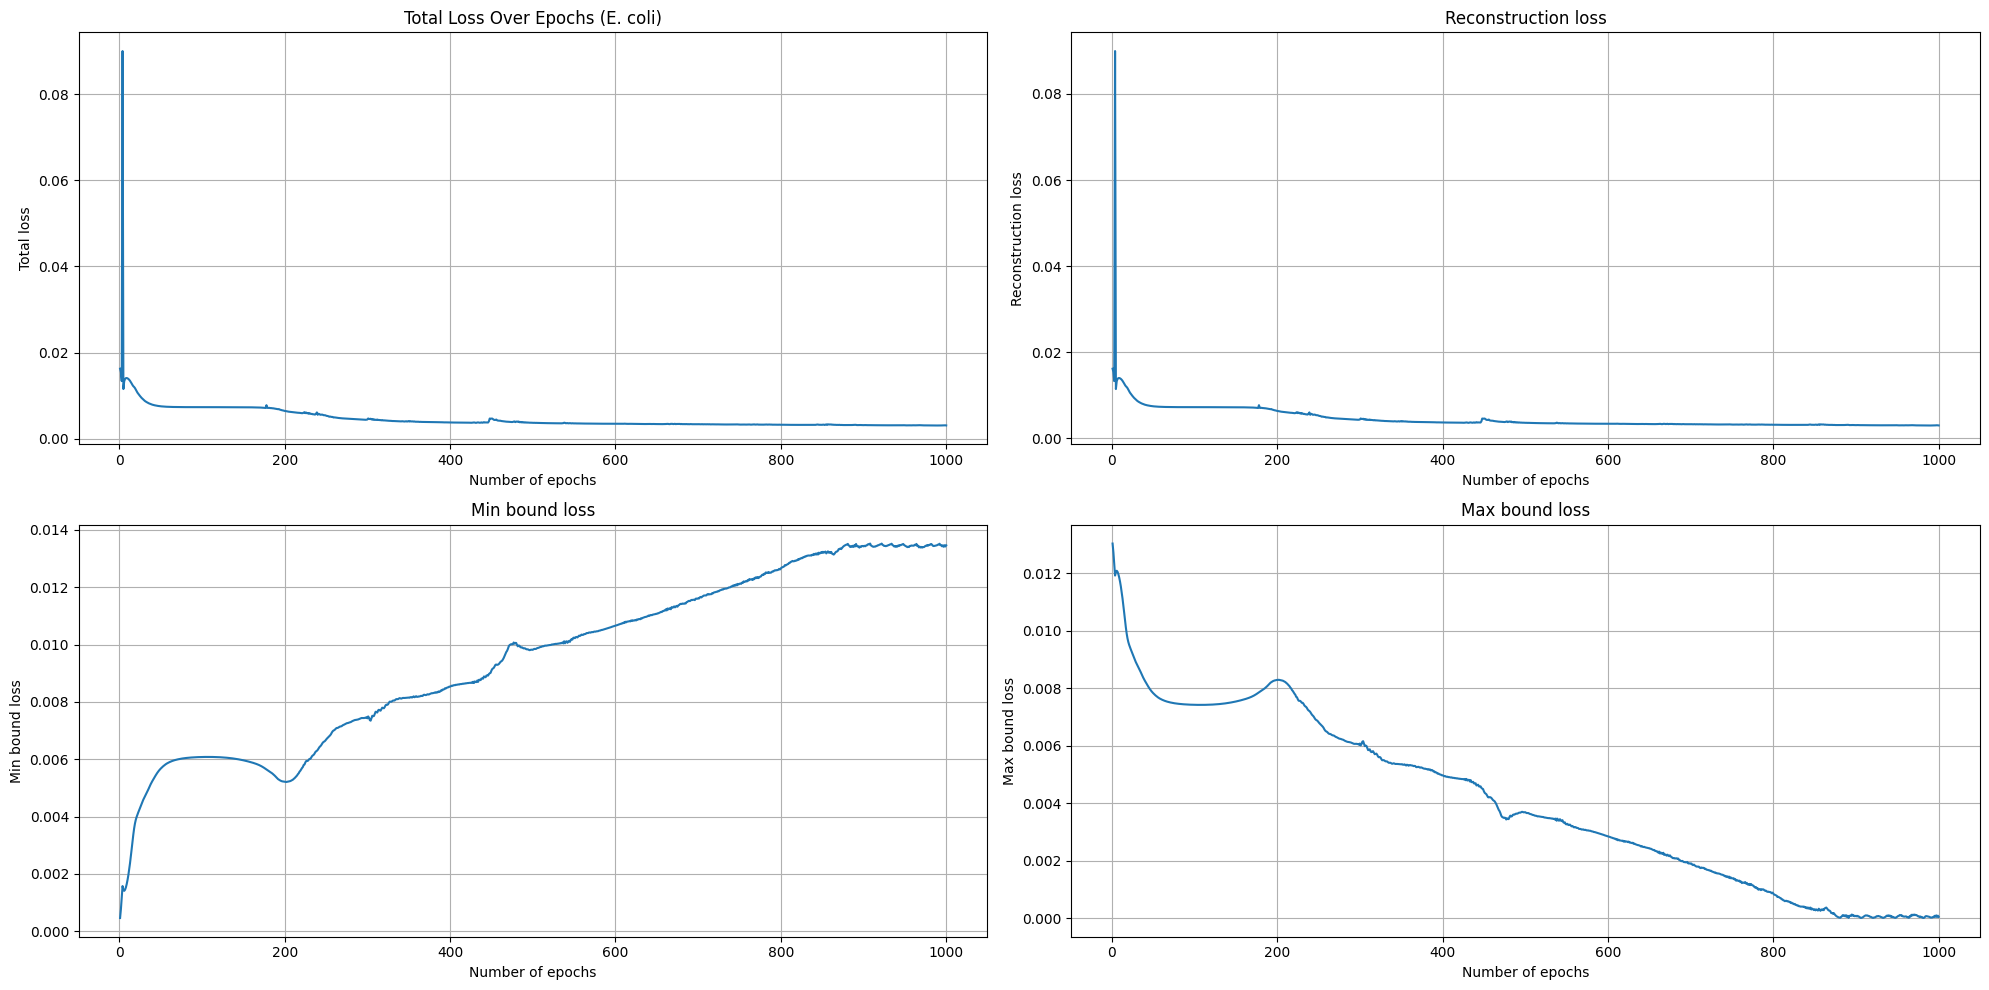

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))

axs[0, 0].plot(range(1, NB_EPOCHS+1), loss_results['total_loss'])
axs[0, 0].set_title('Total Loss Over Epochs (E. coli)')
axs[0, 0].set(xlabel='Number of epochs', ylabel='Total loss')

axs[0, 1].plot(range(1, NB_EPOCHS+1), loss_results['reconstruction_loss'])
axs[0, 1].set_title('Reconstruction loss')
axs[0, 1].set(xlabel='Number of epochs', ylabel='Reconstruction loss')

axs[1, 0].plot(range(1, NB_EPOCHS+1), loss_results['min_bound_loss'])
axs[1, 0].set_title('Min bound loss')
axs[1, 0].set(xlabel='Number of epochs', ylabel='Min bound loss')

axs[1, 1].plot(range(1, NB_EPOCHS+1), loss_results['max_bound_loss'])
axs[1, 1].set_title('Max bound loss')
axs[1, 1].set(xlabel='Number of epochs', ylabel='Max bound loss')

for ax in axs.flat:
    ax.grid(True)

plt.tight_layout()
plt.show()

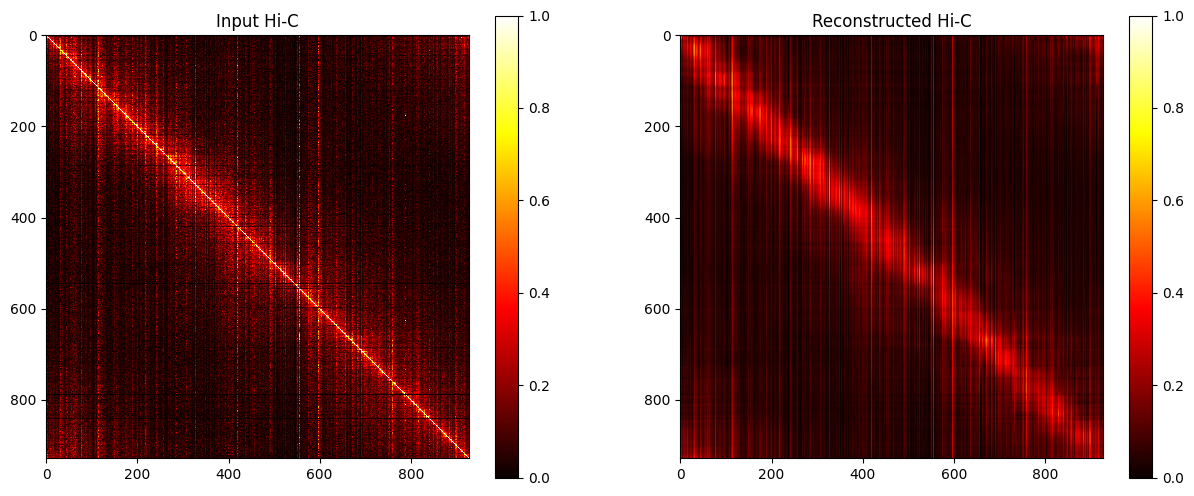

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7,3))

im = axes[0].imshow(test_ground_truths, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
# fig.colorbar(im, ax=axes[0], shrink=0.4)

im = axes[1].imshow(test_predictions, cmap='hot', interpolation='nearest')      #, vmin=0, vmax=1
# fig.colorbar(im, ax=axes[1], shrink=0.4)

axes[0].set_title("Input Hi-C")
axes[1].set_title("Reconstructed Hi-C")

plt.colorbar(axes[0].images[0], ax=axes[0])
plt.colorbar(axes[1].images[0], ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
latent_values = centralize_and_normalize_numpy(test_predicition_latent_values[0])
x_pred = latent_values[:, 0]
y_pred = latent_values[:, 1]
z_pred = latent_values[:, 2]

# Initialize figure with 3D subplots
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{'type': 'scatter3d'}]])

# adding surfaces to subplots.
fig.add_trace(
    go.Scatter3d(
    x=x_pred, y=y_pred, z=z_pred,
    marker=dict(
        size=5,
        color=np.asarray(range(len(x_pred))),
        colorscale='hsv',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
), row=1, col=1)

fig.update_layout(
    height=500,
    width=500
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()

### Save structure coordinates

In [ ]:
np.savetxt('reach3d_'+matrix_name, latent_values, delimiter='\t')
matrix_name
# save to local
from google.colab import files
files.download('reach3d_'+matrix_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>